In [2]:
import alkanes
from alkanes import *

import random 

import rdkit.Chem
from rdkit.Chem import AllChem

import torch
import torch.nn as nn
import torch.nn.functional as F

from deep_rl import *

from deep_rl.component.envs import DummyVecEnv, make_env

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
# from stable_baselines.common.policies import MlpPolicy
# from stable_baselines.common.vec_env import DummyVecEnv
# from stable_baselines import A2C
# # env = AlkaneEnv(mol)
# env = DummyVecEnv([lambda: AlkaneEnv(mode='train_simple')])

# model = A2C(MlpPolicy, env, verbose=1, tensorboard_log="./tf_log/")
# model.learn(total_timesteps=50000, tb_log_name="octane_mlp")


In [4]:
# obs = env.reset()
# for i in range(100):
#     action, _states = model.predict(obs)
#     obs, rewards, done, info = env.step(action)
#     env.render()


In [5]:
gym.envs.register(
     id='AlkaneEnv-v0',
     entry_point='alkanes:AlkaneEnv',
     kwargs={'mode': 'train'},
     max_episode_steps=1000,
)

gym.envs.register(
     id='AlkaneEnv-v1',
     entry_point='alkanes:AlkaneEnv',
     kwargs={'mode': 'test'},
     max_episode_steps=1000,
)

gym.envs.register(
     id='AlkaneEnv-v2',
     entry_point='alkanes:AlkaneEnv',
     kwargs={'mode': 'train_simple'},
     max_episode_steps=1000,
)

gym.envs.register(
     id='AlkaneEnv-v3',
     entry_point='alkanes:AlkaneWithoutReplacementEnv',
     kwargs={'mode': 'train'},
     max_episode_steps=1000,
)

gym.envs.register(
     id='AlkaneEnv-v4',
     entry_point='alkanes:AlkaneWithoutReplacementEnv',
     kwargs={'mode': 'test'},
     max_episode_steps=1000,
)

In [29]:
gym.envs.register(
     id='AlkaneEnv-v5',
     entry_point='alkanes:AlkaneDecoderEnv',
     kwargs={'mode': 'train'},
     max_episode_steps=1000,
)

gym.envs.register(
     id='AlkaneEnv-v6',
     entry_point='alkanes:AlkaneDecoderEnv',
     kwargs={'mode': 'train'},
     max_episode_steps=1000,
)


In [6]:
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv, VecEnv

class DummyVecEnv(VecEnv):
    def __init__(self, env_fns):
        self.envs = [fn() for fn in env_fns]
        env = self.envs[0]
        VecEnv.__init__(self, len(env_fns), env.observation_space, env.action_space)
        self.actions = None

    def step_async(self, actions):
        self.actions = actions

    def step_wait(self):
        data = []
        for i in range(self.num_envs):
            obs, rew, done, info = self.envs[i].step(self.actions)
            if done:
                obs = self.envs[i].reset()
            data.append([obs, rew, done, info])
        obs, rew, done, info = zip(*data)
        return obs, np.asarray(rew), np.asarray(done), info

    def reset(self):
        return [env.reset() for env in self.envs]

    def close(self):
        return

In [7]:
class AdaTask:
    def __init__(self,
                 name,
                 num_envs=1,
                 single_process=True,
                 log_dir=None,
                 episode_life=True,
                 seed=np.random.randint(int(1e5))):
        
        print ("seed is ", seed)
        if log_dir is not None:
            mkdir(log_dir)
        envs = [make_env(name, seed, i, episode_life) for i in range(num_envs)]
        if single_process:
            Wrapper = DummyVecEnv
        else:
            Wrapper = SubprocVecEnv
        self.env = Wrapper(envs)
        self.name = name
        self.observation_space = self.env.observation_space
        self.state_dim = int(np.prod(self.env.observation_space.shape))

        self.action_space = self.env.action_space
        self.action_dim = self.action_space.shape[0]

    def reset(self):
        return self.env.reset()

    def step(self, actions):
        return self.env.step(actions)

In [8]:
class TorsionMlpBaselineEmbedding(nn.Module, BaseNet):
    def __init__(self, seq_len, input_dim):
        super(TorsionMlpBaselineEmbedding, self).__init__()
        self.seq_len = seq_len
        self.input_dim = 2
        self.embedding = nn.Embedding(5, 2)
        
        self.fc_a1 = nn.Linear(self.seq_len * self.input_dim, 64)
        self.fc_a2 = nn.Linear(64, 64)
        self.fc_a3 = nn.Linear(64, self.seq_len)
        
        self.fc_v1 = nn.Linear(self.seq_len * self.input_dim, 64)
        self.fc_v2 = nn.Linear(64, 64)       
        self.fc_v3 = nn.Linear(64, 1)

    def forward(self, obs, action=None):
#         obs_tensor = torch.LongTensor(obs).view(-1, 1)
#         obs_onehot = torch.FloatTensor(obs_tensor.shape[0], 5)
#         obs_onehot.zero_()
#         obs_onehot.scatter_(1, obs_tensor, 1)      
        
#         obs_onehot = obs_onehot.view(1, -1)
#         obs_onehot = torch.FloatTensor(obs).view(1, -1)

        obs_onehot = self.embedding(torch.LongTensor(obs)).view(1, -1)

        output = F.relu(self.fc_a1(obs_onehot))
        output = F.relu(self.fc_a2(output))
        logits = self.fc_a3(output)
        #.view(-1, 2)
        
        output = F.relu(self.fc_v1(obs_onehot))
        output = F.relu(self.fc_v2(output))
        v = self.fc_v3(output)

        dist = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = dist.sample()
        log_prob = dist.log_prob(action).unsqueeze(-1)
        entropy = dist.entropy().unsqueeze(-1)
        
        one_hot_action = [0] * self.seq_len
        one_hot_action[action] = 1
        action = torch.Tensor(one_hot_action)
        
        return {
            'a': action,
            'log_pi_a': log_prob,
            'ent': entropy,
            'v': v,
        }

In [9]:
class TorsionMlpBaseline(nn.Module, BaseNet):
    def __init__(self, seq_len, input_dim):
        super(TorsionMlpBaseline, self).__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim
        
        self.fc_a1 = nn.Linear(self.seq_len * self.input_dim, 64)
        self.fc_a2 = nn.Linear(64, 64)
        self.fc_a3 = nn.Linear(64, self.seq_len)
        
        self.fc_v1 = nn.Linear(self.seq_len * self.input_dim, 64)
        self.fc_v2 = nn.Linear(64, 64)       
        self.fc_v3 = nn.Linear(64, 1)

    def forward(self, obs, action=None):
        obs_tensor = torch.LongTensor(obs).view(-1, 1)
        obs_onehot = torch.FloatTensor(obs_tensor.shape[0], 5)
        obs_onehot.zero_()
        obs_onehot.scatter_(1, obs_tensor, 1)      
        
        obs_onehot = obs_onehot.view(1, -1)
#         obs_onehot = torch.FloatTensor(obs).view(1, -1)
        
        output = F.relu(self.fc_a1(obs_onehot))
        output = F.relu(self.fc_a2(output))
        logits = self.fc_a3(output)
        #.view(-1, 2)
        
        
        output = F.relu(self.fc_v1(obs_onehot))
        output = F.relu(self.fc_v2(output))
        v = self.fc_v3(output)

        dist = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = dist.sample()
        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy = dist.entropy().unsqueeze(0)
        
        raise Exception()
        
        one_hot_action = [0] * self.seq_len
        one_hot_action[action] = 1
        action = torch.Tensor(one_hot_action)
        
        
        return {
            'a': action,
            'log_pi_a': log_prob,
            'ent': entropy,
            'v': v,
        }

In [10]:
class TorsionMlpManyAction(nn.Module, BaseNet):
    def __init__(self, seq_len):
        super(TorsionMlpManyAction, self).__init__()
        self.seq_len = seq_len
        
        self.fc_a1 = nn.Linear(self.seq_len * 5, 64)
        self.fc_a2 = nn.Linear(64, 64)
        self.fc_a3 = nn.Linear(64, self.seq_len * 2)
        
        self.fc_v1 = nn.Linear(self.seq_len * 5, 64)
        self.fc_v2 = nn.Linear(64, 64)
        self.fc_v3 = nn.Linear(64, 1)

    def forward(self, obs, action=None):
        obs_tensor = torch.LongTensor(obs).view(-1, 1)
        obs_onehot = torch.FloatTensor(obs_tensor.shape[0], 5)
        obs_onehot.zero_()
        obs_onehot.scatter_(1, obs_tensor, 1)      
        
        obs_onehot = obs_onehot.view(1, -1)
        
        output = F.relu(self.fc_a1(obs_onehot))
        output = F.relu(self.fc_a2(output))
        logits = self.fc_a3(output)
        logits = logits.view(-1, 2)
        
        
        output = F.relu(self.fc_v1(obs_onehot))
        output = F.relu(self.fc_v2(output))
        v = self.fc_v3(output)

        dist = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = dist.sample()
        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy = dist.entropy().unsqueeze(0)
        
        
        return {
            'a': action,
            'log_pi_a': log_prob,
            'ent': entropy,
            'v': v,
        }

In [11]:
class TorsionNet(nn.Module, BaseNet):
    def __init__(self, action_dim, hidden_dim, bidirectional=True):
        super(TorsionNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        
        self.embedding = nn.Embedding(5, 2)
        
        # input of shape (seq_len, batch, input_size):
        self.lstm = nn.LSTM(2, self.hidden_dim, bidirectional=bidirectional)
        self.action_fc = nn.Linear(self.hidden_dim * 2, self.hidden_dim * 2)
        self.action_head = nn.Linear(self.hidden_dim * 2, self.action_dim)

        # value net
        self.value_lstm = nn.LSTM(2, self.hidden_dim, bidirectional=bidirectional)
        self.value_fc = nn.Linear(self.hidden_dim * 2, self.hidden_dim * 2)
        self.value_head = nn.Linear(self.hidden_dim * 2, 1)

    def forward(self, obs, action=None):
        obs_tensor = torch.LongTensor(obs)
        obs_onehot = self.embedding(obs_tensor)
                
        seq_len = obs_tensor.shape[0]

        #value
        _, (hn, cn) = self.value_lstm(obs_onehot.view(-1, 1, 2))   
        out = F.relu(self.value_fc(hn.view(1, -1)))
        v = self.value_head(out)

        #action
        lstm_out, _ = self.lstm(obs_onehot.view(-1, 1, 2))
        out = F.relu(self.action_fc(lstm_out.view(-1, 2 * self.hidden_dim)))
        logits = self.action_head(out)

        dist = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = dist.sample()
        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy = dist.entropy().unsqueeze(0)
        
        return {
            'a': action,
            'log_pi_a': log_prob,
            'ent': entropy,
            'v': v,
        }

In [55]:
from torch.autograd import Variable
class RecurrentTorsionNet(nn.Module, BaseNet):
    def __init__(self, action_dim, hidden_dim, bidirectional=True):
        super(RecurrentTorsionNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        
        self.embedding = nn.Embedding(5, 2)
        
        # input of shape (seq_len, batch, input_size):
        self.lstm = nn.LSTM(2, self.hidden_dim, bidirectional=bidirectional)
        self.action_fc = nn.Linear(self.hidden_dim * 2, self.hidden_dim * 2)
        self.action_head = nn.Linear(self.hidden_dim * 2, self.action_dim)

        # value net
        self.value_lstm = nn.LSTM(2, self.hidden_dim, bidirectional=bidirectional)
        self.value_fc = nn.Linear(self.hidden_dim * 2, self.hidden_dim * 2)
        self.value_head = nn.Linear(self.hidden_dim * 2, 1)

    def forward(self, obs, states=None):
        obs_tensor = torch.LongTensor(obs)
        obs_onehot = self.embedding(obs_tensor)
        
#         if action:
#             print(type(action))
#             print(action)
#             print(action[0].shape)
#             raise Exception
        
        
        if states:
            hx_value, cx_value, hx_policy, cx_policy = states
        else:
            hx_value = Variable(torch.zeros(1, self.hidden_dim * 2))
            cx_value = Variable(torch.zeros(1, self.hidden_dim * 2))
            hx_policy = Variable(torch.zeros(1, self.hidden_dim * 2))            
            cx_policy = Variable(torch.zeros(1, self.hidden_dim * 2))
        
        seq_len = obs_tensor.shape[0]

        #value
        _, (hnv, cnv) = self.value_lstm(obs_onehot.view(-1, 1, 2), (hx_value.view(2,1,-1), cx_value.view(2,1,-1)))   
        out = F.relu(self.value_fc(hnv.view(1, -1)))
        v = self.value_head(out)

        #action
        lstm_out, (hnp, cnp) = self.lstm(obs_onehot.view(-1, 1, 2), (hx_policy.view(2,1,-1), cx_policy.view(2,1,-1)))
        out = F.relu(self.action_fc(lstm_out.view(-1, 2 * self.hidden_dim)))
        logits = self.action_head(out)

        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()

        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy = dist.entropy().unsqueeze(0)
        
        prediction = {
            'a': action,
            'log_pi_a': log_prob,
            'ent': entropy,
            'v': v,
        }
        
        return prediction, (hnv, cnv, hnp, cnp)

In [ ]:
from torch.autograd import Variable
class RecurrentDecoderTorsionNet(nn.Module, BaseNet):
    def __init__(self, action_dim, hidden_dim, bidirectional=True):
        super(RecurrentDecoderTorsionNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        
        self.embedding = nn.Embedding(5, 2)
        
        # input of shape (seq_len, batch, input_size):
        self.lstm = nn.LSTM(2, self.hidden_dim, bidirectional=bidirectional)
        self.action_fc = nn.Linear(self.hidden_dim * 2, self.hidden_dim * 2)
        self.action_head = nn.Linear(self.hidden_dim * 2, self.action_dim)

        # value net
        self.value_lstm = nn.LSTM(2, self.hidden_dim, bidirectional=bidirectional)
        self.value_fc = nn.Linear(self.hidden_dim * 2, self.hidden_dim * 2)
        self.value_head = nn.Linear(self.hidden_dim * 2, 1)

    def forward(self, obs, states=None):
        obs_tensor = torch.LongTensor(obs)
        obs_onehot = self.embedding(obs_tensor)
        
#         if action:
#             print(type(action))
#             print(action)
#             print(action[0].shape)
#             raise Exception
        
        
        if states:
            hx_value, cx_value, hx_policy, cx_policy = states
        else:
            hx_value = Variable(torch.zeros(1, self.hidden_dim * 2))
            cx_value = Variable(torch.zeros(1, self.hidden_dim * 2))
            hx_policy = Variable(torch.zeros(1, self.hidden_dim * 2))            
            cx_policy = Variable(torch.zeros(1, self.hidden_dim * 2))
        
        seq_len = obs_tensor.shape[0]

        #value
        _, (hnv, cnv) = self.value_lstm(obs_onehot.view(-1, 1, 2), (hx_value.view(2,1,-1), cx_value.view(2,1,-1)))   
        out = F.relu(self.value_fc(hnv.view(1, -1)))
        v = self.value_head(out)

        #action
        lstm_out, (hnp, cnp) = self.lstm(obs_onehot.view(-1, 1, 2), (hx_policy.view(2,1,-1), cx_policy.view(2,1,-1)))
        out = F.relu(self.action_fc(lstm_out.view(-1, 2 * self.hidden_dim)))
        logits = self.action_head(out)

        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()

        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy = dist.entropy().unsqueeze(0)
        
        prediction = {
            'a': action,
            'log_pi_a': log_prob,
            'ent': entropy,
            'v': v,
        }
        
        return prediction, (hnv, cnv, hnp, cnp)

In [13]:
class A2CEvalAgent(A2CAgent):
    def eval_step(self, state):
        prediction = self.network(self.config.state_normalizer(state))
        return prediction['a']

In [14]:
class A2CRecurrentEvalAgent(A2CRecurrentAgent):
    def eval_step(self, state, done, rstates):
        if done:
            prediction, rstates = self.network(self.config.state_normalizer(state))
        else:
            prediction, rstates = self.network(self.config.state_normalizer(state), rstates)
            
        return prediction['a'], rstates
    
    def eval_episode(self):
        env = self.config.eval_env
        state = env.reset()
        done = True
        rstates = None
        while True:
            action, rstates = self.eval_step(state, done, rstates)
            done = False
            state, reward, done, info = env.step(action)
            ret = info[0]['episodic_return']
            if ret is not None:
                break
        return ret

In [65]:
def a2c_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.num_workers = 1
    config.task_fn = lambda: AdaTask('AlkaneEnv-v5', seed=random.randint(0,1e5))
    config.eval_env = AdaTask('AlkaneEnv-v6', seed=random.randint(0,1e5))
    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=7e-4, alpha=0.99, eps=1e-5) #learning_rate #alpha #epsilon
    config.network_fn = lambda: TorsionNet(3, 32)
    config.discount = 0.99 # gamma
    config.use_gae = False
#     config.gae_tau = 0.95
    config.value_loss_weight = 0.25 # vf_coef
    config.entropy_weight = 0.01 #ent_coef
    config.rollout_length = 5 # n_steps
    config.gradient_clip = 0.5 #max_grad_norm
    config.eval_interval = 2000
    config.eval_episodes = 3
    config.max_steps = 50000
    
    agent = A2CEvalAgent(config)
    run_steps(agent)
    return agent

In [66]:
# from importlib import reload
# reload(alkanes)


In [67]:
mkdir('log')
mkdir('tf_log')
set_one_thread()
select_device(-1)

from multiprocessing import Process
p = Process(target=a2c_feature, kwargs={'tag': 'recurrent_ablation_decoder_test'}).start()
# agent = a2c_feature(tag='recurrent_test_1')
# ppo_feature(game='alkaneEnv')


seed is  6397
seed is  50087
reset called
[59.99980802700314, -60.00034178706049, -59.999646301998865, 59.99917703220846, -59.999778364240235, 179.9990556856481]


I1028 15:58:36.822863 140256258967360 misc.py:25] steps 0, 42366707.07 steps/s


reset called
[59.99980802700316, 59.999658212939465, -59.99964630199883, 179.9991770322084, -179.99977836424026, 179.9990556856481]
Z is  1191.1514450692125
gibbs  0.45942854720112764
max gibbs is  442.4913957652657
action is  tensor([0, 2, 1, 0, 1, 1, 2, 1])
reward is  0.03857012045806084
new state is:
[-59.99999999999994, 179.99999999999994, 59.99999999999999, -180.0, -180.0, -59.999999999999986]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  tensor([1, 2, 1, 0, 0, 2, 0, 2])
reward is  0.0
new state is:
[-59.999999999999986, 180.0, 59.99999999999994, 59.99999999999997, -59.99999999999992, 59.999999999999986]
Z is  1191.1514450692125
gibbs  0.09254758481818183
max gibbs is  442.4913957652657
action is  tensor([0, 2, 2, 1, 1, 2, 2, 1])
reward is  0.007769590105547351
new state is:
[-59.99999999999997, -60.00000000000006, -179.99999999999997, 180.0, -59.999999999999986, -59.99999999999999]
Z is  1191.1514450692125
gibbs  4.200992973020187
max gibbs is  44

reward is  1.5403429266210455e-122
new state is:
[-60.00000000000007, 60.00000000000005, 179.99999999999994, 179.99999999999997, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  4.3587904145698225e-146
max gibbs is  442.4913957652657
action is  tensor([2, 0, 1, 2, 0, 1, 2, 0])
reward is  3.659308337838227e-147
new state is:
[59.99999999999997, -180.0, -59.99999999999996, 60.00000000000001, 179.99999999999997, -60.00000000000001]
Z is  1191.1514450692125
gibbs  1.4258707180098404e-121
max gibbs is  442.4913957652657
action is  tensor([1, 0, 2, 1, 0, 1, 1, 0])
reward is  1.1970524184076269e-122
new state is:
[59.99999999999994, -59.99999999999992, 180.0, 59.99999999999997, -179.99999999999997, -179.99999999999997]
Z is  1191.1514450692125
gibbs  3.2253444440718164
max gibbs is  442.4913957652657
action is  tensor([2, 1, 2, 1, 0, 1, 1, 1])
reward is  0.2707753457734676
new state is:
[-179.99999999999994, -60.000000000000036, -179.99999999999991, 59.999999999999986, -179.99999999

action is  tensor([1, 0, 2, 0, 2, 1, 1, 0])
reward is  0.0
new state is:
[60.000000000000036, -59.999999999999986, 59.99999999999997, -59.999999999999986, 180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  tensor([2, 0, 0, 2, 0, 0, 2, 2])
reward is  0.0
new state is:
[60.00000000000002, 60.00000000000002, -60.00000000000001, 59.99999999999999, 59.99999999999997, -59.999999999999986]
Z is  1191.1514450692125
gibbs  2.0369154087455776e-121
max gibbs is  442.4913957652657
action is  tensor([0, 0, 2, 1, 1, 1, 0, 1])
reward is  1.7100389855357324e-122
new state is:
[60.00000000000001, -60.00000000000002, -180.0, -180.0, 180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  1.8854411261601702e-126
max gibbs is  442.4913957652657
action is  tensor([2, 1, 2, 1, 0, 2, 2, 0])
reward is  1.582872718632865e-127
new state is:
[180.0, -59.999999999999986, 180.0, 59.99999999999997, -59.99999999999999, -60.00000000000001]
Z is  1191.151445069

Z is  1191.1514450692125
gibbs  1.8842455427149963e-126
max gibbs is  442.4913957652657
action is  tensor([0, 0, 0, 2, 1, 0, 1, 1])
reward is  1.581868997863249e-127
new state is:
[59.99999999999993, 60.00000000000007, -60.000000000000036, 179.99999999999997, 59.999999999999986, 179.99999999999997]
Z is  1191.1514450692125
gibbs  0.08435844326772599
max gibbs is  442.4913957652657
action is  tensor([0, 1, 0, 1, 0, 0, 0, 1])
reward is  0.007082092173663466
new state is:
[-179.99999999999994, 59.99999999999999, -180.0, 60.00000000000001, 60.00000000000001, 60.00000000000001]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  tensor([2, 2, 0, 2, 1, 1, 2, 2])
reward is  0.0
new state is:
[-59.99999999999992, 59.99999999999994, -59.99999999999993, 180.0, 179.99999999999997, -59.99999999999997]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  tensor([2, 2, 0, 2, 1, 0, 1, 0])
reward is  0.0
new state is:
[-60.000000000000036, 60.000000

[-60.00000000000001, 179.99999999999997, -59.99999999999994, 180.0, -60.00000000000001, 180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  0.7805485641975806
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 0, 1, 0, 0, 2])
reward is  0.0474139469920122
new state is:
[-180.0, 180.0, 179.99999999999997, 60.00000000000001, 179.99999999999997, 60.00000000000001, 60.00000000000001]
Z is  1646.2425377264608
gibbs  0.1137449806803663
max gibbs is  544.1167177291418
action is  tensor([0, 2, 1, 2, 2, 2, 1, 1, 2])
reward is  0.006909369553617144
new state is:
[-59.99999999999994, 180.0, -60.00000000000002, -59.999999999999986, -59.999999999999986, -180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  tensor([0, 1, 0, 2, 2, 1, 2, 0, 2])
reward is  0.0
new state is:
[179.99999999999997, 59.999999999999986, -59.99999999999999, -59.99999999999996, 179.99999999999997, -59.999999999999986, 60.00000000000001]
Z is  1646.2425377

action is  tensor([0, 1, 1, 1, 0, 0, 2, 0, 2])
reward is  0.0
new state is:
[180.0, -179.99999999999997, 179.99999999999997, 59.99999999999999, 59.99999999999997, -59.99999999999999, 59.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 2, 0, 1, 0, 2, 2, 1])
reward is  0
new state is:
[180.0, -60.00000000000002, 59.99999999999999, 180.0, 59.999999999999986, -59.99999999999999, -60.00000000000001]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  tensor([1, 0, 1, 1, 2, 0, 0, 2, 1])
reward is  0.0
new state is:
[59.99999999999997, 180.0, 180.0, -59.99999999999993, 59.999999999999986, 59.99999999999999, -59.99999999999999]
Z is  1646.2425377264608
gibbs  6.258107539092907e-147
max gibbs is  544.1167177291418
action is  tensor([2, 0, 0, 1, 2, 0, 1, 2, 0])
reward is  3.801449297826826e-148
new state is:
[59.999999999999986, 59.999999999999986, 180.0, -59.99999999999999, 60.00000000000001, 180.0, -59.99999999999999]
Z is  1646.2

max gibbs is  544.1167177291418
action is  tensor([0, 0, 1, 1, 0, 0, 0, 0, 0])
reward is  0.0008547025051463617
new state is:
[59.99999999999999, 180.0, 179.99999999999997, 59.999999999999986, 59.999999999999986, 60.00000000000005, 59.999999999999986]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  tensor([2, 2, 0, 2, 2, 0, 1, 1, 1])
reward is  0.0
new state is:
[-59.999999999999986, 60.00000000000002, -59.99999999999997, -60.00000000000001, 59.99999999999999, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  3.57659253954676e-127
max gibbs is  544.1167177291418
action is  tensor([1, 1, 0, 1, 2, 0, 0, 0, 1])
reward is  2.172579348171992e-128
new state is:
[179.99999999999997, 59.99999999999999, 180.0, -59.99999999999997, 59.99999999999999, 59.99999999999997, 59.99999999999997]
Z is  1646.2425377264608
gibbs  2.4551466488545477e-126
max gibbs is  544.1167177291418
action is  tensor([0, 0, 0, 2, 1, 2, 1, 1, 1])
reward is  1.4913638741501734e-127
new state is:


reward is  4.3695027641117745
new state is:
[179.99999999999997, 59.99999999999999, -180.0, 180.0]
Z is  589.0305102196965
gibbs  0.5363125181231663
max gibbs is  292.8591987044459
action is  tensor([1, 2, 2, 2, 1, 1])
reward is  0.09105004050182945
new state is:
[-59.99999999999997, -59.999999999999986, -59.99999999999994, 180.0]
Z is  589.0305102196965
gibbs  0.5059649325104077
max gibbs is  292.8591987044459
action is  tensor([1, 0, 0, 1, 0, 1])
reward is  0.08589791593676414
new state is:
[59.999999999999986, 60.00000000000001, 179.99999999999997, 59.99999999999996]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 0, 1, 1, 0])
reward is  0
new state is:
[179.99999999999994, 59.99999999999999, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([2, 2, 0, 1, 2, 2])
reward is  0
new state is:
[-60.00000000000005, 60.00000000000001, 180.0, -59.999999999999986]
Z is  589.0305102196965
gibbs  0.5059755025041193
max gibbs is  292.8591987044459

gibbs  1.4262920314001755e-120
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 2, 0, 0])
reward is  2.4214230106148448e-121
new state is:
[180.0, 179.99999999999997, -60.00000000000001, 59.99999999999999]
Z is  589.0305102196965
gibbs  2.085785821445256e-290
max gibbs is  292.8591987044459
action is  tensor([2, 2, 2, 0, 0, 1])
reward is  3.5410488680243405e-291
new state is:
[-60.000000000000036, -59.99999999999999, 59.99999999999999, 59.99999999999999]
Z is  589.0305102196965
gibbs  4.155987702920886
max gibbs is  292.8591987044459
action is  tensor([1, 2, 2, 1, 1, 0])
reward is  0.7055640804363065
new state is:
[-60.000000000000036, -60.00000000000001, -179.99999999999997, -180.0]
Z is  589.0305102196965
gibbs  4.9603810727275234e-107
max gibbs is  292.8591987044459
action is  tensor([1, 2, 0, 0, 0, 2])
reward is  8.421263392413071e-108
new state is:
[-60.000000000000036, 60.000000000000036, 59.99999999999999, 59.999999999999986]
Z is  589.0305102196965
gibbs  4.156014571

I1028 15:58:43.736490 140256258967360 BaseAgent.py:55] steps 0, episodic_return_test 11.91(5.67)


Z is  1191.1514450692125
gibbs  1.7480742465211304e-229
max gibbs is  442.4913957652657
action is  [0 1 0 2 2 2 0 0]
reward is  1.4675499524072335e-230
new state is:
[-179.99999999999997, 59.99999999999997, -59.999999999999986, -59.99999999999996, -59.999999999999986, 60.00000000000001]
Z is  1191.1514450692125
gibbs  0.013251733968583788
max gibbs is  442.4913957652657
action is  [1 1 2 2 2 2 2 1]
reward is  0.00111251461965139
new state is:
[179.99999999999994, -59.99999999999997, -60.00000000000007, -59.99999999999994, -59.99999999999999, -59.99999999999997]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  [0 1 2 2 2 0 2 2]
reward is  0.0
new state is:
[179.99999999999991, -59.99999999999996, -59.999999999999986, -60.00000000000001, 59.99999999999999, -59.999999999999986]
Z is  1191.1514450692125
gibbs  1.8829011788717475e-120
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 2 0 1]
reward is  1.5807403724069196e-121
new state is:
[-180.0, 179.99999

Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  [1 1 2 0 2 1 1 1]
reward is  0.0
new state is:
[180.0, -60.00000000000001, 59.999999999999986, -59.99999999999999, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 0 2 2]
reward is  0
new state is:
[179.99999999999997, -180.0, 60.000000000000036, 179.99999999999997, 59.99999999999996, -59.99999999999999]
Z is  1191.1514450692125
gibbs  4.004410351701316e-107
max gibbs is  442.4913957652657
action is  [1 1 2 1 0 0 2 1]
reward is  3.361797837107638e-108
new state is:
[-179.99999999999994, -60.00000000000002, 180.0, 60.00000000000002, 59.999999999999986, -60.00000000000001]
Z is  1191.1514450692125
gibbs  0.6230900659780383
max gibbs is  442.4913957652657
action is  [0 0 1 1 0 0 1 2]
reward is  0.05230989464499481
new state is:
[59.99999999999996, -180.0, 180.0, 59.99999999999999, 59.999999999999986, -179.99999999999997]
Z is  1191.1514450692125
gibbs  0.4752341044214079
max gib

Z is  1191.1514450692125
gibbs  39.08183587253201
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 0 1 0]
reward is  3.2810131771498745
new state is:
[-179.99999999999991, 180.0, 179.99999999999994, -180.0, 59.99999999999996, 180.0]
Z is  1191.1514450692125
gibbs  0.6181890099262946
max gibbs is  442.4913957652657
action is  [1 0 0 1 1 2 1 2]
reward is  0.05189843931981078
new state is:
[59.999999999999986, 59.99999999999997, -179.99999999999997, -180.0, -60.000000000000036, 180.0]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  [1 0 2 0 1 2 0 0]
reward is  0.0
new state is:
[60.00000000000002, -60.00000000000001, 59.99999999999996, 180.0, -59.99999999999997, 59.99999999999997]
Z is  1191.1514450692125
gibbs  5.58667091805449e-251
max gibbs is  442.4913957652657
action is  [0 0 0 1 0 0 2 1]
reward is  4.690143256913795e-252
new state is:
[59.99999999999992, 60.00000000000007, 179.99999999999994, 59.99999999999999, 59.999999999999986, -60.000000000000

gibbs  2.05839589228491e-121
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 2 0 1]
reward is  1.728072362927206e-122
new state is:
[-59.99999999999993, 180.0, 179.99999999999997, 179.99999999999997, -59.99999999999997, 60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [2 2 0 2 1 2 0 0]
reward is  0
new state is:
[-60.00000000000005, 60.00000000000001, -59.99999999999997, 179.99999999999997, -59.99999999999999, 59.99999999999999]
reset called
[60.00000000000005, -60.00000000000005, 60.00000000000002, -180.0]


I1028 15:58:48.119036 140256258967360 BaseAgent.py:67] steps 99, episodic_return_train 5.829558492102289


Z is  589.0305102196965
gibbs  3.709187844754686
max gibbs is  292.8591987044459
action is  [1 1 0 0 1 0]
reward is  0.6297106483280864
new state is:
[-180.0, 59.99999999999997, 60.00000000000001, 180.0]
Z is  589.0305102196965
gibbs  4.9630918568604727e-107
max gibbs is  292.8591987044459
action is  [2 0 2 2 2 1]
reward is  8.425865503994589e-108
new state is:
[59.99999999999999, -60.00000000000002, -59.99999999999997, -59.99999999999999]
Z is  589.0305102196965
gibbs  4.960381072676206e-107
max gibbs is  292.8591987044459
action is  [1 2 0 0 0 2]
reward is  8.42126339232595e-108
new state is:
[-59.99999999999997, 60.00000000000001, 59.99999999999997, 59.99999999999999]
Z is  589.0305102196965
gibbs  0.0
max gibbs is  292.8591987044459
action is  [1 2 0 2 2 0]
reward is  0.0
new state is:
[-60.00000000000001, 59.999999999999986, -60.00000000000001, -59.99999999999996]
Z is  589.0305102196965
gibbs  1.431809171685337e-120
max gibbs is  292.8591987044459
action is  [0 0 2 1 1 1]
reward 

max gibbs is  292.8591987044459
action is  [0 2 1 1 1 2]
reward is  5.383637566836465
new state is:
[-59.99999999999999, 180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 2 1 2 0 0]
reward is  0
new state is:
[-60.000000000000036, 179.99999999999997, -60.000000000000036, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [2 2 1 1 0 0]
reward is  0
new state is:
[-60.00000000000001, -180.0, 180.0, 59.999999999999986]
Z is  589.0305102196965
gibbs  2.0258948747986201e-122
max gibbs is  292.8591987044459
action is  [1 1 2 0 0 0]
reward is  3.439371712753898e-123
new state is:
[-179.99999999999997, -59.99999999999994, 59.99999999999999, 59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  [2 0 0 0 0 0]
reward is  0
new state is:
[59.99999999999997, 60.00000000000002, 59.999999999999986, 59.99999999999999]
Z is  589.0305102196965
gibbs  2.0857858214035218e-290
max gibbs is  292.8591987044459
action is

I1028 15:58:50.059121 140256258967360 BaseAgent.py:67] steps 149, episodic_return_train 30.812442805730115


Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [2 1 0 2 0 2 0]
reward is  0.0
new state is:
[-180.0, 59.999999999999986, -59.99999999999999, 59.99999999999999, -59.999999999999986]
Z is  831.15924230415
gibbs  1.234298854027122e-121
max gibbs is  359.91076651957553
action is  [1 2 1 1 0 2 1]
reward is  1.4850329409865953e-122
new state is:
[-59.99999999999994, 180.0, 179.99999999999997, 59.99999999999999, -59.99999999999999]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [2 1 1 2 0 2 1]
reward is  0.0
new state is:
[180.0, 180.0, -59.99999999999996, 59.99999999999999, -59.99999999999999]
Z is  831.15924230415
gibbs  4.113406533438969e-107
max gibbs is  359.91076651957553
action is  [1 0 1 2 2 0 1]
reward is  4.948999330183386e-108
new state is:
[59.99999999999996, 180.0, -59.999999999999986, -59.999999999999986, 59.99999999999999]
Z is  831.15924230415
gibbs  0.5661884654519317
max gibbs is  359.91076651957553
action is  [1 2 

reward is  1.4803706274019658e-122
new state is:
[180.0, 59.999999999999986, 180.0, -60.00000000000002, 60.00000000000001]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [0 1 0 2 2 0 0]
reward is  0.0
new state is:
[180.0, 59.99999999999999, -59.99999999999994, -59.99999999999999, 59.99999999999999]
Z is  831.15924230415
gibbs  0.07041752778341888
max gibbs is  359.91076651957553
action is  [1 0 0 1 2 2 0]
reward is  0.008472206551924578
new state is:
[59.99999999999997, 59.999999999999986, 179.99999999999997, -60.00000000000002, -60.00000000000001]
Z is  831.15924230415
gibbs  0.3555824013565835
max gibbs is  359.91076651957553
action is  [0 0 1 0 1 2 1]
reward is  0.0427815012164015
new state is:
[59.99999999999999, 180.0, 60.00000000000001, -179.99999999999997, -59.999999999999986]
Z is  831.15924230415
gibbs  2.393378127695954e-141
max gibbs is  359.91076651957553
action is  [0 1 2 0 1 0 2]
reward is  2.879566280296663e-142
new state is:
[-180.0, -59.9

I1028 15:58:52.020200 140256258967360 BaseAgent.py:67] steps 199, episodic_return_train 16.877911676332886


Z is  1191.1514450692125
gibbs  0.8125059993545416
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 0 0 2]
reward is  0.06821181326001166
new state is:
[179.99999999999997, 180.0, -179.99999999999997, 60.00000000000002, 59.99999999999997, 59.999999999999986]
Z is  1191.1514450692125
gibbs  4.430779897026096e-125
max gibbs is  442.4913957652657
action is  [2 1 2 2 0 1 1 1]
reward is  3.719745222462996e-126
new state is:
[-179.9999999999999, -60.00000000000007, -59.999999999999986, 59.999999999999986, 179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  1.688493894232586e-122
max gibbs is  442.4913957652657
action is  [1 2 1 0 1 0 2 1]
reward is  1.4175308280253778e-123
new state is:
[-60.00000000000001, -180.0, 60.00000000000001, 179.99999999999997, 59.999999999999986, -59.99999999999996]
Z is  1191.1514450692125
gibbs  1.8346305908535681e-121
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 0 2 1]
reward is  1.5402160644207303e-122
new state is:
[-180.0, 59.99999999999

action is  [1 2 0 1 1 0 1 2]
reward is  1.5403429264813024e-122
new state is:
[-60.00000000000002, 60.000000000000036, -180.0, -180.0, 59.99999999999999, -180.0]
Z is  1191.1514450692125
gibbs  3.953958186332662e-124
max gibbs is  442.4913957652657
action is  [2 1 2 0 0 0 0 0]
reward is  3.319442042991364e-125
new state is:
[179.99999999999997, -60.00000000000005, 59.99999999999999, 59.99999999999997, 59.99999999999999, 59.99999999999997]
Z is  1191.1514450692125
gibbs  4.429341730832233
max gibbs is  442.4913957652657
action is  [0 1 1 2 1 1 0 1]
reward is  0.37185378476998476
new state is:
[180.0, 179.99999999999997, -59.99999999999999, -180.0, -180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  [1 1 0 2 0 1 2 1]
reward is  0.0
new state is:
[179.99999999999997, 59.999999999999986, -59.999999999999986, 59.99999999999997, -180.0, -59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 2 1 1 0 2]
reward i

Z is  1191.1514450692125
gibbs  0.07263665594460753
max gibbs is  442.4913957652657
action is  [2 2 1 2 2 1 0 1]
reward is  0.006098020217772303
new state is:
[-59.999999999999986, 180.0, -60.000000000000085, -59.99999999999999, 179.99999999999997, 60.000000000000036]
Z is  1191.1514450692125
gibbs  48.0017228202554
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 2]
reward is  4.029858925072809
new state is:
[-60.00000000000001, -179.99999999999997, -179.99999999999997, 179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.2253444440695893
max gibbs is  442.4913957652657
action is  [0 1 2 1 0 1 1 2]
reward is  0.27077534577328066
new state is:
[179.99999999999997, -59.99999999999989, 180.0, 59.99999999999999, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  [0 1 2 0 2 0 1 1]
reward is  0.0
new state is:
[-179.99999999999994, -60.00000000000001, 59.999999999999986, -59.999999999999986, 59.999999999999986, 180.0]
alrea

reset called
[179.9999999999999, 179.99999999999994, -59.99999999999994, 180.0, -180.0, -60.00000000000001]


I1028 15:58:55.823443 140256258967360 BaseAgent.py:67] steps 299, episodic_return_train 57.38409430290232


Z is  1191.1514450692125
gibbs  4.481356328219642e-127
max gibbs is  442.4913957652657
action is  [2 0 0 0 2 1 2 0]
reward is  3.7622053406980924e-128
new state is:
[59.999999999999986, 59.99999999999997, 60.00000000000002, -60.00000000000001, 180.0, -60.00000000000002]
Z is  1191.1514450692125
gibbs  39.081682825694074
max gibbs is  442.4913957652657
action is  [2 1 2 1 1 1 1 1]
reward is  3.281000328503418
new state is:
[180.0, -59.99999999999997, 179.99999999999994, -180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  6.3451395112946045
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 0 0]
reward is  0.5326895700425328
new state is:
[-179.99999999999997, -179.99999999999997, 180.0, -180.0, 59.999999999999986, 59.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 0 0]
reward is  0
new state is:
[-179.99999999999997, -179.99999999999997, 179.99999999999997, 180.0, 59.99999999999999, 59.999999999999986]
Z is  1191.1514450692125
gibbs  5.21307

Z is  1191.1514450692125
gibbs  1.4258707179266817e-121
max gibbs is  442.4913957652657
action is  [0 0 2 1 0 1 1 1]
reward is  1.1970524183378131e-122
new state is:
[59.99999999999997, -60.00000000000001, 180.0, 60.00000000000001, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.08435691939837509
max gibbs is  442.4913957652657
action is  [1 0 0 0 1 0 1 0]
reward is  0.0070819642412030545
new state is:
[60.00000000000002, 59.99999999999999, 59.999999999999986, 180.0, 59.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  48.00438611140484
max gibbs is  442.4913957652657
action is  [0 0 1 1 1 1 1 2]
reward is  4.030082514706224
new state is:
[59.999999999999986, -179.99999999999997, -180.0, 180.0, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  [2 2 0 2 1 2 0 0]
reward is  0.0
new state is:
[-59.99999999999989, 59.999999999999986, -59.99999999999996, 179.99999999999994, -59.99999999999996, 59.99999999999997]
Z is  1191.151445

Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  [2 0 2 2 0 2 2 2]
reward is  0.0
new state is:
[60.00000000000002, -60.00000000000001, -59.99999999999996, 59.999999999999986, -59.99999999999994, -60.00000000000001]
Z is  1191.1514450692125
gibbs  1.7771489554570623e-122
max gibbs is  442.4913957652657
action is  [2 2 1 2 1 2 0 0]
reward is  1.4919588628411563e-123
new state is:
[-59.99999999999999, 179.99999999999997, -59.999999999999986, 180.0, -60.000000000000036, 60.00000000000001]
Z is  1191.1514450692125
gibbs  4.217619680046467
max gibbs is  442.4913957652657
action is  [2 0 1 1 0 1 1 2]
reward is  0.35407921448656765
new state is:
[59.99999999999991, -180.0, -180.0, 60.00000000000001, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  2.7607586438604717e-123
max gibbs is  442.4913957652657
action is  [2 1 0 2 2 2 1 1]
reward is  2.317722616455422e-124
new state is:
[-179.99999999999997, 60.00000000000001, -59.999999999999986, -59.99999999999994, -60.000

I1028 15:58:59.577239 140256258967360 BaseAgent.py:67] steps 399, episodic_return_train 64.47985341026326


Z is  1646.2425377264608
gibbs  48.07985191640759
max gibbs is  544.1167177291418
action is  [2 1 0 1 1 1 1 1 1]
reward is  2.9205813125694196
new state is:
[179.99999999999994, 59.999999999999986, -180.0, -180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  2.036074170842799e-121
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 0 2 0]
reward is  1.236800850532458e-122
new state is:
[-180.0, -59.999999999999986, -180.0, 180.0, 180.0, 59.99999999999999, -60.00000000000001]
Z is  1646.2425377264608
gibbs  5.2099469567120105
max gibbs is  544.1167177291418
action is  [2 0 1 1 0 1 1 1 2]
reward is  0.3164750537856466
new state is:
[59.99999999999997, 179.99999999999994, -180.0, 59.99999999999999, -180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.01228726382930407
max gibbs is  544.1167177291418
action is  [1 2 2 1 0 0 0 1 1]
reward is  0.0007463823554379396
new state is:
[-59.999999999999986, -60.00000000000001, 180.0, 59.99999999999999, 60.0000000000000

reward is  0.2567150990217555
new state is:
[179.99999999999997, 180.0, -180.0, 59.99999999999997, 179.99999999999997, 59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  4.924276024208236e-145
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 2 1 0 2]
reward is  2.9912214703241085e-146
new state is:
[-180.0, 180.0, -180.0, 59.999999999999986, -59.99999999999999, -180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  1.4973041587849934e-122
max gibbs is  544.1167177291418
action is  [0 1 0 1 2 1 0 2 1]
reward is  9.095282891018243e-124
new state is:
[180.0, 59.999999999999986, 180.0, -59.999999999999986, 179.99999999999997, 59.99999999999999, -59.99999999999997]
Z is  1646.2425377264608
gibbs  0.06554493574548118
max gibbs is  544.1167177291418
action is  [1 0 0 1 0 1 2 1 0]
reward is  0.00398148718936651
new state is:
[59.999999999999986, 59.99999999999999, 180.0, 59.999999999999986, -180.0, -59.99999999999994, -180.0]
Z is  1646.2425377264608
gibbs  59.03973073420581
m

Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [2 0 0 0 0 2 0 1 2]
reward is  0.0
new state is:
[60.00000000000001, 60.00000000000001, 59.99999999999999, 60.00000000000002, -59.999999999999986, 59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  7.809627054087187
max gibbs is  544.1167177291418
action is  [0 2 2 1 1 1 1 1 1]
reward is  0.4743910374757205
new state is:
[-59.99999999999999, -60.00000000000001, 180.0, -180.0, 179.99999999999997, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  4.870539466008392e-145
max gibbs is  544.1167177291418
action is  [1 2 1 0 2 1 1 1 2]
reward is  2.9585795254293686e-146
new state is:
[-60.00000000000001, 180.0, 59.999999999999986, -60.00000000000001, -180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 0 1 0 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, 180.0, 59.999999999999986, 179.99999999999997, -180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
act

I1028 15:59:04.116598 140256258967360 BaseAgent.py:67] steps 499, episodic_return_train 74.2342788262939


Z is  1646.2425377264608
gibbs  5.097841761800405
max gibbs is  544.1167177291418
action is  [0 2 1 1 1 0 1 1 0]
reward is  0.30966529201953236
new state is:
[-59.99999999999999, 179.99999999999997, 180.0, -180.0, 60.00000000000001, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  59.035141807514805
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 0]
reward is  3.5860537226212816
new state is:
[179.99999999999997, 180.0, -180.0, 180.0, 180.0, -180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  2.6136042117388485e-122
max gibbs is  544.1167177291418
action is  [1 0 2 1 0 0 1 1 1]
reward is  1.5876179553398977e-123
new state is:
[60.00000000000001, -60.00000000000001, -180.0, 59.999999999999986, 59.999999999999986, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  0.442588425249581
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 0 1 2 0]
reward is  0.026884764249915243
new state is:
[-180.0, 60.00000000000001, -180.0, 180.0, 60.00000000000001, -180.0, -5

action is  [1 0 2 0 1 1 0 1 0]
reward is  0.0
new state is:
[59.99999999999999, -59.999999999999986, 59.999999999999986, -180.0, 180.0, 59.999999999999986, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, -180.0, 180.0, 180.0, -59.99999999999994]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [1 0 0 1 0 2 0 1 0]
reward is  0.0
new state is:
[59.99999999999997, 59.99999999999997, -179.99999999999997, 59.99999999999997, -59.99999999999999, 59.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  4.226229559268488
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 2 1 0]
reward is  0.25671973979636753
new state is:
[179.99999999999997, -180.0, 180.0, -59.999999999999986, -180.0, -59.999999999999986, 179.99999999999994]
Z is  1646.2425377264608
gibbs  47.040814852938794
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 0]
reward is  2.857465639

reward is  0.028263142921181983
new state is:
[59.99999999999997, 180.0, -59.99999999999999, -180.0, -180.0, 60.00000000000002, 180.0]
Z is  1646.2425377264608
gibbs  5.2100549203686795
max gibbs is  544.1167177291418
action is  [1 2 1 1 2 1 1 1 2]
reward is  0.3164816119721954
new state is:
[-60.00000000000001, 180.0, 179.99999999999997, -60.000000000000036, 180.0, -179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 2 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -59.999999999999986, 180.0, 180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  6.407721398451133
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 2 1]
reward is  0.3892331325188876
new state is:
[-59.99999999999994, -179.99999999999997, -180.0, 180.0, 180.0, 180.0, -59.999999999999986]
Z is  1646.2425377264608
gibbs  47.040743829859316
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 1 0]
reward is  2.857461324916608
new state is:
[179.99999999999997, -180.0

I1028 15:59:08.848249 140256258967360 BaseAgent.py:67] steps 599, episodic_return_train 78.30162901346871


Z is  1646.2425377264608
gibbs  544.1167202137987
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.05203867257918
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.040814852939484
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  2.857465639170343
new state is:
[180.0, 180.0, 59.999999999999986, -180.0, 180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.4940221725622527
max gibbs is  544.1167177291418
action is  [2 1 0 1 1 2 1 2 1]
reward is  0.030009075895008813
new state is:
[179.99999999999997, 59.999999999999986, 180.0, 180.0, -59.99999999999996, 1

gibbs  0.10881597030494103
max gibbs is  544.1167177291418
action is  [1 0 0 0 1 1 1 2 1]
reward is  0.006609959821304402
new state is:
[59.99999999999997, 59.99999999999999, 59.99999999999999, 180.0, -180.0, 180.0, -60.00000000000001]
Z is  1646.2425377264608
gibbs  4.250217129883859
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 0 1 1]
reward is  0.2581768501592488
new state is:
[179.99999999999997, 180.0, 59.99999999999999, -180.0, 180.0, 60.00000000000001, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 2 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, -180.0, -59.99999999999999, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 2 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 179.99999999999997, -180.0, -59.999999999999986, 180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -

Z is  1646.2425377264608
gibbs  5.637068107852388e-145
max gibbs is  544.1167177291418
action is  [1 0 1 0 2 1 1 1 1]
reward is  3.424202678930558e-146
new state is:
[59.999999999999986, -180.0, 59.99999999999997, -59.99999999999999, 179.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [1 1 0 2 1 1 0 2 1]
reward is  0.0
new state is:
[180.0, 59.999999999999986, -60.00000000000002, -180.0, 180.0, 59.99999999999999, -60.000000000000036]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 0 1 1 0 1 0]
reward is  0
new state is:
[180.0, -180.0, 59.99999999999999, -180.0, 180.0, 60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  0.5714520080341023
max gibbs is  544.1167177291418
action is  [0 1 2 2 1 0 1 1 1]
reward is  0.03471250407751611
new state is:
[180.0, -59.99999999999996, -59.999999999999986, -179.99999999999997, 59.999999999999986, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  48.08227091652723
max gibb

I1028 15:59:13.324480 140256258967360 BaseAgent.py:67] steps 699, episodic_return_train 79.95305903769002


Z is  831.15924230415
gibbs  4.551237302871266
max gibbs is  359.91076651957553
action is  [0 1 0 0 1 1 1]
reward is  0.547577055180698
new state is:
[180.0, 59.999999999999986, 59.999999999999986, 180.0, -180.0]
Z is  831.15924230415
gibbs  0.5162427195193209
max gibbs is  359.91076651957553
action is  [1 1 0 1 0 0 2]
reward is  0.06211116874405275
new state is:
[180.0, 59.999999999999986, 180.0, 59.99999999999997, 59.999999999999986]
Z is  831.15924230415
gibbs  2.6872084476087092
max gibbs is  359.91076651957553
action is  [1 1 2 1 0 1 1]
reward is  0.3233084962346321
new state is:
[180.0, -59.999999999999986, 180.0, 59.99999999999999, -180.0]
Z is  831.15924230415
gibbs  3.226958150062154
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 0 1]
reward is  0.38824788149095724
new state is:
[180.0, 180.0, -59.999999999999986, 179.99999999999997, 59.999999999999986]
Z is  831.15924230415
gibbs  3.4030134514657178
max gibbs is  359.91076651957553
action is  [1 0 1 0 1 1 1]
reward is

Z is  831.15924230415
gibbs  0.5661860587036744
max gibbs is  359.91076651957553
action is  [1 1 0 0 1 0 1]
reward is  0.0681200460617013
new state is:
[179.99999999999997, 59.999999999999986, 60.00000000000001, -179.99999999999994, 60.00000000000001]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 59.99999999999999, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  4.229131325020576
max gibbs is  359.91076651957553
action is  [0 0 1 1 1 2 1]
reward is  0.5088232326330784
new state is:
[59.999999999999986, -180.0, 180.0, 180.0, -59.99999999999994]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  2.838807898668432
max gibbs is  359.91076651957553
action is  [1 1 0 1 0 1 1]
reward is  0.34154801561234566
new state is:
[-180.0, 59.99999999999996, 179.99999999999997, 59.999999999999986, 180.0]
already 

I1028 15:59:15.084182 140256258967360 BaseAgent.py:67] steps 749, episodic_return_train 82.90670357796813


Z is  589.0305102196965
gibbs  292.85919885071627
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 2]
reward is  49.71885051276643
new state is:
[180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.73774446584655
max gibbs is  292.8591987044459
action is  [0 1 2 1 1 1]
reward is  4.369509561779218
new state is:
[179.99999999999997, -59.99999999999999, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.712014526791346
max gibbs is  292.8591987044459
action is  [2 1 1 1 2 1]
reward is  5.38376433420459
new state is:
[-179.99999999999997, 180.0, 180.0, -59.999999999999986]
Z is  589.0305102196965
gibbs  2.826597697464054
max gibbs is  292.8591987044459
action is  [1 1 0 1 0 1]
reward is  0.4798728840734906
new state is:
[180

already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 0]
reward is  0
new state is:
[180.0, 60.00000000000002, 180.0, 180.0]
reset called
[-59.99999999999999, 179.99999999999997, 180.0, -180.0, -59.99999999999999]


I1028 15:59:16.731398 140256258967360 BaseAgent.py:67] steps 799, episodic_return_train 88.11443211600702


Z is  831.15924230415
gibbs  30.92939611724243
max gibbs is  359.91076651957553
action is  [0 1 1 0 1 1 1]
reward is  3.721235900776315
new state is:
[179.99999999999997, -180.0, 59.99999999999997, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.02970331353982
max gibbs is  359.91076651957553
action is  [0 0 1 1 1 1 0]
reward is  4.695815353666909
new state is:
[60.000000000000036, -180.0, 179.99999999999997, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.2269653383412296
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 2 0]
reward is  0.3882487463407609
new state is:
[-180.0, 180.0, 59.999999999999986, 180.0, -59.999999999999986]
Z is  831.15924230415
gibbs  31.730663682400728
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 1]
reward is  3.8176395168796518
new state is:
[179.99999999999997, -59.99999999999999, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  4.551268178808402
max gibbs is  359.91076651957553
action is  [2 1 1 2 2 1 1]
reward is  0.5475807699847408
new sta

gibbs  30.92955015957826
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  3.721254434208657
new state is:
[180.0, 180.0, -59.99999999999997, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -180.0, 180.0]
Z is  831.15924230415
gibbs  3.6539505043770055
max gibbs is  359.91076651957553
action is  [1 2 1 1 0 1 1]
reward is  0.4396209917906319
new state is:
[-59.99999999999999, 180.0, 180.0, 59.99999999999997, 180.0]
Z is  831.15924230415
gibbs  0.33770113535304386
max gibbs is  359.91076651957553
action is  [1 0 1 2 1 0 1]
reward is  0.04063013658091132
new state is:
[60.00000000000001, 180.0, -60.00000000000002, 180.0, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 2 1 1 1 1 0]
reward is

I1028 15:59:18.897525 140256258967360 BaseAgent.py:67] steps 849, episodic_return_train 83.48628583984203


Z is  1191.1514450692125
gibbs  38.16954514150784
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 1]
reward is  3.204424198074156
new state is:
[179.99999999999997, -179.99999999999997, 59.999999999999986, -180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  4.200992973019439
max gibbs is  442.4913957652657
action is  [0 1 1 1 0 1 0 2]
reward is  0.3526833628426936
new state is:
[179.99999999999997, 179.99999999999997, 179.99999999999997, 60.00000000000001, -180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  4.235467417720588
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 2 1]
reward is  0.35557757456059536
new state is:
[179.99999999999997, 60.00000000000002, -180.0, 180.0, 180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  48.00423811723732
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  4.030070090243479
new state is:
[-180.0, 180.0, 180.0, 179.99999999999997, 179.99999999999997, 60.00000000000002]
Z is  1191.1514450692125

already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 2 1]
reward is  0
new state is:
[-180.0, 59.99999999999999, -180.0, 180.0, 179.99999999999997, -60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, -179.99999999999997, -179.99999999999997, 59.99999999999994, -180.0, -179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[179.99999999999994, -180.0, -179.99999999999994, 59.99999999999996, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, -180.0, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  4.217619680047228
max gibbs is  442.4913957652657
action is  [0 0 1 1 0 1 1 1]
reward is  0.35407921448663154
new state is:
[59.99999999999994, -180.0, 180.0, 59.999999999999986, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.47523783344

max gibbs is  442.4913957652657
action is  [2 1 0 1 1 0 1 1]
reward is  0.2956113025106762
new state is:
[-179.99999999999994, 60.00000000000002, 180.0, 180.0, 60.00000000000002, 180.0]
Z is  1191.1514450692125
gibbs  2.1946545407425547e-122
max gibbs is  442.4913957652657
action is  [1 2 0 1 1 2 2 1]
reward is  1.8424647426885616e-123
new state is:
[-59.99999999999997, 60.00000000000002, 180.0, 179.99999999999997, -60.000000000000036, -59.99999999999999]
Z is  1191.1514450692125
gibbs  4.429341730834141
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 0 2]
reward is  0.3718537847701449
new state is:
[-179.99999999999997, -180.0, -60.00000000000005, -179.99999999999997, 180.0, 59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 60.000000000000036, -180.0, 180.0, 179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  0.812485675416614
max gibbs is  442.4913957652657
action is  [1 0 0 0 1 1 1 1]
rewa

I1028 15:59:22.519858 140256258967360 BaseAgent.py:67] steps 949, episodic_return_train 80.20480734067337


Z is  589.0305102196965
gibbs  292.8591988507129
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.71885051276586
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 180.0]
Z is  589.0305102196965
gibbs  1.4262920314262007e-120
max gibbs is  292.8591987044459
action is  [0 1 1 2 0 1]
reward is  2.421423010659028e-121
new state is:
[-180.0, -180.0, -60.00000000000001, 59.99999999999997]
Z is  589.0305102196965
gibbs  31.711267828318334
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  5.383637566836847
new state is:
[-59.99999999999994, 180.0, -180.0, -180.0]
Z is  589.0305102196965
gibbs  2.8265976974637104
max gibbs is  292.8591987044459
action is  [1 1 0 1 0 1]
reward is  0.4798728840734322
new state is:
[179.99999999999997, 59.999999999999986, 180.0, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [0 2 1 1 1 1]
reward is  0
new state is:
[-60.00000000000002, -180.0, -180.0, 180.0]
already seen
max gibbs is 

max gibbs is  292.8591987044459
action is  [1 1 1 1 0 0]
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, 180.0, 59.99999999999999]
reset called
[-59.99999999999997, 60.000000000000036, 179.99999999999994, 179.99999999999997, 59.999999999999986, 59.99999999999999]


I1028 15:59:24.019019 140256258967360 BaseAgent.py:67] steps 999, episodic_return_train 92.95840256359907
I1028 15:59:24.102981 140256258967360 misc.py:25] steps 1000, 21.15 steps/s


Z is  1191.1514450692125
gibbs  4.42909360768086
max gibbs is  442.4913957652657
action is  [1 2 1 1 0 1 1 1]
reward is  0.3718329542406344
new state is:
[-59.99999999999996, -180.0, -180.0, 59.99999999999996, -179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  0.4395029728070698
max gibbs is  442.4913957652657
action is  [0 0 1 2 1 1 2 2]
reward is  0.03689732104396953
new state is:
[60.000000000000036, -179.99999999999997, -59.99999999999996, -180.0, -180.0, -59.99999999999994]
Z is  1191.1514450692125
gibbs  48.00438611140608
max gibbs is  442.4913957652657
action is  [0 0 1 1 1 1 1 1]
reward is  4.0300825147063275
new state is:
[60.00000000000001, -180.0, 179.99999999999994, 180.0, -180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  442.49139813283847
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  37.148206465646126
new state is:
[-179.99999999999997, 180.0, 179.99999999999997, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  39.0818358

Z is  1191.1514450692125
gibbs  4.248836552296176
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 0 1 1]
reward is  0.356699945240741
new state is:
[59.99999999999992, -179.99999999999994, -179.99999999999994, 180.0, 60.00000000000002, 179.99999999999997]
Z is  1191.1514450692125
gibbs  4.200992973019982
max gibbs is  442.4913957652657
action is  [0 1 1 1 0 1 0 0]
reward is  0.3526833628427392
new state is:
[-180.0, -179.99999999999994, -180.0, 59.99999999999994, 180.0, 60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [2 0 1 0 1 1 1 0]
reward is  0
new state is:
[59.99999999999988, -179.99999999999997, 60.00000000000002, -180.0, 180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  0.6838955500563695
max gibbs is  442.4913957652657
action is  [0 1 2 2 1 1 0 1]
reward is  0.05741465981402821
new state is:
[-179.99999999999994, -60.000000000000036, -59.999999999999986, 179.99999999999997, 179.99999999999997, 60.00000000000002]
already seen
max gibbs i

[179.99999999999997, 180.0, 180.0, 179.99999999999997, 179.99999999999997, 59.999999999999986]
Z is  1191.1514450692125
gibbs  2.107823669440395e-126
max gibbs is  442.4913957652657
action is  [1 0 0 2 1 2 1 2]
reward is  1.7695681587473696e-127
new state is:
[59.99999999999996, 59.99999999999996, -59.99999999999997, 180.0, -59.99999999999999, 179.99999999999997]
Z is  1191.1514450692125
gibbs  38.169719905154395
max gibbs is  442.4913957652657
action is  [2 1 1 1 2 1 1 1]
reward is  3.204438869898405
new state is:
[-180.0, 179.99999999999997, 179.99999999999997, -60.00000000000001, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, -179.99999999999997, 60.00000000000002, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999997, -180.0, 179.99999999999997, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.235468626321466
ma

I1028 15:59:28.345537 140256258967360 BaseAgent.py:67] steps 1099, episodic_return_train 88.3798323089687


Z is  1191.1514450692125
gibbs  4.200992973019435
max gibbs is  442.4913957652657
action is  [2 1 1 1 0 1 0 1]
reward is  0.3526833628426933
new state is:
[-180.0, -179.99999999999994, -179.99999999999997, 60.00000000000001, 179.99999999999997, 59.99999999999996]
Z is  1191.1514450692125
gibbs  3.225322438489388
max gibbs is  442.4913957652657
action is  [2 1 0 1 2 1 1 1]
reward is  0.2707734983524265
new state is:
[-180.0, 60.000000000000036, 180.0, -59.99999999999996, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.17000841160535
max gibbs is  442.4913957652657
action is  [0 1 1 2 1 1 1 2]
reward is  3.20446309070191
new state is:
[-179.99999999999997, -180.0, -59.999999999999986, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  39.08212646635471
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 1]
reward is  3.281037573193207
new state is:
[180.0, 179.99999999999997, 179.99999999999997, 180.0, -59.99999999999999, 179.99999999999997]
Z is  1191.151445069212

already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 0 0]
reward is  0
new state is:
[180.0, 179.99999999999997, 179.99999999999997, 180.0, -180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  0.3575508553403943
max gibbs is  442.4913957652657
action is  [1 1 2 1 2 1 0 1]
reward is  0.030017245650876795
new state is:
[179.99999999999997, -59.999999999999986, 179.99999999999997, -60.000000000000036, -180.0, 60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, -180.0, 59.99999999999994, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 0 1 1 2 1 2]
reward is  0
new state is:
[-180.0, 59.99999999999999, -180.0, 180.0, -59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  2.03898854985

action is  [2 1 1 1 0 1 0 1]
reward is  0
new state is:
[179.99999999999994, -179.99999999999997, -180.0, 59.99999999999997, 180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  0.45942854720034526
max gibbs is  442.4913957652657
action is  [2 2 1 0 1 1 2 1]
reward is  0.038570120457995155
new state is:
[-59.999999999999986, -179.99999999999997, 59.999999999999986, 180.0, 180.0, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 0]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 179.99999999999997, 59.999999999999986, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.220731736990981
max gibbs is  442.4913957652657
action is  [0 0 1 1 1 1 2 1]
reward is  0.43829286012305746
new state is:
[60.00000000000002, -180.0, 180.0, 180.0, 180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  4.200970945575494
max gibbs is  442.4913957652657
action is  [1 0 1 0 1 1 1 2]
reward is  0.3526815135863261
new state is:
[60.000000000000

I1028 15:59:32.411200 140256258967360 BaseAgent.py:67] steps 1199, episodic_return_train 87.3561858434954


Z is  589.0305102196965
gibbs  31.71154669030264
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 0]
reward is  5.383684909373349
new state is:
[59.99999999999997, -179.99999999999997, 180.0, 180.0]
Z is  589.0305102196965
gibbs  292.85919885071445
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.718850512766124
new state is:
[180.0, -179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  0
new state is:
[59.999999999999986, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 2]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  0
new state is:
[60.00000000000001, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]

I1028 15:59:33.978193 140256258967360 BaseAgent.py:67] steps 1249, episodic_return_train 84.00293520601927


Z is  1191.1514450692125
gibbs  38.169545141532346
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 2]
reward is  3.2044241980762136
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, 180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  3.98114807122253
max gibbs is  442.4913957652657
action is  [1 0 1 2 1 1 1 1]
reward is  0.3342268598760087
new state is:
[59.99999999999996, 179.99999999999997, -59.99999999999997, 179.99999999999997, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  38.1700084116094
max gibbs is  442.4913957652657
action is  [2 1 1 2 1 1 1 2]
reward is  3.20446309070225
new state is:
[179.99999999999994, 179.99999999999994, -59.99999999999996, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  442.4913981328428
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820646564649
new state is:
[-180.0, 179.99999999999994, 179.99999999999991, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.42934173

Z is  1191.1514450692125
gibbs  2.03898854979016e-121
max gibbs is  442.4913957652657
action is  [1 2 0 1 1 1 0 0]
reward is  1.711779436805102e-122
new state is:
[-59.99999999999997, 59.99999999999989, -180.0, -180.0, 179.99999999999997, 59.99999999999999]
Z is  1191.1514450692125
gibbs  2.1944637351464224e-122
max gibbs is  442.4913957652657
action is  [1 2 2 1 1 0 2 1]
reward is  1.8423045568474392e-123
new state is:
[-60.000000000000085, -59.99999999999997, 179.99999999999994, 179.99999999999997, 60.00000000000005, -59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 60.00000000000006, 180.0, 179.99999999999997, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  4.58205550141722e-145
max gibbs is  442.4913957652657
action is  [1 1 1 0 2 1 0 0]
reward is  3.846744694291142e-146
new state is:
[180.0, 180.0, 59.99999999999994, -59.99999999999997, 180.0, 59.99999999999997]
already seen
max gibbs is  

reward is  0
new state is:
[180.0, 180.0, -59.99999999999994, -180.0, 179.99999999999997, 59.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  0
new state is:
[-59.99999999999999, -180.0, 179.99999999999997, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 179.99999999999997, 179.99999999999997, 179.99999999999997, 59.99999999999997]
Z is  1191.1514450692125
gibbs  3.422061521202385
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 2 1 0]
reward is  0.28729021279099776
new state is:
[180.0, 179.99999999999997, -59.99999999999999, 180.0, -59.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -179.99999999999997, 180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 2 1 1 1 1 2]
reward is  0
n

I1028 15:59:37.752164 140256258967360 BaseAgent.py:67] steps 1349, episodic_return_train 84.1212677031128


Z is  831.15924230415
gibbs  31.730663682403165
max gibbs is  359.91076651957553
action is  [0 1 2 1 1 1 0]
reward is  3.8176395168799453
new state is:
[179.99999999999997, -60.00000000000002, 179.99999999999997, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  31.730945372976276
max gibbs is  359.91076651957553
action is  [0 1 1 1 0 1 1]
reward is  3.817673408168013
new state is:
[-180.0, -179.99999999999997, 180.0, 59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  3.843612987857158e-123
max gibbs is  359.91076651957553
action is  [1 1 2 0 0 0 1]
reward is  4.624400225884327e-124
new state is:
[180.0, -60.00000000000002, 60.00000000000002, 60.00000000000001, 59.99999999999997]
Z is  831.15924230415
gibbs  30.929396117241467
max gibbs is  359.91076651957553
action is  [2 1 1 0 1 1 1]
reward is  3.721235900776199
new state is:
[-180.0, -180.0, 59.99999999999999, -180.0, -180.0]
Z is  831.15924230415
gibbs  1.575121092582516e-120
max gibbs is  359.91076651957553
action is  [

already seen
max gibbs is  359.91076651957553
action is  [0 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -59.99999999999999, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -180.0, -179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  0
new state is:
[-60.00000000000001, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 2 1 2]
reward is  0
new state is:
[-180.0, 180.0, 180.0, -60.00000000000001, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999997, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  0
new state is:
[60.00000000000001, 180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
rewar

I1028 15:59:39.529713 140256258967360 BaseAgent.py:67] steps 1399, episodic_return_train 82.32559813150645


Z is  1646.2425377264608
gibbs  5.2326525710388685
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 0 1]
reward is  0.31785429249479913
new state is:
[-179.99999999999997, -59.999999999999986, 179.99999999999997, -180.0, 179.99999999999997, -179.99999999999997, 59.99999999999999]
Z is  1646.2425377264608
gibbs  5.09777526150928
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 2 1 1 1]
reward is  0.30966125249986254
new state is:
[59.99999999999999, 179.99999999999997, 180.0, 180.0, -59.999999999999986, -179.99999999999997, 179.99999999999997]
Z is  1646.2425377264608
gibbs  4.250217129883348
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 0 1 1]
reward is  0.2581768501592177
new state is:
[-180.0, 180.0, 59.999999999999986, -180.0, 180.0, 59.99999999999994, -180.0]
Z is  1646.2425377264608
gibbs  47.04047048472161
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 2 1 1 1]
reward is  2.8574447207327505
new state is:
[180.0, 180.0, 180.0, 180.0, -59.999999999999

action is  [1 1 0 1 1 1 1 2 2]
reward is  0.3178781668895072
new state is:
[180.0, 59.999999999999986, 180.0, 180.0, 180.0, 179.99999999999997, -59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -59.999999999999986, 180.0, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  2.79697625761994e-140
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 0 2 1 2]
reward is  1.6990061874374216e-141
new state is:
[180.0, 180.0, 180.0, -180.0, 60.00000000000001, -60.000000000000036, 180.0]
Z is  1646.2425377264608
gibbs  5.476291339864351
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 0 1]
reward is  0.33265398107300576
new state is:
[180.0, 180.0, 180.0, -59.99999999999993, -180.0, 180.0, 60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999996, 180.0, 180.0, -180.0, -180.0, 180.0, -180.0]
already seen
max gib

Z is  1646.2425377264608
gibbs  6.407118783437165
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 0 1]
reward is  0.38919652703700025
new state is:
[59.99999999999999, 180.0, 180.0, 180.0, -180.0, 180.0, 60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 1 0]
reward is  0
new state is:
[-180.0, 180.0, 180.0, -180.0, -180.0, 59.999999999999986, 180.0]
Z is  1646.2425377264608
gibbs  48.08249495841059
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 1 1]
reward is  2.920741862545649
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, -59.99999999999999, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  6.975658447662951
max gibbs is  544.1167177291418
action is  [0 1 2 2 1 1 1 1 1]
reward is  0.423732122564192
new state is:
[180.0, -59.999999999999986, -59.99999999

I1028 15:59:43.663868 140256258967360 BaseAgent.py:67] steps 1499, episodic_return_train 85.32573099889771


Z is  831.15924230415
gibbs  3.6539278202191583
max gibbs is  359.91076651957553
action is  [0 1 2 1 1 0 1]
reward is  0.43961826257140496
new state is:
[180.0, -59.99999999999999, 179.99999999999997, -180.0, 59.99999999999999]
Z is  831.15924230415
gibbs  39.0288717619982
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 2 1]
reward is  4.695715306467853
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, -59.99999999999999]
Z is  831.15924230415
gibbs  39.02849489310312
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  4.695669963905814
new state is:
[-59.99999999999999, -180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.73087892502178
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  3.817665413556257
new state is:
[179.99999999999997, 180.0, 180.0, -59.99999999999999, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 0 1]
reward is  0
new state is:
[180.0, -60.00000000000001, 180.0, 179.9999999999

new state is:
[-60.00000000000002, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 59.99999999999999, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -59.999999999999986]
reset called
[-180.0, -60.00000000000007, -180.0, -59.99999999999999]


I1028 15:59:45.395462 140256258967360 BaseAgent.py:67] steps 1549, episodic_return_train 79.71635861732852


Z is  589.0305102196965
gibbs  292.85919885071394
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]
reward is  49.71885051276604
new state is:
[-179.99999999999997, -180.0, 180.0, 179.99999999999997]
Z is  589.0305102196965
gibbs  25.737704425504475
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 0]
reward is  4.369502764110612
new state is:
[-179.99999999999997, 59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  3.620359582367668
max gibbs is  292.8591987044459
action is  [1 0 1 1 2 1]
reward is  0.6146302304472051
new state is:
[59.99999999999999, -180.0, 180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  4.156020314644147
max gibbs is  292.8591987044459
action is  [1 1 1 0 0 1]
reward is  0.705569616944636
new state is:
[-179.99999999999997, -180.0, 59.99999999999994, 59.99999999999999]
Z is  589.0305102196965
g

already seen
max gibbs is  292.8591987044459
action is  [2 2 2 1 1 0]
reward is  0
new state is:
[-59.99999999999994, -59.99999999999999, 180.0, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 180.0, -180.0]
Z is  589.0305102196965
gibbs  4.156014571064808
max gibbs is  292.8591987044459
action is  [1 0 0 1 1 1]
reward is  0.7055686418543411
new state is:
[60.00000000000005, 60.00000000000001, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 0 0 1]
reward is  0
new state is:
[-179.99999999999997, -179.99999999999997, 59.99999999999997, 59.999999999999986]
reset called
[-180.0, 179.99999999999997, 59.999999999999986, 59.99999999999997, -59.999999999999986, 60.00000000000002]


I1028 15:59:46.957034 140256258967360 BaseAgent.py:67] steps 1599, episodic_return_train 94.30850671387925


Z is  1191.1514450692125
gibbs  48.00438611135909
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  4.030082514702383
new state is:
[59.99999999999997, -180.0, -179.99999999999997, 179.99999999999997, 179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  442.49139813283693
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.148206465646
new state is:
[179.99999999999997, 179.99999999999997, 179.99999999999997, 180.0, -179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  39.082126466350665
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 2]
reward is  3.281037573192868
new state is:
[179.99999999999997, 180.0, -179.99999999999997, 180.0, -60.000000000000036, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999991, 179.99999999999997, -179.99999999999997, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.004238117231694
max gibbs is  442.4913957

Z is  1191.1514450692125
gibbs  3.225369451372658
max gibbs is  442.4913957652657
action is  [2 1 1 2 1 0 1 1]
reward is  0.27077744519591684
new state is:
[180.0, 180.0, -60.00000000000001, -179.99999999999997, 59.999999999999986, -179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 0 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, -179.99999999999997, 180.0, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[179.99999999999994, 179.99999999999994, -180.0, -180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 0 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 60.000000000000036, 59.999999999999986, 180.0, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[179.99999999999991, 179.99999999999994, -180.0, -180.0, 180.0, 59.999999999999986]
Z is  11

reward is  0
new state is:
[180.0, 59.99999999999999, -179.99999999999997, 180.0, 180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  1.4258707176830412e-121
max gibbs is  442.4913957652657
action is  [1 0 2 1 0 1 1 1]
reward is  1.1970524181332713e-122
new state is:
[59.99999999999993, -60.000000000000036, -179.99999999999994, 59.999999999999986, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -179.99999999999997, -180.0, -179.99999999999997, -59.99999999999993]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 2]
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, -179.99999999999997, -59.99999999999994, -179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  5.607959118100308
max gibbs is  442.4913957652657
action is  [1 1 1 2 2 1 1 0]
reward is  0.47080152077341053
new state is:
[179.99999999999997, 179.99999999999997, -60.00000000000005, 

I1028 15:59:51.029965 140256258967360 BaseAgent.py:67] steps 1699, episodic_return_train 85.05926602399359


Z is  589.0305102196965
gibbs  25.737704425496396
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 1]
reward is  4.36950276410924
new state is:
[179.99999999999997, 60.00000000000001, 179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  0.0
max gibbs is  292.8591987044459
action is  [0 1 0 2 0 1]
reward is  0.0
new state is:
[179.99999999999997, 60.00000000000001, -59.99999999999999, 60.00000000000002]
Z is  589.0305102196965
gibbs  1.3961597648508832e-121
max gibbs is  292.8591987044459
action is  [1 2 1 0 2 1]
reward is  2.3702673131993515e-122
new state is:
[-60.00000000000002, -180.0, 60.00000000000002, -60.00000000000001]
Z is  589.0305102196965
gibbs  0.43407735716793455
max gibbs is  292.8591987044459
action is  [1 0 1 2 2 1]
reward is  0.07369352684397154
new state is:
[60.00000000000005, 180.0, -60.00000000000001, -59.99999999999997]
Z is  589.0305102196965
gibbs  25.737895982462167
max gibbs is  292.8591987044459
action is  [0 1 1 0 1 1]
reward is  4.369535284829721

reward is  5.383684909371742
new state is:
[60.00000000000001, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.99999999999997]
reset called
[-180.0, -180.0, 59.999999999999986, 59.99999999999999, 59.99999999999999, 59.99999999999999, 59.999999999999986]


I1028 15:59:52.811184 140256258967360 BaseAgent.py:67] steps 1749, episodic_return_train 91.99309143290854


Z is  1646.2425377264608
gibbs  7.809627054081659
max gibbs is  544.1167177291418
action is  [1 2 2 1 1 1 1 1 1]
reward is  0.4743910374753847
new state is:
[-59.99999999999994, -59.99999999999993, 179.99999999999997, -180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [1 1 1 0 2 2 0 1 0]
reward is  0.0
new state is:
[179.99999999999997, 180.0, 60.00000000000001, -60.00000000000002, -59.999999999999986, 60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  0.7564708722442484
max gibbs is  544.1167177291418
action is  [0 0 1 1 1 2 2 1 1]
reward is  0.04595136226336191
new state is:
[60.000000000000036, 180.0, 180.0, -180.0, -59.99999999999996, -60.00000000000002, -180.0]
Z is  1646.2425377264608
gibbs  0.12771974375329873
max gibbs is  544.1167177291418
action is  [1 0 0 1 1 2 2 1 0]
reward is  0.007758258022519923
new state is:
[59.999999999999986, 60.00000000000001, -179.99999999999997, -180.0, -59.999999999999986, -60.00000

Z is  1646.2425377264608
gibbs  2.3232754509281876e-122
max gibbs is  544.1167177291418
action is  [0 2 1 1 0 1 0 2 0]
reward is  1.4112595183798017e-123
new state is:
[-59.99999999999999, -180.0, -180.0, 59.99999999999999, 180.0, 60.00000000000001, -60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, -180.0, 180.0, -180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, -179.99999999999997, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  48.07985191637727
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 0]
reward is  2.920581312567578
new state is:
[180.0, 59.99999999999997, -180.0, -179.99999999999997, -180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 2 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -59.999999999999986,

gibbs  5.489661020095592e-144
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 0 1 1 1]
reward is  3.334661141533298e-145
new state is:
[180.0, 180.0, 180.0, -60.00000000000001, 59.999999999999986, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.008263063414397314
max gibbs is  544.1167177291418
action is  [1 0 0 1 0 0 0 1 1]
reward is  0.00050193475293191
new state is:
[59.99999999999997, 60.00000000000005, -180.0, 60.00000000000001, 59.999999999999986, 60.00000000000001, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0, -180.0, 59.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 179.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.233298676052965
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 0 1 0]
reward is  0.3178935397502484
new state is:
[-

I1028 15:59:56.852012 140256258967360 BaseAgent.py:67] steps 1849, episodic_return_train 73.23749238352285


Z is  831.15924230415
gibbs  0.6551688070568149
max gibbs is  359.91076651957553
action is  [1 0 0 0 1 1 2]
reward is  0.07882590648219802
new state is:
[59.99999999999999, 59.99999999999999, 60.00000000000001, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.4986449799631196
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 2 1]
reward is  0.4209355803184156
new state is:
[-180.0, -60.00000000000001, 180.0, -180.0, -60.00000000000002]
Z is  831.15924230415
gibbs  39.028871762001145
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 2 1]
reward is  4.695715306468207
new state is:
[-180.0, -179.99999999999997, 180.0, 179.99999999999997, -59.99999999999999]
Z is  831.15924230415
gibbs  39.0284948931043
max gibbs is  359.91076651957553
action is  [2 2 1 1 1 1 1]
reward is  4.6956699639059565
new state is:
[-59.99999999999994, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  0.6551532076011312
max gibbs is  359.91076651957553
action is  [1 2 2 2 1 1 1]
reward is  0.07882402965

action is  [1 0 1 1 2 0 2]
reward is  1.4829682030388674e-122
new state is:
[59.999999999999986, 180.0, 180.0, -60.00000000000002, 60.00000000000001]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 60.00000000000002, 180.0]
Z is  831.15924230415
gibbs  31.730699362901895
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  3.817643809739474
new state is:
[180.0, 59.99999999999996, 180.0, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 0 1 1 1]
reward is  0
new sta

I1028 15:59:58.765811 140256258967360 BaseAgent.py:67] steps 1899, episodic_return_train 84.95162717859355


Z is  589.0305102196965
gibbs  25.737895982462053
max gibbs is  292.8591987044459
action is  [2 1 1 0 1 1]
reward is  4.369535284829701
new state is:
[179.99999999999997, 179.99999999999997, 60.00000000000002, 179.99999999999997]
Z is  589.0305102196965
gibbs  292.85919885071553
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]
reward is  49.71885051276631
new state is:
[180.0, -180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, 60.00000000000002, 180.0]
Z is  589.0305102196965
gibbs  31.711267828305857
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  5.38363756683473
new state is:
[-60.00000000000002, 180.0, 179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  1.4318091715475454e-120
max gibbs is  292.8591987044459
action is  [1 0 2 1 1 0]
reward is  2.4307894866320415e-121
new state is:
[59.99999999999999, -59.99999999999999, 180.0, 180.0]
alrea

already seen
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 0]
reward is  0
new state is:
[180.0, -59.99999999999997, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 0]
reward is  0
new state is:
[-60.00000000000001, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0]
reset called
[59.999999999999986, 60.00000000000007, -59.99999999999999, 179.99999999999997, -59.999999999999986, -59.999999999999986, 179.99999999999994]


I1028 16:00:00.438966 140256258967360 BaseAgent.py:67] steps 1949, episodic_return_train 93.01171197253771


Z is  1646.2425377264608
gibbs  47.04074382979416
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 0 1 1 1]
reward is  2.85746132491265
new state is:
[180.0, 179.99999999999997, 180.0, -180.0, 60.00000000000001, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.07744941805145612
max gibbs is  544.1167177291418
action is  [1 1 0 0 1 0 1 0 2]
reward is  0.004704617714375031
new state is:
[180.0, 59.99999999999997, 59.99999999999996, -180.0, 59.99999999999999, 180.0, 60.000000000000036]
Z is  1646.2425377264608
gibbs  6.4071187834330505
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 0 1]
reward is  0.3891965270367504
new state is:
[59.999999999999986, 180.0, 180.0, -180.0, -180.0, 180.0, 60.00000000000001]
Z is  1646.2425377264608
gibbs  5.224510167651859
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 2 1 1]
reward is  0.3173596871617202
new state is:
[-60.00000000000001, 180.0, -180.0, -180.0, 179.99999999999997, -59.99999999999999, 180.0]
Z is  1646.2425377264608


reward is  0.0054829978344968465
new state is:
[-180.0, 59.99999999999996, 180.0, 180.0, 59.99999999999999, 59.99999999999999, 59.999999999999986]
Z is  1646.2425377264608
gibbs  5.209946956711414
max gibbs is  544.1167177291418
action is  [1 0 1 1 0 1 1 1 1]
reward is  0.31647505378561036
new state is:
[59.99999999999997, -180.0, 180.0, 60.00000000000001, -179.99999999999997, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, 180.0, -180.0, -179.99999999999997, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 59.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 

I1028 16:00:02.733975 140256258967360 misc.py:25] steps 2000, 25.89 steps/s


reset called
[-59.99999999999996, -60.00000000000005, 60.000000000000036, 59.999999999999986, -59.999999999999986, -60.000000000000085]
Z is  1191.1514450692125
gibbs  0.7126083506283956
max gibbs is  442.4913957652657
action is  tensor([1, 2, 1, 2, 2, 1, 1, 1])
reward is  0.059825167788550106
new state is:
[-59.99999999999994, -180.0, -60.000000000000036, -59.99999999999997, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  48.004238117230926
max gibbs is  442.4913957652657
action is  tensor([0, 1, 1, 1, 1, 1, 0, 1])
reward is  4.030070090242942
new state is:
[179.99999999999991, -180.0, -180.0, -180.0, 180.0, 59.99999999999994]
Z is  1191.1514450692125
gibbs  5.0486106554345733e-144
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 0, 2, 1, 1, 1])
reward is  4.238428854981762e-145
new state is:
[180.0, -179.99999999999997, 59.999999999999986, -59.99999999999991, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  38.17000841161669
max gibbs is  442.4913957652657
action

Z is  1191.1514450692125
gibbs  5.2822504012453164e-145
max gibbs is  442.4913957652657
action is  tensor([1, 0, 1, 0, 2, 1, 1, 1])
reward is  4.434574984659813e-146
new state is:
[60.00000000000002, 180.0, 59.99999999999997, -59.999999999999986, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([0, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[179.99999999999994, 180.0, 179.99999999999997, 180.0, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 0, 1, 0, 2, 1, 1, 2])
reward is  0
new state is:
[59.99999999999999, 180.0, 59.999999999999986, -60.00000000000001, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1191.15144

[-60.00000000000001, -60.00000000000002, 59.99999999999999, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 2, 1, 1, 1, 0])
reward is  0
new state is:
[180.0, 179.99999999999997, -59.99999999999997, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.3575347465371712
max gibbs is  442.4913957652657
action is  tensor([1, 1, 0, 1, 0, 1, 2, 1])
reward is  0.030015893278490413
new state is:
[179.99999999999997, 59.99999999999994, 179.99999999999997, 59.999999999999986, 179.99999999999997, -59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 0, 1, 1])
reward is  0
new state is:
[179.99999999999997, -179.99999999999994, -179.99999999999997, -180.0, 60.00000000000002, 180.0]
Z is  1191.1514450692125
gibbs  48.00204392240989
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 2, 1])
reward is  4.029885882363238
new state is:
[-180.0, 180.0, -180.0, 180.0, 180.0, -59.999999999999986]

gibbs  39.081835872523
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 0, 1, 1])
reward is  3.281013177149118
new state is:
[180.0, 179.99999999999994, 179.99999999999994, -180.0, 60.00000000000002, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 0, 1, 0])
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 180.0, 60.00000000000002, 180.0]
Z is  1191.1514450692125
gibbs  3.9808788540560682
max gibbs is  442.4913957652657
action is  tensor([1, 2, 1, 0, 1, 1, 1, 1])
reward is  0.3342042584538658
new state is:
[-59.99999999999999, -179.99999999999997, 59.99999999999994, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  1.8103167881680878e-141
max gibbs is  442.4913957652657
action is  tensor([1, 1, 2, 0, 1, 2, 1, 1])
reward is  1.5198040481434317e-142
new state is:
[179.99999999999994, -59.99999999999994, 59.99999999999993, -180.0, -59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  39.

reward is  1.6952576315011992e-122
new state is:
[-60.00000000000002, -179.99999999999997, 179.99999999999997, 179.99999999999997, 60.00000000000001, -59.99999999999994]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 0, 1, 1])
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, 180.0, 59.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 0, 1])
reward is  0
new state is:
[-179.99999999999997, -179.99999999999994, 179.99999999999997, 179.99999999999997, 179.99999999999997, 59.99999999999996]
already seen
max gibbs is  442.4913957652657
action is  tensor([2, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, -179.99999999999997, 180.0, 179.99999999999997, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  0.6838506061128995
max gibbs is  442.4913957652657
action is  tensor([1, 1, 0, 0, 1, 1, 2, 1])
reward is  0.057410886662960306
new state is:
[179.99999999999997, 59.99999999999999, 60.0000

already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-179.99999999999997, -180.0, 180.0, 180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  4.2175714064769565
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 0, 1, 1, 0, 1])
reward is  0.35407516180546567
new state is:
[-179.99999999999997, -180.0, 59.99999999999997, 180.0, -180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  6.345041641791982
max gibbs is  442.4913957652657
action is  tensor([1, 0, 0, 1, 1, 1, 1, 1])
reward is  0.5326813536647559
new state is:
[60.00000000000001, 59.99999999999999, 179.99999999999997, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 0])
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([2, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.

new state is:
[180.0, 180.0, 180.0, -59.99999999999999, 59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  tensor([0, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 1, 1, 0])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.226934354582949
max gibbs is  359.91076651957553
action is  tensor([1, 2, 1, 0, 1, 1, 2])
reward is  0.3882450185643369
new state is:
[-59.999999999999986, -180.0, 60.00000000000001, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  tensor([2, 1

I1028 16:00:08.628218 140256258967360 BaseAgent.py:55] steps 2000, episodic_return_test 78.75(3.09)


already seen
max gibbs is  544.1167177291418
action is  [2 1 2 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -60.00000000000001, 180.0, 180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 59.99999999999997, 180.0, -180.0, -179.99999999999997, 179.99999999999994, 180.0]
Z is  1646.2425377264608
gibbs  47.04081485293802
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  2.857465639170254
new state is:
[-180.0, -180.0, 59.99999999999996, 180.0, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.47017135382419994
max gibbs is  544.1167177291418
action is  [1 0 1 1 0 1 0 1 2]
reward is  0.028560272441600795
new state is:
[59.999999999999986, 180.0, -180.0, 59.99999999999996, -180.0, 60.00000000000001, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 0]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -1

reward is  0.4743895651576609
new state is:
[59.999999999999986, 59.999999999999986, 180.0, -180.0, -180.0, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [1 1 0 2 0 1 1 1 1]
reward is  0.0
new state is:
[180.0, 60.00000000000002, -59.99999999999993, 59.999999999999986, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.469953840989189e-144
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 2 1 1 0]
reward is  3.322690135648818e-145
new state is:
[-180.0, 179.99999999999997, 180.0, 59.999999999999986, -59.99999999999994, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, 179.99999999999997, -180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -179.99999999999997, 180.0, -180.0, 179.99999999999997]
already seen
max gibbs is  

I1028 16:00:10.623022 140256258967360 BaseAgent.py:67] steps 2049, episodic_return_train 79.02021940135594


Z is  589.0305102196965
gibbs  31.71114745067533
max gibbs is  292.8591987044459
action is  [2 1 1 1 0 1]
reward is  5.383617130265072
new state is:
[179.99999999999997, 180.0, 180.0, 60.00000000000001]
Z is  589.0305102196965
gibbs  292.85919885071553
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.71885051276631
new state is:
[-180.0, -180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0]
Z is  589.0305102196965
gibbs  4.15602031464365
max gibbs is  292.8591987044459
action is  [2 1 1 0 0 1]
reward is  0.7055696169445516
new state is:
[-180.0, 179.99999999999997, 59.99999999999997, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  5

I1028 16:00:12.254423 140256258967360 BaseAgent.py:67] steps 2099, episodic_return_train 87.87301024199903


Z is  831.15924230415
gibbs  359.9107665493539
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  43.302263661486194
new state is:
[-180.0, -180.0, -180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  39.028591107910664
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 1]
reward is  4.695681539883394
new state is:
[-180.0, -180.0, -180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  2.2136156357864183e-140
max gibbs is  359.91076651957553
action is  [1 1 0 2 1 1 1]
reward is  2.663287037090276e-141
new state is:
[180.0, 59.999999999999986, -60.00000000000001, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.403013451466026
max gibbs is  359.91076651957553
action is  [1 0 1 0 1 1 0]
rew

already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  4.551268178808145
max gibbs is  359.91076651957553
action is  [1 1 1 2 2 1 1]
reward is  0.5475807699847098
new state is:
[180.0, 180.0, -59.999999999999986, -59.99999999999999, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 0]
reward is  0
new state is:
[180.0, 59.999999999999986, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  2.30483166377765e-125
max gibbs is  359.91076651957553
action is  [1 0 0 2 1 1 1]
reward is  2.7730325868580453e-126
new state is:
[59.999999999999986, 59.99999999999999, -59.999999999999986, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -180.0, -180.0]
reset called
[59.99999999999996, 60.000000000000036, 59.99999999999997, 59.99999999999999]


I1028 16:00:13.954486 140256258967360 BaseAgent.py:67] steps 2149, episodic_return_train 82.19398542418877


Z is  589.0305102196965
gibbs  292.85919885071576
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  49.718850512766345
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.73770442549516
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 2]
reward is  4.36950276410903
new state is:
[179.99999999999997, 59.99999999999996, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 1 0 1 1 1]
reward is  0
new state is:
[180.0, 60.00000000000001, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.737744465834776
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 1]
reward is  4.369509561777219
new state is:
[-180.0, -59.99999999999996, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0]
Z is  589.030510219696

I1028 16:00:15.464150 140256258967360 BaseAgent.py:67] steps 2199, episodic_return_train 91.34856751981734


Z is  831.15924230415
gibbs  39.02859110791554
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 1]
reward is  4.6956815398839815
new state is:
[180.0, -180.0, 180.0, 180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  3.402958016013405
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 2 0]
reward is  0.40942310965341405
new state is:
[180.0, -180.0, -60.00000000000005, 180.0, -60.00000000000001]
Z is  831.15924230415
gibbs  3.4029248886917833
max gibbs is  359.91076651957553
action is  [1 2 1 2 1 1 1]
reward is  0.4094191239765502
new state is:
[-59.99999999999999, 180.0, -60.00000000000001, 180.0, -180.0]
Z is  831.15924230415
gibbs  359.9107665493562
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.302263661486464
new state is:
[179.99999999999997, 180.0, -180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  5.144850624102278
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 2 0]
reward is  0.6189969818346313
new state is:
[180.0, 180.0, 1

reward is  0
new state is:
[180.0, 180.0, 60.00000000000002, -179.99999999999997, -59.99999999999999]
Z is  831.15924230415
gibbs  4.5512280746657225
max gibbs is  359.91076651957553
action is  [1 1 1 0 0 1 1]
reward is  0.5475759448994095
new state is:
[180.0, 180.0, 59.999999999999986, 59.999999999999986, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 60.00000000000002, -179.99999999999997, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
reset called
[-59.99999999999999, 180.0, 180.0, 179.99999999999997, -59.99999999999999]


I1028 16:00:17.104151 140256258967360 BaseAgent.py:67] steps 2249, episodic_return_train 77.04732476447377


Z is  831.15924230415
gibbs  2.3048316637881313e-125
max gibbs is  359.91076651957553
action is  [1 0 0 2 1 1 1]
reward is  2.7730325868706558e-126
new state is:
[59.99999999999999, 59.99999999999997, -60.00000000000001, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  1.5676017940791943e-120
max gibbs is  359.91076651957553
action is  [1 2 0 1 1 1 1]
reward is  1.886042667026681e-121
new state is:
[-59.999999999999986, 59.99999999999999, -180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  2.2084011819787606e-140
max gibbs is  359.91076651957553
action is  [1 1 1 2 0 1 2]
reward is  2.657013324975613e-141
new state is:
[180.0, 180.0, -60.00000000000005, 59.99999999999996, 180.0]
Z is  831.15924230415
gibbs  0.4731067088270301
max gibbs is  359.91076651957553
action is  [1 1 2 2 1 0 1]
reward is  0.05692130758426962
new state is:
[180.0, -59.99999999999999, -60.00000000000001, -180.0, 60.00000000000001]
Z is  831.15924230415
gibbs  359.91076654935523
max gibbs is  359.91076651957

max gibbs is  359.91076651957553
action is  [1 0 1 1 2 1 2]
reward is  0.43963365130432697
new state is:
[59.999999999999986, 180.0, 180.0, -60.00000000000002, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 60.00000000000001, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 179.99999999999997, 180.0, 180.0]
Z is  831.15924230415
gibbs  4.55122807466593
max gibbs is  359.91076651957553
action is  [1 1 1 0 0 1 1]
reward is  0.5475759448994346
new state is:
[180.0, -180.0, 59.99999999999996, 59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  4.551268178807827
max gibbs is  359.91076651957553
action is  [1 1 1 2 2 1 0]
reward is  0.5475807699846715
new state is:
[180.0, 179.99999999999997, -60.00000000000001, -59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  3.4987503351812936
max gibbs is  359.91076651957553
a

I1028 16:00:18.968228 140256258967360 BaseAgent.py:67] steps 2299, episodic_return_train 86.83004742862681


Z is  1646.2425377264608
gibbs  59.04026710289926
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 1]
reward is  3.586365055566884
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  7.8096270540809485
max gibbs is  544.1167177291418
action is  [1 2 2 1 1 1 1 1 1]
reward is  0.47439103747534156
new state is:
[-59.999999999999986, -59.999999999999986, 180.0, -180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.6899053298262456
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 2 2 1]
reward is  0.041907878943465864
new state is:
[180.0, 60.00000000000001, 180.0, -180.0, 180.0, -59.99999999999999, -59.999999999999986]
Z is  1646.2425377264608
gibbs  48.08041446410397
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 1]
reward is  2.9206154841865106
new state is:
[179.99999999999997, -59.999999999999986, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  2.489896937019048e-121
ma

max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 2 1]
reward is  0.3892331325178756
new state is:
[-60.00000000000002, 180.0, 179.99999999999997, 180.0, -180.0, -180.0, -59.99999999999996]
Z is  1646.2425377264608
gibbs  5.223779405323628
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 0 1]
reward is  0.31731529744930026
new state is:
[180.0, 60.00000000000002, 180.0, -180.0, -180.0, 180.0, 60.00000000000001]
Z is  1646.2425377264608
gibbs  0.47082394622907203
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 0 1 0 1]
reward is  0.028599913769650386
new state is:
[180.0, 59.999999999999986, 180.0, 180.0, 59.99999999999999, -180.0, 59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, -180.0, 180.0, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  59.03973073420104
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 1]
reward is  3.5863324741770866
new state is:
[59.9

action is  [2 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[-180.0, -180.0, -180.0, -179.99999999999997, -180.0, 179.99999999999997, 59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 2 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -59.99999999999992, -179.99999999999997, -180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 1 1]
reward is  0
new state is:
[-180.0, -180.0, 179.99999999999997, 180.0, 180.0, -60.00000000000001, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 2]
reward is  0
new state is:
[-180.0, 59.999999999999986, 180.0, 180.0, 180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[-180.0, -180.0, -180.0, 180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 

I1028 16:00:22.998387 140256258967360 BaseAgent.py:67] steps 2399, episodic_return_train 75.5967019581983


Z is  831.15924230415
gibbs  31.73094537297439
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  3.817673408167786
new state is:
[180.0, 179.99999999999997, 180.0, 60.00000000000001, 180.0]
Z is  831.15924230415
gibbs  30.929550159574113
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  3.7212544342081584
new state is:
[180.0, 180.0, -59.99999999999999, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 59.99999999999997, 180.0]
Z is  831.15924230415
gibbs  31.730663682419753
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 1]
reward is  3.817639516881941
new state is:
[-180.0, -59.999999999999986, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  359.91076654935586
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  43.30226366148642
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076

reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 2]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -180.0, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, -60.00000000000006, 179.99999999999997]
reset called
[-179.99999999999997, 60.00000000000001, -180.0, -59.999999999999986]


I1028 16:00:24.741844 140256258967360 BaseAgent.py:67] steps 2449, episodic_return_train 86.663659933168


Z is  589.0305102196965
gibbs  25.73789598246506
max gibbs is  292.8591987044459
action is  [0 1 1 0 1 1]
reward is  4.369535284830211
new state is:
[-180.0, -180.0, 59.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  292.85919885071473
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.718850512766174
new state is:
[180.0, -180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.71114745067675
max gibbs is  292.8591987044459
action is  [0 1 1 1 0 1]
reward is  5.383617130265313
new state is:
[180.0, -180.0, 180.0, 59.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.859198704445

I1028 16:00:26.284530 140256258967360 BaseAgent.py:67] steps 2499, episodic_return_train 90.78247268308013


Z is  1646.2425377264608
gibbs  47.04081485291974
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 2]
reward is  2.8574656391691433
new state is:
[-180.0, -180.0, 60.00000000000001, -180.0, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.009839316302834987
max gibbs is  544.1167177291418
action is  [1 0 0 1 2 2 1 0 1]
reward is  0.0005976832743262454
new state is:
[59.999999999999986, 59.99999999999996, 179.99999999999997, -60.00000000000002, -59.99999999999999, 180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  3.9799530332796653
max gibbs is  544.1167177291418
action is  [1 1 2 1 0 1 1 1 1]
reward is  0.2417598222662968
new state is:
[-180.0, -59.99999999999999, 180.0, 60.00000000000002, -180.0, -179.99999999999997, 179.99999999999997]
Z is  1646.2425377264608
gibbs  48.079851916369456
max gibbs is  544.1167177291418
action is  [0 1 0 1 1 1 1 1 0]
reward is  2.9205813125671027
new state is:
[180.0, 59.99999999999999, 180.0, 180.0, -179.99999999999997, -179.9

Z is  1646.2425377264608
gibbs  1.976720624449243e-141
max gibbs is  544.1167177291418
action is  [2 1 2 0 1 1 2 1 1]
reward is  1.2007469003802977e-142
new state is:
[180.0, -59.99999999999999, 59.99999999999997, 180.0, -180.0, -59.999999999999986, 180.0]
Z is  1646.2425377264608
gibbs  48.082494958326805
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 2 1 0]
reward is  2.9207418625405595
new state is:
[180.0, 179.99999999999997, -180.0, -180.0, 180.0, -60.00000000000001, 179.99999999999997]
Z is  1646.2425377264608
gibbs  59.039730734200305
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 1]
reward is  3.5863324741770417
new state is:
[59.99999999999996, 180.0, -180.0, -180.0, 180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 1 2]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, -180.0, 180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
r

action is  [1 1 2 1 1 1 0 0 1]
reward is  0.041904843200159504
new state is:
[-180.0, -59.99999999999999, -180.0, -180.0, 180.0, 59.99999999999999, 60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, -179.99999999999997, -180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 59.999999999999986, -180.0, 180.0, -180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 2 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, -59.999999999999986, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  1.7816330315567128e-122
max gibbs is  544.1167177291418
action is  [1 1 0 1 0 1 0 2 1]
reward is  1.0822421306262885e-123
new state is:
[179.99999999999997, 59.99999999999997, 180.0, 60.00000000000002, 180.0, 59.99999999999999, -59.99999999999999]
already seen
max gib

I1028 16:00:30.507501 140256258967360 BaseAgent.py:67] steps 2599, episodic_return_train 73.63898476689776


Z is  831.15924230415
gibbs  31.730663682422414
max gibbs is  359.91076651957553
action is  [2 1 2 1 1 1 1]
reward is  3.817639516882261
new state is:
[180.0, -59.999999999999986, -180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  39.02887176199386
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  4.695715306467331
new state is:
[180.0, 180.0, 180.0, -180.0, -60.00000000000005]
Z is  831.15924230415
gibbs  3.4029164393463587
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 0 1]
reward is  0.40941810740295104
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, 60.000000000000036]
Z is  831.15924230415
gibbs  30.929550159570706
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  3.721254434207748
new state is:
[180.0, 180.0, -59.99999999999999, 180.0, 180.0]
Z is  831.15924230415
gibbs  0.6551543334348888
max gibbs is  359.91076651957553
action is  [1 1 1 0 0 0 2]
reward is  0.07882416510447045
new state is:
[180.0, 180.0, 59.99999999999

reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 60.00000000000001, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 2]
reward is  0
new state is:
[180.0, -180.0, 59.99999999999999, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 179.99999999999997, -180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, 180.0]
reset called
[-60.00000000000001, 59.99999999999996, 59.999999999999986, -180.0, 180.0]


I1028 16:00:32.363539 140256258967360 BaseAgent.py:67] steps 2649, episodic_return_train 87.42351789407728


Z is  831.15924230415
gibbs  39.02970331354795
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  4.695815353667887
new state is:
[60.00000000000002, 180.0, -180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.73069936291156
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  3.8176438097406367
new state is:
[-180.0, 59.999999999999986, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  2.838807898668818
max gibbs is  359.91076651957553
action is  [1 1 0 1 0 1 1]
reward is  0.34154801561239206
new state is:
[-180.0, 59.99999999999999, -180.0, 59.99999999999996, 180.0]
Z is  831.15924230415
gibbs  3.4986237859077165
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 0 0]
reward is  0.42093303037920726
new state is:
[180.0, 60.00000000000001, 179.99999999999997, 180.0, 59.9999999999999

already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 0 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.999999999999986, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
reset called
[59.99999999999991, 60.00000000000002, 59.99999999999993, -59.99999999999999, 180.0, -180.0]


I1028 16:00:34.021363 140256258967360 BaseAgent.py:67] steps 2699, episodic_return_train 81.16699724602647


Z is  1191.1514450692125
gibbs  5.648844505429029
max gibbs is  442.4913957652657
action is  [1 1 0 0 1 1 1 1]
reward is  0.4742339463896465
new state is:
[180.0, 60.000000000000085, 59.99999999999996, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  442.49139813283733
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 1]
reward is  37.148206465646034
new state is:
[179.99999999999997, -180.0, 180.0, 179.99999999999997, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  48.00204392240597
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 2 1]
reward is  4.029885882362908
new state is:
[179.99999999999997, 179.99999999999997, 180.0, -180.0, -180.0, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 0 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 59.99999999999999, 59.99999999999996, -179.99999999999997, 180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  48.00423811723391
max gibbs is  442.4913957652657
action is

already seen
max gibbs is  442.4913957652657
action is  [2 1 0 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 59.99999999999999, 180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.429093607678635
max gibbs is  442.4913957652657
action is  [1 2 1 1 0 1 1 1]
reward is  0.3718329542404476
new state is:
[-59.999999999999986, -179.99999999999994, -180.0, 59.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[-179.9999999999999, 59.99999999999993, -179.99999999999997, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.980938729149501
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 2 1]
reward is  0.33420928511052483
new state is:
[179.99999999999994, 179.99999999999997, -179.99999999999997, 59.999999999999986, 180.0, -59.999999999999986]
Z is  1191.1514450692125
gibbs  0.4870573597410402
max gibbs is  442.4913957652657
action is  [0 2 1 1 0 1 0 1]
reward is  0.04088962505626138
new state i

already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.6838506061127199
max gibbs is  442.4913957652657
action is  [1 1 0 0 1 1 2 2]
reward is  0.05741088666294522
new state is:
[-179.99999999999991, 59.99999999999993, 59.99999999999997, -180.0, 180.0, -59.999999999999986]
Z is  1191.1514450692125
gibbs  5.056933997657476e-144
max gibbs is  442.4913957652657
action is  [0 1 1 2 0 1 1 1]
reward is  4.2454164989605e-145
new state is:
[179.99999999999997, -179.99999999999997, -59.99999999999997, 59.99999999999996, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 0 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 60.000000000000036, 60.00000000000001, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999994, 59.99999999999994, -180.0,

I1028 16:00:38.477302 140256258967360 BaseAgent.py:67] steps 2799, episodic_return_train 83.94558597652002


Z is  831.15924230415
gibbs  359.9107665493565
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  43.3022636614865
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  2.0397563055753617e-122
max gibbs is  359.91076651957553
action is  [1 0 0 1 2 0 0]
reward is  2.454110117239055e-123
new state is:
[59.99999999999999, 59.99999999999997, 180.0, -59.99999999999994, 59.99999999999997]
Z is  831.15924230415
gibbs  4.551237302874737
max gibbs is  359.91076651957553
action is  [1 1 0 0 1 1 1]
reward is  0.5475770551811155
new state is:
[180.0, 59.999999999999986, 60.00000000000002, 180.0, -180.0]
Z is  831.15924230415
gibbs  4.240456299852326
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 0 1]
reward is  0.5101857843867417
new state is:
[59.99999999999999, 180.0, -180.0, 180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  30.929550159572806
max gibbs is  359.91076651957553
action is  [0 1 1 2 1 1 1]
reward is  3.721254434

gibbs  2.2076319459222164e-140
max gibbs is  359.91076651957553
action is  [1 1 1 0 2 1 2]
reward is  2.656087827167982e-141
new state is:
[-180.0, 179.99999999999997, 59.999999999999986, -59.999999999999986, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 179.99999999999997, -180.0, 180.0]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [2 1 1 0 2 0 0]
reward is  0.0
new state is:
[180.0, 180.0, 60.00000000000001, -59.99999999999994, 59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [0 1 0 1 0 1 1]
reward is  0
new state is:
[180.0, 59.999999999999986, -180.0, 59.99999999999999, -180.0]
Z is  831.15924230415
gibbs  3.4986237859085234
max gibbs is  359.91076651957553
action is  [0 1 0 1 1 0 0]
reward is  0.42093303037930435
new state is:
[180.0, 59.99999999999999, -180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [1 

I1028 16:00:40.233637 140256258967360 BaseAgent.py:67] steps 2849, episodic_return_train 86.24557508575579


Z is  589.0305102196965
gibbs  25.737895982466465
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  4.36953528483045
new state is:
[179.99999999999997, 180.0, 60.00000000000001, -180.0]
Z is  589.0305102196965
gibbs  2.826597697462921
max gibbs is  292.8591987044459
action is  [2 1 0 1 0 1]
reward is  0.47987288407329826
new state is:
[180.0, 59.99999999999996, 180.0, 59.999999999999986]
Z is  589.0305102196965
gibbs  25.73770442549555
max gibbs is  292.8591987044459
action is  [2 1 0 1 1 0]
reward is  4.369502764109097
new state is:
[-180.0, 60.00000000000001, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  4.156014571061938
max gibbs is  292.8591987044459
action is  [1 0 0 1 1 1]
reward is  0.7055686418538539
new state is:
[59.99999999999999, 59.99999999999997, -180.0, 180.0]
Z is  589.0305102196965
gibbs  31.71154669028374
max gibbs

new state is:
[-180.0, -179.99999999999997, 59.999999999999986, 60.00000000000001]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 2]
reward is  0
new state is:
[-180.0, -180.0, -60.00000000000002, -180.0]
reset called
[180.0, 59.999999999999986, -59.99999999999997, 59.99999999999999, -180.0]


I1028 16:00:41.944650 140256258967360 BaseAgent.py:67] steps 2899, episodic_return_train 89.23370694712949


Z is  831.15924230415
gibbs  1.225913401650523e-121
max gibbs is  359.91076651957553
action is  [2 2 0 1 2 1 1]
reward is  1.4749440772047854e-122
new state is:
[-60.00000000000001, 59.999999999999986, 180.0, -60.00000000000001, -179.99999999999997]
Z is  831.15924230415
gibbs  31.7309453729643
max gibbs is  359.91076651957553
action is  [2 1 1 1 0 1 1]
reward is  3.8176734081665717
new state is:
[-180.0, -180.0, -180.0, 59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  2.687208447610247
max gibbs is  359.91076651957553
action is  [1 1 2 1 0 1 1]
reward is  0.32330849623481706
new state is:
[180.0, -59.99999999999994, -180.0, 59.99999999999999, -180.0]
Z is  831.15924230415
gibbs  359.91076654935233
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  43.302263661486
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.498634722036841
max gibbs is  359.91076651957553
action is  [1 2 1 1 2 1 2]
reward is  0.420934346147422

action is  [0 1 1 0 0 2 0]
reward is  0
new state is:
[180.0, 180.0, 60.00000000000001, 59.99999999999999, -59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 60.00000000000001, 180.0]
Z is  831.15924230415
gibbs  0.3555688492220144
max gibbs is  359.91076651957553
action is  [2 2 1 0 1 0 2]
reward is  0.04277987070640062
new state is:
[-60.00000000000001, -180.0, 59.999999999999986, 179.99999999999997, 59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 59.999999999999986, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.226965338340153
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 2 1]
reward is  0.3882487463406314
new state is:
[-180.0, 180.0, 60.0000000000000

I1028 16:00:43.602995 140256258967360 BaseAgent.py:67] steps 2949, episodic_return_train 81.26063048463662


Z is  1191.1514450692125
gibbs  4.217429914786505
max gibbs is  442.4913957652657
action is  [0 1 1 2 1 1 2 2]
reward is  0.35406328324115405
new state is:
[180.0, 179.99999999999997, -59.999999999999986, -180.0, 179.99999999999997, -59.99999999999999]
Z is  1191.1514450692125
gibbs  39.081835872522205
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 0 1 1]
reward is  3.281013177149051
new state is:
[-179.99999999999997, 180.0, 179.99999999999997, -180.0, 60.00000000000002, 180.0]
Z is  1191.1514450692125
gibbs  0.06542098073398228
max gibbs is  442.4913957652657
action is  [1 2 1 0 1 0 0 1]
reward is  0.005492247102985378
new state is:
[-60.00000000000005, 180.0, 60.00000000000001, -180.0, 59.99999999999999, 59.99999999999996]
Z is  1191.1514450692125
gibbs  4.235673965499658
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 0 1]
reward is  0.35559491473844806
new state is:
[-180.0, -59.999999999999986, -180.0, 180.0, -180.0, 60.00000000000001]
Z is  1191.1514450692125
gibb

already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, 60.00000000000001, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, -180.0, 179.99999999999997, 179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 0 2 1]
reward is  0.0
new state is:
[179.99999999999994, -180.0, -179.99999999999997, -59.999999999999986, 59.99999999999999, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 0 1 2]
reward is  0
new state is:
[-180.0, -179.99999999999997, -179.99999999999994, -180.0, 59.99999999999994, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 0 0]
reward is  0
new state is:
[-179.99999999999994, -179.99999999999997, -60.00000000000001, 179.99999999999997, -180.0, 59.99999999999997]
already seen
max gibbs is

I1028 16:00:45.701059 140256258967360 misc.py:25] steps 3000, 23.28 steps/s


Z is  1191.1514450692125
gibbs  4.235468626316623
max gibbs is  442.4913957652657
action is  [0 2 1 1 1 0 1 2]
reward is  0.35557767602511015
new state is:
[-60.00000000000002, 179.99999999999997, -179.99999999999997, -180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 2]
reward is  0
new state is:
[180.0, -60.00000000000001, -179.99999999999997, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 2]
reward is  0
new state is:
[-60.00000000000001, -180.0, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.16954514154404
max gibbs is  442.4913957652657
action is  [0 1 1 0 1 1 1 1]
reward is  3.2044241980771955
new state is:
[-179.99999999999997, 180.0, 59.999999999999986, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs 

reward is  0
new state is:
[179.99999999999997, 180.0, -179.99999999999997, -60.000000000000036, -179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 179.99999999999997, -180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  0.8125059993551464
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 0 0 1]
reward is  0.06821181326006244
new state is:
[179.99999999999997, -179.99999999999997, -179.99999999999997, 59.999999999999986, 60.00000000000001, 60.00000000000001]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  [1 0 2 0 1 2 1 1]
reward is  0.0
new state is:
[59.99999999999993, -59.99999999999992, 59.99999999999996, -179.99999999999997, -59.99999999999996, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999994, -180.0, 60.00000000000001, 179.9999999

I1028 16:00:47.570284 140256258967360 BaseAgent.py:67] steps 3049, episodic_return_train 84.71682507226174


Z is  831.15924230415
gibbs  359.91076654935745
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 0]
reward is  43.30226366148661
new state is:
[-180.0, -179.99999999999997, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.730945372974897
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  3.817673408167847
new state is:
[180.0, -179.99999999999997, 180.0, 60.00000000000002, 180.0]
Z is  831.15924230415
gibbs  39.028871761990295
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 2 1]
reward is  4.6957153064669015
new state is:
[180.0, -180.0, 180.0, -180.0, -59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  4.240456299852585
max gibbs is  359.91076651957553
ac

Z is  831.15924230415
gibbs  39.028591107910266
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 0 1]
reward is  4.6956815398833465
new state is:
[180.0, 180.0, 180.0, 180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  3.227050341270262
max gibbs is  359.91076651957553
action is  [1 0 1 2 1 1 1]
reward is  0.3882589733736453
new state is:
[59.999999999999986, 180.0, -59.999999999999986, -180.0, 180.0]
Z is  831.15924230415
gibbs  3.4986449799657984
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 2 1]
reward is  0.42093558031873785
new state is:
[-180.0, -60.00000000000001, 180.0, 180.0, -59.999999999999986]
Z is  831.15924230415
gibbs  3.4986237859094804
max gibbs is  359.91076651957553
action is  [2 1 0 1 1 0 1]
reward is  0.4209330303794195
new state is:
[180.0, 60.00000000000001, 180.0, 180.0, 59.99999999999999]
reset called
[59.99999999999994, -59.99999999999994, 179.99999999999997, 60.00000000000001]


I1028 16:00:49.282371 140256258967360 BaseAgent.py:67] steps 3099, episodic_return_train 89.75052041050016


Z is  589.0305102196965
gibbs  292.8591988507124
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 2]
reward is  49.718850512765776
new state is:
[-180.0, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  25.737744465832687
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 1]
reward is  4.369509561776865
new state is:
[179.99999999999997, -59.999999999999986, 180.0, 180.0]
Z is  589.0305102196965
gibbs  0.4340716615672311
max gibbs is  292.8591987044459
action is  [2 2 1 0 0 1]
reward is  0.07369255989903327
new state is:
[-59.99999999999992, 179.99999999999997, 59.99999999999994, 59.999999999999986]
Z is  589.0305102196965
gibbs  2.6904194772537946
max gibbs is  292.8591987044459
action is  [1 1 0 1 2 0]
reward is  0.45675384051843476
new state is:
[-179.99999999999997, 60.000000000000036, -179.99999999999997, -60.00000000000002]
Z is  589.0305102196965
gibbs  25.737895982465734
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 2]
reward is  4.3695352848303255
new state

already seen
max gibbs is  292.8591987044459
action is  [0 1 0 1 2 0]
reward is  0
new state is:
[179.99999999999997, 60.00000000000002, -180.0, -59.99999999999994]
already seen
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  0
new state is:
[59.99999999999997, 179.99999999999997, 180.0, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 0]
reward is  0
new state is:
[-60.00000000000002, -180.0, 180.0, 180.0]
reset called
[179.99999999999997, -180.0, -59.99999999999999, -180.0]


I1028 16:00:50.827105 140256258967360 BaseAgent.py:67] steps 3149, episodic_return_train 82.9865279044146


Z is  589.0305102196965
gibbs  1.4262920314034997e-120
max gibbs is  292.8591987044459
action is  [1 1 1 2 0 1]
reward is  2.4214230106204882e-121
new state is:
[180.0, 179.99999999999997, -60.00000000000001, 59.99999999999996]
Z is  589.0305102196965
gibbs  4.1560203146430865
max gibbs is  292.8591987044459
action is  [1 1 1 0 0 0]
reward is  0.705569616944456
new state is:
[180.0, -180.0, 60.00000000000002, 59.999999999999986]
Z is  589.0305102196965
gibbs  3.6202291429666364
max gibbs is  292.8591987044459
action is  [0 2 1 1 0 1]
reward is  0.6146080856858102
new state is:
[-59.99999999999997, 180.0, 179.99999999999997, 60.00000000000001]
Z is  589.0305102196965
gibbs  3.4823548378079825
max gibbs is  292.8591987044459
action is  [1 0 1 1 0 0]
reward is  0.591201096953218
new state is:
[59.99999999999997, -180.0, -180.0, 59.99999999999999]
Z is  589.0305102196965
gibbs  1.5438919922814437e-121
max gibbs is  292.8591987044459
action is  [2 2 1 2 0 1]
reward is  2.621073043747095e-12

action is  [2 1 1 1 2 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  3.7091001265049295
max gibbs is  292.8591987044459
action is  [1 1 2 2 1 1]
reward is  0.6296957563575969
new state is:
[180.0, -59.999999999999986, -59.999999999999986, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 2]
reward is  0
new state is:
[180.0, -180.0, -180.0, 60.00000000000001]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 180.0]
reset called
[179.99999999999997, -59.99999999999999, -59.999999999999986, 180.0]


I1028 16:00:52.682787 140256258967360 BaseAgent.py:67] steps 3199, episodic_return_train 90.11755833961479


Z is  589.0305102196965
gibbs  3.709187844752364
max gibbs is  292.8591987044459
action is  [1 1 0 0 1 0]
reward is  0.6297106483276923
new state is:
[-180.0, 59.999999999999986, 59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  31.71114745067602
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  5.383617130265189
new state is:
[180.0, 180.0, 180.0, 59.99999999999997]
Z is  589.0305102196965
gibbs  292.85919885071445
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.718850512766124
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.737895982463336
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  4.369535284829919
new state is:
[-180.0, 180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 1 0 1]
reward is  0
new state is:
[180.0, 

max gibbs is  292.8591987044459
action is  [2 1 1 0 2 0]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999999, -60.00000000000001]
already seen
max gibbs is  292.8591987044459
action is  [1 2 1 1 0 1]
reward is  0
new state is:
[-60.00000000000001, -180.0, -180.0, 60.00000000000001]
Z is  589.0305102196965
gibbs  1.4277191040686947e-120
max gibbs is  292.8591987044459
action is  [1 2 0 1 1 1]
reward is  2.4238457589169436e-121
new state is:
[-60.00000000000001, 59.99999999999997, 180.0, 180.0]
reset called
[59.99999999999996, 59.99999999999999, -180.0, 59.999999999999986, -180.0, -59.99999999999996, 60.00000000000001]


I1028 16:00:54.431165 140256258967360 BaseAgent.py:67] steps 3249, episodic_return_train 93.81257467151345


Z is  1646.2425377264608
gibbs  0.4906520259257358
max gibbs is  544.1167177291418
action is  [1 1 2 1 2 1 1 0 1]
reward is  0.02980435839079639
new state is:
[179.99999999999997, -59.99999999999997, 180.0, -59.999999999999986, -179.99999999999997, 179.99999999999997, 59.999999999999986]
Z is  1646.2425377264608
gibbs  59.040157932849304
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 1 1]
reward is  3.5863584240987096
new state is:
[-59.999999999999986, 179.99999999999997, 179.99999999999997, -180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  3.09002286194733e-141
max gibbs is  544.1167177291418
action is  [0 1 2 0 1 1 1 0 2]
reward is  1.877015561883608e-142
new state is:
[179.99999999999997, -60.00000000000001, 60.00000000000002, -180.0, -180.0, 180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  5.224510167644879
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 2 1 0]
reward is  0.3173596871612962
new state is:
[-59.999999999999986, -180.0, 180.0, 

reward is  0.04741531296987017
new state is:
[-60.00000000000002, -59.99999999999999, -179.99999999999997, -59.999999999999986, -180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 179.99999999999997, 180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.7651916994702133
max gibbs is  544.1167177291418
action is  [0 0 1 1 1 0 0 1 1]
reward is  0.04648110360014019
new state is:
[59.999999999999986, 180.0, 180.0, 180.0, 59.99999999999997, 59.999999999999986, -179.99999999999997]
Z is  1646.2425377264608
gibbs  7.809602816158037
max gibbs is  544.1167177291418
action is  [1 0 0 1 1 1 1 1 1]
reward is  0.474389565157481
new state is:
[59.99999999999999, 59.999999999999986, -180.0, -180.0, -180.0, 179.99999999999997, -179.99999999999997]
Z is  1646.2425377264608
gibbs  5.209946956709124
max gibbs is  544.1167177291418
action is  [2 0 1 1 0 1 1 1 1]
reward is

action is  [0 1 1 1 1 0 0 1 1]
reward is  0.42373660805251684
new state is:
[-180.0, -180.0, 180.0, 180.0, 60.00000000000001, 59.99999999999999, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 0 1]
reward is  0
new state is:
[-180.0, 59.999999999999986, 180.0, 180.0, 180.0, 180.0, 59.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  5.1779774234924805
max gibbs is  544.1167177291418
action is  [2 0 1 0 1 1 1 1 1]
reward is  0.314533083967294
new state is:
[59.999999999999986, 180.0, 59.999999999999986, -180.0, 179.99999999999997, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 0 0 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, 59.99999999999997, 180.0, 180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  48.08041446408437
max gibbs is  544.11671

I1028 16:00:58.801523 140256258967360 BaseAgent.py:67] steps 3349, episodic_return_train 72.90571555062584


Z is  831.15924230415
gibbs  1.57337754296632e-120
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 0 0]
reward is  1.8929916950746807e-121
new state is:
[-179.99999999999997, 180.0, 179.99999999999997, -60.00000000000002, 59.99999999999997]
Z is  831.15924230415
gibbs  39.02859110790928
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 0 1]
reward is  4.6956815398832275
new state is:
[-180.0, 180.0, -180.0, 180.0, 59.99999999999999]
Z is  831.15924230415
gibbs  39.029703313551465
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  4.695815353668309
new state is:
[59.999999999999986, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.02887176198749
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 2 2]
reward is  4.695715306466564
new state is:
[-180.0, 180.0, 180.0, 180.0, -59.999999999999986]
Z is  831.15924230415
gibbs  30.92939611724207
max gibbs is  359.91076651957553
action is  [2 1 1 0 1 1 1]
reward is  3.721235900776272
new state is:


action is  [0 1 1 1 0 2 1]
reward is  1.8957016847346653e-121
new state is:
[180.0, 180.0, 180.0, 59.99999999999999, -59.99999999999996]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999999, -180.0, 180.0]
Z is  831.15924230415
gibbs  0.5855280967140525
max gibbs is  359.91076651957553
action is  [2 1 0 0 0 1 1]
reward is  0.07044716185683554
new state is:
[180.0, 59.999999999999986, 60.00000000000002, 59.999999999999986, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 59.999999999999986, 179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -59.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [2 0 1 1 1 1 1]
reward is  0
new state is:
[59.999999999999986, -180.0, 180.0, 180.0, -180.0]
Z is  831

I1028 16:01:00.526617 140256258967360 BaseAgent.py:67] steps 3399, episodic_return_train 88.3883274565619


Z is  831.15924230415
gibbs  359.91076654935586
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148642
new state is:
[-180.0, -180.0, 179.99999999999997, 180.0, 180.0]
Z is  831.15924230415
gibbs  30.92955015957753
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  3.7212544342085696
new state is:
[180.0, 180.0, -59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.02849489310876
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  4.695669963906492
new state is:
[-60.00000000000001, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [1 0 2 0 1 1 1]
reward is  0.0
new state is:
[60.00000000000002, -59.999999999999986, 59.99999999999996, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  31.730699362919044
max g

action is  [0 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  1.2304237289369503e-121
max gibbs is  359.91076651957553
action is  [1 1 0 1 2 0 1]
reward is  1.4803706273252216e-122
new state is:
[180.0, 60.00000000000002, 180.0, -60.00000000000002, 59.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
ne

I1028 16:01:02.726897 140256258967360 BaseAgent.py:67] steps 3449, episodic_return_train 84.67625373824367


Z is  831.15924230415
gibbs  39.0288717619856
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  4.695715306466337
new state is:
[180.0, 180.0, 180.0, 180.0, -60.000000000000036]
Z is  831.15924230415
gibbs  30.92939611723986
max gibbs is  359.91076651957553
action is  [0 1 1 0 1 1 1]
reward is  3.721235900776006
new state is:
[180.0, 180.0, 59.99999999999996, 180.0, 180.0]
Z is  831.15924230415
gibbs  2.2136156359448376e-140
max gibbs is  359.91076651957553
action is  [1 1 0 2 1 1 0]
reward is  2.6632870372808764e-141
new state is:
[180.0, 59.99999999999999, -60.00000000000001, -180.0, -180.0]
Z is  831.15924230415
gibbs  359.9107665493549
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 0]
reward is  43.30226366148631
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.22705034126929
max gibbs is  359.91076651957553
action is  [1 0 1 2 1 1 1]
reward is  0.3882589733735284
new state is:
[59.99999999999996, 180.0, -59.9999999999

already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  0.5665886428023328
max gibbs is  359.91076651957553
action is  [1 0 1 1 0 0 1]
reward is  0.06816848251986331
new state is:
[59.99999999999997, 179.99999999999997, 180.0, 59.99999999999997, 59.99999999999996]
Z is  831.15924230415
gibbs  3.653958116356138
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 2 2]
reward is  0.43962190761743675
new state is:
[180.0, 60.000000000000036, 180.0, -179.99999999999997, -59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
reset called
[-59.99999999999997, -60.00000000000001, 59.99999999999994, 60.00000000000002, -59.99999999999998

I1028 16:01:04.509231 140256258967360 BaseAgent.py:67] steps 3499, episodic_return_train 85.44034417235433


Z is  1646.2425377264608
gibbs  0.3577089710395843
max gibbs is  544.1167177291418
action is  [1 1 2 1 0 1 0 1 1]
reward is  0.021728813515753117
new state is:
[-180.0, -59.99999999999997, 180.0, 59.99999999999999, -179.99999999999997, 59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  544.1167202137837
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.05203867257826
new state is:
[180.0, 180.0, 180.0, -180.0, 179.99999999999994, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.4314098807599513
max gibbs is  544.1167177291418
action is  [1 2 1 0 1 0 1 1 1]
reward is  0.026205730375291413
new state is:
[-59.99999999999999, -180.0, 59.99999999999996, -179.99999999999997, 59.999999999999986, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.7135117529265996
max gibbs is  544.1167177291418
action is  [1 1 2 2 1 2 1 1 0]
reward is  0.043341836732757086
new state is:
[179.99999999999997, -59.99999999999994, -60.000000000000036, -180.0, -59.999999999999986, 

reward is  1.3806849970001237e-121
new state is:
[-59.999999999999986, 59.999999999999986, 180.0, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  47.12078319722831
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 2]
reward is  2.8623232675243804
new state is:
[180.0, -180.0, 180.0, 59.999999999999986, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -59.99999999999993, 180.0, -180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 59.99999999999997, -180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 2 1 1 2]
reward is  0
new state is:
[180.0, 180.0, -1

[180.0, 180.0, -180.0, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, -59.99999999999999, 180.0, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 0]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, -180.0, -180.0, 59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 59.99999999999997, -179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  5.177567945953143
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 0 1]
reward is  0.3145082105036364
new state is:
[180.0, 180.0, -180.0, -180.0, 60.00000000000001, -179.99999999999997, 59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -179.99999999999997, -180.0, -180.0, 180.0]


I1028 16:01:08.795449 140256258967360 BaseAgent.py:67] steps 3599, episodic_return_train 78.51736686052405


Z is  831.15924230415
gibbs  39.028871761991404
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  4.695715306467036
new state is:
[-180.0, 180.0, 180.0, 180.0, -60.00000000000001]
Z is  831.15924230415
gibbs  39.029703313547394
max gibbs is  359.91076651957553
action is  [0 0 1 1 1 1 1]
reward is  4.69581535366782
new state is:
[59.99999999999997, 180.0, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  31.730878925019514
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  3.8176654135559844
new state is:
[180.0, 180.0, 180.0, -60.00000000000001, 180.0]
Z is  831.15924230415
gibbs  359.91076654935523
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  43.30226366148635
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  31.730699362916635
max gibbs is  359.91076651957553
action is  [2 1 0 1 1 1 0]
reward is  3.8176438097412473
new state is:
[179.99999999999997, 59.99999999999997, 180.0, 180.0, -180.

action is  [1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 59.99999999999996]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.953014737820194e-106
max gibbs is  359.91076651957553
action is  [1 2 0 0 1 1 0]
reward is  4.7560257248197075e-107
new state is:
[-59.999999999999986, 59.999999999999986, 60.00000000000002, 180.0, 180.0]
reset called
[-60.000000000000036, 59.99999999999999, -59.99999999999999, 59.999999999999986, -59.99999999999996, 59.99999999999997]


I1028 16:01:11.081223 140256258967360 BaseAgent.py:67] steps 3649, episodic_return_train 80.66878757113375


Z is  1191.1514450692125
gibbs  442.49139813283807
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820646564609
new state is:
[-179.99999999999994, 180.0, 179.99999999999994, 179.99999999999997, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, 180.0, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.421999219198237
max gibbs is  442.4913957652657
action is  [1 1 0 1 0 1 1 0]
reward is  0.28728498238940553
new state is:
[-180.0, 60.00000000000001, 179.99999999999997, 59.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.607898699574481
max gibbs is  442.4913957652657
action is  [0 1 1 0 0 1 1 1]
reward is  0.470796448494308
new state is:
[179.99999999999994, 179.99999999999997, 59.99999999999997, 59.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.3376016755349629
max gibbs is  442.4913957652657
action is 

new state is:
[-60.000000000000036, -180.0, -179.99999999999997, 180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 2]
reward is  0
new state is:
[179.99999999999994, 180.0, -180.0, 180.0, 180.0, -59.99999999999994]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, -60.000000000000036, -179.99999999999997, -180.0, -180.0, 179.99999999999994]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -179.99999999999997, 180.0, 179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  0.5809845176286145
max gibbs is  442.4913957652657
action is  [1 1 0 0 1 0 1 1]
reward is  0.04877503360581122
new state is:
[-179.99999999999997, 59.99999999999991, 60.000000000000036, 180.0, 59.99999999999999, -180.0]
Z is  1191.1514450692125
gibbs  0.35755870555307484
max gibbs is  442.4913957652657
action i

action is  [1 1 0 1 1 1 2 1]
reward is  0.35557757456009775
new state is:
[-179.99999999999997, 60.00000000000002, 180.0, -180.0, 179.99999999999997, -59.99999999999999]
Z is  1191.1514450692125
gibbs  1.8829011790362534e-120
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 0 2]
reward is  1.5807403725450262e-121
new state is:
[-180.0, -180.0, 180.0, 179.99999999999997, -59.999999999999986, 59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -179.99999999999997, 179.99999999999997, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 2]
reward is  0
new state is:
[-180.0, -60.00000000000002, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -179.99999999999997, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1

I1028 16:01:15.566227 140256258967360 BaseAgent.py:67] steps 3749, episodic_return_train 87.30494626752939


Z is  589.0305102196965
gibbs  31.711546690276727
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  5.38368490936895
new state is:
[60.00000000000001, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.73766381391105
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 0]
reward is  4.369495869460382
new state is:
[180.0, -180.0, -59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  31.71201452679222
max gibbs is  292.8591987044459
action is  [0 1 1 1 2 1]
reward is  5.38376433420474
new state is:
[180.0, 180.0, 180.0, -59.999999999999986]
Z is  589.0305102196965
gibbs  292.85919885071394
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 0]
reward is  49.71885051276604
new state is:
[180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.71114745067599
max gibbs is  292.8591987044459
action is  [0 1 1 1 0 0]
reward is  5.38

I1028 16:01:17.280574 140256258967360 BaseAgent.py:67] steps 3799, episodic_return_train 92.55443924675552


Z is  1191.1514450692125
gibbs  5.213603855636353
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 0 1]
reward is  0.4376944575115227
new state is:
[59.99999999999996, -180.0, -180.0, -180.0, 180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  5.220731736981777
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 2 1]
reward is  0.43829286012228474
new state is:
[60.00000000000001, -180.0, 179.99999999999997, 179.99999999999997, 180.0, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [0 0 1 1 1 1 0 1]
reward is  0
new state is:
[60.00000000000002, 180.0, 180.0, 180.0, 180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  0.48705906410137717
max gibbs is  442.4913957652657
action is  [1 2 1 2 1 1 0 1]
reward is  0.040889768141369826
new state is:
[-60.00000000000002, 180.0, -59.99999999999999, 180.0, 180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  48.00172282019563
max gibbs is  442.4913957652657
action is  [2 2 1 1 1 1 1 1]
rewar

already seen
max gibbs is  442.4913957652657
action is  [0 1 1 2 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, -59.99999999999996, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.248612619507794
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 2 1]
reward is  0.35668114554996205
new state is:
[-179.99999999999997, -59.99999999999993, 179.99999999999997, 179.99999999999997, 179.99999999999997, -59.999999999999986]
Z is  1191.1514450692125
gibbs  3.10736964239889e-122
max gibbs is  442.4913957652657
action is  [1 1 1 0 0 2 1 2]
reward is  2.608710802695903e-123
new state is:
[-179.99999999999997, -180.0, 59.99999999999994, 60.000000000000036, -59.99999999999999, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -179.99999999999997, -180.0, 180.0, 179.99999999999997, 179.99999999999997]
Z is  1191.1514450692125
gibbs  4.217571406478644
max gibbs is  442.4913957652657
action is

action is  [0 1 1 1 1 2 1 1]
reward is  0
new state is:
[-180.0, -179.99999999999997, 180.0, 179.99999999999994, -60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  1.4878316754447617e-122
max gibbs is  442.4913957652657
action is  [1 2 0 1 2 1 0 0]
reward is  1.249070117493171e-123
new state is:
[-59.99999999999989, 59.99999999999999, -179.99999999999997, -59.99999999999999, 179.99999999999997, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999991, 179.99999999999997, -179.99999999999994, -179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 0 2 1 1 1 1]
reward is  0
new state is:
[-180.0, 60.00000000000002, -60.00000000000001, -179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -60.00000000000001, -179.99999999999997, -179.99999999999997, 180.0, 180.0]
alread

I1028 16:01:21.498919 140256258967360 BaseAgent.py:67] steps 3899, episodic_return_train 87.14359965504234


Z is  831.15924230415
gibbs  1.5676017941182236e-120
max gibbs is  359.91076651957553
action is  [1 2 0 1 1 1 1]
reward is  1.8860426670736386e-121
new state is:
[-60.00000000000001, 59.999999999999986, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  359.91076654935523
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148635
new state is:
[-179.99999999999997, -180.0, -180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  39.02849489310796
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  4.695669963906397
new state is:
[-60.000000000000036, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.028591107906074
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 0 1]
reward is  4.695681539882842
new state is:
[180.0, 180.0, 180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  359.9

action is  [1 1 2 0 1 0 1]
reward is  2.8795662809689147e-142
new state is:
[180.0, -59.999999999999986, 59.99999999999997, -180.0, 59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 0]
reward is  0
new state is:
[59.99999999999997, 180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, 59.99999999999996, 180.0]
reset called
[59.999999999999986, 180.0, 59.999999999999986, -179.99999999999997, -180.0, 59.99999999999996, -60.000000000000085]


I1028 16:01:23.551164 140256258967360 BaseAgent.py:67] steps 3949, episodic_return_train 89.2352415522264


Z is  1646.2425377264608
gibbs  2.529596102499552e-122
max gibbs is  544.1167177291418
action is  [1 2 0 1 1 0 1 0 1]
reward is  1.5365877411921603e-123
new state is:
[-59.99999999999999, 59.99999999999999, 180.0, -180.0, 59.999999999999986, -180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  544.1167202137904
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  33.052038672578675
new state is:
[180.0, -180.0, -180.0, -180.0, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  59.03973073419726
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 0]
reward is  3.5863324741768574
new state is:
[59.999999999999986, 180.0, 180.0, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, 18

new state is:
[-180.0, 180.0, 180.0, 180.0, -180.0, 180.0, 60.00000000000001]
Z is  1646.2425377264608
gibbs  48.08041446406566
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 1]
reward is  2.9206154841841836
new state is:
[-180.0, -59.999999999999986, 180.0, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  4.129094072493071
max gibbs is  544.1167177291418
action is  [2 1 1 0 1 0 1 1 1]
reward is  0.25081930383086487
new state is:
[180.0, 179.99999999999997, 59.99999999999997, 180.0, 60.00000000000002, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, 180.0, -180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  4.49290212060417
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 0 

I1028 16:01:25.985464 140256258967360 misc.py:25] steps 4000, 24.82 steps/s


reset called
[59.999999999999986, -60.00000000000002, 180.0, 180.0]
Z is  589.0305102196965
gibbs  292.85919885071837
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 1, 0])
reward is  49.71885051276679
new state is:
[180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.737663813913827
max gibbs is  292.8591987044459
action is  tensor([0, 1, 1, 2, 1, 1])
reward is  4.369495869460853
new state is:
[179.99999999999997, 180.0, -59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  25.737704425496098
max gibbs is  292.8591987044459
action is  tensor([1, 1, 0, 1, 1, 1])
reward is  4.36950276410919
new state is:
[-180.0, 60.00000000000001, 179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  1.4318091715101065e-120
max gibbs is  292.8591987044459
action is  tensor([1, 0, 2, 1, 1, 1])
reward is  2.4307894865684816e-121
new s

already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 0, 1, 1, 1])
reward is  0
new state is:
[180.0, 59.99999999999997, 180.0, 180.0]
Z is  589.0305102196965
gibbs  3.4823548378076916
max gibbs is  292.8591987044459
action is  tensor([0, 0, 1, 1, 0, 1])
reward is  0.5912010969531687
new state is:
[59.999999999999986, 180.0, 180.0, 59.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  tensor([2, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
reset called
[-59.999999999999986, -59.99999999999999, 180.0, 180.0]
reset called
[59.99999999999994, -60.00000000000006, 179.99999999999997, 59.99999999999999, -59.999999999999986, 179.99999999999997]
Z is  1191.1514450692125
gibbs  48.00423811723135
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 0, 2])
reward is  4.030070090

already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 0, 1])
reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0, 180.0, 59.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 2])
reward is  0
new state is:
[179.99999999999991, 180.0, -180.0, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  6.344753047908449
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 2, 2, 0])
reward is  0.5326571255210779
new state is:
[-179.99999999999994, -179.99999999999994, -180.0, 179.99999999999997, -59.99999999999996, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, -180.0, -180.0, -180.0, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 0, 1, 1])
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, 59.999999999999986, 180.0

new state is:
[-180.0, -179.99999999999997, -180.0, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 0, 1, 1, 2])
reward is  0
new state is:
[179.99999999999994, -180.0, -180.0, 60.00000000000001, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([2, 1, 1, 0, 1, 1, 1, 1])
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 59.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 0, 1, 1, 1])
reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, 59.999999999999986, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.225369451373028
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 2, 1, 0, 1, 1])
reward is  0.2707774451959479
new state is:
[-180.0, 180.0, -59.99999999999997, 180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([0, 1, 2, 1, 1, 1, 1, 1])
re

action is  tensor([1, 1, 2, 1, 1, 1, 1, 1])
reward is  3.2810003285021656
new state is:
[179.99999999999994, -60.00000000000005, 180.0, 180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  4.248793830264335
max gibbs is  442.4913957652657
action is  tensor([1, 1, 0, 1, 1, 1, 0, 1])
reward is  0.35669635862444476
new state is:
[-180.0, 59.99999999999999, 179.99999999999997, 180.0, -180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  5.648844505432922
max gibbs is  442.4913957652657
action is  tensor([1, 1, 0, 0, 1, 1, 1, 2])
reward is  0.4742339463899733
new state is:
[-179.99999999999997, 59.99999999999997, 60.00000000000002, 179.99999999999997, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  442.49139813284046
max gibbs is  442.4913957652657
action is  tensor([0, 1, 1, 1, 1, 1, 1, 1])
reward is  37.1482064656463
new state is:
[-180.0, 179.99999999999997, 179.99999999999997, 180.0, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  39.08212646634905
max gibbs is  442.491

Z is  1191.1514450692125
gibbs  0.7126381523488853
max gibbs is  442.4913957652657
action is  tensor([0, 1, 1, 0, 0, 1, 0, 1])
reward is  0.05982766971394448
new state is:
[-180.0, -180.0, 59.999999999999986, 60.00000000000002, -180.0, 60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  tensor([0, 2, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-59.99999999999986, 179.99999999999994, 179.99999999999997, 180.0, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([2, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[179.99999999999994, 180.0, 180.0, 180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  0.09653276255227133
max gibbs is  442.4913957652657
action is  tensor([1, 0, 0, 0, 1, 1, 2, 1])
reward is  0.008104155265215856
new state is:
[60.000000000000036, 59.99999999999999, 59.99999999999996, -180.0, 180.0, -59.99999999999993]
already seen
max gibbs is  442.4913957652657
action is  tensor([2, 2, 1, 1, 1, 1, 1, 1])
reward is  0
ne

already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 2, 1, 1, 1, 2, 1])
reward is  0
new state is:
[180.0, -60.00000000000001, -180.0, 179.99999999999994, 180.0, -59.999999999999986]
Z is  1191.1514450692125
gibbs  1.1505097465364446e-121
max gibbs is  442.4913957652657
action is  tensor([1, 1, 2, 1, 1, 0, 2, 1])
reward is  9.65880326384185e-123
new state is:
[180.0, -60.000000000000036, 180.0, 179.99999999999997, 59.99999999999997, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 0, 1, 1, 1, 0])
reward is  0
new state is:
[-179.99999999999994, 180.0, 59.99999999999994, 179.99999999999994, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 2, 1, 1, 1, 1, 0])
reward is  0
new state is:
[180.0, -59.999999999999986, -180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.429086137406318
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 0, 1, 1, 2, 2])
reward is  0.37183232709329

I1028 16:01:32.217703 140256258967360 BaseAgent.py:55] steps 4000, episodic_return_test 85.14(3.63)


already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, -180.0, 179.99999999999997, 179.99999999999997, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.12141919087165
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 1]
reward is  2.862361900570773
new state is:
[180.0, 180.0, -180.0, -59.99999999999997, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.4528945355491413
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 2 1 2 1]
reward is  0.027510802641183732
new state is:
[180.0, 180.0, -59.99999999999996, 180.0, -59.99999999999999, 180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  5.233285199323433
max gibbs is  544.1167177291418
action is  [0 0 1 1 1 1 2 1 1]
reward is  0.31789272111452355
new state is:
[59.99999999999997, 180.0, -180.0, 180.0, 180.0, -59.99999999999997, 179.99999999999997]
Z is  1646.2425377264608
gibbs  2.796888397713234e-140
max gibbs is  544.1167177291418
action is  [1

already seen
max gibbs is  544.1167177291418
action is  [1 2 0 1 1 0 1 0 1]
reward is  0
new state is:
[-59.999999999999986, 59.999999999999986, -180.0, 180.0, 59.999999999999986, 180.0, 59.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 0]
reward is  0
new state is:
[59.99999999999999, -180.0, -180.0, 180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, -180.0, -179.99999999999997, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, -180.0, 60.00000000000001, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 0 1 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999997, 180.0, 180.0, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 1]
reward is  0
new state is:
[18

I1028 16:01:34.203176 140256258967360 BaseAgent.py:67] steps 4049, episodic_return_train 75.52929016768213


Z is  589.0305102196965
gibbs  4.1559877029147945
max gibbs is  292.8591987044459
action is  [1 2 2 1 1 0]
reward is  0.7055640804352724
new state is:
[-60.00000000000007, -59.999999999999986, 180.0, 179.99999999999997]
Z is  589.0305102196965
gibbs  25.737704425497814
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 1]
reward is  4.36950276410948
new state is:
[180.0, 59.99999999999999, 180.0, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 2 2 1 1 0]
reward is  0
new state is:
[-59.99999999999999, -59.999999999999986, 180.0, 180.0]
Z is  589.0305102196965
gibbs  4.15601457106108
max gibbs is  292.8591987044459
action is  [1 0 0 1 1 1]
reward is  0.7055686418537082
new state is:
[60.00000000000001, 59.999999999999986, 180.0, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507142
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.71885051276608
new state is:
[-180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  4.156038279871166
max g

action is  [1 2 1 1 1 0]
reward is  0
new state is:
[-60.00000000000002, 180.0, 180.0, 180.0]
reset called
[-60.00000000000001, -60.00000000000001, -59.99999999999994, -59.99999999999999, 59.99999999999996, 180.0, 59.99999999999996]


I1028 16:01:35.767976 140256258967360 BaseAgent.py:67] steps 4099, episodic_return_train 83.80839938952393


Z is  1646.2425377264608
gibbs  5.1779774234904
max gibbs is  544.1167177291418
action is  [2 0 1 0 1 1 1 1 1]
reward is  0.31453308396716767
new state is:
[60.00000000000002, -180.0, 60.00000000000001, 179.99999999999997, 180.0, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  47.04081485288901
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  2.8574656391672764
new state is:
[180.0, -180.0, 59.99999999999999, 180.0, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  7.809627054071168
max gibbs is  544.1167177291418
action is  [1 2 2 1 1 1 1 1 0]
reward is  0.4743910374747474
new state is:
[-60.00000000000001, -60.00000000000005, 180.0, 180.0, 180.0, -179.99999999999997, 179.99999999999997]
Z is  1646.2425377264608
gibbs  5.233285199322266
max gibbs is  544.1167177291418
action is  [0 0 1 1 1 1 2 1 1]
reward is  0.3178927211144526
new state is:
[60.00000000000002, 180.0, 180.0, 180.0, 180.0, -59.99999999999999, 180.0]
Z is  1646.2425377264608
gib

already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 59.99999999999997, 180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -180.0, -179.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  4.250023821019079
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 2 1 1 1]
reward is  0.25816510773002893
new state is:
[180.0, -60.00000000000001, 180.0, -180.0, -60.00000000000005, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.5629694997801662
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 0 1 0 0]
reward is  0.03419723928150064
new state is:
[59.99999999999997, -180.0, 180.0, 180.0, 60.00000000000001, 180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  5.0978588657511885
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 2 0]
reward is  0.30966633098860236
new state is:
[180.0, 180.

Z is  1646.2425377264608
gibbs  47.04074382966099
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 1 1]
reward is  2.8574613249045604
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, 60.00000000000002, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 0 1 1 1]
reward is  0
new state is:
[59.99999999999999, 180.0, 180.0, 180.0, 59.99999999999999, 180.0, 179.99999999999994]
Z is  1646.2425377264608
gibbs  3.8725503892287025
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 0 1 1 0]
reward is  0.23523571408723765
new state is:
[-179.99999999999997, 180.0, -59.99999999999996, -180.0, 59.99999999999999, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.49068218560950094
max gibbs is  544.1167177291418
action is  [1 1 0 1 0 1 1 2 2]
reward is  0.02980619042241226
new state is:
[-180.0, 59.999999999999986, 179.99999999999994, 59.999999999999986, -180.0, -180.0, -60.00000000000002]
Z is  1646.2425377264608
gibbs  5.177567945949545
max gibbs 

I1028 16:01:39.813627 140256258967360 BaseAgent.py:67] steps 4199, episodic_return_train 76.51065534609698


Z is  1191.1514450692125
gibbs  4.217619680042484
max gibbs is  442.4913957652657
action is  [0 0 1 1 0 1 1 1]
reward is  0.35407921448623325
new state is:
[60.00000000000002, 179.99999999999994, -180.0, 60.00000000000001, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  442.4913981328428
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  37.14820646564649
new state is:
[179.99999999999991, -179.99999999999997, -180.0, 179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.22536945137228
max gibbs is  442.4913957652657
action is  [2 1 1 2 1 0 1 1]
reward is  0.2707774451958851
new state is:
[-179.99999999999997, 180.0, -59.99999999999993, -180.0, 59.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  5.290663173267672e-145
max gibbs is  442.4913957652657
action is  [1 2 1 2 0 1 1 1]
reward is  4.4416377070845555e-146
new state is:
[-59.99999999999997, 180.0, -60.00000000000002, 59.99999999999996, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.002043

Z is  1191.1514450692125
gibbs  38.16954514154394
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 0]
reward is  3.204424198077187
new state is:
[-179.99999999999997, 180.0, 59.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 2]
reward is  0
new state is:
[-180.0, -179.99999999999997, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 2 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -179.99999999999997, -59.99999999999994, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.429321995009811
max gibbs is  442.4913957652657
action is  [1 0 1 1 2 1 1 2]
reward is  0.3718521279007006
new state is:
[60.00000000000002, 180.0, 179.99999999999997, -59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.22

Z is  1191.1514450692125
gibbs  4.429093607677024
max gibbs is  442.4913957652657
action is  [0 2 1 1 0 1 1 1]
reward is  0.3718329542403124
new state is:
[-59.99999999999994, 179.99999999999997, 180.0, 59.99999999999999, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999991, 60.00000000000001, -180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.9809387291489085
max gibbs is  442.4913957652657
action is  [0 1 1 1 0 1 2 0]
reward is  0.33420928511047504
new state is:
[-180.0, 180.0, -180.0, 59.99999999999999, -180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  3.2253224384887496
max gibbs is  442.4913957652657
action is  [1 1 0 1 2 1 1 1]
reward is  0.27077349835237285
new state is:
[179.99999999999994, 60.00000000000005, 180.0, -59.999999999999986, 179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  3.1023808193660133e-122
max gibbs is  442.4913957652657
action is  [0 1 0 2 2 1

I1028 16:01:43.747219 140256258967360 BaseAgent.py:67] steps 4299, episodic_return_train 83.03167777773565


Z is  1191.1514450692125
gibbs  38.16986403316168
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  3.204450969787792
new state is:
[179.99999999999994, 179.99999999999997, -180.0, 59.999999999999986, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  442.49139813284165
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820646564639
new state is:
[179.99999999999997, 179.99999999999994, 179.99999999999997, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.16971990515563
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  3.204438869898509
new state is:
[179.99999999999997, 180.0, -180.0, -59.99999999999999, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  8.076177806600139e-263
max gibbs is  442.4913957652657
action is  [2 2 0 1 2 0 1 1]
reward is  6.780143566153226e-264
new state is:
[-59.99999999999994, 59.99999999999996, -179.99999999999994, -60.00000000000005, 60.00000000000002, 180.0]
already seen
max gibbs is  442

new state is:
[-179.99999999999997, -59.99999999999997, -180.0, -180.0, -59.99999999999999, 59.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999994, -180.0, -180.0, 179.99999999999994, 179.99999999999997]
Z is  1191.1514450692125
gibbs  39.08156333595144
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  3.280990297055013
new state is:
[179.99999999999994, 60.00000000000011, 180.0, 179.99999999999997, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999996, 180.0, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.607898699570523
max gibbs is  442.4913957652657
action is  [1 1 1 0 0 1 1 1]
reward is  0.4707964484939757
new state

already seen
max gibbs is  442.4913957652657
action is  [2 2 1 1 0 1 1 1]
reward is  0
new state is:
[-59.99999999999996, 179.99999999999997, -180.0, 59.999999999999986, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, -59.99999999999999, 180

I1028 16:01:47.475015 140256258967360 BaseAgent.py:67] steps 4399, episodic_return_train 85.0432325100391


Z is  1646.2425377264608
gibbs  544.1167202137875
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.0520386725785
new state is:
[-179.99999999999997, -180.0, 180.0, 179.99999999999997, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.041381611083686
max gibbs is  544.1167177291418
action is  [2 1 1 2 1 1 1 1 1]
reward is  2.8575000665485217
new state is:
[-180.0, 180.0, -59.99999999999996, 180.0, -180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  4.579703852432555e-145
max gibbs is  544.1167177291418
action is  [1 1 1 2 0 1 0 1 1]
reward is  2.781913203845008e-146
new state is:
[180.0, 180.0, -59.99999999999997, 59.999999999999986, 179.99999999999997, 59.99999999999996, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  59.040267102870104
max gibbs is  544.116717729141

new state is:
[180.0, 180.0, 180.0, -180.0, 60.00000000000001, -60.00000000000001, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 1 1]
reward is  0
new state is:
[-59.99999999999999, 180.0, -180.0, -180.0, 180.0, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  3.980126283997361
max gibbs is  544.1167177291418
action is  [2 1 1 1 0 1 2 1 0]
reward is  0.2417703462755922
new state is:
[179.99999999999997, 180.0, -179.99999999999997, 59.999999999999986, -180.0, -59.999999999999986, -180.0]
Z is  1646.2425377264608
gibbs  3.256616799460473e-126
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 0 2 2 1]
reward is  1.978212034271703e-127
new state is:
[-59.999999999999986, 180.0, -180.0, -180.0, 59.99999999999997, -59.99999999999996, -59.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  1.103427

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  6.975732289663665
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 0 1 0]
reward is  0.42373660805153796
new state is:
[180.0, 180.0, 180.0, 180.0, 59.99999999999999, 59.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.99999999999997, -180.0, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  6.975645250035053
max gibbs is  544.1167177291418
action is  [1 1 0 0 1 1 1 1 1]
reward is  0.4237313208823258
new state is:
[180.0, 59.99999999999999, 59.99999999999999, 180.0, -180.0, 180.0, -180.0]
Z is  

I1028 16:01:51.880473 140256258967360 BaseAgent.py:67] steps 4499, episodic_return_train 80.67877353768975


Z is  831.15924230415
gibbs  31.730945372960214
max gibbs is  359.91076651957553
action is  [0 1 1 1 0 1 0]
reward is  3.8176734081660806
new state is:
[-180.0, -180.0, -180.0, 60.00000000000001, 180.0]
Z is  831.15924230415
gibbs  359.9107665493517
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.302263661485924
new state is:
[-180.0, 180.0, -180.0, 179.99999999999997, 179.99999999999997]
Z is  831.15924230415
gibbs  3.227050341268688
max gibbs is  359.91076651957553
action is  [1 0 1 2 1 1 1]
reward is  0.388258973373456
new state is:
[59.99999999999996, 180.0, -59.999999999999986, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.02970331354554
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  4.695815353667597
new state is:
[60.00000000000001, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.730

action is  [0 2 1 0 1 0 1]
reward is  0.04277987070638181
new state is:
[-59.999999999999986, 179.99999999999997, 59.99999999999997, -180.0, 59.99999999999997]
Z is  831.15924230415
gibbs  4.551228074663416
max gibbs is  359.91076651957553
action is  [1 1 1 0 0 1 1]
reward is  0.5475759448991321
new state is:
[179.99999999999997, 180.0, 59.999999999999986, 59.99999999999999, 180.0]
Z is  831.15924230415
gibbs  1.232582727947925e-121
max gibbs is  359.91076651957553
action is  [1 0 1 1 2 0 1]
reward is  1.482968202977499e-122
new state is:
[60.00000000000002, -180.0, -180.0, -60.00000000000002, 60.000000000000036]
Z is  831.15924230415
gibbs  3.6539278202216274
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 0 1]
reward is  0.43961826257170206
new state is:
[179.99999999999997, -59.99999999999996, -179.99999999999997, -180.0, 60.00000000000001]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 59.999999

I1028 16:01:54.151390 140256258967360 BaseAgent.py:67] steps 4549, episodic_return_train 81.65120692308452


Z is  1191.1514450692125
gibbs  38.16986403316546
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  3.2044509697881094
new state is:
[179.99999999999997, -179.99999999999997, -180.0, 59.999999999999986, -179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  48.00172282019533
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  4.029858925067766
new state is:
[-59.99999999999997, 180.0, -180.0, -180.0, -179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  48.00438611134391
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 2]
reward is  4.030082514701109
new state is:
[60.00000000000005, 179.99999999999997, 180.0, -180.0, -179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  442.49139813283574
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  37.1482064656459
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1

max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 59.99999999999999, 180.0]
Z is  1191.1514450692125
gibbs  6.34513951129512
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 0 0 0]
reward is  0.532689570042576
new state is:
[179.99999999999997, -180.0, 180.0, 179.99999999999997, 59.99999999999999, 59.99999999999994]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 179.99999999999994, 180.0, 180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  5.21360385563658
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 0 1]
reward is  0.4376944575115418
new state is:
[59.99999999999997, 179.99999999999997, -180.0, -180.0, -180.0, 59.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 2 1 1 1]
reward is  0
new state is:
[179.99999999999991, -179.99999999999997, -180.0, -59.99999999999991, 180.0, 179.99999999999997]
Z

Z is  1191.1514450692125
gibbs  0.05480187258177886
max gibbs is  442.4913957652657
action is  [2 0 1 2 1 0 0 2]
reward is  0.004600747689022412
new state is:
[59.99999999999996, 179.99999999999997, -59.99999999999994, 180.0, 59.99999999999996, 59.999999999999986]
Z is  1191.1514450692125
gibbs  3.107369642562276e-122
max gibbs is  442.4913957652657
action is  [1 1 1 0 0 2 1 1]
reward is  2.608710802833069e-123
new state is:
[-179.99999999999997, 179.99999999999997, 59.999999999999986, 59.99999999999997, -60.00000000000001, -180.0]
Z is  1191.1514450692125
gibbs  5.648958894072855
max gibbs is  442.4913957652657
action is  [1 1 2 2 1 1 1 2]
reward is  0.47424354958866033
new state is:
[-179.99999999999997, -59.99999999999997, -60.000000000000036, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.00204392238119
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 2 1]
reward is  4.029885882360828
new state is:
[179.99999999999997, 179.99999999999997, -180.0, -180.0, 180.0, -5

I1028 16:01:58.166249 140256258967360 BaseAgent.py:67] steps 4649, episodic_return_train 76.98196486494442


Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [0 2 0 2 1 0 1]
reward is  0.0
new state is:
[-59.99999999999999, 60.00000000000001, -60.00000000000001, 180.0, 59.99999999999997]
Z is  831.15924230415
gibbs  39.02849489310654
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  4.695669963906226
new state is:
[-60.00000000000002, -180.0, 179.99999999999997, 180.0, 180.0]
Z is  831.15924230415
gibbs  30.92939611724082
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  3.7212359007761213
new state is:
[-180.0, -180.0, 59.999999999999986, 180.0, -180.0]
Z is  831.15924230415
gibbs  359.91076654935233
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.302263661486
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  0.3555688492218484
max gibbs is  359.91076651957553
action is  [1 2 1 0 1 0 1]
reward is  0.04277987070638065
new state is:
[-59.99999999999999, 180.0, 59.999999

Z is  831.15924230415
gibbs  5.144850624096978
max gibbs is  359.91076651957553
action is  [0 1 1 1 2 2 1]
reward is  0.6189969818339935
new state is:
[179.99999999999997, 180.0, 180.0, -59.999999999999986, -60.00000000000001]
already seen
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  0
new state is:
[60.00000000000002, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, -179.99999999999997, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 2 2 1 1]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999994, -59.99999999999999, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -180.0, 180.0]
Z is  831.15924230415
gibbs  2.3048316639142983e-125
max gibbs is  359.91076651957553
action is  [0 0 0 2 1 1 1]
reward is  2.773032587

I1028 16:01:59.939499 140256258967360 BaseAgent.py:67] steps 4699, episodic_return_train 80.09196927548878


Z is  589.0305102196965
gibbs  292.8591988507129
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]
reward is  49.71885051276586
new state is:
[180.0, 180.0, 179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  31.71154669027801
max gibbs is  292.8591987044459
action is  [0 0 1 1 1 1]
reward is  5.383684909369167
new state is:
[59.99999999999999, 179.99999999999997, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.73789598247274
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  4.369535284831516
new state is:
[-179.99999999999997, 180.0, 59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  1.433654662324887e-120
max gibbs is  292.8591987044459
action is  [1 1 1 0 2 1]
reward is  2.4339225854194936e-121
new state is:
[-179.99999999999994, 180.0, 59.99999999999997, -59.999999999999986]
Z is  589.0305102196965
gibbs  0.43407735716799084
max gibbs is  292.8591987044459
action is  [2 0 1 2 2 0]
reward is  0.07369352684398109
new state is:
[59.99999999999999,

already seen
max gibbs is  292.8591987044459
action is  [0 1 1 0 1 2]
reward is  0
new state is:
[179.99999999999997, 180.0, 59.99999999999999, -180.0]
Z is  589.0305102196965
gibbs  7.405207079098317e-137
max gibbs is  292.8591987044459
action is  [1 1 0 2 1 1]
reward is  1.257185655177068e-137
new state is:
[-180.0, 59.99999999999996, -59.999999999999986, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 0]
reward is  0
new state is:
[59.99999999999996, 180.0, -180.0, 180.0]
reset called
[59.99999999999997, -59.99999999999997, -180.0, -60.00000000000011, 59.99999999999996, -179.99999999999994, 60.00000000000002]


I1028 16:02:01.522177 140256258967360 BaseAgent.py:67] steps 4749, episodic_return_train 87.42130025622893


Z is  1646.2425377264608
gibbs  5.233045601462597
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 2 1]
reward is  0.31787816688843923
new state is:
[180.0, 59.999999999999986, 180.0, -180.0, 179.99999999999997, 180.0, -60.00000000000002]
Z is  1646.2425377264608
gibbs  48.0804144640432
max gibbs is  544.1167177291418
action is  [2 1 2 1 1 1 1 1 0]
reward is  2.9206154841828194
new state is:
[180.0, -59.999999999999986, 180.0, -180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  47.12141919088163
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 0]
reward is  2.8623619005713796
new state is:
[180.0, 180.0, 180.0, -59.99999999999994, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.5334462111981596
max gibbs is  544.1167177291418
action is  [2 0 1 2 1 1 1 2 1]
reward is  0.03240386510330818
new state is:
[59.999999999999986, 180.0, -59.99999999999999, 179.99999999999997, 180.0, -180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  59.0401579328349

new state is:
[179.99999999999997, 59.99999999999999, -180.0, 180.0, -180.0, -60.00000000000001, 59.99999999999999]
Z is  1646.2425377264608
gibbs  5.097841761775371
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 0 1 1 1]
reward is  0.3096652920180117
new state is:
[-59.99999999999997, -180.0, 180.0, 180.0, 60.00000000000002, 179.99999999999997, 179.99999999999997]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [1 1 0 2 0 1 1 1 1]
reward is  0.0
new state is:
[-180.0, 59.999999999999986, -60.00000000000001, 59.99999999999999, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  59.040267102839586
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 1]
reward is  3.5863650555632587
new state is:
[179.99999999999997, 179.99999999999997, -180.0, -180.0, 180.0, -180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  47.04047048460036
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 1 2]
reward is  2.8574447207253852
new state is:
[

already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, -180.0, -180.0, -179.99999999999997, 59.999999999999986]
Z is  1646.2425377264608
gibbs  5.097775261495389
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 2 1 1 2]
reward is  0.3096612524990187
new state is:
[59.99999999999997, 180.0, 180.0, -180.0, -60.000000000000036, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  4.2586684556573795
max gibbs is  544.1167177291418
action is  [2 1 0 1 1 1 0 1 0]
reward is  0.25869022079448895
new state is:
[179.99999999999997, 59.999999999999986, 180.0, 180.0, 179.99999999999994, 60.00000000000001, -180.0]
Z is  1646.2425377264608
gibbs  0.45968912270410195
max gibbs is  544.1167177291418
action is  [1 0 1 1 2 1 0 1 1]
reward is  0.027923535698388312
new state is:
[60.00000000000001, 180.0, 179.99999999999997, -59.99999999999997, -180.0, 59.99999999999999, 180.0]
already seen
max gibbs is  544.1167177291418
a

I1028 16:02:05.939977 140256258967360 BaseAgent.py:67] steps 4849, episodic_return_train 79.5781773452165


Z is  831.15924230415
gibbs  4.2289699752809
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 0 1]
reward is  0.5088038200185678
new state is:
[-60.00000000000001, 180.0, 180.0, -180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  3.498750335180339
max gibbs is  359.91076651957553
action is  [1 0 1 1 0 1 1]
reward is  0.42094825601422176
new state is:
[60.00000000000002, 180.0, 180.0, 59.999999999999986, 179.99999999999997]
Z is  831.15924230415
gibbs  3.4029248886920382
max gibbs is  359.91076651957553
action is  [1 2 1 2 1 1 1]
reward is  0.4094191239765809
new state is:
[-60.00000000000002, -180.0, -59.999999999999986, -180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  30.92955015957742
max gibbs is  359.91076651957553
action is  [2 1 1 2 1 1 1]
reward is  3.7212544342085563
new state is:
[180.0, 180.0, -60.00000000000002, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [1 1 0 2 0 1 0]
reward is  0.0
new state i

already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999999, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.4029580160118416
max gibbs is  359.91076651957553
action is  [2 1 1 2 1 2 1]
reward is  0.4094231096532259
new state is:
[180.0, 180.0, -59.99999999999996, 180.0, -59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 

I1028 16:02:08.045568 140256258967360 BaseAgent.py:67] steps 4899, episodic_return_train 76.82081623941201


Z is  831.15924230415
gibbs  39.028591107893455
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 1]
reward is  4.695681539881324
new state is:
[180.0, 179.99999999999997, -180.0, -180.0, 60.00000000000001]
Z is  831.15924230415
gibbs  359.9107665493584
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 0]
reward is  43.30226366148673
new state is:
[180.0, -180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  4.551268178809458
max gibbs is  359.91076651957553
action is  [0 1 1 2 2 1 1]
reward is  0.5475807699848679
new state is:
[180.0, 180.0, -59.99999999999997, -59.99999999999999, 180.0]
Z is  831.15924230415
gibbs  39.02970331354299
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 0]
reward is  4.69581535366729
new state is:
[59.999999999999986, 180.0, -180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  5.144850624096646
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 2 2]
reward is  0.6189969818339536
new state is:
[180.0, 180.0, 180.0, -59.99999999

already seen
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 0]
reward is  0
new state is:
[180.0, 60.00000000000002, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 0]
reward is  0
new state is:
[-60.00000000000001, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 0]
reward is  0
new state is:
[60.00000000000002, 180.0, -180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 0 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 59.99999999999997, 180.0, 180.0, 180.0]
reset called
[-60.00000000000006, 59.999999999999986, 59.999999999999986, 180.0

I1028 16:02:09.882505 140256258967360 BaseAgent.py:67] steps 4949, episodic_return_train 87.1231182099136


Z is  589.0305102196965
gibbs  31.711147450681512
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  5.383617130266121
new state is:
[179.99999999999994, 179.99999999999997, 180.0, 59.99999999999996]
Z is  589.0305102196965
gibbs  292.8591988507132
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.718850512765904
new state is:
[180.0, -179.99999999999997, -180.0, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 0]
reward is  0
new state is:
[180.0, -180.0, -180.0, 59.999999999999986]
Z is  589.0305102196965
gibbs  31.711267828301096
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  5.383637566833921
new state is:
[-59.999999999999986, 179.99999999999997, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.73789598246963
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  4.369535284830987
new state is:
[-179.99999999999997, 180.0, 59.99999999999997, 180.0]
already seen
max gibbs is  292.859198

I1028 16:02:11.371215 140256258967360 BaseAgent.py:67] steps 4999, episodic_return_train 86.46104762661858
I1028 16:02:11.420843 140256258967360 misc.py:25] steps 5000, 22.01 steps/s


Z is  589.0305102196965
gibbs  31.711147450679203
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  5.383617130265729
new state is:
[179.99999999999997, 180.0, -180.0, 59.99999999999999]
Z is  589.0305102196965
gibbs  2.6903500642057563
max gibbs is  292.8591987044459
action is  [0 1 2 1 0 1]
reward is  0.45674205623106184
new state is:
[-180.0, -59.99999999999999, 180.0, 59.99999999999999]
Z is  589.0305102196965
gibbs  1.4277191041252607e-120
max gibbs is  292.8591987044459
action is  [1 2 0 1 1 1]
reward is  2.423845759012976e-121
new state is:
[-59.999999999999986, 59.999999999999986, -180.0, -180.0]
Z is  589.0305102196965
gibbs  25.737704425491582
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 2]
reward is  4.369502764108423
new state is:
[-180.0, 59.999999999999986, 180.0, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507129
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]
reward is  49.71885051276586
new state is:
[-180.0, 180.0, 180.0, 180.0

[179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 59.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 2 1 2 1 2]
reward is  0
new state is:
[-59.99999999999992, 179.99999999999997, -60.00000000000001, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 0 1 1 2 1]
reward is  0
new state is:
[59.99999999999999, -179.99999999999997, -179.99999999999997, -59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  [1 0 1 1 2 2]
reward is  0
new state is:
[59.99999999999999, -180.0, -180.0, -60.00000000000002]
reset called
[-179.99999999999997, -179.99999999999997, -180.0, 179.99999999999997]


I1028 16:02:12.910043 140256258967360 BaseAgent.py:67] steps 5049, episodic_return_train 92.26745755098607


Z is  589.0305102196965
gibbs  31.711267828291422
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 0]
reward is  5.383637566832278
new state is:
[-60.00000000000001, -180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507129
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  49.71885051276586
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  3.482354837807409
max gibbs is  292.8591987044459
action is  [1 0 1 1 0 1]
reward is  0.5912010969531207
new state is:
[59.999999999999986, 179.99999999999997, 180.0, 59.999999999999986]
Z is  589.0305102196965
gibbs  4.15602031464393
max gibbs is  292.8591987044459
action is  [0 1 1 0 0 1]
reward is  0.7055696169445991
new state is:
[180.0, 180.0, 59.999999999999986, 60.00000000000001]
Z is  589.0305102196965
gibbs  25.737744465824445
max gibbs is  292.8591987044459
action is  [0 1 2 1 1 2]
reward is  4.369509561775465
new state is:
[-180.0, -59.99999999999999, -180.0, 180.0]
already seen


action is  [1 0 0 1 1 2]
reward is  0.7055686418533744
new state is:
[60.00000000000002, 59.99999999999997, -180.0, 180.0]
Z is  589.0305102196965
gibbs  0.0
max gibbs is  292.8591987044459
action is  [1 0 2 0 2 1]
reward is  0.0
new state is:
[59.999999999999986, -60.00000000000001, 59.999999999999986, -59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 2]
reward is  0
new state is:
[180.0, -179.99999999999997, 180.0, 179.99999999999997]
reset called
[-59.99999999999996, 179.99999999999997, 59.99999999999997, -180.0, -180.0]


I1028 16:02:14.423635 140256258967360 BaseAgent.py:67] steps 5099, episodic_return_train 92.47720293913657


Z is  831.15924230415
gibbs  31.730699362915548
max gibbs is  359.91076651957553
action is  [2 1 0 1 1 1 1]
reward is  3.8176438097411163
new state is:
[179.99999999999997, 60.00000000000002, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  1.234298853740862e-121
max gibbs is  359.91076651957553
action is  [0 2 1 1 0 2 1]
reward is  1.4850329406421848e-122
new state is:
[-60.00000000000001, 180.0, 180.0, 59.999999999999986, -60.00000000000005]
already seen
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 0]
reward is  0
new state is:
[-179.99999999999997, 59.99999999999997, -180.0, -180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  4.55123730287749
max gibbs is  359.91076651957553
action is  [2 1 0 0 1 1 1]
reward is  0.5475770551814467
new state is:
[-180.0, 59.999999999999986, 59.99999999999999, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.73094537296003
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 0]
reward is  3.817673408166058
new state is:
[180.0, 180

new state is:
[180.0, -180.0, -60.00000000000002, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, 179.99999999999997, -59.99999999999994]
Z is  831.15924230415
gibbs  3.6539278202209466
max gibbs is  359.91076651957553
action is  [2 1 2 1 1 0 1]
reward is  0.4396182625716201
new state is:
[180.0, -60.00000000000001, 180.0, 180.0, 60.00000000000001]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 2]
reward is  0
new state is:
[179.99999999999997, -180.0, 60.00000000000002, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.028494893104195
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  4.695669963905943
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 0]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, -59.99999999999991]
already seen
max gibbs is  359.91076651957553
ac

I1028 16:02:16.105588 140256258967360 BaseAgent.py:67] steps 5149, episodic_return_train 84.2671712987478


Z is  1191.1514450692125
gibbs  5.213603855635547
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 0 1]
reward is  0.437694457511455
new state is:
[60.00000000000002, 180.0, 180.0, 180.0, 180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  3.5212151194160803
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 2 1 2]
reward is  0.29561439345032053
new state is:
[-179.99999999999994, -60.000000000000085, -180.0, -180.0, -59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  39.08156333595577
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 0]
reward is  3.280990297055377
new state is:
[-180.0, 59.99999999999994, 180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.3375873207832352
max gibbs is  442.4913957652657
action is  [2 2 1 0 1 2 1 2]
reward is  0.028341259390708255
new state is:
[-59.999999999999865, 180.0, 59.99999999999994, 180.0, -59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  0.3575587055529957
max gibbs is  442.4913957652657


action is  [1 1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -180.0, -180.0, 180.0, -59.99999999999999]
Z is  1191.1514450692125
gibbs  38.169719905167376
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  3.204438869899495
new state is:
[180.0, 180.0, -180.0, -59.99999999999994, 179.99999999999997, 179.99999999999997]
Z is  1191.1514450692125
gibbs  0.6881658949429788
max gibbs is  442.4913957652657
action is  [0 0 0 1 1 1 2 1]
reward is  0.05777316543514687
new state is:
[60.000000000000135, 59.99999999999988, -180.0, 180.0, -180.0, -60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, -179.99999999999994, -179.99999999999997, 59.999999999999986, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 0 2 1 0]
reward is  0
new state is:
[-180.0, 179.99999999999997, -179.99999999999997, 59.99999999999999, -59.99999999999999, -180.0]
Z is  1191.

reward is  0.27077744519611335
new state is:
[180.0, 179.99999999999997, -59.99999999999999, -180.0, 59.99999999999997, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, -180.0, 179.99999999999997, 180.0, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999996, 179.99999999999997, 180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  0.5810006112949395
max gibbs is  442.4913957652657
action is  [0 1 2 2 1 2 1 2]
reward is  0.04877638470741898
new state is:
[-179.99999999999994, -60.00000000000007, -59.99999999999996, 180.0, -59.99999999999996, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 179.99999999999997, 180.0, -59.99999999999996, 180.0]
Z is  1191.1514450692125
gibbs  2.0564099412452197e-121
max gibbs is  442.4913957652657
action is  [1 0 2

I1028 16:02:19.878340 140256258967360 BaseAgent.py:67] steps 5249, episodic_return_train 84.54266408069714


Z is  831.15924230415
gibbs  39.02849489310376
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  4.695669963905892
new state is:
[-60.00000000000001, 180.0, -180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  3.4030134514666788
max gibbs is  359.91076651957553
action is  [1 0 1 0 1 1 1]
reward is  0.40942977930833113
new state is:
[60.00000000000002, 180.0, 59.99999999999997, -180.0, 180.0]
Z is  831.15924230415
gibbs  359.91076654935523
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  43.30226366148635
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, 180.0]
Z is  831.15924230415
gibbs  30.929550159579193
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 0]
reward is  3.72125443420877
new state is:
[180.0, 180.0, -59.999999999999986, 180.0, 180.0]
Z is  831.15924230415
gibbs  1.2317961533575293e

new state is:
[-59.99999999999999, -180.0, 180.0, 59.99999999999999, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  0
new state is:
[59.999999999999986, 180.0, 179.99999999999997, -179.99999999999997, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 179.99999999999997, 180.0, 180.0]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [1 1 2 2 0 2 1]
reward is  0.0
new state is:
[180.0, -59.999999999999986, -59.99999999999999, 59.999999999999986, -59.99999999999999]
Z is  831.15924230415
gibbs  0.5665795656879301
max gibbs is  359.91076651957553
action is  [1 0 0 1 1 0 1]
reward is  0.06816739041693758
new state is:
[59.99999999999997, 60.00000000000001, 180.0, 180.0, 60.00000000000001]
Z is  831.15924230415
gibbs  0.43528118884869593
max gibbs is  359.91076651957553
action is  [1 1 2 1 0 0 1]
reward is  0.05237037220954242
new state is:
[180.0

I1028 16:02:21.631295 140256258967360 BaseAgent.py:67] steps 5299, episodic_return_train 80.86830899405247


Z is  589.0305102196965
gibbs  1.4262920314643061e-120
max gibbs is  292.8591987044459
action is  [0 1 1 2 0 0]
reward is  2.42142301072372e-121
new state is:
[-180.0, 180.0, -60.00000000000002, 60.00000000000002]
Z is  589.0305102196965
gibbs  25.737895982463243
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  4.369535284829903
new state is:
[179.99999999999994, 180.0, 60.00000000000001, 180.0]
Z is  589.0305102196965
gibbs  292.85919885071445
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.718850512766124
new state is:
[180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.737704425490122
max gibbs is  292.8591987044459
action is  [0 1 0 1 1 2]
reward is  4.369502764108176
new state is:
[180.0, 59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 1 0 1 1 1]


already seen
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  0
new state is:
[180.0, -180.0, 60.000000000000036, 180.0]
reset called
[-60.000000000000036, -180.0, 60.00000000000002, -60.00000000000001]


I1028 16:02:23.182204 140256258967360 BaseAgent.py:67] steps 5349, episodic_return_train 87.01376299902444


Z is  589.0305102196965
gibbs  3.620359582364646
max gibbs is  292.8591987044459
action is  [1 0 1 1 2 1]
reward is  0.614630230446692
new state is:
[59.99999999999994, 180.0, 180.0, -59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [0 0 1 1 2 0]
reward is  0
new state is:
[60.00000000000001, -180.0, 180.0, -59.999999999999986]
Z is  589.0305102196965
gibbs  31.71201452679329
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 1]
reward is  5.383764334204921
new state is:
[180.0, 180.0, 179.99999999999997, -60.00000000000002]
Z is  589.0305102196965
gibbs  31.711546690271913
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  5.3836849093681325
new state is:
[59.99999999999996, -180.0, 180.0, -180.0]
Z is  589.0305102196965
gibbs  2.826654430717671
max gibbs is  292.8591987044459
action is  [1 0 1 0 1 0]
reward is  0.4798825157059158
new state is:
[60.00000000000005, 180.0, 59.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  292.8591988

reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, -59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  [0 2 1 1 1 1]
reward is  0
new state is:
[-59.99999999999996, 179.99999999999997, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0]
reset called
[59.99999999999991, 60.00000000000002, 59.999999999999986, -59.99999999999999]


I1028 16:02:24.773441 140256258967360 BaseAgent.py:67] steps 5399, episodic_return_train 86.52900429229942


Z is  589.0305102196965
gibbs  292.85919885071445
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 2]
reward is  49.718850512766124
new state is:
[180.0, 179.99999999999997, -180.0, 180.0]
Z is  589.0305102196965
gibbs  31.711147450678542
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  5.383617130265616
new state is:
[179.99999999999997, 180.0, 180.0, 59.99999999999997]
Z is  589.0305102196965
gibbs  1.4336546622763166e-120
max gibbs is  292.8591987044459
action is  [1 1 1 0 2 1]
reward is  2.4339225853370355e-121
new state is:
[180.0, 180.0, 60.00000000000001, -60.00000000000002]
Z is  589.0305102196965
gibbs  31.711267828298688
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  5.383637566833512
new state is:
[-59.999999999999986, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  31.711546690273586
max

new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 59.99999999999996, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 2 0 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, -60.000000000000036, 59.99999999999997]
reset called
[59.99999999999986, 59.99999999999999, -180.0, -180.0, 59.99999999999997, -59.99999999999999]


I1028 16:02:26.394826 140256258967360 BaseAgent.py:67] steps 5449, episodic_return_train 88.61870701684254


Z is  1191.1514450692125
gibbs  38.17000841163656
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  3.20446309070453
new state is:
[179.99999999999997, 180.0, -59.99999999999997, -180.0, 180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  39.0818358725342
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 1]
reward is  3.281013177150058
new state is:
[179.99999999999997, 180.0, 180.0, -180.0, 59.99999999999999, 180.0]
Z is  1191.1514450692125
gibbs  4.21761968004301
max gibbs is  442.4913957652657
action is  [1 0 1 1 0 1 1 1]
reward is  0.35407921448627744
new state is:
[59.99999999999991, 180.0, 179.99999999999997, 60.00000000000002, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.004386111327925
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  4.030082514699766
new state is:
[59.99999999999999, 179.99999999999997, -180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.220680720152751
max gibbs is  442.4913957652657


reward is  0.355577574559971
new state is:
[179.99999999999997, 59.99999999999994, 180.0, -180.0, 180.0, -59.999999999999986]
Z is  1191.1514450692125
gibbs  0.33758855004373645
max gibbs is  442.4913957652657
action is  [1 1 2 1 0 1 2 1]
reward is  0.028341362590054254
new state is:
[-180.0, -59.999999999999986, 180.0, 59.999999999999986, 180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  38.16986403317789
max gibbs is  442.4913957652657
action is  [0 1 1 1 0 1 1 1]
reward is  3.2044509697891526
new state is:
[179.99999999999997, -179.99999999999997, 180.0, 59.999999999999986, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  1.8810719529211248e-120
max gibbs is  442.4913957652657
action is  [1 0 2 1 1 1 1 0]
reward is  1.5792046936666598e-121
new state is:
[59.99999999999993, -59.99999999999988, 179.99999999999997, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 0 2 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 59.9999999999

max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 0 1 2]
reward is  0
new state is:
[60.00000000000002, 180.0, 180.0, 179.99999999999997, 59.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 0 1 1 1 0 1 1]
reward is  0
new state is:
[59.99999999999999, -180.0, 179.99999999999997, 179.99999999999997, 59.999999999999986, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 0 1]
reward is  0
new state is:
[59.99999999999994, 179.99999999999997, -180.0, -179.99999999999997, -180.0, 60.00000000000002]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 0 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, -180.0, -180.0, 60.00000000000001]
Z is  1191.1514450692125
gibbs  48.00172282016967
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 2]

I1028 16:02:30.150624 140256258967360 BaseAgent.py:67] steps 5549, episodic_return_train 84.9456638647114


Z is  589.0305102196965
gibbs  31.711546690270264
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  5.383684909367853
new state is:
[60.00000000000001, 179.99999999999997, 179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  3.6202291429666302
max gibbs is  292.8591987044459
action is  [1 2 1 1 0 1]
reward is  0.614608085685809
new state is:
[-59.99999999999996, -180.0, -180.0, 59.99999999999997]
Z is  589.0305102196965
gibbs  25.737744465824914
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 1]
reward is  4.369509561775544
new state is:
[179.99999999999997, -59.99999999999994, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.711147450679203
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  5.383617130265729
new state is:
[-180.0, 179.99999999999997, -180.0, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  0
new state is:
[60.00000000000002, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gib

I1028 16:02:31.735328 140256258967360 BaseAgent.py:67] steps 5599, episodic_return_train 81.8835664868489


Z is  1191.1514450692125
gibbs  442.49139813284165
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 2]
reward is  37.14820646564639
new state is:
[-179.99999999999994, 180.0, 179.99999999999997, -180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, -180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  4.217619680042935
max gibbs is  442.4913957652657
action is  [0 0 1 1 0 1 1 1]
reward is  0.3540792144862711
new state is:
[59.99999999999999, 179.99999999999994, -179.99999999999991, 59.999999999999986, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.004238117242096
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  4.03007009024388
new state is:
[-179.99999999999997, 179.99999999999997, 179.99999999999991, 180.0, 179.99999999999997, 59.999999999999986]
Z is  1191.1514450692125
gibbs  39.08156333596289
max gibbs is  442.4913957652657
acti

Z is  1191.1514450692125
gibbs  3.981105638076253
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 0 0]
reward is  0.3342232975123435
new state is:
[-179.99999999999997, -180.0, 179.99999999999994, -60.00000000000005, -179.99999999999994, 59.99999999999997]
Z is  1191.1514450692125
gibbs  4.235468626314921
max gibbs is  442.4913957652657
action is  [2 2 1 1 1 0 1 1]
reward is  0.3555776760249673
new state is:
[-60.00000000000012, -179.99999999999997, -180.0, 180.0, 59.99999999999996, 180.0]
Z is  1191.1514450692125
gibbs  39.081682825681476
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 1]
reward is  3.2810003285023606
new state is:
[-180.0, -60.00000000000002, -179.99999999999997, 179.99999999999997, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, 60.00000000000002, 180.0]
Z is  1191.1514450692125
gibbs  3.981148071219086
max gibbs is  442.4913957

already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 2]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 179.99999999999997, -59.999999999999986, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999994, -179.99999999999994, 179.99999999999997, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.648844505431625
max gibbs is  442.4913957652657
action is  [0 1 0 0 1 1 1 1]
reward is  0.4742339463898645
new state is:
[179.99999999999997, 59.999999999999986, 60.00000000000001, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, 179.99999999999997, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action

I1028 16:02:35.278914 140256258967360 BaseAgent.py:67] steps 5699, episodic_return_train 85.99374135577888


Z is  1646.2425377264608
gibbs  2.8200213733499707e-140
max gibbs is  544.1167177291418
action is  [1 1 0 2 1 1 1 1 1]
reward is  1.713004802587931e-141
new state is:
[179.99999999999997, 59.999999999999986, -59.999999999999986, 179.99999999999997, 180.0, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  544.1167202137948
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  33.05203867257894
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  48.07985191631997
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 0]
reward is  2.9205813125640967
new state is:
[180.0, 59.99999999999996, 180.0, 180.0, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  2.0280624738518551e-122
max gibbs is  544.1167177291418
action is  [0 0 1 1 2 1 0 2 1]
reward is  1.231934194005645e-123
new state is:
[59.999999999999986, -180.0, 180.0, -59.999999999999986, 180.0, 60.00000000000002, -59.99999999999999]
Z is  

gibbs  47.040814852886754
max gibbs is  544.1167177291418
action is  [2 1 1 0 1 1 1 1 1]
reward is  2.8574656391671396
new state is:
[180.0, 180.0, 59.999999999999986, -180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  7.809602816148826
max gibbs is  544.1167177291418
action is  [1 0 0 1 1 1 1 1 2]
reward is  0.47438956515692143
new state is:
[59.99999999999997, 60.00000000000001, 180.0, -180.0, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  4.90486418090442
max gibbs is  544.1167177291418
action is  [1 0 1 2 1 1 1 1 1]
reward is  0.2979429864373612
new state is:
[59.999999999999986, 180.0, -59.999999999999986, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  9.269415084823395e-125
max gibbs is  544.1167177291418
action is  [1 1 0 1 0 0 2 1 1]
reward is  5.630649720438459e-126
new state is:
[180.0, 59.9999

Z is  1646.2425377264608
gibbs  0.890707112095345
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 0 0 1 1]
reward is  0.05410546087124282
new state is:
[180.0, 180.0, 180.0, 59.999999999999986, 59.999999999999986, 59.99999999999999, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 179.99999999999997, -59.99999999999997]
Z is  1646.2425377264608
gibbs  2.6327616171937744e-142
max gibbs is  544.1167177291418
action is  [0 0 1 0 1 0 2 1 0]
reward is  1.5992550045692195e-143
new state is:
[59.99999999999997, 180.0, 59.99999999999996, 180.0, 59.999999999999986, -60.000000000000036, 179.99999999999994]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 59.999999999999986, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 18

I1028 16:02:39.333198 140256258967360 BaseAgent.py:67] steps 5799, episodic_return_train 81.63095397611215


Z is  1191.1514450692125
gibbs  0.35561779415710243
max gibbs is  442.4913957652657
action is  [2 0 1 0 1 2 1 2]
reward is  0.02985496056183175
new state is:
[60.000000000000036, 179.99999999999997, 59.99999999999996, 180.0, -60.00000000000002, -180.0]
Z is  1191.1514450692125
gibbs  48.004238117239964
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 0]
reward is  4.030070090243702
new state is:
[-179.99999999999994, 180.0, 179.99999999999997, 180.0, -180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  39.08183587253692
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 0 1 1]
reward is  3.2810131771502866
new state is:
[179.99999999999997, -180.0, -180.0, 180.0, 59.999999999999986, -180.0]
Z is  1191.1514450692125
gibbs  4.217429914785647
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 2 1]
reward is  0.354063283241082
new state is:
[-180.0, 179.99999999999991, -59.99999999999996, -180.0, 180.0, -59.99999999999993]
Z is  1191.1514450692125
gibbs  4.2009929730

already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, -180.0, -180.0, -59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, 60.00000000000001, 180.0, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 180.0, -59.99999999999996, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 0 1 1 1 1]
reward is  0
new state is:
[-180.0, -179.99999999999997, 59.99999999999992, -179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[59.999999999999986, -180.0, 179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 2]
reward is  0
new

action is  [0 1 1 1 2 1 0 1]
reward is  0
new state is:
[-180.0, -180.0, 179.99999999999997, -60.00000000000001, 180.0, 59.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -180.0, -179.99999999999994, -180.0, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999991, -180.0, 179.99999999999997, 179.99999999999997, 180.0, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 2]
reward is  0
new state is:
[179.9999999999999, 179.99999999999997, 179.99999999999997, -180.0, 60.00000000000001, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 59.99999999999999, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 0 1]
reward is  0
new state i

I1028 16:02:43.300849 140256258967360 BaseAgent.py:67] steps 5899, episodic_return_train 77.43686101122297


Z is  1646.2425377264608
gibbs  3.9799530332755126
max gibbs is  544.1167177291418
action is  [1 1 2 1 0 1 1 1 0]
reward is  0.24175982226604453
new state is:
[179.99999999999994, -60.00000000000001, -180.0, 59.99999999999999, 180.0, 180.0, -179.99999999999994]
Z is  1646.2425377264608
gibbs  59.04026710281158
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 0]
reward is  3.586365055561558
new state is:
[-180.0, -180.0, -179.99999999999997, 180.0, -180.0, -180.0, -60.00000000000002]
Z is  1646.2425377264608
gibbs  544.1167202137967
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  33.05203867257906
new state is:
[-180.0, -180.0, -179.99999999999997, -180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  4.243429043363687
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 2 1 1]
reward is  0.25776451197914396
new state is:
[180.0, 59.999999999999986, -180.0, 180.0, 180.0, -60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  5.23328519

max gibbs is  544.1167177291418
action is  [1 2 1 1 1 2 1 1 1]
reward is  0.31077339569681406
new state is:
[-59.999999999999986, 180.0, -180.0, -180.0, -59.999999999999986, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.8906578818500162
max gibbs is  544.1167177291418
action is  [2 1 0 0 0 1 1 1 1]
reward is  0.054102470409983276
new state is:
[180.0, 59.99999999999999, 59.99999999999999, 59.99999999999999, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  6.972835224901165
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 2 1 1 0]
reward is  0.42356062761754304
new state is:
[180.0, 180.0, 180.0, -60.000000000000036, -59.999999999999986, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  59.03514180729364
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  3.586053722607847
new state is:
[180.0, 180.0, 180.0, -180.0, 179.99999999999997, -180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  4.250217129859821
max gibbs is  544.116717729141

already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999996, -180.0, -180.0, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.5316969580323045
max gibbs is  544.1167177291418
action is  [1 2 1 0 1 1 1 2 1]
reward is  0.032297607785460536
new state is:
[-59.99999999999997, -180.0, 59.99999999999997, 180.0, 180.0, 180.0, -59.99999999999996]
Z is  1646.2425377264608
gibbs  6.975645250030927
max gibbs is  544.1167177291418
action is  [1 1 0 0 1 1 1 1 2]
reward is  0.4237313208820751
new state is:
[180.0, 59.999999999999986, 59.99999999999999, 180.0, -180.0, -179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 0 1 1 0 1 2]
reward is  0
new state is:
[180.0, -180.0, 59.99999999999999, 180.0, 180.0, 60.00000000000001, -179.99999999999997]
Z is  1646.2425377264608
gibbs  0.7651227920025762
max gibbs is  544.1167177291418
action is  [1 1 0 0 1 1 1 0 1]
reward is  0.0464769178579996

I1028 16:02:47.296218 140256258967360 BaseAgent.py:67] steps 5999, episodic_return_train 84.92365115992777
I1028 16:02:47.360944 140256258967360 misc.py:25] steps 6000, 27.83 steps/s


reset called
[-179.99999999999997, 60.00000000000001, -60.00000000000001, 59.99999999999997]
Z is  589.0305102196965
gibbs  3.709187844752737
max gibbs is  292.8591987044459
action is  tensor([1, 1, 0, 0, 1, 2])
reward is  0.6297106483277556
new state is:
[-180.0, 59.99999999999999, 60.00000000000001, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507142
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 1, 2])
reward is  49.71885051276608
new state is:
[180.0, 180.0, -179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  31.711147450679878
max gibbs is  292.8591987044459
action is  tensor([0, 1, 1, 1, 0, 1])
reward is  5.3836171302658435
new state is:
[180.0, 180.0, -180.0, 59.99999999999997]
Z is  589.0305102196965
gibbs  7.405207079317625e-137
max gibbs is  292.8591987044459
action is  tensor([1, 1, 0, 2, 1, 1])
reward is  1.2571856552143e-137
new state is:
[180.0, 60.00000000000002, -59.99999999999996, 180.0]
Z is  589.0305102196965
gibbs  7.408433122086136e-137
m

reward is  0
new state is:
[-180.0, 180.0, -60.00000000000001, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([0, 1, 1, 1, 0, 1])
reward is  0
new state is:
[180.0, 180.0, -180.0, 59.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([0, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  2.8266794522592167
max gibbs is  292.8591987044459
action is  tensor([1, 1, 2, 1, 2, 0])
reward is  0.4798867636253549
new state is:
[-180.0, -60.00000000000001, 180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  31.71154669025773
max gibbs is  292.8591987044459
action is  tensor([2, 0, 1, 1, 1, 1])
reward is  5.383684909365725
new state is:
[59.999999999999986, 179.99999999999994, 180.0, 179.99999999999997]
reset called
[-59.99999999999999, -59

reward is  0
new state is:
[180.0, 179.99999999999997, 179.99999999999997, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  tensor([2, 1, 1, 1, 1, 0])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([2, 1, 0, 0, 1, 1])
reward is  0
new state is:
[180.0, 59.99999999999996, 59.99999999999997, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 0, 1, 1, 1])
reward is  0
new state is:
[180.0, 60.00000000000001, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 1, 2])
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  0.0
max gibbs is  292.8591987044459
action is  tensor([1, 1, 2, 0, 2, 1])
reward is  0.0
new state is:
[179.99999999999994, -59.999999999999986, 60.00000000000001, -59.99999999999999]
Z is  589.0305102196965
gibbs  2.8266794522593357
max gibbs is  292.8591987044459
action is  tens

action is  tensor([1, 1, 0, 1, 1, 1, 1, 0])
reward is  0
new state is:
[179.99999999999997, 59.99999999999996, 180.0, -179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 2, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-60.00000000000002, 180.0, 180.0, -179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  1.8649098963443623e-120
max gibbs is  442.4913957652657
action is  tensor([0, 1, 1, 1, 1, 0, 2, 1])
reward is  1.5656362623444584e-121
new state is:
[-179.99999999999997, 180.0, 180.0, -180.0, 59.999999999999986, -59.99999999999992]
Z is  1191.1514450692125
gibbs  4.200784721058197
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 2, 1, 2, 2])
reward is  0.3526658795946898
new state is:
[-179.99999999999991, 179.99999999999997, 179.99999999999994, -59.99999999999994, 180.0, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 0, 1, 1, 2])
reward is  0
new state is:
[

max gibbs is  442.4913957652657
action is  tensor([2, 2, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-60.000000000000036, -180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 2, 1, 0, 1, 0])
reward is  0
new state is:
[179.99999999999991, 179.99999999999994, -59.99999999999999, 179.99999999999997, 59.999999999999986, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([0, 1, 1, 1, 1, 1, 2, 1])
reward is  0
new state is:
[-180.0, 179.99999999999994, 179.99999999999994, -180.0, -180.0, -59.99999999999999]
Z is  1191.1514450692125
gibbs  0.6305592882278227
max gibbs is  442.4913957652657
action is  tensor([1, 2, 2, 1, 2, 1, 1, 1])
reward is  0.05293695363742632
new state is:
[-59.99999999999978, -60.000000000000036, -180.0, -59.99999999999994, -180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  0.4666796940854243
max gibbs is  442.4913957652657
action is  tensor([1, 0, 1, 0, 1, 1, 0, 1])
reward is  0.0391

max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 0, 1])
reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, 179.99999999999997, 179.99999999999997, 59.99999999999999]
reset called
[60.00000000000005, 60.000000000000036, 180.0, -179.99999999999994, -60.00000000000007]


I1028 16:02:52.073702 140256258967360 BaseAgent.py:55] steps 6000, episodic_return_test 88.24(2.26)


Z is  1191.1514450692125
gibbs  3.421994525622014
max gibbs is  442.4913957652657
action is  [2 1 1 0 1 0 1 1]
reward is  0.28728458835250603
new state is:
[179.99999999999997, 179.99999999999994, 60.00000000000005, 179.99999999999994, 60.00000000000001, -180.0]
Z is  1191.1514450692125
gibbs  39.08156333595404
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  3.2809902970552316
new state is:
[179.99999999999991, 60.00000000000001, 180.0, -179.99999999999997, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  3.0971918776258356e-122
max gibbs is  442.4913957652657
action is  [1 1 2 0 0 1 1 1]
reward is  2.600166326831658e-123
new state is:
[180.0, -59.99999999999999, 59.99999999999996, 59.99999999999999, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.235468626316271
max gibbs is  442.4913957652657
action is  [0 2 1 1 1 0 1 1]
reward is  0.35557767602508067
new state is:
[-59.99999999999997, 179.99999999999997, 179.99999999999997, -180.0, 59.99999999999994, 180.0]
Z i

gibbs  6.3451395112975995
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 0 1]
reward is  0.5326895700427842
new state is:
[-179.99999999999997, 180.0, 180.0, -180.0, 60.00000000000001, 59.99999999999999]
Z is  1191.1514450692125
gibbs  0.3556156049515441
max gibbs is  442.4913957652657
action is  [1 1 2 1 0 1 0 1]
reward is  0.029854776772812532
new state is:
[-179.99999999999997, -60.000000000000036, 180.0, 59.99999999999999, -180.0, 59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, -59.99999999999997, -180.0, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  0
new state is:
[-60.00000000000001, 180.0, 179.99999999999997, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -59.99999999999999, -179.99999999999997, 179.99999999999997, 18

Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  [2 1 2 0 2 0 1 1]
reward is  0.0
new state is:
[-179.99999999999997, -59.99999999999994, 59.999999999999986, -59.99999999999999, 59.999999999999986, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 0 0 1 1 1 1 2]
reward is  0
new state is:
[60.00000000000005, 59.99999999999999, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 179.99999999999997, -180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.5707383050225855
max gibbs is  442.4913957652657
action is  [1 0 0 1 1 0 1 1]
reward is  0.04791483966083108
new state is:
[59.99999999999992, 60.00000000000005, 180.0, -180.0, 59.99999999999996, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, 59.999999999999986, 180.0, 180.0]
Z is  1191.1514450692125
gib

I1028 16:02:55.979640 140256258967360 BaseAgent.py:67] steps 6099, episodic_return_train 87.49195637917829


Z is  589.0305102196965
gibbs  292.85919885071263
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  49.71885051276581
new state is:
[-180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.711147450678457
max gibbs is  292.8591987044459
action is  [0 1 1 1 0 1]
reward is  5.383617130265603
new state is:
[180.0, -180.0, 180.0, 59.99999999999997]
Z is  589.0305102196965
gibbs  25.737704425493025
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 1]
reward is  4.369502764108668
new state is:
[-180.0, 59.999999999999986, 180.0, 179.99999999999997]
Z is  589.0305102196965
gibbs  1.4277191042272744e-120
max gibbs is  292.8591987044459
action is  [1 2 0 1 1 1]
reward is  2.423845759186165e-121
new state 

new state is:
[-60.000000000000036, -179.99999999999997, 60.00000000000001, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.99999999999996]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 0 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.99999999999999]
reset called
[-59.999999999999986, 180.0, -59.999999999999986, -59.999999999999986, -59.99999999999997, -60.00000000000001]


I1028 16:02:57.743620 140256258967360 BaseAgent.py:67] steps 6149, episodic_return_train 88.48100170617383


Z is  1191.1514450692125
gibbs  39.08168282568349
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 1]
reward is  3.2810003285025293
new state is:
[179.99999999999997, -60.00000000000007, 179.99999999999997, -180.0, 179.99999999999994, -180.0]
Z is  1191.1514450692125
gibbs  6.345139511298806
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 0 0 1]
reward is  0.5326895700428854
new state is:
[180.0, -179.99999999999994, -179.99999999999997, 179.99999999999997, 59.99999999999994, 59.999999999999986]
Z is  1191.1514450692125
gibbs  39.08212646637652
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 1]
reward is  3.2810375731950385
new state is:
[-179.99999999999997, 179.99999999999997, 180.0, -180.0, -59.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  4.248632413972699
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 2 1 1]
reward is  0.35668280734242236
new state is:
[-59.99999999999989, 179.99999999999994, 179.99999999999997, 180.0, -59.99999999999997, 

reward is  4.9560995386560995e-147
new state is:
[59.99999999999996, 180.0, 60.00000000000002, -59.999999999999986, -180.0, -59.999999999999986]
Z is  1191.1514450692125
gibbs  5.0486106572577595e-144
max gibbs is  442.4913957652657
action is  [1 1 1 0 2 1 1 1]
reward is  4.23842885651237e-145
new state is:
[-180.0, 180.0, 59.99999999999999, -60.00000000000001, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -179.99999999999997, 180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  1.8164616757812248e-141
max gibbs is  442.4913957652657
action is  [0 1 2 1 0 2 1 1]
reward is  1.524962827607264e-142
new state is:
[179.99999999999997, -59.999999999999986, 180.0, 59.99999999999997, -59.99999999999999, 180.0]
Z is  1191.1514450692125
gibbs

reward is  0.35407921448659585
new state is:
[59.99999999999993, -180.0, 180.0, 59.99999999999999, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, -59.999999999999986, 180.0, -179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.980938729152752
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 2 0]
reward is  0.3342092851107978
new state is:
[-179.99999999999994, -179.99999999999997, 179.99999999999997, 59.99999999999999, 180.0, -59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[-179.99999999999997, -179.99999999999997, 180.0, -179.99999999999997, 180.0, 59.99999999999996]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -179.99999999999997, -180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  0
new

I1028 16:03:01.433111 140256258967360 BaseAgent.py:67] steps 6249, episodic_return_train 86.52628325741611


Z is  831.15924230415
gibbs  5.144893163106525
max gibbs is  359.91076651957553
action is  [1 0 0 1 1 1 1]
reward is  0.6190020998676244
new state is:
[60.00000000000002, 59.999999999999986, 179.99999999999997, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.6540557250944694
max gibbs is  359.91076651957553
action is  [1 0 1 1 2 1 1]
reward is  0.43963365130424953
new state is:
[59.999999999999986, 180.0, -180.0, -59.999999999999986, -180.0]
Z is  831.15924230415
gibbs  30.92955015957859
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  3.721254434208697
new state is:
[180.0, 180.0, -60.00000000000001, -179.99999999999997, -180.0]
Z is  831.15924230415
gibbs  359.91076654935426
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148623
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max g

action is  [1 1 0 1 1 2 0]
reward is  0.4396219076171346
new state is:
[180.0, 59.99999999999997, -180.0, 180.0, -59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, -60.00000000000001]
reset called
[180.0, -59.99999999999999, 59.99999999999997, 59.999999999999986, -60.00000000000007]


I1028 16:03:03.107386 140256258967360 BaseAgent.py:67] steps 6299, episodic_return_train 81.10156217629687


Z is  831.15924230415
gibbs  359.910766549353
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 0]
reward is  43.30226366148608
new state is:
[180.0, 179.99999999999997, -180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  2.2084011816290255e-140
max gibbs is  359.91076651957553
action is  [2 1 1 2 0 1 2]
reward is  2.657013324554833e-141
new state is:
[180.0, 180.0, -59.99999999999999, 59.99999999999999, 180.0]
Z is  831.15924230415
gibbs  39.028494893103364
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  4.695669963905844
new state is:
[-59.99999999999

already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -59.999999999999986, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 59.999999999999986, 180.0, 180.0, 180.0]
reset called
[59.99999999999997, -59.999999999999986, 179.99999999999997, 59.999999999999986, 180.0, -59.999999999999986, 180.0]


I1028 16:03:04.824550 140256258967360 BaseAgent.py:67] steps 6349, episodic_return_train 78.26190188947712


Z is  1646.2425377264608
gibbs  544.1167202137981
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.052038672579144
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  4.4929021205944775
max gibbs is  544.1167177291418
action is  [0 1 2 1 1 0 1 1 1]
reward is  0.2729186020669463
new state is:
[180.0, -59.999999999999986, 180.0, 180.0, 59.999999999999986, -179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  5.177988396687207
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 2 1]
reward is  0.31453375052732235
new state is:
[180.0, 180.0, 180.0, 180.0, -59.999999999999986, -180.0, -59.99999999999994]
Z is  1646.2425377264608
gibbs  5.097858865744285
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 2 1]
reward is  0.3096663309881829
new state is:
[180.0, 180.0, 59.99999999999996, 180.0, -180.0, 179.99999999999997, -59.999999999999986]
Z is  1646.2425377264608
gibbs  5.40982789694

already seen
max gibbs is  544.1167177291418
action is  [0 1 2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -60.00000000000001, 180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, -179.99999999999997, 180.0, 180.0, -180.0, -59.99999999999999, 179.99999999999997]
Z is  1646.2425377264608
gibbs  59.0401579328279
max gibbs is  544.1167177291418
action is  [0 2 1 1 1 1 1 1 1]
reward is  3.58635842409741
new state is:
[-59.99999999999999, -180.0, 180.0, 180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 2 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, 180.0, 180.0, -59.999999999999986, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, -180.0, -180.0, 180.0, 180.0, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  4.909218716619432e-125
max gibbs is  

already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 2 1 1]
reward is  0
new state is:
[-180.0, -179.99999999999997, 180.0, 180.0, 180.0, -60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  5.17807761520703
max gibbs is  544.1167177291418
action is  [2 2 1 2 1 1 1 1 1]
reward is  0.3145391700519537
new state is:
[-59.99999999999996, -179.99999999999997, -60.00000000000001, 180.0, -180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, -180.0, 180.0, 180.0, -179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, -180.0, 180.0, 60.00000000000001, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 0 2 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999997, -59.99999999999996, 180.0, -180.0, 179.99999999999997]
Z is  1646.2425

I1028 16:03:08.861452 140256258967360 BaseAgent.py:67] steps 6449, episodic_return_train 80.95456431279479


Z is  589.0305102196965
gibbs  292.859198850709
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]
reward is  49.718850512765194
new state is:
[-180.0, 179.99999999999994, -180.0, -179.99999999999997]
Z is  589.0305102196965
gibbs  25.73789598246099
max gibbs is  292.8591987044459
action is  [0 1 1 0 1 1]
reward is  4.369535284829521
new state is:
[180.0, -179.99999999999997, 59.999999999999986, -180.0]
Z is  589.0305102196965
gibbs  25.737744465825646
max gibbs is  292.8591987044459
action is  [2 1 2 1 1 1]
reward is  4.3695095617756685
new state is:
[-179.99999999999997, -60.000000000000036, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 1]
reward is  0
new state is:
[-180.0, -60.00000000000001, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -179.99999999999997, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.71154669025404
max gibbs is  292.8591987044459
act

reward is  0.0
new state is:
[59.99999999999996, -60.00000000000002, 59.999999999999986, -60.00000000000001]
already seen
max gibbs is  292.8591987044459
action is  [2 0 1 1 1 0]
reward is  0
new state is:
[59.99999999999996, -180.0, 180.0, -179.99999999999997]
Z is  589.0305102196965
gibbs  2.690350064205236
max gibbs is  292.8591987044459
action is  [0 1 2 1 0 1]
reward is  0.45674205623097347
new state is:
[179.99999999999997, -59.99999999999994, 180.0, 59.99999999999999]
reset called
[60.000000000000036, -60.00000000000002, -59.99999999999999, -180.0, 59.999999999999986, -180.0]


I1028 16:03:10.394209 140256258967360 BaseAgent.py:67] steps 6499, episodic_return_train 87.7338736268744


Z is  1191.1514450692125
gibbs  442.49139813283847
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.148206465646126
new state is:
[179.99999999999997, 180.0, -179.99999999999997, -180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  4.217369847527191
max gibbs is  442.4913957652657
action is  [1 2 1 1 2 1 1 2]
reward is  0.35405824045171175
new state is:
[-59.99999999999997, 180.0, -180.0, -59.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.170008411644694
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  3.2044630907052127
new state is:
[180.0, 180.0, -59.99999999999993, 179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.213603855637256
max gibbs is  442.4913957652657
action is  [0 0 1 1 1 1 0 1]
reward is  0.43769445751159847
new state is:
[59.999999999999986, 180.0, -180.0, -180.0, 180.0, 59.99999999999996]
Z is  1191.1514450692125
gibbs  3.421997001377891
max gibbs is  442.4913957652657
action is  

reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  1.8650507295021136e-120
max gibbs is  442.4913957652657
action is  [1 2 0 1 1 1 1 0]
reward is  1.5657544951336928e-121
new state is:
[-60.000000000000036, 59.99999999999994, 179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999994, -179.99999999999994, 180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  1.8649098965154587e-120
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 2 1]
reward is  1.565636262488098e-121
new state is:
[-179.99999999999997, -180.0, 180.0, 180.0, 59.999999999999986, -59.99999999999993]
Z is  1191.1514450692125
gibbs  3.4220615212094287
max gibbs is  442.4913957652657
action is  [0 1 1 2 1 2 1 2]
reward is  0.28729021279158906
new state is:
[-179.99999999999997, 180.0, -60.00000000000001, 180.0, -60.00000000000001, 1

new state is:
[-60.00000000000007, -59.99999999999999, -179.99999999999997, 180.0, -180.0, -60.00000000000002]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 2 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, -180.0, 59.99999999999997, 180.0, -59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 0]
reward is  0
new state is:
[179.99999999999994, -180.0, -179.99999999999997, 180.0, 59.99999999999996, 180.0]
Z is  1191.1514450692125
gibbs  3.1954691083492655e-123
max gibbs is  442.4913957652657
action is  [1 0 2 1 0 0 0 1]
reward is  2.6826724020500944e-124
new state is:
[60.00000000000015, -60.00000000000007, -179.99999999999994, 59.99999999999997, 60.00000000000002, 59.999999999999986]
Z is  1191.1514450692125
gibbs  5.213076323302236
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 2 1]
reward is  0.43765016991599476
new state is:
[-59.999999999999865, 180.0, 179.99999999999997, 180.0, 180.0, -60.000000000000

I1028 16:03:14.175169 140256258967360 BaseAgent.py:67] steps 6599, episodic_return_train 86.43790954207688


Z is  1646.2425377264608
gibbs  2.4246041756840453e-141
max gibbs is  544.1167177291418
action is  [2 1 2 0 1 0 1 1 0]
reward is  1.4728110348992311e-142
new state is:
[180.0, -59.99999999999999, 59.999999999999986, 180.0, 59.99999999999996, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  2.50540337395583e-121
max gibbs is  544.1167177291418
action is  [0 0 2 1 1 1 1 0 1]
reward is  1.521892015629672e-122
new state is:
[59.999999999999986, -59.99999999999999, 179.99999999999997, 180.0, -180.0, 180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  0.07178282469924707
max gibbs is  544.1167177291418
action is  [1 0 0 1 1 0 1 2 2]
reward is  0.004360403953501442
new state is:
[59.999999999999986, 60.00000000000001, 180.0, 180.0, 60.00000000000002, 180.0, -60.000000000000036]
Z is  1646.2425377264608
gibbs  4.258738117392984
max gibbs is  544.1167177291418
action is  [2 1 2 1 1 1 2 1 1]
reward is  0.25869445235417765
new state is:
[180.0, -59.99999999999996, 180.0, 180.0, 18

already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, -180.0, 180.0, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  5.177567945934381
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 0 1]
reward is  0.3145082105024967
new state is:
[-180.0, 180.0, 180.0, -180.0, 59.999999999999986, 180.0, 59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, -179.99999999999997, -180.0, 179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  47.120783197244066
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 0]
reward is  2.862323267525337
new state is:
[180.0, 180.0, 180.0, 59.99999999999999, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.10365736687195301
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 0 0 0 0]
reward is  0.0062966035985869235
new state is:
[180.0, -180.0, 59.

[180.0, 180.0, 59.99999999999997, 180.0, 180.0, -59.999999999999986, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999997, 180.0, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 0]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 60.00000000000002, -180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.6888018663843961
max gibbs is  544.1167177291418
action is  [1 0 0 1 1 0 1 1 1]
reward is  0.041840849728963035
new state is:
[59.999999999999986, 59.999999999999986, 180.0, 180.0, 60.00000000000002, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 2]
reward is  0
new state is:
[-180.0, -60.00000000000001, 180.0, 180.0, 180.0, -180.0, -

I1028 16:03:18.190397 140256258967360 BaseAgent.py:67] steps 6699, episodic_return_train 75.09499764757261


Z is  589.0305102196965
gibbs  2.690375608157427
max gibbs is  292.8591987044459
action is  [2 0 1 2 1 1]
reward is  0.4567463928403253
new state is:
[59.99999999999999, 180.0, -60.00000000000001, -180.0]
Z is  589.0305102196965
gibbs  2.8265976974626312
max gibbs is  292.8591987044459
action is  [1 1 0 1 0 0]
reward is  0.479872884073249
new state is:
[179.99999999999997, 60.00000000000001, -180.0, 59.99999999999996]
Z is  589.0305102196965
gibbs  4.156038279870684
max gibbs is  292.8591987044459
action is  [1 1 1 2 2 0]
reward is  0.7055726669099985
new state is:
[180.0, 180.0, -59.99999999999993, -60.00000000000001]
Z is  589.0305102196965
gibbs  4.155987702913002
max gibbs is  292.8591987044459
action is  [1 2 2 1 1 1]
reward is  0.7055640804349681
new state is:
[-60.000000000000036, -59.999999999999986, 180.0, -180.0]
Z is  589.0305102196965
gibbs  25.737744465824594
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 1]
reward is  4.369509561775491
new state is:
[180.0, -60.000

gibbs  4.194427938250479e-106
max gibbs is  292.8591987044459
action is  [2 0 2 2 1 1]
reward is  7.120900981319359e-107
new state is:
[59.99999999999999, -60.00000000000002, -60.00000000000001, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 1]
reward is  0
new state is:
[180.0, -59.99999999999999, -179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  1.4336546622808802e-120
max gibbs is  292.8591987044459
action is  [1 1 1 0 2 2]
reward is  2.433922585344783e-121
new state is:
[180.0, 179.99999999999997, 59.999999999999986, -59.999999999999986]
reset called
[-60.00000000000002, 179.99999999999997, -180.0, -59.999999999999986]


I1028 16:03:19.747679 140256258967360 BaseAgent.py:67] steps 6749, episodic_return_train 89.18422961471653


Z is  589.0305102196965
gibbs  1.3890020572938497e-121
max gibbs is  292.8591987044459
action is  [1 0 1 2 0 1]
reward is  2.3581156378058924e-122
new state is:
[60.00000000000002, -180.0, -59.99999999999997, 59.999999999999986]
Z is  589.0305102196965
gibbs  25.737663813917127
max gibbs is  292.8591987044459
action is  [0 1 1 2 1 1]
reward is  4.369495869461414
new state is:
[180.0, -180.0, -59.99999999999996, -180.0]
Z is  589.0305102196965
gibbs  3.620359582362277
max gibbs is  292.8591987044459
action is  [1 0 1 1 2 2]
reward is  0.6146302304462898
new state is:
[59.99999999999993, -179.99999999999997, 179.99999999999997, -59.99999999999994]
Z is  589.0305102196965
gibbs  2.826603883367079
max gibbs is  292.8591987044459
action is  [2 2 1 2 1 1]
reward is  0.47987393425729563
new state is:
[-60.00000000000002, -179.99999999999997, -59.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  31.711147450677867
max gibbs is  292.8591987044459
action is  [0 1 1 1 0 2]
reward is  5.383617

gibbs  3.4823548378052065
max gibbs is  292.8591987044459
action is  [1 0 1 1 0 1]
reward is  0.5912010969527468
new state is:
[60.00000000000001, 180.0, 180.0, 59.99999999999997]
Z is  589.0305102196965
gibbs  1.4277191042112055e-120
max gibbs is  292.8591987044459
action is  [1 2 0 1 1 1]
reward is  2.4238457591588848e-121
new state is:
[-59.99999999999994, 59.99999999999996, 180.0, 180.0]
Z is  589.0305102196965
gibbs  2.6903500642051923
max gibbs is  292.8591987044459
action is  [1 1 2 1 0 1]
reward is  0.45674205623096603
new state is:
[179.99999999999997, -60.000000000000036, 180.0, 59.99999999999996]
already seen
max gibbs is  292.8591987044459
action is  [2 0 1 1 1 0]
reward is  0
new state is:
[60.00000000000001, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 2]
reward is  0
new state is:
[-180.0, 180.0, -59.999999999999986, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 1]
reward is  0
new state is:
[-179.99

I1028 16:03:21.320525 140256258967360 BaseAgent.py:67] steps 6799, episodic_return_train 97.51125011005834


Z is  1646.2425377264608
gibbs  3.7260711013417934e-122
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 2 0 1 1]
reward is  2.2633791898535646e-123
new state is:
[-180.0, 180.0, -180.0, -60.00000000000001, -59.99999999999999, 59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  47.04074382959677
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 1 0]
reward is  2.8574613249006595
new state is:
[180.0, 180.0, 179.99999999999997, 179.99999999999997, 59.99999999999999, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  0.5333932122524853
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 2 1 0 0]
reward is  0.032400645714642184
new state is:
[-59.99999999999999, 180.0, -180.0, 180.0, -60.00000000000001, 180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  1.497304157928938e-122
max gibbs is  544.1167177291418
action is  [1 1 0 1 2 1 0 2 0]
reward is  9.095282885818187e-124
new state is:
[179.99999999999997, 59.99999999999997, -180.0, -59.99999999999994, 

Z is  1646.2425377264608
gibbs  5.224294045644616
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 2 0]
reward is  0.31734655896206004
new state is:
[180.0, -59.99999999999994, -180.0, -179.99999999999997, -180.0, -180.0, -60.00000000000001]
Z is  1646.2425377264608
gibbs  5.0978588657396084
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 2 1]
reward is  0.3096663309878989
new state is:
[179.99999999999997, 179.99999999999997, 59.999999999999986, 180.0, -179.99999999999997, -180.0, -60.00000000000001]
Z is  1646.2425377264608
gibbs  3.024211307374498e-141
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 2 0 1 1]
reward is  1.837038734007613e-142
new state is:
[60.00000000000002, 180.0, 180.0, 180.0, -60.00000000000002, 59.99999999999999, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 0 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, -59.99999999999994, 180.0, 59.999999999999986, 180.0]
Z is  1646.24253

action is  [0 1 1 1 2 0 1 1 1]
reward is  3.33466114066173e-145
new state is:
[180.0, -180.0, 180.0, -59.99999999999994, 59.999999999999986, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -59.99999999999994, 180.0, 180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [0 1 1 2 0 2 1 1 1]
reward is  0.0
new state is:
[180.0, 180.0, -59.99999999999996, 60.00000000000001, -59.999999999999986, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [2 1 2 1 2 0 2 1 1]
reward is  0.0
new state is:
[180.0, -59.999999999999986, 180.0, -59.999999999999986, 59.999999999999986, -59.99999999999992, 180.0]
Z is  1646.2425377264608
gibbs  5.637068106664233e-145
max gibbs is  544.1167177291418
action is  [2 0 1 0 2 1 1 1 1]
reward is  3.424202678208821e-146
new state is:
[59.999999999999986, 180.0, 59.999999999999986, 

I1028 16:03:25.247180 140256258967360 BaseAgent.py:67] steps 6899, episodic_return_train 81.8088409253958


Z is  1646.2425377264608
gibbs  4.243458925261189
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 0 1 0]
reward is  0.25776632713680253
new state is:
[-180.0, -59.999999999999986, -180.0, 179.99999999999997, 180.0, 59.999999999999986, 180.0]
Z is  1646.2425377264608
gibbs  0.5334462111970929
max gibbs is  544.1167177291418
action is  [2 0 1 2 1 1 1 2 1]
reward is  0.03240386510324338
new state is:
[59.99999999999999, -180.0, -59.999999999999986, 180.0, -180.0, 180.0, -60.00000000000002]
Z is  1646.2425377264608
gibbs  47.12141919085185
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 2]
reward is  2.862361900569571
new state is:
[-180.0, -180.0, -180.0, -59.99999999999994, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  59.04015793281763
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 1 1]
reward is  3.5863584240967854
new state is:
[-59.99999999999994, 180.0, -180.0, 180.0, 180.0, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  0.4596305

new state is:
[-180.0, -180.0, 180.0, 179.99999999999997, 180.0, -180.0, -60.00000000000001]
Z is  1646.2425377264608
gibbs  5.489661018591506e-144
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 0 1 1 1]
reward is  3.334661140619649e-145
new state is:
[180.0, 180.0, -180.0, -59.999999999999986, 60.00000000000002, 179.99999999999997, 179.99999999999994]
already seen
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 2 1]
reward is  0
new state is:
[59.999999999999986, 180.0, -180.0, -180.0, -180.0, -180.0, -59.999999999999986]
Z is  1646.2425377264608
gibbs  3.0886366941090785e-141
max gibbs is  544.1167177291418
action is  [1 1 0 2 1 1 1 2 1]
reward is  1.8761735426753293e-142
new state is:
[180.0, 59.99999999999997, -59.99999999999994, -180.0, 180.0, 180.0, -59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 2 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, -60.000000000000036, -59.999999999999986, 179.9999999999999

new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, -59.999999999999986, 179.99999999999994]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999997, 180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0, -59.99999999999997]
Z is  1646.2425377264608
gibbs  2.8215319584363754e-140
max gibbs is  544.1167177291418
action is  [0 1 2 0 1 1 1 1 1]
reward is  1.713922398295603e-141
new state is:
[180.0, -60.00000000000001, 59.999999999999986, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 1 0]
reward is  0
new state is:
[180.0, -179.99999999999997, 180.0, 180.0, 59.9999

I1028 16:03:29.350552 140256258967360 BaseAgent.py:67] steps 6999, episodic_return_train 75.27503903737073
I1028 16:03:29.415419 140256258967360 misc.py:25] steps 7000, 23.78 steps/s


Z is  831.15924230415
gibbs  39.029703313542335
max gibbs is  359.91076651957553
action is  [0 0 1 1 1 1 1]
reward is  4.695815353667212
new state is:
[59.99999999999999, -180.0, -180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  3.4029580160099133
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 2 2]
reward is  0.40942310965299394
new state is:
[-180.0, -180.0, -59.99999999999994, 180.0, -60.000000000000036]
Z is  831.15924230415
gibbs  1.2338936258290264e-121
max gibbs is  359.91076651957553
action is  [2 0 2 1 1 0 1]
reward is  1.4845453951861394e-122
new state is:
[59.999999999999986, -59.99999999999994, 179.99999999999997, -180.0, 59.99999999999996]
Z is  831.15924230415
gibbs  31.730663682441904
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 2]
reward is  3.817639516884606
new state is:
[179.99999999999997, -59.99999999999999, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [1 1 0 2 0 1 2]
reward is  0.0
new sta

new state is:
[180.0, 180.0, -60.00000000000001, -59.999999999999986, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, -59.99999999999999, -180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  3.4987503351783373
max gibbs is  359.91076651957553
action is  [1 0 1 1 0 1 1]
reward is  0.42094825601398095
new state is:
[59.99999999999996, -180.0, -180.0, 59.99999999999997, -180.0]
Z is  831.15924230415
gibbs  39.02887176195225
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 2]
reward is  4.695715306462325
new state is:
[180.0, -180.0, -180.0, -179.99999999999997, -59.99999999999996]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -179.99999999999997, 179.99999999999994]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 59.99999999999999]
Z is  831.15924230415
gibbs

I1028 16:03:31.049175 140256258967360 BaseAgent.py:67] steps 7049, episodic_return_train 87.93694927780716


Z is  831.15924230415
gibbs  5.144829354015927
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 0 1]
reward is  0.618994422747844
new state is:
[180.0, 180.0, -179.99999999999997, 59.999999999999986, 59.99999999999999]
Z is  831.15924230415
gibbs  39.028591107878725
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 1]
reward is  4.695681539879551
new state is:
[180.0, 180.0, -180.0, -180.0, 59.99999999999999]
Z is  831.15924230415
gibbs  359.910766549353
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148608
new state is:
[180.0, 180.0, 180.0, 180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  31.730878925006223
max gibbs is  359.91076651957553
action is  [0 1 1 1 2 1 1]
reward is  3.8176654135543853
new state is:
[180.0, 180.0, 179.99999999999997, -59.99999999999999, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0]
already seen
max gibbs

Z is  831.15924230415
gibbs  3.498750335178476
max gibbs is  359.91076651957553
action is  [1 0 1 1 0 1 1]
reward is  0.4209482560139976
new state is:
[60.00000000000001, -180.0, 180.0, 60.00000000000001, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 0 2]
reward is  0
new state is:
[179.99999999999997, 60.00000000000001, 180.0, 179.99999999999997, 60.00000000000001]
Z is  831.15924230415
gibbs  4.2291313250157465
max gibbs is  359.91076651957553
action is  [2 0 1 1 1 2 0]
reward is  0.5088232326324972
new state is:
[60.00000000000001, 180.0, 180.0, 180.0, -60.00000000000001]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 2 0 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, -59.999999999999986, 59.99999999999999]
Z is  831.15924230415
gibbs  1.8680509680552261e-121
max gibbs is  359.91076651957553
action is  [2 2 1 1 2 0 0]
reward is  2.2475247497418088e-122
new state is:
[-59.99999999999999, 180.0, 180.0, -59.999999999999986, 59.999999

I1028 16:03:32.759271 140256258967360 BaseAgent.py:67] steps 7099, episodic_return_train 77.64192008095179


Z is  1646.2425377264608
gibbs  47.04081485288266
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  2.857465639166891
new state is:
[179.99999999999994, 180.0, 59.999999999999986, 180.0, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  2.0614626050111856e-141
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 2 0 1 1]
reward is  1.2522229001919508e-142
new state is:
[-180.0, 180.0, 60.00000000000001, 180.0, -59.99999999999999, 59.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  3.980126283987574
max gibbs is  544.1167177291418
action is  [2 1 1 1 0 1 2 1 1]
reward is  0.24177034627499774
new state is:
[180.0, 180.0, -180.0, 59.99999999999999, 179.99999999999997, -59.99999999999999, -179.99999999999997]
Z is  1646.2425377264608
gibbs  48.082494958142014
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 1 2]
reward is  2.9207418625293347
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0, -59.999999999999986, -180.0]
Z is  1646.242537726460

reward is  0
new state is:
[180.0, -60.00000000000001, 180.0, 179.99999999999997, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 2 1 0]
reward is  0
new state is:
[59.999999999999986, -180.0, 180.0, 180.0, -180.0, -60.00000000000002, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 0]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, 179.99999999999997, 180.0, -59.999999999999986]
Z is  1646.2425377264608
gibbs  4.904386014982833
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 0 1]
reward is  0.2979139405397715
new state is:
[-180.0, 180.0, -180.0, 180.0, -59.999999999999986, 179.99999999999997, 59.99999999999999]
Z is  1646.2425377264608
gibbs  4.492902120586724
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 0 1 1 1]
reward is  0.2729186020664753
new state is:
[180.0, -60.00000000000001, 180.0, 180.0, 59.999999999999986, -180.0, -179.99999999999997]
Z is  1646.2425377264608
g

new state is:
[180.0, 180.0, 59.99999999999999, 180.0, -59.99999999999994, 180.0, -59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 59.99999999999999, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.999999999999986, -180.0, 179.99999999999997, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  2.0316663521519723e-121
max gibbs is  544.1167177291418
action is  [2 1 2 1 1 1 2 0 1]
reward is  1.2341233479228401e-122
new state is:
[180.0, -59.99999999999999, -180.0, 180.0, -180.0, -60.00000000000002, 60.00000000000002]
Z is  1646.2425377264608
gibbs  0.651948055557622
max gibbs is  544.1167177291418
action is  [1 0 1 1 2 1 1 0 0]
reward is  0.03960218744304793
new state is:
[59.99999999999997, 179.99999999999997, -180.0, -59.999999999999986, -180.0, -179.99999999999997, 59.99999999999997]
alrea

I1028 16:03:36.670877 140256258967360 BaseAgent.py:67] steps 7199, episodic_return_train 79.15063029991582


Z is  1646.2425377264608
gibbs  47.12141919085633
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 1]
reward is  2.8623619005698426
new state is:
[180.0, 180.0, -180.0, -60.00000000000002, 180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  5.209946956708985
max gibbs is  544.1167177291418
action is  [1 0 1 1 0 1 1 1 2]
reward is  0.31647505378546287
new state is:
[59.999999999999986, 180.0, 180.0, 60.00000000000002, 180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  59.040267102739165
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 2 1]
reward is  3.5863650555571587
new state is:
[180.0, -180.0, 180.0, -180.0, -180.0, -179.99999999999997, -59.999999999999986]
Z is  1646.2425377264608
gibbs  2.275920717385705e-120
max gibbs is  544.1167177291418
action is  [1 0 2 1 1 1 1 1 1]
reward is  1.3824941739926486e-121
new state is:
[59.999999999999986, -59.99999999999994, 180.0, 180.0, 180.0, -180.0, -179.99999999999997]
Z is  1646.242537726460

already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999999, 180.0, 180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  59.0397307341851
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 1]
reward is  3.586332474176118
new state is:
[59.99999999999997, 180.0, 180.0, 180.0, -180.0, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.7353781375697862
max gibbs is  544.1167177291418
action is  [1 1 0 1 0 0 1 1 0]
reward is  0.04467009694606594
new state is:
[180.0, 59.999999999999986, -180.0, 59.99999999999999, 59.999999999999986, -179.99999999999997, -179.99999999999997]
Z is  1646.2425377264608
gibbs  0.62873636754405
max gibbs is  544.1167177291418
action is  [2 1 0 1 1 0 0 1 1]
reward is  0.03819220759611551
new state is:
[180.0, 59.99999999999999, 180.0, 179.99999999999997, 59.99999999999999, 60.00000000000002, 180.0]
Z is  1646.2425377264608
gibbs  0.4271297723402676
max gibbs is  544.1

reward is  1.8607794732356866e-142
new state is:
[-59.99999999999999, 180.0, 180.0, -180.0, -59.99999999999999, 59.99999999999997, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  5.210054920355261
max gibbs is  544.1167177291418
action is  [1 2 1 1 2 1 1 1 1]
reward is  0.31648161197138025
new state is:
[-60.00000000000001, 180.0, 180.0, -59.99999999999999, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  2.8200213728626595e-140
max gibbs is  544.1167177291418
action is  [1 1 0 2 1 1 1 1 1]
reward is  1.7130048022919168e-141
new state is:
[-179.99999999999997, 59.999999999999986, -59.99999999999994, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.04074382954557
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 1 1]
reward is  2.8574613248975496
new state is:
[-180.0, 180.0, 180.0, -180.0, 5

I1028 16:03:40.973313 140256258967360 BaseAgent.py:67] steps 7299, episodic_return_train 78.91883150002131


Z is  1191.1514450692125
gibbs  442.49139813283455
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.1482064656458
new state is:
[179.99999999999997, 180.0, -180.0, -180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  48.004238117253436
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 0 1]
reward is  4.030070090244832
new state is:
[180.0, 180.0, 179.99999999999997, 179.99999999999997, 180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  0.6305592882282188
max gibbs is  442.4913957652657
action is  [1 2 2 1 2 1 1 1]
reward is  0.05293695363745958
new state is:
[-59.99999999999991, -60.00000000000007, -180.0, -59.99999999999997, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  38.17000841164741
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  3.204463090705441
new state is:
[179.99999999999997, -180.0, -59.99999999999993, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.16971990521665
max gibbs is  442.491

Z is  1191.1514450692125
gibbs  4.23546862631796
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 0 1 1]
reward is  0.35557767602522244
new state is:
[-59.99999999999996, -180.0, 179.99999999999997, 180.0, 59.99999999999999, 180.0]
Z is  1191.1514450692125
gibbs  4.248632413973739
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 2 1 1]
reward is  0.3566828073425096
new state is:
[-59.99999999999994, -180.0, 179.99999999999997, 180.0, -59.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  0.7172368917039808
max gibbs is  442.4913957652657
action is  [1 1 2 2 2 1 1 1]
reward is  0.06021374483261491
new state is:
[179.99999999999994, -59.999999999999986, -60.000000000000036, -59.999999999999986, 179.99999999999994, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999994, -180.0, 179.99999999999997, 179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 

Z is  1191.1514450692125
gibbs  4.4290861374093575
max gibbs is  442.4913957652657
action is  [0 1 1 0 1 1 2 1]
reward is  0.3718323270935547
new state is:
[180.0, 180.0, 60.00000000000002, 180.0, -179.99999999999997, -59.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 0 1 2]
reward is  0
new state is:
[180.0, 179.99999999999997, 179.99999999999997, 179.99999999999994, 60.00000000000002, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 0 0 1 1 1 1 0]
reward is  0
new state is:
[59.99999999999992, 60.00000000000006, 179.99999999999997, 179.99999999999997, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, -179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.00438611132135
max gibbs is  442.4913957652657
action is  [0 0 1 1 1 1 1 1]
reward is  4.030082514699215
new state is:
[60.00000000000006,

I1028 16:03:45.108806 140256258967360 BaseAgent.py:67] steps 7399, episodic_return_train 87.25864600772007


Z is  589.0305102196965
gibbs  25.73789598246281
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  4.369535284829829
new state is:
[179.99999999999997, 179.99999999999997, 59.99999999999996, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507108
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.718850512765506
new state is:
[179.99999999999997, 180.0, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  2.69035006420515
max gibbs is  292.8591987044459
action is  [2 1 2 1 0 1]
reward is  0.45674205623095887
new state is:
[180.0, -60.00000000000002, 180.0, 59.999999999999986]
Z is  589.0305102196965
gibbs  3.709187844752773
max gibbs is  292.8591987044459
action is  [1 1 0 0 1 1]
reward is  0.6297106483277617
new state is:
[-180.0, 60.00000000000002, 59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  31.71201452679073
max gi

reward is  0.6146080856853053
new state is:
[-60.000000000000036, 179.99999999999997, -180.0, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  0
new state is:
[-60.00000000000005, 180.0, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 0 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 59.999999999999986, 180.0]
reset called
[-180.0, -59.999999999999986, -59.999999999999986, 59.99999999999997, 59.99999999999997, -180.0, -179.99999999999994]


I1028 16:03:46.592898 140256258967360 BaseAgent.py:67] steps 7449, episodic_return_train 94.68377323649128


Z is  1646.2425377264608
gibbs  6.9727690668195486
max gibbs is  544.1167177291418
action is  [1 1 1 0 0 1 1 1 1]
reward is  0.4235566088851813
new state is:
[-180.0, 180.0, 60.00000000000001, 60.00000000000001, -180.0, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  59.03514180720492
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 0 0]
reward is  3.5860537226024585
new state is:
[-180.0, 180.0, -180.0, -179.99999999999997, -179.99999999999997, -180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  544.1167202138025
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  33.052038672579414
new state is:
[180.0, 180.0, -180.0, 179.99999999999997, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.07644054271309711
max gibbs is  544.1167177291418
action is  [1 2 2 1 1 2 1 2 0]
reward is  0.004643334196592025
new state is:
[-59.99999999999996, -59.99999999999996, -180.0, -179.99999999999997, -60.00000000000006, 180.0, -59.99999999999997]
Z i

new state is:
[180.0, 59.99999999999994, -59.99999999999999, -179.99999999999997, 59.999999999999986, 180.0, -60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, -180.0, -180.0, 59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  47.04074382953535
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 0 1 1 1]
reward is  2.8574613248969287
new state is:
[180.0, 180.0, 180.0, -180.0, 59.99999999999999, 179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 0 1 0]
reward is  0
new state is:
[180.0, -180.0, 60.00000000000001, 180.0, 179.99999999999997, 59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  2.309439731899814e-120
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 2 1]
rew

reward is  0
new state is:
[180.0, 59.99999999999997, 180.0, 180.0, 179.99999999999997, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, 180.0, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  1.4170643841999999e-121
max gibbs is  544.1167177291418
action is  [2 2 0 1 1 2 1 1 1]
reward is  8.607871268817006e-123
new state is:
[-59.999999999999986, 59.99999999999999, 180.0, 180.0, -60.00000000000001, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.7541599992925103
max gibbs is  544.1167177291418
action is  [2 2 2 1 1 0 1 1 1]
reward is  0.045810989693781154
new state is:
[-60.00000000000002, -59.99999999999996, 179.99999999999997, 180.0, 59.99999999999999, -179.99999999999997, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, -180.0, -180.0, 180.0, 180.0]
a

I1028 16:03:50.522796 140256258967360 BaseAgent.py:67] steps 7549, episodic_return_train 76.86043526999276


Z is  1646.2425377264608
gibbs  0.49071083198483545
max gibbs is  544.1167177291418
action is  [2 0 1 1 2 1 2 1 1]
reward is  0.029807930529029483
new state is:
[59.99999999999999, 180.0, 179.99999999999997, -59.999999999999986, 180.0, -60.00000000000001, 179.99999999999997]
Z is  1646.2425377264608
gibbs  47.04138161105639
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 1 1]
reward is  2.857500066546863
new state is:
[-179.99999999999997, 180.0, -60.00000000000001, 180.0, 180.0, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  59.035141807180906
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  3.586053722600999
new state is:
[-180.0, 180.0, 180.0, 180.0, -180.0, -179.99999999999997, 60.00000000000002]
Z is  1646.2425377264608
gibbs  48.079851916270556
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 1]
reward is  2.9205813125610955
new state is:
[-180.0, 59.999999999999986, 180.0, 180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377

Z is  1646.2425377264608
gibbs  3.0632943220674813e-141
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 2 0 1 0]
reward is  1.860779473174127e-142
new state is:
[-59.999999999999986, 180.0, 180.0, -179.99999999999997, -59.99999999999999, 60.00000000000001, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, -180.0, 180.0, -179.99999999999997, -60.000000000000036]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, -180.0, -180.0, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.47017135382147984
max gibbs is  544.1167177291418
action is  [1 0 1 1 0 1 0 1 1]
reward is  0.028560272441435563
new state is:
[59.999999999999986, 180.0, -180.0, 59.99999999999997, -180.0, 60.00000000000001, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 1

Z is  1646.2425377264608
gibbs  4.250023821004841
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 2 1 1 1]
reward is  0.258165107729164
new state is:
[180.0, -59.99999999999999, 180.0, 179.99999999999997, -59.99999999999994, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, 179.99999999999997, 60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  0.8519624924832333
max gibbs is  544.1167177291418
action is  [1 2 1 1 0 0 1 1 1]
reward is  0.05175194255761572
new state is:
[-60.00000000000001, 180.0, 180.0, 60.000000000000036, 60.00000000000002, -179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, -180.0, 180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.5334387701028617
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 0 1 2 0]
reward is  0.03240341309850771

I1028 16:03:54.586537 140256258967360 BaseAgent.py:67] steps 7649, episodic_return_train 79.90302882482293


Z is  589.0305102196965
gibbs  31.7115466902459
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  5.3836849093637165
new state is:
[60.00000000000002, -180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  31.711267828270493
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 2]
reward is  5.3836375668287255
new state is:
[-60.000000000000036, -180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.737663813912235
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 0]
reward is  4.369495869460583
new state is:
[-180.0, 180.0, -59.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507103
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 2]
reward is  49.71885051276542
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.712014526788053
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 1]
reward is

I1028 16:03:56.192210 140256258967360 BaseAgent.py:67] steps 7699, episodic_return_train 90.14274021745287


Z is  589.0305102196965
gibbs  7.40843312191095e-137
max gibbs is  292.8591987044459
action is  [2 1 2 0 1 1]
reward is  1.257733342055194e-137
new state is:
[-180.0, -59.99999999999999, 59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  25.737744465815986
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 2]
reward is  4.369509561774029
new state is:
[179.99999999999997, -60.00000000000005, -180.0, 180.0]
Z is  589.0305102196965
gibbs  4.156038279869509
max gibbs is  292.8591987044459
action is  [1 1 1 2 2 1]
reward is  0.705572666909799
new state is:
[179.99999999999994, 179.99999999999994, -59.99999999999993, -59.99999999999999]
Z is  589.0305102196965
gibbs  292.8591988507111
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]
reward is  49.718850512765556
new state is:
[-180.0, -180.0, -180.0, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs

I1028 16:03:57.801903 140256258967360 BaseAgent.py:67] steps 7749, episodic_return_train 88.48658307805124


Z is  1646.2425377264608
gibbs  5.177988396668931
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 2 1]
reward is  0.3145337505262122
new state is:
[180.0, 179.99999999999994, 179.99999999999997, -180.0, -60.000000000000036, 180.0, -60.00000000000001]
Z is  1646.2425377264608
gibbs  47.12078319726056
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 1]
reward is  2.8623232675263393
new state is:
[180.0, 180.0, -180.0, 59.99999999999997, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  59.0397307341917
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 1]
reward is  3.586332474176519
new state is:
[59.99999999999997, 180.0, -180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.12141919084254
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 1]
reward is  2.8623619005690046
new state is:
[180.0, 180.0, -180.0, -59.99999999999994, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 0]


reward is  0.31787816688696324
new state is:
[180.0, 60.00000000000001, -180.0, -180.0, 180.0, -179.99999999999997, -59.999999999999986]
Z is  1646.2425377264608
gibbs  0.8519292485969479
max gibbs is  544.1167177291418
action is  [1 0 1 1 2 2 1 1 2]
reward is  0.051749923177996766
new state is:
[59.99999999999997, 180.0, 180.0, -59.99999999999999, -59.999999999999986, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  4.493131307691705
max gibbs is  544.1167177291418
action is  [2 1 1 2 1 1 0 1 1]
reward is  0.27293252389753775
new state is:
[179.99999999999997, 179.99999999999997, -59.99999999999994, 179.99999999999997, -180.0, 60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  0.042433496821237274
max gibbs is  544.1167177291418
action is  [1 0 1 2 1 0 1 2 1]
reward is  0.0025775969122897257
new state is:
[60.00000000000002, 180.0, -59.99999999999997, 180.0, 60.00000000000001, 180.0, -59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 

action is  [1 1 1 0 1 1 2 2 0]
reward is  0.04581420729069722
new state is:
[-180.0, -180.0, 59.999999999999986, -180.0, 180.0, -59.99999999999999, -59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -60.000000000000036, -180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 2 1 1 0 1 1 1 2]
reward is  0
new state is:
[-59.99999999999997, 180.0, 180.0, 59.99999999999996, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  4.1474249730740654e-126
max gibbs is  544.1167177291418
action is  [2 1 1 0 2 2 1 0 1]
reward is  2.519328032187685e-127
new state is:
[180.0, 180.0, 59.999999999999986, -60.00000000000001, -59.99999999999999, 179.99999999999997, 59.999999999999986]
already seen
max gibbs is  544.1167177291418


I1028 16:04:01.960448 140256258967360 BaseAgent.py:67] steps 7849, episodic_return_train 80.48044801925347


Z is  589.0305102196965
gibbs  31.711147450674062
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  5.383617130264856
new state is:
[180.0, -179.99999999999997, -180.0, 59.99999999999997]
Z is  589.0305102196965
gibbs  1.4318091714201717e-120
max gibbs is  292.8591987044459
action is  [1 0 2 1 1 1]
reward is  2.4307894864157986e-121
new state is:
[60.00000000000001, -60.00000000000006, -180.0, 180.0]
Z is  589.0305102196965
gibbs  25.737895982453505
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  4.36953528482825
new state is:
[-180.0, 179.99999999999997, 59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507098
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 0]
reward is  49.71885051276533
new state is:
[-180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 

I1028 16:04:03.861507 140256258967360 BaseAgent.py:67] steps 7899, episodic_return_train 91.46610765045617


Z is  589.0305102196965
gibbs  292.85919885071525
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.71885051276626
new state is:
[180.0, 179.99999999999997, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  31.711267828257075
max gibbs is  292.8591987044459
action is  [0 2 1 1 1 1]
reward is  5.383637566826447
new state is:
[-60.00000000000001, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  3.7091878447493403
max gibbs is  292.8591987044459
action is  [2 1 0 0 1 2]
reward is  0.6297106483271788
new state is:
[-180.0, 60.00000000000001, 59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  7.408433121654488e-137
max gibbs is  292.8591987044459
action is  [1 1 2 0 1 1]
reward is  1.2577333420116545e-137
new state is:
[179.99999999999997, -59.99999999999997, 59.999999999999986, 180.0]
already seen
ma

max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  0
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0]
reset called
[-59.99999999999999, 180.0, 180.0, 180.0]


I1028 16:04:05.652905 140256258967360 BaseAgent.py:67] steps 7949, episodic_return_train 91.98364275211435


Z is  589.0305102196965
gibbs  25.737895982447434
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 2]
reward is  4.369535284827219
new state is:
[180.0, 180.0, 59.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  31.711267828252105
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 2]
reward is  5.383637566825604
new state is:
[-60.00000000000002, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507134
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  49.71885051276595
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  2.8266544307120114
max gibbs is  292.8591987044459
action is  [1 0 1 0 1 0]
reward is  0.479882515704955
new state is:
[59.99999999999999, 180.0, 59.99999999999997, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  0
new state is:
[-60.00000000

reset called
[60.00000000000012, -60.00000000000005, 179.99999999999994, -59.99999999999993, -59.999999999999986, -180.0]


I1028 16:04:07.455677 140256258967360 BaseAgent.py:67] steps 7999, episodic_return_train 88.09725695928141
I1028 16:04:07.509728 140256258967360 misc.py:25] steps 8000, 26.25 steps/s


reset called
[-59.999999999999794, -60.00000000000005, 59.99999999999994, -179.99999999999997, 60.00000000000002, -59.999999999999986]
Z is  1191.1514450692125
gibbs  3.4220615212097405
max gibbs is  442.4913957652657
action is  tensor([2, 1, 1, 2, 1, 2, 1, 2])
reward is  0.2872902127916152
new state is:
[179.99999999999991, 179.99999999999997, -59.99999999999992, -180.0, -60.00000000000005, 180.0]
Z is  1191.1514450692125
gibbs  442.49139813283495
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 0])
reward is  37.14820646564583
new state is:
[180.0, 179.99999999999997, -179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([2, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, -180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.00423811725399
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 0, 2])
reward is  4.0300700902448785
new state is:


gibbs  0.0
max gibbs is  442.4913957652657
action is  tensor([1, 0, 2, 0, 1, 1, 0, 1])
reward is  0.0
new state is:
[59.999999999999986, -59.99999999999994, 59.99999999999999, 180.0, 180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  0.8124600581331877
max gibbs is  442.4913957652657
action is  tensor([2, 1, 1, 1, 2, 2, 2, 1])
reward is  0.06820795638509083
new state is:
[-179.99999999999997, -180.0, -179.99999999999997, -60.00000000000001, -59.99999999999999, -59.99999999999999]
Z is  1191.1514450692125
gibbs  0.439495350297895
max gibbs is  442.4913957652657
action is  tensor([2, 2, 1, 1, 2, 1, 0, 1])
reward is  0.03689668111617477
new state is:
[-60.00000000000002, 180.0, -180.0, -60.00000000000002, 179.99999999999997, 60.00000000000002]
Z is  1191.1514450692125
gibbs  4.217369847529291
max gibbs is  442.4913957652657
action is  tensor([1, 2, 1, 1, 2, 1, 1, 1])
reward is  0.35405824045188794
new state is:
[-59.99999999999994, -180.0, 179.99999999999997, -59.99999999999999, 18

reward is  0
new state is:
[180.0, 59.999999999999986, 180.0, 60.00000000000002, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.5211783016449716
max gibbs is  442.4913957652657
action is  tensor([0, 1, 0, 1, 1, 0, 1, 0])
reward is  0.2956113025107711
new state is:
[179.99999999999991, 60.00000000000007, 179.99999999999997, 180.0, 59.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 2, 2])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, -59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 2, 1, 1, 0])
reward is  0
new state is:
[180.0, -179.99999999999997, -179.99999999999997, -60.000000000000036, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([2, 1, 1, 1, 0, 1, 1, 1])
reward is  0
new state is:
[180.0, -180.0, -180.0, 59.999999999999986, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.0486106581258745e-144
max gibbs is  442.4913957652657
acti

gibbs  39.028871761955195
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 1, 2, 1])
reward is  4.695715306462678
new state is:
[180.0, -180.0, 180.0, 180.0, -60.00000000000001]
Z is  831.15924230415
gibbs  3.654055725093964
max gibbs is  359.91076651957553
action is  tensor([0, 0, 1, 1, 2, 1, 1])
reward is  0.43963365130418874
new state is:
[59.99999999999997, 180.0, 180.0, -60.00000000000002, -180.0]
Z is  831.15924230415
gibbs  1.5700858522780901e-108
max gibbs is  359.91076651957553
action is  tensor([1, 2, 0, 0, 1, 0, 1])
reward is  1.8890313340262914e-109
new state is:
[-60.00000000000001, 59.999999999999986, 60.00000000000001, 179.99999999999997, 59.999999999999986]
Z is  831.15924230415
gibbs  0.43528348020342866
max gibbs is  359.91076651957553
action is  tensor([2, 1, 0, 1, 2, 2, 2])
reward is  0.05237064789133914
new state is:
[-180.0, 59.99999999999999, -180.0, -60.00000000000001, -59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  te

gibbs  4.551228074661389
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 0, 0, 1, 1])
reward is  0.5475759448988882
new state is:
[-179.99999999999997, 180.0, 60.00000000000001, 59.99999999999999, -180.0]
Z is  831.15924230415
gibbs  3.2269581500597453
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 2, 1, 0, 1])
reward is  0.38824788149066736
new state is:
[-180.0, 180.0, -59.99999999999997, -180.0, 59.99999999999997]
Z is  831.15924230415
gibbs  5.144829354018191
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 0, 0, 1])
reward is  0.6189944227481163
new state is:
[180.0, 180.0, -180.0, 59.999999999999986, 60.00000000000001]
Z is  831.15924230415
gibbs  2.687205858029411
max gibbs is  359.91076651957553
action is  tensor([0, 1, 0, 1, 2, 1, 0])
reward is  0.3233081846722784
new state is:
[180.0, 59.99999999999996, 180.0, -59.999999999999986, -180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([2, 1, 1, 1, 2, 1, 1])
reward is 

reward is  0.47079644849478075
new state is:
[-180.0, 179.99999999999997, 60.00000000000002, 59.99999999999994, 180.0, -179.99999999999997]
Z is  1191.1514450692125
gibbs  0.47523410442292113
max gibbs is  442.4913957652657
action is  tensor([1, 1, 2, 1, 0, 0, 1, 1])
reward is  0.039897034620589945
new state is:
[-180.0, -59.999999999999986, 180.0, 59.999999999999986, 59.999999999999986, -180.0]
Z is  1191.1514450692125
gibbs  2.8601226230407834e-141
max gibbs is  442.4913957652657
action is  tensor([1, 1, 2, 0, 1, 1, 0, 1])
reward is  2.401141042879392e-142
new state is:
[-179.99999999999994, -59.999999999999986, 59.99999999999997, 179.99999999999997, -180.0, 59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  tensor([2, 1, 2, 1, 1, 1, 1, 0])
reward is  0
new state is:
[179.99999999999997, -60.00000000000005, -180.0, -179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([0, 0, 1, 1, 2, 0, 1, 2])
reward is  0
new state 

action is  tensor([0, 1, 1, 2, 0, 1, 1, 0])
reward is  4.2454165022562616e-145
new state is:
[179.99999999999994, 180.0, -59.99999999999996, 60.00000000000006, 180.0, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 2, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-59.99999999999999, -180.0, 179.99999999999994, 179.99999999999997, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  3.5212151194192374
max gibbs is  442.4913957652657
action is  tensor([2, 1, 2, 1, 1, 2, 1, 2])
reward is  0.2956143934505856
new state is:
[179.99999999999991, -60.00000000000011, -179.99999999999997, -180.0, -60.00000000000001, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 0, 1, 1, 2, 1])
reward is  0
new state is:
[-180.0, -179.99999999999997, 59.99999999999996, -179.99999999999997, -180.0, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 2])
reward is  0
new state is:
[18

Z is  1191.1514450692125
gibbs  3.225322438495719
max gibbs is  442.4913957652657
action is  tensor([0, 1, 0, 1, 2, 1, 1, 1])
reward is  0.27077349835295794
new state is:
[-179.99999999999997, 59.999999999999986, 179.99999999999997, -60.00000000000001, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 0])
reward is  0
new state is:
[-179.99999999999994, 179.99999999999997, 179.99999999999994, -179.99999999999997, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  3.225344444076996
max gibbs is  442.4913957652657
action is  tensor([1, 1, 2, 1, 0, 1, 1, 1])
reward is  0.27077534577390244
new state is:
[180.0, -60.00000000000007, -180.0, 60.00000000000001, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.5230690862574223
max gibbs is  442.4913957652657
action is  tensor([0, 2, 2, 1, 0, 1, 1, 1])
reward is  0.04391289524289072
new state is:
[-59.99999999999993, -60.00000000000007, -179.99999999999997, 59.99999999999999, 180.0, 180.0]
reset cal

I1028 16:04:13.508120 140256258967360 BaseAgent.py:55] steps 8000, episodic_return_test 82.45(2.23)


Z is  1191.1514450692125
gibbs  4.429086137407926
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 2 0]
reward is  0.3718323270934345
new state is:
[-180.0, -179.99999999999997, 59.99999999999994, -179.99999999999997, 180.0, -59.99999999999999]
Z is  1191.1514450692125
gibbs  48.00438611132562
max gibbs is  442.4913957652657
action is  [0 0 1 1 1 1 1 1]
reward is  4.030082514699573
new state is:
[59.99999999999996, -180.0, -180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.00423811725152
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  4.030070090244671
new state is:
[-179.99999999999997, -179.99999999999994, 180.0, 179.99999999999997, 179.99999999999997, 59.999999999999986]
Z is  1191.1514450692125
gibbs  39.08212646639536
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 2 1 1]
reward is  3.28103757319662
new state is:
[-180.0, -180.0, -180.0, 180.0, -60.00000000000001, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 

Z is  1191.1514450692125
gibbs  2.0389885502820525e-121
max gibbs is  442.4913957652657
action is  [1 2 0 1 1 1 0 1]
reward is  1.7117794372180575e-122
new state is:
[-60.00000000000002, 60.00000000000001, -179.99999999999997, 179.99999999999997, 180.0, 59.99999999999996]
Z is  1191.1514450692125
gibbs  4.418886234611606e-125
max gibbs is  442.4913957652657
action is  [1 1 0 0 2 1 1 1]
reward is  3.709760209672452e-126
new state is:
[179.99999999999997, 59.99999999999996, 59.999999999999986, -59.99999999999999, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.248793830264565
max gibbs is  442.4913957652657
action is  [2 1 0 1 1 1 0 2]
reward is  0.3566963586244641
new state is:
[179.9999999999999, 59.999999999999986, 179.99999999999997, 180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, -179.99999999999997, 180.0, 179.99999999999997, 180.0, -59.999999999999986]
already seen
max gibbs is  442.491

max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999991, -180.0, 179.99999999999997, 180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  4.21757140648384
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 0 1]
reward is  0.35407516180604354
new state is:
[-180.0, -180.0, 60.00000000000001, 180.0, 179.99999999999997, 59.999999999999986]
Z is  1191.1514450692125
gibbs  0.43950297280626094
max gibbs is  442.4913957652657
action is  [2 0 1 2 1 1 2 0]
reward is  0.036897321043901636
new state is:
[60.00000000000001, -180.0, -59.99999999999999, 180.0, -180.0, -60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 180.0, 180.0, 180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  48.001722820180625
max gibbs is  442.4913957652657
action is  [2 2 1 1 1 1 1 1]
reward is  4.029858925066531
new state is:
[-60.00000000000002, 179.99999999999997, 180.0,

I1028 16:04:17.537692 140256258967360 BaseAgent.py:67] steps 8099, episodic_return_train 87.04977399638385


Z is  831.15924230415
gibbs  0.5665795656878124
max gibbs is  359.91076651957553
action is  [1 0 0 1 1 0 1]
reward is  0.06816739041692342
new state is:
[60.00000000000001, 59.999999999999986, -180.0, -179.99999999999997, 59.99999999999999]
Z is  831.15924230415
gibbs  39.02859110788546
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 0 1]
reward is  4.695681539880362
new state is:
[179.99999999999997, 180.0, -180.0, 180.0, 59.99999999999999]
Z is  831.15924230415
gibbs  5.144893163107313
max gibbs is  359.91076651957553
action is  [1 0 0 1 1 1 0]
reward is  0.6190020998677193
new state is:
[60.000000000000036, 59.99999999999996, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  4.240355501681489
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 2 0]
reward is  0.5101736569669036
new state is:
[-60.00000000000002, -180.0, 180.0, 180.0, -59.999999999999986]
Z is  831.15924230415
gibbs  30.929550159575857
max gibbs is  359.91076651957553
action is  [2 1 1 2 1 1 2]
reward is  3

already seen
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  0
new state is:
[-60.000000000000036, 180.0, -179.99999999999997, 179.99999999999997, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [2 2 1 1 1 1 2]
reward is  0
new state is:
[-59.999999999999986, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 0 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  3.4029248886917616
max gibbs is  359.91076651957553
action i

I1028 16:04:19.310732 140256258967360 BaseAgent.py:67] steps 8149, episodic_return_train 83.87233435480559


Z is  1646.2425377264608
gibbs  2.2759207173148096e-120
max gibbs is  544.1167177291418
action is  [2 0 2 1 1 1 1 1 2]
reward is  1.3824941739495836e-121
new state is:
[60.00000000000002, -60.00000000000001, -180.0, 179.99999999999997, -180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  5.115686710850692
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 0 1]
reward is  0.3107492725777636
new state is:
[180.0, -179.99999999999997, 59.999999999999986, 180.0, 180.0, 180.0, 60.00000000000001]
Z is  1646.2425377264608
gibbs  3.289341289667391e-126
max gibbs is  544.1167177291418
action is  [2 2 1 0 2 2 1 1 0]
reward is  1.9980903264777298e-127
new state is:
[-59.999999999999986, -180.0, 59.999999999999986, -60.00000000000001, -59.99999999999999, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.476291339829577
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 0 0]
reward is  0.33265398107089345
new state is:
[179.99999999999997, 180.0, 180.0, -60.00000000000001,

reward is  2.857465639166354
new state is:
[180.0, 180.0, 59.99999999999999, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, -180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -179.99999999999997, -179.99999999999997, -179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999999, -180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999997, 180.0, 180.0, 180.0, 60.00000000000001]
already seen
max gibbs is  544.1167177291

new state is:
[60.00000000000001, 180.0, -180.0, 59.999999999999986, -180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0, -179.99999999999997, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, -179.99999999999997, 60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  544.116717

I1028 16:04:23.741991 140256258967360 BaseAgent.py:67] steps 8249, episodic_return_train 75.94792147063677


Z is  589.0305102196965
gibbs  31.711546690223482
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  5.38368490935991
new state is:
[60.00000000000001, -180.0, -179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  3.6202291429603126
max gibbs is  292.8591987044459
action is  [1 2 1 1 0 1]
reward is  0.6146080856847366
new state is:
[-59.99999999999996, -180.0, -180.0, 59.99999999999997]
Z is  589.0305102196965
gibbs  292.8591988507113
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 0]
reward is  49.71885051276559
new state is:
[179.99999999999994, -180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  1.433654662172086e-120
max gibbs is  292.8591987044459
action is  [1 1 1 0 2 1]
reward is  2.4339225851600825e-121
new state is:
[-180.0, 180.0, 59.99999999999997, -59.99999999999999]
Z is  589.0305102196965
gibbs  31.71126782824543
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  5.38363756682447
new state is:
[-59.99999999999993, -179.999999

Z is  589.0305102196965
gibbs  7.405207078985927e-137
max gibbs is  292.8591987044459
action is  [1 1 0 2 1 1]
reward is  1.2571856551579875e-137
new state is:
[-179.99999999999997, 59.999999999999986, -59.999999999999986, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 1]
reward is  0
new state is:
[-180.0, -180.0, -180.0, -59.99999999999999]
reset called
[60.00000000000001, -60.00000000000002, -60.00000000000001, 59.99999999999999, 59.999999999999986, 59.999999999999986]


I1028 16:04:25.487337 140256258967360 BaseAgent.py:67] steps 8299, episodic_return_train 94.25198058562292


Z is  1191.1514450692125
gibbs  38.169864033252864
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  3.2044509697954475
new state is:
[179.99999999999997, 180.0, -179.99999999999994, 59.99999999999997, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  48.0042381172545
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  4.030070090244921
new state is:
[179.99999999999997, 180.0, 179.99999999999997, -179.99999999999997, -180.0, 59.99999999999996]
Z is  1191.1514450692125
gibbs  4.42932199501887
max gibbs is  442.4913957652657
action is  [1 0 1 1 2 1 1 1]
reward is  0.37185212790146105
new state is:
[60.00000000000005, 180.0, -180.0, -60.00000000000007, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  442.491398132833
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 0]
reward is  37.148206465645664
new state is:
[-180.0, 180.0, 180.0, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.17000841165444
max gibbs is  442.4913957652657
act

new state is:
[180.0, -180.0, -179.99999999999997, -180.0, -60.000000000000036, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 179.99999999999997, -180.0, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, -180.0, 180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  4.235673965502258
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 0 1]
reward is  0.35559491473866633
new state is:
[-179.99999999999997, -59.99999999999996, 180.0, 180.0, 179.99999999999997, 60.00000000000002]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999994, 179.99999999999997, 179.99999999999997, -180.0, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 0 1 1 1 2]
reward is  0
new state is:
[-180.0, 180.0, 60

Z is  1191.1514450692125
gibbs  5.607959118128978
max gibbs is  442.4913957652657
action is  [1 1 1 2 2 1 1 1]
reward is  0.4708015207758174
new state is:
[180.0, -180.0, -59.99999999999994, -59.99999999999999, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 179.99999999999997, -60.00000000000001, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[60.00000000000001, 180.0, 179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 60.000000000000036, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -179.99999999999997, 60.000000000000036, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1

I1028 16:04:29.438339 140256258967360 BaseAgent.py:67] steps 8399, episodic_return_train 84.22619823505681


Z is  589.0305102196965
gibbs  25.737895982447686
max gibbs is  292.8591987044459
action is  [0 1 1 0 1 0]
reward is  4.369535284827261
new state is:
[179.99999999999997, 179.99999999999997, 59.99999999999999, 179.99999999999997]
Z is  589.0305102196965
gibbs  31.711267828243933
max gibbs is  292.8591987044459
action is  [0 2 1 1 1 0]
reward is  5.383637566824217
new state is:
[-60.00000000000002, -180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507142
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.71885051276608
new state is:
[180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.737704425479112
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 1]
reward is  4.369502764106306
new state is:
[-180.0, 59.999999999999986, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.71114745067281
max gibbs is  29

reset called
[179.99999999999997, 59.99999999999994, 180.0, -179.99999999999997]


I1028 16:04:31.039113 140256258967360 BaseAgent.py:67] steps 8449, episodic_return_train 86.901503028612


Z is  589.0305102196965
gibbs  292.85919885071263
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.71885051276581
new state is:
[179.99999999999997, -180.0, 180.0, -180.0]
Z is  589.0305102196965
gibbs  31.711267828243837
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  5.383637566824199
new state is:
[-60.00000000000002, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 2]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  3.4824194579009746
max gibbs is  292.8591987044459
action is  [0 2 1 1 2 1]
reward is  0.5912120675382507
new state is:
[-59.999999999999986, -179.99999999999997, 180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  25.73774446581066
max gibbs is  292.8591987044459
action is  [0 1 2 1 1 1]
reward is  4.369509561773125
new state is:
[-180.0, -59.99999999999999, 180.0, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [0 1 

I1028 16:04:32.623096 140256258967360 BaseAgent.py:67] steps 8499, episodic_return_train 89.21778412834712


Z is  1646.2425377264608
gibbs  47.04074382950178
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 1 0]
reward is  2.8574613248948895
new state is:
[180.0, -180.0, 180.0, 180.0, 59.999999999999986, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  544.116720213803
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  33.05203867257944
new state is:
[180.0, -180.0, -180.0, -180.0, -180.0, -180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  47.121419190852734
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 1]
reward is  2.8623619005696237
new state is:
[180.0, 180.0, -180.0, -59.99999999999994, -180.0, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  2.796888395726561e-140
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 0 1 1]
reward is  1.6989528162655772e-141
new state is:
[180.0, 180.0, -180.0, 179.99999999999997, -59.99999999999994, 59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  48.0824949580338
max gibbs is

action is  [1 1 1 1 0 1 1 1 1]
reward is  2.8623232675274117
new state is:
[180.0, -180.0, 180.0, 59.999999999999986, -179.99999999999997, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  3.8725503892116433
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 0 1 1 0]
reward is  0.2352357140862014
new state is:
[180.0, -180.0, -59.99999999999996, -180.0, 60.00000000000002, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 1]
reward is  0
new state is:
[59.999999999999986, 180.0, 180.0, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, -179.99999999999997, 179.99999999999994]
already seen
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, -59.99999999999999, 180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new s

[180.0, 180.0, 180.0, -180.0, 179.99999999999997, -180.0, 59.99999999999997]
Z is  1646.2425377264608
gibbs  0.09813586791580031
max gibbs is  544.1167177291418
action is  [2 1 0 0 0 1 1 0 1]
reward is  0.005961203508404698
new state is:
[180.0, 59.999999999999986, 59.999999999999986, 59.999999999999986, 179.99999999999997, 180.0, 59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -59.999999999999986, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  4.938521979005183e-125
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 2 2 1 1]
reward is  2.999875088773685e-126
new state is:
[180.0, 180.0, 180.0, 59.99999999999999, -59.99999999999999, -59.99999999999996, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 179.99999999999997, -60.00000000000002, 180.0]
Z is  1646.2425377264608
gibbs  

I1028 16:04:36.911716 140256258967360 BaseAgent.py:67] steps 8599, episodic_return_train 82.80835966674474


Z is  1191.1514450692125
gibbs  5.0569340019471436e-144
max gibbs is  442.4913957652657
action is  [1 1 1 2 0 1 1 1]
reward is  4.2454165025617775e-145
new state is:
[180.0, 179.99999999999997, -59.99999999999999, 60.000000000000036, 179.99999999999997, 179.99999999999997]
Z is  1191.1514450692125
gibbs  48.0042381172545
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 0 1]
reward is  4.030070090244921
new state is:
[179.99999999999997, 179.99999999999997, 180.0, -179.99999999999997, 180.0, 60.00000000000001]
Z is  1191.1514450692125
gibbs  38.16986403325947
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  3.204450969796002
new state is:
[179.99999999999997, 180.0, -179.99999999999997, 59.99999999999994, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  442.4913981328306
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820646564547
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652

action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.004386111323576
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  4.0300825146994015
new state is:
[59.99999999999994, 180.0, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 2 1 1 1 2 1 1]
reward is  0
new state is:
[-59.99999999999994, 180.0, 179.99999999999997, 179.99999999999997, -59.99999999999999, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999994, -179.99999999999997, -180.0, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -179.99999999999997, 180.0, -179.99999999999997, 59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [0 1 2 1 1 1 1 1]
reward is  0
new state 

already seen
max gibbs is  442.4913957652657
action is  [2 1 0 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999994, 59.99999999999994, -180.0, 179.99999999999997, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999991, 180.0, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 179.99999999999997, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 0 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, -180.0, 59.999999999999986, 180.0]
already seen


I1028 16:04:40.572558 140256258967360 BaseAgent.py:67] steps 8699, episodic_return_train 83.37150212386338


Z is  589.0305102196965
gibbs  2.6903761447572156
max gibbs is  292.8591987044459
action is  [1 2 1 0 1 1]
reward is  0.4567464839391358
new state is:
[-60.00000000000006, 180.0, 59.999999999999986, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 2 1 0 1 1]
reward is  0
new state is:
[-59.999999999999986, 180.0, 60.00000000000001, 180.0]
Z is  589.0305102196965
gibbs  25.737895982443813
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  4.369535284826605
new state is:
[-180.0, 180.0, 59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  292.85919885071473
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.718850512766174
new state is:
[179.99999999999997, 179.99999999999997, -180.0, 180.0]
Z is  589.0305102196965
gibbs  25.737704425473137
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 2]
reward is  4.369502764105291
new state is:
[-180.0, 60.00000000000001, 180.0, 180.0]
Z is  589.0305102196965
gibbs  2.8265976974598788

reward is  0
new state is:
[-180.0, 180.0, 180.0, -180.0]
reset called
[180.0, 59.999999999999986, -60.00000000000002, -60.000000000000036, -59.99999999999999, -179.99999999999994, -59.99999999999989]


I1028 16:04:42.210204 140256258967360 BaseAgent.py:67] steps 8749, episodic_return_train 82.61918381322614


Z is  1646.2425377264608
gibbs  544.1167202137957
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.052038672578995
new state is:
[179.99999999999997, -180.0, -180.0, -180.0, 179.99999999999997, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  3.898662579067513e-145
max gibbs is  544.1167177291418
action is  [2 1 1 2 0 1 2 1 2]
reward is  2.3682188315044705e-146
new state is:
[-180.0, 180.0, -59.99999999999993, 60.00000000000002, 180.0, -60.00000000000001, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  6.975732289604922
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 0 1 1]
reward is  0.42373660804796964
new state i

action is  [1 1 1 1 1 1 1 2 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, 180.0, -59.99999999999997]
Z is  1646.2425377264608
gibbs  6.975645250019342
max gibbs is  544.1167177291418
action is  [1 1 0 0 1 1 1 1 1]
reward is  0.4237313208813715
new state is:
[180.0, 59.99999999999999, 59.999999999999986, 180.0, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  4.250217129843256
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 0 1 1]
reward is  0.2581768501567824
new state is:
[-180.0, -180.0, 59.99999999999999, -180.0, 180.0, 59.99999999999996, -180.0]
Z is  1646.2425377264608
gibbs  7.809513300537629
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 0 0 1]
reward is  0.4743841275856557
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 59.99999999999999, 60.00000000000001]
Z is  1646.2425377264608
gibbs  2.2759207172039384e-120
max gibbs is  544.1167177291418
action is  [1 0 2 1 1 1 1 1 1]
reward is  1.3824941738822355e-121
new state is:
[59.999999

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, -180.0, 60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 0]
reward is  0
new state is:
[59.999999999999986, 180.0, 180.0, 180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 60.00000000000001, -180.0, 180.0, -179.99999999999997, -179.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, -180.0, -

I1028 16:04:46.412326 140256258967360 BaseAgent.py:67] steps 8849, episodic_return_train 81.1414827287358


Z is  1191.1514450692125
gibbs  39.08168282568097
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 1]
reward is  3.2810003285023184
new state is:
[180.0, -59.99999999999996, -180.0, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  442.4913981328306
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820646564547
new state is:
[-180.0, 180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -59.99999999999994, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0

max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 2]
reward is  0
new state is:
[-180.0, -180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 0 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 59.999999999999986, 180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.004238117254374
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  4.0300700902449105
new state is:
[180.0, 179.99999999999994, 179.99999999999997, 180.0, -180.0, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999991, -179.99999999999997, 179.99999999999997, 179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.16971990525695
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  3.2044388699070145
new state is:
[179.99999999999997, -179.99999999999997, 180.0, -59.999999999999986, -180.0, 180.0]
Z is  1191.1514450692125
gibbs

already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -179.99999999999997, -60.00000000000002, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, -179.99999999999997, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.429341730842434
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 0 1]
reward is  0.37185378477084113
new state is:
[179.99999999999997, -180.0, -59.99999999999994, 180.0, -180.0, 59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 1]
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, 179.99999999999997, 180.0, -180.0, -59.99999999999999]
Z is  1191.1514450692125
gibbs  6.344753047917521
max gibbs is  442.491

I1028 16:04:50.284268 140256258967360 BaseAgent.py:67] steps 8949, episodic_return_train 84.79191891924955


Z is  589.0305102196965
gibbs  292.8591988507116
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.71885051276564
new state is:
[180.0, 179.99999999999997, -180.0, 179.99999999999997]
Z is  589.0305102196965
gibbs  25.737663813894944
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 0]
reward is  4.369495869457648
new state is:
[180.0, -180.0, -59.99999999999994, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999997, -180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]

I1028 16:04:51.887284 140256258967360 BaseAgent.py:67] steps 8999, episodic_return_train 85.06766381132175
I1028 16:04:51.945024 140256258967360 misc.py:25] steps 9000, 22.51 steps/s


Z is  1646.2425377264608
gibbs  48.08249495801644
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 2 1 1]
reward is  2.9207418625217065
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, -59.999999999999986, 179.99999999999997]
Z is  1646.2425377264608
gibbs  544.116720213802
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  33.05203867257938
new state is:
[180.0, 180.0, 180.0, -180.0, -179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -179.99999999999997, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -179.99999999999997, -60.00000000000001, -180.0]
Z is  1646.2425377264608
gibbs  4.258738117371778
max gibbs is  544.1167177291418
action is  [2 1 2 1 1 1 2 1 1]
reward is  0.2586944523528895
new state is:
[180.0, -59.999999999999

reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, -180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, -180.0, -179.99999999999997, -180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 0 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 59.999999999999986, -180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  3.980161577147867
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 0 1 1]
reward is  0.24177249013651775
new state is:
[180.0, 180.0, 180.0, -59.999999999999986, -180.0, 59.999999999999986, -180.0]
Z is  1646.2425377264608
gibbs  5.476712258928519
max gibbs is  544.1167177291418
action is  [1 0 1 1 2 1 1 1 1]
reward is  0.33267954954511864
new s

action is  [1 0 1 1 1 0 0 1 1]
reward is  0.04648110359958332
new state is:
[59.999999999999986, 180.0, 180.0, 179.99999999999997, 60.00000000000001, 59.99999999999999, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -59.99999999999999, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999997, 180.0, 179.99999999999997, -180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -180.0, 180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0

I1028 16:04:56.086416 140256258967360 BaseAgent.py:67] steps 9099, episodic_return_train 78.3768954766814


Z is  831.15924230415
gibbs  359.9107665493568
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  43.30226366148655
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  3.4029248886917864
max gibbs is  359.91076651957553
action is  [1 2 1 2 1 1 1]
reward is  0.4094191239765506
new state is:
[-59.99999999999999, -180.0, -59.99999999999999, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 179.99999999999997, 180.0, 180.0]
Z is  831.15924230415
gibbs  2.2084011817305815e-140
max gibbs is  359.91076651957553
action is  [2 1 1 2 0 1 1]
reward is  2.657013324677019e-141
new state is:
[180.0, 180.0, -59.999999999999986, 59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  39.02887176196113
max gibbs is  

max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  3.721235900776739
new state is:
[180.0, 179.99999999999997, 59.99999999999996, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999999, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 0]
reward is  0
new state is:
[-60.00000000000001, 180.0, 180.0, 180.0, 180.0]
reset called
[-179.99999999999997, 59.99999999999997, -60.00000000000002, 180.0]


I1028 16:04:57.959238 140256258967360 BaseAgent.py:67] steps 9149, episodic_return_train 87.53293373244496


Z is  589.0305102196965
gibbs  25.73766381389404
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 0]
reward is  4.369495869457494
new state is:
[-180.0, 180.0, -59.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507132
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.718850512765904
new state is:
[180.0, 179.99999999999997, 180.0, 180.0]
Z is  589.0305102196965
gibbs  2.6903500642021316
max gibbs is  292.8591987044459
action is  [2 1 2 1 0 0]
reward is  0.45674205623044645
new state is:
[179.99999999999997, -59.99999999999999, 180.0, 59.999999999999986]
Z is  589.0305102196965
gibbs  31.712014526780067
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 2]
reward is  5.383764334202676
new state is:
[180.0, 179.99999999999997, 180.0, -59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, 180.0, 179.99999999999997]
Z is  589.0305102196965
gibbs  1.5438

action is  [1 1 2 1 1 1]
reward is  0
new state is:
[179.99999999999997, -60.00000000000002, 180.0, 180.0]
reset called
[60.00000000000001, -59.999999999999986, 180.0, 180.0, 179.99999999999997]


I1028 16:04:59.608868 140256258967360 BaseAgent.py:67] steps 9199, episodic_return_train 92.77538106059954


Z is  831.15924230415
gibbs  31.730663682444664
max gibbs is  359.91076651957553
action is  [0 1 2 1 1 1 1]
reward is  3.817639516884938
new state is:
[-180.0, -60.00000000000001, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  3.4565025918955597e-122
max gibbs is  359.91076651957553
action is  [2 1 2 2 0 1 0]
reward is  4.158652657598321e-123
new state is:
[180.0, -60.00000000000001, -59.99999999999994, 59.999999999999986, -180.0]
Z is  831.15924230415
gibbs  359.91076654935557
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  43.302263661486386
new state is:
[180.0, -180.0, 179.99999999999997, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.730945372950984
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  3.81767340816497
new state is:
[180.0, 180.0, 180.0, 59.99999999999996, 180.0]
Z is  831.15924230415
gibbs  39.028494893102604
max gibbs is  359.91076651957553
action is  [0 2 1 1 1 1 1]
reward is  4.695669963905752
new state is:
[-59.99999

reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  2.838807898667785
max gibbs is  359.91076651957553
action is  [0 1 0 1 0 1 1]
reward is  0.34154801561226783
new state is:
[180.0, 59.99999999999997, 180.0, 60.00000000000001, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -60.00000000000001, 180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0]
reset called
[59.99999999999996, 179.99999999999994, -59.99999999999997, 59.99999999999997]


I1028 16:05:01.770274 140256258967360 BaseAgent.py:67] steps 9249, episodic_return_train 89.01526964533404


Z is  589.0305102196965
gibbs  25.73770442546939
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 0]
reward is  4.369502764104655
new state is:
[180.0, 59.99999999999999, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.71154669020978
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  5.383684909357584
new state is:
[59.99999999999994, -180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  0.0
new state is:
max gibbs is  292.8591987044459
action is  [1 0 2 0 1 1]
reward is  0.0
[59.999999999999986, -59.99999999999996, 59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  25.737895982439422
max gibbs is  292.8591987044459
action is  [2 1 1 0 1 1]
reward is  4.369535284825859
new state is:
[180.0, 179.99999999999997, 59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507121
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  49.71885051276573
new state is:
[-180.0, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  2.8266038833603

reward is  0
new state is:
[179.99999999999997, -60.00000000000001, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 0]
reward is  0
new state is:
[-180.0, -180.0, -60.00000000000001, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -179.99999999999997, 180.0]
reset called
[59.99999999999997, 59.99999999999997, 59.99999999999999, -180.0, -180.0, 59.99999999999996, 60.0000000000001]


I1028 16:05:03.358048 140256258967360 BaseAgent.py:67] steps 9299, episodic_return_train 93.40771282863494


Z is  1646.2425377264608
gibbs  544.1167202138064
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  33.05203867257965
new state is:
[180.0, -180.0, 180.0, -180.0, -180.0, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  47.04138161103777
max gibbs is  544.1167177291418
action is  [0 1 1 2 1 1 1 1 0]
reward is  2.8575000665457324
new state is:
[180.0, 180.0, -59.99999999999994, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  0.7805581715485915
max gibbs is  544.1167177291418
action is  [1 0 0 1 0 1 1 1 1]
reward is  0.0474145305846962
new state is:
[59.99999999999997, 59.999999999999986, 180.0, 60.00000000000001, -180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  59.03973073419081
max gibbs is  544.1167177291418
action is  [0 0 1 1 1 1 1 1 1]
reward is  3.5863324741764657
new state is:
[59.99999999999999, -180.0, 180.0, -180.0, 179.99999999999997, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  2.1730

Z is  1646.2425377264608
gibbs  0.3577065823906855
max gibbs is  544.1167177291418
action is  [0 1 0 1 0 1 2 1 1]
reward is  0.02172866841873101
new state is:
[180.0, 59.999999999999986, -180.0, 59.999999999999986, -180.0, -59.99999999999999, 179.99999999999997]
Z is  1646.2425377264608
gibbs  48.07985191625247
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 2]
reward is  2.920581312559997
new state is:
[180.0, 59.999999999999986, 180.0, -180.0, -179.99999999999997, -180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 0 1 2 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999996, 180.0, -59.999999999999986, -179.99999999999997, -180.0, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  59.040267102544775
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 2]
reward is  3.586365055545351
new state is:
[-180.0, 180.0, -180.0, -180.0, -180.0, -180.0, -60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is 

action is  [2 1 1 1 1 2 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, 180.0, -59.99999999999999, 180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 179.99999999999994, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.4701832488909752
max gibbs is  544.1167177291418
action is  [1 2 1 1 2 1 2 1 1]
reward is  0.028560995000185125
new state is:
[-59.99999999999999, 180.0, -180.0, -59.99999999999996, -180.0, -60.00000000000005, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 0 1 2 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, 179.99999999999997, -59.99999999999994, 179.99999999999997, -180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 0 1 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, -180.0, 179.99999999999994, 180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  4.2259411305

I1028 16:05:07.161838 140256258967360 BaseAgent.py:67] steps 9399, episodic_return_train 74.73359832314115


Z is  1646.2425377264608
gibbs  59.04015793281228
max gibbs is  544.1167177291418
action is  [2 2 1 1 1 1 1 1 1]
reward is  3.5863584240964608
new state is:
[-59.99999999999997, 180.0, -180.0, -180.0, -179.99999999999997, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  4.2587381173699725
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 2 1 1]
reward is  0.2586944523527798
new state is:
[-180.0, -59.99999999999999, 180.0, 180.0, 180.0, -59.999999999999986, 180.0]
Z is  1646.2425377264608
gibbs  5.177988396650575
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 2 1]
reward is  0.3145337505250972
new state is:
[180.0, 179.99999999999994, 180.0, -180.0, -60.000000000000036, -180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  544.1167202138068
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  33.05203867257967
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  5.40982789685

action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, 180.0, -179.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  6.405649287099774
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 0 1]
reward is  0.3891072633772591
new state is:
[-60.00000000000001, 180.0, -180.0, 180.0, 180.0, 179.99999999999997, 60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  [0 1 2 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, -59.99999999999999, 180.0, 180.0, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.4906520259214044
max gibbs is  544.1167177291418
action is  [0 1 2 1 2 1 1 0 1]
reward is  0.02980435839053328
new state is:
[180.0, -59.99999999999999, 180.0, -59.999999999999986, -179.99999999999997, -180.0, 59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 179.99999999999997, -179.99999999999997, 180.0, 179.999999

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0, -59.99999999999996, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  4.49290212056964
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 0 1 1 1]
reward is  0.27291860206543755
new state is:
[180.0, -59.99999999999994, 180.0, 180.0, 60.000000000000036, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -59.99999999999993, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  7.809627054046051
max gibbs is  544.1167177291418
action is  [1 2 2 1 1 1 1 1 2]
reward is  0.47439103747322175
new state is:
[-59.999999999999986, -60.00000000000001, 180.0, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 59.99999999999999, -180.0, 180.0, -180.0, 179.99999999999997, -180.0]
al

I1028 16:05:11.436921 140256258967360 BaseAgent.py:67] steps 9499, episodic_return_train 84.7319407448727


Z is  1646.2425377264608
gibbs  6.972835224888849
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 2 1 1 2]
reward is  0.42356062761679486
new state is:
[180.0, 179.99999999999994, -180.0, -59.999999999999986, -60.00000000000001, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [2 1 2 0 2 1 1 1 1]
reward is  0.0
new state is:
[-180.0, -59.999999999999986, 59.99999999999999, -59.999999999999986, 179.99999999999997, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  5.233285199288896
max gibbs is  544.1167177291418
action is  [2 0 1 1 1 1 2 1 1]
reward is  0.3178927211124256
new state is:
[59.999999999999986, 180.0, -180.0, 179.99999999999997, 180.0, -60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  2.5023418545606836e-121
max gibbs is  544.1167177291418
action is  [1 2 0 1 1 1 1 2 1]
reward is  1.5200323143250428e-122
new state is:
[-59.99999999999999, 59.99999999999999, 180.0, 180.0, 180.0, -180.0, -60.00000

reward is  0.0036387572163358206
new state is:
[59.99999999999999, -180.0, -60.00000000000001, -180.0, 59.99999999999996, 60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  4.904386014958649
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 0 1]
reward is  0.29791394053830245
new state is:
[-180.0, -180.0, -180.0, 180.0, -59.999999999999986, 179.99999999999997, 60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[-180.0, 180.0, -180.0, 180.0, 180.0, -180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  5.178077615201864
max gibbs is  544.1167177291418
action is  [2 2 1 2 1 1 1 1 1]
reward is  0.3145391700516398
new state is:
[-59.99999999999996, -180.0, -59.999999999999986, 180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999997, 180.0, 179.99999999999997, -180.0, 180.0, 180.0, 180.0]
Z is  1646.2425

new state is:
[180.0, 180.0, -180.0, -60.00000000000005, 180.0, -59.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  7.810170496194029
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 2 0]
reward is  0.4744240485354148
new state is:
[180.0, 180.0, -180.0, 179.99999999999997, -180.0, -60.00000000000002, -59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 179.99999999999997, 179.99999999999994]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -179.99999999999997, -180.0, -60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is  [0 2 1 1 1 1 1 1 1]
reward is  0
new state is:
[-59.99999999999999, 180.0, -180.0, 180.0, 180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 1]
reward is  0
new state is:
[179.999999999

I1028 16:05:15.993896 140256258967360 BaseAgent.py:67] steps 9599, episodic_return_train 75.97552385443751


Z is  1191.1514450692125
gibbs  38.16971990525432
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 2]
reward is  3.204438869906794
new state is:
[180.0, 179.99999999999997, 179.99999999999994, -59.999999999999986, 179.99999999999997, 179.99999999999997]
Z is  1191.1514450692125
gibbs  0.47523814651489077
max gibbs is  442.4913957652657
action is  [1 1 0 1 2 2 1 1]
reward is  0.0398973739638352
new state is:
[179.99999999999997, 59.999999999999986, -180.0, -60.00000000000001, -59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  39.081563335954144
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  3.28099029705524
new state is:
[180.0, 59.999999999999986, -180.0, -179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.17000841165727
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  3.204463090706269
new state is:
[179.99999999999997, -180.0, -60.00000000000005, -179.99999999999997, -180.0, 180.0]
Z is  1191.1514450

Z is  1191.1514450692125
gibbs  39.08183587258028
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 1]
reward is  3.2810131771539264
new state is:
[180.0, 180.0, 179.99999999999997, 179.99999999999997, 60.00000000000001, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 0]
reward is  0
new state is:
[-179.99999999999997, -180.0, -180.0, -60.00000000000001, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -179.99999999999997, -180.0, -180.0, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  0.4752341044233124
max gibbs is  442.4913957652657
action is  [0 1 2 1 0 0 1 1]
reward is  0.039897034620622794
new state is:
[-179.99999999999997, -60.000000000000036, -180.0, 59.99999999999996, 59.99999999999996,

already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  4.430779901413005e-125
max gibbs is  442.4913957652657
action is  [1 1 2 2 0 1 1 1]
reward is  3.71974522614591e-126
new state is:
[-179.99999999999997, -59.99999999999991, -59.99999999999999, 59.99999999999997, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 2 1 1 1 1 1 1]
reward is  0
new state is:
[-59.99999999999999, -180.0, 180.0, 179.99999999999997, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 2]
reward is  0
new state is:
[60.00000000000006, 179.99999999999997, 179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 2 1 1 1 1 1 1]
rewar

I1028 16:05:20.290388 140256258967360 BaseAgent.py:67] steps 9699, episodic_return_train 82.09293541441134


Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [1 1 2 0 2 0 1 1 1]
reward is  0.0
new state is:
[180.0, -60.00000000000001, 60.00000000000001, -59.999999999999986, 60.00000000000002, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  47.12141919084765
max gibbs is  544.1167177291418
action is  [0 1 1 1 2 1 1 1 1]
reward is  2.862361900569315
new state is:
[180.0, -179.99999999999997, 180.0, -59.99999999999999, 179.99999999999997, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  1.0026645528473195
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 2 2 1]
reward is  0.06090624740094779
new state is:
[180.0, -180.0, 180.0, 180.0, -59.99999999999996, -59.999999999999986, -59.999999999999986]
Z is  1646.2425377264608
gibbs  3.85327629e-315
max gibbs is  544.1167177291418
action is  [1 1 1 0 0 0 2 2 1]
reward is  2.3406492e-316
new state is:
[180.0, -180.0, 59.99999999999997, 59.99999999999999, 60.00000000000002, -59.99999999999999, -59.

action is  [1 1 1 1 1 0 1 1 1]
reward is  2.8574613248903074
new state is:
[180.0, 180.0, 180.0, -179.99999999999997, 59.99999999999999, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -179.99999999999997, -60.00000000000002]
Z is  1646.2425377264608
gibbs  47.120783197310175
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 1]
reward is  2.862323267529353
new state is:
[180.0, 180.0, 180.0, 59.99999999999999, 179.99999999999997, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  7.809627054045084
max gibbs is  544.1167177291418
action is  [2 2 2 1 1 1 1 1 2]
reward is  0.47439103747316297
new state is:
[-59.999999999999986, -59.99999999999994, -180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  48.079851916246284
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 1]
reward is  2.9205813125596207
new state is:
[179.99999999999997, 60.0000

[-60.00000000000002, 179.99999999999997, -179.99999999999997, -60.00000000000001, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.6898930876875484
max gibbs is  544.1167177291418
action is  [1 0 0 1 1 1 2 1 1]
reward is  0.04190713530220909
new state is:
[60.00000000000001, 60.00000000000001, -180.0, 179.99999999999997, -179.99999999999997, -59.999999999999986, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999999, 180.0, 180.0, -180.0, 179.99999999999997, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [2 2 1 1 1 1 1 2 1]
reward is  0
new state is:
[-59.99999999999999, 179.99999999999997, 180.0, 179.99999999999997, 180.0, 180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  0.57144768665257
max gibbs is  544.1167177291418
action is  [1 1 0 0 1 2 1 1 2]
reward is  0.03471224157782767
new state is:
[179.99999999999997, 60.00000000000002, 60.00000000000002, 180.0,

I1028 16:05:24.833931 140256258967360 BaseAgent.py:67] steps 9799, episodic_return_train 76.85664169860273


Z is  831.15924230415
gibbs  3.461646193305337e-122
max gibbs is  359.91076651957553
action is  [0 1 2 0 0 1 0]
reward is  4.164841124438343e-123
new state is:
[180.0, -60.00000000000001, 59.99999999999999, 59.99999999999999, -180.0]
Z is  831.15924230415
gibbs  30.929396117245602
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 2]
reward is  3.7212359007766964
new state is:
[180.0, -179.99999999999997, 59.999999999999986, 180.0, 180.0]
Z is  831.15924230415
gibbs  2.3048316640243505e-125
max gibbs is  359.91076651957553
action is  [2 0 0 2 1 1 1]
reward is  2.7730325871548607e-126
new state is:
[59.999999999999986, 60.00000000000002, -59.99999999999999, -180.0, 180.0]
Z is  831.15924230415
gibbs  359.9107665493562
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.302263661486464
new state is:
[179.99999999999997, 179.99999999999997, 179.99999999999997, 180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
re

[59.99999999999999, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 2 1 1 1 1]
reward is  0
new state is:
[-180.0, -59.99999999999999, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 0 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999997, 180.0, 180.0]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [1 2 2 0 2 2 0]
reward is  0.0
new state is:
[-60.00000000000001, -60.00000000000001, 59.99999999999999, -60.00000000000001, -59.99999999999999]
Z is  831.15924230415
gibbs  0.6082429674403826
max gibbs is  359.91076651957553
action is  [1 2 2 1 1 0 0]
reward is  0.0731800762

I1028 16:05:26.548361 140256258967360 BaseAgent.py:67] steps 9849, episodic_return_train 82.24376489822104


Z is  589.0305102196965
gibbs  7.40843312156142e-137
max gibbs is  292.8591987044459
action is  [2 1 2 0 1 1]
reward is  1.2577333419958543e-137
new state is:
[-180.0, -60.00000000000001, 60.00000000000001, -180.0]
Z is  589.0305102196965
gibbs  25.737663813896635
max gibbs is  292.8591987044459
action is  [0 1 1 2 1 1]
reward is  4.369495869457935
new state is:
[-179.99999999999994, -179.99999999999997, -59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507134
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 2]
reward is  49.71885051276595
new state is:
[180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 1]
reward is  0
new state is:
[-180.0, 180.0, -59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  31.7111474506677
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  5.3

new state is:
[60.00000000000005, -59.99999999999997, 60.00000000000001, 180.0]
Z is  589.0305102196965
gibbs  2.8266038833600757
max gibbs is  292.8591987044459
action is  [2 2 1 2 1 2]
reward is  0.4798739342561067
new state is:
[-59.99999999999997, 180.0, -59.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  1.390412210142141e-121
max gibbs is  292.8591987044459
action is  [0 2 0 1 2 2]
reward is  2.3605096612458077e-122
new state is:
[-59.99999999999997, 59.99999999999999, -180.0, -59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 1 2 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, -60.00000000000001]
already seen
max gibbs is  292.8591987044459
action is  [2 2 1 1 1 1]
reward is  0
new state is:
[-60.00000000000001, 180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 2 2 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, -59.999999999999986, -60.000000000000036]
Z is  589.0305102196965


I1028 16:05:28.123424 140256258967360 BaseAgent.py:67] steps 9899, episodic_return_train 91.70966463980162


Z is  1646.2425377264608
gibbs  2.0258724311758847e-121
max gibbs is  544.1167177291418
action is  [2 2 0 1 1 1 0 1 1]
reward is  1.230603865924708e-122
new state is:
[-60.00000000000002, 60.00000000000001, 179.99999999999997, 180.0, 180.0, 59.99999999999997, -179.99999999999997]
Z is  1646.2425377264608
gibbs  0.4396082437128767
max gibbs is  544.1167177291418
action is  [2 0 1 1 0 1 2 1 0]
reward is  0.026703734938109215
new state is:
[60.00000000000002, 180.0, -180.0, 59.999999999999986, 180.0, -59.999999999999986, 180.0]
Z is  1646.2425377264608
gibbs  2.2795308908921926e-120
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 2 0 1]
reward is  1.3846871518946006e-121
new state is:
[179.99999999999997, 180.0, 180.0, -180.0, -180.0, -60.00000000000002, 59.99999999999997]
Z is  1646.2425377264608
gibbs  5.177567945891942
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 0 1 0 0]
reward is  0.3145082104999188
new state is:
[-180.0, 180.0, -180.0, -179.99999999999997, 59.999999

reward is  0
new state is:
[180.0, -180.0, -59.999999999999986, -180.0, -60.00000000000001, 180.0, 60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, 180.0, -179.99999999999997, 180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  2.82002137232277e-140
max gibbs is  544.1167177291418
action is  [1 1 0 2 1 1 1 1 0]
reward is  1.7130048019639642e-141
new state is:
[180.0, 59.99999999999997, -59.99999999999996, -180.0, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [2 2 1 1 1 1 1 1 0]
reward is  0
new state is:
[-59.99999999999999, 179.99999999999997, 179.99999999999997, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  3.4332879084242185e-126
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 0 2 2 0]
reward is  2.085529823063467e-127
new state is:
[180.0, 59.99999999999997, -180.0, 180.0, 59.99999999999997, -59.999999999

Z is  1646.2425377264608
gibbs  6.975732289590679
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 0 1 1]
reward is  0.4237366080471045
new state is:
[-180.0, -180.0, -180.0, 180.0, 60.00000000000002, 59.99999999999997, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, -179.99999999999997, -179.99999999999997, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.210066091901636
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 2 1]
reward is  0.31648229058015864
new state is:
[179.99999999999997, -180.0, -180.0, -60.00000000000002, 180.0, 180.0, -60.00000000000001]
Z is  1646.2425377264608
gibbs  2.3576034370815837e-122
max gibbs is  544.1167177291418
action is  [1 2 0 1 0 0 1 1 0]
reward is  1.4321118444294037e-123
new state is:
[-59.999999999999986, 59.999999999999986, 180.0, 60.00000000000001, 59.999999999999986, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
acti

I1028 16:05:32.508778 140256258967360 BaseAgent.py:67] steps 9999, episodic_return_train 73.18513492222125
I1028 16:05:32.578054 140256258967360 misc.py:25] steps 10000, 24.61 steps/s


reset called
[180.0, 59.99999999999999, -59.99999999999999, -59.99999999999999, -59.99999999999999]
Z is  831.15924230415
gibbs  3.6539581163538126
max gibbs is  359.91076651957553
action is  tensor([0, 1, 0, 1, 1, 2, 1])
reward is  0.439621907617157
new state is:
[180.0, 59.999999999999986, 179.99999999999997, 180.0, -60.00000000000002]
Z is  831.15924230415
gibbs  39.02887176196875
max gibbs is  359.91076651957553
action is  tensor([0, 1, 1, 1, 1, 2, 1])
reward is  4.69571530646431
new state is:
[179.99999999999997, -180.0, 180.0, 180.0, -59.99999999999999]
Z is  831.15924230415
gibbs  30.929550159578728
max gibbs is  359.91076651957553
action is  tensor([0, 1, 1, 2, 1, 1, 0])
reward is  3.721254434208714
new state is:
[180.0, 180.0, -59.99999999999999, 180.0, 180.0]
Z is  831.15924230415
gibbs  359.91076654935716
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 1, 1, 1])
reward is  43.30226366148658
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.159242304

Z is  831.15924230415
gibbs  0.08216633896013853
max gibbs is  359.91076651957553
action is  tensor([0, 0, 0, 0, 1, 0, 1])
reward is  0.00988575170413265
new state is:
[59.99999999999997, 59.999999999999986, 59.999999999999986, 179.99999999999997, 59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 2, 1, 1, 1, 1, 0])
reward is  0
new state is:
[-60.00000000000001, 180.0, -180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  5.1448293540189916
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 0, 0, 1])
reward is  0.6189944227482126
new state is:
[-180.0, -180.0, 180.0, 59.99999999999999, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  tensor([0, 1, 1, 1, 1, 2, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -60.00000000000001]
Z is  831.15924230415
gibbs  3.498634722035823
max gibbs is  359.91076651957553
action is  tensor([1, 2, 1, 1, 2, 1, 1])
reward is  0.4209343461472996
new state is:
[-60.000000

reward is  3.586053722589779
new state is:
[180.0, -180.0, 180.0, -180.0, 179.99999999999997, 180.0, 60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 2, 1, 1, 1, 1, 1, 1, 0])
reward is  0
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  7.809513300519128
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 0, 0, 2])
reward is  0.4743841275845318
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, 59.99999999999997, 59.99999999999994]
Z is  1646.2425377264608
gibbs  0.6991024338709324
max gibbs is  544.1167177291418
action is  tensor([2, 1, 2, 2, 1, 1, 0, 1, 1])
reward is  0.042466551425431286
new state is:
[180.0, -59.999999999999986, -59.99999999999993, -179.99999999999997, -180.0, 59.99999999999999, -180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 2, 1, 0])
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -179.99999999

Z is  1646.2425377264608
gibbs  0.7690278523003479
max gibbs is  544.1167177291418
action is  tensor([1, 0, 1, 1, 0, 0, 1, 1, 1])
reward is  0.046714128366675045
new state is:
[59.999999999999986, -180.0, 179.99999999999997, 59.999999999999986, 60.00000000000001, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.45968912270139584
max gibbs is  544.1167177291418
action is  tensor([0, 0, 1, 1, 2, 1, 0, 1, 1])
reward is  0.02792353569822393
new state is:
[59.99999999999999, -180.0, 180.0, -60.00000000000001, -180.0, 59.999999999999986, 180.0]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  tensor([1, 2, 0, 0, 1, 0, 2, 2, 1])
reward is  0.0
new state is:
[-59.99999999999996, 59.99999999999997, 60.00000000000001, 179.99999999999994, 59.99999999999997, -60.00000000000002, -59.99999999999996]
already seen
max gibbs is  544.1167177291418
action is  tensor([2, 1, 1, 1, 1, 1, 1, 1, 2])
reward is  0
new state is:
[179.99999999999997, 180.0, 179.99999999999997, 180.0,

Z is  1646.2425377264608
gibbs  5.178077615201358
max gibbs is  544.1167177291418
action is  tensor([1, 2, 1, 2, 1, 1, 1, 1, 1])
reward is  0.31453917005160914
new state is:
[-60.00000000000001, 180.0, -59.999999999999986, 180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  2.4551466471964483e-126
max gibbs is  544.1167177291418
action is  tensor([1, 0, 0, 2, 1, 2, 1, 1, 0])
reward is  1.4913638731429713e-127
new state is:
[60.00000000000002, 59.99999999999994, -59.999999999999986, 180.0, -59.99999999999999, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 0, 1])
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, -179.99999999999997, -180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  47.0413816110272
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 2, 1, 1, 1, 1, 1])
reward is  2.8575000665450903
new state is:
[180.0, 180.0, -59.99999999999994, 180.0, -180.0, 180.0, 180.0]
Z is  1646.24253

reward is  0.43961826257172476
new state is:
[179.99999999999997, -59.99999999999999, -180.0, 180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  3.402958016011081
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 2, 1, 2, 1])
reward is  0.4094231096531344
new state is:
[-180.0, 180.0, -59.99999999999999, 180.0, -59.999999999999986]
Z is  831.15924230415
gibbs  39.02849489310417
max gibbs is  359.91076651957553
action is  tensor([1, 2, 1, 1, 1, 1, 0])
reward is  4.6956699639059405
new state is:
[-59.99999999999996, 180.0, 180.0, -180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  3.49862378590666
max gibbs is  359.91076651957553
action is  tensor([0, 1, 0, 1, 1, 0, 0])
reward is  0.4209330303790802
new state is:
[179.99999999999997, 59.99999999999997, 180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 1, 1, 0])
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  39.

I1028 16:05:38.098031 140256258967360 BaseAgent.py:55] steps 10000, episodic_return_test 88.21(2.39)


Z is  589.0305102196965
gibbs  25.737663813896532
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 1]
reward is  4.369495869457918
new state is:
[-180.0, -179.99999999999997, -59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  3.4823548377987885
max gibbs is  292.8591987044459
action is  [1 0 1 1 0 1]
reward is  0.5912010969516571
new state is:
[60.00000000000002, -179.99999999999997, 179.99999999999997, 59.99999999999999]
Z is  589.0305102196965
gibbs  292.8591988507124
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 0]
reward is  49.718850512765776
new state is:
[-180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]

reward is  0.47988251570437146
new state is:
[59.99999999999999, -180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 0]
reward is  0
new state is:
[-179.99999999999997, -180.0, -59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  0.0
max gibbs is  292.8591987044459
action is  [1 2 0 0 2 1]
reward is  0.0
new state is:
[-60.00000000000006, 60.00000000000001, 59.999999999999986, -59.999999999999986]
reset called
[179.99999999999991, -180.0, -60.00000000000002, -60.00000000000001, 60.000000000000036, 59.999999999999986]


I1028 16:05:39.846153 140256258967360 BaseAgent.py:67] steps 10049, episodic_return_train 93.83423801989544


Z is  1191.1514450692125
gibbs  39.08183587257894
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 1]
reward is  3.2810131771538145
new state is:
[-179.99999999999997, -180.0, 180.0, 180.0, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  38.16954514158622
max gibbs is  442.4913957652657
action is  [0 1 1 0 1 1 1 1]
reward is  3.2044241980807366
new state is:
[-180.0, -180.0, 59.99999999999997, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  442.4913981328326
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.148206465645636
new state is:
[180.0, -180.0, 180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.7126083506316324
max gibbs is  442.4913957652657
action is  [1 2 1 2 2 1 1 1]
reward is  0.05982516778882184
new state is:
[-60.00000000000001, 179.99999999999997, -59.999999999999986, -59.99999999999994, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.00172282017811
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1

reward is  1.9952863450937836e-141
new state is:
[179.99999999999997, 59.999999999999986, -59.99999999999994, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -179.99999999999997, 179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 0]
reward is  0
new state is:
[-59.999999999999986, -179.99999999999997, -180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.248836552295538
max gibbs is  442.4913957652657
action is  [0 0 1 1 1 0 1 1]
reward is  0.35669994524068743
new state is:
[59.999999999999986, -180.0, 179.99999999999997, 179.99999999999997, 59.999999999999986, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  6.345041641775482
max gibbs is  442.4913957652657
action is  [1 0 0 1 1 1 1 0]
rew

already seen
max gibbs is  442.4913957652657
action is  [2 1 2 0 1 0 1 1]
reward is  0
new state is:
[-179.99999999999994, -60.000000000000036, 60.00000000000001, 180.0, 59.99999999999999, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 0 1 1 1 0 1 1]
reward is  0
new state is:
[59.99999999999994, 180.0, 179.99999999999997, 180.0, 59.99999999999999, 180.0]
Z is  1191.1514450692125
gibbs  5.607959118132769
max gibbs is  442.4913957652657
action is  [0 1 1 2 2 1 1 1]
reward is  0.4708015207761357
new state is:
[180.0, 179.99999999999994, -60.00000000000001, -59.999999999999986, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, -179.99999999999997, 60.00000000000001, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, -180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is

I1028 16:05:43.632332 140256258967360 BaseAgent.py:67] steps 10149, episodic_return_train 80.67635424417132


Z is  1646.2425377264608
gibbs  0.7135279263427827
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 2 2 1 1]
reward is  0.04334281917706966
new state is:
[180.0, -179.99999999999997, -59.99999999999999, 180.0, -59.99999999999999, -60.00000000000005, -180.0]
Z is  1646.2425377264608
gibbs  47.040470484458076
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 2 1 1 2]
reward is  2.857444720716742
new state is:
[180.0, -180.0, 179.99999999999997, -180.0, -59.99999999999997, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  544.1167202138
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  33.05203867257926
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.04138161102402
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 1 2]
reward is  2.8575000665448975
new state is:
[180.0, 180.0, -60.00000000000002, -180.0, 180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  59.04026710243486


action is  [1 1 1 1 1 1 0 1 1]
reward is  0
new state is:
[-180.0, 180.0, 179.99999999999997, 180.0, 180.0, 59.999999999999986, -180.0]
Z is  1646.2425377264608
gibbs  5.233298676002414
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 0 1 1]
reward is  0.31789353974717777
new state is:
[-59.99999999999996, 180.0, 180.0, 180.0, 180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.999999999999986, 180.0, 180.0, -179.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  2.275920717072368e-120
max gibbs is  544.1167177291418
action is  [1 0 2 1 1 1 1 1 2]
reward is  1.3824941738023138e-121
new state is:
[59.99999999999997, -59.99999999999996, 180.0, 180.0, -179.99999999999997, 180.0, 180.0]
Z is  1646.2425377264608
g

action is  [1 1 2 1 0 1 1 1 1]
reward is  0.2417598222659362
new state is:
[180.0, -59.99999999999999, 180.0, 60.00000000000002, -180.0, -180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [1 2 0 2 1 2 1 1 1]
reward is  0.0
new state is:
[-59.999999999999986, 60.00000000000002, -59.99999999999994, 179.99999999999997, -59.99999999999994, 180.0, 179.99999999999994]
Z is  1646.2425377264608
gibbs  2.1262472947760418e-126
max gibbs is  544.1167177291418
action is  [0 1 2 1 1 0 2 2 2]
reward is  1.2915759652963957e-127
new state is:
[180.0, -60.00000000000001, 180.0, -180.0, 59.999999999999986, -60.000000000000036, -59.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, -180.0, -180.0, 180.0, 179.99999999999997, 179.99999999999997]
Z is  1646.2425377264608
gibbs  4.225941130566401
max gibbs is  544.1167177291418
action is  [1 1 0 1 0 1 1 1 1]
reward is 

I1028 16:05:47.945669 140256258967360 BaseAgent.py:67] steps 10249, episodic_return_train 76.49384932839133


Z is  1191.1514450692125
gibbs  0.4666835843693886
max gibbs is  442.4913957652657
action is  [1 0 1 1 0 1 0 1]
reward is  0.03917919810291391
new state is:
[60.00000000000007, 179.99999999999997, 179.99999999999997, 60.00000000000002, 180.0, 60.00000000000001]
Z is  1191.1514450692125
gibbs  5.607898699585968
max gibbs is  442.4913957652657
action is  [1 1 1 0 0 1 1 2]
reward is  0.4707964484952724
new state is:
[-179.99999999999997, 179.99999999999997, 59.99999999999997, 59.999999999999986, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  442.49139813283614
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 2]
reward is  37.14820646564593
new state is:
[180.0, 179.99999999999997, 179.99999999999997, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.422061521211801
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 2 1 1]
reward is  0.2872902127917882
new state is:
[180.0, 179.99999999999997, -59.99999999999996, 179.99999999999997, -59.99999999999996, 180.0]
Z is  1191.1

already seen
max gibbs is  442.4913957652657
action is  [0 0 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999996, 180.0, -180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.9811480712241565
max gibbs is  442.4913957652657
action is  [1 0 1 2 1 1 1 2]
reward is  0.33422685987614525
new state is:
[60.00000000000005, 180.0, -59.99999999999994, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  1.8523350337139482e-121
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 2 0 1]
reward is  1.555079365752956e-122
new state is:
[179.99999999999994, -59.99999999999999, -180.0, 179.99999999999997, -60.00000000000002, 59.999999999999986]
Z is  1191.1514450692125
gibbs  5.60795911813367
max gibbs is  442.4913957652657
action is  [1 1 1 2 2 1 1 1]
reward is  0.4708015207762113
new state is:
[-180.0, -180.0, -59.99999999999996, -59.99999999999997, -179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  38.1698640332703
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1

Z is  1191.1514450692125
gibbs  0.5230947740373688
max gibbs is  442.4913957652657
action is  [1 0 0 1 2 1 1 0]
reward is  0.04391505179318102
new state is:
[60.000000000000036, 59.999999999999986, 180.0, -60.00000000000001, -179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 179.99999999999997, 59.99999999999999, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  6.345041641776206
max gibbs is  442.4913957652657
action is  [2 0 0 1 1 1 1 1]
reward is  0.5326813536634314
new state is:
[59.999999999999865, 60.00000000000006, 179.99999999999997, -179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.170008411659104
max gibbs is  442.4913957652657
action is  [2 1 1 2 1 1 1 1]
reward is  3.204463090706423
new state is:
[179.99999999999997, 179.99999999999994, -59.99999999999999, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]

I1028 16:05:51.832398 140256258967360 BaseAgent.py:67] steps 10349, episodic_return_train 87.61008222430068


Z is  1646.2425377264608
gibbs  4.12909407246719
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 0 1 1 1]
reward is  0.2508193038292927
new state is:
[180.0, 180.0, 60.00000000000001, 179.99999999999997, 60.00000000000001, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  3.2566167945941113e-126
max gibbs is  544.1167177291418
action is  [0 2 1 1 1 0 2 2 1]
reward is  1.9782120313156612e-127
new state is:
[-60.00000000000001, -180.0, -180.0, 180.0, 59.99999999999999, -60.00000000000002, -60.00000000000001]
Z is  1646.2425377264608
gibbs  47.04081485286146
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  2.857465639165603
new state is:
[-180.0, 180.0, 59.999999999999986, -180.0, 180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  5.233285199282829
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 2 1 0]
reward is  0.317892721112057
new state is:
[59.99999999999999, 180.0, 180.0, -180.0, -179.99999999999997, -59.99999999999999, 179.99999999

[180.0, 180.0, -59.99999999999994, -59.99999999999999, 180.0, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  5.233045601414198
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 2 0]
reward is  0.31787816688549936
new state is:
[180.0, 59.999999999999986, 179.99999999999997, 179.99999999999994, -180.0, 179.99999999999997, -59.99999999999996]
Z is  1646.2425377264608
gibbs  5.224294045605543
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 2 1]
reward is  0.31734655895968655
new state is:
[180.0, -60.00000000000001, 180.0, 180.0, 180.0, 180.0, -59.999999999999986]
Z is  1646.2425377264608
gibbs  4.93852197874018e-125
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 2 2 1 2]
reward is  2.999875088612711e-126
new state is:
[180.0, -179.99999999999997, -180.0, 59.99999999999997, -60.00000000000002, -59.99999999999994, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, -179.

[-59.99999999999993, 180.0, 179.99999999999997, 59.99999999999996, 59.999999999999986, 180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -59.99999999999999, 180.0, 180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  4.492902120566084
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 0 1 1 2]
reward is  0.27291860206522156
new state is:
[180.0, -59.99999999999999, 180.0, 180.0, 60.00000000000002, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 2]
reward is  0
new state is:
[180.0, -179.99999999999997, 180.0, 180.0, 180.0, 180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  5.177567945890625
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 0 0]
reward is  0.3145082104998388
new state is:
[180.0, -180.0, 180.0, -180.0, 60.000000000000036, 180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  48.08249495794326
max gibbs is  544.116

I1028 16:05:56.281087 140256258967360 BaseAgent.py:67] steps 10449, episodic_return_train 80.43327980007525


Z is  1191.1514450692125
gibbs  48.004238117254374
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  4.0300700902449105
new state is:
[-180.0, -179.99999999999997, 180.0, 180.0, 180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  442.4913981328306
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  37.14820646564547
new state is:
[-179.99999999999991, -179.99999999999994, 180.0, 180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  0.6181890099235904
max gibbs is  442.4913957652657
action is  [1 0 0 1 1 2 1 2]
reward is  0.05189843931958377
new state is:
[60.00000000000007, 59.999999999999986, 180.0, 179.99999999999997, -59.99999999999994, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[179.99999999999994, 180.0, 180.0, 179.99999999999997, 180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  39.0815633359379
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
re

already seen
max gibbs is  442.4913957652657
action is  [1 2 2 1 1 1 1 1]
reward is  0
new state is:
[-59.99999999999992, -60.00000000000002, 180.0, -179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999994, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[179.99999999999991, -179.99999999999997, -180.0, 180.0, 180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  5.648844505431394
max gibbs is  442.4913957652657
action is  [0 1 0 0 1 1 1 1]
reward is  0.4742339463898451
new state is:
[-179.99999999999994, 60.00000000000001, 59.99999999999997, 179.99999999999997, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 179.99999999999997, 179.99999999999997, 59.99999999999996, 180.0, 180.0]
already seen
m

Z is  1191.1514450692125
gibbs  3.697263470023456
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 2 1 1]
reward is  0.310394071663039
new state is:
[180.0, 59.99999999999999, -179.99999999999997, 180.0, -59.99999999999999, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, -180.0, 180.0, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, 59.99999999999996, 180.0]
Z is  1191.1514450692125
gibbs  4.235468626320626
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 0 1 1]
reward is  0.35557767602544627
new state is:
[-59.99999999999997, 180.0, -180.0, 180.0, 59.99999999999999, 180.0]
Z is  1191.1514450692125
gibbs  4.200992973035735
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 0 0]
reward is  0.3526833628440617
new state is:
[-180.0, 179.99999999999997, 180.0, 60.000

I1028 16:06:00.120534 140256258967360 BaseAgent.py:67] steps 10549, episodic_return_train 84.04663835115059


Z is  1191.1514450692125
gibbs  5.0486106593369314e-144
max gibbs is  442.4913957652657
action is  [1 1 1 0 2 1 1 2]
reward is  4.238428858257884e-145
new state is:
[-180.0, -179.99999999999997, 59.999999999999986, -60.00000000000005, -179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  5.648937297816826
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 0 1 0]
reward is  0.47424173653154506
new state is:
[-180.0, 180.0, 180.0, 59.99999999999999, 60.00000000000002, 180.0]
Z is  1191.1514450692125
gibbs  442.49139813283534
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820646564586
new state is:
[179.99999999999997, 179.99999999999997, 179.99999999999997, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.17000841166658
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  3.2044630907070504
new state is:
[-179.99999999999997, 180.0, -60.00000000000001, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.429086137409963

new state is:
[-60.00000000000005, -179.99999999999997, 60.00000000000002, 59.99999999999996, -180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  3.4219992192067834
max gibbs is  442.4913957652657
action is  [1 1 0 1 0 1 1 1]
reward is  0.287284982390123
new state is:
[179.99999999999997, 60.00000000000007, 179.99999999999997, 59.999999999999986, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  38.1697199052711
max gibbs is  442.4913957652657
action is  [0 1 1 1 2 1 1 1]
reward is  3.204438869908203
new state is:
[179.99999999999997, -179.99999999999997, 180.0, -60.00000000000001, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 2]
reward is  0
new state is:
[60.00000000000005, 179.99999999999997, 180.0, -179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 0 1 1 0]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 59.999999999999986, -180.0, 180.0]
Z is  1191.151445069212

already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 2 1 1]
reward is  0
new state is:
[60.000000000000036, 180.0, 179.99999999999997, -180.0, -59.99999999999999, 179.99999999999997]
Z is  1191.1514450692125
gibbs  39.081563335935485
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  3.2809902970536737
new state is:
[179.99999999999994, 60.00000000000001, 179.99999999999994, -180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 2 1]
reward is  0
new state is:
[180.0, -180.0, 59.99999999999994, 180.0, 180.0, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 179.99999999999994, -180.0, -179.99999999999997, -180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  2.37

I1028 16:06:04.138147 140256258967360 BaseAgent.py:67] steps 10649, episodic_return_train 83.64660917907396


Z is  1191.1514450692125
gibbs  442.4913981328267
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 0]
reward is  37.14820646564514
new state is:
[-179.99999999999997, 180.0, 180.0, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.981105638087973
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 0 0]
reward is  0.3342232975133274
new state is:
[-179.99999999999997, 180.0, 180.0, -59.99999999999997, 179.99999999999997, 59.99999999999999]
Z is  1191.1514450692125
gibbs  6.345139511307423
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 0 1]
reward is  0.532689570043609
new state is:
[-179.99999999999997, 180.0, 179.99999999999997, -179.99999999999997, 60.00000000000002, 59.99999999999999]
Z is  1191.1514450692125
gibbs  4.235735112618458
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 2 1 1]
reward is  0.3556000481846654
new state is:
[59.99999999999997, 179.99999999999997, 179.99999999999994, -179.99999999999997, -59.99999999999999, 180.0]
Z is  1191.1

reward is  1.9952863452337426e-141
new state is:
[-179.99999999999997, 59.999999999999986, -60.00000000000002, -180.0, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, -180.0, -180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  5.648937297818003
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 0 1 0]
reward is  0.4742417365316438
new state is:
[-179.99999999999994, 179.99999999999997, 179.99999999999997, 59.99999999999996, 59.99999999999996, -180.0]
Z is  1191.1514450692125
gibbs  48.00438611133381
max gibbs is  442.4913957652657
action is  [0 0 1 1 1 1 1 1]
reward is  4.03008251470026
new state is:
[59.99999999999997, 179.99999999999997, 180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 

reward is  0
new state is:
[60.000000000000036, -180.0, 180.0, 180.0, 59.999999999999986, -179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 0 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 179.99999999999997, 179.99999999999997, 59.99999999999999, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  0
new state is:
[-59.99999999999999, 180.0, 179.99999999999997, -180.0, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 0]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 179.99999999999997, -59.99999999999994, 180.0]
Z is  1191.1514450692125
gibbs  3.422061521215129
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 2 1 1]
reward is  0.2872902127920676
new state is:
[179.99999999999997, -180.0, -59.999999999999986, -180.0, -60.00000000000001, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 0 0]
reward is  0
new state is:
[-180.

I1028 16:06:08.324989 140256258967360 BaseAgent.py:67] steps 10749, episodic_return_train 84.95716534255824


Z is  1191.1514450692125
gibbs  442.49139813283773
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  37.14820646564606
new state is:
[-179.99999999999997, 179.99999999999997, 180.0, -180.0, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  48.00423811727198
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 0 1]
reward is  4.030070090246389
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, -180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  1.8649098968245778e-120
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 2 1]
reward is  1.5656362627476108e-121
new state is:
[-179.99999999999997, -180.0, 179.99999999999997, 179.99999999999997, 60.00000000000001, -59.99999999999999]
Z is  1191.1514450692125
gibbs  3.980878854063232
max gibbs is  442.4913957652657
action is  [1 2 1 0 1 1 1 1]
reward is  0.3342042584544672
new state is:
[-60.00000000000007, 180.0, 60.00000000000001, 180.0, 180.0, 179.99999999999997]
Z is  1191.1514450692125
g

gibbs  5.048610659723207e-144
max gibbs is  442.4913957652657
action is  [2 1 1 0 2 1 1 2]
reward is  4.238428858582172e-145
new state is:
[179.99999999999997, -180.0, 59.99999999999999, -59.999999999999986, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.170008411681074
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  3.204463090708267
new state is:
[179.99999999999994, 179.99999999999997, -59.99999999999999, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 2 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -180.0, 59.999999999999986, -60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, 180.0, 179.99999999999997, -180.0, -180.0, -179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -180.0, -179.99999999999997, -180.0, -180.0, -180.0]
Z is  11

reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  0
new state is:
[179.99999999999997, -179.99999999999997, -179.99999999999994, -59.99999999999999, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 1]
reward is  0
new state is:
[-180.0, -179.99999999999997, 180.0, 179.99999999999994, 180.0, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -179.99999999999994, 179.99999999999997, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, -179.99999999999997, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 2 1 2 1]
reward is  0
new state is:
[-180.0, -179.99999999999997, 180.0, -60.00000000000001, 180.0, -59.99999

I1028 16:06:12.255680 140256258967360 BaseAgent.py:67] steps 10849, episodic_return_train 82.23398883666466


Z is  589.0305102196965
gibbs  1.4336546621234342e-120
max gibbs is  292.8591987044459
action is  [0 1 1 0 2 1]
reward is  2.433922585077486e-121
new state is:
[179.99999999999994, 180.0, 59.999999999999986, -60.00000000000001]
Z is  589.0305102196965
gibbs  1.3943572042993594e-121
max gibbs is  292.8591987044459
action is  [2 0 2 1 0 2]
reward is  2.3672070972678352e-122
new state is:
[60.00000000000001, -60.00000000000002, 180.0, 59.999999999999986]
Z is  589.0305102196965
gibbs  292.85919885071394
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  49.71885051276604
new state is:
[-180.0, -180.0, 180.0, -180.0]
Z is  589.0305102196965
gibbs  25.73774446580619
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 2]
reward is  4.369509561772366
new state is:
[180.0, -59.999999999999986, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.711147450667823
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  5.383617130263797
new state is:
[180.0, -180.0, 180.

max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  0
new state is:
[-179.99999999999997, -179.99999999999997, 59.999999999999986, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 0 1 2]
reward is  0
new state is:
[180.0, -180.0, 60.00000000000001, 180.0]
reset called
[180.0, 59.99999999999999, -60.00000000000001, 59.99999999999997, -59.99999999999999]


I1028 16:06:13.961663 140256258967360 BaseAgent.py:67] steps 10899, episodic_return_train 92.20930121297523


Z is  831.15924230415
gibbs  39.02970331354261
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  4.695815353667245
new state is:
[59.99999999999997, -180.0, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.028871761974486
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  4.695715306465
new state is:
[180.0, -180.0, 180.0, 180.0, -59.999999999999986]
Z is  831.15924230415
gibbs  359.91076654935904
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148681
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  4.229131325017831
max gibbs is  359.91076651957553
action is  [0 0 1 1 1 2 1]
reward is  0.508823232632748
new state is:
[59.99999999999999, 180.0, 180.0, -180.0, -59.99999999999993]
Z is  831.15924230415
gibbs  30.929396117242415
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  3.721235900776313
new state is:
[-180.0, -180.0, 59.999999999999986, -180.0, 180.0]

action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  0.5665886428018729
max gibbs is  359.91076651957553
action is  [1 0 1 1 0 0 1]
reward is  0.06816848251980798
new state is:
[59.999999999999986, -180.0, 180.0, 59.99999999999997, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 2]
reward is  0
new state is:
[180.0, -59.99999999999999, 180.0, 180.0, 180.0]
reset called
[60.00000000000002, -59.999999999999986, 60.00000000000001, -59.99999999999997, -60.00000000000006, 179.99999999999997, -179.99999999999997]


I1028 16:06:15.767046 140256258967360 BaseAgent.py:67] steps 10949, episodic_return_train 70.38344112412088


Z is  1646.2425377264608
gibbs  59.03973073418588
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 1]
reward is  3.5863324741761655
new state is:
[60.00000000000001, 180.0, 180.0, -179.99999999999997, 180.0, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  4.226153160833624
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 0 1 1]
reward is  0.25671509901998657
new state is:
[180.0, 180.0, -180.0, 59.999999999999986, 180.0, 60.00000000000002, -180.0]
Z is  1646.2425377264608
gibbs  5.233285199284588
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 2 1 1]
reward is  0.31789272111216393
new state is:
[59.999999999999986, 180.0, 180.0, -180.0, -180.0, -60.000000000000036, -180.0]
Z is  1646.2425377264608
gibbs  5.209543391674528
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 0 1]
reward is  0.3164505394733121
new state is:
[180.0, 180.0, -180.0, 59.99999999999996, 180.0, 179.99999999999997, 60.00000000000001]
already seen
max gibbs is  544.1167

Z is  1646.2425377264608
gibbs  2.8200213722451853e-140
max gibbs is  544.1167177291418
action is  [2 1 0 2 1 1 1 1 1]
reward is  1.713004801916836e-141
new state is:
[180.0, 60.00000000000005, -59.99999999999994, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 0 0 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 59.999999999999986, 180.0, 59.99999999999996, 59.999999999999986]
Z is  1646.2425377264608
gibbs  2.272942372700048e-120
max gibbs is  544.1167177291418
action is  [2 2 0 1 1 1 1 1 1]
reward is  1.3806849966585663e-121
new state is:
[-59.999999999999986, 59.999999999999986, -180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  3.979960106656335
max gibbs is  544.1167177291418
action is  [1 1 0 1 2 1 1 1 2]
reward is  0.2417602519342532
new stat

I1028 16:06:17.974558 140256258967360 misc.py:25] steps 11000, 22.03 steps/s


already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, -180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 2 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, -180.0, -180.0, -60.000000000000036, -59.999999999999986]
Z is  1646.2425377264608
gibbs  5.233045601413525
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 2 1]
reward is  0.3178781668854584
new state is:
[180.0, 59.99999999999999, 180.0, 180.0, 180.0, 179.99999999999997, -59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]


new state is:
[59.99999999999997, -180.0, 180.0, -179.99999999999997, -180.0, -60.000000000000036, 59.99999999999996]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, -179.99999999999997, 179.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -59.99999999999994, 180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  2.7968883951109723e-140
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 2 0 1 1]
reward is  1.6989528158916416e-141
new state is:
[179.99999999999997, 179.99999999999997, -180.0, -180.0, -59.99999999999996, 59.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, -179.99999999999997, -59.999999999999986, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  2.2759207169570982e-120
max gibb

I1028 16:06:19.974900 140256258967360 BaseAgent.py:67] steps 11049, episodic_return_train 76.29646503963049


Z is  589.0305102196965
gibbs  292.8591988507137
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  49.718850512766
new state is:
[-179.99999999999997, -180.0, 179.99999999999997, -179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, -180.0]
Z is  589.0305102196965
gibbs  25.737895982440268
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 2]
reward is  4.369535284826003
new state is:
[179.99999999999997, 180.0, 59.999999999999986, -180.0]
Z is  589.0305102196965
gibbs  31.711147450668275
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  5.383617130263874
new state is:
[-180.0, -180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.712014526780195
max gibbs is  292.8591987044459
action is  [0 1 1 1 2 0]
reward is  5.38376433

action is  [0 1 1 1 1 2]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 1]
reward is  0
new state is:
[180.0, -59.99999999999996, 180.0, 180.0]
reset called
[-179.9999999999999, -59.99999999999999, -60.00000000000001, 180.0, -180.0, -60.00000000000001]


I1028 16:06:21.587044 140256258967360 BaseAgent.py:67] steps 11099, episodic_return_train 87.44037774393247


Z is  1191.1514450692125
gibbs  442.4913981328302
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820646564544
new state is:
[-180.0, -180.0, -180.0, 179.99999999999997, 179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  39.08183587261395
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 0 1 1]
reward is  3.2810131771567534
new state is:
[180.0, -180.0, 179.99999999999997, 179.99999999999997, 60.000000000000036, 180.0]
Z is  1191.1514450692125
gibbs  39.08156333594149
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  3.2809902970541778
new state is:
[179.99999999999994, 60.000000000000036, 180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 1]
reward is  0
new state is:
[179.99999999999991, 180.0, -179.99999999999997, 180.0, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  2.0389885505153655e-121
max gibbs is  442.4913957652657
action is  [1 2 0 1 1 1 0 

already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 179.99999999999997, 180.0, 179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  4.248836552298171
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 0 1 1]
reward is  0.3566999452409084
new state is:
[59.99999999999999, 179.99999999999997, -180.0, 180.0, 60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  3.2253444440772654
max gibbs is  442.4913957652657
action is  [1 1 2 1 0 1 1 1]
reward is  0.2707753457739251
new state is:
[179.99999999999997, -59.99999999999999, 179.99999999999997, 59.99999999999999, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999991, 179.99999999999997, 179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[59.999999999999986, -180.0, 180.0, 180.0,

action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999996, -179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  0
new state is:
[-60.00000000000001, 180.0, -180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.213076323298541
max gibbs is  442.4913957652657
action is  [0 2 1 1 1 1 2 1]
reward is  0.43765016991568456
new state is:
[-60.00000000000002, 179.99999999999997, 180.0, -180.0, -180.0, -59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -59.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 0 1 1 1 1 1 2]
reward is  0
new state is:
[59.99999999999997, 180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, 180.0, 180.0, 180.0]
al

I1028 16:06:25.329514 140256258967360 BaseAgent.py:67] steps 11199, episodic_return_train 85.31180368178381


Z is  589.0305102196965
gibbs  292.85919885071445
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]
reward is  49.718850512766124
new state is:
[179.99999999999997, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.711147450668854
max gibbs is  292.8591987044459
action is  [0 1 1 1 0 1]
reward is  5.383617130263972
new state is:
[179.99999999999997, 179.99999999999997, -180.0, 59.999999999999986]
Z is  589.0305102196965
gibbs  25.737895982439035
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  4.369535284825793
new state is:
[180.0, 180.0, 59.99999999999999, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  2.6904194772504115
max gibbs is  292.8591987044459
action is  [1 1 0 1 2 1]
reward is  0.4567538405178604
new state is:
[180.0, 59.99999999999999, 180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  3.4824194578967664
max gibbs is  

I1028 16:06:26.924514 140256258967360 BaseAgent.py:67] steps 11249, episodic_return_train 82.38030408746938


Z is  831.15924230415
gibbs  30.929396117246878
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 0]
reward is  3.72123590077685
new state is:
[180.0, 179.99999999999997, 60.00000000000001, 180.0, -180.0]
Z is  831.15924230415
gibbs  39.02970331354294
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  4.695815353667284
new state is:
[59.999999999999986, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.2269653383385606
max gibbs is  359.91076651957553
action is  [2 1 1 0 1 2 1]
reward is  0.38824874634043977
new state is:
[-180.0, 180.0, 60.00000000000001, 180.0, -59.99999999999999]
Z is  831.15924230415
gibbs  30.92955015957914
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  3.7212544342087632
new state is:
[179.99999999999997, 179.99999999999997, -59.99999999999997, 180.0, -180.0]

action is  [1 2 1 1 1 0 1]
reward is  0.5088038200183819
new state is:
[-59.99999999999994, -180.0, 180.0, 180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  0.6082534350914074
max gibbs is  359.91076651957553
action is  [1 2 1 1 0 0 1]
reward is  0.07318133567343842
new state is:
[-60.00000000000001, 180.0, 180.0, 59.99999999999997, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, 180.0, -180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  0.4731067088272395
max gibbs is  359.91076651957553
action is  [1 1 2 2 1 0 1]
reward is  0.05692130758429482
new state is:
[-179.99999999999997, -60.00000000000001, -59.99999999999999, 180.0, 59.99999999999999]
reset called
[-180.0, -180.0, -60.00000000000005, 59.999999999999986]


I1028 16:06:28.611414 140256258967360 BaseAgent.py:67] steps 11299, episodic_return_train 79.84438374552695


Z is  589.0305102196965
gibbs  25.73766381389692
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 1]
reward is  4.3694958694579835
new state is:
[180.0, -180.0, -59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  31.711546690175094
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  5.383684909351696
new state is:
[59.99999999999996, -180.0, 179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  3.4824194578960443
max gibbs is  292.8591987044459
action is  [0 2 1 1 2 2]
reward is  0.5912120675374136
new state is:
[-60.000000000000036, -180.0, 180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  31.711147450668754
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  5.383617130263955
new state is:
[-180.0, 180.0, 180.0, 59.999999999999986]
Z is  589.0305102196965
gibbs  292.85919885071394
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  49.71885051276604
new state is:
[180.0, 180.0, -180.0, -180.0]
already seen
max gib

action is  [1 2 1 1 0 1]
reward is  0.6146080856837038
new state is:
[-59.99999999999994, 179.99999999999997, 180.0, 59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  [0 1 0 1 1 1]
reward is  0
new state is:
[179.99999999999997, 59.999999999999986, -180.0, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 180.0]
reset called
[-59.99999999999999, 179.99999999999997, 59.99999999999999, -60.00000000000001]


I1028 16:06:30.161483 140256258967360 BaseAgent.py:67] steps 11349, episodic_return_train 94.29755632494941


Z is  589.0305102196965
gibbs  2.690376144752802
max gibbs is  292.8591987044459
action is  [1 2 1 0 1 2]
reward is  0.45674648393838646
new state is:
[-59.99999999999999, 179.99999999999997, 59.99999999999999, -179.99999999999997]
Z is  589.0305102196965
gibbs  4.155987702897986
max gibbs is  292.8591987044459
action is  [1 2 2 1 1 2]
reward is  0.7055640804324187
new state is:
[-59.99999999999993, -60.000000000000036, -179.99999999999997, -180.0]
Z is  589.0305102196965
gibbs  292.8591988507129
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.71885051276586
new state is:
[180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  2.6903500642021516
max gibbs is  292.8591987044459
action is  [1 1 2 1 0 0]
reward is  0.45674205623044983
new state is:
[-180.0, -59.999999999999986, -180.0, 59.999999999999986]
already seen
max 

already seen
max gibbs is  292.8591987044459
action is  [0 2 2 1 1 1]
reward is  0
new state is:
[-59.999999999999986, -60.00000000000002, -180.0, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, 180.0]
reset called
[-179.99999999999997, 60.00000000000001, -180.0, -60.00000000000001]


I1028 16:06:31.741106 140256258967360 BaseAgent.py:67] steps 11399, episodic_return_train 88.49127207655015


Z is  589.0305102196965
gibbs  4.155987702897454
max gibbs is  292.8591987044459
action is  [1 2 2 1 1 1]
reward is  0.7055640804323284
new state is:
[-60.000000000000036, -59.99999999999997, 179.99999999999997, -179.99999999999997]
Z is  589.0305102196965
gibbs  25.73789598243589
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 0]
reward is  4.369535284825258
new state is:
[-180.0, 180.0, 60.00000000000002, -180.0]
Z is  589.0305102196965
gibbs  25.73770442547405
max gibbs is  292.8591987044459
action is  [0 1 0 1 1 0]
reward is  4.369502764105446
new state is:
[180.0, 59.99999999999996, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  0
new state is:
[-180.0, 180.0, 59.99999999999996, 180.0]
Z is  589.0305102196965
gibbs  3.4824194578952326
max gibbs is  292.8591987044459
action is  [1 2 1 1 2 1]
reward is  0.5912120675372758
new state is:
[-59.99999999999992, 179.99999999999997, 179.99999999999997, -59.99999999999999]
Z is  589.0305

already seen
max gibbs is  292.8591987044459
action is  [2 1 0 1 1 0]
reward is  0
new state is:
[180.0, 60.00000000000001, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 2 1 1 1 1]
reward is  0
new state is:
[-59.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 0]
reward is  0
new state is:
[-180.0, 59.99999999999999, 180.0, 180.0]
reset called
[-59.99999999999996, 180.0, 179.99999999999997, -59.99999999999999]


I1028 16:06:33.406299 140256258967360 BaseAgent.py:67] steps 11449, episodic_return_train 92.76507146001384


Z is  589.0305102196965
gibbs  2.6903500642023297
max gibbs is  292.8591987044459
action is  [2 1 2 1 0 0]
reward is  0.45674205623048003
new state is:
[179.99999999999997, -60.00000000000001, -180.0, 59.99999999999999]
Z is  589.0305102196965
gibbs  31.71114745066715
max gibbs is  292.8591987044459
action is  [0 1 1 1 0 0]
reward is  5.383617130263683
new state is:
[180.0, -180.0, 180.0, 59.99999999999999]
Z is  589.0305102196965
gibbs  25.737663813896084
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 0]
reward is  4.369495869457841
new state is:
[179.99999999999994, 179.99999999999997, -59.999999999999986, -180.0]
Z is  589.0305102196965
gibbs  4.1944279371320245e-106
max gibbs is  292.8591987044459
action is  [1 0 2 2 1 2]
reward is  7.120900979420553e-107
new state is:
[59.99999999999997, -59.99999999999994, -59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  1.4262920314328488e-120
max gibbs is  292.8591987044459
action is  [2 1 1 2 0 1]
reward is  2.4214230106703144e

already seen
max gibbs is  292.8591987044459
action is  [2 1 1 0 1 1]
reward is  0
new state is:
[-179.99999999999991, 179.99999999999997, 59.99999999999996, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999991, 180.0, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
reset called
[-59.99999999999999, 59.99999999999999, 180.0, -59.99999999999996, -60.00000000000001, 59.99999999999993, 59.99999999999994]


I1028 16:06:35.114132 140256258967360 BaseAgent.py:67] steps 11499, episodic_return_train 86.79748378675743


Z is  1646.2425377264608
gibbs  47.04081485286793
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  2.8574656391659965
new state is:
[180.0, 180.0, 59.99999999999999, 180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.232652570974609
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 0 1]
reward is  0.3178542924908957
new state is:
[180.0, -59.999999999999986, 180.0, 180.0, -180.0, 180.0, 60.00000000000002]
Z is  1646.2425377264608
gibbs  59.04026710240471
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 0]
reward is  3.5863650555368425
new state is:
[180.0, 179.99999999999997, -180.0, 180.0, -179.99999999999997, 180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  5.224294045603475
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 2 1]
reward is  0.31734655895956093
new state is:
[180.0, -60.00000000000001, 180.0, 180.0, -180.0, -180.0, -59.99999999999997]
Z is  1646.2425377264608
gibbs  4.2502171298404186
max gibbs i

max gibbs is  544.1167177291418
action is  [2 1 1 1 2 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, -59.99999999999997, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 2 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0, -180.0, -59.99999999999993]
Z is  1646.2425377264608
gibbs  0.8897297921270033
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 0 1 0 1]
reward is  0.05404609416518677
new state is:
[180.0, 180.0, -180.0, 59.99999999999997, 59.99999999999999, 180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  59.03514180697484
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  3.586053722588482
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  3.7406983910866424e-146
max gibbs is  544.1167177291418
action is  [2 1 2 1 0 2 1 0 1]
reward is  2.2722644478940052e-147
new state is:
[180.0, -59.99999999999999, 180

[-59.99999999999999, 180.0, -59.999999999999986, -59.99999999999997, -59.99999999999997, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.7805485641839547
max gibbs is  544.1167177291418
action is  [0 1 1 1 0 1 0 0 0]
reward is  0.04741394699118451
new state is:
[180.0, 180.0, -179.99999999999997, 60.00000000000002, 179.99999999999997, 60.00000000000001, 59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  5.233298676004134
max gibbs is  544.1167177291418
action is  [2 2 1 1 1 1 0 1 1]
reward is  0.31789353974728224
new state is:
[-60.00000000000001, 180.0, 180.0, 180.0, -180.0, 59.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, -180.0, 179.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608


I1028 16:06:39.476405 140256258967360 BaseAgent.py:67] steps 11599, episodic_return_train 77.61485259460802


Z is  1191.1514450692125
gibbs  0.4666380792294402
max gibbs is  442.4913957652657
action is  [0 2 1 2 1 1 2 2]
reward is  0.03917537783806541
new state is:
[-60.000000000000036, -180.0, -59.99999999999999, -180.0, -180.0, -59.99999999999994]
Z is  1191.1514450692125
gibbs  0.4870580552868774
max gibbs is  442.4913957652657
action is  [1 0 1 0 1 1 2 1]
reward is  0.040889683448990535
new state is:
[59.999999999999844, -179.99999999999997, 60.000000000000036, -180.0, 180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  442.4913981328271
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 0]
reward is  37.148206465645174
new state is:
[-179.99999999999997, -179.99999999999997, 179.99999999999997, 179.99999999999997, -180.0, -179.99999999999997]
Z is  1191.1514450692125
gibbs  48.00423811727646
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  4.030070090246765
new state is:
[179.99999999999997, -179.99999999999997, -180.0, 180.0, 179.99999999999997, 59.9

action is  [1 0 1 1 1 1 2 1]
reward is  0
new state is:
[59.99999999999997, 180.0, 180.0, -180.0, 180.0, -59.99999999999999]
Z is  1191.1514450692125
gibbs  48.00204392234487
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 1]
reward is  4.029885882357779
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, 180.0, -60.00000000000002]
Z is  1191.1514450692125
gibbs  0.45942854720021936
max gibbs is  442.4913957652657
action is  [2 2 1 0 1 1 2 0]
reward is  0.03857012045798459
new state is:
[-60.00000000000002, 180.0, 59.99999999999999, 180.0, 180.0, -59.999999999999986]
Z is  1191.1514450692125
gibbs  0.46663456813122467
max gibbs is  442.4913957652657
action is  [1 2 1 1 2 1 2 1]
reward is  0.03917508307301013
new state is:
[-60.00000000000001, 180.0, -180.0, -59.99999999999999, 180.0, -59.99999999999999]
Z is  1191.1514450692125
gibbs  5.648937297824111
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 0 1 1]
reward is  0.4742417365321566
new state is:
[-180.0, -179.99

already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 2 1 2 1]
reward is  0
new state is:
[-179.99999999999997, 60.00000000000002, -180.0, -59.99999999999999, -180.0, -59.99999999999994]
already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  0
new state is:
[-60.00000000000005, 179.99999999999997, -180.0, 180.0, 180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  6.024205348672584e-108
max gibbs is  442.4913957652657
action is  [0 2 1 2 2 2 0 1]
reward is  5.057463829313949e-109
new state is:
[-59.99999999999996, 180.0, -59.99999999999999, -59.999999999999986, -59.99999999999999, 60.000000000000036]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 2 2]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, -60.00000000000001, -60.00000000000002]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, -180.0, -180.0]
already seen
ma

I1028 16:06:43.561224 140256258967360 BaseAgent.py:67] steps 11699, episodic_return_train 82.77980615333952


Z is  1646.2425377264608
gibbs  5.209543391673048
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 0 1]
reward is  0.3164505394732221
new state is:
[180.0, 180.0, 180.0, 59.99999999999997, 180.0, 179.99999999999997, 60.00000000000001]
Z is  1646.2425377264608
gibbs  2.003983284012114e-121
max gibbs is  544.1167177291418
action is  [1 2 0 1 1 1 2 1 1]
reward is  1.2173074368371688e-122
new state is:
[-60.00000000000001, 60.00000000000002, 180.0, 179.99999999999997, 180.0, -59.999999999999986, -180.0]
Z is  1646.2425377264608
gibbs  48.07985191622352
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 2]
reward is  2.920581312558238
new state is:
[-180.0, 60.00000000000001, -180.0, -180.0, -180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  59.040267102379644
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 2]
reward is  3.58636505553532
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0, -180.0, -59.999999999999986]
already seen
max gibbs is  

action is  [0 0 2 1 2 1 2 1 0]
reward is  1.0666058600001378e-123
new state is:
[59.99999999999999, -59.99999999999999, 180.0, -59.99999999999997, -180.0, -59.999999999999986, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, 179.99999999999997, 179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  5.210054920355587
max gibbs is  544.1167177291418
action is  [1 2 1 1 2 1 1 1 1]
reward is  0.3164816119714
new state is:
[-59.999999999999986, 180.0, 180.0, -59.999999999999986, 180.0, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [1 1 1 2 0 2 1 1 2]
reward is  0.0
new state is:
[-180.0, 180.0, -59.99999999999999, 59.99999999999997, -59.999999999999986, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -179.99999999999997, -180.0, -180.0, 180

Z is  1646.2425377264608
gibbs  59.03973073417786
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 0]
reward is  3.5863324741756784
new state is:
[59.999999999999986, 180.0, 180.0, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  47.040814852872444
max gibbs is  544.1167177291418
action is  [2 1 1 0 1 1 1 1 2]
reward is  2.8574656391662705
new state is:
[-180.0, 180.0, 59.99999999999999, 180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  48.082270916086976
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 1 2]
reward is  2.920728253231196
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, 59.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  5.116076544400762
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 0 1 1 2]
reward is  0.310772952779261
new state is:


I1028 16:06:47.902005 140256258967360 BaseAgent.py:67] steps 11799, episodic_return_train 80.50111135546938


Z is  831.15924230415
gibbs  2.3048316640557938e-125
max gibbs is  359.91076651957553
action is  [2 0 0 2 1 1 1]
reward is  2.7730325871926907e-126
new state is:
[60.00000000000001, 59.999999999999986, -60.00000000000001, -180.0, 180.0]
Z is  831.15924230415
gibbs  4.2404562998486615
max gibbs is  359.91076651957553
action is  [0 0 1 1 1 0 1]
reward is  0.5101857843863007
new state is:
[60.00000000000001, -180.0, 180.0, 180.0, 59.99999999999997]
Z is  831.15924230415
gibbs  3.4986237859055356
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 0 1]
reward is  0.4209330303789448
new state is:
[180.0, 59.99999999999997, 180.0, 180.0, 60.00000000000002]
Z is  831.15924230415
gibbs  39.028871761962755
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  4.695715306463589
new state is:
[180.0, 180.0, -180.0, 180.0, -59.999999999999986]
Z is  831.15924230415
gibbs  1.8701399796868562e-121
max gibbs is  359.91076651957553
action is  [2 0 2 1 1 2 1]
reward is  2.2500381208

new state is:
[-180.0, 180.0, 179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  0.43528348020320223
max gibbs is  359.91076651957553
action is  [0 1 0 1 2 2 2]
reward is  0.05237064789131189
new state is:
[180.0, 59.99999999999996, 180.0, -59.999999999999986, -59.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [2 1 2 1 1 1 2]
reward is  0
new state is:
[180.0, -60.00000000000001, 180.0, -180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, -179.99999999999997, -59.99999999999999, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, -180.0]
reset called
[-59.99999999999996, -180.0, 59.99999999999996, -179.99999999999997, 60.00000000000001, -59

I1028 16:06:49.685886 140256258967360 BaseAgent.py:67] steps 11849, episodic_return_train 69.92370420438753


Z is  1191.1514450692125
gibbs  5.648937297824056
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 0 1 1]
reward is  0.47424173653215207
new state is:
[179.99999999999994, -180.0, -179.99999999999997, 59.99999999999996, 60.00000000000002, 180.0]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  [2 1 0 2 0 1 1 1]
reward is  0.0
new state is:
[180.0, 60.00000000000001, -60.00000000000001, 60.00000000000001, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  1.882901179840481e-120
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 0 1]
reward is  1.5807403732201945e-121
new state is:
[179.9999999999999, -180.0, 180.0, 180.0, -59.999999999999986, 59.99999999999996]
Z is  1191.1514450692125
gibbs  48.00423811727718
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 0]
reward is  4.030070090246825
new state is:
[180.0, -180.0, -180.0, 180.0, -180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  3.521215119423206
max gibbs is  442.491

already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -180.0, 180.0, -60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999994, 180.0, -179.99999999999997, 180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -180.0, 180.0, 180.0, -179.99999999999997]
Z is  1191.1514450692125
gibbs  2.86987237639449e-141
max gibbs is  442.4913957652657
action is  [2 0 1 1 0 2 1 0]
reward is  2.409326192965945e-142
new state is:
[60.000000000000135, 179.99999999999997, 180.0, 59.99999999999996, -59.99999999999996, -180.0]
Z is  1191.1514450692125
gibbs  4.248632413980071
max gibbs is  442.4913957652657
action is  [2 2 1 1 1 2 1 1]
reward is  0.35668280734304125
new state is:
[-59.999999999999986, -180.0, 180.0, 180.0, -59.9999999999

Z is  1191.1514450692125
gibbs  2.377189971451856e-140
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 0 1 2]
reward is  1.9957075830216772e-141
new state is:
[180.0, 179.99999999999997, 180.0, -59.99999999999994, 60.00000000000001, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 179.99999999999997, 59.99999999999999, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, -180.0, 180.0, 59.99999999999996]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999994, -59.999999999999986, 179.99999999999997, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  48.004386111339905
max gibbs is  442.4913957652657
action is  [2 0 1 1 1 1 1 0]
reward is  4.030082514700772
new state is:
[60.00000000000006, 179.9999999999

I1028 16:06:53.632173 140256258967360 BaseAgent.py:67] steps 11949, episodic_return_train 84.29938983151563


Z is  831.15924230415
gibbs  1.5733775430205185e-120
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 0 1]
reward is  1.892991695139889e-121
new state is:
[-179.99999999999997, 180.0, 180.0, -59.99999999999996, 59.99999999999999]
Z is  831.15924230415
gibbs  359.91076654935586
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148642
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  4.24035550168159
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 2 0]
reward is  0.5101736569669157
new state is:
[-60.00000000000001, 180.0, 180.0, 180.0, -60.00000000000001]
already seen
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 2 2]
reward is  0
new state is:
[-60.00000000000002, 180.0, 180.0, 180.0, -60.000000000000036]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1

already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 60.00000000000002]
already seen
max gibbs is  359.91076651957553
action is  [2 2 1 1 1 1 1]
reward is  0
new state is:
[-60.00000000000001, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 2 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, -59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, -60.00000000000001, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -180.

I1028 16:06:55.620408 140256258967360 BaseAgent.py:67] steps 11999, episodic_return_train 88.12678000673122
I1028 16:06:55.719431 140256258967360 misc.py:25] steps 12000, 26.50 steps/s


reset called
[60.00000000000001, 59.99999999999997, 59.999999999999986, -59.99999999999999]
Z is  589.0305102196965
gibbs  31.712014526780983
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 2, 1])
reward is  5.383764334202831
new state is:
[-180.0, 179.99999999999997, 180.0, -60.00000000000001]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 2, 1])
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -60.00000000000002]
Z is  589.0305102196965
gibbs  2.8265976974597558
max gibbs is  292.8591987044459
action is  tensor([1, 1, 0, 1, 0, 1])
reward is  0.4798728840727608
new state is:
[-179.99999999999997, 60.00000000000002, 180.0, 59.999999999999986]
Z is  589.0305102196965
gibbs  292.8591988507101
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 1, 1])
reward is  49.71885051276538
new state is:
[-180.0, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 1, 1])
rew

already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 0, 1])
reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, 59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  tensor([0, 2, 1, 1, 1, 1])
reward is  0
new state is:
[-59.99999999999988, 180.0, 180.0, -180.0]
Z is  589.0305102196965
gibbs  2.690350064202077
max gibbs is  292.8591987044459
action is  tensor([1, 1, 2, 1, 0, 2])
reward is  0.4567420562304372
new state is:
[180.0, -59.99999999999997, 180.0, 59.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 0, 1, 1, 1])
reward is  0
new state is:
[179.99999999999997, 60.00000000000001, 180.0, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 0, 1, 1, 1, 1])
reward is  0
new state is:
[60.00000000000001, 180.0, 180.0, -180.0]
reset called
[59.99999999999996, -59.99999999999997, 59.999999999999986, -180.0, -59.999999999999986]
reset called
[179.99999999999994, 

reward is  3.817643809739923
new state is:
[-180.0, 59.99999999999996, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  1.5756299757573702e-120
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 0, 2, 1])
reward is  1.895701684540485e-121
new state is:
[179.99999999999997, 180.0, 180.0, 59.999999999999986, -59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 2, 1, 0])
reward is  0
new state is:
[-180.0, 180.0, 179.99999999999997, -59.99999999999996, 180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 0, 1, 1, 1, 1, 2])
reward is  0
new state is:
[59.999999999999986, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 1, 0, 1, 1, 1, 1])
reward is  0
new state is:
[-179.99999999999997, 59.999999999999986, 179.99999999999997, 180.0, -180.0]
Z is  831.15924230415
gibbs  0.4352811888486617
max gibbs is  359.91076651957553
action is  tensor([2, 1, 2, 1, 0, 0, 1])
re

action is  tensor([1, 1, 1, 1, 0, 1, 1, 1, 0])
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.99999999999997, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  4.0240869880460047e-125
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 0, 2, 2, 1, 1, 1])
reward is  2.4444071246047744e-126
new state is:
[180.0, 180.0, 59.999999999999986, -59.999999999999986, -60.00000000000001, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.11195401027983758
max gibbs is  544.1167177291418
action is  tensor([2, 1, 0, 0, 0, 0, 1, 1, 1])
reward is  0.006800578147764994
new state is:
[180.0, 59.999999999999986, 59.99999999999999, 59.999999999999986, 60.00000000000001, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 0, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 60.00000000000001, -180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  3.8725503892007254
max gibbs is  544.1167177291418
action is  tensor([2, 1, 1, 2, 1, 0, 1, 1,

already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 0, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, 60.00000000000002, -180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([0, 1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.43137576735935734
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 2, 1, 2, 1, 0, 2])
reward is  0.026203658177555524
new state is:
[180.0, 180.0, -59.99999999999999, 180.0, -60.00000000000005, 180.0, 59.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1])
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 179.99999999999997, -59.999999999999986, -180.0]
Z is  1646.2425377264608
gibbs  48.08227091608817
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0])
reward is  2.920728253231269
new state is:
[180.0, 180

action is  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, 180.0, -180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 2, 1, 1, 1, 1, 0])
reward is  0
new state is:
[180.0, -180.0, -59.99999999999997, -180.0, 180.0, 180.0, 179.99999999999994]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, -180.0, -180.0, 180.0]
reset called
[60.00000000000001, 60.00000000000005, 179.99999999999997, -180.0, -59.99999999999999, -59.999999999999986]


I1028 16:07:00.667547 140256258967360 BaseAgent.py:55] steps 12000, episodic_return_test 84.28(3.47)


Z is  1646.2425377264608
gibbs  47.120783197382536
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 0]
reward is  2.8623232675337484
new state is:
[180.0, -180.0, 180.0, 59.99999999999997, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  6.406159056924305
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 2 1]
reward is  0.3891382290346789
new state is:
[59.99999999999997, 180.0, -180.0, 180.0, 180.0, 180.0, -59.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.999999999999986, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  47.12141919088613
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 0]
reward is  2.8623619005716523
new state is:
[180.0, 180.0, -180.0, -60.00000000000001, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.04074382936825
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 1 1]
reward is  2.857461324886779
new state is:

reward is  2.5790477879033284e-146
new state is:
[-59.999999999999986, 180.0, 180.0, 60.00000000000001, -59.999999999999986, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  1.7286921703504912e-121
max gibbs is  544.1167177291418
action is  [1 0 2 1 0 1 1 1 1]
reward is  1.0500835270226326e-122
new state is:
[59.999999999999986, -59.99999999999994, 180.0, 59.99999999999999, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  48.07985191620868
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 1]
reward is  2.9205813125573368
new state is:
[180.0, 59.99999999999996, -180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.476291339815932
max gibbs is  544.1167177291418
action is  [2 1 1 1 2 1 1 0 1]
reward is  0.3326539810700646
new state is:
[180.0, -180.0, -179.99999999999997, -59.99999999999997, -180.0, 180.0,

reward is  0
new state is:
[180.0, -180.0, -59.99999999999999, 180.0, 180.0, -60.000000000000036, -179.99999999999997]
Z is  1646.2425377264608
gibbs  2.7968883947448307e-140
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 2 0 1 1]
reward is  1.698952815669231e-141
new state is:
[180.0, 180.0, -180.0, 180.0, -59.99999999999999, 59.999999999999986, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 2 1 2 1 1 1 1 1]
reward is  0
new state is:
[-59.99999999999999, 180.0, -59.99999999999999, 180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, -180.0, 180.0, -180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  5.232652570970223
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 0 1]
reward is  0.3178542924906293
new state is:
[-179.99999999999997, -59.99999999999996, 180.0, 180.0, -180.0, -179.99999999999997, 59.99999999999997]
al

I1028 16:07:05.099853 140256258967360 BaseAgent.py:67] steps 12099, episodic_return_train 76.55697584074234


Z is  1191.1514450692125
gibbs  48.001722820169114
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  4.029858925065565
new state is:
[-59.99999999999989, 180.0, -179.99999999999997, -179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  442.491398132833
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.148206465645664
new state is:
[180.0, -180.0, -179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -179.99999999999997, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.056934004110518e-144
max gibbs is  442.4913957652657
action is  [1 1 1 2 0 1 1 1]
reward is  4.245416504377982e-145
new state is:
[180.0, -179.99999999999997, -60.000000000000036, 59.999999999999986, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.217619680057865
max gibbs is  442.4913957652657
action is  [2 0 1 1 0 1 1 0]
reward is  0.3540792144875245

already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  0
new state is:
[-59.999999999999844, 179.99999999999997, -180.0, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, -180.0, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.220731736976614
max gibbs is  442.4913957652657
action is  [0 0 1 1 1 1 2 1]
reward is  0.43829286012185126
new state is:
[60.00000000000001, 180.0, -180.0, -180.0, -180.0, -60.00000000000002]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 2]
reward is  0
new state is:
[-179.99999999999997, 180.0, 179.99999999999997, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 2]
reward is  0
new state is:
[-179.99999999999997, -179.99999999999994, 179.99999999999997, 179.99999999999997, 180.0, 59.99999999999997]
Z is  1191.151445069

action is  [1 1 1 2 0 1 2 1]
reward is  3.8529106185109883e-146
new state is:
[-180.0, -179.99999999999997, -60.00000000000006, 59.99999999999997, 179.99999999999997, -59.99999999999999]
Z is  1191.1514450692125
gibbs  3.980878854064029
max gibbs is  442.4913957652657
action is  [1 2 1 0 1 1 1 1]
reward is  0.3342042584545341
new state is:
[-59.99999999999994, -179.99999999999997, 60.000000000000036, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.225354278580381
max gibbs is  442.4913957652657
action is  [2 1 1 0 1 2 1 1]
reward is  0.270776171403878
new state is:
[179.99999999999994, 179.99999999999994, 60.00000000000002, 180.0, -59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  38.16986403328778
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  3.2044509697983785
new state is:
[180.0, 179.99999999999997, 179.99999999999997, 59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 0]
re

I1028 16:07:09.326066 140256258967360 BaseAgent.py:67] steps 12199, episodic_return_train 77.91872273585837


Z is  831.15924230415
gibbs  3.4029164393450295
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 0 2]
reward is  0.40941810740279105
new state is:
[-179.99999999999997, -180.0, 59.99999999999999, -180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  359.9107665493549
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148631
new state is:
[-180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.02887176196038
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 2 0]
reward is  4.695715306463303
new state is:
[180.0, 180.0, 180.0, 180.0, -60.00000000000001]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  0.35557058561236254
max gibbs is  359.91076651957553
action is  [1 2 1 2 1 0 1]


max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999996, 180.0, -180.0]
reset called
[180.0, -59.999999999999986, -60.000000000000036, -59.99999999999999, -180.0]


I1028 16:07:11.006386 140256258967360 BaseAgent.py:67] steps 12249, episodic_return_train 83.10182317812941


Z is  831.15924230415
gibbs  39.02849489310447
max gibbs is  359.91076651957553
action is  [0 2 1 1 1 1 1]
reward is  4.695669963905977
new state is:
[-60.00000000000001, 180.0, 179.99999999999997, 179.99999999999997, -179.99999999999997]
Z is  831.15924230415
gibbs  3.8426583536562385e-123
max gibbs is  359.91076651957553
action is  [1 1 0 2 2 2 1]
reward is  4.623251668360895e-124
new state is:
[-180.0, 59.99999999999994, -60.00000000000001, -59.999999999999986, -59.99999999999999]
Z is  831.15924230415
gibbs  3.4986449799634793
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 2 1]
reward is  0.4209355803184589
new state is:
[-180.0, -59.999999999999986, -179.99999999999997, 180.0, -59.999999999999986]
Z is  831.15924230415
gibbs  1.3866409196021848e-121
max gibbs is  359.91076651957553
action is  [1 0 2 1 2 1 2]
reward is  1.6683216031600896e-122
new state is:
[59.999999999999986, -60.00000000000002, -179.99999999999997, -59.99999999999994, 180.0]
Z is  831.15924230415
gibbs  

already seen
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  0
new state is:
[-60.00000000000001, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 2 1]
reward is  0
new state is:
[-180.0, -59.99999999999999, 180.0, 180.0, -60.00000000000001]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [1 1 2 0 2 2 1]
reward is  0.0
new state is:
[180.0, -60.00000000000001, 59.99999999999999, -60.00000000000001, -59.999999999999986]
Z is  831.15924230415
gibbs  4.55122807466202
max gibbs is  359.91076651957553
action is  [2 1 1 0 0 1 1]
reward is  0.5475759448989641
new state is:
[180.0, -180.0, 60.00000000000001, 60.00000000000001, 180.0]
Z is  831.15924230415
gibbs  1.5751210929155872e-120
max gibbs is  359.91076651957553
action is  [1 0 2 1 1 1 1]
reward is  1.895089427808102e-121
new state is:
[59.999999999999986, -59.99999999999994, 179.99999999999997, 180.0, 179.99999999999997]
already seen
max g

I1028 16:07:12.910156 140256258967360 BaseAgent.py:67] steps 12299, episodic_return_train 88.53696501742115


Z is  831.15924230415
gibbs  359.9107665493597
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 0]
reward is  43.30226366148689
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  0.08216497494710646
max gibbs is  359.91076651957553
action is  [1 2 2 2 1 2 1]
reward is  0.009885587594421461
new state is:
[-60.00000000000001, -59.999999999999986, -59.99999999999994, 180.0, -60.00000000000001]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, 179.99999999999997, -180.0, -180.0]
Z is  831.15924230415
gibbs  30.92955015957697
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 0]
reward is  3.721254434208502
new state is:
[180.0, -180.0, -59.99999999999999, 180.0, 180.0]
Z is  831.15924230415
gibbs  2.6872084476111846
max gibbs is  359.91076651957553
action is  [1 1 2 1 0 1 1]
reward is  0.3233084962349299
new state is:
[180.0, -59.

Z is  831.15924230415
gibbs  5.144829354020786
max gibbs is  359.91076651957553
action is  [0 1 1 1 0 0 1]
reward is  0.6189944227484284
new state is:
[179.99999999999997, -180.0, 180.0, 60.00000000000002, 59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [2 1 2 1 1 1 2]
reward is  0
new state is:
[180.0, -60.00000000000001, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 59.99999999999999, 180.0]
Z is  831.15924230415
gibbs  5.144727189045482
max gibbs is  359.91076651957553
action is  [1 2 2 1 1 1 2]
reward is  0.6189821308830309
new state is:
[-60.00000000000001, -59.99999999999994, -180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  3.4029248886916723
max gibbs is  359.91076651957553
action is  [1 2 1 2 1 1 1]
reward is  0.4094191239765369
new state is:
[-60.00000000000001, 180.0, -59.99999999999994, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553

I1028 16:07:14.866208 140256258967360 BaseAgent.py:67] steps 12349, episodic_return_train 80.21191006942689


Z is  1191.1514450692125
gibbs  0.35755085534179737
max gibbs is  442.4913957652657
action is  [1 1 2 1 2 1 0 2]
reward is  0.030017245650994586
new state is:
[179.99999999999994, -60.00000000000001, -180.0, -59.999999999999986, 180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  48.00204392233775
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 1]
reward is  4.02988588235718
new state is:
[179.99999999999997, -179.99999999999997, -179.99999999999997, -180.0, -180.0, -59.99999999999997]
Z is  1191.1514450692125
gibbs  2.376688213975954e-140
max gibbs is  442.4913957652657
action is  [1 1 0 2 1 1 1 2]
reward is  1.995286345673581e-141
new state is:
[179.99999999999997, 60.00000000000001, -59.99999999999989, 180.0, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  0.45947707958406936
max gibbs is  442.4913957652657
action is  [1 0 1 1 2 1 0 1]
reward is  0.038574194867166636
new state is:
[59.99999999999997, -180.0, 180.0, -60.00000000000002, -180.0, 59.9999999999

Z is  1191.1514450692125
gibbs  39.0816828256434
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 0]
reward is  3.2810003284991636
new state is:
[179.99999999999997, -59.999999999999986, 179.99999999999997, 179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.281990657922434e-145
max gibbs is  442.4913957652657
action is  [1 1 1 0 2 1 2 2]
reward is  4.434356923955645e-146
new state is:
[179.99999999999997, 179.99999999999997, 60.00000000000002, -60.00000000000002, -179.99999999999997, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 2]
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, 59.999999999999986, -180.0, -179.99999999999997, 179.99999999999997]
Z is  1191.1514450692125
gibbs  38.16986403328504
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  3.2044509697981485
new state is:
[179.99999999999997, -179.99999999999997, 180.0, 59.999999999999986, 180.0, 179.99999999999997]
al

reward is  4.0374283251772605e-107
new state is:
[-180.0, 180.0, 179.99999999999997, -59.99999999999999, -60.00000000000001, 59.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, -180.0, 179.99999999999994, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, -179.99999999999997, 60.00000000000001, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, -60.00000000000002, -179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 0]
reward is  0
new state is:
[179.99999999999997, -180.0, -179.99999999999997, 180.0, 180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  0.3375873207847683
max gibbs is  442.4913957652657
action is  [1 2 1 0 1 2 1 1]
reward is  0.0283412593908369

I1028 16:07:18.769582 140256258967360 BaseAgent.py:67] steps 12449, episodic_return_train 85.7505509548247


Z is  1646.2425377264608
gibbs  5.409827898137588e-144
max gibbs is  544.1167177291418
action is  [0 1 1 0 2 1 1 1 1]
reward is  3.286166997973955e-145
new state is:
[180.0, 180.0, 59.99999999999997, -59.99999999999997, 180.0, -180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  5.233298675999883
max gibbs is  544.1167177291418
action is  [0 2 1 1 1 1 0 1 0]
reward is  0.317893539747024
new state is:
[-59.999999999999986, 180.0, -180.0, -180.0, -180.0, 60.00000000000001, 179.99999999999997]
Z is  1646.2425377264608
gibbs  6.686839076983617e-145
max gibbs is  544.1167177291418
action is  [1 1 1 2 0 1 1 0 1]
reward is  4.061879658521313e-146
new state is:
[179.99999999999997, 180.0, -60.00000000000001, 59.99999999999997, 180.0, 179.99999999999997, 60.00000000000002]
Z is  1646.2425377264608
gibbs  0.7353632270933793
max gibbs is  544.1167177291418
action is  [1 1 2 1 2 2 1 1 1]
reward is  0.04466919121826064
new state is:
[-180.0, -59.99999999999996, 180.0, -59.999999999999986, -

max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  4.904840395548397
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 2 0]
reward is  0.29794154161040054
new state is:
[180.0, 180.0, 180.0, 180.0, 59.999999999999986, 180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  47.040470484419636
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 1 1]
reward is  2.8574447207144074
new state is:
[180.0, 180.0, 180.0, 180.0, -60.000000000000036, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 60.00000000000001, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  47.12078319739486
max gibbs 

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, -180.0, -180.0, -59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -179.99999999999997, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 2 2 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999999, -59.99999999999999, -180.0, 59.99999999999996, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999999, -179.99999999999997, 180.0, 179.99999999999997, 59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1

I1028 16:07:23.204638 140256258967360 BaseAgent.py:67] steps 12549, episodic_return_train 77.76939822588625


Z is  1191.1514450692125
gibbs  38.169719905287266
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  3.20443886990956
new state is:
[180.0, 180.0, -180.0, -59.99999999999999, 180.0, -179.99999999999997]
Z is  1191.1514450692125
gibbs  6.344753047923557
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 2 2 1]
reward is  0.5326571255223463
new state is:
[179.99999999999994, -179.99999999999997, -179.99999999999997, 179.99999999999997, -59.99999999999997, -60.00000000000002]
Z is  1191.1514450692125
gibbs  442.49139813283415
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.148206465645764
new state is:
[179.99999999999997, -180.0, -180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, 179.99999999999997, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.999

Z is  1191.1514450692125
gibbs  39.0816828256299
max gibbs is  442.4913957652657
action is  [2 1 2 1 1 1 1 2]
reward is  3.2810003284980302
new state is:
[179.99999999999997, -60.00000000000007, 180.0, -179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.002043922336085
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 2 1]
reward is  4.029885882357042
new state is:
[-179.99999999999997, 180.0, 180.0, -179.99999999999997, -180.0, -59.99999999999999]
Z is  1191.1514450692125
gibbs  38.170008411684464
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  3.2044630907085514
new state is:
[-180.0, -180.0, -60.000000000000036, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 0 1 1 1 1 1 1]
reward is  0
new state is:
[59.999999999999986, 180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, 180.0, 180.

reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 2]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 2]
reward is  0
new state is:
[59.99999999999996, -180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 59.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 179.99999999999997, 180.0, -59.999999999999986, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 2]
reward is  0
new state is:
[-180.0, 180.0, 179.99999999999997, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.7172368917063083
max gibbs is  442.4913957652657
action is  [0 1 2 2 2 1 1 1]
reward is  0

I1028 16:07:27.173532 140256258967360 BaseAgent.py:67] steps 12649, episodic_return_train 85.8941829890176


Z is  1191.1514450692125
gibbs  442.49139813283887
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 2]
reward is  37.14820646564616
new state is:
[179.99999999999994, 180.0, -179.99999999999997, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.4219970013826124
max gibbs is  442.4913957652657
action is  [0 1 2 1 2 1 1 1]
reward is  0.2872847961985031
new state is:
[179.99999999999994, -59.99999999999999, -180.0, -59.99999999999994, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -179.99999999999997, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.004238117288104
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 0 2]
reward is  4.030070090247743
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  4.217369847537874
max gibbs is  442.4913957652657
action is  [1 2 1 1 2 1 1 1]
reward is  0.35405824045260853
new state

already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  0
new state is:
[-60.00000000000002, 179.99999999999997, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 59.999999999999986, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 179.99999999999994, 180.0, -179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.422061521219691
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 2 1 1]
reward is  0.28729021279245065
new state is:
[

Z is  1191.1514450692125
gibbs  0.7126131702050772
max gibbs is  442.4913957652657
action is  [2 1 1 2 2 1 2 1]
reward is  0.05982557240348815
new state is:
[179.99999999999997, 179.99999999999994, -59.99999999999997, -60.00000000000002, -180.0, -59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, -179.99999999999997, 179.99999999999997, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -180.0, -179.99999999999997, -179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999994, 180.0, -180.0, -179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -180.0, -60.000000000000036, -180.0, 180.0]
Z

I1028 16:07:31.364107 140256258967360 BaseAgent.py:67] steps 12749, episodic_return_train 84.75687522479741


Z is  831.15924230415
gibbs  39.029703313539905
max gibbs is  359.91076651957553
action is  [2 0 1 1 1 1 0]
reward is  4.6958153536669185
new state is:
[60.00000000000002, 180.0, -180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  359.91076654935557
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.302263661486386
new state is:
[179.99999999999997, 180.0, 180.0, -180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  30.929550159577655
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  3.7212544342085847
new state is:
[-180.0, 180.0, -59.99999999999997, 180.0, 180.0]
Z is  831.15924230415
gibbs  1.2259134015982592e-121
max gibbs is  359.91076651957553
action is  [1 2 0 1 2 1 1]
reward is  1.4749440771419047e-122
new state is:
[-59.99999999999994, 59.999999999999986, -180.0, -59.99999999999996, 180.0]
Z is  831.15924230415
gibbs  31.730878925020217
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  3.817665413

already seen
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 0]
reward is  0
new state is:
[180.0, 180.0, -59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -59.99999999999999, 179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, -180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -59.99999999999999]
reset called
[-60.00000000000001, 59.99999999999997, -60.00000000000001, 59.99999999999999, -59.99999999999996]


I1028 16:07:33.182396 140256258967360 BaseAgent.py:67] steps 12799, episodic_return_train 70.22958213098342


Z is  831.15924230415
gibbs  39.02859110788411
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 0 1]
reward is  4.6956815398802
new state is:
[-179.99999999999997, 180.0, -180.0, -180.0, 60.00000000000002]
Z is  831.15924230415
gibbs  359.9107665493568
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148655
new state is:
[-180.0, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  39.02849489310281
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  4.695669963905777
new state is:
[-59.99999999999996, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  2.687205858029413
max gibbs is  359.91076651957553
action is  [1 1 0 1 2 1 1]
reward is  0.3233081846722786
new state is:
[180.0, 59.99999999999996, -180.0, -59.99999999999994, -180.0]
already seen
max gibbs is  359.9107665

action is  [1 0 1 1 1 0 2]
reward is  0.5101857843863153
new state is:
[59.999999999999986, -180.0, -180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [1 2 2 1 1 1 1]
reward is  0
new state is:
[-59.99999999999999, -59.99999999999994, 180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  4.551237302875938
max gibbs is  359.91076651957553
action is  [2 1 0 0 1 1 1]
reward is  0.54757705518126
new state is:
[179.99999999999997, 60.00000000000001, 59.99999999999999, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  2.838807898667145
max gibbs is  359.91076651957553
action is  [1 1 0 1 0 1 1]
reward is  0.3415480156121907
new state is:
[180.0, 59.999999999999986, 180.0, 60.00000000000001, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 2 1 1 1 1]
reward is  0
new state is:
[180.

I1028 16:07:35.051573 140256258967360 BaseAgent.py:67] steps 12849, episodic_return_train 81.35856366507628


Z is  589.0305102196965
gibbs  31.711267828189843
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  5.383637566815033
new state is:
[-60.00000000000001, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.73774446580314
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 1]
reward is  4.3695095617718485
new state is:
[-180.0, -59.99999999999999, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 1 2 1 1 0]
reward is  0
new state is:
[-180.0, -60.00000000000002, 180.0, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507121
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.71885051276573
new state is:
[180.0, -180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.737663813892084
max gibbs is  292.8591987044459
action is  [2 1 1 2 1 2]
reward is  4.369495869457163
new state is:
[-180.0, -180.0, -60.00000000000001, 180.0]
Z is  589.0305102196965
gibbs  1.3890020571819696e-121
max gibbs is  292.8591987044459
action is  [1 0

Z is  589.0305102196965
gibbs  3.6202291429527707
max gibbs is  292.8591987044459
action is  [1 2 1 1 0 0]
reward is  0.6146080856834562
new state is:
[-60.00000000000002, -180.0, 180.0, 60.00000000000001]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 1]
reward is  0
new state is:
[-180.0, 180.0, -60.000000000000036, 179.99999999999997]
reset called
[-60.00000000000001, -59.99999999999999, -59.99999999999999, -180.0, -59.99999999999997]


I1028 16:07:36.891544 140256258967360 BaseAgent.py:67] steps 12899, episodic_return_train 86.06329475173986


Z is  831.15924230415
gibbs  359.9107665493568
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  43.30226366148655
new state is:
[-179.99999999999997, 180.0, -180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  1.5733775432395478e-120
max gibbs is  359.91076651957553
action is  [2 1 1 1 2 0 1]
reward is  1.8929916954034114e-121
new state is:
[-180.0, 180.0, 180.0, -59.99999999999997, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  5.144850624093165
max gibbs is  359.91076651957553
action is  [2 1 1 1 2 2 1]
reward is  0.6189969818335348
new state is:
[180.0, 180.0, 179.99999999999997, -60.00000000000001, -59.999999999999986]
Z is  831.15924230415
gibbs  1.8701399796851553e-121
max gibbs is  359.91076651957553
action is  [1 0 2 1 1 2 1]
reward is  2.2500381208548316e-122
new state is:
[59.999999999999986, -59.9999999999

Z is  831.15924230415
gibbs  39.029703313539386
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  4.695815353666856
new state is:
[59.99999999999996, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  3.498750335179607
max gibbs is  359.91076651957553
action is  [1 0 1 1 0 1 2]
reward is  0.42094825601413366
new state is:
[59.999999999999986, 180.0, 180.0, 60.00000000000001, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 0 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 60.00000000000001, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 59.99999999999999, 180.0]
reset called
[-59.999999999999815, 59.99999999999991, 59.99999999999997, 180.0, 60.00000000000001, -59.999999999999986]


I1028 16:07:38.822531 140256258967360 BaseAgent.py:67] steps 12949, episodic_return_train 83.12057834963242


Z is  1191.1514450692125
gibbs  1.8810719530616264e-120
max gibbs is  442.4913957652657
action is  [1 0 2 1 1 1 1 2]
reward is  1.579204693784614e-121
new state is:
[59.99999999999999, -59.99999999999994, 179.99999999999997, -180.0, -180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  48.004238117288914
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  4.03007009024781
new state is:
[179.99999999999997, 179.99999999999991, 179.99999999999997, -180.0, -180.0, 60.00000000000002]
Z is  1191.1514450692125
gibbs  442.49139813283455
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  37.1482064656458
new state is:
[-180.0, -180.0, 179.99999999999994, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  39.082126466451186
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 0]
reward is  3.281037573201307
new state is:
[179.99999999999997, -180.0, -179.99999999999997, -180.0, -59.999999999999986, 180.0]
already seen
max gibbs 

max gibbs is  442.4913957652657
action is  [2 1 2 1 0 1 1 0]
reward is  0.27077534577391893
new state is:
[179.99999999999994, -59.99999999999999, -180.0, 59.99999999999993, -179.99999999999997, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 179.99999999999997, 180.0, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 2 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 179.99999999999997, 180.0, -60.00000000000001, -59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, -179.99999999999997, -180.0, 180.0, -60.00000000000002, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999991, 180.0, 179.99999999999997, 180.0, -180.0, -180.0]
already seen
max gibbs is  442.491

I1028 16:07:40.870474 140256258967360 misc.py:25] steps 13000, 22.15 steps/s


already seen
max gibbs is  442.4913957652657
action is  [1 1 0 0 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 59.99999999999996, 59.999999999999986, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.6838955500582006
max gibbs is  442.4913957652657
action is  [1 1 2 2 1 1 0 2]
reward is  0.05741465981418194
new state is:
[179.99999999999997, -60.00000000000012, -59.999999999999986, 180.0, -180.0, 59.99999999999996]
Z is  1191.1514450692125
gibbs  4.42908613741494
max gibbs is  442.4913957652657
action is  [2 1 1 0 1 1 2 1]
reward is  0.3718323270940233
new state is:
[179.99999999999997, -180.0, 60.00000000000002, 180.0, 180.0, -60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, 180.0, 180.0, -60.000000000000036]
Z is  1191.1514450692125
gibbs  1.8523350341087972e-121
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 2 0 1]
reward is  1.5550793660844412e-122
new s

[179.99999999999994, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  1.8829011799575722e-120
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 0 1]
reward is  1.5807403733184954e-121
new state is:
[179.99999999999997, -180.0, -180.0, 179.99999999999997, -60.00000000000001, 59.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 2 1 1 2]
reward is  0
new state is:
[-179.99999999999997, 180.0, 179.99999999999997, -60.000000000000036, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  2.0646088394163522e-141
max gibbs is  442.4913957652657
action is  [1 0 1 1 2 0 1 2]
reward is  1.7332882799771837e-142
new state is:
[59.999999999999986, 179.99999999999997, 180.0, -59.99999999999997, 59.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  0
new state is:
[-59.999999999999986, 180.0, 179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1

I1028 16:07:42.660837 140256258967360 BaseAgent.py:67] steps 13049, episodic_return_train 86.59170188075825


Z is  1646.2425377264608
gibbs  544.1167202138064
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.05203867257965
new state is:
[-180.0, -180.0, 180.0, 180.0, 179.99999999999997, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  47.12141919089975
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 1]
reward is  2.86236190057248
new state is:
[180.0, 180.0, 180.0, -59.99999999999996, 180.0, -179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -180.0, 180.0, -180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  3.9801615771427437
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 0 1 1]
reward is  0.24177249013620652
new state is:
[180.0, 180.0, 180.0, -59.999999999999986, 180.0, 60.00000000000002, 180.0]
Z is  1646.2425377264608
gibbs  59.04015793278989
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 1 0]
reward is  3.5

max gibbs is  544.1167177291418
action is  [2 1 1 1 1 0 1 1 1]
reward is  2.857461324884917
new state is:
[180.0, 180.0, 179.99999999999994, 180.0, 59.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  48.08249495785164
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 1 0]
reward is  2.920741862511696
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0, -59.99999999999994, -180.0]
Z is  1646.2425377264608
gibbs  0.8487233726556229
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 2 2 1]
reward is  0.051555184197083756
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0, -180.0, -60.00000000000001, -59.999999999999986]
Z is  1646.2425377264608
gibbs  0.5853206184675612
max gibbs is  544.1167177291418
action is  [1 1 1 0 0 1 2 1 2]
reward is  0.03555494436900633
new state is:
[179.99999999999997, 180.0, 59.999999999999986, 60.00000000000002, 180.0, -59.999999999999986, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 

Z is  1646.2425377264608
gibbs  2.2046604007790895e-122
max gibbs is  544.1167177291418
action is  [2 2 0 1 0 1 1 0 1]
reward is  1.339207528815183e-123
new state is:
[-59.99999999999997, 59.99999999999996, 179.99999999999997, 59.99999999999999, 180.0, -180.0, 59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 59.99999999999999, -180.0, 180.0, 180.0, 180.0, 60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 2 0]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, -59.99999999999999, 180.0, -60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, -180.0, 179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, -180.0, -180.0, -180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  59

I1028 16:07:46.762618 140256258967360 BaseAgent.py:67] steps 13149, episodic_return_train 83.38884167262262


Z is  831.15924230415
gibbs  2.2076319464675927e-140
max gibbs is  359.91076651957553
action is  [1 1 1 0 2 1 0]
reward is  2.656087827824146e-141
new state is:
[-179.99999999999997, 180.0, 60.00000000000001, -59.99999999999997, 179.99999999999997]
Z is  831.15924230415
gibbs  359.91076654935716
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148658
new state is:
[-180.0, 180.0, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  39.02859110788966
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 0 1]
reward is  4.695681539880868
new state is:
[180.0, 180.0, 180.0, 179.99999999999997, 60.00000000000002]
Z is  831.15924230415
gibbs  3.6539581163509736
max gibbs is  359.91076651957553
action is  [0 1 0 1 1 2 2]
reward is  0.43962190761681547
new state is:
[180.0, 59.99999999999997, 180.0, -180.0, -59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0

new state is:
[179.99999999999997, 59.999999999999986, 180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  2.6872058580287272
max gibbs is  359.91076651957553
action is  [1 1 0 1 2 1 1]
reward is  0.32330818467219613
new state is:
[-180.0, 59.99999999999999, 180.0, -60.00000000000002, 180.0]
Z is  831.15924230415
gibbs  31.73094537295917
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  3.8176734081659545
new state is:
[179.99999999999997, -180.0, 180.0, 60.00000000000001, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 59.99999999999999, -180.0]
reset called
[59.99999999999999, -59.99999999999999, -59.99999999999997, 59.99999999999997, -59.99999999999997]


I1028 16:07:48.693331 140256258967360 BaseAgent.py:67] steps 13199, episodic_return_train 87.59178559698097


Z is  831.15924230415
gibbs  359.9107665493565
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  43.3022636614865
new state is:
[-180.0, -180.0, 179.99999999999997, 180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  39.02887176195244
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  4.695715306462347
new state is:
[-180.0, 180.0, -180.0, 180.0, -59.99999999999994]
Z is  831.15924230415
gibbs  31.73066368244396
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 1]
reward is  3.8176395168848534
new state is:
[180.0, -59.99999999999999, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  5.14472718904589
max gibbs is  359.91076651957553
action is  [1 2 2 1 1 1 1]
reward is  0.6189821308830801
new state is:
[-60.00000000000001, -60.00000000000002, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  31.730945372959944
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  3.817673408166048
new state is:
[-179.99999999999997,

reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  1.573377543249475e-120
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 0 0]
reward is  1.8929916954153552e-121
new state is:
[179.99999999999997, 180.0, -180.0, -59.999999999999986, 59.999999999999986]
Z is  831.15924230415
gibbs  1.8680509684261352e-121
max gibbs is  359.91076651957553
action is  [1 2 1 1 2 0 0]
reward is  2.2475247501880642e-122
new state is:
[-59.99999999999999, 180.0, 180.0, -60.00000000000001, 60.00000000000001]
Z is  831.15924230415
gibbs  3.653958116350069
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 2 1]
reward is  0.4396219076167066
new state is:
[179.99999999999997, 59.99999999999999, 180.0, 179.99999999999997, -59.999999999999986]
reset called
[59.999999999999986, 59.99999999999996, 59.99999999999999, 59.999999999999986, 59.999999999999986, -59.99999999999996, 59.99999999999993]


I1028 16:07:50.833802 140256258967360 BaseAgent.py:67] steps 13249, episodic_return_train 81.6756557981517


Z is  1646.2425377264608
gibbs  47.04047048440416
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 1 1]
reward is  2.857444720713467
new state is:
[-180.0, 180.0, 180.0, -180.0, -60.00000000000001, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.409827898188636e-144
max gibbs is  544.1167177291418
action is  [1 1 1 0 2 1 1 1 1]
reward is  3.286166998004963e-145
new state is:
[180.0, 180.0, 60.00000000000001, -59.99999999999994, 180.0, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  544.1167202138045
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  33.05203867257953
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  59.04015793278795
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 1 1]
reward is  3.586358424094983
new state is:
[-59.999999999999986, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new s

already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, -179.99999999999997, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 0 0 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, -180.0, -180.0, 59.99999999999999, 59.999999999999986]
Z is  1646.2425377264608
gibbs  47.040814852881425
max gibbs is  544.1167177291418
action is  [0 1 1 0 1 1 1 1 0]
reward is  2.857465639166816
new state is:
[180.0, 180.0, 59.999999999999986, -180.0, 180.0, -180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 2 2]
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, 180.0, -180.0, -60.00000000000001]
Z is  1646.2425377264608
gibbs  0.45968837294266757
max gibbs is  544.1167177291418
action is  [1 2 1 1 0 1 2 1 0]
reward is  0.027923490154586762
new state is:
[-59.99999999999999, 180.0, 180.0, 59.99999999999997, -180.0, -59.99999999999994, -

already seen
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 1 1]
reward is  0
new state is:
[-59.999999999999986, 180.0, 180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 0]
reward is  0
new state is:
[59.99999999999997, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, 60.00000000000001, 180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[-180.0, 180.0, -180.0, 180.0, 180.0, 180.0, 179.99999999999994]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 2 1 1]
reward is  0
new state is:
[179.99999999999997, -59.999999999

I1028 16:07:55.060470 140256258967360 BaseAgent.py:67] steps 13349, episodic_return_train 82.81284420469171


Z is  1191.1514450692125
gibbs  3.9808788540654647
max gibbs is  442.4913957652657
action is  [0 2 1 0 1 1 1 1]
reward is  0.3342042584546547
new state is:
[-60.00000000000002, 180.0, 59.99999999999999, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.200784721066081
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 2 2]
reward is  0.35266587959535173
new state is:
[179.99999999999997, -180.0, -180.0, -60.00000000000002, 179.99999999999997, -59.99999999999999]
Z is  1191.1514450692125
gibbs  442.49139813283654
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 2]
reward is  37.14820646564596
new state is:
[179.99999999999997, 180.0, -179.99999999999997, -179.99999999999997, -180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  48.00172282016285
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  4.02985892506504
new state is:
[-59.99999999999997, -180.0, 180.0, 180.0, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  3.

new state is:
[-180.0, -179.99999999999997, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, -60.00000000000001, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  2.3741263347676625e-140
max gibbs is  442.4913957652657
action is  [1 1 2 0 1 1 1 2]
reward is  1.9931355870786967e-141
new state is:
[-180.0, -59.99999999999999, 59.99999999999999, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  1.620191230558844e-121
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 2 0 1]
reward is  1.360189115553398e-122
new state is:
[179.99999999999997, 180.0, -59.999999999999986, -179.99999999999997, -59.99

already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 2 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 179.99999999999997, -59.99999999999997, -180.0, -59.999999999999986]
Z is  1191.1514450692125
gibbs  38.16986403329341
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  3.204450969798851
new state is:
[179.99999999999997, 180.0, 180.0, 60.00000000000001, 180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  3.225369451388675
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 0 1 1]
reward is  0.2707774451972615
new state is:
[179.99999999999997, -180.0, -59.99999999999999, 179.99999999999997, 59.999999999999986, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 179.99999999999997, 180.0, -60.00000000000001, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 1]
reward is  0
new state is:
[-179.999999999999

I1028 16:07:59.046409 140256258967360 BaseAgent.py:67] steps 13449, episodic_return_train 80.32388437695045


Z is  1191.1514450692125
gibbs  3.4219970013820578
max gibbs is  442.4913957652657
action is  [1 1 2 1 2 1 1 1]
reward is  0.2872847961984566
new state is:
[-179.99999999999991, -59.99999999999997, 179.99999999999997, -59.999999999999986, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  442.49139813284046
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.1482064656463
new state is:
[179.99999999999991, 180.0, 180.0, 179.99999999999997, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  39.08168282563074
max gibbs is  442.4913957652657
action is  [0 1 2 1 1 1 1 1]
reward is  3.2810003284981013
new state is:
[-180.0, -59.99999999999999, 179.99999999999997, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  39.08212646645138
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 2 1 2]
reward is  3.281037573201323
new state is:
[180.0, -180.0, -179.99999999999997, -180.0, -59.99999999999993, 180.0]
Z is  1191.1514450692125
gibbs  38.17000841170702
max gibbs is  442.

Z is  1191.1514450692125
gibbs  5.648958894082945
max gibbs is  442.4913957652657
action is  [1 1 2 2 1 1 1 1]
reward is  0.4742435495895074
new state is:
[-180.0, -60.00000000000007, -60.000000000000036, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.248612619497385
max gibbs is  442.4913957652657
action is  [0 1 2 1 1 1 2 2]
reward is  0.35668114554908814
new state is:
[-180.0, -59.99999999999996, 180.0, 180.0, 179.99999999999997, -59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 2 1 1 1 0]
reward is  0
new state is:
[180.0, 60.00000000000001, -59.99999999999999, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  39.08183587262408
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 0]
reward is  3.2810131771576043
new state is:
[-179.99999999999997, 179.99999999999997, -180.0, 180.0, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  4.429341730851427
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 0 1]
reward is  0.37

reward is  0
new state is:
[180.0, 179.99999999999997, -180.0, 180.0, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  5.2819906584658806e-145
max gibbs is  442.4913957652657
action is  [1 1 1 0 2 1 2 1]
reward is  4.434356924411881e-146
new state is:
[179.99999999999991, -180.0, 59.99999999999999, -59.999999999999986, -180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  0.45942854720041865
max gibbs is  442.4913957652657
action is  [1 2 1 0 1 1 2 2]
reward is  0.03857012045800132
new state is:
[-59.999999999999986, 180.0, 60.00000000000002, 180.0, 180.0, -60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -179.99999999999997, -180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, 179.99999999999997, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.235468626324197
max gibbs is  442.

I1028 16:08:02.865918 140256258967360 BaseAgent.py:67] steps 13549, episodic_return_train 86.85696515113078


Z is  831.15924230415
gibbs  31.730663682446004
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 1]
reward is  3.817639516885099
new state is:
[180.0, -59.99999999999999, 180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  3.653927820221073
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 0 1]
reward is  0.4396182625716354
new state is:
[180.0, -59.99999999999999, 180.0, 180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  359.91076654935586
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  43.30226366148642
new state is:
[-180.0, 179.99999999999997, 180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  3.6539581163500867
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 2 1]
reward is  0.4396219076167088
new state is:
[179.99999999999997, 59.999999999999986, -180.0, 180.0, -59.99999999999994]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, 179.999999999

[180.0, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.02849489310189
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  4.695669963905667
new state is:
[-60.00000000000001, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.498750335179914
max gibbs is  359.91076651957553
action is  [1 0 1 1 0 1 0]
reward is  0.4209482560141706
new state is:
[59.999999999999986, 180.0, 180.0, 59.999999999999986, -179.99999999999997]
reset called
[-180.0, 59.99999999999996, 179.99999999999997, 59.99999999999997]


I1028 16:08:04.718449 140256258967360 BaseAgent.py:67] steps 13599, episodic_return_train 84.60518752006743


Z is  589.0305102196965
gibbs  7.405207079107156e-137
max gibbs is  292.8591987044459
action is  [1 1 0 2 1 0]
reward is  1.2571856551785687e-137
new state is:
[179.99999999999997, 60.000000000000036, -60.00000000000001, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507142
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 0]
reward is  49.71885051276608
new state is:
[180.0, 179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.711267828186294
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  5.38363756681443
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.7376638138915
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 1]
reward is  4.369495869457063
new state is:
[179.99999999999997, -180.0, -59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  3.7091001264972108
max gibbs

new state is:
[59.99999999999996, 180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.999999999999986]
reset called
[59.99999999999994, 59.99999999999996, 59.999999999999986, 59.99999999999999, 180.0, -180.0]


I1028 16:08:06.304360 140256258967360 BaseAgent.py:67] steps 13649, episodic_return_train 91.55431142092672


Z is  1191.1514450692125
gibbs  2.863663269553855e-141
max gibbs is  442.4913957652657
action is  [1 2 1 1 2 0 1 0]
reward is  2.4041134999315394e-142
new state is:
[-59.99999999999996, -180.0, -180.0, -59.99999999999999, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  442.49139813283375
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.148206465645735
new state is:
[-180.0, -179.99999999999997, 179.99999999999997, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -179.99999999999997, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -179.99999999999997, 180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.169545141675414
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 0]
reward is  3.2044241980882244
new state is:
[-180.0, -179.99999999999997, 59.999

already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 2]
reward is  0
new state is:
[-179.99999999999991, 180.0, 179.99999999999994, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, 59.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 0]
reward is  0
new state is:
[180.0, 179.99999999999997, 179.99999999999997, -180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 2]
reward is  0
new state is:
[180.0, 179.99999999999997, -59.99999999999999, 180.0, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, 180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  2.3822123188856776e-140
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 2 1 1]
reward is  1.9999239632767752e-141
new st

reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, -59.99999999999994, 179.99999999999997, 180.0, 179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  4.2174299147894265
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 2 1]
reward is  0.3540632832413993
new state is:
[180.0, 180.0, -59.999999999999986, 180.0, -180.0, -59.99999999999996]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 0 1]
reward is  0
new state is:
[-180.0, -180.0, -180.0, 60.00000000000001, 180.0, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999994, -180.0, -179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  0
new state is:
[-59.99999999999996, 180.0, -180.0, -180.0, 1

I1028 16:08:10.709428 140256258967360 BaseAgent.py:67] steps 13749, episodic_return_train 82.49357971729621


Z is  589.0305102196965
gibbs  31.71201452677907
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 1]
reward is  5.383764334202507
new state is:
[180.0, -180.0, -179.99999999999997, -59.99999999999994]
Z is  589.0305102196965
gibbs  292.8591988507101
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]
reward is  49.71885051276538
new state is:
[180.0, 179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 2]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -60.00000000000001]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -60.00000000000002]
Z is  589.0305102196965
gibbs  31.711267828191758
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  5.383637566815358
new state is:
[-59.999999999999986, -180.0, 180

already seen
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  0
new state is:
[60.00000000000001, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  4.156014571041483
max gibbs is  292.8591987044459
action is  [1 0 0 1 1 1]
reward is  0.7055686418503813
new state is:
[59.999999999999986, 59.999999999999986, 180.0, 180.0]
reset called
[59.99999999999999, -59.999999999999986, -60.00000000000001, 59.999999999999986]


I1028 16:08:12.544638 140256258967360 BaseAgent.py:67] steps 13799, episodic_return_train 94.41489563562736


Z is  589.0305102196965
gibbs  292.85919885071263
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]
reward is  49.71885051276581
new state is:
[-180.0, 179.99999999999994, 180.0, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  25.737895982431514
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 2]
reward is  4.369535284824516
new state is:
[-180.0, -180.0, 59.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  31.711267828193996
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  5.383637566815739
new state is:
[-59.99999999999996, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.73774446581035
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 1]
reward is  4.369509561773072
new state is:
[179.99999999999994, -59.99999999999999, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.712014526778812
max gibbs is  292.8591987044459
action 

I1028 16:08:14.378365 140256258967360 BaseAgent.py:67] steps 13849, episodic_return_train 89.93744023153904


Z is  831.15924230415
gibbs  359.91076654935426
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  43.30226366148623
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  30.929550159571036
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  3.721254434207788
new state is:
[180.0, 180.0, -59.99999999999999, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.028871761953894
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 2 2]
reward is  4.695715306462523
new state is:
[180.0, 180.0, 180.0, 180.0, -59.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 2 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -59.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.

[180.0, -60.00000000000001, 180.0, 59.99999999999996, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, -179.99999999999997, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  2.2084011820136587e-140
max gibbs is  359.91076651957553
action is  [0 1 1 2 0 1 2]
reward is  2.6570133250176e-141
new state is:
[180.0, -180.0, -59.99999999999996, 59.99999999999997, -180.0]
reset called
[-180.0, -180.0, -59.99999999999997, 60.00000000000001, 179.99999999999994, 180.0, 60.00000000000002]


I1028 16:08:16.100192 140256258967360 BaseAgent.py:67] steps 13899, episodic_return_train 81.92414292387565


Z is  1646.2425377264608
gibbs  544.1167202137981
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.052038672579144
new state is:
[-180.0, -180.0, -180.0, 179.99999999999997, -180.0, -179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0, -179.99999999999997, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, 179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  4.226153160829897
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 0 1 1]
reward is  0.2567150990197602
new state is:
[180.0, 180.0, 180.0, 59.999999999999986, -180.0, 59.999999999999986, -180.0]
Z is  1646.2425377264608
gibbs  6.406159056919358
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 2 1]
reward is  0.3891382290343784
new state is:
[59.999999999999986,

gibbs  47.04081485287929
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  2.8574656391666866
new state is:
[180.0, 180.0, 59.99999999999999, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -179.99999999999997, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 179.99999999999997, -60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -18

max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 2 1 1]
reward is  0.4237332886357111
new state is:
[180.0, 180.0, 180.0, 180.0, -59.999999999999986, -59.99999999999993, -179.99999999999997]
Z is  1646.2425377264608
gibbs  4.250288090294424
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 2 1 1]
reward is  0.2581811606061567
new state is:
[180.0, 180.0, -60.00000000000001, -180.0, -180.0, -59.99999999999996, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  6.975732289553747
max gibbs is  544.1167177291418
acti

I1028 16:08:20.406473 140256258967360 BaseAgent.py:67] steps 13999, episodic_return_train 79.10141378401237
I1028 16:08:20.485138 140256258967360 misc.py:25] steps 14000, 25.25 steps/s


reset called
[59.999999999999986, 180.0, -179.99999999999994, -60.00000000000001, 59.99999999999996, 59.99999999999994, 59.99999999999992]
Z is  1646.2425377264608
gibbs  544.1167202137996
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
reward is  33.05203867257923
new state is:
[180.0, 180.0, 179.99999999999997, -179.99999999999997, 180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  5.116192489969715
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 2, 1, 1, 1, 2, 2])
reward is  0.31077999582220855
new state is:
[180.0, -180.0, -60.00000000000002, -180.0, -180.0, 180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  48.080414463873794
max gibbs is  544.1167177291418
action is  tensor([2, 1, 2, 1, 1, 1, 1, 1, 1])
reward is  2.9206154841725285
new state is:
[180.0, -59.99999999999999, -180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new

reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([0, 1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.233045601399853
max gibbs is  544.1167177291418
action is  tensor([0, 1, 0, 1, 1, 1, 1, 2, 0])
reward is  0.317878166884628
new state is:
[-180.0, 59.999999999999986, -180.0, 180.0, -179.99999999999997, 180.0, -59.99999999999994]
Z is  1646.2425377264608
gibbs  5.233285199270439
max gibbs is  544.1167177291418
action is  tensor([1, 0, 1, 1, 1, 1, 2, 1, 1])
reward is  0.31789272111130445
new state is:
[59.99999999999999, 180.0, 180.0, 180.0, -180.0, -59.999999999999986, 180.0]
Z is  1646.2425377264608
gibbs  47.04074382931082
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 0, 1, 1, 1])
reward is  2.85746132488329
new state is:
[-180.0, -180.0, 180.0, 179.99999999999997, 59.9999

already seen
max gibbs is  544.1167177291418
action is  tensor([2, 0, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[59.99999999999997, 180.0, 180.0, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([0, 1, 1, 2, 1, 1, 1, 1, 0])
reward is  0
new state is:
[179.99999999999997, 180.0, -59.999999999999986, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1, 0])
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, -180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-180.0, 180.0, 180.0, -180.0, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  4.25002382098319
max gibbs is  544.1167177291418
action is  tensor([1, 1, 2, 1, 1, 2, 1, 1, 0])
reward is  0.2581651077278489
new state is:
[180.0, -59.99999999999996, 180.0, -180.0, -59.99999999999999, 180.0, 180.0]
already seen
m

max gibbs is  359.91076651957553
action is  tensor([2, 2, 1, 0, 1, 0, 0])
reward is  0.04277987070635464
new state is:
[-59.99999999999999, 180.0, 59.99999999999999, 180.0, 60.00000000000001]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 0, 1, 1])
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 59.99999999999996, -180.0]
Z is  831.15924230415
gibbs  31.730699362894455
max gibbs is  359.91076651957553
action is  tensor([1, 1, 0, 1, 1, 1, 2])
reward is  3.8176438097385788
new state is:
[179.99999999999997, 59.99999999999997, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  39.029703313541326
max gibbs is  359.91076651957553
action is  tensor([2, 0, 1, 1, 1, 1, 2])
reward is  4.69581535366709
new state is:
[60.00000000000002, -180.0, 180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  3.4029580160090265
max gibbs is  359.91076651957553
action is  tensor([2, 1, 1, 2, 1, 2, 1])
reward is  0.4094231096528872
new state is:
[180.0, 180.

reward is  33.05203867257988
new state is:
[180.0, -180.0, 180.0, -180.0, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  59.03514180686615
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 0, 0])
reward is  3.5860537225818794
new state is:
[180.0, 180.0, -180.0, 180.0, -179.99999999999997, -180.0, 59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0, 180.0, 179.99999999999994]
Z is  1646.2425377264608
gibbs  47.04138161102375
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 2, 1, 1, 1, 1, 2])
reward is  2.857500066544881
new state is:
[180.0, 180.0, -59.99999999999994, 180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.097841761732064
max gibb

gibbs  4.258738117345055
max gibbs is  544.1167177291418
action is  tensor([0, 1, 2, 1, 1, 1, 2, 1, 1])
reward is  0.2586944523512662
new state is:
[179.99999999999997, -59.99999999999999, 180.0, -180.0, -180.0, -59.999999999999986, -180.0]
Z is  1646.2425377264608
gibbs  6.975677644019183
max gibbs is  544.1167177291418
action is  tensor([2, 1, 1, 1, 1, 2, 2, 1, 1])
reward is  0.42373328863515614
new state is:
[180.0, -180.0, 180.0, -179.99999999999997, -60.00000000000001, -60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  7.809627054027795
max gibbs is  544.1167177291418
action is  tensor([1, 2, 2, 1, 1, 1, 1, 1, 1])
reward is  0.47439103747211275
new state is:
[-59.99999999999999, -59.99999999999994, 180.0, 180.0, 179.99999999999994, 179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  0.4906821856050322
max gibbs is  544.1167177291418
action is  tensor([1, 1, 0, 1, 0, 1, 1, 2, 2])
reward is  0.02980619042214081
new state is:
[180.0, 59.999999999999986, 180.0, 59.9999

already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 0, 1])
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, -180.0, -180.0, 60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 0, 1, 1, 1, 1, 1, 0, 1])
reward is  0
new state is:
[59.99999999999997, 180.0, 180.0, 180.0, 180.0, -180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  0.4701832488889407
max gibbs is  544.1167177291418
action is  tensor([0, 2, 1, 1, 2, 1, 2, 1, 2])
reward is  0.028560995000061543
new state is:
[-59.999999999999986, 180.0, 180.0, -60.00000000000002, -180.0, -59.999999999999986, -180.0]
Z is  1646.2425377264608
gibbs  5.404639072834709e-144
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 2, 0, 1, 1, 1, 1])
reward is  3.283015077656038e-145
new state is:
[179.99999999999997, -180.0, -59.99999999999994, 60.00000000000001, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 

I1028 16:08:27.010849 140256258967360 BaseAgent.py:55] steps 14000, episodic_return_test 82.78(2.07)


Z is  1191.1514450692125
gibbs  48.00204392231882
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 2 1]
reward is  4.029885882355591
new state is:
[-180.0, -179.99999999999997, -180.0, -180.0, -180.0, -60.00000000000002]
Z is  1191.1514450692125
gibbs  48.004238117290576
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 0 1]
reward is  4.030070090247951
new state is:
[-179.99999999999997, -179.99999999999997, 180.0, 180.0, -180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  6.34504164175939
max gibbs is  442.4913957652657
action is  [2 0 0 1 1 1 1 1]
reward is  0.5326813536620196
new state is:
[59.999999999999986, 60.00000000000002, -180.0, -180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  38.169864033298374
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  3.2044509697992676
new state is:
[-179.99999999999997, -180.0, -180.0, 59.999999999999986, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.169545141680885
max gibbs is  442.49139576526

max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, -180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[60.00000000000005, 180.0, 180.0, 179.99999999999997, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  48.00172282015419
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 2]
reward is  4.029858925064312
new state is:
[-59.99999999999996, 179.99999999999994, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 59.999999999999986, -180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.225322438496395
max gibbs is  442.4913957652657
action is  [2 1 0 1 2 1 1 1]
reward is  0.2707734983530147
new state is:
[-179.99999999999997, 60.00000000000001, 179.99999999999997, -59.99999999999999, 180.0, 180.0]
Z is  1191.1

Z is  1191.1514450692125
gibbs  0.45943239041425726
max gibbs is  442.4913957652657
action is  [1 2 1 1 0 1 2 0]
reward is  0.03857044310495394
new state is:
[-60.00000000000001, 179.99999999999997, -179.99999999999997, 59.99999999999999, 180.0, -59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [2 2 1 1 1 1 1 1]
reward is  0
new state is:
[-60.00000000000002, 179.99999999999997, 180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 59.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, -179.99999999999997, 179.99999999999997, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.0569340053974473e-144
max gibbs is  442.4913957652657
action is  [1 1 1 2 0 1 1 1]
reward is  4.24541650545839e-145
new state is:
[-179.99999999999997, -179.99999999999997, -60.0000000000

I1028 16:08:30.958576 140256258967360 BaseAgent.py:67] steps 14099, episodic_return_train 85.63089701443523


Z is  1646.2425377264608
gibbs  48.07985191621075
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 1]
reward is  2.9205813125574625
new state is:
[-180.0, 59.999999999999986, -180.0, -180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  1.9684916202304985e-121
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 2 0 2]
reward is  1.1957482419018762e-122
new state is:
[-180.0, -180.0, -179.99999999999997, -59.99999999999994, 180.0, -60.00000000000007, 60.000000000000036]
Z is  1646.2425377264608
gibbs  4.226229559204075
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 2 1 0]
reward is  0.2567197397924548
new state is:
[180.0, 180.0, -180.0, -59.999999999999986, 180.0, -59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  5.1780776151993235
max gibbs is  544.1167177291418
action is  [1 2 1 2 1 1 1 1 0]
reward is  0.3145391700514855
new state is:
[-60.00000000000001, 180.0, -59.99999999999994, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  54

action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, 180.0, -179.99999999999997, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  6.79258094155058e-145
max gibbs is  544.1167177291418
action is  [1 2 1 1 2 0 1 1 1]
reward is  4.126111909932456e-146
new state is:
[-59.999999999999986, 180.0, 180.0, -60.00000000000002, 60.00000000000001, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, -60.00000000000001, 180.0, 180.0, 180.0, -59.99999999999993, -180.0]
Z is  1646.2425377264608
gibbs  48.080414463867776
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 1]
reward is  2.920615484172163
new state is:
[180.0, -60.00000000000002, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.43137576735790545


already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, -179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  2.309439730035032e-120
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 2 1]
reward is  1.402855094015781e-121
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, 59.999999999999986, -59.999999999999986]
Z is  1646.2425377264608
gibbs  0.851301540188021
max gibbs is  544.1167177291418
action is  [1 2 2 1 1 1 1 0 1]
reward is  0.05171179341312058
new state is:
[-59.999999999999986, -59.99999999999999, 180.0, 180.0, 180.0, -180.0, 60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 179.99999999999997, 180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 2 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -59.999999999999986, -180.0, 

I1028 16:08:34.931912 140256258967360 BaseAgent.py:67] steps 14199, episodic_return_train 78.99389893327442


Z is  589.0305102196965
gibbs  25.737704425483777
max gibbs is  292.8591987044459
action is  [0 1 0 1 1 1]
reward is  4.369502764107097
new state is:
[180.0, 59.99999999999996, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 1]
reward is  0
new state is:
[-180.0, 59.99999999999999, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.737663813892155
max gibbs is  292.8591987044459
action is  [2 1 1 2 1 0]
reward is  4.369495869457174
new state is:
[180.0, -179.99999999999997, -60.00000000000001, 180.0]
Z is  589.0305102196965
gibbs  7.408433122549791e-137
max gibbs is  292.8591987044459
action is  [1 1 2 0 1 1]
reward is  1.2577333421636505e-137
new state is:
[179.99999999999997, -59.99999999999999, 60.00000000000002, 180.0]
Z is  589.0305102196965
gibbs  31.711546690156265
max gibbs is  292.8591987044459
action is  [0 0 1 1 1 0]
reward is  5.383684909348498
new state is:
[59.99999999999999, 179.99999999999997, 179.99999999999997, -180.0]
Z is  589.030510219

new state is:
[-180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
reset called
[-59.99999999999999, -59.99999999999997, -60.000000000000036, -60.00000000000001, -180.0, 59.99999999999999]


I1028 16:08:36.539933 140256258967360 BaseAgent.py:67] steps 14249, episodic_return_train 88.28289496621169


Z is  1191.1514450692125
gibbs  442.49139813283375
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.148206465645735
new state is:
[179.99999999999997, 179.99999999999997, 180.0, -180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  6.344705805946312
max gibbs is  442.4913957652657
action is  [1 2 2 1 1 1 1 1]
reward is  0.5326531594458712
new state is:
[-59.999999999999986, -60.000000000000036, 179.99999999999997, -180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  2.08969602429269e-141
max gibbs is  442.4913957652657
action is  [1 1 0 2 1 2 1 2]
reward is  1.7543495690182928e-142
new state is:
[180.0, 60.00000000000005, -60.00000000000005, 180.0, -59.99999999999994, 180.0]
Z is  1191.1514450692125
gibbs  4.429093607689058
max gibbs is  442.4913957652657
action is  [1 2 1 1 0 1 1 0]
reward is  0.3718329542413226
new state is:
[-60.000000000000036, -179.99999999999994, 179.99999999999997, 59.99999999999994, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.8

Z is  1191.1514450692125
gibbs  3.4219945256392394
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 0 1 2]
reward is  0.28728458835395215
new state is:
[-180.0, -179.99999999999997, 59.99999999999997, 179.99999999999997, 60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  3.225354278584602
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 2 1 1]
reward is  0.2707761714042324
new state is:
[-180.0, -180.0, 60.00000000000002, 179.99999999999997, -59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  5.648937297827443
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 0 1 1]
reward is  0.4742417365324363
new state is:
[-180.0, 179.99999999999994, 179.99999999999997, 60.000000000000036, 59.999999999999986, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, 180.0, 180.0, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  39.0815633359014
max gibbs is  442.4913957652657
action is  [1 1 0 1

action is  [1 1 0 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999997, 60.00000000000006, 179.99999999999994, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 179.99999999999997, -59.99999999999994, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 0 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, 60.00000000000002, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 2]
reward is  0
new state is:
[-59.99999999999992, 180.0, 179.99999999999997, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  0
new state is:
[-59.99999999999997, 179.99999999999997, -180.0, 180.0, 180.0, 180

I1028 16:08:40.631908 140256258967360 BaseAgent.py:67] steps 14349, episodic_return_train 89.06906911014704


Z is  1191.1514450692125
gibbs  4.200992973041237
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 0 1]
reward is  0.3526833628445236
new state is:
[180.0, 179.99999999999994, 179.99999999999994, 60.00000000000001, 180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  48.00423811729326
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 2]
reward is  4.030070090248175
new state is:
[-179.99999999999997, 180.0, 180.0, 180.0, 179.99999999999997, 60.00000000000001]
Z is  1191.1514450692125
gibbs  38.17000841170989
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  3.204463090710686
new state is:
[-179.99999999999997, 179.99999999999997, -60.00000000000002, -180.0, 180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  38.169545141679464
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 1]
reward is  3.2044241980885646
new state is:
[180.0, 179.99999999999994, 60.00000000000005, 180.0, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gi

already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 59.99999999999989, -180.0, -179.99999999999997, -179.99999999999997, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 2]
reward is  0
new state is:
[-180.0, -180.0, -180.0, -180.0, 59.99999999999997, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 0 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 179.99999999999997, 59.999999999999986, 59.99999999999997]
Z is  1191.1514450692125
gibbs  3.4220615212212824
max gibbs is  442.4913957652657
action is  [2 1 1 2 1 2 1 1]
reward is  0.2872902127925842
new state is:
[-179.99999999999997, -180.0, -60.00000000000002, 179.99999999999997, -59.999999999999986, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 2 1 1 1]
reward is  0
new state is:
[-179.99999999999994, -59.99999999999993, -179.99999999999997, -60.00000000000002, -180.0, 180.0]
already seen
ma

gibbs  1.8649098971574422e-120
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 2 1]
reward is  1.5656362630270583e-121
new state is:
[180.0, -180.0, -180.0, 180.0, 59.999999999999986, -59.99999999999993]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 2]
reward is  0
new state is:
[-180.0, 180.0, 179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 2 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -179.99999999999997, 179.99999999999997, 180.0, -59.99999999999999]
Z is  1191.1514450692125
gibbs  5.213603855640062
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 0 0]
reward is  0.43769445751183406
new state is:
[60.000000000000085, 179.99999999999997, 180.0, -180.0, -180.0, 59.99999999999999]
already seen
max gibbs is  442.4913957652657


I1028 16:08:44.735271 140256258967360 BaseAgent.py:67] steps 14449, episodic_return_train 82.979998143282


Z is  1191.1514450692125
gibbs  39.08156333588901
max gibbs is  442.4913957652657
action is  [0 1 0 1 1 1 1 2]
reward is  3.280990297049772
new state is:
[180.0, 59.99999999999993, 179.99999999999997, 180.0, 179.99999999999997, 179.99999999999997]
Z is  1191.1514450692125
gibbs  38.17000841171628
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 2]
reward is  3.2044630907112226
new state is:
[179.99999999999994, 180.0, -59.99999999999997, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  442.4913981328326
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  37.148206465645636
new state is:
[-180.0, -180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.004238117294626
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  4.03007009024829
new state is:
[180.0, 179.99999999999994, 179.99999999999997, -180.0, -180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  5.648937297828286
max gibbs is  442.4913957652657
action

action is  [1 1 1 0 1 2 0 1]
reward is  1.198206542658243e-122
new state is:
[180.0, 180.0, 60.00000000000002, 180.0, -59.999999999999986, 59.999999999999986]
Z is  1191.1514450692125
gibbs  1.8649098971724954e-120
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 2 1]
reward is  1.5656362630396958e-121
new state is:
[179.99999999999997, -180.0, 179.99999999999997, 179.99999999999997, 59.999999999999986, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999994, 179.99999999999997, -180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 2 0 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 60.000000000000036, 180.0, -59.99999999999999, 59.99999999999996]
Z is  1191.1514450692125
gibbs  3.2253542785864395
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 2 1 1]
reward is  0.2707761714043867
new state is:
[-179

[-179.99999999999991, 180.0, -180.0, -59.99999999999997, -59.99999999999993, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 2 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -180.0, -180.0, 59.999999999999986, -60.000000000000036]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, -180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 0 1 2 1 1]
reward is  0
new state is:
[180.0, -180.0, 59.999999999999986, -180.0, -60.00000000000001, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 2 1 1]
reward is  0
new state is:
[180.0, -179.99999999999997, 180.0, 59.99999999999997, -59.99999999999999, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 179.99999999999997, 179.99999999999997, 59.999999999999986]
Z is  1191.15144

I1028 16:08:49.162127 140256258967360 BaseAgent.py:67] steps 14549, episodic_return_train 85.80769304455988


Z is  831.15924230415
gibbs  3.402958016009464
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 2 2]
reward is  0.4094231096529398
new state is:
[-180.0, 179.99999999999997, -60.00000000000001, 180.0, -59.999999999999986]
Z is  831.15924230415
gibbs  4.229131325015448
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 2 1]
reward is  0.5088232326324613
new state is:
[59.99999999999997, 180.0, 180.0, 180.0, -59.999999999999986]
Z is  831.15924230415
gibbs  359.91076654936
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.302263661486926
new state is:
[180.0, 180.0, 180.0, -180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  3.2269653383360684
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 2 1]
reward is  0.38824874634013995
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, -59.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831

action is  [2 1 1 2 1 1 2]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999999, 180.0, 180.0]
Z is  831.15924230415
gibbs  4.2289699752812036
max gibbs is  359.91076651957553
action is  [0 2 1 1 1 0 1]
reward is  0.5088038200186045
new state is:
[-59.99999999999999, 180.0, 179.99999999999997, 180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  2.6872058580310134
max gibbs is  359.91076651957553
action is  [2 1 0 1 2 1 0]
reward is  0.3233081846724712
new state is:
[179.99999999999997, 59.999999999999986, -180.0, -60.00000000000002, -179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 2]
reward is  0
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, 59.99999999999996, 180.0]
Z is  831.15924230415
gibbs  31.730699362895216
max gibbs is  359.91076651957553
action is  [2 1 0 1 1 1 0]
reward is

I1028 16:08:51.025417 140256258967360 BaseAgent.py:67] steps 14599, episodic_return_train 89.22561989319364


Z is  589.0305102196965
gibbs  292.85919885071445
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  49.718850512766124
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  3.482354837793567
max gibbs is  292.8591987044459
action is  [1 0 1 1 0 1]
reward is  0.5912010969507707
new state is:
[59.99999999999994, 180.0, -180.0, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -180.0]
Z is  589.0305102196965
gibbs  31.712014526778997
max gibbs is  292.8591987044459
action is  [2 1 1 1 2 1]
reward is  5.383764334202494
new state is:
[180.0, -180.0, 180.0, -59.99999999999996]
Z is  589.0305102196965
gibbs  25.737663813891093
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 1]
reward is  4.369495869456994
new state is:
[180.0, 180.0, -59.999999999999986, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 2 1]
reward

Z is  589.0305102196965
gibbs  1.431809171106336e-120
max gibbs is  292.8591987044459
action is  [1 0 2 1 1 2]
reward is  2.430789485882998e-121
new state is:
[59.99999999999993, -59.99999999999994, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 1 2 2 1 0]
reward is  0
new state is:
[180.0, -59.999999999999986, -59.99999999999993, 180.0]
reset called
[-59.99999999999999, -59.999999999999986, 59.999999999999986, -180.0, -180.0]


I1028 16:08:52.940077 140256258967360 BaseAgent.py:67] steps 14649, episodic_return_train 87.4875700694337


Z is  831.15924230415
gibbs  4.240456299850244
max gibbs is  359.91076651957553
action is  [2 0 1 1 1 0 1]
reward is  0.5101857843864912
new state is:
[59.99999999999999, 180.0, 180.0, 180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  2.375689555850881e-126
max gibbs is  359.91076651957553
action is  [1 0 0 2 1 2 1]
reward is  2.8582844717757877e-127
new state is:
[59.99999999999999, 59.99999999999997, -59.99999999999993, 180.0, -60.00000000000002]
Z is  831.15924230415
gibbs  359.91076654935745
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  43.30226366148661
new state is:
[-180.0, -180.0, 179.99999999999997, 180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [1 1 0 0 2 0 1]
reward is  0.0
new state is:
[180.0, 59.999999999999986, 59.99999999999999, -59.99999999999999, 

already seen
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -60.00000000000002, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.226958150060951
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 0 1]
reward is  0.3882478814908124
new state is:
[180.0, 180.0, -59.99999999999999, 180.0, 59.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 59.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999999, 180.0, -180.0]
reset called
[-60.00000000000006, 60.00000000000001, 60.00000000000007, -59.99999999999999, 180.0, -59.99999999999999]


I1028 16:08:54.952875 140256258967360 BaseAgent.py:67] steps 14699, episodic_return_train 83.57039339345357


Z is  1191.1514450692125
gibbs  3.2253694513927242
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 0 1 1]
reward is  0.2707774451976014
new state is:
[179.99999999999997, 179.99999999999997, -60.000000000000036, -179.99999999999997, 59.99999999999999, 179.99999999999997]
Z is  1191.1514450692125
gibbs  442.49139813283495
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820646564583
new state is:
[-179.99999999999997, 180.0, 179.99999999999994, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  39.081563335887445
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 0]
reward is  3.280990297049641
new state is:
[-179.99999999999997, 59.999999999999986, -180.0, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.00423811729642
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 2]
reward is  4.030070090248441
new state is:
[180.0, 179.99999999999997, -179.99999999999997, 180.0, -180.0, 59.99999999999999]
already seen
max gibbs is  442

gibbs  4.248793830261046
max gibbs is  442.4913957652657
action is  [0 1 0 1 1 1 0 1]
reward is  0.35669635862416865
new state is:
[179.99999999999994, 60.00000000000006, 180.0, 180.0, -180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  39.0821264664813
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 0]
reward is  3.2810375732038346
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, -59.99999999999996, 180.0]
Z is  1191.1514450692125
gibbs  5.607898699594284
max gibbs is  442.4913957652657
action is  [0 1 1 0 0 1 1 1]
reward is  0.4707964484959706
new state is:
[179.99999999999997, -179.99999999999994, 60.00000000000001, 59.999999999999986, 179.99999999999994, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 59.999999999999986, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.00172282015449
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  4.029858925064338
n

[-179.99999999999997, -179.99999999999997, 179.99999999999997, 179.99999999999994, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.217369847534981
max gibbs is  442.4913957652657
action is  [1 2 1 1 2 1 1 1]
reward is  0.35405824045236567
new state is:
[-60.00000000000007, -179.99999999999997, -180.0, -59.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  2.061810680213101e-141
max gibbs is  442.4913957652657
action is  [1 1 2 0 1 1 2 1]
reward is  1.7309391587005953e-142
new state is:
[179.99999999999997, -59.99999999999999, 60.00000000000001, -180.0, 179.99999999999997, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 0 1 1 1 1 1 0]
reward is  0
new state is:
[60.00000000000006, 179.99999999999997, 179.99999999999997, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.60

I1028 16:08:59.051424 140256258967360 BaseAgent.py:67] steps 14799, episodic_return_train 83.7350150912566


Z is  1646.2425377264608
gibbs  0.4596891227001841
max gibbs is  544.1167177291418
action is  [1 0 1 1 2 1 0 1 1]
reward is  0.02792353569815032
new state is:
[59.999999999999986, 180.0, 179.99999999999997, -59.99999999999999, 180.0, 59.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  5.223779405258303
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 0 1]
reward is  0.3173152974453321
new state is:
[180.0, 59.99999999999997, 180.0, 179.99999999999997, -180.0, 180.0, 59.99999999999996]
Z is  1646.2425377264608
gibbs  0.08886980075785463
max gibbs is  544.1167177291418
action is  [1 0 1 1 0 1 0 0 2]
reward is  0.005398341904139353
new state is:
[59.999999999999986, -180.0, 180.0, 59.999999999999986, 180.0, 60.00000000000001, 60.00000000000001]
Z is  1646.2425377264608
gibbs  5.177977423487381
max gibbs is  544.1167177291418
action is  [0 0 1 0 1 1 1 1 0]
reward is  0.3145330839669842
new state is:
[59.99999999999999, 180.0, 59.99999999999997, 180.0, -179.99999999999997, 18

action is  [1 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -179.99999999999997, -180.0, 180.0, 59.99999999999997]
Z is  1646.2425377264608
gibbs  0.05990185381089317
max gibbs is  544.1167177291418
action is  [2 1 2 2 1 0 1 2 1]
reward is  0.0036387016152322534
new state is:
[180.0, -59.999999999999986, -59.99999999999994, -179.99999999999997, 59.999999999999986, 180.0, -60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 1 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -59.99999999999999, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.845005403988839e-106
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 2 0 0]
reward is  3.5505129226347596e-107
new state is:
[180.0, 180.0, 180.0, 180.0, -60.00000000000001, -60.00000000000001, 59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 59.999999999999986, -180.0, 1

action is  [1 0 1 1 2 2 0 0 1]
reward is  3.4211719732501565e-290
new state is:
[59.999999999999986, 180.0, 179.99999999999997, -60.00000000000001, -59.99999999999999, 60.00000000000001, 60.00000000000001]
Z is  1646.2425377264608
gibbs  0.011990182266663922
max gibbs is  544.1167177291418
action is  [1 0 1 0 0 0 1 2 1]
reward is  0.0007283363169088642
new state is:
[59.99999999999999, 180.0, 60.000000000000036, 59.999999999999986, 59.999999999999986, 180.0, -59.99999999999997]
Z is  1646.2425377264608
gibbs  48.08041446386331
max gibbs is  544.1167177291418
action is  [0 1 2 1 1 1 1 1 1]
reward is  2.920615484171892
new state is:
[-179.99999999999997, -59.999999999999986, -180.0, 179.99999999999997, 180.0, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 1]
reward is  

I1028 16:09:03.399443 140256258967360 BaseAgent.py:67] steps 14899, episodic_return_train 73.00708760235707


Z is  831.15924230415
gibbs  359.91076654936
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  43.302263661486926
new state is:
[180.0, 179.99999999999994, 180.0, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  31.730663682448625
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 0]
reward is  3.8176395168854147
new state is:
[-180.0, -60.00000000000001, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  0.608253435092289
max gibbs is  359.91076651957553
action is  [1 2 1 1 0 0 2]
reward is  0.0731813356735445
new state is:
[-59.99999999999994, 179.99999999999997, 180.0, 59.999999999999986, 60.00000000000002]
Z is  831.15924230415
gibbs  39.02887176195525
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 0]
reward is  4.695715306462685
new state is:
[179.99999999999997, 180.0, 180.0, -180.0, -60.00000000000001]
Z is  831.15924230415
gibbs  30.929550159577794
max gibbs is  359.91076651957553
action is  [0 1 1 2 1 1 2]
reward is  3.721254434208601

new state is:
[180.0, -60.00000000000001, -180.0, 59.99999999999996, -59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 2]
reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, 180.0, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, -180.0, 180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  4.551237302875817
max gibbs is  359.91076651957553
action is  [2 1 0 0 1 1 0]
reward is  0.5475770551812456
new state is:
[180.0, 59.99999999999996, 59.99999999999996, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 2 1 1 1 1 1]
reward is  0
new state is:
[-59.999999999999986, 180.0, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 0]
reward is  0

I1028 16:09:05.247559 140256258967360 BaseAgent.py:67] steps 14949, episodic_return_train 89.40878674850592


Z is  1191.1514450692125
gibbs  48.00423811729757
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  4.030070090248537
new state is:
[180.0, 180.0, -180.0, -180.0, 179.99999999999997, 59.999999999999986]
Z is  1191.1514450692125
gibbs  6.344753047929886
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 2 2 1]
reward is  0.5326571255228776
new state is:
[180.0, 180.0, 180.0, -180.0, -60.00000000000002, -59.999999999999986]
Z is  1191.1514450692125
gibbs  0.48706016322650303
max gibbs is  442.4913957652657
action is  [1 0 1 1 2 1 2 0]
reward is  0.040889860415541206
new state is:
[59.99999999999994, -179.99999999999997, -180.0, -59.99999999999997, -180.0, -59.99999999999999]
Z is  1191.1514450692125
gibbs  0.6838506061114803
max gibbs is  442.4913957652657
action is  [1 1 0 0 1 1 2 1]
reward is  0.057410886662841165
new state is:
[-179.99999999999994, 60.00000000000005, 59.99999999999996, 180.0, -180.0, -60.00000000000002]
Z is  1191.1514450692125
gibbs  38.16954

Z is  1191.1514450692125
gibbs  1.8810719529232635e-120
max gibbs is  442.4913957652657
action is  [2 0 2 1 1 1 1 1]
reward is  1.5792046936684553e-121
new state is:
[60.000000000000036, -59.99999999999999, 179.99999999999997, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.429093607690946
max gibbs is  442.4913957652657
action is  [2 2 1 1 0 1 1 0]
reward is  0.37183295424148116
new state is:
[-59.999999999999986, 180.0, -180.0, 59.99999999999994, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 180.0, -180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 2 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999994, -59.99999999999994, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs

I1028 16:09:07.564034 140256258967360 misc.py:25] steps 15000, 21.24 steps/s


already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, -180.0, -180.0, 180.0, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  39.08168282560219
max gibbs is  442.4913957652657
action is  [2 1 2 1 1 1 1 1]
reward is  3.2810003284957046
new state is:
[180.0, -59.999999999999986, -180.0, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.429086137417095
max gibbs is  442.4913957652657
action is  [0 1 1 0 1 1 2 1]
reward is  0.3718323270942043
new state is:
[179.99999999999994, 179.99999999999994, 59.999999999999986, -180.0, -180.0, -60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 0]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0, 180.0, 60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 0 1]
reward is  0
new state is:
[179.99999999999994, 179.99999999999994, 180.0, 180.0, 59.99999999999999, 59.99999999999999]
already se

action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -179.99999999999997, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 0]
reward is  0
new state is:
[-180.0, -179.99999999999997, -180.0, -59.99999999999999, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.7172368917068477
max gibbs is  442.4913957652657
action is  [0 1 2 2 2 1 1 1]
reward is  0.06021374483285559
new state is:
[180.0, -59.999999999999986, -59.99999999999994, -60.00000000000001, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 0 0]
reward is  0
new state is:
[179.99999999999997, 60.00000000000002, 179.99999999999997, 179.99999999999997, 180.0, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  0
new state is:
[-59.999999999999986, 179.99999999999997, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 2 1 1 1 1 1]
rew

I1028 16:09:09.446266 140256258967360 BaseAgent.py:67] steps 15049, episodic_return_train 80.08442113899967


Z is  831.15924230415
gibbs  0.3555705856126003
max gibbs is  359.91076651957553
action is  [1 2 1 2 1 0 1]
reward is  0.042780079618303116
new state is:
[-60.00000000000002, 180.0, -59.99999999999999, -180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  31.7306993628973
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  3.817643809738921
new state is:
[-180.0, 59.999999999999986, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  30.92939611723195
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  3.721235900775054
new state is:
[180.0, -180.0, 59.99999999999999, 180.0, 180.0]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [1 1 2 0 2 0 0]
reward is  0.0
new state is:
[180.0, -59.99999999999994, 60.00000000000001, -59.99999999999999, 59.99999999999999]
Z is  831.15924230415
gibbs  359.9107665493594
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.302263661486855
new state is:
[180.0, 179.

Z is  831.15924230415
gibbs  0.4352811888493826
max gibbs is  359.91076651957553
action is  [1 1 2 1 0 0 2]
reward is  0.05237037220962504
new state is:
[-180.0, -59.99999999999999, -180.0, 59.99999999999996, 60.00000000000002]
Z is  831.15924230415
gibbs  1.5756299759121374e-120
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 2 1]
reward is  1.8957016847266911e-121
new state is:
[179.99999999999997, -180.0, 180.0, 59.99999999999999, -59.99999999999999]
Z is  831.15924230415
gibbs  3.498750335180912
max gibbs is  359.91076651957553
action is  [1 0 1 1 0 1 1]
reward is  0.42094825601429076
new state is:
[60.00000000000002, 180.0, 180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 2 1 1 2 1 1]
reward is  0
new state is:
[-59.99999999999999, 180.0, -180.0, -59.99999999999996, -180

I1028 16:09:11.427654 140256258967360 BaseAgent.py:67] steps 15099, episodic_return_train 82.47910643231593


Z is  1191.1514450692125
gibbs  4.235735112625842
max gibbs is  442.4913957652657
action is  [0 0 1 1 1 2 1 2]
reward is  0.3556000481852853
new state is:
[59.99999999999996, -180.0, -180.0, -180.0, -60.00000000000001, -180.0]
Z is  1191.1514450692125
gibbs  39.08212646649066
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 0]
reward is  3.2810375732046206
new state is:
[180.0, 180.0, -180.0, 180.0, -60.00000000000005, -180.0]
Z is  1191.1514450692125
gibbs  442.4913981328322
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 2]
reward is  37.1482064656456
new state is:
[179.99999999999997, 179.99999999999997, -180.0, 180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  48.00423811730072
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  4.030070090248802
new state is:
[179.99999999999997, -180.0, -180.0, 179.99999999999997, 179.99999999999997, 59.99999999999997]
Z is  1191.1514450692125
gibbs  38.169719905293235
max gibbs is  442.4913957652657
act

Z is  1191.1514450692125
gibbs  3.980878854068742
max gibbs is  442.4913957652657
action is  [1 2 1 0 1 1 1 1]
reward is  0.3342042584549298
new state is:
[-60.00000000000002, 180.0, 59.99999999999999, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 59.99999999999999, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999994, 179.99999999999994, 180.0, -59.999999999999986, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -59.99999999999999, 179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 0 1 0 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999994, 60.00000000000005, 180.0, 59.99999999999996, 180.0]
already seen
max gibbs is  442.4913957652657


Z is  1191.1514450692125
gibbs  3.9809387291578098
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 2 2]
reward is  0.3342092851112224
new state is:
[179.99999999999997, 179.99999999999997, 179.99999999999997, 59.99999999999996, -180.0, -60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 2 1 1 0]
reward is  0
new state is:
[60.00000000000002, -179.99999999999997, 180.0, -60.000000000000036, 180.0, -179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 2 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 179.99999999999997, 179.99999999999997, -59.99999999999999, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999994, -180.0, 179.99999999999997, 180.0, 179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  0.630568660136048
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 2 2 0]
reward is  0.05293774043143678
new state is:

I1028 16:09:15.707542 140256258967360 BaseAgent.py:67] steps 15199, episodic_return_train 78.77574287023107


Z is  589.0305102196965
gibbs  292.85919885071473
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.718850512766174
new state is:
[-180.0, -179.99999999999997, 180.0, 180.0]
Z is  589.0305102196965
gibbs  1.3904122101279146e-121
max gibbs is  292.8591987044459
action is  [1 2 0 1 2 1]
reward is  2.3605096612216555e-122
new state is:
[-59.99999999999991, 59.99999999999997, 180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  4.156020314636284
max gibbs is  292.8591987044459
action is  [1 1 1 0 0 0]
reward is  0.7055696169433011
new state is:
[-180.0, -180.0, 59.99999999999997, 60.00000000000001]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 179.99999999999997, 179.99999999999997]
Z is  589.0305102196965
gibbs  31.71201452677973
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 1]
reward is  5.383764334202619
new state is:
[-180.0, 180.0, -180.0, -59.999999999999986]
Z is  589.0305102196965


[-180.0, 179.99999999999997, 59.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  25.737744465812398
max gibbs is  292.8591987044459
action is  [2 1 2 1 1 2]
reward is  4.36950956177342
new state is:
[179.99999999999997, -60.00000000000001, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [1 1 0 2 1 2]
reward is  0
new state is:
[-179.99999999999997, 59.99999999999999, -59.999999999999986, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 2 1 1 2 1]
reward is  0
new state is:
[-60.00000000000001, 179.99999999999997, 180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  0.0
max gibbs is  292.8591987044459
action is  [1 2 2 0 2 1]
reward is  0.0
new state is:
[-60.000000000000085, -59.99999999999997, 59.99999999999997, -60.00000000000001]
reset called
[179.99999999999991, 60.000000000000036, 180.0, -180.0]


I1028 16:09:17.435448 140256258967360 BaseAgent.py:67] steps 15249, episodic_return_train 89.07415321664939


Z is  589.0305102196965
gibbs  3.709100126499033
max gibbs is  292.8591987044459
action is  [1 1 2 2 1 2]
reward is  0.6296957563565958
new state is:
[-180.0, -60.00000000000002, -59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  4.185879089875874e-106
max gibbs is  292.8591987044459
action is  [1 1 2 2 0 1]
reward is  7.10638755930423e-107
new state is:
[180.0, -59.99999999999994, -60.00000000000002, 59.999999999999986]
Z is  589.0305102196965
gibbs  2.690375608147283
max gibbs is  292.8591987044459
action is  [0 0 1 2 1 1]
reward is  0.4567463928386031
new state is:
[60.00000000000001, 179.99999999999997, -59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  31.71201452677914
max gibbs is  292.8591987044459
action is  [2 1 1 1 2 1]
reward is  5.383764334202518
new state is:
[180.0, 180.0, 180.0, -59.999999999999986]
Z is  589.0305102196965
gibbs  25.73770442548605
max gibbs is  292.8591987044459
action is  [2 1 0 1 1 0]
reward is  4.369502764107484
new state is:
[180.0, 5

reward is  0
new state is:
[-179.99999999999997, -180.0, 180.0, -60.00000000000001]
Z is  589.0305102196965
gibbs  0.0
max gibbs is  292.8591987044459
action is  [0 2 0 2 2 0]
reward is  0.0
new state is:
[-60.00000000000006, 59.999999999999986, -59.999999999999986, -60.00000000000001]
Z is  589.0305102196965
gibbs  1.4318091711316479e-120
max gibbs is  292.8591987044459
action is  [0 0 2 1 1 1]
reward is  2.43078948592597e-121
new state is:
[59.99999999999999, -59.999999999999986, 179.99999999999997, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 2 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -180.0, -59.99999999999994]
already seen
max gibbs is  292.8591987044459
action is  [1 1 2 0 1 1]
reward is  0
new state is:
[-180.0, -59.999999999999986, 59.99999999999997, 179.99999999999997]
Z is  589.0305102196965
gibbs  2.690419477251859
max gibbs is  292.8591987044459
action is  [1 1 0 1 2 0]
reward is  0.4567538405181061
new state is:
[18

I1028 16:09:19.017621 140256258967360 BaseAgent.py:67] steps 15299, episodic_return_train 90.80756455542085


Z is  1191.1514450692125
gibbs  4.217619680058612
max gibbs is  442.4913957652657
action is  [1 0 1 1 0 1 1 1]
reward is  0.3540792144875873
new state is:
[59.99999999999999, -179.99999999999994, -180.0, 59.99999999999994, 179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  3.9811480712330263
max gibbs is  442.4913957652657
action is  [1 0 1 2 1 1 1 2]
reward is  0.33422685987688994
new state is:
[59.99999999999996, -180.0, -59.999999999999986, -180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  0.46667969408772286
max gibbs is  442.4913957652657
action is  [1 0 1 0 1 1 0 1]
reward is  0.039178871504505136
new state is:
[59.999999999999986, -180.0, 60.00000000000001, 180.0, 180.0, 59.99999999999997]
Z is  1191.1514450692125
gibbs  4.2486126194932785
max gibbs is  442.4913957652657
action is  [2 1 2 1 1 1 2 1]
reward is  0.3566811455487434
new state is:
[179.99999999999997, -59.99999999999992, 180.0, 180.0, -180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  3.225369

Z is  1191.1514450692125
gibbs  38.170008411752846
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  3.2044630907142926
new state is:
[180.0, 180.0, -59.999999999999986, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[60.00000000000001, 179.99999999999997, -180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.5809899919176381
max gibbs is  442.4913957652657
action is  [2 1 0 1 0 0 1 1]
reward is  0.048775493185409295
new state is:
[179.99999999999997, 59.999999999999986, 180.0, 59.999999999999986, 59.99999999999996, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 2]
reward is  0
new state is:
[179.99999999999997, -179.99999999999997, -180.0, 180.0, 180.0, 59.99999999999996]
Z is  1191.1514450692125
gibbs  0.623062054952968
max gibbs is  442.4913957652657
action is  [1 1 2 2 1 1 2 2]
reward is  0.05230754305274461
new state is:
[179.99999999999994, -5

new state is:
[-59.99999999999993, 179.99999999999997, 179.99999999999991, -180.0, -180.0, -179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 2]
reward is  0
new state is:
[180.0, 180.0, -180.0, -59.999999999999986, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 2 1 1 1 1 1 1]
reward is  0
new state is:
[-59.999999999999986, 179.99999999999994, 179.99999999999997, -180.0, -179.99999999999997, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0, -179.99999999999997, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 2 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 180.0, -59.999999999999986, -60.000000000000036, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 2]
reward is  0
new state is:
[-180.0, 59.99999999999996, -180.0, 180.0, -180.0, 180.0]
Z is  119

I1028 16:09:22.790218 140256258967360 BaseAgent.py:67] steps 15399, episodic_return_train 83.94585656125419


Z is  589.0305102196965
gibbs  25.737704425487916
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 1]
reward is  4.3695027641078
new state is:
[-180.0, 59.99999999999999, 180.0, -179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 1]
reward is  0
new state is:
[-180.0, 59.999999999999986, 180.0, -180.0]
Z is  589.0305102196965
gibbs  292.8591988507119
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.71885051276569
new state is:
[180.0, -180.0, 180.0, -180.0]
Z is  589.0305102196965
gibbs  0.5059755025012349
max gibbs is  292.8591987044459
action is  [1 2 2 1 2 2]
reward is  0.08589971040931586
new state is:
[-59.999999999999986, -59.99999999999996, -180.0, -59.99999999999996]
Z is  589.0305102196965
gibbs  31.71201452677777
max gibbs is  292.8591987044459
action is  [0 1 1 1 2 2]
reward is  5.3837643342022865
new state is:
[179.99999999999997, -179.99999999999997, 180.0, -59.99999999999997]
already seen
max gibbs is  292.859

action is  [0 0 1 1 1 1]
reward is  0
new state is:
[60.00000000000001, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  2.690375608147006
max gibbs is  292.8591987044459
action is  [1 0 1 2 1 0]
reward is  0.4567463928385561
new state is:
[59.99999999999999, 180.0, -59.999999999999986, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 2 1 1 2 1]
reward is  0
new state is:
[-60.00000000000002, -180.0, 180.0, -59.99999999999994]
already seen
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  0
new state is:
[-59.99999999999996, 180.0, 180.0, 179.99999999999997]
reset called
[179.99999999999997, 59.999999999999986, -180.0, -60.00000000000001, 179.99999999999997]


I1028 16:09:24.700194 140256258967360 BaseAgent.py:67] steps 15449, episodic_return_train 87.68596312493983


Z is  831.15924230415
gibbs  31.73087892503638
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  3.8176654135580135
new state is:
[179.99999999999997, 180.0, 179.99999999999997, -60.00000000000001, 180.0]
Z is  831.15924230415
gibbs  0.47310668050871285
max gibbs is  359.91076651957553
action is  [2 1 0 0 1 2 1]
reward is  0.05692130417718278
new state is:
[-180.0, 59.99999999999997, 60.000000000000036, -179.99999999999997, -60.00000000000001]
Z is  831.15924230415
gibbs  2.1040439991946404e-141
max gibbs is  359.91076651957553
action is  [1 0 1 2 0 1 2]
reward is  2.5314571409466415e-142
new state is:
[59.99999999999996, 180.0, -59.99999999999999, 59.999999999999986, 179.99999999999997]
Z is  831.15924230415
gibbs  3.8289497053869476e-107
max gibbs is  359.91076651957553
action is  [1 0 2 2 2 1 0]
reward is  4.60675826063401e-108
new state is:
[59.99999999999999, -59.999999999999986, -60.00000000000001, -60.00000000000001, -180.0]
Z is  831.15924230415
gibbs  4.24

max gibbs is  359.91076651957553
action is  [0 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, -59.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -60.00000000000001, -180.0]
Z is  831.15924230415
gibbs  2.8388078986680845
max gibbs is  359.91076651957553
action is  [1 1 0 1 0 1 0]
reward is  0.34154801561230386
new state is:
[180.0, 59.99999999999997, 180.0, 60.00000000000001, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  0.43527640132443984
max gibbs is  359.91076651957553
action is  [1 2 2 1 0 1 1]
reward is  0.05236979620388521
new state is:
[-59.99999999999994, -59.99999999999999, 180.0, 59.999999999999986, 180.

I1028 16:09:26.773599 140256258967360 BaseAgent.py:67] steps 15499, episodic_return_train 87.35606441659519


Z is  1646.2425377264608
gibbs  0.4596305394129095
max gibbs is  544.1167177291418
action is  [1 1 0 1 2 1 1 0 2]
reward is  0.027919977092056018
new state is:
[180.0, 60.00000000000001, 179.99999999999997, -59.999999999999986, 180.0, -180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  7.809513300456313
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 0 0]
reward is  0.47438412758071613
new state is:
[180.0, 179.99999999999997, -180.0, 180.0, -180.0, 59.99999999999999, 59.99999999999999]
Z is  1646.2425377264608
gibbs  544.1167202137962
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  33.05203867257902
new state is:
[179.99999999999997, -180.0, -180.0, 180.0, -180.0, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  47.04081485286766
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  2.85746563916598
new state is:
[-180.0, 180.0, 59.99999999999999, 180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  2.0

new state is:
[59.999999999999986, 180.0, 180.0, 180.0, 180.0, 180.0, -60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  2.0017856219300535e-122
max gibbs is  544.1167177291418
action is  [1 2 1 1 0 1 2 0 1]
reward is  1.2159724803944227e-123
new state is:
[-60.00000000000002, 180.0, 180.0, 60.00000000000001, 180.0, -60.00000000000002, 59.99999999999997]
Z is  1646.2425377264608
gibbs  2.796888393455942e-140
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 0 1 1]
reward is  1.698952814886303e-141
new state is:
[-180.0, 180.0, 180.0, -180.0, -59.99999999999996, 59.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.209543391663893
max gibbs is  544.1167177291418
action 

reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 1 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, 60.00000000000001, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 60.00000000000002, 180.0, 180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -180.0, 59.99999999999996, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 60.00000000000001, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [2

I1028 16:09:31.419222 140256258967360 BaseAgent.py:67] steps 15599, episodic_return_train 79.86885895427517


Z is  831.15924230415
gibbs  31.73094537297491
max gibbs is  359.91076651957553
action is  [0 1 1 1 0 1 1]
reward is  3.817673408167849
new state is:
[180.0, -180.0, 179.99999999999997, 59.99999999999999, 180.0]
Z is  831.15924230415
gibbs  3.653958116350275
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 2 1]
reward is  0.43962190761673137
new state is:
[180.0, 59.999999999999986, 180.0, 180.0, -59.99999999999999]
Z is  831.15924230415
gibbs  0.0452008849822886
max gibbs is  359.91076651957553
action is  [1 0 0 1 0 0 1]
reward is  0.005438294213871959
new state is:
[59.99999999999997, 59.99999999999999, 180.0, 59.99999999999996, 59.99999999999997]
Z is  831.15924230415
gibbs  39.028871761953496
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  4.695715306462475
new state is:
[180.0, 180.0, 180.0, -180.0, -59.99999999999996]
Z is  831.15924230415
gibbs  3.953014737967824e-106
max gibbs is  359.91076651957553
action is  [1 2 0 0 1 1 2]
reward is  4.7560257249

new state is:
[-59.99999999999999, 60.00000000000002, 180.0, 59.999999999999986, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, -180.0, 60.00000000000005]
already seen
max gibbs is  359.91076651957553
action is  [2 2 1 1 1 1 1]
reward is  0
new state is:
[-59.99999999999999, 180.0, 180.0, -180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  0.5661942727543645
max gibbs is  359.91076651957553
action is  [2 1 2 2 1 2 0]
reward is  0.06812103432607616
new state is:
[180.0, -59.99999999999994, -60.00000000000001, 180.0, -60.00000000000001]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 2 1 0]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -59.99999999999999, -180.0]
Z is  831.15924230415
gibbs  31.730699362894327
max gibbs is  359.91076651957553
action is  [0 1 0 1 1 1 2]
reward is  3.8176438097385637
new state is:
[180.0, 59.99999999999997, -180.0, 180.0, 1

I1028 16:09:33.373432 140256258967360 BaseAgent.py:67] steps 15649, episodic_return_train 80.17367715093286


Z is  831.15924230415
gibbs  359.9107665493562
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  43.302263661486464
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  0.6551543334347547
max gibbs is  359.91076651957553
action is  [1 1 1 0 0 0 1]
reward is  0.07882416510445431
new state is:
[180.0, 180.0, 59.99999999999999, 59.99999999999999, 59.99999999999997]
Z is  831.15924230415
gibbs  39.029703313545106
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  4.695815353667545
new state is:
[59.999999999999986, 180.0, 180.0, 179.99999999999997, -180.0]
Z is  831.15924230415
gibbs  39.02887176194793
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  4.695715306461805
new state is:
[-180.0, 180.0, 180.0, 180.0, -59.99999999999993]
Z is  831.15924230415
gibbs  3.4987503351806057
max gibbs is  359.91076651957553
action is  [2 0 1 1 0 1 1]
reward is  0.42094825601425384
new state is:
[59.999999999999986

reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 0 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 2 1 1 0]
reward is  0
new state is:
[180.0, 180.0, -59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 2 0]
reward is  0
new state is:
[180.0, 180.0, -60.00000000000001, 180.0, -60.000000000000036]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  4.228969975280797
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 0 1]
reward is  0.5088038200185555
new state is:
[-59.99999999999999, 180.0, 180.0, -180.0, 60.00000000000001]
Z is  831.15924230415
gibbs  5.144829354024972
max gibbs is  359.91076651957553
action is  [0 1 

I1028 16:09:35.052567 140256258967360 BaseAgent.py:67] steps 15699, episodic_return_train 79.22235861060543


Z is  1191.1514450692125
gibbs  48.00423811730801
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 0 0]
reward is  4.030070090249414
new state is:
[-180.0, -180.0, 179.99999999999994, 179.99999999999997, -180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  48.002043922314854
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 1]
reward is  4.029885882355259
new state is:
[179.99999999999997, 180.0, 179.99999999999997, 180.0, -180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  4.2487938302636685
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 0 1]
reward is  0.35669635862438887
new state is:
[-180.0, 59.99999999999997, 179.99999999999994, 179.99999999999997, -180.0, 60.00000000000001]
Z is  1191.1514450692125
gibbs  39.08212646651317
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 2 1 1]
reward is  3.2810375732065102
new state is:
[180.0, 179.99999999999997, 179.99999999999997, -180.0, -59.99999999999992, 180.0]
Z is  1191.1514450692125
gibbs  3

new state is:
[179.99999999999997, -180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 2 1 1 0]
reward is  0
new state is:
[180.0, -180.0, -180.0, -59.99999999999999, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  2.86987237756383e-141
max gibbs is  442.4913957652657
action is  [1 0 1 1 0 2 1 1]
reward is  2.4093261939476336e-142
new state is:
[59.999999999999986, 179.99999999999997, 179.99999999999997, 60.00000000000001, -60.00000000000005, 180.0]
Z is  1191.1514450692125
gibbs  5.220680720161344
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 0 1]
reward is  0.438288577138736
new state is:
[-60.000000000000085, -179.99999999999997, 179.99999999999997, 179.99999999999994, 180.0, 59.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999991, 179.99999999999997, -180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.2253444440774817
max gibbs i

Z is  1191.1514450692125
gibbs  2.0564099413250577e-121
max gibbs is  442.4913957652657
action is  [1 0 2 1 1 1 2 2]
reward is  1.726405109810003e-122
new state is:
[59.99999999999999, -59.999999999999986, 179.99999999999997, -180.0, 180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  5.2130763232968045
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 2 0]
reward is  0.43765016991553884
new state is:
[-60.00000000000001, 180.0, 180.0, 180.0, 180.0, -60.00000000000002]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999991, 180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 2 0]
reward is  0
new state is:
[-179.99999999999997, -179.99999999999997, -180.0, -180.0, 180.0, -59.99999999999996]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, -59.99999999999993, 180.0, 17

I1028 16:09:39.106687 140256258967360 BaseAgent.py:67] steps 15799, episodic_return_train 83.69230631612197


Z is  1191.1514450692125
gibbs  3.697247291483952
max gibbs is  442.4913957652657
action is  [0 1 2 1 1 0 1 2]
reward is  0.3103927134361258
new state is:
[-180.0, -60.00000000000002, 180.0, -180.0, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  1.8829011804456313e-120
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 2 0 1]
reward is  1.5807403737282327e-121
new state is:
[-180.0, 180.0, 179.99999999999997, 179.99999999999997, -60.00000000000001, 59.99999999999997]
Z is  1191.1514450692125
gibbs  1.8810719529163132e-120
max gibbs is  442.4913957652657
action is  [1 0 2 1 1 1 1 1]
reward is  1.5792046936626203e-121
new state is:
[59.99999999999992, -59.99999999999988, -180.0, -180.0, -179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  5.213076323296701
max gibbs is  442.4913957652657
action is  [2 2 1 1 1 1 2 2]
reward is  0.4376501699155301
new state is:
[-60.00000000000005, 180.0, 180.0, 180.0, -179.99999999999997, -59.99999999999999]
Z is  1191.1514450692125


reward is  0.2707774451981759
new state is:
[-180.0, 179.99999999999994, -59.99999999999994, 180.0, 59.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 179.99999999999994, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.17000841176885
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  3.204463090715636
new state is:
[-179.99999999999997, 180.0, -59.999999999999986, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 0 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 59.999999999999986, 59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 0 1 1]
reward is  0
new state is:
[-179.99999999999994, -60.00000000000002, -180.0, -180.0, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  48.001722820163444
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 

already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  1.8649098974981516e-120
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 2 1]
reward is  1.565636263313092e-121
new state is:
[-179.99999999999997, -180.0, 180.0, 179.99999999999997, 59.999999999999986, -59.99999999999999]
Z is  1191.1514450692125
gibbs  4.217571406505355
max gibbs is  442.4913957652657
action is  [2 1 1 0 1 1 0 1]
reward is  0.3540751618078498
new state is:
[-179.99999999999994, -179.99999999999991, 59.99999999999997, -179.99999999999997, -180.0, 59.99999999999996]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 2 0 1]
reward is  0
new state is:
[-180.0, 179.99999999999994, 180.0, 180.0, -59.99999999999994, 60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 179.9999999999

I1028 16:09:42.950760 140256258967360 BaseAgent.py:67] steps 15899, episodic_return_train 84.11040017547545


Z is  1191.1514450692125
gibbs  39.08183587269706
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 1]
reward is  3.281013177163731
new state is:
[179.99999999999997, 179.99999999999997, 180.0, -179.99999999999997, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  2.3822123196595634e-140
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 2 1 2]
reward is  1.999923963926471e-141
new state is:
[179.99999999999997, 179.99999999999997, -180.0, 59.99999999999999, -59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  0.5819329690369833
max gibbs is  442.4913957652657
action is  [1 2 1 0 0 1 1 1]
reward is  0.04885465835985027
new state is:
[-60.00000000000007, -179.99999999999997, 59.99999999999996, 60.00000000000001, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  39.08168282560247
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 1]
reward is  3.2810003284957276
new state is:
[179.99999999999997, -60.00000000000007, -179.99999999999997, -180.0, 

already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -179.99999999999997, -180.0, 179.99999999999997, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 59.99999999999999, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 2 0]
reward is  0
new state is:
[-180.0, 180.0, 179.99999999999997, -59.99999999999999, -180.0, -59.99999999999996]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -180.0, 179.99999999999997, 59.99999999999999, 179.99999999999997]
Z is  1191.1514450692125
gibbs  6.345041641745174
max gibbs is  442.4913957652657
action is  [0 0 0 1 1 1 1 1]
reward is  0.5326813536608261
new state is:
[59.99999999999989, 60.0000000000001, 180.0, 179.99999999999997, 179.99999999999997, 179.99999999999997]
Z is

gibbs  5.213603855643086
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 0 1]
reward is  0.437694457512088
new state is:
[59.99999999999999, -180.0, 180.0, 179.99999999999997, 180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  0.4752378334521144
max gibbs is  442.4913957652657
action is  [1 1 2 2 1 0 1 1]
reward is  0.039897347681469714
new state is:
[-180.0, -59.999999999999986, -59.999999999999986, -180.0, 59.99999999999999, 180.0]
Z is  1191.1514450692125
gibbs  0.7172292587274876
max gibbs is  442.4913957652657
action is  [1 1 1 0 0 0 1 1]
reward is  0.06021310402606384
new state is:
[-179.99999999999997, -179.99999999999997, 59.99999999999997, 59.999999999999986, 59.99999999999999, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[-180.0, -179.99999999999994, -180.0, -180.0, 180.0, 59.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[179.999

I1028 16:09:46.563868 140256258967360 BaseAgent.py:67] steps 15999, episodic_return_train 81.77745026585329
I1028 16:09:46.626287 140256258967360 misc.py:25] steps 16000, 25.60 steps/s


reset called
[-180.0, 59.999999999999986, 59.99999999999994, -59.99999999999993, -179.99999999999994, 180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  0.8513613669779939
max gibbs is  544.1167177291418
action is  tensor([2, 2, 1, 1, 1, 1, 0, 0, 0])
reward is  0.0517154275550287
new state is:
[-59.99999999999996, -180.0, -180.0, 180.0, -180.0, 59.99999999999997, 60.00000000000002]
Z is  1646.2425377264608
gibbs  59.04015793278454
max gibbs is  544.1167177291418
action is  tensor([0, 2, 1, 1, 1, 1, 1, 1, 1])
reward is  3.5863584240947755
new state is:
[-59.99999999999997, 180.0, -180.0, 180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  59.03973073417907
max gibbs is  544.1167177291418
action is  tensor([1, 0, 1, 1, 1, 1, 1, 1, 1])
reward is  3.5863324741757516
new state is:
[59.99999999999999, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.12078319742457
max gibbs is  544.1167177291418
action is  tensor([0, 1, 1, 1, 0, 1, 1, 1, 1])
reward

Z is  1646.2425377264608
gibbs  2.2759207165916247e-120
max gibbs is  544.1167177291418
action is  tensor([1, 0, 2, 1, 1, 1, 1, 1, 1])
reward is  1.3824941735102894e-121
new state is:
[59.99999999999999, -59.99999999999999, 180.0, -180.0, -179.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  6.407721398352152
max gibbs is  544.1167177291418
action is  tensor([1, 2, 1, 1, 1, 1, 1, 2, 1])
reward is  0.389233132512875
new state is:
[-59.999999999999986, -180.0, 180.0, -180.0, 179.99999999999994, -180.0, -59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 2, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -59.99999999999999, 180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
re

action is  tensor([1, 0, 1, 0, 1, 1, 1, 1, 2])
reward is  0.3145330839668735
new state is:
[59.99999999999997, 180.0, 60.00000000000001, 179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 2, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, -59.99999999999999, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 0, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[59.999999999999986, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.6888610182334426
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 2, 1, 1, 2, 2, 2])
reward is  0.04184444287199579
new state is:
[-180.0, 180.0, -59.99999999999996, 180.0, 179.99999999999997, -59.99999999999994, -60.00000000000001]
Z is  1

action is  tensor([2, 1, 1, 0, 1, 1, 2, 1])
reward is  0.37183232709460023
new state is:
[-179.99999999999997, 180.0, 60.00000000000001, -180.0, 180.0, -59.99999999999999]
Z is  1191.1514450692125
gibbs  4.200784721066051
max gibbs is  442.4913957652657
action is  tensor([2, 1, 1, 1, 2, 1, 2, 0])
reward is  0.3526658795953492
new state is:
[-179.99999999999997, 179.99999999999997, 180.0, -59.99999999999997, 180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  442.49139813283654
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 0])
reward is  37.14820646564596
new state is:
[-180.0, 179.99999999999997, 179.99999999999997, 180.0, 180.0, -179.99999999999997]
Z is  1191.1514450692125
gibbs  4.248836552307001
max gibbs is  442.4913957652657
action is  tensor([1, 0, 1, 1, 1, 0, 1, 0])
reward is  0.3566999452416498
new state is:
[60.00000000000005, -180.0, 180.0, 180.0, 59.99999999999996, -180.0]
Z is  1191.1514450692125
gibbs  38.169864033317225
max gibbs is  442.

Z is  1191.1514450692125
gibbs  38.17000841177045
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 2, 1, 1, 1, 1])
reward is  3.204463090715771
new state is:
[-180.0, -179.99999999999994, -60.00000000000001, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.213603855643146
max gibbs is  442.4913957652657
action is  tensor([2, 0, 1, 1, 1, 1, 0, 1])
reward is  0.43769445751209296
new state is:
[60.00000000000006, 179.99999999999997, 179.99999999999997, 179.99999999999997, -180.0, 59.99999999999997]
Z is  1191.1514450692125
gibbs  5.2207317369702935
max gibbs is  442.4913957652657
action is  tensor([1, 0, 1, 1, 1, 1, 2, 0])
reward is  0.4382928601213207
new state is:
[60.00000000000007, -180.0, 180.0, 179.99999999999997, 180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  2.0388408590947683e-121
max gibbs is  442.4913957652657
action is  tensor([1, 0, 1, 1, 1, 0, 2, 1])
reward is  1.7116554469497372e-122
new state is:
[60.00000000000005, -180.0, 179.99999999999997

reward is  0
new state is:
[179.99999999999994, 179.99999999999997, 179.99999999999997, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.004386111302765
max gibbs is  442.4913957652657
action is  tensor([1, 0, 1, 1, 1, 1, 1, 1])
reward is  4.030082514697654
new state is:
[59.99999999999993, -180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  tensor([1, 2, 0, 2, 1, 0, 1, 1])
reward is  0.0
new state is:
[-60.00000000000005, 59.99999999999997, -59.99999999999993, 180.0, 59.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  3.422061521232177
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 2, 1, 2, 1, 2])
reward is  0.28729021279349887
new state is:
[-180.0, -180.0, -60.00000000000001, -180.0, -60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  38.1697199053009
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 2, 1, 1, 1])
reward is  3.204438869910705
new state is:
[179.9999999999999

Z is  1191.1514450692125
gibbs  5.220680720157396
max gibbs is  442.4913957652657
action is  tensor([2, 2, 1, 1, 1, 1, 0, 1])
reward is  0.43828857713840447
new state is:
[-59.99999999999994, -180.0, 179.99999999999994, 180.0, -180.0, 60.000000000000036]
Z is  1191.1514450692125
gibbs  0.6230900659821429
max gibbs is  442.4913957652657
action is  tensor([1, 0, 1, 1, 0, 0, 1, 1])
reward is  0.0523098946453394
new state is:
[59.99999999999993, -180.0, -180.0, 60.00000000000002, 59.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  3.421997001378122
max gibbs is  442.4913957652657
action is  tensor([1, 1, 2, 1, 2, 1, 1, 1])
reward is  0.28728479619812614
new state is:
[179.99999999999997, -59.99999999999997, -180.0, -60.00000000000002, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  4.248793830260834
max gibbs is  442.4913957652657
action is  tensor([0, 1, 0, 1, 1, 1, 0, 1])
reward is  0.3566963586241509
new state is:
[-179.99999999999994, 59.999999999999986, 180.0, -180.0,

new state is:
[-180.0, -59.99999999999996, 59.999999999999986, 180.0, -60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  38.17000841177081
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 2, 1, 1, 1, 1])
reward is  3.2044630907158007
new state is:
[180.0, 179.99999999999994, -60.00000000000002, 180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 0, 1, 1, 1, 1])
reward is  0
new state is:
[179.99999999999997, -179.99999999999997, 60.00000000000001, -180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([2, 0, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[60.000000000000036, -179.99999999999997, 180.0, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.429086137420726
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 0, 1, 1, 2, 1])
reward is  0.37183232709450914
new state is:
[179.99999999999991, -179.99999999999997, 59.999999999999986, -180.0, -180.0, -

Z is  1191.1514450692125
gibbs  2.527866562675671e-125
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 2, 0, 0, 1])
reward is  2.1222041690330885e-126
new state is:
[-180.0, -179.99999999999994, -180.0, -59.999999999999986, 59.999999999999986, 59.99999999999996]
already seen
max gibbs is  442.4913957652657
action is  tensor([2, 0, 1, 1, 1, 1, 1, 2])
reward is  0
new state is:
[60.000000000000036, -180.0, 179.99999999999994, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 0, 1, 1, 1])
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, 59.99999999999999, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([2, 1, 1, 1, 1, 1, 2, 2])
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0, -60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 2, 1, 2, 1, 0])
reward is  0
new state is:
[-179.99999999999997, -179.99999999999994, -59

I1028 16:09:54.153303 140256258967360 BaseAgent.py:55] steps 16000, episodic_return_test 84.94(2.25)


Z is  589.0305102196965
gibbs  25.73789598242838
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 2]
reward is  4.369535284823984
new state is:
[179.99999999999997, 179.99999999999997, 60.00000000000002, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507124
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  49.718850512765776
new state is:
[180.0, -180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  2.8265976974606963
max gibbs is  292.8591987044459
action is  [1 1 0 1 0 1]
reward is  0.47987288407292056
new state is:
[180.0, 59.999999999999986, 180.0, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  2.826654430704214
max gibbs is  292.8591987044459
action is  [1 0 1 0 1 1]
reward is  0.4798825157036313
new state is:
[59.99999999999994, -180.0, 59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  4.156020314634934
max gibbs is  29

action is  [1 2 1 1 1 1]
reward is  0
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 0]
reward is  0
new state is:
[60.00000000000002, -180.0, 180.0, 180.0]
reset called
[60.000000000000036, -59.99999999999999, 59.99999999999993, -59.99999999999999, 59.99999999999996, -180.0]


I1028 16:09:55.599033 140256258967360 BaseAgent.py:67] steps 16049, episodic_return_train 93.63018415527073


Z is  1191.1514450692125
gibbs  5.913139214276021e-146
max gibbs is  442.4913957652657
action is  [1 2 1 2 0 1 0 1]
reward is  4.964221164952232e-147
new state is:
[-59.99999999999997, 179.99999999999997, -60.00000000000001, 59.99999999999996, -180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  48.004386111283196
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  4.030082514696011
new state is:
[60.00000000000001, -180.0, -180.0, 180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  4.21742991479495
max gibbs is  442.4913957652657
action is  [0 1 1 2 1 1 2 2]
reward is  0.354063283241863
new state is:
[-180.0, -180.0, -59.99999999999994, 180.0, 179.99999999999997, -59.99999999999994]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  [1 0 0 2 0 1 0 1]
reward is  0.0
new state is:
[59.99999999999994, 59.99999999999999, -59.99999999999997, 59.99999999999997, 179.99999999999997, 60.00000000000001]
Z is  1191.1514450692125
gibbs  0.47

reward is  3.281037573207766
new state is:
[-179.99999999999994, -179.99999999999997, 180.0, 179.99999999999994, -59.99999999999999, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 2]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0, -59.99999999999994]
Z is  1191.1514450692125
gibbs  5.048610661359282e-144
max gibbs is  442.4913957652657
action is  [1 1 1 0 2 1 1 2]
reward is  4.238428859955696e-145
new state is:
[-180.0, -179.99999999999997, 59.99999999999997, -59.99999999999999, -180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  1.834781703428121e-121
max gibbs is  442.4913957652657
action is  [2 2 0 1 1 0 1 2]
reward is  1.5403429270251274e-122
new state is:
[-59.99999999999989, 59.99999999999994, 180.0, -180.0, 59.99999999999999, 180.0]
Z is  1191.1514450692125
gibbs  48.00423811731982
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  4.030070090250406
new state is:
[180.0, -179.99999999999994, -180.0, 180

max gibbs is  442.4913957652657
action is  [0 1 1 2 1 1 1 2]
reward is  3.204463090716182
new state is:
[-179.99999999999994, -180.0, -60.000000000000036, 179.99999999999997, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  4.200784721065486
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 2 1]
reward is  0.35266587959530177
new state is:
[179.99999999999991, 180.0, -180.0, -59.99999999999999, 180.0, -59.99999999999994]
Z is  1191.1514450692125
gibbs  38.16971990530647
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 2]
reward is  3.2044388699111725
new state is:
[179.99999999999997, -180.0, -180.0, -60.00000000000001, 180.0, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 2 1 2]
reward is  0
new state is:
[59.999999999999986, 180.0, 180.0, -179.99999999999997, -60.00000000000001, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 2 2 1 0 1 1 2]
reward is  0
new state is:
[-60.00000000000007, -59.99999999999996, -180.

I1028 16:09:59.915444 140256258967360 BaseAgent.py:67] steps 16149, episodic_return_train 87.53459593992875


Z is  831.15924230415
gibbs  4.229131325015785
max gibbs is  359.91076651957553
action is  [0 0 1 1 1 2 2]
reward is  0.5088232326325018
new state is:
[59.99999999999999, -180.0, 180.0, 180.0, -59.999999999999986]
Z is  831.15924230415
gibbs  31.730945372960747
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 2]
reward is  3.8176734081661445
new state is:
[-180.0, 180.0, -180.0, 59.99999999999997, -179.99999999999997]
Z is  831.15924230415
gibbs  359.9107665493578
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  43.30226366148666
new state is:
[180.0, 180.0, 179.99999999999997, -180.0, -180.0]
Z is  831.15924230415
gibbs  31.73066368245522
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 1]
reward is  3.8176395168862083
new state is:
[180.0, -60.00000000000001, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  3

new state is:
[179.99999999999997, -59.99999999999997, 179.99999999999997, 180.0, -180.0]
Z is  831.15924230415
gibbs  1.5676017941044117e-120
max gibbs is  359.91076651957553
action is  [1 2 0 1 1 1 1]
reward is  1.8860426670570208e-121
new state is:
[-59.999999999999986, 59.999999999999986, -180.0, -180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  3.2269581500595437
max gibbs is  359.91076651957553
action is  [2 1 1 2 1 0 1]
reward is  0.38824788149064315
new state is:
[180.0, 180.0, -59.99999999999999, 180.0, 59.99999999999999]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [0 0 2 0 1 1 0]
reward is  0.0
new state is:
[59.999999999999986, -59.999999999999986, 60.00000000000001, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.02859110788935
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 0]
reward is  4.695681539880829
new state is:
[180.0, 180.0, 180.0, 180.0, 59.99999999999996]
Z is  831.15924230415
gibbs  2.208401181822472e-140
max gibb

I1028 16:10:02.047776 140256258967360 BaseAgent.py:67] steps 16199, episodic_return_train 84.64397759855711


Z is  589.0305102196965
gibbs  25.73766381388766
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 2]
reward is  4.369495869456411
new state is:
[180.0, -180.0, -59.999999999999986, 179.99999999999997]
Z is  589.0305102196965
gibbs  31.71201452677684
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 1]
reward is  5.383764334202128
new state is:
[-179.99999999999997, -180.0, 180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  25.737744465810774
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 1]
reward is  4.369509561773144
new state is:
[180.0, -59.99999999999991, -180.0, 179.99999999999997]
Z is  589.0305102196965
gibbs  3.482419457894763
max gibbs is  292.8591987044459
action is  [0 2 1 1 2 1]
reward is  0.5912120675371961
new state is:
[-59.99999999999997, -179.99999999999997, 180.0, -59.999999999999986]
Z is  589.0305102196965
gibbs  2.826654430703774
max gibbs is  292.8591987044459
action is  [2 0 1 0 1 1]
reward is  0.47988251570355656
new state is:
[60.0000000

gibbs  4.156038279864362
max gibbs is  292.8591987044459
action is  [2 1 1 2 2 1]
reward is  0.7055726669089252
new state is:
[179.99999999999997, 179.99999999999997, -60.00000000000001, -60.00000000000001]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, -180.0]
reset called
[-180.0, -60.00000000000001, 59.999999999999986, 59.99999999999996, 180.0, 59.999999999999986, 60.00000000000011]


I1028 16:10:03.854860 140256258967360 BaseAgent.py:67] steps 16249, episodic_return_train 92.78015590295045


Z is  1646.2425377264608
gibbs  0.44261473008516633
max gibbs is  544.1167177291418
action is  [1 0 1 2 1 1 2 1 1]
reward is  0.026886362121126956
new state is:
[59.999999999999986, 179.99999999999997, -60.000000000000036, -180.0, -180.0, -60.00000000000002, -180.0]
Z is  1646.2425377264608
gibbs  59.039730734178434
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 1]
reward is  3.586332474175714
new state is:
[59.999999999999986, -180.0, 179.99999999999997, 180.0, -179.99999999999997, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  544.1167202137976
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  33.052038672579116
new state is:
[-180.0, 180.0, 180.0, 180.0, -180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  5.233285199262373
max gibbs is  544.1167177291418
action is  [0 0 1 1 1 1 2 1 2]
reward is  0.31789272111081446
new state is:
[59.999999999999986, 180.0, 180.0, 180.0, 180.0, -59.99999999999992, 180.0]
Z is  1646.2425377264608
gib

new state is:
[180.0, 59.99999999999999, -180.0, 180.0, 59.99999999999999, 180.0, 60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, 179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.999999999999986, 180.0, 180.0, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  47.04047048435832
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 1 1]
reward is  2.8574447207106823
new state is:
[-180.0, -180.0, -180.0, 180.0, -59.99999999999993, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, 179.99999999999997, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  1.7314390466470811e-121
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 2 0 1]
reward is  1.0517521002

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.999999999999986, -179.99999999999997, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  4.243429043313242
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 2 1 2]
reward is  0.25776451197607975
new state is:
[180.0, 59.99999999999994, -180.0, -180.0, -180.0, -59.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.6991043201983085
max gibbs is  544.1167177291418
action is  [2 1 0 0 1 1 2 1 0]
reward is  0.04246666600923852
new state is:
[180.0, 59.99999999999999, 59.99999999999997, 180.0, -180.0, -59.999999999999986, 180.0]
Z is  1646.2425377264608
gibbs  47.12141919087719
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 1]
reward is  2.8623619005711096
new state is:
[180.0, -180.0, 180.0, -60.00000000000002, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 2 1 1 1 1 2]
reward is  0
new state is:
[180.0, -18

I1028 16:10:07.996447 140256258967360 BaseAgent.py:67] steps 16349, episodic_return_train 76.20596972060494


Z is  1646.2425377264608
gibbs  47.040470484366075
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 1 1]
reward is  2.857444720711154
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, -59.99999999999994, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  7.809627054023016
max gibbs is  544.1167177291418
action is  [0 2 2 1 1 1 1 1 1]
reward is  0.4743910374718225
new state is:
[-59.99999999999996, -59.99999999999999, -180.0, 180.0, 179.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.476691681087308
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 2 1]
reward is  0.33267829955669104
new state is:
[179.99999999999997, 180.0, -180.0, 59.999999999999986, 180.0, -180.0, -59.99999999999993]
Z is  1646.2425377264608
gibbs  0.5612643795063897
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 0 1 0 0]
reward is  0.034093662789294855
new state is:
[-59.999999999999986, 180.0, 180.0, 180.0, 59.999999999999986, 180.0, 60.00000000000001]
Z is  1646.242537726

Z is  1646.2425377264608
gibbs  0.7651227919932141
max gibbs is  544.1167177291418
action is  [1 1 0 0 1 1 1 0 1]
reward is  0.046476917857430966
new state is:
[180.0, 59.99999999999999, 59.999999999999986, -180.0, -180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -179.99999999999997, 180.0, -180.0, -180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -179.99999999999997, -179.99999999999997, -59.99999999999999, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, -180.0, 180.0, -179.99999999999997, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0, 179.99999999999997, 179.99999999999997]
already see

action is  [0 0 1 1 2 1 1 1 1]
reward is  0.3326795495453499
new state is:
[59.999999999999986, 180.0, 180.0, -59.999999999999986, 180.0, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, 179.99999999999994, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  48.08227091589177
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 0 1 2]
reward is  2.9207282532193384
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0, 60.00000000000001, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -179.99999999999997, -180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [2 1 0 1 1 1 1 1 1]
reward 

I1028 16:10:12.691408 140256258967360 BaseAgent.py:67] steps 16449, episodic_return_train 82.90511758053347


Z is  831.15924230415
gibbs  4.551228074656982
max gibbs is  359.91076651957553
action is  [1 1 1 0 0 1 1]
reward is  0.547575944898358
new state is:
[-180.0, 180.0, 60.00000000000001, 59.99999999999997, -180.0]
Z is  831.15924230415
gibbs  31.730945372957944
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  3.8176734081658075
new state is:
[179.99999999999997, 180.0, 180.0, 59.99999999999999, -180.0]
Z is  831.15924230415
gibbs  39.02970331354365
max gibbs is  359.91076651957553
action is  [2 0 1 1 1 1 1]
reward is  4.69581535366737
new state is:
[60.00000000000001, 180.0, 180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  1.8701399798152727e-121
max gibbs is  359.91076651957553
action is  [1 0 2 1 1 2 1]
reward is  2.250038121011381e-122
new state is:
[59.99999999999999, -59.99999999999999, -180.0, -180.0, -59.99999999999999]
Z is  831.15924230415
gibbs  3.653958116348973
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 2 1]
reward is  0.43962190761657477


already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 2]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -59.99999999999994, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  31.730699362892537
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 2]
reward is  3.817643809738348
new state is:
[180.0, 59.99999999999997, -180.0, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 0]
reward is  0
new state is:
[-180.0, -180.0, 179.99999999999997, -59.999999999999986, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 2]
reward is  0
new state is:
[180.0, 59.999999999999986, 180.0, 179.99999999999994, -180.0]
reset ca

I1028 16:10:14.752473 140256258967360 BaseAgent.py:67] steps 16499, episodic_return_train 85.85802350825851


Z is  831.15924230415
gibbs  30.9293961172167
max gibbs is  359.91076651957553
action is  [2 1 1 0 1 1 1]
reward is  3.7212359007732196
new state is:
[-180.0, 179.99999999999997, 59.99999999999999, 180.0, 180.0]
Z is  831.15924230415
gibbs  359.910766549353
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  43.30226366148608
new state is:
[-180.0, 180.0, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.028494893103606
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  4.695669963905873
new state is:
[-59.99999999999994, -180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.73069936289244
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  3.8176438097383363
new state is:
[179.99999999999997, 59.999999999999986, 180.0, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  31.730945372949787
max gibbs is  359.91076651957553
action is  [2 1 1 1 0 1 1]
reward is  3.817673408164826
new state is:
[180.0, -180.0, 180.0, 

Z is  831.15924230415
gibbs  3.226958150058049
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 0 1]
reward is  0.3882478814904633
new state is:
[180.0, 180.0, -60.00000000000001, 179.99999999999997, 60.00000000000002]
Z is  831.15924230415
gibbs  1.2280134995995218e-121
max gibbs is  359.91076651957553
action is  [2 2 0 1 1 2 0]
reward is  1.4774707866993182e-122
new state is:
[-59.99999999999999, 59.99999999999994, 179.99999999999997, 180.0, -59.99999999999999]
reset called
[59.99999999999999, -59.999999999999986, -59.999999999999986, -180.0]


I1028 16:10:16.385737 140256258967360 BaseAgent.py:67] steps 16549, episodic_return_train 79.27738235632634


Z is  589.0305102196965
gibbs  292.85919885071263
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  49.71885051276581
new state is:
[-180.0, 179.99999999999997, 180.0, -180.0]
Z is  589.0305102196965
gibbs  2.8266038833558444
max gibbs is  292.8591987044459
action is  [1 2 1 2 1 2]
reward is  0.4798739342553883
new state is:
[-59.99999999999992, -180.0, -59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  7.408433122783091e-137
max gibbs is  292.8591987044459
action is  [0 1 2 0 1 1]
reward is  1.257733342203258e-137
new state is:
[-180.0, -59.99999999999994, 59.99999999999999, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.712014526776645
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 1]
reward is  5.3837643342020955
new state is:
[179.99999999999997, -180.0, 180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  25.737

I1028 16:10:17.998492 140256258967360 BaseAgent.py:67] steps 16599, episodic_return_train 92.09798674846489


Z is  831.15924230415
gibbs  39.028494893103485
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  4.695669963905858
new state is:
[-60.00000000000001, 180.0, -180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  359.910766549353
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148608
new state is:
[-179.99999999999997, 180.0, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.029703313542456
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  4.695815353667226
new state is:
[59.99999999999999, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.730945372950377
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  3.817673408164897
new state is:
[-180.0, 180.0, 180.0, 60.00000000000001, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  3.4986449799625525
m

new state is:
[-59.999999999999986, -59.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997]
reset called
[180.0, 59.999999999999986, 60.00000000000005, -59.99999999999999, 179.99999999999997, -59.99999999999999, -60.00000000000007]


I1028 16:10:19.821356 140256258967360 BaseAgent.py:67] steps 16649, episodic_return_train 83.72681985159235


Z is  1646.2425377264608
gibbs  47.12078319746212
max gibbs is  544.1167177291418
action is  [2 1 1 1 0 1 1 1 1]
reward is  2.8623232675385823
new state is:
[180.0, 180.0, -179.99999999999997, 59.99999999999999, -180.0, -179.99999999999997, 179.99999999999997]
Z is  1646.2425377264608
gibbs  544.1167202137981
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.052038672579144
new state is:
[180.0, 180.0, -179.99999999999997, 180.0, 179.99999999999997, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  59.04026710217409
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 2 1]
reward is  3.5863650555228337
new state is:
[180.0, 180.0, -179.99999999999997, -180.0, 180.0, 180.0, -59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -179.99999999999997, -180.0, -180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  47.040470484364114
max gibbs is  544.1167

[-59.99999999999994, 180.0, 180.0, 180.0, 179.99999999999997, 180.0, -59.99999999999993]
Z is  1646.2425377264608
gibbs  4.243429043311499
max gibbs is  544.1167177291418
action is  [0 1 0 1 1 1 2 1 1]
reward is  0.25776451197597383
new state is:
[179.99999999999997, 60.00000000000001, 180.0, -180.0, -180.0, -60.000000000000036, 180.0]
Z is  1646.2425377264608
gibbs  4.226047398850209
max gibbs is  544.1167177291418
action is  [1 1 2 1 2 1 1 1 1]
reward is  0.2567086745727383
new state is:
[-180.0, -59.99999999999997, -180.0, -59.99999999999999, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.476691681088373
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 2 1]
reward is  0.33267829955675576
new state is:
[180.0, 180.0, 179.99999999999997, 59.99999999999999, 180.0, 180.0, -59.99999999999994]
Z is  1646.2425377264608
gibbs  48.08227091588374
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 1 1]
reward is  2.9207282532188508
new state is:
[180.0, 180.0, 180.0,

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 59.99999999999996, 180.0, 180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 2 2 1 1 1 1 1 1]
reward is  0
new state is:
[-59.999999999999986, -60.000000000000036, 180.0, 180.0, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.07132600317531318
max gibbs is  544.1167177291418
action is  [2 2 2 1 0 1 1 0 1]
reward is  0.004332654608343299
new state is:
[-59.99999999999999, -60.00000000000001, 180.0, 59.999999999999986, -180.0, -180.0, 59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, 180.0, -180.0, -180.0, -179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0, 180.0, -180.0]
Z is  1646.242537726460

I1028 16:10:23.876535 140256258967360 BaseAgent.py:67] steps 16749, episodic_return_train 82.65344203663179


Z is  1646.2425377264608
gibbs  544.1167202137967
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  33.05203867257906
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  59.04015793278029
max gibbs is  544.1167177291418
action is  [2 2 1 1 1 1 1 1 1]
reward is  3.5863584240945174
new state is:
[-59.99999999999999, 180.0, -180.0, -180.0, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  4.9048641808979525
max gibbs is  544.1167177291418
action is  [1 0 1 2 1 1 1 1 2]
reward is  0.29794298643696837
new state is:
[59.99999999999999, 180.0, -59.99999999999999, -179.99999999999997, -180.0, -180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 179.99999999999997, -180.0, -180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  0.7135117529152953
max gibbs is  544.1167177291418
action is  [1 1 2 2 1 2 1 1 1]
rewar

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, 59.99999999999999, -179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 59.999999999999986, -180.0, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.6991043201986454
max gibbs is  544.1167177291418
action is  [1 1 0 0 1 1 2 1 1]
reward is  0.04246666600925898
new state is:
[180.0, 59.99999999999999, 59.99999999999999, 180.0, -180.0, -59.99999999999994, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.6084526562901782
max gibbs is  544.11671

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  59.040267102155575
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 1]
reward is  3.586365055521709
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, -179.99999999999997, -59.99999999999999]
Z is  1646.2425377264608
gibbs  48.07985191620518
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 1]
reward is  2.920581312557124
new state is:
[180.0, 59.999999999999986, 179.99999999999997, 180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.233298675981098
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 0 1 1]
reward is  0.3178935397458829
new state is:
[-59.99999999999999, 180.0, 179.99999999999997, 180.0, -179.99999999999997, 59.999999999999986, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[179.99999999

I1028 16:10:28.404508 140256258967360 BaseAgent.py:67] steps 16849, episodic_return_train 77.87442551839983


Z is  1191.1514450692125
gibbs  48.004386111299056
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  4.030082514697343
new state is:
[59.99999999999996, -180.0, 180.0, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  442.49139813283927
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820646564619
new state is:
[180.0, -180.0, 179.99999999999997, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.9809387291584657
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 2 1]
reward is  0.33420928511127745
new state is:
[-179.9999999999999, -180.0, 180.0, 60.00000000000001, 179.99999999999997, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, -179.99999999999997, 179.99999999999997]
Z is  1191.1514450692125
gibbs  48.0042381173211
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  4.03007

Z is  1191.1514450692125
gibbs  4.217619680055806
max gibbs is  442.4913957652657
action is  [1 0 1 1 0 1 1 1]
reward is  0.3540792144873517
new state is:
[59.99999999999994, -179.99999999999997, 180.0, 59.99999999999999, 180.0, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 179.99999999999994, 180.0, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 0]
reward is  0
new state is:
[-180.0, -180.0, -59.999999999999986, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.9811480712324006
max gibbs is  442.4913957652657
action is  [1 0 1 2 1 1 1 1]
reward is  0.33422685987683737
new state is:
[60.000000000000036, 180.0, -59.99999999999999, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gib

reward is  0
new state is:
[179.99999999999994, 179.99999999999997, -180.0, -180.0, 180.0, 59.99999999999996]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 1]
reward is  0
new state is:
[-180.0, -179.99999999999997, 59.999999999999986, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 2 1 0 1 1 1 0]
reward is  0
new state is:
[-59.99999999999991, -180.0, 60.00000000000001, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 0 1 1 1 1 1 2]
reward is  0
new state is:
[59.99999999999996, 180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 0 1 1 1 1 1]
reward is  

I1028 16:10:32.351407 140256258967360 BaseAgent.py:67] steps 16949, episodic_return_train 82.18225120309683


Z is  589.0305102196965
gibbs  2.6903761447508545
max gibbs is  292.8591987044459
action is  [0 2 1 0 1 1]
reward is  0.45674648393805584
new state is:
[-59.999999999999986, 180.0, 59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  2.6903500642023404
max gibbs is  292.8591987044459
action is  [0 1 2 1 0 1]
reward is  0.45674205623048186
new state is:
[-180.0, -59.999999999999986, -180.0, 59.99999999999997]
Z is  589.0305102196965
gibbs  292.8591988507129
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.71885051276586
new state is:
[-180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.711546690157828
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  5.383684909348764
new state is:
[59.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
rewar

I1028 16:10:33.901602 140256258967360 BaseAgent.py:67] steps 16999, episodic_return_train 91.1963573083096
I1028 16:10:33.954275 140256258967360 misc.py:25] steps 17000, 21.13 steps/s


Z is  1191.1514450692125
gibbs  39.08212646653613
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 1]
reward is  3.281037573208438
new state is:
[180.0, 180.0, 180.0, 180.0, -60.00000000000001, -180.0]
Z is  1191.1514450692125
gibbs  48.004386111285584
max gibbs is  442.4913957652657
action is  [2 0 1 1 1 1 1 1]
reward is  4.030082514696212
new state is:
[59.99999999999999, 179.99999999999997, 180.0, 180.0, -179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  48.001722820130354
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  4.029858925062311
new state is:
[-59.999999999999986, 180.0, 180.0, 180.0, -179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  38.16986403331904
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  3.2044509698010026
new state is:
[179.99999999999997, 180.0, 180.0, 59.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.00204392230411
max gibbs is  442.4913957652657
action is  [2 1 1 1 

[-180.0, -180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.6881681708023654
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 2 2 1]
reward is  0.0577733564989613
new state is:
[59.99999999999989, -179.99999999999997, -180.0, 180.0, -59.99999999999997, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 2]
reward is  0
new state is:
[-179.99999999999997, -60.00000000000006, -179.99999999999997, -180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, -179.99999999999997, -180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  0
new state is:
[-179.99999999999994, 180.0, 180.0, -59.99999999999996, -180.0, 180.0]

[-180.0, -180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 0 1]
reward is  0
new state is:
[-179.99999999999994, 180.0, 180.0, -180.0, 180.0, 59.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  6.344753047940297
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 2 1]
reward is  0.5326571255237517
new state is:
[-179.99999999999997, 180.0, -180.0, -180.0, -60.00000000000001, -60.00000000000002]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 0]
reward is  0
new state is:
[-179.99999999999997, 59.999999999999986, 179.99999999999997, -180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[-180.0, -180.0, -180.0, 180.0, -180.0, 59.999999999999986]
Z is  1191.1514450692125
g

I1028 16:10:37.711472 140256258967360 BaseAgent.py:67] steps 17099, episodic_return_train 80.53679059213222


Z is  1191.1514450692125
gibbs  442.49139813283534
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  37.14820646564586
new state is:
[-180.0, -179.99999999999997, 179.99999999999994, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.43950297280699
max gibbs is  442.4913957652657
action is  [1 0 1 2 1 1 2 1]
reward is  0.036897321043962844
new state is:
[59.99999999999993, -179.99999999999997, -59.999999999999986, -180.0, -180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  5.220680720157518
max gibbs is  442.4913957652657
action is  [2 2 1 1 1 1 0 2]
reward is  0.4382885771384148
new state is:
[-59.99999999999996, -179.99999999999997, 180.0, 179.99999999999997, 179.99999999999997, 60.00000000000001]
Z is  1191.1514450692125
gibbs  2.3771899726251687e-140
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 0 1 1]
reward is  1.995707584006701e-141
new state is:
[179.9999999999999, -180.0, -180.0, -60.00000000000001, 60.00000000000006, -180.0]
Z is  11

action is  [1 1 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -60.00000000000001, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  1.8122567841062493e-141
max gibbs is  442.4913957652657
action is  [1 1 0 2 1 0 1 1]
reward is  1.5214327209257151e-142
new state is:
[179.99999999999994, 59.99999999999999, -60.00000000000001, -180.0, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  3.2253224384926065
max gibbs is  442.4913957652657
action is  [0 1 0 1 2 1 1 1]
reward is  0.27077349835269665
new state is:
[-179.99999999999997, 59.99999999999996, -179.99999999999997, -59.99999999999994, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 2]
reward is  0
new state is:
[-179.99999999999997, -179.99999999999997, -179.99999999999997, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.981105638097619
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 0 1]
reward is  0.33422329751413726
new sta

Z is  1191.1514450692125
gibbs  4.248632413986586
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 2 1 1]
reward is  0.3566828073435882
new state is:
[-60.0000000000001, -179.99999999999997, -180.0, 179.99999999999994, -60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  0.6305994231915283
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 0 0 1]
reward is  0.05294032306319261
new state is:
[180.0, 180.0, 60.000000000000036, 180.0, 59.999999999999986, 59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, -180.0, -59.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  4.248612619485154
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 2 1]
reward is  0.3566811455480614
new state is:
[180.0, -59.99999999999992, 180.0, -180.0, -180.0, -59.99999999999996]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[59.9999999

I1028 16:10:41.657075 140256258967360 BaseAgent.py:67] steps 17199, episodic_return_train 82.23485286919566


Z is  831.15924230415
gibbs  39.02970331354211
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  4.695815353667184
new state is:
[59.999999999999986, 179.99999999999997, -180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  39.028494893102724
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 2]
reward is  4.695669963905766
new state is:
[-59.99999999999999, -180.0, 180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  359.91076654935557
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  43.302263661486386
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  2.103246085310644e-141
max gibbs is  359.91076651957553
action is  [1 2 1 0 2 1 1]
reward is  2.5304971397298056e-142
new state is:
[-59.999999999999986, 180.0, 59.99999999999997, -59.99999999999996, 180.0]
Z is  831.15924230415
gibbs  31.730878925018427
max gibbs is  359.91076651957553
action is  [0 1 1 1 2 1 2]
reward is  3.817665413555854
new stat

already seen
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999997, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  0.473119989759507
max gibbs is  359.91076651957553
action is  [1 0 1 2 2 1 1]
reward is  0.05692290546489237
new state is:
[59.999999999999986, 180.0, -59.99999999999999, -59.999999999999986, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -59.999999999999986, 180.0]
reset called
[-59.99999999999999, 59.99999999999996, 59.99999999999994, 60.00000000000007, -59.99999999999999]


I1028 16:10:43.444060 140256258967360 BaseAgent.py:67] steps 17249, episodic_return_train 88.01728457561227


Z is  831.15924230415
gibbs  31.730663682455628
max gibbs is  359.91076651957553
action is  [0 1 2 1 1 1 1]
reward is  3.8176395168862576
new state is:
[180.0, -59.99999999999999, 179.99999999999997, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.02849489310231
max gibbs is  359.91076651957553
action is  [2 2 1 1 1 1 1]
reward is  4.695669963905717
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -60.00000000000002, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.6539581163483414
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 2 2]
reward is  0.4396219076164988
new state is:
[180.0, 60.00000000000001, 180.0, 179.99999999999997, -59.99999999999993]
Z is  831.15924230415
gibbs  5.144850624087667
max gibbs is  359.91076651957553
action is  [2 1 1 1 2 2 1]
reward is  0.6189969818328733
new state is:
[180.0, -180.0, 180.0, -59.99999999999999, -60.

max gibbs is  359.91076651957553
action is  [1 1 1 1 2 0 1]
reward is  1.8929916954804559e-121
new state is:
[-180.0, 180.0, 180.0, -59.99999999999999, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 179.99999999999997, 180.0, -179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999997, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  4.551237302873149
max gibbs is  359.91076651957553
action is  [1 1 0 0 1 1 1]
reward is  0.5475770551809245
new state is:
[180.0, 59.99999999999997, 60.00000000000002, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 0 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999999, 60.00000000000002, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 179.99999999999997, 180.

I1028 16:10:45.198332 140256258967360 BaseAgent.py:67] steps 17299, episodic_return_train 78.57421557701069


Z is  1646.2425377264608
gibbs  0.4395940057749042
max gibbs is  544.1167177291418
action is  [1 1 0 1 2 1 1 2 0]
reward is  0.026702870063241374
new state is:
[180.0, 59.99999999999999, 180.0, -60.000000000000036, 179.99999999999997, 180.0, -60.00000000000001]
Z is  1646.2425377264608
gibbs  59.03973073418085
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 0]
reward is  3.58633247417586
new state is:
[59.99999999999997, -180.0, 180.0, 179.99999999999997, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  6.405649287066898
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 0 1]
reward is  0.3891072633752621
new state is:
[-60.00000000000001, 180.0, 180.0, 180.0, 180.0, -180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  59.0351418067628
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  3.5860537225756017
new state is:
[-179.99999999999997, 180.0, 180.0, 180.0, -179.99999999999997, -179.99999999999997, 59.99999999999999]
Z is  1646

Z is  1646.2425377264608
gibbs  0.7651912419225559
max gibbs is  544.1167177291418
action is  [0 2 1 1 1 2 2 1 1]
reward is  0.046481075806686506
new state is:
[-60.00000000000001, 180.0, 180.0, 180.0, -59.99999999999999, -60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  47.04074382923766
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 0 1 1 1]
reward is  2.857461324878846
new state is:
[-179.99999999999997, 180.0, -180.0, 179.99999999999997, 59.99999999999999, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.22429404557294
max gibbs is  544.1167177291418
action is  [2 1 2 1 1 1 1 2 1]
reward is  0.3173465589577061
new state is:
[-179.99999999999997, -59.99999999999999, 180.0, 180.0, -180.0, 180.0, -60.00000000000005]
Z is  1646.2425377264608
gibbs  6.972769066865622
max gibbs is  544.1167177291418
action is  [0 1 1 0 0 1 1 1 1]
reward is  0.42355660888797997
new state is:
[-180.0, -180.0, 59.999999999999986, 59.99999999999999, -179.99999999999997, -180.0, 180.0]
Z is  1

new state is:
[-180.0, -180.0, -59.99999999999996, 180.0, 180.0, -60.00000000000001, -179.99999999999997]
Z is  1646.2425377264608
gibbs  5.224448021671013
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 0 1 1]
reward is  0.3173559121419754
new state is:
[59.99999999999996, -180.0, 180.0, 180.0, 180.0, 59.999999999999986, -180.0]
Z is  1646.2425377264608
gibbs  4.260946644313559e-145
max gibbs is  544.1167177291418
action is  [1 0 1 1 2 0 1 1 1]
reward is  2.5882860797644856e-146
new state is:
[60.00000000000001, 180.0, -180.0, -60.00000000000002, 59.99999999999999, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  0.8485896256158421
max gibbs is  544.1167177291418
action is  [1 0 0 1 1 1 1 0 2]
reward is  0.0515470598146361
new state is:
[59.999999999999986, 59.99999999999997, -180.0, 180.0, 179.99999999999997, 180.0, 59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [0 0 1 1 1 1 1 1 0]
reward is  0
new state is:
[60.00000000000001, 180.0, 18

I1028 16:10:49.742160 140256258967360 BaseAgent.py:67] steps 17399, episodic_return_train 79.77792610938864


Z is  1191.1514450692125
gibbs  1.8164616781921e-141
max gibbs is  442.4913957652657
action is  [1 1 2 1 0 2 1 2]
reward is  1.524962829631251e-142
new state is:
[179.99999999999997, -59.99999999999996, 180.0, 59.99999999999997, -59.99999999999999, 180.0]
Z is  1191.1514450692125
gibbs  4.42934173086538
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 0 2]
reward is  0.37185378477276754
new state is:
[-179.99999999999997, 179.99999999999994, -60.00000000000001, 179.99999999999994, 179.99999999999997, 60.00000000000005]
Z is  1191.1514450692125
gibbs  4.200970945591949
max gibbs is  442.4913957652657
action is  [0 0 1 0 1 1 1 1]
reward is  0.3526815135877075
new state is:
[59.99999999999997, 180.0, 60.00000000000005, 180.0, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  5.213603855640844
max gibbs is  442.4913957652657
action is  [0 0 1 1 1 1 0 1]
reward is  0.4376944575118998
new state is:
[59.99999999999992, -180.0, -180.0, 180.0, 180.0, 59.99999999999996]
Z is  119

already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 179.99999999999997, -60.000000000000036, -180.0]
Z is  1191.1514450692125
gibbs  6.345139511334011
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 0 1]
reward is  0.5326895700458412
new state is:
[-179.99999999999997, 179.99999999999994, 179.99999999999997, -180.0, 59.99999999999997, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999994, 179.99999999999997, 180.0, 179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  2.382212320097219e-140
max gibbs is  442.4913957652657
action is  [0 1 1 1 0 2 1 1]
reward is  1.999923964293893e-141
new state is:
[180.0, -180.0, -179.99999999999997, 59.999999999999986, -60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  48.00172282012443
max gibbs is  442.4913957652657
action is  [0 2 1 1 1 1 

[-59.99999999999991, 179.99999999999997, 179.99999999999994, 59.99999999999999, -59.99999999999996, 59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 2]
reward is  0
new state is:
[59.99999999999994, -179.99999999999997, -180.0, -179.99999999999997, 179.99999999999997, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, -179.99999999999997, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[-179.99999999999994, 180.0, 179.99999999999997, 59.99999999999996, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999997, 179.99999999999994, -180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -180.0, -180.0, 180.0,

I1028 16:10:53.415173 140256258967360 BaseAgent.py:67] steps 17499, episodic_return_train 81.75781677249404


Z is  831.15924230415
gibbs  3.654055725095396
max gibbs is  359.91076651957553
action is  [2 0 1 1 2 1 1]
reward is  0.439633651304361
new state is:
[59.99999999999999, 179.99999999999997, 180.0, -59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  3.2269653383325365
max gibbs is  359.91076651957553
action is  [2 1 1 0 1 2 1]
reward is  0.38824874633971496
new state is:
[-180.0, -180.0, 59.999999999999986, -180.0, -59.99999999999994]
Z is  831.15924230415
gibbs  39.02970331354351
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 0]
reward is  4.695815353667352
new state is:
[59.999999999999986, 180.0, 179.99999999999997, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  4.551228074653699
max gibbs is  359.91076651957553
action is  [1 1 1 0 0 1 2]
reward is  0.547575944897963
new state is:
[180.0, 180.0, 60.00000000000001, 59.999999999999986, -180.0]
Z is  831.15924230415
gibbs  30.92939611721548
max gibbs is  359.91076651957553
action is  [2 1 1 0 1 1 1]
reward is  3.

reward is  0.3415480156118918
new state is:
[180.0, 59.99999999999999, -180.0, 59.99999999999996, -180.0]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [2 0 2 2 0 1 1]
reward is  0.0
new state is:
[59.99999999999997, -59.99999999999997, -60.000000000000036, 59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  1.5751210930390565e-120
max gibbs is  359.91076651957553
action is  [2 0 2 1 1 1 2]
reward is  1.8950894279566527e-121
new state is:
[59.99999999999999, -59.999999999999986, -180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  0.4352811888490106
max gibbs is  359.91076651957553
action is  [2 1 2 1 0 0 2]
reward is  0.05237037220958028
new state is:
[-180.0, -59.99999999999997, -180.0, 59.999999999999986, 60.00000000000001]
Z is  831.15924230415
gibbs  5.144829354022011
max gibbs is  359.91076651957553
action is  [2 1 1 1 0 0 1]
reward is  0.6189944227485761
new state is:
[180.0, 180.0, 180.0, 59.99999999999999, 59.999999999999986]
Z is  831.1592423

I1028 16:10:55.221719 140256258967360 BaseAgent.py:67] steps 17549, episodic_return_train 85.63828684501982


Z is  831.15924230415
gibbs  2.838807898664903
max gibbs is  359.91076651957553
action is  [1 1 0 1 0 1 1]
reward is  0.3415480156119211
new state is:
[179.99999999999997, 59.99999999999999, 180.0, 59.99999999999999, -180.0]
Z is  831.15924230415
gibbs  31.730878925025642
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  3.8176654135567216
new state is:
[180.0, 180.0, 180.0, -59.99999999999999, -180.0]
Z is  831.15924230415
gibbs  31.73066368245595
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 1]
reward is  3.817639516886296
new state is:
[-180.0, -60.00000000000001, 180.0, 179.99999999999997, -179.99999999999997]
Z is  831.15924230415
gibbs  30.929550159568056
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  3.7212544342074296
new state is:
[180.0, 180.0, -60.00000000000001, 179.99999999999997, -180.0]
Z is  831.15924230415
gibbs  39.029703313543855
max gibbs is  359.91076651957553
action is  [2 0 1 1 1 1 1]
reward is  4.6958153536

action is  [2 0 1 1 1 1 1]
reward is  0
new state is:
[59.999999999999986, -180.0, 180.0, -179.99999999999997, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  0.43527640132424594
max gibbs is  359.91076651957553
action is  [1 2 2 1 0 1 0]
reward is  0.05236979620386188
new state is:
[-59.99999999999994, -59.99999999999999, 180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, 60.00000000000001]
already seen
max gibbs is  359.91076651957553
action is  [1 1 0 1 0 1 1]
reward is  0
new state is:
[-180.0, 59.99999999999996, -180.0, 60.00000000000002, -180.0]
reset called
[-59.99999999999997, -180.0, 59.999999

I1028 16:10:57.072524 140256258967360 BaseAgent.py:67] steps 17599, episodic_return_train 84.50885128923356


Z is  589.0305102196965
gibbs  292.85919885071263
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  49.71885051276581
new state is:
[180.0, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  25.73770442548188
max gibbs is  292.8591987044459
action is  [2 1 0 1 1 1]
reward is  4.369502764106776
new state is:
[179.99999999999997, 59.999999999999986, 180.0, 180.0]
Z is  589.0305102196965
gibbs  1.4262920313415581e-120
max gibbs is  292.8591987044459
action is  [1 1 1 2 0 2]
reward is  2.42142301051533e-121
new state is:
[179.99999999999997, 179.99999999999997, -59.999999999999986, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [0 1 0 1 1 1]
reward is  0
new state is:
[180.0, 60.00000000000002, 180.0, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
n

already seen
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 2 2 1 1 1]
reward is  0
new state is:
[-59.99999999999996, -59.99999999999999, 180.0, -180.0]
reset called
[-60.00000000000002, 60.00000000000002, -60.00000000000001, -59.99999999999996, -59.99999999999999, -60.000000000000036, 59.999999999999986]


I1028 16:10:58.690299 140256258967360 BaseAgent.py:67] steps 17649, episodic_return_train 88.60552745767522


Z is  1646.2425377264608
gibbs  59.03973073418284
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 1]
reward is  3.586332474175981
new state is:
[60.00000000000001, 180.0, -180.0, 180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  544.1167202138006
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 0]
reward is  33.05203867257929
new state is:
[180.0, -180.0, -180.0, -180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  47.04081485287838
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  2.8574656391666307
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  47.04074382923205
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 1 1]
reward is  2.8574613248785052
new state is:
[180.0, 180.0, -180.0, 179.99999999999997, 59.99999999999999, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  59.04026710215149
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 2 0]
r

action is  [0 2 0 1 1 1 1 1 1]
reward is  1.3806849964824506e-121
new state is:
[-59.999999999999986, 59.999999999999986, 179.99999999999997, 180.0, -180.0, -180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  48.08041446384294
max gibbs is  544.1167177291418
action is  [0 1 2 1 1 1 1 1 1]
reward is  2.9206154841706544
new state is:
[180.0, -60.00000000000002, 180.0, -180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  4.226229559203539
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 2 1 1]
reward is  0.25671973979242224
new state is:
[180.0, -180.0, -180.0, -60.000000000000036, 180.0, -59.999999999999986, 180.0]
Z is  1646.2425377264608
gibbs  5.177977423488426
max gibbs is  544.1167177291418
action is  [2 0 1 0 1 1 1 1 1]
reward is  0.3145330839670477
new state is:
[59.99999999999999, 180.0, 59.99999999999999, -180.0, 179.99999999999997, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  5.476691681090526
max gibbs is  544.1167177291418
action is  [1

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -60.000000000000036, 180.0, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.44255262596383615
max gibbs is  544.1167177291418
action is  [0 1 2 1 1 2 1 0 1]
reward is  0.026882589644112973
new state is:
[180.0, -59.99999999999999, 180.0, 180.0, -60.00000000000002, 180.0, 60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 179.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.178077615199561
max gibbs is  544.1167177291418
action is  [1 2 1 2 1 1 1 1 0]
reward is  0.31453917005149995
new state is:
[-59.999999999999986, 180.0, -60.00000000000001, -180.0, 180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  0.5334387700944505
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 0 1 2 1]
reward is  0.032403413097996776
new state is:
[59.99

I1028 16:11:02.933275 140256258967360 BaseAgent.py:67] steps 17749, episodic_return_train 83.48246406377487


Z is  1191.1514450692125
gibbs  442.49139813283574
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 0]
reward is  37.1482064656459
new state is:
[-179.99999999999997, -179.99999999999997, 179.99999999999997, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, 180.0, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.16986403333504
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  3.204450969802346
new state is:
[-179.99999999999994, 180.0, 179.99999999999997, 59.99999999999999, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.17000841180587
max gibbs is  442.4913957652657
action is  [2 1 1 2 1 1 1 1]
reward is  3.2044630907187437
new state is:
[-180.0, 180.0, -59.999999999999986, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.2253224384921313
max gibbs is  442.4913957652657
action is  [1 1 0 1 2 1 1 1]
reward is  0.2707734983526

already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 0 2]
reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, 180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, -60.00000000000001, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -60.00000000000002, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.00438611129505
max gibbs is  442.4913957652657
action is  [2 0 1 1 1 1 1 2]
reward is  4.030082514697006
new state is:
[60.00000000000002, 180.0, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 2 0 1 1 0]
reward is  0
new state is:
[179.99999999999997, 180.0, -59.99999999999994, 59.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 0 1 1 1 1 1 2]
reward is  0
new state is:
[60.00

already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 180.0, -179.99999999999997, -180.0, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 2 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, -60.00000000000005, 180.0, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 179.99999999999994, 179.99999999999997, -180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  6.345139511336643
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 0 0 1]
reward is  0.532689570046062
new state is:
[-180.0, 180.0, 180.0, 179.99999999999997, 59.99999999999996, 59.99999999999996]
Z is  1191.1514450692125
gibbs  1.865050729947486e-120
max gibbs is  442.4913957652657
action is  [1 2 0 1 1 1 1 2]
reward is  1.5657544955075939e-121
new state is:
[-59.99999999999988, 59.99999999999997, 180.0, 180.0, 180.0, 179.9

I1028 16:11:06.658278 140256258967360 BaseAgent.py:67] steps 17849, episodic_return_train 82.60053867610448


Z is  1646.2425377264608
gibbs  59.04026710211583
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 1]
reward is  3.5863650555192947
new state is:
[-179.99999999999997, 180.0, 180.0, 180.0, 180.0, -180.0, -59.999999999999986]
Z is  1646.2425377264608
gibbs  59.04015793278055
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 1 1]
reward is  3.586358424094533
new state is:
[-60.000000000000036, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  59.03973073418326
max gibbs is  544.1167177291418
action is  [0 0 1 1 1 1 1 1 1]
reward is  3.5863324741760065
new state is:
[59.99999999999999, 180.0, 180.0, 180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  47.04047048438181
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 2 1 1 1]
reward is  2.857444720712109
new state is:
[180.0, 180.0, -180.0, 180.0, -59.999999999999986, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  544.1167202137991
max gibbs is  544.1167177291418
action is  [0 1 1 1 

new state is:
[180.0, 180.0, 59.999999999999986, -180.0, -179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 2]
reward is  0
new state is:
[59.999999999999986, 180.0, -180.0, -180.0, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.652000390391028
max gibbs is  544.1167177291418
action is  [0 2 1 1 0 1 1 2 1]
reward is  0.03960536649061878
new state is:
[-59.99999999999999, 180.0, -180.0, 59.99999999999997, 180.0, 180.0, -59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, -180.0, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.6968952221241542
max gibbs is  544.1167177291418
action is  [1 2 2 1 1 1 2 1 1]
reward is  0.04233247569259142
new state is:
[-59.99999999999999, -59.99999999999999, 179.99999999999997, -180.0, 179.99999999999997, -59.999999999999986, 180.0]
already seen
max gibbs is  544.11

Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 2 0 1]
reward is  0.0
new state is:
[180.0, 180.0, 180.0, 180.0, 59.999999999999986, -60.00000000000002, 59.999999999999986]
Z is  1646.2425377264608
gibbs  3.063294319040612e-141
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 2 0 1 1]
reward is  1.8607794713354737e-142
new state is:
[-59.99999999999999, 180.0, 180.0, 179.99999999999997, -59.999999999999986, 60.00000000000002, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -59.99999999999997, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, -179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -179.9999

I1028 16:11:11.045275 140256258967360 BaseAgent.py:67] steps 17949, episodic_return_train 78.89063850125677


Z is  1191.1514450692125
gibbs  0.6942247476355142
max gibbs is  442.4913957652657
action is  [1 0 0 1 1 1 0 1]
reward is  0.058281820545092476
new state is:
[60.00000000000007, 59.99999999999993, -180.0, -180.0, -180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  39.081563335824875
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  3.280990297044388
new state is:
[180.0, 59.999999999999986, 180.0, 179.99999999999997, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  442.49139813283807
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820646564609
new state is:
[179.99999999999997, 179.99999999999994, 179.99999999999997, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -

gibbs  4.429341730865991
max gibbs is  442.4913957652657
action is  [0 1 1 2 1 1 0 0]
reward is  0.37185378477281883
new state is:
[180.0, 180.0, -59.99999999999996, 180.0, 180.0, 60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  0
new state is:
[179.99999999999991, -180.0, 179.99999999999994, -59.999999999999986, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.170008411805306
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  3.2044630907186966
new state is:
[179.99999999999997, 180.0, -59.99999999999992, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 2 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -59.999999999999986, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.217429914797928
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 2 1]
reward is  0.354063283242113
new state is:
[180.0, -180.0, -60.00000000000005, -180.0, -180.0, -59.9999999999

I1028 16:11:13.166247 140256258967360 misc.py:25] steps 18000, 25.50 steps/s


reset called
[180.0, -60.00000000000006, -60.00000000000001, 179.99999999999997, 59.999999999999986, -59.999999999999986]
Z is  1191.1514450692125
gibbs  0.6838955500587093
max gibbs is  442.4913957652657
action is  tensor([0, 1, 2, 2, 1, 1, 0, 0])
reward is  0.057414659814224646
new state is:
[-180.0, -60.00000000000001, -59.99999999999999, -180.0, 180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  3.5212151194207353
max gibbs is  442.4913957652657
action is  tensor([1, 1, 2, 1, 1, 2, 1, 2])
reward is  0.29561439345071133
new state is:
[-179.99999999999994, -60.00000000000002, 179.99999999999997, 180.0, -59.99999999999999, -180.0]
Z is  1191.1514450692125
gibbs  442.49139813284165
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1])
reward is  37.14820646564639
new state is:
[179.99999999999997, -180.0, -180.0, 179.99999999999997, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  2.374126335129608e-140
max gibbs is  442.4913957652657
action is  

reward is  4.030070090251236
new state is:
[179.99999999999994, -180.0, 179.99999999999997, 179.99999999999994, 180.0, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 0, 1, 0, 1, 1, 1])
reward is  0
new state is:
[179.99999999999997, 59.999999999999986, -179.99999999999997, 59.999999999999986, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([2, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -179.99999999999997, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.4752341044244493
max gibbs is  442.4913957652657
action is  tensor([2, 1, 2, 1, 0, 0, 1, 2])
reward is  0.03989703462071824
new state is:
[180.0, -59.999999999999986, -180.0, 59.99999999999993, 60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  39.082126466555465
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 2, 1, 1])
reward is  3.281037573210061
new state is:
[180.0, 180.0, -180.0, 1

Z is  1191.1514450692125
gibbs  3.2253694514058013
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 2, 1, 0, 1, 1])
reward is  0.2707774451986993
new state is:
[179.99999999999997, 180.0, -60.00000000000005, 180.0, 60.000000000000036, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 0, 1, 1, 1, 1, 0])
reward is  0
new state is:
[180.0, 60.000000000000036, 179.99999999999994, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 0])
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.42934173086557
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 2, 1, 1, 0, 0])
reward is  0.3718537847727835
new state is:
[-179.99999999999997, 179.99999999999997, -60.000000000000036, -180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  tensor([0, 1, 1, 0, 1, 1, 1, 1])
reward is  0
new state is:
[-179.

action is  tensor([0, 0, 0, 2, 1, 2, 1, 1])
reward is  1.7695681582868763e-127
new state is:
[59.99999999999999, 60.00000000000001, -59.99999999999997, -180.0, -59.99999999999999, 180.0]
Z is  1191.1514450692125
gibbs  2.997392111758242e-122
max gibbs is  442.4913957652657
action is  tensor([2, 2, 2, 1, 1, 2, 0, 1])
reward is  2.516382047107433e-123
new state is:
[-59.999999999999865, -60.00000000000001, 179.99999999999997, 180.0, -59.99999999999997, 59.99999999999996]
Z is  1191.1514450692125
gibbs  0.6881609247372785
max gibbs is  442.4913957652657
action is  tensor([1, 2, 2, 1, 1, 1, 0, 0])
reward is  0.057772748174544045
new state is:
[-59.99999999999999, -60.00000000000002, -180.0, -180.0, -180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  3.6972634700252147
max gibbs is  442.4913957652657
action is  tensor([1, 1, 0, 1, 1, 2, 1, 1])
reward is  0.31039407166318667
new state is:
[180.0, 60.00000000000002, 179.99999999999997, 180.0, -59.99999999999994, -180.0]
already seen
ma

new state is:
[-179.99999999999994, -179.99999999999997, 59.99999999999992, 60.00000000000001, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-179.99999999999997, 179.99999999999994, 179.99999999999997, -180.0, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  tensor([2, 1, 1, 1, 0, 1, 1, 2])
reward is  0
new state is:
[-179.99999999999997, 179.99999999999997, 179.99999999999997, 60.00000000000001, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 2, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-180.0, -60.00000000000002, 179.99999999999994, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.5212151194198347
max gibbs is  442.4913957652657
action is  tensor([1, 1, 2, 1, 1, 2, 1, 1])
reward is  0.29561439345063567
new state is:
[-179.99999999999997, -60.0000000000001, -179.99999999999997, -180.0, 

reward is  0.35669994524184445
new state is:
[59.99999999999996, -179.99999999999997, -179.99999999999997, 180.0, 59.99999999999996, -180.0]
Z is  1191.1514450692125
gibbs  0.06908448109251762
max gibbs is  442.4913957652657
action is  tensor([1, 1, 2, 1, 0, 0, 0, 1])
reward is  0.005799806681047466
new state is:
[179.99999999999997, -60.00000000000005, -179.99999999999994, 59.99999999999997, 59.99999999999997, 59.99999999999999]
Z is  1191.1514450692125
gibbs  0.694224747635237
max gibbs is  442.4913957652657
action is  tensor([1, 0, 0, 1, 1, 1, 0, 1])
reward is  0.058281820545069196
new state is:
[59.99999999999997, 60.00000000000002, 179.99999999999994, 180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  tensor([2, 1, 1, 2, 1, 1, 1, 0])
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -59.999999999999986, -180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  8.162760703993213e-263
max gibbs is  442.4913957652657
action is  te

reward is  4.434356925664135e-146
new state is:
[179.99999999999997, -179.99999999999997, 59.99999999999999, -59.99999999999996, -180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  5.60795911816562
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 2, 2, 1, 1, 1])
reward is  0.4708015207788936
new state is:
[179.99999999999994, -180.0, -59.999999999999986, -59.999999999999986, -180.0, -179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  tensor([0, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-179.99999999999994, -180.0, 179.99999999999997, 180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  0.6942247476351961
max gibbs is  442.4913957652657
action is  tensor([1, 0, 0, 1, 1, 1, 0, 1])
reward is  0.058281820545065775
new state is:
[60.00000000000007, 59.99999999999989, 180.0, 180.0, -180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  38.16971990531317
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 2, 1, 1, 1])
reward

already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 2])
reward is  0
new state is:
[-179.99999999999991, -179.99999999999997, 180.0, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.048610662285654e-144
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 0, 2, 1, 1, 1])
reward is  4.238428860733407e-145
new state is:
[179.99999999999997, 180.0, 59.99999999999996, -59.99999999999994, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 2])
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([2, 1, 1, 1, 2, 1, 2, 0])
reward is  0
new state is:
[180.0, 180.0, 180.0, -59.99999999999999, 180.0, -59.99999999999999]
Z is  1191.1514450692125
gibbs  39.08168282550668
max gibbs is  442.4913957652657
action is  tensor([1, 1, 2, 1, 1, 1, 1, 1])
reward is  3.281000328487686
new state is:
[-180.0, -59

reward is  1.9999239645090938e-141
new state is:
[180.0, 179.99999999999997, 180.0, 59.99999999999997, -59.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([0, 2, 1, 1, 1, 0, 1, 1])
reward is  0
new state is:
[-59.99999999999992, 179.99999999999994, 180.0, -180.0, 59.99999999999999, 180.0]
Z is  1191.1514450692125
gibbs  3.2253694514059577
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 2, 1, 0, 1, 1])
reward is  0.2707774451987124
new state is:
[-179.99999999999997, -180.0, -59.999999999999986, 180.0, 59.99999999999999, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([0, 2, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-60.00000000000006, -180.0, 179.99999999999997, 180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([2, 1, 2, 1, 1, 1, 1, 1])
reward is  0
new state is:
[179.99999999999994, -59.99999999999992, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  442

I1028 16:11:21.026887 140256258967360 BaseAgent.py:55] steps 18000, episodic_return_test 86.67(0.82)


already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 179.99999999999997, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 0 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 59.99999999999999, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  6.344705805932387
max gibbs is  442.4913957652657
action is  [1 2 2 1 1 1 1 1]
reward is  0.5326531594447022
new state is:
[-60.00000000000005, -59.999999999999986, -179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, -180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  2.0389885508558885e-121
max gibbs is  442.4913957652657
action is  [1 2 0 1 1 1 0 1]
reward is  1.7117794376998066e-122
new state is:
[-60.00000000000002, 60.00000000000005, 180.0, 180.0, 179.99999999999997, 59.99999999999997]
a

new state is:
[-180.0, 179.99999999999997, -59.99999999999996, -59.99999999999999, -60.00000000000001, -60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 179.99999999999994, 179.99999999999997, 179.99999999999997, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  2.382212320452678e-140
max gibbs is  442.4913957652657
action is  [0 1 1 1 0 2 1 2]
reward is  1.999923964592309e-141
new state is:
[179.99999999999997, 179.99999999999997, -180.0, 59.999999999999986, -59.99999999999996, -180.0]
Z is  1191.1514450692125
gibbs  4.200992973049475
max gibbs is  442.4913957652657
action is  [2 1 1 1 0 1 0 1]
reward is  0.35268336284521523
new state is:
[-180.0, 179.99999999999997, 179.99999999999994, 59.999999999999986, 179.99999999999994, 59.99999999999999]
Z is  11

I1028 16:11:22.879661 140256258967360 BaseAgent.py:67] steps 18049, episodic_return_train 79.51521220052453


Z is  831.15924230415
gibbs  5.14485062408934
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 2 2]
reward is  0.6189969818330746
new state is:
[179.99999999999997, 179.99999999999997, 180.0, -60.00000000000002, -60.00000000000001]
Z is  831.15924230415
gibbs  1.575121093069588e-120
max gibbs is  359.91076651957553
action is  [1 0 2 1 1 1 0]
reward is  1.8950894279933864e-121
new state is:
[59.99999999999999, -59.999999999999986, -180.0, 179.99999999999997, 179.99999999999997]
Z is  831.15924230415
gibbs  39.02859110788812
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 0]
reward is  4.695681539880682
new state is:
[-180.0, 179.99999999999994, 180.0, 180.0, 59.99999999999999]
Z is  831.15924230415
gibbs  39.02849489310295
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 0]
reward is  4.695669963905794
new state is:
[-59.99999999999996, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  0.47310117984763833
max gibbs is  359.91076651957553
action

reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 59.999999999999986, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.969159805811774e-106
max gibbs is  359.91076651957553
action is  [2 0 2 2 1 1 1]
reward is  4.7754504838428073e-107
new state is:
[59.99999999999997, -59.99999999999999, -60.00000000000001, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.02887176195296
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 2 2]
reward is  4.69571530646241
new state is:
[180.0, 179.99999999999997, -180.0, 180.0, -60.00000000000001]
reset called
[60.00000000000001, -59.999999999999986, 180.0, -60.000

I1028 16:11:24.859810 140256258967360 BaseAgent.py:67] steps 18099, episodic_return_train 84.53058600387362


Z is  589.0305102196965
gibbs  3.6202291429517683
max gibbs is  292.8591987044459
action is  [2 2 1 1 0 1]
reward is  0.614608085683286
new state is:
[-59.99999999999997, -180.0, -180.0, 59.99999999999999]
Z is  589.0305102196965
gibbs  25.73774446581186
max gibbs is  292.8591987044459
action is  [0 1 2 1 1 2]
reward is  4.369509561773329
new state is:
[180.0, -59.99999999999991, 180.0, -180.0]
Z is  589.0305102196965
gibbs  292.8591988507132
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 2]
reward is  49.718850512765904
new state is:
[180.0, -180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.711546690150293
max gibbs is  292.8591987044459
action is  [2 0 1 1 1 0]
reward is  5.383684909347485
new state is:
[59.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 2 1 1 0 0]
reward is  0
new state is:
[-59.99999999999999, -180.0, 180.0, 59.99999999999997]
Z is  589.0305102196965
gibbs  31.711147450660516
max gibbs is  292.85919870444

[-180.0, 180.0, 180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  2.6904194772514
max gibbs is  292.8591987044459
action is  [1 1 0 1 2 1]
reward is  0.4567538405180282
new state is:
[-180.0, 60.000000000000036, 180.0, -60.00000000000001]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 2 1 1]
reward is  0
new state is:
[180.0, -180.0, -59.99999999999999, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 1 0 1 1 1]
reward is  0
new state is:
[179.99999999999997, 59.99999999999994, 180.0, 180.0]
Z is  589.0305102196965
gibbs  4.203690277937575e-106
max gibbs is  292.8591987044459
action is  [1 1 0 0 2 1]
reward is  7.136625701051858e-107
new state is:
[-179.99999999999997, 59.99999999999997, 59.99999999999997, -59.999999999999986]
reset called
[60.000000000000036, -60.000000000000036, 179.99999999999997, -60.000

I1028 16:11:26.423833 140256258967360 BaseAgent.py:67] steps 18149, episodic_return_train 93.20872957258152


Z is  1646.2425377264608
gibbs  2.2795308887044256e-120
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 2 0 1]
reward is  1.3846871505656549e-121
new state is:
[180.0, -180.0, 180.0, 180.0, -180.0, -59.99999999999999, 59.99999999999999]
Z is  1646.2425377264608
gibbs  1.6855311891755596e-262
max gibbs is  544.1167177291418
action is  [0 2 0 1 1 0 2 1 1]
reward is  1.0238656519611979e-263
new state is:
[-59.99999999999999, 59.99999999999999, 180.0, 180.0, 60.000000000000036, -60.00000000000002, 180.0]
Z is  1646.2425377264608
gibbs  5.233045601381347
max gibbs is  544.1167177291418
action is  [0 1 0 1 1 1 1 2 1]
reward is  0.3178781668835038
new state is:
[179.99999999999997, 59.999999999999986, 180.0, -180.0, 180.0, 180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  2.403501219470788e-141
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 0 2 1 1]
reward is  1.459992172714804e-142
new state is:
[-180.0, -180.0, 59.999999999999986, -180.0, 59.99999999999999, -59.99999

max gibbs is  544.1167177291418
action is  [2 0 2 2 1 1 1 0 1]
reward is  3.867445968150031e-108
new state is:
[59.999999999999986, -59.999999999999986, -60.00000000000002, -179.99999999999997, -180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 2 0]
reward is  0
new state is:
[180.0, 179.99999999999997, 179.99999999999997, 179.99999999999997, 179.99999999999994, 180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  47.121419190917415
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 1]
reward is  2.862361900573553
new state is:
[180.0, 180.0, 180.0, -59.99999999999999, 180.0, 179.99999999999997, 179.99999999999997]
Z is  1646.2425377264608
gibbs  4.870539467504533e-145
max gibbs is  544.1167177291418
action is  [1 2 1 0 2 1 1 1 1]
reward is  2.9585795263381907e-146
new state is:
[-59.99999999999997, 180.0, 60.00000000000001, -60.00000000000002, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  6.975658447575363


[-59.99999999999997, -59.99999999999996, -180.0, 179.99999999999997, 180.0, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  4.260946644389854e-145
max gibbs is  544.1167177291418
action is  [1 0 1 1 2 0 1 1 2]
reward is  2.58828607981083e-146
new state is:
[59.99999999999999, 179.99999999999994, 180.0, -59.99999999999996, 59.99999999999999, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  6.972835224903463
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 2 1 1 1]
reward is  0.4235606276176826
new state is:
[-179.99999999999997, -180.0, 180.0, -59.999999999999986, -60.00000000000001, -179.99999999999997, 179.99999999999997]
Z is  1646.2425377264608
gibbs  4.1291198923560435
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 2 1 1 1]
reward is  0.2508208722427106
new state is:
[-180.0, 180.0, -59.99999999999997, -180.0, -59.99999999999999, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  6.9756452500132085
max gibbs is  544.1167177291418
action is  [1 1 0 0 1 1 1 1 1]
re

I1028 16:11:30.849467 140256258967360 BaseAgent.py:67] steps 18249, episodic_return_train 84.751004540261


Z is  1646.2425377264608
gibbs  1.6591050006574613e-267
max gibbs is  544.1167177291418
action is  [0 2 1 0 2 1 0 2 1]
reward is  1.007813224744371e-268
new state is:
[-59.99999999999999, -180.0, 59.99999999999997, -59.999999999999986, 179.99999999999997, 59.999999999999986, -59.99999999999996]
Z is  1646.2425377264608
gibbs  2.7968883930936156e-140
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 0 1 2]
reward is  1.6989528146662103e-141
new state is:
[179.99999999999997, -180.0, 180.0, 179.99999999999997, -59.99999999999994, 60.00000000000001, -180.0]
Z is  1646.2425377264608
gibbs  544.1167202137991
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  33.05203867257921
new state is:
[180.0, -180.0, -179.99999999999997, -180.0, -180.0, 179.99999999999997, -179.99999999999997]
Z is  1646.2425377264608
gibbs  1.96277328916031e-121
max gibbs is  544.1167177291418
action is  [1 2 0 1 0 1 1 1 0]
reward is  1.1922746765315598e-122
new state is:
[-59.999999999999

action is  [2 1 0 2 1 1 0 2 0]
reward is  0.0
new state is:
[180.0, 59.99999999999994, -59.999999999999986, -180.0, 180.0, 59.99999999999999, -59.99999999999999]
Z is  1646.2425377264608
gibbs  6.406159056893826
max gibbs is  544.1167177291418
action is  [2 0 1 1 1 1 1 2 1]
reward is  0.3891382290328275
new state is:
[59.999999999999986, -179.99999999999997, -180.0, 180.0, -180.0, 180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  48.08227091585402
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 0 1 1]
reward is  2.920728253217045
new state is:
[180.0, -179.99999999999997, 179.99999999999997, -180.0, 180.0, 59.99999999999999, -180.0]
Z is  1646.2425377264608
gibbs  2.031666348632395e-121
max gibbs is  544.1167177291418
action is  [2 1 2 1 1 1 2 0 2]
reward is  1.2341233457848943e-122
new state is:
[180.0, -60.00000000000002, 180.0, 180.0, 180.0, -59.999999999999986, 59.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is 

already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 179.99999999999997, -180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  4.0240869877948453e-125
max gibbs is  544.1167177291418
action is  [0 1 1 0 2 2 1 1 1]
reward is  2.444407124452209e-126
new state is:
[180.0, 180.0, 59.999999999999986, -60.00000000000001, -59.99999999999999, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -179.99999999999997, -180.0, 59.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1

I1028 16:11:35.121650 140256258967360 BaseAgent.py:67] steps 18349, episodic_return_train 75.66641096550588


Z is  589.0305102196965
gibbs  31.711546690147518
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  5.383684909347014
new state is:
[60.00000000000002, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  3.709187844745912
max gibbs is  292.8591987044459
action is  [1 1 0 0 1 1]
reward is  0.6297106483265968
new state is:
[179.99999999999997, 59.99999999999999, 59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  31.71126782817876
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 0]
reward is  5.383637566813151
new state is:
[-59.99999999999994, -180.0, 179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  25.737704425485195
max gibbs is  292.8591987044459
action is  [2 1 0 1 1 1]
reward is  4.369502764107338
new state is:
[180.0, 59.99999999999996, -180.0, 180.0]
Z is  589.0305102196965
gibbs  3.620359582348443
max gibbs is  292.8591987044459
action is  [0 0 1 1 2 0]
reward is  0.6146302304439413
new state is:
[60.000000000000036, 179.99999999999997, 180.

Z is  589.0305102196965
gibbs  2.8266544307020443
max gibbs is  292.8591987044459
action is  [1 0 1 0 1 2]
reward is  0.4798825157032629
new state is:
[59.99999999999999, -180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 2]
reward is  0
new state is:
[59.999999999999986, 180.0, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 0 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 59.999999999999986, 180.0, 180.0]
reset called
[-60.00000000000005, -60.00000000000005, 180.0, -60.00000000000001, 60.00000000000002, 179.99999999999994, -179.99999999999997]


I1028 16:11:36.740409 140256258967360 BaseAgent.py:67] steps 18399, episodic_return_train 90.29445556965035


Z is  1646.2425377264608
gibbs  7.809513300427482
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 0 0 1]
reward is  0.4743841275789648
new state is:
[179.99999999999997, 180.0, 180.0, -180.0, 180.0, 59.999999999999986, 60.00000000000001]
Z is  1646.2425377264608
gibbs  5.209946956737996
max gibbs is  544.1167177291418
action is  [1 0 1 1 0 1 1 1 0]
reward is  0.31647505378722507
new state is:
[60.00000000000002, 180.0, -180.0, 59.99999999999999, 179.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  7.809627054014515
max gibbs is  544.1167177291418
action is  [1 2 2 1 1 1 1 1 1]
reward is  0.4743910374713061
new state is:
[-60.00000000000005, -60.00000000000001, 180.0, 180.0, -180.0, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  0.470171353820262
max gibbs is  544.1167177291418
action is  [1 0 1 1 0 1 0 1 1]
reward is  0.028560272441361584
new state is:
[59.99999999999999, 179.99999999999997, 179.99999999999997, 59.999999999999986, -180.0, 59.999999999

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, -179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  3.292715010781641e-126
max gibbs is  544.1167177291418
action is  [2 0 1 2 0 0 1 1 1]
reward is  2.0001396728145762e-127
new state is:
[59.99999999999997, 180.0, -59.999999999999986, 59.99999999999999, 59.99999999999996, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  48.08249495767398
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 1 2]
reward is  2.920741862500904
new state is:
[180.0, 180.0, -180.0, 180.0, 179.99999999999997, -59.99999999999994, 180.0]
Z is  1646.2425377264608
gibbs  4.9242760282317e-145
max gibbs is  544.1167177291418
action is  [0 1 1 1 0 2 1 0 0]
reward is  2.991221472768137e-146
new state is:
[180.0, 180.0, -180.0, 59.999999999999986, -59.99999999999999, -180.0, 60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 0 1 1 1 1]


already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 60.00000000000002, 180.0, 180.0, -179.99999999999997, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999999, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -180.0, -180.0, 180.0, -179.99999999999997, 59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 2 0]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, -180.0, 180.0, -60.000000000000036]
Z is  1646.2425377264608
gibbs  47.12141919088732
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 1]
reward is  2.862361

I1028 16:11:40.948453 140256258967360 BaseAgent.py:67] steps 18499, episodic_return_train 77.83886913211224


Z is  831.15924230415
gibbs  359.9107665493546
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  43.30226366148627
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.73066368245936
max gibbs is  359.91076651957553
action is  [0 1 2 1 1 1 1]
reward is  3.8176395168867066
new state is:
[180.0, -59.99999999999994, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -180.0, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  30.92939611722497
max gibbs is  359.91076651957553
action is  [2 1 1 0 1 1 1]
reward is  3.721235900774215
new state is:
[180.0, 180.0, 59.99999999999999, 180.0, -180.0]
Z is  831.15924230415
gibbs  3.402958016009069
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 2 1]
reward is  0.4094231096528923
new state is:
[180.0, 180.0, -59.999999999999986, 180.0, -60.000000000000036]
Z is  831.15924230415
gibbs  31.730

already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, -60.000000000000036]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 60.00000000000002, 180.0, 179.99999999999997]
reset called
[60.00000000000001, -179.99999999999994, -179.99999999999994, 60.00000000000001, -60.000000000000036, 180.0]


I1028 16:11:42.734857 140256258967360 BaseAgent.py:67] steps 18549, episodic_return_train 78.99247004339922


Z is  1191.1514450692125
gibbs  442.49139813283693
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  37.148206465646
new state is:
[180.0, 179.99999999999997, 179.99999999999997, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  1.8505565206764042e-121
max gibbs is  442.4913957652657
action is  [1 0 2 1 1 2 1 1]
reward is  1.5535862617107238e-122
new state is:
[59.99999999999994, -59.99999999999994, -179.99999999999997, 180.0, -59.99999999999996, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 180.0, -179.99999999999994, 180.0, 179.99999999999994, 180.0]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  [1 1 0 2 0 1 1 1]
reward is  0.0
new state is:
[-180.0, 59.99999999999993, -59.99999999999996, 59.99999999999994, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -

already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 0]
reward is  0
new state is:
[-59.99999999999993, 179.99999999999997, 179.99999999999994, -180.0, 180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  38.17000841180288
max gibbs is  442.4913957652657
action is  [2 1 1 2 1 1 1 1]
reward is  3.2044630907184932
new state is:
[179.99999999999997, 180.0, -59.99999999999997, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 0 1 1 2 1 1]
reward is  0
new state is:
[179.99999999999994, 59.99999999999996, 180.0, 180.0, -60.00000000000001, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -179.99999999999997, -179.99999999999994, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 2 1 1]
reward is  0
new state is:
[-180.0, -60.00000000000005, -179.99999999999997, -180.0, -59.99999999999994, 180.0]
already seen

new state is:
[59.999999999999986, -59.99999999999992, 180.0, 59.999999999999986, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999997, 180.0, 179.99999999999997, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.060441227644423806
max gibbs is  442.4913957652657
action is  [1 0 1 2 2 1 0 1]
reward is  0.005074184974095534
new state is:
[59.99999999999999, -179.99999999999997, -59.99999999999999, -59.99999999999999, -180.0, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -60.00000000000001, 179.99999999999997, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  3.2253444440698757
max gibbs is  442.4913957652657
action is  [1 1 2 1 0 1 1 1]
reward is  0.2707753457733047
new state is:
[179.99999999999997, -59.99999999999999, -180.0, 59.99999999999999, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.282250408682486e-

I1028 16:11:46.372580 140256258967360 BaseAgent.py:67] steps 18649, episodic_return_train 79.30812756742904


Z is  831.15924230415
gibbs  3.226965338334425
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 2 1]
reward is  0.38824874633994216
new state is:
[180.0, 180.0, 59.99999999999997, 180.0, -59.99999999999997]
Z is  831.15924230415
gibbs  359.9107665493594
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  43.302263661486855
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  2.6872084476116065
max gibbs is  359.91076651957553
action is  [1 1 2 1 0 1 2]
reward is  0.32330849623498065
new state is:
[180.0, -59.99999999999999, 180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 179.99999999999997, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [

reward is  0.04278007961827856
new state is:
[-59.999999999999986, 180.0, -60.00000000000001, 180.0, 59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  0
new state is:
[-60.00000000000002, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  39.028871761946114
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 0]
reward is  4.695715306461587
new state is:
[-179.99999999999997, 180.0, 180.0, 180.0, -60.000000000000036]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 0 1 1 1 1 1]
reward is  0
new state is:
[59.999999999999986, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 2 1 1 1]
r

I1028 16:11:48.142475 140256258967360 BaseAgent.py:67] steps 18699, episodic_return_train 84.65175112573974


Z is  1191.1514450692125
gibbs  5.607898699600487
max gibbs is  442.4913957652657
action is  [2 1 1 0 0 1 1 0]
reward is  0.47079644849649127
new state is:
[180.0, 179.99999999999997, 60.000000000000036, 59.99999999999996, 180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  38.16971990532493
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 0]
reward is  3.204438869912722
new state is:
[179.99999999999994, -180.0, -180.0, -60.000000000000036, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  442.49139813284006
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  37.14820646564626
new state is:
[179.99999999999997, -180.0, 180.0, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.9809387291597793
max gibbs is  442.4913957652657
action is  [0 1 1 1 0 1 2 2]
reward is  0.33420928511138775
new state is:
[179.99999999999991, -180.0, -179.99999999999994, 59.99999999999997, 180.0, -59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  

already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999991, 59.999999999999986, 179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  39.08212646657108
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 1]
reward is  3.281037573211372
new state is:
[-180.0, 180.0, -180.0, 180.0, -59.99999999999996, 180.0]
Z is  1191.1514450692125
gibbs  1.1506144257467546e-121
max gibbs is  442.4913957652657
action is  [0 2 0 1 1 2 1 1]
reward is  9.659682070737005e-123
new state is:
[-59.99999999999997, 59.999999999999986, 180.0, 180.0, -59.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  4.429093607694979
max gibbs is  442.4913957652657
action is  [0 2 1 1 0 1 1 0]
reward is  0.37183295424181967
new state is:
[-59.999999999999986, 179.99999999999997, -

already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999994, -179.99999999999997, 180.0, 179.99999999999997, -179.99999999999997, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 179.99999999999997, 180.0, -179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  1.8829011808860623e-120
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 0 1]
reward is  1.5807403740979848e-121
new state is:
[180.0, 180.0, -179.99999999999997, -180.0, -60.000000000000036, 59.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[60.00000000000001, 179.99999999999994, -180.0, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, 60.00000000000002, 180.0]
already seen
max

I1028 16:11:52.110372 140256258967360 BaseAgent.py:67] steps 18799, episodic_return_train 82.75526361126484


Z is  831.15924230415
gibbs  359.9107665493539
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.302263661486194
new state is:
[-180.0, -180.0, -180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  31.730945372955183
max gibbs is  359.91076651957553
action is  [2 1 1 1 0 1 1]
reward is  3.8176734081654753
new state is:
[180.0, 180.0, 180.0, 59.99999999999999, -180.0]
Z is  831.15924230415
gibbs  3.2270503412693112
max gibbs is  359.91076651957553
action is  [2 0 1 2 1 1 2]
reward is  0.38825897337353094
new state is:
[59.99999999999999, 180.0, -60.00000000000001, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  30.929550159578245
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  3.7212544342086553
new state is:
[-180.0, 180.0, -60.00000000000001, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.02887176194516
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 2 1]
reward is  4.695715306461471
new state is:
[180.0, 180.0, 179.9999999999

[59.99999999999999, 180.0, 59.999999999999986, 180.0, 59.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 0 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 60.00000000000002]
Z is  831.15924230415
gibbs  2.3935038048693918e-141
max gibbs is  359.91076651957553
action is  [1 1 0 2 1 2 1]
reward is  2.8797174873903714e-142
new state is:
[180.0, 59.999999999999986, -60.00000000000001, -180.0, -60.00000000000001]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, -60.000000000000036]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
re

I1028 16:11:53.995627 140256258967360 BaseAgent.py:67] steps 18849, episodic_return_train 86.99182466874991


Z is  1646.2425377264608
gibbs  4.904840605415216
max gibbs is  544.1167177291418
action is  [1 2 1 0 1 1 1 1 2]
reward is  0.29794155435863257
new state is:
[-60.00000000000001, -179.99999999999997, 59.99999999999999, -180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.178077615198617
max gibbs is  544.1167177291418
action is  [0 2 1 2 1 1 1 1 0]
reward is  0.31453917005144266
new state is:
[-60.00000000000002, -180.0, -59.999999999999986, -180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.224448021661694
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 0 1 1]
reward is  0.31735591214140935
new state is:
[59.99999999999999, 180.0, 180.0, 180.0, -180.0, 59.999999999999986, 180.0]
Z is  1646.2425377264608
gibbs  47.0413816110328
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 1 1]
reward is  2.85750006654543
new state is:
[-180.0, 180.0, -59.99999999999992, 180.0, 180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  6.9757322895154

Z is  1646.2425377264608
gibbs  2.5937818803635305e-127
max gibbs is  544.1167177291418
action is  [2 2 2 0 1 0 1 2 1]
reward is  1.5755770009112183e-128
new state is:
[-59.999999999999986, -59.99999999999999, 59.99999999999999, 180.0, 60.00000000000002, 179.99999999999997, -59.99999999999999]
Z is  1646.2425377264608
gibbs  1.7314390462199343e-121
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 2 0 1]
reward is  1.0517521000345028e-122
new state is:
[180.0, -180.0, -180.0, 60.00000000000001, -180.0, -60.00000000000005, 59.99999999999999]
Z is  1646.2425377264608
gibbs  47.12078319752286
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 1]
reward is  2.8623232675422723
new state is:
[180.0, 180.0, 180.0, 59.999999999999986, 180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  1.5619888476439982e-122
m

action is  [1 1 1 2 0 1 1 1 2]
reward is  3.2830150791234134e-145
new state is:
[179.99999999999997, -180.0, -59.99999999999996, 59.99999999999999, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  3.9801262839729437
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 2 1 0]
reward is  0.24177034627410898
new state is:
[-180.0, 180.0, 179.99999999999997, 59.99999999999999, 180.0, -59.99999999999993, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 0 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 60.00000000000001, 180.0, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 0 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999999, 180.0, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.6898553541078711
max gibbs is  544.1167177291418
action is  [2 1 2 1 1 1 0 0 2]
reward is  0.04190484319890034
new state is:
[-180.0, -60.00000000000001, 180.0, 180.0, 180.0, 59.999999999999986, 60.0000

I1028 16:11:58.464260 140256258967360 BaseAgent.py:67] steps 18949, episodic_return_train 71.5634773089875


Z is  831.15924230415
gibbs  359.91076654935586
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148642
new state is:
[180.0, 180.0, 179.99999999999997, -180.0, -180.0]
Z is  831.15924230415
gibbs  31.730699362884817
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  3.817643809737419
new state is:
[180.0, 59.99999999999996, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  3.4986237859026312
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 0 1]
reward is  0.4209330303785954
new state is:
[180.0, 60.00000000000001, 180.0, 179.99999999999997, 59.99999999999999]
Z is  831.15924230415
gibbs  3.4029164393441804
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 0 0]
reward is  0.40941810740268897
new state is:
[180.0, 180.0, 59.99999999999997, 180.0, 59.99999999999999]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [0 1 1 2 0 2 2]
reward is  0.0
new state is:
[180.0, 180.0, -60.00000000000001, 59.

reward is  2.879717487463215e-142
new state is:
[-180.0, 60.00000000000001, -59.999999999999986, 179.99999999999997, -60.00000000000001]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  1.575629975706498e-120
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 2 1]
reward is  1.8957016844792783e-121
new state is:
[180.0, -180.0, -180.0, 59.999999999999986, -59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  0
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  2.2076319467816928e-140
max gibbs is  359.91076651957553
action is  [0 1 1 0 2 1 1]
reward is  2.6560878282020515e-141
new state is:
[180.0, 180.0, 59.999999999999986, -59.99

I1028 16:12:00.399655 140256258967360 BaseAgent.py:67] steps 18999, episodic_return_train 88.46954443851465
I1028 16:12:00.457338 140256258967360 misc.py:25] steps 19000, 21.15 steps/s


Z is  831.15924230415
gibbs  39.028871761941716
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  4.695715306461056
new state is:
[-180.0, 180.0, -180.0, 179.99999999999997, -59.999999999999986]
Z is  831.15924230415
gibbs  3.6539581163485484
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 2 1]
reward is  0.4396219076165237
new state is:
[-180.0, 59.999999999999986, 180.0, 180.0, -60.000000000000036]
Z is  831.15924230415
gibbs  359.91076654935875
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 0]
reward is  43.302263661486776
new state is:
[-180.0, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  30.92955015958216
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 0]
reward is  3.7212544342091265
new state is:
[180.0, 180.0, -59.99999999999999, 180.0, 180.0]
Z is  831.15924230415
gibbs  4.228969975279092
max gibbs is  359.91076651957553
action is  [0 2 1 1 1 0 1]
reward is  0.5088038200183503
new state is:
[-59.99999999999999, 179.99

already seen
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  0
new state is:
[-60.00000000000001, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  2.207631946853096e-140
max gibbs is  359.91076651957553
action is  [1 1 1 0 2 1 0]
reward is  2.65608782828796e-141
new state is:
[-180.0, -180.0, 59.99999999999997, -59.999999999999986, 179.99999999999997]
Z is  831.15924230415
gibbs  5.144893163101309
max gibbs is  359.91076651957553
action is  [1 0 0 1 1 1 1]
reward is  0.6190020998669968
new state is:
[59.99999999999997, 59.99999999999997, -180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, 180.0]
reset called
[-179.99999999999997, -180.0, 59.999999999999986, -59.999999999999986]


I1028 16:12:02.080406 140256258967360 BaseAgent.py:67] steps 19049, episodic_return_train 80.20210091558252


Z is  589.0305102196965
gibbs  31.71201452677453
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 0]
reward is  5.383764334201737
new state is:
[-180.0, -180.0, 180.0, -60.00000000000001]
Z is  589.0305102196965
gibbs  0.5059720092721888
max gibbs is  292.8591987044459
action is  [1 0 1 0 0 1]
reward is  0.0858991173620992
new state is:
[59.999999999999986, 180.0, 59.99999999999999, 59.99999999999999]
Z is  589.0305102196965
gibbs  4.156038279863949
max gibbs is  292.8591987044459
action is  [1 1 1 2 2 1]
reward is  0.7055726669088551
new state is:
[179.99999999999997, 179.99999999999997, -59.99999999999996, -59.999999999999986]
Z is  589.0305102196965
gibbs  2.690419477250974
max gibbs is  292.8591987044459
action is  [2 1 0 1 2 1]
reward is  0.4567538405179559
new state is:
[180.0, 60.00000000000002, 179.99999999999997, -59.99999999999999]
Z is  589.0305102196965
gibbs  31.711267828172943
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 0]
reward is  5.3836375668121645
new 

action is  [0 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  1.3961597645343062e-121
max gibbs is  292.8591987044459
action is  [1 2 1 0 2 1]
reward is  2.3702673126618973e-122
new state is:
[-59.999999999999986, 180.0, 59.999999999999986, -59.999999999999986]
reset called
[179.99999999999997, 59.99999999999999, 180.0, 179.99999999999994, -179.99999999999986, -59.99999999999981, 179.99999999999977]


I1028 16:12:03.834440 140256258967360 BaseAgent.py:67] steps 19099, episodic_return_train 92.626797439496


Z is  1646.2425377264608
gibbs  0.7228824680612469
max gibbs is  544.1167177291418
action is  [2 2 1 0 0 1 1 1 1]
reward is  0.0439110551146116
new state is:
[-60.00000000000001, -180.0, 60.00000000000002, 59.99999999999997, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  6.97573228951542
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 0 1 1]
reward is  0.4237366080425329
new state is:
[-180.0, 180.0, -180.0, 180.0, 59.99999999999999, 59.999999999999986, -180.0]
Z is  1646.2425377264608
gibbs  2.272942372277041e-120
max gibbs is  544.1167177291418
action is  [2 2 0 1 1 1 1 1 1]
reward is  1.3806849964016132e-121
new state is:
[-59.99999999999994, 59.99999999999997, 180.0, 180.0, -180.0, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  47.04074382915047
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 0 1 1 1]
reward is  2.8574613248735496
new state is:
[179.99999999999997, 179.99999999999997, -180.0, 180.0, 59.999999999999986, 179.99999999999997, 180.0]
Z i

already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 2 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, 179.99999999999997, -180.0, -59.999999999999986]
Z is  1646.2425377264608
gibbs  59.03514180670969
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 0 1]
reward is  3.5860537225723754
new state is:
[-180.0, 180.0, 180.0, 180.0, -179.99999999999997, 180.0, 59.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  4.493098242920327
max gibbs is  544.1167177291418
action is  [0 1 1 0 1 1 2 1 1]
reward is  0.2729305153981448
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, 180.0, -59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  48.08249495764953
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 2 1 1]
reward is  2.920741862499419
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0, -60

already seen
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 1 1]
reward is  0
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0, -179.99999999999997, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.233298675972538
max gibbs is  544.1167177291418
action is  [2 2 1 1 1 1 0 1 1]
reward is  0.31789353974536294
new state is:
[-60.00000000000001, 180.0, 180.0, 180.0, -179.99999999999997, 59.999999999999986, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, -180.0, 179.99999999999994, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 2 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, -180.0, 180.0, -59.999999999999986, -180.0]
Z is  1646.2425377264608
gibbs  5.409827899439907e-144
max gibbs is  544.1167177291418
action is  [0 1 1 0 2 1 1 1 0]
reward is  3.28616699876504e-145
new state is:
[180.0, -180.0, 59.99999999999

I1028 16:12:08.151655 140256258967360 BaseAgent.py:67] steps 19199, episodic_return_train 80.8779646396857


Z is  831.15924230415
gibbs  31.73087892502914
max gibbs is  359.91076651957553
action is  [2 1 1 1 2 1 1]
reward is  3.817665413557142
new state is:
[-180.0, 179.99999999999997, 179.99999999999997, -60.00000000000001, -180.0]
Z is  831.15924230415
gibbs  0.6082429674406928
max gibbs is  359.91076651957553
action is  [0 2 2 1 1 0 1]
reward is  0.07318007626968259
new state is:
[-59.99999999999996, -59.999999999999986, -180.0, -180.0, 60.00000000000002]
Z is  831.15924230415
gibbs  359.91076654935523
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  43.30226366148635
new state is:
[179.99999999999997, 180.0, 179.99999999999997, 180.0, -180.0]
Z is  831.15924230415
gibbs  5.1448293540218515
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 0 1]
reward is  0.6189944227485568
new state is:
[180.0, -180.0, 180.0, 59.999999999999986, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, 179.999

Z is  831.15924230415
gibbs  3.4029164393448217
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 0 1]
reward is  0.40941810740276613
new state is:
[180.0, 180.0, 59.99999999999996, 180.0, 59.99999999999997]
Z is  831.15924230415
gibbs  31.73066368246673
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 1]
reward is  3.817639516887593
new state is:
[180.0, -59.99999999999999, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [1 0 0 2 0 1 1]
reward is  0.0
new state is:
[59.99999999999996, 60.00000000000001, -59.999999999999986, 60.00000000000002, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 0]
reward is  0
new state is:
[-180.0, 180.0, -179.99999999999997, -59.999999999999986, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0]
reset called
[-179.99999999999994, -60.00000000000002, 59.999999999999986, -

I1028 16:12:10.106826 140256258967360 BaseAgent.py:67] steps 19249, episodic_return_train 80.79998756140428


Z is  1646.2425377264608
gibbs  4.250217129818387
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 0 1 0]
reward is  0.25817685015527175
new state is:
[180.0, -180.0, 59.99999999999999, -180.0, -179.99999999999997, 60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  5.116076544374686
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 0 1 1 0]
reward is  0.310772952777677
new state is:
[59.99999999999996, 180.0, 180.0, -180.0, 60.00000000000001, 179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  544.1167202138054
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  33.052038672579584
new state is:
[-180.0, 180.0, -180.0, 180.0, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  48.080414463812644
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 1]
reward is  2.9206154841688146
new state is:
[180.0, -59.99999999999999, 180.0, 180.0, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  1.7541798332278276e-121
max gibbs is  544.

Z is  1646.2425377264608
gibbs  6.9756584475698205
max gibbs is  544.1167177291418
action is  [0 1 2 2 1 1 1 1 1]
reward is  0.4237321225585348
new state is:
[180.0, -59.999999999999986, -59.99999999999997, -180.0, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  4.492902120529575
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 0 1 1 1]
reward is  0.27291860206300383
new state is:
[180.0, -60.00000000000001, -180.0, -180.0, 59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 0]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0, 180.0, -59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, 180.0, 180.0, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  0.7651906628348412
max gibbs is  544.1167177291418
action is  [1 1 2 2 1 1 1 2 1]
reward is  0.046481040630356074
new state is:
[180.0, -59.999999

Z is  1646.2425377264608
gibbs  2.7969762497796814e-140
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 0 2 1 2]
reward is  1.6990061826749045e-141
new state is:
[180.0, 180.0, 180.0, -180.0, 59.999999999999986, -59.99999999999989, 180.0]
Z is  1646.2425377264608
gibbs  5.47671225893596
max gibbs is  544.1167177291418
action is  [2 0 1 1 2 1 1 1 1]
reward is  0.3326795495455706
new state is:
[59.999999999999986, 180.0, -180.0, -59.99999999999999, -180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 1 1]
reward is  0
new state is:
[-59.999999999999986, 180.0, 180.0, -180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  4.778551661759907e-107
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 2 2 0 1]
reward is  2.9027020941636665e-108
new state is:
[179.99999999999997, -180.0, 59.99999999999999, 180.0, -59.99999999999994, -59.999999999999986, 59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  

I1028 16:12:14.892867 140256258967360 BaseAgent.py:67] steps 19349, episodic_return_train 77.0581038216865


Z is  589.0305102196965
gibbs  1.3904122100612875e-121
max gibbs is  292.8591987044459
action is  [1 2 0 1 2 1]
reward is  2.3605096611085424e-122
new state is:
[-60.000000000000036, 59.999999999999986, 180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  31.711546690144306
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  5.383684909346468
new state is:
[60.00000000000001, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507108
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  49.718850512765506
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.7377044254822
max gibbs is  292.8591987044459
action is  [2 1 0 1 1 1]
reward is  4.369502764106829
new state is:
[179.99999999999997, 59.999999999999986, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.712014526773913
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 1]
reward is  5.383764334201632
new state is:
[179.99999999999997, 180.0, 180.0, -59.9999999

reward is  0
new state is:
[180.0, 180.0, -59.99999999999999, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [0 1 0 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999997, 180.0, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, 180.0]
reset called
[59.99999999999996, -59.99999999999999, -59.99999999999994, -59.99999999999997, -59.99999999999999]


I1028 16:12:16.623062 140256258967360 BaseAgent.py:67] steps 19399, episodic_return_train 92.98859693249888


Z is  831.15924230415
gibbs  31.730945372947023
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  3.8176734081644934
new state is:
[180.0, 179.99999999999997, -180.0, 59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  0.4731011798477579
max gibbs is  359.91076651957553
action is  [1 2 1 0 0 1 2]
reward is  0.05692064237127665
new state is:
[-59.99999999999999, -180.0, 59.999999999999986, 59.99999999999999, 180.0]
Z is  831.15924230415
gibbs  30.929396117234614
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  3.721235900775375
new state is:
[179.99999999999997, 180.0, 59.999999999999986, -180.0, -180.0]
Z is  831.15924230415
gibbs  359.91076654935557
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  43.302263661486386
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  0.37340636570896185
max gibbs is  359.91076651957553
action is  [1 0 1 0 1 0 1]
reward is  0.04492597166745089
new state is

[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 2 1 1 1 1 1]
reward is  0
new state is:
[-59.999999999999986, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  2.213515505753284e-140
max gibbs is  359.91076651957553
action is  [1 1 2 0 1 1 1]
reward is  2.6631665667543426e-141
new state is:
[180.0, -59.99999999999994, 59.999999999999986, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -180.0, -179.99999999999997, -59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -60.000000000000036, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 60.00000000000001, -179.99999999999997, -180.0]
reset called
[59.999999999999986, 180.0, -60.00000000000001, -59.99999999

I1028 16:12:18.456441 140256258967360 BaseAgent.py:67] steps 19449, episodic_return_train 80.43769346924036


Z is  831.15924230415
gibbs  359.91076654935557
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.302263661486386
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, -180.0]
Z is  831.15924230415
gibbs  31.730663682468055
max gibbs is  359.91076651957553
action is  [2 1 2 1 1 1 0]
reward is  3.817639516887753
new state is:
[-180.0, -60.00000000000001, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.028494893105325
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  4.69566996390608
new state is:
[-59.99999999999996, 179.99999999999997, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  39.02859110787744
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 0]
reward is  4.695681539879397
new state is:
[179.99999999999997, 180.0, 180.0, -180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  3.402

new state is:
[179.99999999999997, 59.999999999999986, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 0]
reward is  0
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  2.207631946922115e-140
max gibbs is  359.91076651957553
action is  [0 1 1 0 2 1 1]
reward is  2.656087828371e-141
new state is:
[-180.0, 180.0, 59.99999999999996, -59.99999999999999, 179.99999999999997]
reset called
[-59.999999999999986, 180.0, 180.0, -60.00000000000005, -180.0, -180.0, 59.99999999999996]


I1028 16:12:20.107424 140256258967360 BaseAgent.py:67] steps 19499, episodic_return_train 83.55157777021316


Z is  1646.2425377264608
gibbs  0.07314182681057843
max gibbs is  544.1167177291418
action is  [1 1 2 1 0 0 1 0 1]
reward is  0.004442955708797974
new state is:
[180.0, -59.999999999999986, 180.0, 59.999999999999986, 59.999999999999986, -180.0, 60.00000000000001]
Z is  1646.2425377264608
gibbs  47.12078319756199
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 1]
reward is  2.86232326754465
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 59.999999999999986, -180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  544.1167202137996
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.05203867257923
new state is:
[-180.0, -180.0, 180.0, 180.0, 180.0, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  0.49070551174142113
max gibbs is  544.1167177291418
action is  [1 2 1 1 0 1 0 1 1]
reward is  0.029807607354084577
new state is:
[-59.99999999999994, 180.0, 180.0, 59.999999999999986, -180.0, 59.99999999999997, 180.0]
Z is  

new state is:
[-59.99999999999994, 180.0, 179.99999999999997, -180.0, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, -180.0, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  5.469953846802974e-144
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 2 1 1 2]
reward is  3.322690139180367e-145
new state is:
[180.0, -180.0, 180.0, 59.99999999999996, -59.99999999999993, -179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  2.0096820820529456e-121
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 2 0 0]
reward is  1.220769136987805e-122
new state is:
[180.0, 59.99999999999997, -180.0, 180.0, 179.99999999999997, -60.000000000000036, 59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -60.00000000000002, 180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.11

reward is  0
new state is:
[-180.0, -59.99999999999999, 180.0, -180.0, 180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [2 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.999999999999986, 180.0, -180.0, 180.0, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  0.7564822688758979
max gibbs is  544.1167177291418
action is  [0 2 1 1 1 0 0 1 0]
reward is  0.04595205454480819
new state is:
[-59.999999999999986, 179.99999999999997, 180.0, 180.0, 60.00000000000001, 60.00000000000002, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 1 2]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 179.99999999999997, 179.99999999999997, 59.99999999999999, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, -180.0, 180.0, 180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  0.49068218560414467
max gibbs is  544.11671772914

I1028 16:12:24.589083 140256258967360 BaseAgent.py:67] steps 19599, episodic_return_train 80.99264616477959


Z is  1646.2425377264608
gibbs  544.116720213802
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.05203867257938
new state is:
[180.0, 180.0, -180.0, -179.99999999999997, 180.0, -180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, -179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  47.04138161104389
max gibbs is  544.1167177291418
action is  [2 1 1 2 1 1 1 1 1]
reward is  2.857500066546104
new state is:
[180.0, 180.0, -59.99999999999994, -179.99999999999997, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.209946956743998
max gibbs is  544.1167177291418
action is  [1 0 1 1 0 1 1 1 1]
reward is  0.3164750537875897
new state is:
[59.999999999999986, 180.0, 179.99999999999997, 59.99999999999996, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0

already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.097858865677349
max gibbs is  544.1167177291418
action is  [2 1 1 0 1 1 1 2 1]
reward is  0.309666330984117
new state is:
[180.0, 180.0, 60.00000000000001, 180.0, -180.0, 180.0, -59.99999999999993]
Z is  1646.2425377264608
gibbs  0.7353781375693844
max gibbs is  544.1167177291418
action is  [1 1 0 1 0 0 1 1 1]
reward is  0.044670096946041536
new state is:
[180.0, 59.99999999999999, -180.0, 59.99999999999999, 59.99999999999997, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, -180.0, 179.99999999999994]
Z is  1646.2425377264608
gibbs  2.8200213713013407e-140
max gibbs is  544.1167177291418
action is  [1 1 0 2 1 1 1 1 1]
reward is  1.7130048013435034e-141
new state is:
[180.0, 59.999999

reward is  0.3107799958207014
new state is:
[180.0, -180.0, -59.99999999999999, -179.99999999999997, 180.0, 180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  2.2759207161610777e-120
max gibbs is  544.1167177291418
action is  [1 0 2 1 1 1 1 1 1]
reward is  1.382494173248756e-121
new state is:
[59.999999999999986, -59.99999999999994, -180.0, 179.99999999999997, 180.0, 179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  5.116083835866515
max gibbs is  544.1167177291418
action is  [2 2 1 1 1 2 1 1 1]
reward is  0.310773395694906
new state is:
[-60.00000000000001, 179.99999999999997, 180.0, 180.0, -59.99999999999999, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 60.00000000000002, 180.0, 180.0, 180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -59.99999999999999, -180.0, 180.0, 180.0]


I1028 16:12:29.246475 140256258967360 BaseAgent.py:67] steps 19699, episodic_return_train 80.93913200089537


Z is  831.15924230415
gibbs  359.9107665493568
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148655
new state is:
[-180.0, 179.99999999999997, -180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  3.654055725096681
max gibbs is  359.91076651957553
action is  [1 0 1 1 2 1 1]
reward is  0.43963365130451565
new state is:
[59.999999999999986, 180.0, 179.99999999999997, -59.99999999999993, 180.0]
Z is  831.15924230415
gibbs  39.02859110788002
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 1]
reward is  4.695681539879708
new state is:
[180.0, 179.99999999999997, 180.0, -180.0, 60.00000000000001]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 179.99999999999997, 59.999999999999986]
Z is  831.15924230415
gibbs  3.4986347220393834
max gibbs is  359.91076651957553
action is  [1 2 1 1 2 1 1]
reward is  0.4209343461477279
new state is:
[-59.99999999999999, 180.0, 180.0, -59.99999

already seen
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 59.999999999999986, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.73066368247386
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 1]
reward is  3.817639516888451
new state is:
[180.0, -60.00000000000001, 180.0, -180.0, -180.0]
reset called
[-59.99999999999999, 180.0, 180.0, -59.999999999999986, -59.99999999999992]


I1028 16:12:30.997955 140256258967360 BaseAgent.py:67] steps 19749, episodic_return_train 75.10623588871528


Z is  831.15924230415
gibbs  359.91076654935557
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.302263661486386
new state is:
[179.99999999999997, 180.0, 179.99999999999997, 180.0, 180.0]
Z is  831.15924230415
gibbs  5.1448293540233205
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 0 0]
reward is  0.6189944227487335
new state is:
[180.0, 180.0, 180.0, 59.999999999999986, 59.99999999999999]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [1 1 2 0 2 1 1]
reward is  0.0
new state is:
[180.0, -59.999999999999986, 59.99999999999996, -59.999999999999986, -180.0]
Z is  831.15924230415
gibbs  31.730663682474553
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 2]
reward is  3.817639516888534
new state is:
[180.0, -59.999999999999986, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -180.0, -180.0, 180.0]
Z is  831.15924230415

reward is  3.817665413558141
new state is:
[180.0, 180.0, -180.0, -60.00000000000001, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 2]
reward is  0
new state is:
[59.99999999999997, 180.0, 179.99999999999997, 179.99999999999997, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  0
new state is:
[-180.0, 59.99999999999996, 180.0, 180.0, -180.0]
reset called
[-59.99999999999999, -60.00000000000001, 180.0, 60.00000000000001, -59.99999999999996]


I1028 16:12:33.228873 140256258967360 BaseAgent.py:67] steps 19799, episodic_return_train 78.7317187248992


Z is  831.15924230415
gibbs  359.91076654935586
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 0]
reward is  43.30226366148642
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.730663682473818
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 2]
reward is  3.817639516888446
new state is:
[180.0, -59.999999999999986, 180.0, 179.99999999999997, -180.0]
Z is  831.15924230415
gibbs  3.653958116348941
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 2 1]
reward is  0.4396219076165709
new state is:
[180.0, 59.999999999999986, 180.0, 180.0, -59.99999999999996]
Z is  831.15924230415
gibbs  3.4986237859032485
max gibbs is  359.91076651957553
action is  [0 1 0 1 1 0 1]
reward is  0.4209330303786697
new state is:
[180.0, 59.99999999999999, 180.0, 179.99999999999997, 60.000000000000036]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415

new state is:
[180.0, -59.999999999999986, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 0 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999997, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  2.8388078986650305
max gibbs is  359.91076651957553
action is  [1 1 0 1 0 1 1]
reward is  0.34154801561193643
new state is:
[180.0, 59.999999999999986, 180.0, 60.00000000000001, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999996, 179.99999999999997, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 2 0 1 1 1 1]
reward is  0
new state is:
[-60.00000000000001, 59.999999999999986, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  5.144829354024286
max gibbs is  359.91076651957553
action is  [2 1 1 1 0 0 1]
reward is  0.6189944227488496
new state is:
[-179.99999999999997, -180.0, 180.0, 59.99999999999996, 60.00000000000001]
already seen
max gibbs

I1028 16:12:35.421517 140256258967360 BaseAgent.py:67] steps 19849, episodic_return_train 84.8604319792362


Z is  589.0305102196965
gibbs  31.711147450658515
max gibbs is  292.8591987044459
action is  [0 1 1 1 0 1]
reward is  5.383617130262216
new state is:
[179.99999999999997, -180.0, -179.99999999999997, 60.00000000000001]
Z is  589.0305102196965
gibbs  25.737895982423673
max gibbs is  292.8591987044459
action is  [0 1 1 0 1 1]
reward is  4.369535284823185
new state is:
[-180.0, 179.99999999999997, 59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  31.712014526774407
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 1]
reward is  5.383764334201715
new state is:
[179.99999999999997, -180.0, -180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  25.737704425481
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 1]
reward is  4.369502764106626
new state is:
[179.99999999999997, 59.99999999999996, -179.99999999999997, 179.99999999999997]
Z is  589.0305102196965
gibbs  31.711546690143503
max gibbs is  292.8591987044459
action is  [0 0 1 1 1 1]
reward is  5.383684909346332
new s

max gibbs is  292.8591987044459
action is  [1 0 1 1 0 1]
reward is  0.591201096950369
new state is:
[59.99999999999993, -180.0, -180.0, 59.999999999999986]
Z is  589.0305102196965
gibbs  1.4262920313387205e-120
max gibbs is  292.8591987044459
action is  [1 1 1 2 0 1]
reward is  2.4214230105105124e-121
new state is:
[180.0, 179.99999999999997, -59.99999999999996, 59.999999999999986]
Z is  589.0305102196965
gibbs  1.5499005949892952e-121
max gibbs is  292.8591987044459
action is  [1 0 2 1 2 2]
reward is  2.631273878175196e-122
new state is:
[59.99999999999991, -59.99999999999999, 179.99999999999997, -59.99999999999999]
Z is  589.0305102196965
gibbs  3.709100126497277
max gibbs is  292.8591987044459
action is  [1 1 2 2 1 1]
reward is  0.6296957563562977
new state is:
[180.0, -60.00000000000001, -59.999999999999986, 179.99999999999997]
reset called
[59.99999999999997, 180.0, 179.99999999999997, 59.99999999999996]


I1028 16:12:36.995185 140256258967360 BaseAgent.py:67] steps 19899, episodic_return_train 90.6825479953076


Z is  589.0305102196965
gibbs  31.711267828175338
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  5.38363756681257
new state is:
[-59.99999999999997, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  4.155987702895556
max gibbs is  292.8591987044459
action is  [1 2 2 1 1 1]
reward is  0.7055640804320061
new state is:
[-59.99999999999997, -59.99999999999999, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.737704425484864
max gibbs is  292.8591987044459
action is  [0 1 0 1 1 1]
reward is  4.369502764107282
new state is:
[180.0, 59.999999999999986, 180.0, 180.0]
Z is  589.0305102196965
gibbs  2.8266794522564003
max gibbs is  292.8591987044459
action is  [1 1 2 1 2 2]
reward is  0.47988676362487676
new state is:
[179.99999999999997, -60.00000000000002, 180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  25.737663813884623
max gibbs is  292.8591987044459
action is  [2 1 1 2 1 1]
reward is  4.369495869455895
new state is:
[179.99999999999994, -180.0, -59.99999999

reward is  0
new state is:
[180.0, 59.999999999999986, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 0 0 1 1 1]
reward is  0
new state is:
[59.999999999999986, 59.999999999999986, 180.0, 180.0]
Z is  589.0305102196965
gibbs  2.8266038833542524
max gibbs is  292.8591987044459
action is  [1 2 1 2 1 1]
reward is  0.47987393425511804
new state is:
[-59.99999999999999, 180.0, -59.999999999999986, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  7.4084331233389705e-137
max gibbs is  292.8591987044459
action is  [1 1 2 0 1 1]
reward is  1.2577333422976297e-137
new state is:
[179.99999999999997, -59.99999999999996, 59.99999999999997, 180.0]
reset called
[-59.99999999999986, 179.99999999999986, -60.00000000000002, -180.0, 179.99999999999997, 180.0]


I1028 16:12:38.576111 140256258967360 BaseAgent.py:67] steps 19949, episodic_return_train 94.803719527616


Z is  1191.1514450692125
gibbs  4.200970945595167
max gibbs is  442.4913957652657
action is  [1 0 1 0 1 1 1 1]
reward is  0.35268151358797767
new state is:
[60.000000000000036, 180.0, 59.999999999999986, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  2.038988550818452e-121
max gibbs is  442.4913957652657
action is  [1 2 0 1 1 1 0 0]
reward is  1.7117794376683777e-122
new state is:
[-60.00000000000007, 60.000000000000036, 180.0, 179.99999999999997, 180.0, 59.99999999999997]
Z is  1191.1514450692125
gibbs  2.0618106803505768e-141
max gibbs is  442.4913957652657
action is  [2 1 2 0 1 1 2 1]
reward is  1.7309391588160094e-142
new state is:
[-179.99999999999997, -60.00000000000007, 60.00000000000002, 179.99999999999997, 180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  6.345041641719704
max gibbs is  442.4913957652657
action is  [1 0 0 1 1 1 1 1]
reward is  0.532681353658688
new state is:
[60.00000000000007, 59.99999999999994, 179.99999999999997, -180.0, 180.0, -179.9999999

reward is  0.27077617140572635
new state is:
[-180.0, 180.0, 60.00000000000001, -180.0, -59.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  6.345139511339974
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 0 1]
reward is  0.5326895700463417
new state is:
[179.99999999999997, 179.99999999999997, 179.99999999999997, 180.0, 59.99999999999999, 59.99999999999996]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -179.99999999999997, -180.0, 180.0, -179.99999999999997, 179.99999999999997]
Z is  1191.1514450692125
gibbs  5.220680720160331
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 0 1]
reward is  0.43828857713865094
new state is:
[-59.99999999999999, -180.0, 179.99999999999997, 179.99999999999997, -179.99999999999997, 60.00000000000002]
Z is  1191.1514450692125
gibbs  4.772319834172838e-106
max gibbs is  442.4913957652657
action is  [0 2 0 0 1 1 1 1]
reward is  4.0064761319208576e-107
new state is:
[-60.000

I1028 16:12:40.659241 140256258967360 misc.py:25] steps 20000, 24.88 steps/s


reset called
[-180.0, -179.99999999999991, 59.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  2.8265976974601736
max gibbs is  292.8591987044459
action is  tensor([1, 1, 0, 1, 0, 2])
reward is  0.47987288407283185
new state is:
[-179.99999999999997, 59.999999999999986, 179.99999999999997, 60.00000000000001]
Z is  589.0305102196965
gibbs  292.85919885071263
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 1, 1])
reward is  49.71885051276581
new state is:
[-179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 1, 0])
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.71114745065794
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 0, 1])
reward is  5.383617130262119
new state is:
[-180.0, 180.0, 180.0, 59.999999999999986]
Z is  589.0305102196965
gibbs  3.62022914295066
max gibbs is  292.8591987044459
action is  tensor([1, 2, 1, 1, 0, 1])
re

already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 2, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, -59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([0, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 0, 2])
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 0, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 59.99999999999999, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 0, 1, 1, 1])
reward is  0
new state is:
[-179.99999999999997, 59.99999999999994, -180.0, 180.0]
reset called
[-59.999999999999986, 59.999999999999986, -59.99999999999999,

action is  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, -179.99999999999997, -180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 0, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, -180.0, 60.00000000000001, -180.0, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  4.250217129815699
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 0, 1, 1, 0, 1, 1])
reward is  0.2581768501551084
new state is:
[180.0, 180.0, 59.99999999999999, 180.0, 180.0, 59.999999999999986, 180.0]
Z is  1646.2425377264608
gibbs  6.407118783348747
max gibbs is  544.1167177291418
action is  tensor([1, 0, 1, 1, 1, 1, 1, 0, 1])
reward is  0.38919652703162944
new state is:
[59.99999999999996, 180.0, 179.99999999999997, 180.0, 180.0, -180.0, 59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0, 180.0, 180.0, 

max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 0, 1])
reward is  0
new state is:
[-180.0, 180.0, -180.0, 180.0, 180.0, -180.0, 60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[179.99999999999997, 180.0, -179.99999999999997, -179.99999999999997, -179.99999999999997, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.224448021656094
max gibbs is  544.1167177291418
action is  tensor([1, 0, 1, 1, 1, 1, 0, 1, 1])
reward is  0.31735591214106906
new state is:
[60.00000000000002, -180.0, 180.0, -179.99999999999997, -179.99999999999997, 59.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 2, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-60.00000000000002, 180.0, -180.0, -179.99999999999997, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([0, 1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-180.0, 18

max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 0, 1, 0, 2, 1])
reward is  1.211420936218729e-122
new state is:
[180.0, 180.0, 180.0, 59.99999999999999, -180.0, 59.999999999999986, -59.99999999999993]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 0, 1, 1, 1, 1, 1, 0])
reward is  0
new state is:
[180.0, 59.999999999999986, 180.0, 180.0, 180.0, 179.99999999999997, 179.99999999999997]
Z is  1646.2425377264608
gibbs  47.04081485290796
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 0, 1, 1, 1, 1, 1])
reward is  2.857465639168428
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0, -180.0, 179.99

reward is  0
new state is:
[180.0, -180.0, -180.0, 59.99999999999997, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  tensor([2, 1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, 179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1, 2])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.47017135382017056
max gibbs is  544.1167177291418
action is  tensor([1, 0, 1, 1, 0, 1, 0, 1, 1])
reward is  0.02856027244135603
new state is:
[59.99999999999996, -180.0, -180.0, 59.999999999999986, -180.0, 60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  5.177977423490476
max gibbs is  544.1167177291418
action is  tensor([0, 0, 1, 0, 1, 1, 1, 1, 1])
reward is  0.3145330839671722
new state is:
[60.00000000000001, 180.0, 59.999999999999986, -180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gib

reward is  1.382494173171192e-121
new state is:
[59.99999999999996, -59.99999999999999, 180.0, -180.0, 179.99999999999997, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 0, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, 60.00000000000001, 180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -179.99999999999997, -179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 0, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[59.999999999999986, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([2, 2, 1, 1, 1, 1, 0, 1, 1])
reward is  0
new state is:
[-59.999999999999986, -180.0, 180.0, 180.0, -180.0, 59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  5.178077615199323
max gibbs is  544.1167177291418
action is  tensor([1

I1028 16:12:47.357270 140256258967360 BaseAgent.py:55] steps 20000, episodic_return_test 77.30(4.93)


already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  0
new state is:
[-60.00000000000001, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.2253694514078584
max gibbs is  442.4913957652657
action is  [0 1 1 2 1 0 1 1]
reward is  0.270777445198872
new state is:
[-179.99999999999997, 180.0, -59.99999999999999, -180.0, 59.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  1.8346305926944366e-121
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 0 2 0]
r

reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.248793830252996
max gibbs is  442.4913957652657
action is  [0 1 0 1 1 1 0 1]
reward is  0.35669635862349286
new state is:
[-179.99999999999991, 60.00000000000001, -180.0, 179.99999999999997, -180.0, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 0 1 1]
reward is  0
new state is:
[179.99999999999991, 179.99999999999997, -180.0, -180.0, 59.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 0 1 0]
reward is  0
new state is:
[180.0, -180.0, -180.0, -180.0, 59.99999999999999, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 0 0]
reward is  0
new state is:
[-179.99999999999997, -179.99999999999997, -179.99999999999997, 179.99999999999997, 180.0, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99

I1028 16:12:49.420300 140256258967360 BaseAgent.py:67] steps 20049, episodic_return_train 85.56696414603401


Z is  1191.1514450692125
gibbs  442.49139813283966
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.148206465646226
new state is:
[-180.0, -180.0, 179.99999999999997, 179.99999999999997, -180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  6.345041641716881
max gibbs is  442.4913957652657
action is  [1 0 0 1 1 1 1 1]
reward is  0.5326813536584509
new state is:
[59.99999999999999, 59.99999999999996, 180.0, 180.0, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  6.345139511339585
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 0 1]
reward is  0.5326895700463091
new state is:
[179.99999999999994, 179.99999999999997, -179.99999999999994, 180.0, 60.00000000000001, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999994, -179.99999999999997, 179.99999999999997, 179.99999999999997, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 0 

Z is  1191.1514450692125
gibbs  4.429341730867331
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 0 1]
reward is  0.37185378477293135
new state is:
[-180.0, 180.0, -59.99999999999993, 179.99999999999997, 180.0, 59.99999999999997]
Z is  1191.1514450692125
gibbs  4.235735112629347
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 2 1 2]
reward is  0.35560004818557955
new state is:
[60.000000000000036, -180.0, 179.99999999999997, 180.0, -60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  39.081563335779975
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 2]
reward is  3.2809902970406184
new state is:
[-179.99999999999997, 60.00000000000001, 179.99999999999997, 179.99999999999997, -179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -179.99999999999997, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state i

gibbs  5.056934009129455e-144
max gibbs is  442.4913957652657
action is  [1 1 1 2 0 1 1 2]
reward is  4.245416508591499e-145
new state is:
[-180.0, 180.0, -59.999999999999986, 59.99999999999999, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 0]
reward is  0
new state is:
[59.999999999999986, 179.99999999999997, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, 59.999999999999986, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 2 1 1 1 1 1 1]
reward is  0
new state is:
[-59.99999999999997, 179.99999999999997, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, -179.99999999999997, -59.99999999999992, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 0 1]
reward is  0
new stat

I1028 16:12:53.992344 140256258967360 BaseAgent.py:67] steps 20149, episodic_return_train 85.1844656840379


Z is  831.15924230415
gibbs  359.91076654935586
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  43.30226366148642
new state is:
[180.0, -179.99999999999997, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  4.55126817881738
max gibbs is  359.91076651957553
action is  [1 1 1 2 2 1 1]
reward is  0.547580769985821
new state is:
[180.0, 180.0, -59.999999999999986, -60.00000000000001, 180.0]
Z is  831.15924230415
gibbs  31.730699362886845
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  3.817643809737663
new state is:
[180.0, 59.999999999999986, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  5.144850624089165
max gibbs is  359.91076651957553
action is  [0 1 1 1 2 2 0]
reward is  0.6189969818330536
new state is:
[180.0, -180.0, 179.99999999999997, -59.99999999999999, -59.999999999999986]
already s

[179.99999999999997, 180.0, 180.0, 180.0, 60.00000000000001]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  2.3935038051059913e-141
max gibbs is  359.91076651957553
action is  [1 1 0 2 1 2 1]
reward is  2.8797174876750334e-142
new state is:
[180.0, 60.00000000000002, -60.00000000000001, -180.0, -59.99999999999996]
reset called
[59.999999999999986, 60.00000000000001, -59.999999999999986, -60.00000000000001, 60.0000000000001]


I1028 16:12:55.913237 140256258967360 BaseAgent.py:67] steps 20199, episodic_return_train 85.92422360340967


Z is  831.15924230415
gibbs  39.02970331354523
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  4.69581535366756
new state is:
[59.99999999999999, -180.0, 179.99999999999997, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  39.02859110788524
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 1]
reward is  4.6956815398803355
new state is:
[180.0, 180.0, 180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 59.99999999999999]
Z is  831.15924230415
gibbs  39.02849489310446
max gibbs is  359.91076651957553
action is  [2 2 1 1 1 1 1]
reward is  4.695669963905975
new state is:
[-59.999999999999986, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  359.9107665493549
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148631
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, 180.0]
Z is  831.1592423

new state is:
[180.0, 179.99999999999997, 180.0, 180.0, -60.00000000000001]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 0]
reward is  0
new state is:
[180.0, -180.0, -59.99999999999999, 180.0, 180.0]
Z is  831.15924230415
gibbs  30.92939611722891
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 2]
reward is  3.7212359007746887
new state is:
[180.0, 180.0, 59.99999999999999, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 0]
reward is  0
new state is:
[180.0, 179.99999999999997, -179.99999999999997, 59.99999999999997, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 0 0]
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, 59.99999999999997]
reset called
[-59.999999999999986, 179.99999999999997, 59.99999999999999, -59.999999999999986, 59.99999999999994, 59.99999999999997]


I1028 16:12:57.745537 140256258967360 BaseAgent.py:67] steps 20249, episodic_return_train 82.33974793877212


Z is  1191.1514450692125
gibbs  442.49139813284046
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 2]
reward is  37.1482064656463
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, -180.0, 179.99999999999997, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.00438611127228
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  4.030082514695095
new state is:
[59.999999999999986, -180.0, 180.0, 179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.2253694514085445
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 0 1 1]
reward is  0.2707774451989296
new state is:
[179.99999999999997, 179.99999999999997, -59.99999999999999, 179.99999999999997, 59.999999999999986, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[

new state is:
[-179.99999999999997, -180.0, 180.0, -179.99999999999997, 179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  5.0569340092705944e-144
max gibbs is  442.4913957652657
action is  [1 1 1 2 0 1 1 1]
reward is  4.2454165087099894e-145
new state is:
[-179.9999999999999, 179.99999999999997, -60.00000000000002, 59.999999999999986, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  6.34504164171346
max gibbs is  442.4913957652657
action is  [1 0 0 1 1 1 1 1]
reward is  0.5326813536581637
new state is:
[59.99999999999994, 60.00000000000001, 180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.220680720157449
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 0 1]


Z is  1191.1514450692125
gibbs  48.002043922276656
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 2 2]
reward is  4.029885882352052
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  0.09223572191207212
max gibbs is  442.4913957652657
action is  [1 0 1 0 0 0 1 1]
reward is  0.007743408472019502
new state is:
[60.00000000000001, 179.99999999999991, 59.99999999999994, 60.000000000000036, 59.99999999999994, -179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, -59.99999999999999, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999997, 179.99999999999997, 179.99999999999997, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, 180.0, 59.999999

I1028 16:13:01.358099 140256258967360 BaseAgent.py:67] steps 20349, episodic_return_train 86.56464238640793


Z is  589.0305102196965
gibbs  25.737704425487994
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 0]
reward is  4.369502764107814
new state is:
[-179.99999999999994, 59.99999999999997, 179.99999999999994, -180.0]
Z is  589.0305102196965
gibbs  25.73766381388613
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 1]
reward is  4.369495869456151
new state is:
[179.99999999999997, 180.0, -59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  25.7377444658156
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 1]
reward is  4.369509561773963
new state is:
[180.0, -60.00000000000002, -180.0, 180.0]
Z is  589.0305102196965
gibbs  292.85919885071473
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 2]
reward is  49.718850512766174
new state is:
[-180.0, -180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.712014526772435
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 1]
reward is  5.383764334201381
new state is:
[180.0, -180.0, 180.0, -59.99999999999999]
already se

already seen
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 2]
reward is  0
new state is:
[59.99999999999997, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  0.0
max gibbs is  292.8591987044459
action is  [2 2 0 2 1 0]
reward is  0.0
new state is:
[-59.999999999999986, 59.99999999999996, -59.99999999999992, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 2]
reward is  0
new state is:
[60.00000000000006, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
reset called
[-180.0, -59.99999999999997, 59.99999999999999, -59.999999999999986, 179.99999999999997]


I1028 16:13:02.955980 140256258967360 BaseAgent.py:67] steps 20399, episodic_return_train 93.88838541755256


Z is  831.15924230415
gibbs  1.380024379139167e-121
max gibbs is  359.91076651957553
action is  [1 2 0 1 0 1 1]
reward is  1.6603609860770437e-122
new state is:
[-59.99999999999996, 59.99999999999999, -180.0, 59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  359.9107665493549
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  43.30226366148631
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.730945372942795
max gibbs is  359.91076651957553
action is  [2 1 1 1 0 1 1]
reward is  3.817673408163985
new state is:
[180.0, 180.0, 180.0, 60.00000000000002, 180.0]
Z is  831.15924230415
gibbs  31.730878925033068
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  3.817665413557615
new state is:
[180.0, 180.0, 180.0, -59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  4.551237302875483
max gibbs is  359.91076651957553
action is  [2 1 0 0 1 1 1]
reward is  0.5475770551812053
new state is:
[180.0, 59.999

action is  [1 2 0 1 1 1 1]
reward is  1.8860426669876567e-121
new state is:
[-60.00000000000001, 59.99999999999999, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  0.5665653574385222
max gibbs is  359.91076651957553
action is  [1 2 2 1 1 2 0]
reward is  0.06816568096720944
new state is:
[-60.00000000000002, -59.999999999999986, 180.0, 180.0, -59.99999999999996]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 2 0]
reward is  0
new state is:
[59.999999999999986, 179.99999999999997, 180.0, 180.0, -59.99999999999994]
Z is  831.15924230415
gibbs  1.2325827283802914e-121
max gibbs is  359.91076651957553
action is  [0 0 1 1 2 0 1]
reward is  1.4829682034976957e-122
new state is:

I1028 16:13:04.678314 140256258967360 BaseAgent.py:67] steps 20449, episodic_return_train 80.6572615080427


Z is  589.0305102196965
gibbs  4.156020314634001
max gibbs is  292.8591987044459
action is  [1 1 1 0 0 1]
reward is  0.7055696169429135
new state is:
[179.99999999999997, -180.0, 59.99999999999997, 59.99999999999999]
Z is  589.0305102196965
gibbs  1.5438919922304551e-121
max gibbs is  292.8591987044459
action is  [2 2 1 2 0 2]
reward is  2.621073043660531e-122
new state is:
[-59.99999999999994, 180.0, -60.00000000000001, 59.99999999999999]
Z is  589.0305102196965
gibbs  3.620359582347376
max gibbs is  292.8591987044459
action is  [2 0 1 1 2 1]
reward is  0.6146302304437601
new state is:
[60.000000000000085, 180.0, -180.0, -59.99999999999997]
Z is  589.0305102196965
gibbs  2.690375608144876
max gibbs is  292.8591987044459
action is  [1 0 1 2 1 1]
reward is  0.4567463928381945
new state is:
[59.999999999999986, 180.0, -59.99999999999994, 180.0]
Z is  589.0305102196965
gibbs  1.4277191040648804e-120
max gibbs is  292.8591987044459
action is  [2 2 0 1 1 1]
reward is  2.4238457589104682e-12

action is  [1 1 1 2 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -59.99999999999996, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 2]
reward is  0
new state is:
[180.0, 60.00000000000001, 180.0, 180.0]
Z is  589.0305102196965
gibbs  0.0
max gibbs is  292.8591987044459
action is  [1 2 0 0 2 1]
reward is  0.0
new state is:
[-60.00000000000001, 60.00000000000001, 59.99999999999996, -59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  0
new state is:
[-179.99999999999997, 179.99999999999997, 180.0, 60.00000000000001]
Z is  589.0305102196965
gibbs  25.737744465810934
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 2]
reward is  4.369509561773171
new state is:
[-179.99999999999994, -59.99999999999999, 180.0, 180.0]
reset called
[-60.00000000000001, 59.99999

I1028 16:13:06.474126 140256258967360 BaseAgent.py:67] steps 20499, episodic_return_train 94.65275497085932


Z is  1191.1514450692125
gibbs  442.49139813284006
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 1]
reward is  37.14820646564626
new state is:
[180.0, 180.0, -180.0, -179.99999999999997, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  0.717236891707364
max gibbs is  442.4913957652657
action is  [1 1 2 2 2 1 1 2]
reward is  0.060213744832898944
new state is:
[180.0, -60.00000000000001, -59.99999999999994, -60.000000000000036, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.248793830255464
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 0 1]
reward is  0.3566963586237001
new state is:
[-179.99999999999997, 60.00000000000005, 180.0, 180.0, -180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  48.00438611126401
max gibbs is  442.4913957652657
action is  [2 0 1 1 1 1 1 0]
reward is  4.030082514694401
new state is:
[60.00000000000001, -179.99999999999997, 179.99999999999997, 179.99999999999997, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  48.0017228201

[179.99999999999997, -60.00000000000005, 59.99999999999993, -59.99999999999992, 180.0, -59.999999999999986]
Z is  1191.1514450692125
gibbs  6.344753047949541
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 2 0]
reward is  0.5326571255245277
new state is:
[179.99999999999997, 179.99999999999997, -179.99999999999997, 180.0, -59.99999999999999, -59.99999999999999]
Z is  1191.1514450692125
gibbs  4.235468626334859
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 0 1 1]
reward is  0.35557767602664114
new state is:
[-59.99999999999994, -180.0, -180.0, -180.0, 59.99999999999996, 180.0]
Z is  1191.1514450692125
gibbs  38.169545141807134
max gibbs is  442.4913957652657
action is  [2 1 1 0 1 1 1 2]
reward is  3.204424198099283
new state is:
[180.0, 179.99999999999994, 60.00000000000001, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 2 1 0]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 59.99999999999997, 180.

Z is  1191.1514450692125
gibbs  5.607898699604061
max gibbs is  442.4913957652657
action is  [1 1 1 0 0 1 1 1]
reward is  0.47079644849679136
new state is:
[180.0, 179.99999999999997, 60.00000000000002, 59.99999999999999, 180.0, -179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 179.99999999999994, -180.0, -179.99999999999997, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 0 0 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999992, 60.000000000000036, 179.99999999999997, 180.0, -179.99999999999997, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, 179.99999999999997, 180.0, -179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  0.07263589363205344
max gibbs is  442.4913957652657
action is  [1 2 1 0 0 1 0 2]
reward is  0.006097956219818287
new state is:
[-59.99999999999991, 179.9999999999

I1028 16:13:10.794226 140256258967360 BaseAgent.py:67] steps 20599, episodic_return_train 77.45307958006082


Z is  1191.1514450692125
gibbs  2.109139047483757e-126
max gibbs is  442.4913957652657
action is  [1 1 0 1 0 2 2 1]
reward is  1.7706724499345292e-127
new state is:
[-180.0, 60.000000000000085, 180.0, 59.999999999999986, -60.00000000000002, -59.99999999999994]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 2 0 1]
reward is  0.0
new state is:
[179.99999999999997, 179.99999999999997, -180.0, 59.999999999999986, -59.999999999999986, 59.99999999999999]
Z is  1191.1514450692125
gibbs  442.49139813283807
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820646564609
new state is:
[-180.0, -179.99999999999997, 180.0, 180.0, 180.0, -179.99999999999997]
Z is  1191.1514450692125
gibbs  1.15050974769394e-121
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 0 2 1]
reward is  9.6588032735593e-123
new state is:
[-180.0, -60.00000000000007, 180.0, 180.0, 59.999999999999986, -60.00000000000005]
Z is  1191.1514450692125
gibbs  4

already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 0 1]
reward is  0
new state is:
[-180.0, -180.0, 60.00000000000005, 179.99999999999997, -180.0, 59.99999999999997]
Z is  1191.1514450692125
gibbs  0.4395029728069422
max gibbs is  442.4913957652657
action is  [1 0 1 2 1 1 2 2]
reward is  0.036897321043958826
new state is:
[59.99999999999996, 179.99999999999994, -59.99999999999997, 180.0, 179.99999999999997, -59.99999999999999]
Z is  1191.1514450692125
gibbs  4.2009709455951745
max gibbs is  442.4913957652657
action is  [0 0 1 0 1 1 1 1]
reward is  0.35268151358797833
new state is:
[60.00000000000006, 180.0, 59.99999999999996, 180.0, -180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  38.169719905334254
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  3.204438869913505
new state is:
[-179.99999999999997, 180.0, 180.0, -59.99999999999999, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0


new state is:
[59.999999999999986, 60.00000000000001, -180.0, -180.0, 180.0, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 59.999999999999986, 180.0, 180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  5.648844505431369
max gibbs is  442.4913957652657
action is  [1 1 0 0 1 1 1 0]
reward is  0.474233946389843
new state is:
[-180.0, 59.99999999999997, 60.00000000000002, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.981105638101551
max gibbs is  442.4913957652657
action is  [0 1 1 1 2 1 0 1]
reward is  0.33422329751446733
new state is:
[179.99999999999997, 179.99999999999997, 179.99999999999997, -60.00000000000002, -180.0, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 60.00000000000001, 180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  38.1698640333589

I1028 16:13:14.779967 140256258967360 BaseAgent.py:67] steps 20699, episodic_return_train 82.35174992581263


Z is  831.15924230415
gibbs  30.929396117234422
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  3.7212359007753517
new state is:
[-180.0, 180.0, 59.999999999999986, -180.0, -180.0]
Z is  831.15924230415
gibbs  359.9107665493578
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148666
new state is:
[-180.0, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [1 2 0 2 1 1 1]
reward is  0.0
new state is:
[-59.99999999999996, 59.99999999999997, -59.999999999999986, 180.0, -180.0]
Z is  831.15924230415
gibbs  39.028871761947606
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 2 1]
reward is  4.695715306461766
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, -59.999999999999986]
Z is  831.15924230415
gibbs  39.02859110788122
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 2]
reward is  4.695681539879852
new state is:
[180.0, 180.0, 180.0, 180.0, 60.00000000000001

reward is  0.4396209917901149
new state is:
[-59.99999999999999, 180.0, 180.0, 59.99999999999997, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  0
new state is:
[-60.00000000000001, 180.0, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 2 1 1 1 2]
reward is  0
new state is:
[-180.0, -59.99999999999994, -179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.999999999999986, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
reset called
[59.999999999999986, 59.99999999999999, 59.999999999999986, -59.99999999999999, -59.999999999999986, -60.0

I1028 16:13:16.883253 140256258967360 BaseAgent.py:67] steps 20749, episodic_return_train 81.08396933011197


Z is  1646.2425377264608
gibbs  59.03514180661169
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 0 0]
reward is  3.5860537225664224
new state is:
[-180.0, -180.0, -180.0, 180.0, 180.0, 179.99999999999994, 59.999999999999986]
Z is  1646.2425377264608
gibbs  47.120783197594974
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 0]
reward is  2.862323267546653
new state is:
[-180.0, 180.0, -180.0, 59.999999999999986, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  48.08041446379716
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 1]
reward is  2.9206154841678735
new state is:
[180.0, -59.99999999999996, -180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  544.1167202137948
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  33.05203867257894
new state is:
[-180.0, 179.99999999999997, 180.0, 180.0, -179.99999999999997, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.210054920358153
max gibbs is  544.1167177291418
a

max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  2.857465639168797
new state is:
[180.0, 179.99999999999997, 59.99999999999997, 180.0, -179.99999999999997, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 0 2 1 0]
reward is  0.0
new state is:
[180.0, 180.0, 180.0, -59.999999999999986, 59.99999999999999, -59.99999999999994, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -179.99999999999997, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.097858865671791
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 2 2]
reward is  0.3096663309837794
new state is:
[180.0, 180.0, 59.99999999999997, -180.0, 180.0, 180.0, -59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999997, 180.0, 180.0, 180.0, -180.0, -180.0, 180.0]
already seen
max gib

[179.99999999999997, 59.99999999999999, 59.99999999999997, 60.00000000000002, -180.0, 180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  6.975732289499323
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 0 0 1 1]
reward is  0.4237366080415551
new state is:
[-180.0, 180.0, -180.0, 180.0, 59.99999999999999, 59.999999999999986, 179.99999999999997]
Z is  1646.2425377264608
gibbs  2.4859589126474985e-121
max gibbs is  544.1167177291418
action is  [1 0 2 1 1 1 1 2 1]
reward is  1.510080596071054e-122
new state is:
[59.99999999999997, -60.00000000000001, 180.0, 180.0, -180.0, -179.99999999999997, -59.999999999999986]
Z is  1646.2425377264608
gibbs  5.23329867596554
max gibbs is  544.1167177291418
action is  [0 2 1 1 1 1 0 1 1]
reward is  0.31789353974493784
new state is:
[-60.00000000000002, 179.99999999999997, -180.0, 180.0, 180.0, 59.99999999999999, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 1 0]
reward is  0
new state is:
[-180.0

I1028 16:13:21.506614 140256258967360 BaseAgent.py:67] steps 20849, episodic_return_train 78.82491794846761


Z is  589.0305102196965
gibbs  3.6202291429502997
max gibbs is  292.8591987044459
action is  [1 2 1 1 0 1]
reward is  0.6146080856830366
new state is:
[-59.999999999999986, 179.99999999999997, 180.0, 59.99999999999997]
Z is  589.0305102196965
gibbs  292.8591988507119
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  49.71885051276569
new state is:
[179.99999999999997, 180.0, 180.0, 179.99999999999997]
Z is  589.0305102196965
gibbs  31.71201452677101
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 0]
reward is  5.383764334201138
new state is:
[-180.0, -180.0, 180.0, -60.00000000000001]
Z is  589.0305102196965
gibbs  2.690375608144518
max gibbs is  292.8591987044459
action is  [2 0 1 2 1 1]
reward is  0.45674639283813373
new state is:
[59.99999999999997, 180.0, -59.99999999999999, -179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 2 1]
reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, -60.000000000000036]
already see

max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  0
new state is:
[-60.00000000000001, -180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 1 2 1 1 0]
reward is  0
new state is:
[-179.99999999999997, -59.999999999999986, -180.0, 180.0]
Z is  589.0305102196965
gibbs  3.482419457891606
max gibbs is  292.8591987044459
action is  [0 2 1 1 2 1]
reward is  0.5912120675366602
new state is:
[-59.99999999999999, 179.99999999999997, 180.0, -59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  0
new state is:
[60.00000000000006, 179.99999999999997, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.711147450654714
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  5.383617130261571
new state is:
[-180.0, -180.0, 180.0, 59.999999999999986]
reset called
[-180.0, -59.99999999999999, 180.0, -59.99999999999999, -59.99999999999999, 59.99999999999988, 179.99999999999997]


I1028 16:13:23.310312 140256258967360 BaseAgent.py:67] steps 20899, episodic_return_train 94.14555743046867


Z is  1646.2425377264608
gibbs  4.250217129813485
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 0 1 0]
reward is  0.25817685015497394
new state is:
[180.0, -179.99999999999997, 60.00000000000001, 179.99999999999997, 180.0, 60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  5.233298675964727
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 0 1 1]
reward is  0.31789353974488843
new state is:
[-59.99999999999999, -180.0, 179.99999999999997, 180.0, 179.99999999999997, 60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  2.2240749620291663e-126
max gibbs is  544.1167177291418
action is  [1 1 2 2 0 1 1 2 2]
reward is  1.351000785765577e-127
new state is:
[179.99999999999997, -59.99999999999993, -59.99999999999999, 59.999999999999986, -180.0, -179.99999999999997, -60.00000000000001]
Z is  1646.2425377264608
gibbs  5.209543391664981
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 0 1]
reward is  0.31645053947273216
new state is:
[180.0, 179.99999999999997

Z is  1646.2425377264608
gibbs  3.872550389178102
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 0 1 1 1]
reward is  0.23523571408416397
new state is:
[180.0, -180.0, -60.000000000000036, 179.99999999999997, 59.99999999999999, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.10366226893682204
max gibbs is  544.1167177291418
action is  [0 0 0 0 1 0 1 1 1]
reward is  0.006296901371530865
new state is:
[59.999999999999986, 59.999999999999986, 60.00000000000002, 180.0, 60.00000000000001, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 179.99999999999997, -180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  6.406159056876052
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 2 1]
reward is  0.3891382290317478
new state is:
[59.999999999999986, 180.0, 180.0, 180.0, 180.0, -180.0, -59.99999999999993]
Z is  1646.2425377264608
gibbs  6.975658447564255
max gibbs is  544.1167177291418
action

already seen
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 0 1 1 0]
reward is  0
new state is:
[-59.999999999999986, -180.0, 180.0, 180.0, 60.00000000000001, -180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  4.129119892350506
max gibbs is  544.1167177291418
action is  [2 1 1 2 1 2 1 1 1]
reward is  0.2508208722423742
new state is:
[180.0, 180.0, -59.99999999999994, 180.0, -59.999999999999986, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 0 1 1 1 1 1 1 2]
reward is  0
new state is:
[59.99999999999997, 179.99999999999997, 179.99999999999997, 180.0, 179.99999999999997, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  4.250023820968426
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 2 1 1 0]
reward is  0.258165107726952
new state is:
[179.99999999999997, -59.999999999999986, 180.0, 180.0, -59.99999999999999, -179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  5.404639076870634e-144
max gibbs is  544.1167177291418
action is  [1 1 1

I1028 16:13:27.671894 140256258967360 BaseAgent.py:67] steps 20999, episodic_return_train 78.81956261918567
I1028 16:13:27.784423 140256258967360 misc.py:25] steps 21000, 21.22 steps/s


Z is  1191.1514450692125
gibbs  0.4666835843706417
max gibbs is  442.4913957652657
action is  [1 0 1 1 0 1 0 0]
reward is  0.03917919810301912
new state is:
[59.99999999999999, 179.99999999999997, 179.99999999999997, 60.00000000000001, -179.99999999999997, 59.99999999999999]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  [1 1 2 0 2 1 1 1]
reward is  0.0
new state is:
[-179.99999999999997, -59.99999999999999, 60.00000000000002, -59.99999999999997, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  0.6839029215210491
max gibbs is  442.4913957652657
action is  [0 0 1 1 2 2 1 0]
reward is  0.05741527866603987
new state is:
[59.99999999999992, -180.0, -180.0, -59.99999999999996, -59.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  3.2253694514100912
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 0 1 0]
reward is  0.27077744519905944
new state is:
[179.99999999999991, 180.0, -59.99999999999993, -180.0, 59.999999999999986, 180.0]
Z is  1191.151445069

already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, -59.999999999999986, 180.0, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 59.99999999999996, 180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  0.07531681135944668
max gibbs is  442.4913957652657
action is  [1 2 1 0 0 0 1 1]
reward is  0.006323025646421505
new state is:
[-59.99999999999992, -179.99999999999994, 60.00000000000001, 59.99999999999996, 59.99999999999996, -180.0]
Z is  1191.1514450692125
gibbs  38.17000841182517
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 0]
reward is  3.2044630907203646
new state is:
[-180.0, 180.0, -59.99999999999997, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 59.999999999999986, -180.0, -180.0, 180.0]
already seen
max g

Z is  1191.1514450692125
gibbs  4.248836552307952
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 0 1 1]
reward is  0.35669994524172965
new state is:
[60.00000000000007, 180.0, -180.0, 180.0, 59.99999999999999, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -179.99999999999997, 179.99999999999997, 179.99999999999997, -179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[-179.99999999999994, 180.0, 179.99999999999997, 179.99999999999997, -180.0, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [2 1 2 1 1 2 1 0]
reward is  0
new state is:
[-179.99999999999994, -59.99999999999999, -180.0, 179.99999999999997, -59.99999999999994, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999992, 179.99999999999997, 179.99999999999997, -180.0

I1028 16:13:31.904780 140256258967360 BaseAgent.py:67] steps 21099, episodic_return_train 79.20339494823934


Z is  831.15924230415
gibbs  30.929396117232812
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  3.721235900775158
new state is:
[-180.0, -179.99999999999997, 59.99999999999999, -180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  39.02887176193925
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  4.695715306460761
new state is:
[180.0, -179.99999999999997, 180.0, 180.0, -59.999999999999986]
Z is  831.15924230415
gibbs  31.73094537293641
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  3.8176734081632167
new state is:
[180.0, -180.0, 180.0, 59.99999999999996, -180.0]
Z is  831.15924230415
gibbs  3.65395811634727
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 2 0]
reward is  0.4396219076163699
new state is:
[180.0, 59.999999999999986, 180.0, 179.99999999999997, -59.999999999999986]
Z is  831.15924230415
gibbs  3.4029164393434446
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 0 1]
reward is  0.4094181074

already seen
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, -59.99999999999999, 180.0, -180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  3.4986347220390175
max gibbs is  359.91076651957553
action is  [1 2 1 1 2 1 1]
reward is  0.4209343461476839
new state is:
[-59.99999999999999, -180.0, 180.0, -59.99999999999999, -179.99999999999997]
reset called
[-59.99999999999997, 59.999999999999986, -60.00000000000002, -59.999999999999986, 179.99999999999997, -60.00000000000012, -60.00000000000002]


I1028 16:13:33.867060 140256258967360 BaseAgent.py:67] steps 21149, episodic_return_train 87.11495650767993


Z is  1646.2425377264608
gibbs  544.116720213802
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  33.05203867257938
new state is:
[-179.99999999999997, 180.0, -180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [1 0 2 0 0 0 1 1 1]
reward is  0.0
new state is:
[60.00000000000001, -59.99999999999996, 59.999999999999986, 59.999999999999986, 59.99999999999999, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  3.090022859669182e-141
max gibbs is  544.1167177291418
action is  [1 1 2 0 1 1 1 0 0]
reward is  1.877015560499761e-142
new state is:
[-180.0, -59.99999999999999, 59.99999999999999, 180.0, -179.99999999999997, 180.0, 60.00000000000001]
Z is  1646.2425377264608
gibbs  5.233298675962582
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 0 1 2]
reward is  0.3178935397447582
new state is:
[-59.99999999999994, 180.0, 179.99999999999997, 180.0, -179.99999999999997, 60.00000000000001, 179.99

Z is  1646.2425377264608
gibbs  5.177567945818829
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 0 1]
reward is  0.31450821049547756
new state is:
[-180.0, 179.99999999999997, -180.0, 180.0, 60.00000000000001, 180.0, 60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 0]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, 180.0, 180.0, -59.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [2 2 1 1 1 1 1 1 1]
reward is  0
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0, -179.99999999999997, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  48.07985191615955
max gibbs is  544.11

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  2.211601355497596e-121
max gibbs is  544.1167177291418
action is  [1 2 0 1 1 0 1 1 1]
reward is  1.3434237694719775e-122
new state is:
[-59.99999999999999, 59.999999999999986, -180.0, -180.0, 59.999999999999986, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 2 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, -59.99999999999999, 180.0, -179.99999999999997, -180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, -179.99999999999997, 180.0, -59.99999999999997]
Z is  1646.2425377264608
gibbs  4.956007325511585e-125
max gibbs is  544.1167177291418
action is  [0 1 1 1 2 0 0 1 2]
reward is  3.010496455981551e-126
new state is:
[180.0, 180.0, 180.0, -60.000000

I1028 16:13:39.018707 140256258967360 BaseAgent.py:67] steps 21249, episodic_return_train 73.87575774903985


Z is  1191.1514450692125
gibbs  4.2487938302539225
max gibbs is  442.4913957652657
action is  [2 1 0 1 1 1 0 1]
reward is  0.3566963586235707
new state is:
[179.99999999999994, 60.00000000000006, 179.99999999999997, 180.0, -180.0, 59.99999999999996]
Z is  1191.1514450692125
gibbs  6.344753047950699
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 2 0]
reward is  0.532657125524625
new state is:
[179.99999999999991, -179.99999999999997, -179.99999999999997, 179.99999999999997, -59.99999999999997, -59.99999999999997]
Z is  1191.1514450692125
gibbs  48.00172282009015
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  4.029858925058936
new state is:
[-60.0000000000001, 180.0, -179.99999999999994, -179.99999999999997, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  5.6489372978562775
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 0 1 1]
reward is  0.4742417365348571
new state is:
[179.99999999999994, 179.99999999999997, 180.0, 60.00000000000002, 59.99999999

action is  [1 1 1 1 1 1 1 2]
reward is  0
new state is:
[-180.0, 180.0, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 0]
reward is  0
new state is:
[179.99999999999997, 180.0, -179.99999999999997, 59.99999999999999, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.217571406516735
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 0 1]
reward is  0.35407516180880516
new state is:
[179.99999999999997, 180.0, 60.00000000000001, -180.0, 179.99999999999997, 59.99999999999997]
Z is  1191.1514450692125
gibbs  1.882901181144541e-120
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 0 1]
reward is  1.5807403743149838e-121
new state is:
[179.99999999999991, 179.99999999999991, 179.99999999999997, -180.0, -59.99999999999996, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, -59.99999999999993, 179.99999999999997, 179.99999999999994, -

Z is  1191.1514450692125
gibbs  3.4219945256619826
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 0 1 0]
reward is  0.28728458835586146
new state is:
[179.99999999999997, 179.99999999999994, 59.99999999999994, 179.99999999999997, 60.00000000000002, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 0]
reward is  0
new state is:
[-179.99999999999997, -180.0, -180.0, 180.0, 179.99999999999994, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 2 1]
reward is  0
new state is:
[-179.99999999999997, -179.99999999999997, -59.99999999999996, -180.0, -180.0, -59.99999999999999]
Z is  1191.1514450692125
gibbs  4.248612619476841
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 2 1]
reward is  0.35668114554736347
new state is:
[-180.0, -60.0000000000001, 179.99999999999997, -180.0, 180.0, -60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 1]
reward is  0
new state is:
[179.999999

I1028 16:13:43.417249 140256258967360 BaseAgent.py:67] steps 21349, episodic_return_train 87.58222395918686


Z is  1191.1514450692125
gibbs  5.048610663669186e-144
max gibbs is  442.4913957652657
action is  [2 1 1 0 2 1 1 0]
reward is  4.238428861894915e-145
new state is:
[-180.0, -180.0, 59.99999999999996, -59.99999999999999, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  442.49139813283455
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 1]
reward is  37.1482064656458
new state is:
[-179.99999999999997, -180.0, 179.99999999999997, 179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  2.064167328831342e-141
max gibbs is  442.4913957652657
action is  [1 1 0 2 1 1 0 1]
reward is  1.7329176213284973e-142
new state is:
[-179.99999999999997, 59.99999999999994, -60.00000000000002, 179.99999999999997, 180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  4.4244980797124896e-125
max gibbs is  442.4913957652657
action is  [2 1 1 0 2 2 1 1]
reward is  3.71447148725526e-126
new state is:
[179.99999999999997, -179.99999999999994, 59.99999999999999, -59.99999999999994, -60.00000

action is  [0 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, -180.0, -59.99999999999999, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  2.0583958947419245e-121
max gibbs is  442.4913957652657
action is  [0 2 1 1 1 2 0 1]
reward is  1.728072364989928e-122
new state is:
[-60.00000000000002, -179.99999999999997, -179.99999999999994, 179.99999999999997, -60.00000000000006, 59.99999999999997]
Z is  1191.1514450692125
gibbs  1.775421109274907e-122
max gibbs is  442.4913957652657
action is  [1 0 2 1 2 1 2 1]
reward is  1.4905082948304238e-123
new state is:
[60.00000000000007, -60.00000000000006, 180.0, -59.99999999999999, 180.0, -60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -60.00000000000002]
Z is  1191.15

action is  [1 1 1 2 2 1 2 1]
reward is  0.059825572403724554
new state is:
[-180.0, 179.99999999999997, -59.999999999999986, -59.99999999999999, 180.0, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [2 1 2 1 1 0 1 1]
reward is  0
new state is:
[-180.0, -60.000000000000036, -179.99999999999997, 180.0, 59.999999999999986, -179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 0 1 1 0 1]
reward is  0
new state is:
[-180.0, -60.000000000000036, 59.99999999999999, 180.0, -180.0, 60.00000000000002]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 0 1 1]
reward is  0
new state is:
[179.99999999999994, 179.99999999999991, -180.0, 59.99999999999999, 59.999999999999986, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999997, -59.999999999999986, 180.0, -179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1

I1028 16:13:47.641415 140256258967360 BaseAgent.py:67] steps 21449, episodic_return_train 83.2272604396557


Z is  1191.1514450692125
gibbs  39.081563335792595
max gibbs is  442.4913957652657
action is  [2 1 0 1 1 1 1 1]
reward is  3.280990297041678
new state is:
[179.99999999999991, 59.99999999999997, -180.0, -180.0, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  2.0583958947570185e-121
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 2 0 1]
reward is  1.7280723650025999e-122
new state is:
[-59.99999999999997, -179.99999999999997, -179.99999999999997, 180.0, -59.999999999999986, 59.999999999999986]
Z is  1191.1514450692125
gibbs  0.5707123306974333
max gibbs is  442.4913957652657
action is  [2 2 2 1 1 2 1 1]
reward is  0.04791265905438848
new state is:
[-59.99999999999996, -60.00000000000005, -179.99999999999997, 180.0, -60.00000000000001, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999991, 60.00000000000002, 179.99999999999997, -180.0, -179.99999999999994, 180.0]
Z is  1191.1514450692125
gibbs  6.

action is  [1 0 2 0 0 1 1 2]
reward is  0.0
new state is:
[59.999999999999986, -60.00000000000001, 60.00000000000001, 59.99999999999996, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 0 1 2]
reward is  0
new state is:
[179.99999999999994, -179.99999999999997, -180.0, -180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[179.99999999999997, -179.99999999999997, -180.0, 59.99999999999997, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 0]
reward is  0
new state is:
[180.0, -179.99999999999997, -180.0, 179.99999999999997, -59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  5.220680720153593
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 0 1]
reward is  0.43828857713808533
new state is:
[-59.99999999999994, -179.99999999999994, -180.0, 179.99999999999997, 179.99999999999997, 59.999999999999986]
Z is  1191.151

already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999996, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, 180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.0569340105000325e-144
max gibbs is  442.4913957652657
action is  [1 1 1 2 0 1 1 1]
reward is  4.245416509742132e-145
new state is:
[180.0, -180.0, -59.99999999999994, 59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 179.99999999999997, 179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 2]
reward is

I1028 16:13:52.274294 140256258967360 BaseAgent.py:67] steps 21549, episodic_return_train 87.9445425299401


Z is  1646.2425377264608
gibbs  59.04026710190545
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 2 1]
reward is  3.586365055506515
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, 179.99999999999997, -180.0, -60.00000000000002]
Z is  1646.2425377264608
gibbs  47.04138161104404
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 1 1]
reward is  2.857500066546113
new state is:
[180.0, 180.0, -59.99999999999994, 180.0, 179.99999999999997, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  59.04015793276954
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 1 0]
reward is  3.586358424093864
new state is:
[-60.00000000000001, 180.0, -180.0, 180.0, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 1 2]
reward is  0
new state is:
[-60.00000000000001, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  544.1167202137972
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 179.99999999999997, 59.999999999999986]
Z is  1646.2425377264608
gibbs  4.492823497943872
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 2 1 1 1]
reward is  0.2729138261819352
new state is:
[180.0, 59.999999999999986, 180.0, 180.0, -60.000000000000036, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 179.99999999999997, -179.99999999999997, 59.99999999999997]
Z is  1646.2425377264608
gibbs  2.309439728830702e-120
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 0 2 2]
reward is  1.402855093284218e-121
new state is:
[180.0, 180.0, 180.0, -180.0, 179.99999999999997, 60.00000000000002, -60.00000000000005]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 17

reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 0 1 1 1 2 1]
reward is  0
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, 180.0, 180.0, -59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, -180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999994, 180.0, 180.0, -179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, -180.0, -179.99999999999997, -59.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -179.99999999999997, -180.0]
already seen
max gibbs is  544

I1028 16:13:56.357838 140256258967360 BaseAgent.py:67] steps 21649, episodic_return_train 76.33187871009838


Z is  1646.2425377264608
gibbs  544.1167202137952
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 2]
reward is  33.05203867257897
new state is:
[180.0, 180.0, -180.0, 179.99999999999997, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.489661018209244e-144
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 0 1 1 1]
reward is  3.334661140387447e-145
new state is:
[180.0, 180.0, 180.0, -59.99999999999999, 59.999999999999986, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  59.040267101885995
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 1]
reward is  3.5863650555053335
new state is:
[180.0, 180.0, 180.0, 179.99999999999997, 180.0, 179.99999999999997, -59.99999999999999]
Z is  1646.2425377264608
gibbs  47.040743829048836
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 1 0]
reward is  2.8574613248673755
new state is:
[180.0, 180.0, 180.0, 180.0, 60.00000000000001, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  3.872481373272273
max gibbs is  544.

already seen
max gibbs is  544.1167177291418
action is  [1 0 1 1 2 1 1 1 2]
reward is  0
new state is:
[59.999999999999986, -180.0, 180.0, -59.99999999999992, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -179.99999999999997, 179.99999999999997, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  4.22615316082181
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 0 1 0]
reward is  0.256715099019269
new state is:
[-180.0, 180.0, -180.0, 60.000000000000036, -180.0, 59.99999999999996, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 0]
reward is  0
new state is:
[59.999999999999986, 180.0, 180.0, 179.99999999999997, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  6.406159056872568
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 2 2]
reward is  0.38913822903153616
new state is:
[59.99999999999999, -180.0, 180.0, 180.0, 180.0, 180

new state is:
[-180.0, -180.0, -60.00000000000001, 180.0, 180.0, 179.99999999999997, -59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 1 2]
reward is  0
new state is:
[180.0, -180.0, -59.99999999999999, 180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  6.97567764394923
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 2 1 1]
reward is  0.42373328863090687
new state is:
[180.0, 180.0, 180.0, 180.0, -60.000000000000036, -60.00000000000002, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 2 1]
reward is  0
new state is:
[59.999999999999986, 180.0, 180.0, 180.0, 179.99999999999997, 180.0, -59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.

I1028 16:14:01.055575 140256258967360 BaseAgent.py:67] steps 21749, episodic_return_train 78.69321732949125


Z is  589.0305102196965
gibbs  25.737744465808078
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 2]
reward is  4.369509561772687
new state is:
[-179.99999999999994, -59.99999999999999, -179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507121
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.71885051276573
new state is:
[180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 1]
reward is  0
new state is:
[179.99999999999997, -59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 2]
reward is  0
new state is:
[-180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  2.6903756081

I1028 16:14:02.767348 140256258967360 BaseAgent.py:67] steps 21799, episodic_return_train 81.98530310104758


Z is  1646.2425377264608
gibbs  5.177567945809497
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 0 1]
reward is  0.31450821049491073
new state is:
[180.0, -180.0, -180.0, 180.0, 59.999999999999986, 180.0, 60.00000000000002]
Z is  1646.2425377264608
gibbs  544.1167202137948
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  33.05203867257894
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  1.9593376366840207e-141
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 0 2 1 1]
reward is  1.1901877103661525e-142
new state is:
[180.0, -59.99999999999999, 180.0, -180.0, 59.999999999999986, -59.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  59.040267101860195
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 1]
reward is  3.586365055503766

Z is  1646.2425377264608
gibbs  6.407118783337461
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 0 2]
reward is  0.3891965270309438
new state is:
[59.99999999999997, -180.0, 180.0, 180.0, 180.0, -180.0, 60.00000000000001]
Z is  1646.2425377264608
gibbs  0.45289358879871605
max gibbs is  544.1167177291418
action is  [1 2 1 2 1 2 1 1 2]
reward is  0.02751074513140595
new state is:
[-59.99999999999999, 180.0, -60.00000000000001, -180.0, -59.99999999999996, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 0 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -59.99999999999999, 180.0, 179.99999999999994, 180.0, 59.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 2 1 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, -59.999999999999986, 179.99999999999997]
Z is  1646.2425377264608
gibbs  4.249998563840747
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 0 1 1 1]
reward is  0.25816

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, 180.0, 179.99999999999997, 180.0, -60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, -180.0, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.90476718413939e-106
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 0 0 2 2]
reward is  3.586814851895489e-107
new state is:
[180.0, 180.0, 180.0, 180.0, 59.99999999999996, 59.99999999999996, -59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 1 1]
reward is  0
new state is:
[-60.00000000000001, 180.0, 180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, -180.0, 180.0, -180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  47.120783197623915
max gibbs is

I1028 16:14:07.106070 140256258967360 BaseAgent.py:67] steps 21899, episodic_return_train 79.69317725332905


Z is  1646.2425377264608
gibbs  544.1167202137948
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.05203867257894
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  48.079851916149
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 1]
reward is  2.9205813125537117
new state is:
[180.0, 59.999999999999986, 180.0, 180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.233285199231728
max gibbs is  544.1167177291418
action is  [2 0 1 1 1 1 2 1 1]
reward is  0.317892721108953
new state is:
[59.99999999999997, 180.0, 180.0, 180.0, 180.0, -59.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, 180.0, 179.99999999999994]
Z is  1646.242537

reward is  2.8623232675486308
new state is:
[180.0, 180.0, 180.0, 59.99999999999997, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.209543391660325
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 0 1]
reward is  0.3164505394724493
new state is:
[180.0, 180.0, 180.0, 59.999999999999986, 180.0, 179.99999999999997, 59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -59.99999999999999, 180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, -179.99999999999997, -179.99999999999997, -179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:

new state is:
[180.0, 180.0, 180.0, -59.99999999999999, 180.0, 180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  59.040157932764295
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 1 1]
reward is  3.5863584240935458
new state is:
[-60.00000000000001, 180.0, -180.0, 180.0, 180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, 180.0, 180.0, -59.99999999999999, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, -180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.04081485292007
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  2.8574656391691637
new state is:
[180.0, 180.0, 59.99999999999997, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 

I1028 16:14:12.041663 140256258967360 BaseAgent.py:67] steps 21999, episodic_return_train 77.39623418049887
I1028 16:14:12.156477 140256258967360 misc.py:25] steps 22000, 22.54 steps/s


reset called
[60.000000000000036, 179.99999999999997, 59.99999999999996, 180.0, -59.99999999999994, 180.0]
Z is  1191.1514450692125
gibbs  442.49139813283495
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1])
reward is  37.14820646564583
new state is:
[179.99999999999994, 179.99999999999997, -180.0, -180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.169719905345666
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 2, 1, 1, 0])
reward is  3.204438869914463
new state is:
[179.99999999999997, 180.0, 179.99999999999997, -59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-180.0, -180.0, 180.0, 179.99999999999994, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  39.081

max gibbs is  442.4913957652657
action is  tensor([0, 1, 2, 1, 1, 1, 1, 1])
reward is  3.2810003284859235
new state is:
[-179.99999999999997, -60.00000000000001, -179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-180.0, -179.99999999999997, -179.99999999999997, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.3556177941609102
max gibbs is  442.4913957652657
action is  tensor([1, 0, 1, 0, 1, 2, 1, 1])
reward is  0.029854960562151426
new state is:
[59.999999999999986, 180.0, 60.00000000000002, 179.99999999999997, -59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  1.8523350353280909e-121
max gibbs is  442.4913957652657
action is  tensor([1, 1, 2, 1, 1, 2, 0, 2])
reward is  1.5550793671080674e-122
new state is:
[179.99999999999986, -59.99999999999993, 179.99999999999997, 180.0, -59.99999999999999, 59.99999999999996]
already seen
max gibbs is  442.4913957652657
action

reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 2])
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 2, 1, 1])
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -180.0, 180.0, -59.99999999999999, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([2, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  3.697263470025499
max gibbs is  442.4913957652657
action is  tensor([2, 1, 0, 1, 1, 2, 1, 2])
reward is  0.31039407166321054
new state is:
[-180.0, 59.99999999999997, -180.0, -180.0, -59.99999999999999, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 2, 2, 1])
reward is  0
new state is:
[180.0, 179.99999999999997

gibbs  1.4318091710198196e-120
max gibbs is  292.8591987044459
action is  tensor([0, 0, 2, 1, 1, 2])
reward is  2.430789485736119e-121
new state is:
[60.00000000000002, -59.99999999999996, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([2, 1, 1, 1, 1, 2])
reward is  0
new state is:
[179.99999999999997, 179.99999999999994, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 1, 2])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 2, 2])
reward is  0
new state is:
[-180.0, -180.0, 180.0, -59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  te

action is  tensor([1, 1, 2, 1, 1, 1, 1])
reward is  3.817639516887839
new state is:
[180.0, -59.999999999999986, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.73087892503159
max gibbs is  359.91076651957553
action is  tensor([0, 1, 1, 1, 2, 1, 0])
reward is  3.817665413557437
new state is:
[180.0, 180.0, 180.0, -59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  4.240456299847453
max gibbs is  359.91076651957553
action is  tensor([1, 0, 1, 1, 1, 0, 1])
reward is  0.5101857843861554
new state is:
[59.99999999999999, 180.0, 180.0, 179.99999999999997, 59.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 0, 1, 1])
reward is  0
new state is:
[-180.0, 180.0, 180.0, 59.99999999999999, 180.0]
Z is  831.15924230415
gibbs  3.2269343545821756
max gibbs is  359.91076651957553
action is  tensor([1, 2, 1, 0, 1, 1, 1])
reward is  0.3882450185642438
new state is:
[-59.99999999999994, 180.0, 59.999999999999986, 179.99999999999997, 180.0]
Z is  831.

I1028 16:14:17.020928 140256258967360 BaseAgent.py:55] steps 22000, episodic_return_test 85.54(2.49)


Z is  589.0305102196965
gibbs  292.8591988507101
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.71885051276538
new state is:
[179.99999999999997, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  2.6903756081440844
max gibbs is  292.8591987044459
action is  [1 0 1 2 1 1]
reward is  0.45674639283806007
new state is:
[60.00000000000002, -180.0, -60.00000000000001, 180.0]
Z is  589.0305102196965
gibbs  25.73789598241528
max gibbs is  292.8591987044459
action is  [0 1 1 0 1 0]
reward is  4.36953528482176
new state is:
[179.99999999999997, -180.0, 60.000000000000036, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  2.8266794522553003
max gibbs is  292.8591987044459
action is  [1 1 2 1 2 1]
reward is  0.47988676362469007
new state is:
[-179.99999999999997, -59.999999999999986, 180.0, -59.99999999999999]
already seen
max gibbs is  292.8591987044459
actio

[-179.99999999999994, 59.999999999999986, -180.0, -59.99999999999999]
reset called
[-59.999999999999986, 59.99999999999996, 59.99999999999996, -59.999999999999986, -179.99999999999991]


I1028 16:14:18.870501 140256258967360 BaseAgent.py:67] steps 22049, episodic_return_train 86.03812351167755


Z is  831.15924230415
gibbs  39.0288717619306
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  4.695715306459721
new state is:
[179.99999999999997, 180.0, 179.99999999999997, 179.99999999999994, -60.000000000000085]
Z is  831.15924230415
gibbs  30.929550159589866
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  3.7212544342100538
new state is:
[180.0, 180.0, -60.00000000000001, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  359.9107665493527
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.302263661486045
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.4987503351767346
max gibbs is  359.91076651957553
action is  [1 0 1 1 0 1 1]
reward is  0.4209482560137881
new state is:
[59.99999999999997, 180.0, -180.0, 59.999999999999986, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0]
already 

gibbs  31.73087892503404
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  3.817665413557732
new state is:
[-179.99999999999997, 180.0, -179.99999999999997, -60.00000000000001, -180.0]
reset called
[59.999999999999986, 59.99999999999999, 59.999999999999986, 179.99999999999994, -59.99999999999994]


I1028 16:14:20.697967 140256258967360 BaseAgent.py:67] steps 22099, episodic_return_train 79.4455048083162


Z is  831.15924230415
gibbs  359.9107665493594
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.302263661486855
new state is:
[-180.0, -180.0, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.730699362877488
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  3.817643809736537
new state is:
[180.0, 59.99999999999997, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.73087892503417
max gibbs is  359.91076651957553
action is  [2 1 1 1 2 1 2]
reward is  3.8176654135577475
new state is:
[179.99999999999997, 179.99999999999997, 180.0, -60.00000000000005, 180.0]
Z is  831.15924230415
gibbs  39.02970331354429
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  4.695815353667446
new state is:
[60.00000000000002, 180.0, -180.0, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  30.929550159590608
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 2]
reward is  3.721254434210143
new state is:
[180.0, 180.0, -59.999

max gibbs is  359.91076651957553
action is  [0 0 2 1 1 1 1]
reward is  1.895089428059636e-121
new state is:
[59.99999999999997, -59.999999999999986, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.02887176193225
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  4.695715306459919
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, -59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
reset called
[59.99999999999997, 179.99999999999997, -59.999999999999986, -180.0, 59.999999999999986]


I1028 16:14:22.741845 140256258967360 BaseAgent.py:67] steps 22149, episodic_return_train 89.38450154885159


Z is  831.15924230415
gibbs  3.4029164393434534
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 0 0]
reward is  0.4094181074026015
new state is:
[179.99999999999997, 180.0, 59.999999999999986, 180.0, 59.99999999999999]
Z is  831.15924230415
gibbs  2.2076319470898947e-140
max gibbs is  359.91076651957553
action is  [1 1 1 0 2 1 1]
reward is  2.6560878285728616e-141
new state is:
[-180.0, 180.0, 59.999999999999986, -60.00000000000001, -180.0]
Z is  831.15924230415
gibbs  31.730945372938073
max gibbs is  359.91076651957553
action is  [2 1 1 1 0 1 1]
reward is  3.8176734081634165
new state is:
[180.0, 180.0, 179.99999999999997, 59.999999999999986, -180.0]
Z is  831.15924230415
gibbs  2.2136156361595026e-140
max gibbs is  359.91076651957553
action is  [0 1 0 2 1 1 0]
reward is  2.663287037539148e-141
new state is:
[179.99999999999997, 60.00000000000001, -59.99999999999999, 179.99999999999997, -180.0]
Z is  831.15924230415
gibbs  0.3376914317673309
max gibbs is  359.91076651957553
act

already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 179.99999999999997, -59.99999999999996, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999997, -180.0, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  3.6539278202223517
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 0 2]
reward is  0.4396182625717892
new state is:
[-180.0, -60.00000000000002, -180.0, -180.0, 60.00000000000001]
already seen
max gibbs is  359.91076651957553
action is  [0 2 1 1 1 0 1]
reward is  0
new state is:
[-59.99999999999994, -180.0, -180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 59.999999999999986, -180.0, -180.0, -179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 0]
reward is  0
new state is:
[180.0

I1028 16:14:24.718808 140256258967360 BaseAgent.py:67] steps 22199, episodic_return_train 81.0388023380077


Z is  589.0305102196965
gibbs  292.85919885071445
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.718850512766124
new state is:
[-180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.711147450654178
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  5.38361713026148
new state is:
[179.99999999999997, 180.0, -180.0, 59.99999999999997]
Z is  589.0305102196965
gibbs  25.737744465804465
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 0]
reward is  4.369509561772072
new state is:
[-180.0, -59.999999999999986, 179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  25.73789598241398
max gibbs is  292.8591987044459
action is  [2 1 1 0 1 2]
reward is  4.36953528482154
new state is:
[180.0, 180.0, 59.99999999999996, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 0 1 1]
reward is  0
new state is:
[-180.0, -180.0, 60.00000000000001, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward i

I1028 16:14:26.720137 140256258967360 BaseAgent.py:67] steps 22249, episodic_return_train 91.93507313280026


Z is  589.0305102196965
gibbs  4.156020314632305
max gibbs is  292.8591987044459
action is  [1 1 1 0 0 1]
reward is  0.7055696169426255
new state is:
[-180.0, -180.0, 59.99999999999997, 59.999999999999986]
Z is  589.0305102196965
gibbs  3.620229142950138
max gibbs is  292.8591987044459
action is  [1 2 1 1 0 1]
reward is  0.6146080856830092
new state is:
[-59.999999999999986, 179.99999999999997, 180.0, 59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  [2 2 1 1 0 1]
reward is  0
new state is:
[-59.99999999999999, -180.0, 180.0, 59.99999999999999]
Z is  589.0305102196965
gibbs  4.2036902779308843e-106
max gibbs is  292.8591987044459
action is  [1 1 0 0 2 0]
reward is  7.1366257010405e-107
new state is:
[180.0, 59.99999999999996, 59.999999999999986, -59.999999999999986]
Z is  589.0305102196965
gibbs  25.73789598241671
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  4.369535284822002
new state is:
[180.0, 179.99999999999997, 59.99999999999999, 18

new state is:
[-59.999999999999986, -59.99999999999999, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 0]
reward is  0
new state is:
[-179.99999999999997, 180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 1]
reward is  0
new state is:
[-179.99999999999994, -60.00000000000002, -180.0, 180.0]
reset called
[59.999999999999986, 180.0, 59.99999999999997, -59.999999999999986, 59.99999999999997]


I1028 16:14:28.710815 140256258967360 BaseAgent.py:67] steps 22299, episodic_return_train 83.72218257468239


Z is  831.15924230415
gibbs  1.2304237294067474e-121
max gibbs is  359.91076651957553
action is  [1 1 0 1 2 0 1]
reward is  1.4803706278904527e-122
new state is:
[-180.0, 59.99999999999996, 179.99999999999997, -59.999999999999986, 59.99999999999999]
Z is  831.15924230415
gibbs  2.687205858028589
max gibbs is  359.91076651957553
action is  [1 1 0 1 2 1 1]
reward is  0.32330818467217953
new state is:
[179.99999999999997, 59.99999999999999, 180.0, -60.00000000000002, 180.0]
Z is  831.15924230415
gibbs  2.213515505844003e-140
max gibbs is  359.91076651957553
action is  [1 1 2 0 1 1 1]
reward is  2.663166566863491e-141
new state is:
[180.0, -59.999999999999986, 59.999999999999986, 180.0, 180.0]
Z is  831.15924230415
gibbs  359.9107665493562
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 0]
reward is  43.302263661486464
new state is:
[180.0, -180.0, 180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  0.608253435091932
max gibbs is  359.91076651957553
action is  [1 2 1 1 

action is  [1 1 1 1 0 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  39.02887176192539
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 2 1]
reward is  4.695715306459093
new state is:
[180.0, 180.0, 180.0, -180.0, -59.99999999999999]
Z is  831.15924230415
gibbs  1.573377543532809e-120
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 0 2]
reward is  1.8929916957562454e-121
new state is:
[180.0, 180.0, 180.0, -59.99999999999999, 60.00000000000001]
Z is  831.15924230415
gibbs  3.653958116344847
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 2 1]
reward is  0.43962190761607833
new state is:
[180.0, 59.999999999999986, -180.0, -180.0, -60.00000000000002]
Z is  831.15924230415
gibbs  1.5756299757227092e-120
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 2 1]
reward is  1.895701684498783e-121
new state is:
[180.0, -180.0, 180.0, 60.00000000000002, -60.00000000000002]
Z is  831.15924230415
gibbs  3.49863

I1028 16:14:30.623163 140256258967360 BaseAgent.py:67] steps 22349, episodic_return_train 75.66699340597265


Z is  589.0305102196965
gibbs  3.6202291429504205
max gibbs is  292.8591987044459
action is  [1 2 1 1 0 1]
reward is  0.6146080856830571
new state is:
[-59.99999999999996, 180.0, 180.0, 59.99999999999999]
Z is  589.0305102196965
gibbs  2.690419477250252
max gibbs is  292.8591987044459
action is  [1 1 0 1 2 2]
reward is  0.45675384051783335
new state is:
[179.99999999999997, 59.999999999999986, 180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  2.6903756081439654
max gibbs is  292.8591987044459
action is  [1 0 1 2 1 2]
reward is  0.4567463928380399
new state is:
[60.00000000000002, 179.99999999999997, -60.00000000000001, 179.99999999999997]
Z is  589.0305102196965
gibbs  2.826679452255445
max gibbs is  292.8591987044459
action is  [1 1 2 1 2 1]
reward is  0.47988676362471455
new state is:
[179.99999999999997, -59.999999999999986, -179.99999999999997, -59.99999999999999]
Z is  589.0305102196965
gibbs  1.427719104110409e-120
max gibbs is  292.8591987044459
action is  [0 2 0 1 1 1]


action is  [1 1 2 2 2 1]
reward is  0.09105140804045794
new state is:
[179.99999999999994, -60.000000000000036, -59.999999999999986, -60.00000000000001]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, 180.0, 60.00000000000001]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 179.99999999999997, 180.0]
reset called
[-60.00000000000005, -59.99999999999993, 59.99999999999994, -59.99999999999999]


I1028 16:14:32.448566 140256258967360 BaseAgent.py:67] steps 22399, episodic_return_train 89.51426893108973


Z is  589.0305102196965
gibbs  292.85919885071525
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 0]
reward is  49.71885051276626
new state is:
[-180.0, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  31.712014526770208
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 1]
reward is  5.383764334201002
new state is:
[180.0, -180.0, 180.0, -60.00000000000001]
Z is  589.0305102196965
gibbs  25.737704425479823
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 0]
reward is  4.369502764106427
new state is:
[179.99999999999997, 59.999999999999986, 180.0, -179.99999999999997]
Z is  589.0305102196965
gibbs  31.7115466901358
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  5.383684909345025
new state is:
[60.00000000000001, 180.0, 180.0, -180.0]
Z is  589.0305102196965
gibbs  2.69035006420146
max gibbs is  292.8591987044459
action is  [1 1 2 1 0 1]
reward is  0.4567420562303325
new state is:
[180.0, -60.00000000000001, 180.0, 59.99999999999999]
already seen
m

new state is:
[180.0, 180.0, 59.999999999999986, -59.99999999999999]
Z is  589.0305102196965
gibbs  25.737895982417076
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  4.369535284822065
new state is:
[179.99999999999997, 179.99999999999997, 60.00000000000001, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 0]
reward is  0
new state is:
[179.99999999999994, 180.0, 60.00000000000001, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 1 0 1 1 1]
reward is  0
new state is:
[-180.0, 59.99999999999997, -180.0, 180.0]
reset called
[179.99999999999997, -60.000000000000036, -60.00000000000007, 59.99999999999999, 180.0, -60.00000000000012, 59.99999999999999]


I1028 16:14:34.323341 140256258967360 BaseAgent.py:67] steps 22449, episodic_return_train 94.13530191636556


Z is  1646.2425377264608
gibbs  0.5334387700889459
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 0 1 2 1]
reward is  0.032403413097662405
new state is:
[60.00000000000001, 180.0, 180.0, -180.0, 59.99999999999999, -180.0, -59.99999999999996]
Z is  1646.2425377264608
gibbs  3.872550389169764
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 0 1 1 1]
reward is  0.23523571408365745
new state is:
[-180.0, 180.0, -59.99999999999999, -180.0, 59.999999999999986, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  2.2795308865827428e-120
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 2 0 1]
reward is  1.3846871492768515e-121
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, 180.0, -60.000000000000036, 59.99999999999999]
Z is  1646.2425377264608
gibbs  1.731439044793717e-121
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 2 0 1]
reward is  1.0517520991681558e-122
new state is:
[180.0, 180.0, 180.0, 59.99999999999997, 180.0, -59.999999999999986, 59.99999

action is  [1 1 1 1 1 1 0 2 2]
reward is  1.4028550931187512e-121
new state is:
[-180.0, -180.0, 180.0, -180.0, 180.0, 60.00000000000001, -60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 2 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, -179.99999999999997, -59.99999999999999, -59.999999999999986, 179.99999999999997]
Z is  1646.2425377264608
gibbs  1.0025929395085578
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 0 0 1]
reward is  0.06090189729231431
new state is:
[180.0, 180.0, -180.0, -180.0, 59.99999999999999, 59.999999999999986, 60.00000000000001]
Z is  1646.2425377264608
gibbs  5.097477732489352
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 0 1]
reward is  0.3096431792808131
new state is:
[180.0, 180.0, -59.99999999999993, 180.0, 180.0, -180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  2.0039832834819618e-121
max gibbs is  544.1167177291418
action is  [1 2 0 1 1 1 2 1 2]
reward is  1.217307436515131e-122

action is  [1 1 0 1 1 2 1 1 1]
reward is  0.27291382618176435
new state is:
[180.0, 59.99999999999999, -180.0, 180.0, -59.99999999999999, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 0 1 0 0]
reward is  0
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0, 59.99999999999999, 180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  5.489661017608545e-144
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 0 1 1 1]
reward is  3.334661140022556e-145
new state is:
[180.0, 180.0, 180.0, -60.00000000000001, 59.99999999999999, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [1 1 1 0 2 0 1 1 1]
reward is  0.0
new state is:
[180.0, 180.0, 59.999999999999986, -60.00000000000002, 59.99999999999999, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, 179.99999999999997, -180.0, 180.0, 180.0]
Z is  1646.242537

I1028 16:14:38.729338 140256258967360 BaseAgent.py:67] steps 22549, episodic_return_train 72.69434368059801


Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  [1 2 0 2 1 2 2 1]
reward is  0.0
new state is:
[-60.00000000000002, 59.99999999999996, -60.00000000000001, 180.0, -60.00000000000001, -60.00000000000001]
Z is  1191.1514450692125
gibbs  39.08212646659518
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 2]
reward is  3.281037573213395
new state is:
[-180.0, -180.0, -180.0, 179.99999999999997, -60.00000000000001, -180.0]
Z is  1191.1514450692125
gibbs  5.6078986996039815
max gibbs is  442.4913957652657
action is  [1 1 1 0 0 1 1 1]
reward is  0.4707964484967847
new state is:
[-180.0, 179.99999999999997, 59.99999999999997, 60.00000000000001, -179.99999999999997, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 0 1 1 0]
reward is  0
new state is:
[179.99999999999994, 180.0, 60.00000000000005, 59.99999999999997, -179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  0.7126403847981022
max gibbs is  442.4913957652657
action is 

reward is  3.204438869914389
new state is:
[-179.99999999999997, 180.0, 180.0, -59.99999999999994, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 1]
reward is  0
new state is:
[-179.99999999999997, 179.99999999999997, 179.99999999999997, 179.99999999999997, -59.99999999999999, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 0 1 1]
reward is  0
new state is:
[-179.99999999999994, -179.99999999999997, -180.0, 180.0, 59.999999999999986, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 2 2 1 1]
reward is  0
new state is:
[-179.99999999999994, -180.0, 59.99999999999993, -59.99999999999997, -60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  38.17000841183358
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  3.2044630907210703
new state is:
[180.0, 180.0, -59.999999999999986, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1 0 1 1 2]
rew

max gibbs is  442.4913957652657
action is  [1 1 0 1 1 2 1 1]
reward is  0.31039407166325556
new state is:
[-180.0, 60.000000000000036, 180.0, -180.0, -59.99999999999999, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[179.99999999999991, 179.9999999999999, 179.99999999999997, -179.99999999999997, 180.0, 59.99999999999997]
Z is  1191.1514450692125
gibbs  4.200788264290194
max gibbs is  442.4913957652657
action is  [1 2 1 2 1 1 1 1]
reward is  0.3526661770574526
new state is:
[-59.99999999999996, 180.0, -60.00000000000002, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 59.99999999999999, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  1.2797317925051793e-124
max gibbs is  442.4913957652657
action is  [1 1 2 0 0 1 0 1]
reward is  1.074365310811355e-125
new state is:
[179.99999999999994, -59.99999999999997, 59.99999999999

I1028 16:14:42.409620 140256258967360 BaseAgent.py:67] steps 22649, episodic_return_train 84.26879547372657


Z is  831.15924230415
gibbs  359.91076654935586
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148642
new state is:
[180.0, -179.99999999999997, 180.0, -180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  4.551237302875699
max gibbs is  359.91076651957553
action is  [0 1 0 0 1 1 1]
reward is  0.5475770551812312
new state is:
[180.0, 59.99999999999999, 59.999999999999986, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.4029164393431386
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 0 1]
reward is  0.4094181074025636
new state is:
[180.0, -180.0, 60.00000000000001, -180.0, 59.99999999999999]
Z is  831.15924230415
gibbs  31.730699362872205
max gibbs is  359.91076651957553
new state is:
action is  [1 1 0 1 1 1 1]
reward is  3.817643809735902
[180.0, 59.999999999999986, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0]
Z is  83

reward is  1.895089428099817e-121
new state is:
[59.999999999999986, -59.99999999999996, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.730878925041594
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  3.817665413558641
new state is:
[180.0, 180.0, 180.0, -59.99999999999999, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 0]
reward is  0
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  3.2269581500603515
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 0 2]
reward is  0.38824788149074035
new state is:
[179.99999999999997, 180.0, -59.99999999999993, 180.0, 60.00000000000001]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -60.00000000000002]
reset called
[-60.00000000000015, 59.99999999999999, 179.99999999999997, 179.99999999999997, -179.99999999999997, 59.999999999999986]


I1028 16:14:44.215614 140256258967360 BaseAgent.py:67] steps 22699, episodic_return_train 86.18304226787335


Z is  1191.1514450692125
gibbs  48.002043922255
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 1]
reward is  4.029885882350234
new state is:
[179.99999999999994, -179.99999999999997, 179.99999999999997, 180.0, -179.99999999999997, -60.00000000000001]
Z is  1191.1514450692125
gibbs  442.49139813284125
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  37.14820646564636
new state is:
[-179.99999999999997, -179.99999999999994, 180.0, 179.99999999999997, -180.0, -179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, -179.99999999999997]
Z is  1191.1514450692125
gibbs  39.081563335777794
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 2]
reward is  3.2809902970404354
new state is:
[179.99999999999994, 59.99999999999997, 179.99999999999997, 180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  48.001722820049096
max gibbs is  442.4913957652657
acti

Z is  1191.1514450692125
gibbs  4.248612619474298
max gibbs is  442.4913957652657
action is  [0 1 2 1 1 1 2 1]
reward is  0.35668114554714997
new state is:
[179.99999999999991, -60.00000000000001, -180.0, -180.0, -180.0, -60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -179.99999999999997, 180.0, 180.0, 179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  0.4394953502990718
max gibbs is  442.4913957652657
action is  [0 2 1 1 2 1 0 1]
reward is  0.03689668111627356
new state is:
[-59.99999999999997, -180.0, -180.0, -59.99999999999999, -180.0, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -179.99999999999994, 59.99999999999996, -179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -179.99999999999997, -

action is  [0 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, -60.00000000000002, -180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.7126131702080112
max gibbs is  442.4913957652657
action is  [1 1 1 2 2 1 2 1]
reward is  0.05982557240373447
new state is:
[179.99999999999994, -180.0, -59.99999999999992, -59.99999999999994, -180.0, -60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 2]
reward is  0
new state is:
[-179.99999999999997, 59.99999999999992, -180.0, 179.99999999999997, 180.0, -179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  0
new state is:
[-59.999999999999986, 179.99999999999994, 179.99999999999997, -180.0, -180.0, -179.99999999999997]
Z is  1191.1514450692125
gibbs  1.8505565201330878e-121
max gibbs is  442.4913957652657
action is  [0 0 2 1 1 2 1 1]
reward is  1.5535862612545964e-122
new state is:
[59.99999999999993, -59.99999999999999, 179.99999999999997, 180.0, -

I1028 16:14:48.088121 140256258967360 BaseAgent.py:67] steps 22799, episodic_return_train 84.57260482193877


Z is  1646.2425377264608
gibbs  47.040743829000455
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 0 1 1 1]
reward is  2.857461324864437
new state is:
[180.0, 179.99999999999997, 180.0, -180.0, 59.99999999999999, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  48.079851916140186
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 2]
reward is  2.920581312553176
new state is:
[180.0, 60.000000000000036, -180.0, -179.99999999999997, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.6287363675281253
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 0 0 1 2]
reward is  0.03819220759514817
new state is:
[180.0, 59.99999999999999, 180.0, -180.0, 59.99999999999999, 59.999999999999986, -180.0]
Z is  1646.2425377264608
gibbs  47.12078319762818
max gibbs is  544.1167177291418
action is  [0 1 1 1 0 1 1 1 1]
reward is  2.86232326754867
new state is:
[179.99999999999997, -180.0, -180.0, 59.999999999999986, 179.99999999999997, 180.0, -179.99999999999997]
Z is  1646.2425377264

Z is  1646.2425377264608
gibbs  48.08227091569015
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 1 1]
reward is  2.9207282532070913
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, 59.999999999999986, 180.0]
Z is  1646.2425377264608
gibbs  4.9048406054177
max gibbs is  544.1167177291418
action is  [2 2 1 0 1 1 1 1 1]
reward is  0.2979415543587835
new state is:
[-59.99999999999999, 180.0, 59.99999999999997, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 179.99999999999997, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -60.00000000000001, 180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999994, -59.99999999999999, 180.0, 180.0, -180.0, 180.0]
Z is  1646.2425377

gibbs  0.7228276205614954
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 2 1 0 1]
reward is  0.043907723436654396
new state is:
[-180.0, 180.0, -180.0, -60.00000000000001, -59.999999999999986, -180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  0.49065202591579493
max gibbs is  544.1167177291418
action is  [1 1 2 1 2 1 1 0 1]
reward is  0.029804358390192534
new state is:
[180.0, -59.99999999999999, 180.0, -60.000000000000036, -179.99999999999997, -179.99999999999997, 59.999999999999986]
Z is  1646.2425377264608
gibbs  2.5295961010882445e-122
max gibbs is  544.1167177291418
action is  [1 2 0 1 1 0 1 0 1]
reward is  1.5365877403348703e-123
new state is:
[-59.99999999999999, 59.99999999999999, 180.0, 180.0, 60.00000000000005, 180.0, 59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.6968898164999822
max gi

I1028 16:14:52.061638 140256258967360 BaseAgent.py:67] steps 22899, episodic_return_train 76.40851494600868


Z is  1646.2425377264608
gibbs  6.973056922543185
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 0 1 1 1]
reward is  0.4235740945057408
new state is:
[179.99999999999997, -180.0, 180.0, 59.999999999999986, 59.999999999999986, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  544.1167202137894
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.05203867257862
new state is:
[-180.0, 180.0, -180.0, 179.99999999999997, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  48.08227091568129
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 1 1]
reward is  2.9207282532065535
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, 59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  0.6990699500890966
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 2 2 1 2]
reward is  0.04246457821789403
new state is:
[180.0, 59.99999999999997, 180.0, -180.0, -59.999999999999986, -60.00000000000001, -180.0]
Z is  1646.2425377264608
gibbs  59.03514180646283
max gibbs 

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0, -59.99999999999997, 179.99999999999997]
Z is  1646.2425377264608
gibbs  47.040814852912305
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 2]
reward is  2.857465639168692
new state is:
[180.0, -180.0, 59.99999999999999, 180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.6969136384478832
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 2 2 1]
reward is  0.042333594380956414
new state is:
[180.0, -59.99999999999996, 180.0, -180.0, -179.99999999999997, -60.00000000000002, -59.999999999999986]
Z is  1646.2425377264608
gibbs  59.04015793275853
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 1 1]
reward is  3.5863584240931954
new state is:
[-59.99999999999999, 180.0, -180.0, -180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 1]
reward is  0
new state

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, -59.99999999999994, -180.0, -180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999997, 179.99999999999997, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  2.275920715788101e-120
max gibbs is  544.1167177291418
action is  [0 0 2 1 1 1 1 1 1]
reward is  1.3824941730221936e-121
new state is:
[59.999999999999986, -59.99999999999997, 180.0, 180.0, 180.0, -179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -179.99999999999997, -59.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, 179.99999999999997, 179.99999999999997]
already seen
max gibb

I1028 16:14:56.707720 140256258967360 BaseAgent.py:67] steps 22999, episodic_return_train 81.18263070694442
I1028 16:14:56.826141 140256258967360 misc.py:25] steps 23000, 22.39 steps/s


Z is  589.0305102196965
gibbs  292.8591988507116
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.71885051276564
new state is:
[179.99999999999997, 179.99999999999997, -180.0, -180.0]
Z is  589.0305102196965
gibbs  2.690350064201347
max gibbs is  292.8591987044459
action is  [0 1 2 1 0 1]
reward is  0.45674205623031316
new state is:
[-180.0, -59.99999999999997, 179.99999999999997, 59.99999999999999]
Z is  589.0305102196965
gibbs  31.711147450657137
max gibbs is  292.8591987044459
action is  [2 1 1 1 0 2]
reward is  5.383617130261983
new state is:
[-180.0, -180.0, -180.0, 59.99999999999999]
Z is  589.0305102196965
gibbs  31.71201452677045
max gibbs is  292.8591987044459
action is  [0 1 1 1 2 1]
reward is  5.383764334201043
new state is:
[179.99999999999997, 180.0, -180.0, -59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  2.826

I1028 16:14:58.643176 140256258967360 BaseAgent.py:67] steps 23049, episodic_return_train 88.54933979328143


Z is  589.0305102196965
gibbs  2.690419477249705
max gibbs is  292.8591987044459
action is  [2 1 0 1 2 2]
reward is  0.45675384051774043
new state is:
[-180.0, 59.99999999999999, 180.0, -59.999999999999986]
Z is  589.0305102196965
gibbs  3.482419457890705
max gibbs is  292.8591987044459
action is  [2 2 1 1 2 1]
reward is  0.5912120675365072
new state is:
[-59.99999999999996, -180.0, 180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  4.155987702892883
max gibbs is  292.8591987044459
action is  [1 2 2 1 1 1]
reward is  0.7055640804315525
new state is:
[-59.999999999999986, -59.99999999999993, 180.0, 179.99999999999997]
Z is  589.0305102196965
gibbs  292.85919885071445
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.718850512766124
new state is:
[-180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  0.0
max gibbs is  292.8591987044459
action is  [1 1 0 2 0 1]
reward is  0.0
new state is:
[179.99999999999997, 60.00000000000001, -60.00000000000002, 59.999

action is  [1 2 1 0 1 1]
reward is  0.4567464839374945
new state is:
[-59.99999999999997, 180.0, 60.00000000000002, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 0 1 2]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  4.1858790892828096e-106
max gibbs is  292.8591987044459
action is  [0 1 2 2 0 1]
reward is  7.106387558297382e-107
new state is:
[180.0, -59.999999999999986, -59.999999999999986, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [2 0 1 0 1 1]
reward is  0
new state is:
[60.00000000000001, 180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.712014526771053
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 2]
reward is  5.383764334201146
new state is:
[179.99999999999997, 180.0, -180.0, -59.99999999999999]
reset called
[179.99999999

I1028 16:15:00.460175 140256258967360 BaseAgent.py:67] steps 23099, episodic_return_train 95.71128689191865


Z is  589.0305102196965
gibbs  292.8591988507134
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.71885051276595
new state is:
[180.0, -180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  7.405207079749085e-137
max gibbs is  292.8591987044459
action is  [2 1 0 2 1 0]
reward is  1.2571856552875493e-137
new state is:
[179.99999999999997, 60.00000000000001, -59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  31.711267828163198
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  5.38363756681051
new state is:
[-59.999999999999986, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  7.408433123147361e-137
max gibbs is  292.8591987044459
action is  [1 1 2 0 1 1]
reward is  1.2577333422651e-137
new state is:
[179.99999999999997, -59.99999999999997, 59.99999999999996, 180.0]
Z is  589.0305102196965
gibbs  3.620229142949108
max

reward is  0
new state is:
[-180.0, 180.0, 59.99999999999997, 59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  0
new state is:
[-59.99999999999997, -180.0, 180.0, -180.0]
Z is  589.0305102196965
gibbs  0.5363294284588541
max gibbs is  292.8591987044459
action is  [1 0 0 0 1 2]
reward is  0.09105291137785275
new state is:
[59.999999999999986, 59.999999999999986, 59.99999999999996, 180.0]
reset called
[180.0, -59.99999999999999, -180.0, 60.00000000000002, -59.99999999999999, 179.99999999999997, 180.0]


I1028 16:15:02.389642 140256258967360 BaseAgent.py:67] steps 23149, episodic_return_train 88.50081035886639


Z is  1646.2425377264608
gibbs  48.08249495744606
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 1 0]
reward is  2.920741862487059
new state is:
[180.0, 179.99999999999997, -180.0, 180.0, 179.99999999999997, -59.99999999999999, -180.0]
Z is  1646.2425377264608
gibbs  5.233285199228786
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 2 1 2]
reward is  0.31789272110877426
new state is:
[59.999999999999986, 180.0, -180.0, 180.0, 180.0, -60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  3.136265480130793e-123
max gibbs is  544.1167177291418
action is  [1 1 0 2 2 1 0 1 1]
reward is  1.905105358571359e-124
new state is:
[-180.0, 59.99999999999996, -59.99999999999994, -59.99999999999997, 180.0, 59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  4.1290940724348255
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 0 1 1 0]
reward is  0.25081930382732676
new state is:
[-180.0, 180.0, 59.99999999999999, 180.0, 59.999999999999986, -179.99999999999997, 179.99999

Z is  1646.2425377264608
gibbs  5.232652570910867
max gibbs is  544.1167177291418
action is  [2 1 2 1 1 1 1 0 1]
reward is  0.31785429248702374
new state is:
[-180.0, -60.00000000000001, 180.0, 179.99999999999997, 179.99999999999997, 180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  59.040157932758476
max gibbs is  544.1167177291418
action is  [0 2 1 1 1 1 1 1 2]
reward is  3.5863584240931923
new state is:
[-59.99999999999996, -179.99999999999997, 180.0, 180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.10992600288685019
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 0 0 0 2]
reward is  0.006677388074217984
new state is:
[60.00000000000001, -180.0, 180.0, 180.0, 59.999999999999986, 59.99999999999999, 59.999999999999986]
Z is  1646.2425377264608
gibbs  47.120783197651534
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 2]
reward is  2.8623232675500887
new state is:
[-180.0, -180.0, -180.0, 59.99999999999999, -180.0, 180.0, -180.0]
already seen
max 

Z is  1646.2425377264608
gibbs  0.43959400577159174
max gibbs is  544.1167177291418
action is  [1 1 0 1 2 1 1 2 1]
reward is  0.02670287006304016
new state is:
[-180.0, 59.99999999999996, -179.99999999999997, -60.00000000000001, -180.0, 179.99999999999997, -59.99999999999994]
Z is  1646.2425377264608
gibbs  4.9043860148855485
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 0 2]
reward is  0.297913940533862
new state is:
[-180.0, 180.0, -180.0, 180.0, -60.00000000000005, -180.0, 60.000000000000036]
Z is  1646.2425377264608
gibbs  2.231036526808668e-126
max gibbs is  544.1167177291418
action is  [0 1 0 0 2 1 1 0 2]
reward is  1.3552295458783587e-127
new state is:
[180.0, 59.999999999999986, 59.999999999999986, -59.999999999999986, -180.0, -180.0, 60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 0 1 0]
reward is  0
new state is:
[180.0, 60.00000000000001, 180.0, 180.0, -180.0, 59.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  6.405

I1028 16:15:06.849677 140256258967360 BaseAgent.py:67] steps 23249, episodic_return_train 79.58830060497523


Z is  589.0305102196965
gibbs  1.4277191040228413e-120
max gibbs is  292.8591987044459
action is  [0 2 0 1 1 1]
reward is  2.423845758839098e-121
new state is:
[-60.00000000000002, 60.00000000000002, -180.0, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507121
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.71885051276573
new state is:
[180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  1.54543088744663e-121
max gibbs is  292.8591987044459
action is  [2 2 0 1 0 1]
reward is  2.623685633652857e-122
new state is:
[-59.999999999999986, 59.99999999999997, 180.0, 59.999999999999986]
Z is  589.0305102196965
gibbs  31.71126782815906
max gibbs is  292.8591987044459
action is  [2 2 1 1 1 0]
reward is  5.383637566809807
new state is:
[-59.999999999999986, 179.99999999999997, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.

[179.99999999999997, 59.99999999999996, 180.0, 59.999999999999986]
Z is  589.0305102196965
gibbs  2.6903500642011298
max gibbs is  292.8591987044459
action is  [1 1 2 1 0 1]
reward is  0.4567420562302763
new state is:
[-180.0, -60.00000000000001, -180.0, 59.99999999999999]
reset called
[-59.99999999999999, 180.0, 59.999999999999986, 59.999999999999986, 179.99999999999997]


I1028 16:15:08.756739 140256258967360 BaseAgent.py:67] steps 23299, episodic_return_train 91.42173997606082


Z is  831.15924230415
gibbs  3.653958116345031
max gibbs is  359.91076651957553
action is  [0 1 0 1 1 2 1]
reward is  0.4396219076161005
new state is:
[179.99999999999997, 59.999999999999986, -180.0, 180.0, -59.99999999999999]
Z is  831.15924230415
gibbs  31.7308789250433
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  3.817665413558846
new state is:
[180.0, -180.0, -180.0, -60.00000000000001, -179.99999999999997]
Z is  831.15924230415
gibbs  30.929396117239147
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  3.72123590077592
new state is:
[180.0, -180.0, 60.00000000000002, -180.0, -180.0]
Z is  831.15924230415
gibbs  31.73094537294305
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  3.8176734081640156
new state is:
[180.0, 180.0, 180.0, 59.99999999999997, 180.0]
Z is  831.15924230415
gibbs  39.02859110786373
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 0]
reward is  4.695681539877747
new state is:
[180.0, 1

Z is  831.15924230415
gibbs  3.403013451466187
max gibbs is  359.91076651957553
action is  [1 0 1 0 1 1 0]
reward is  0.409429779308272
new state is:
[59.99999999999997, 180.0, 60.00000000000002, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  4.11340653450285e-107
max gibbs is  359.91076651957553
action is  [1 0 1 2 2 0 1]
reward is  4.9489993314633826e-108
new state is:
[59.999999999999986, 180.0, -60.00000000000002, -59.999999999999986, 59.99999999999999]
Z is  831.15924230415
gibbs  5.14482935402578
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 0 0]
reward is  0.6189944227490294
new state is:
[180.0, 180.0, 180.0, 59.99999999999999, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is 

I1028 16:15:10.498110 140256258967360 BaseAgent.py:67] steps 23349, episodic_return_train 81.28595298214847


Z is  1646.2425377264608
gibbs  47.12078319764865
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 2]
reward is  2.8623232675499137
new state is:
[180.0, -180.0, 180.0, 59.99999999999997, 179.99999999999997, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.04074382897712
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 1 1]
reward is  2.8574613248630194
new state is:
[180.0, 180.0, -180.0, 179.99999999999997, 59.999999999999986, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.4271042444719975
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 0 1 0 1]
reward is  0.02594418712213868
new state is:
[180.0, 180.0, -59.999999999999986, 180.0, 59.99999999999999, 180.0, 59.99999999999997]
Z is  1646.2425377264608
gibbs  3.9801615771153283
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 0 1 0]
reward is  0.2417724901345412
new state is:
[180.0, 180.0, 180.0, -59.99999999999997, -180.0, 60.00000000000001, -180.0]
Z is  1646.2425377264608
gibbs  544.1167202137987


gibbs  5.178077615195693
max gibbs is  544.1167177291418
action is  [0 2 1 2 1 1 1 1 1]
reward is  0.31453917005126497
new state is:
[-59.99999999999999, 179.99999999999997, -59.99999999999999, -180.0, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.489661017765507e-144
max gibbs is  544.1167177291418
action is  [0 1 1 1 2 0 1 1 0]
reward is  3.334661140117901e-145
new state is:
[179.99999999999997, 180.0, 180.0, -59.99999999999999, 60.00000000000001, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.09242810098999252
max gibbs is  544.1167177291418
action is  [0 1 1 0 0 0 1 2 2]
reward is  0.005614488683887376
new state is:
[-180.0, 180.0, 60.00000000000002, 60.00000000000001, 60.00000000000001, 179.99999999999997, -59.999999999999986]
Z is  1646.2425377264608
gibbs  5.116076544355875
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 0 1 1 2]
reward is  0.31077295277653433
new state is:
[59.999999999999986, 180.0, 180.0, 180.0, 59.99999999999999, 180.0, 180.0]
Z is  1646.24

new state is:
[180.0, 180.0, -180.0, -180.0, -60.00000000000001, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.5333973384768589
max gibbs is  544.1167177291418
action is  [0 2 1 0 1 1 1 0 1]
reward is  0.03240089635962791
new state is:
[-60.00000000000001, 180.0, 60.00000000000001, -179.99999999999997, -180.0, -180.0, 59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, -180.0, -180.0, 59.99999999999997, -179.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999996, -180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 0 1 1 0]
reward is  0
new state is:
[59.99999999999997, 180.0, 179.99999999999994, 180.0, 59.99999999999999, 179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 1 1]
reward is  0
new state is:

I1028 16:15:14.472827 140256258967360 BaseAgent.py:67] steps 23449, episodic_return_train 78.43767862347929


Z is  1646.2425377264608
gibbs  0.08269714580555276
max gibbs is  544.1167177291418
action is  [1 2 1 2 1 1 0 0 1]
reward is  0.005023387739680294
new state is:
[-60.00000000000002, 180.0, -59.99999999999999, -180.0, 180.0, 60.00000000000001, 60.00000000000005]
Z is  1646.2425377264608
gibbs  544.1167202137918
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.05203867257876
new state is:
[180.0, 180.0, 179.99999999999997, -179.99999999999997, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  4.249998563833096
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 0 1 1 1]
reward is  0.258163573497654
new state is:
[180.0, 59.999999999999986, 180.0, -180.0, 59.99999999999999, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  6.406159056855254
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 2 1]
reward is  0.3891382290304845
new state is:
[59.99999999999999, 179.99999999999997, 180.0, 179.99999999999997, -180.0, 180.0, -59.999999999999986]
Z is  164

action is  [2 1 1 1 1 0 1 1 1]
reward is  2.8574613248624305
new state is:
[-180.0, -179.99999999999997, 180.0, 180.0, 59.999999999999986, 179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, 179.99999999999997, -179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  5.223779405216889
max gibbs is  544.1167177291418
action is  [0 1 0 1 1 1 1 0 2]
reward is  0.31731529744281645
new state is:
[180.0, 59.99999999999999, 180.0, 180.0, -179.99999999999997, 179.99999999999997, 59.999999999999986]
Z is  1646.2425377264608
gibbs  47.040814852918736
max gibbs is  544.1167177291418
action is  [0 1 1 0 1 1 1 1 1]
reward is  2.8574656391690825
new state is:
[180.0, -180.0, 59.99999999999996, 180.0, -179.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  48.0804144637542
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 2]
reward is  2.920615484165264
new state is:

action is  [1 1 0 2 1 1 1 2 1]
reward is  1.876173541006073e-142
new state is:
[180.0, 59.999999999999986, -59.99999999999999, -180.0, 180.0, 180.0, -59.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -179.99999999999997, 180.0, -59.99999999999999, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 2 0]
reward is  0
new state is:
[180.0, 180.0, -179.99999999999997, 180.0, -60.00000000000001, 180.0, -60.000000000000036]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  4.250288090258978
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 2 1 0]
reward is  0.2581811606040036
new state is:
[180.0, 180.0, -59.99999999999994, 180.0, -180.0, -59.999999999999986, 180.0]
already seen
max gibbs is  544.1167177291418
action is

I1028 16:15:18.449826 140256258967360 BaseAgent.py:67] steps 23549, episodic_return_train 77.66204415585648


Z is  1646.2425377264608
gibbs  59.03514180642597
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 0 1]
reward is  3.586053722555141
new state is:
[180.0, 179.99999999999997, -180.0, -180.0, 180.0, 180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  6.405649287028039
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 0 1]
reward is  0.3891072633729016
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0, -180.0, 180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  0.7135248895862316
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 0 0 1 2]
reward is  0.04334263471114307
new state is:
[179.99999999999997, 180.0, 59.999999999999986, 180.0, 59.999999999999986, 60.00000000000001, -180.0]
Z is  1646.2425377264608
gibbs  48.08249495745294
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 2 1 0]
reward is  2.920741862487477
new state is:
[-180.0, 180.0, 179.99999999999997, 180.0, -180.0, -59.999999999999986, 179.99999999999997]
Z is  1646.2425377264608


already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0, -180.0, -60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -59.99999999999993, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.5761145883928498
max gibbs is  544.1167177291418
action is  [1 0 1 1 0 1 1 0 2]
reward is  0.034995729680785154
new state is:
[59.999999999999986, 180.0, 180.0, 59.99999999999996, -179.99999999999997, 180.0, 60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 0 1 1 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 59.99999999999999, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.08312475963150637
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 2 2 2 1]
reward is  0.005049362881019076
new state is:
[180.0, 179.99999999999997, 59.999999999999986, 180.0, -60.00000000000001,

new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.12759451465594027
max gibbs is  544.1167177291418
action is  [1 0 0 0 0 1 1 1 0]
reward is  0.0077506510572952604
new state is:
[59.99999999999997, 60.00000000000001, 59.99999999999999, 59.99999999999999, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.4708958848084415
max gibbs is  544.1167177291418
action is  [1 2 1 2 1 1 2 1 1]
reward is  0.02860428363482644
new state is:
[-59.99999999999999, 180.0, -59.99999999999994, 180.0, 180.0, -59.99999999999999, -179.99999999999997]
Z is  1646.2425377264608
gibbs  0.735384787616589
max gibbs is  544.1167177291418
action is  [1 1 1 0 0 1 0 1 1]
reward is  0.044670500899107506
new state is:
[179.99999999999997, 180.0, 60.00000000000002, 59.999999999999986, -180.0, 59.99999999999999, -179.99999999999997]
Z is  1646.2425377264608
gibbs  4.250023820962277
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 2 1 1 1]
reward is  0.2581651077

I1028 16:15:23.487809 140256258967360 BaseAgent.py:67] steps 23649, episodic_return_train 80.68699895005238


Z is  589.0305102196965
gibbs  31.712014526769295
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 1]
reward is  5.383764334200848
new state is:
[-179.99999999999997, -180.0, 180.0, -59.99999999999994]
Z is  589.0305102196965
gibbs  292.8591988507108
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  49.718850512765506
new state is:
[180.0, -180.0, 180.0, 179.99999999999997]
Z is  589.0305102196965
gibbs  2.826603883351259
max gibbs is  292.8591987044459
action is  [2 2 1 2 1 1]
reward is  0.47987393425460984
new state is:
[-59.99999999999999, -180.0, -60.00000000000001, 180.0]
Z is  589.0305102196965
gibbs  0.5059755025001336
max gibbs is  292.8591987044459
action is  [1 2 2 1 2 1]
reward is  0.08589971040912889
new state is:
[-59.999999999999986, -59.99999999999994, -179.99999999999997, -59.99999999999999]
Z is  589.0305102196965
gibbs  2.826654430698986
max gibbs is  292.8591987044459
action is  [1 0 1 0 1 1]
reward is  0.47988251570274365
new state is:
[59.999

action is  [1 1 0 1 1 1]
reward is  0
new state is:
[179.99999999999997, 59.99999999999996, 180.0, 180.0]
reset called
[179.99999999999997, 179.99999999999994, 179.99999999999997, 59.99999999999997]


I1028 16:15:25.449814 140256258967360 BaseAgent.py:67] steps 23699, episodic_return_train 91.66826067534454


Z is  589.0305102196965
gibbs  292.8591988507124
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 0]
reward is  49.718850512765776
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.737704425470678
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 0]
reward is  4.369502764104874
new state is:
[179.99999999999997, 59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.737744465803015
max gibbs is  292.8591987044459
action is  [2 1 2 1 1 0]
reward is  4.369509561771827
new state is:
[180.0, -59.99999999999999, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.71114745065422
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  5.383617130261488
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 59.99999999999996]
Z is  589.0305102196965
gibbs  3.4824194578893928
max gibbs is  292.8591987044459


Z is  589.0305102196965
gibbs  4.155987702890425
max gibbs is  292.8591987044459
action is  [1 2 2 1 1 1]
reward is  0.7055640804311352
new state is:
[-59.99999999999993, -59.99999999999999, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 0]
reward is  0
new state is:
[180.0, 180.0, 59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  31.711267828151822
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  5.383637566808579
new state is:
[-60.00000000000001, 180.0, 180.0, 180.0]
reset called
[180.0, 59.99999999999999, -59.999999999999986, 180.0, -180.0, 59.999999999999986, -179.99999999999994]


I1028 16:15:27.408730 140256258967360 BaseAgent.py:67] steps 23749, episodic_return_train 93.95529781927556


Z is  1646.2425377264608
gibbs  544.1167202138006
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 2]
reward is  33.05203867257929
new state is:
[-180.0, -180.0, 180.0, -180.0, 180.0, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  4.90484039545066
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 2 1]
reward is  0.29794154160446357
new state is:
[180.0, 180.0, -180.0, -179.99999999999997, 59.99999999999997, 180.0, -59.999999999999986]
Z is  1646.2425377264608
gibbs  48.08227091568605
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 0 1 1]
reward is  2.920728253206842
new state is:
[180.0, 180.0, 179.99999999999997, -179.99999999999997, 180.0, 60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  6.40711878332304
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 0 2]
reward is  0.38919652703006785
new state is:
[59.99999999999997, 180.0, 179.99999999999997, -179.99999999999997, -179.99999999999997, -180.0, 60.00000000000001]
Z is  1646.

Z is  1646.2425377264608
gibbs  0.7805581715521238
max gibbs is  544.1167177291418
action is  [1 0 0 1 0 1 1 1 0]
reward is  0.04741453058491076
new state is:
[59.99999999999997, 59.99999999999997, 179.99999999999997, 59.99999999999999, 179.99999999999997, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  3.9801615771193775
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 0 1 1]
reward is  0.2417724901347872
new state is:
[180.0, 180.0, -180.0, -59.999999999999986, 180.0, 60.00000000000001, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, -180.0, -60.00000000000001, 180.0, 179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  6.975732289466673
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 0 0 1 1]
reward is  0.4237366080395718
n

[-60.00000000000001, -180.0, -180.0, -59.99999999999996, 180.0, -179.99999999999997, -59.99999999999994]
Z is  1646.2425377264608
gibbs  6.975645250007032
max gibbs is  544.1167177291418
action is  [1 1 0 0 1 1 1 1 0]
reward is  0.42373132088062365
new state is:
[-180.0, 59.999999999999986, 60.00000000000002, -180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 1 0]
reward is  0
new state is:
[-59.99999999999994, 180.0, -180.0, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  47.12078319768656
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 2]
reward is  2.8623232675522163
new state is:
[180.0, 180.0, 180.0, 59.999999999999986, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 2 1 1 1 1 1 1 1]
reward is  0
ne

I1028 16:15:31.855551 140256258967360 BaseAgent.py:67] steps 23849, episodic_return_train 83.69467190299528


Z is  1646.2425377264608
gibbs  59.03973073417681
max gibbs is  544.1167177291418
action is  [0 0 1 1 1 1 1 1 1]
reward is  3.586332474175615
new state is:
[59.999999999999986, 180.0, 179.99999999999997, 179.99999999999997, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  4.904840395449853
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 2 2]
reward is  0.2979415416044146
new state is:
[180.0, 180.0, 180.0, -180.0, 59.999999999999986, 180.0, -59.99999999999994]
Z is  1646.2425377264608
gibbs  5.2326525709062235
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 0 0]
reward is  0.31785429248674163
new state is:
[180.0, -59.999999999999986, 180.0, 180.0, -180.0, 180.0, 59.99999999999997]
Z is  1646.2425377264608
gibbs  7.809513300350434
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 0 1]
reward is  0.4743841275742846
new state is:
[-180.0, 179.99999999999997, 180.0, 180.0, 180.0, 59.99999999999996, 60.00000000000001]
Z is  1646.2425377264608
gibbs  2.82921

max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 0]
reward is  3.5860537225527933
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, -180.0, -60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, -179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  0.7805485641726203
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 0 0 0]
reward is  0.047413946990496
new state is:
[180.0, 180.0, 180.0, 60.00000000000001, -179.99999999999997, 60.00000000000001, 60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
rew

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 2 1 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, -59.99999999999994, 180.0, -59.999999999999986, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, -180.0, 179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 0 2]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, 60.00000000000001, 59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0, 179.9999

I1028 16:15:36.278512 140256258967360 BaseAgent.py:67] steps 23949, episodic_return_train 82.1968919224283


Z is  1191.1514450692125
gibbs  38.16986403338676
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  3.204450969806688
new state is:
[179.99999999999994, -179.99999999999997, -179.99999999999997, 59.99999999999999, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.17000841182814
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 2]
reward is  3.204463090720614
new state is:
[179.99999999999997, -179.99999999999997, -60.00000000000002, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  442.49139813283733
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.148206465646034
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 0 1 1 1]
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, 180.0, 59.999999999999986, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.6942375938735181
max gibbs is  442.4913957652657
action is  [2 0 1 1 1 0 0 1]
reward is  0.0582

already seen
max gibbs is  442.4913957652657
action is  [0 0 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999994, 180.0, -179.99999999999997, -180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999991, -180.0, -180.0, -60.00000000000001, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -179.99999999999997, 180.0, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  39.08168282547114
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 1]
reward is  3.2810003284847022
new state is:
[180.0, -60.00000000000001, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 0]
reward is  0
new state is:
[-179.99999999999997, -180.0, 179.99999999999997, 180.0, 180.0, 59.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1

I1028 16:15:38.693134 140256258967360 misc.py:25] steps 24000, 23.89 steps/s


reset called
[-60.000000000000036, 59.99999999999997, 59.999999999999986, -180.0, -60.00000000000006]
Z is  831.15924230415
gibbs  30.92955015959827
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 2, 1, 1, 1])
reward is  3.721254434211065
new state is:
[179.99999999999997, 179.99999999999997, -60.00000000000002, 180.0, -180.0]
Z is  831.15924230415
gibbs  0.43528953356943684
max gibbs is  359.91076651957553
action is  tensor([1, 0, 0, 1, 2, 1, 1])
reward is  0.052371376195339145
new state is:
[60.00000000000002, 60.000000000000036, 180.0, -59.99999999999993, -180.0]
Z is  831.15924230415
gibbs  4.551268178821756
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 2, 2, 1, 2])
reward is  0.5475807699863475
new state is:
[179.99999999999997, 180.0, -59.99999999999999, -60.00000000000001, -180.0]
Z is  831.15924230415
gibbs  39.02887176193074
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 1, 2, 1])
reward is  4.695715306459736
new state is:
[-180.0, 

already seen
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 2, 1, 2])
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -59.99999999999999, 180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 0, 1, 2])
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 60.00000000000001, -180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 2, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-59.99999999999999, 180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 2, 1, 1])
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, -59.99999999999999, 180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([0, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 2, 1, 0])
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -59.99

already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 2, 0])
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, -180.0, 180.0, -59.99999999999997]
Z is  1646.2425377264608
gibbs  2.796976248095027e-140
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 0, 2, 1, 1])
reward is  1.6990061816515713e-141
new state is:
[180.0, 180.0, -180.0, -180.0, 59.99999999999997, -59.99999999999999, -180.0]
Z is  1646.2425377264608
gibbs  4.225941130589281
max gibbs is  544.1167177291418
action is  tensor([1, 1, 0, 1, 0, 1, 1, 1, 0])
reward is  0.25670221937197096
new state is:
[180.0, 59.99999999999997, -180.0, 60.00000000000001, 180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 0, 2, 0, 2])
reward is  0.0
new state is:
[179.99999999999997, 180.0, 180.0, -180.0, 59.99999999999999, -59.999999999999986, 60.00000000000001]
Z is  1646.2425377264608
gibbs  5.223779405211

Z is  1646.2425377264608
gibbs  48.082494957413495
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1])
reward is  2.9207418624850807
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997, -60.000000000000036, 180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([0, 1, 0, 0, 1, 2, 1, 1, 2])
reward is  0
new state is:
[180.0, 59.999999999999986, 59.99999999999997, 180.0, -59.99999999999999, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 2, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-59.999999999999986, -180.0, 180.0, 179.99999999999997, 179.99999999999994, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1])
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0, -59.99999999999994, 180.0]
Z is  1646.2425377264608
gibbs  0.6969136384470102
max gibbs is  544.1167177291418
action is  tensor([1, 1, 2, 1, 1, 1, 2, 2, 1])
rewar

already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 0, 1, 1, 1, 1, 1, 0])
reward is  0
new state is:
[180.0, 59.99999999999999, -180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.44258842522771236
max gibbs is  544.1167177291418
action is  tensor([0, 1, 0, 1, 1, 0, 1, 2, 1])
reward is  0.026884764248586844
new state is:
[180.0, 59.99999999999999, 180.0, 180.0, 60.00000000000002, -180.0, -59.99999999999996]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 2, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, -180.0, -60.00000000000001, -180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 0, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 59.999999999999986, 180.0, -180.0, -180.0, 180.0, 180.0]
reset called
[59.999999999999986, 59.99999999999997, -60.00000000000001, -59.99999999999999, 179.99999999999997]
reset called
[59.99999999999999, 60.00000000000001, 59.99999999999997,

reward is  0
new state is:
[-59.99999999999999, -180.0, 60.00000000000001, -180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 2, 2, 1, 1, 2])
reward is  0
new state is:
[-59.99999999999994, -59.99999999999999, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([0, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([0, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([0, 2, 1, 1, 1, 1])
reward is  0
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 2, 1, 0])
reward is  0
new state is:
[179.99999999999997, 180.0, -59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  1.4277191040266556e-120
max gibbs is  292.8591987044459
action is  tensor([1, 2, 0, 1, 1, 1])
reward is  2.4238

I1028 16:15:43.684488 140256258967360 BaseAgent.py:55] steps 24000, episodic_return_test 84.42(4.49)


already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 179.99999999999997, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, 180.0, 60.00000000000001, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 0 1 1 1 1]
reward is  0
new state is:
[-179.99999999999994, -179.99999999999997, 59.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.3376016755357836
max gibbs is  442.4913957652657
action is  [0 1 0 1 2 1 0 1]
reward is  0.02834246450636401
new state is:
[-179.99999999999997, 60.

already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[59.999999999999986, 180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.6839029215206087
max gibbs is  442.4913957652657
action is  [1 0 1 1 2 2 1 1]
reward is  0.057415278666002885
new state is:
[59.99999999999996, -180.0, -179.99999999999997, -60.00000000000002, -59.99999999999999, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, -180.0, -179.99999999999997, 180.0, 179.99999999999997, 59.99999999999996]
Z is  1191.1514450692125
gibbs  4.2486126194729135
max gibbs is  442.4913957652657
action is  [0 1 2 1 1 1 2 1]
reward is  0.35668114554703373
new state is:
[179.99999999999994, -59.99999999999996, -179.99999999999997, -180.0, 180.0, -60.00000000000002]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -180.0, 

I1028 16:15:45.721109 140256258967360 BaseAgent.py:67] steps 24049, episodic_return_train 82.6923425076321


Z is  831.15924230415
gibbs  3.4986449799627994
max gibbs is  359.91076651957553
action is  [2 1 2 1 1 2 2]
reward is  0.4209355803183771
new state is:
[180.0, -59.999999999999986, 180.0, -180.0, -59.99999999999999]
Z is  831.15924230415
gibbs  2.3039780105118305e-125
max gibbs is  359.91076651957553
action is  [1 2 2 0 1 1 1]
reward is  2.7720055234237835e-126
new state is:
[-60.00000000000001, -59.99999999999999, 59.999999999999986, -179.99999999999997, -180.0]
Z is  831.15924230415
gibbs  31.7306993628703
max gibbs is  359.91076651957553
action is  [0 1 0 1 1 1 1]
reward is  3.8176438097356726
new state is:
[-179.99999999999997, 60.00000000000002, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  39.02970331354346
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 2]
reward is  4.695815353667347
new state is:
[59.999999999999986, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  39.02859110787002
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 2]


action is  [1 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -59.99999999999999, 180.0, 180.0]
Z is  831.15924230415
gibbs  4.551268178821581
max gibbs is  359.91076651957553
action is  [1 1 1 2 2 1 1]
reward is  0.5475807699863264
new state is:
[180.0, 180.0, -59.999999999999986, -60.00000000000001, 180.0]
Z is  831.15924230415
gibbs  5.144727189051597
max gibbs is  359.91076651957553
action is  [2 2 2 1 1 1 2]
reward is  0.6189821308837666
new state is:
[-60.00000000000001, -59.99999999999999, 179.99999999999997, -179.99999999999997, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 2]
reward is  0
new state is:
[-179.99999999999997, 180.0, -59.999999999999986, 180.0, 180.0]
Z is  831.15924230415
gibbs  4.240355501676575
max gibbs is  359.91076651957553
action is  [0 2 1 1 1 2 0]
reward is  0.5101736569663123
new state is:
[-60.000000000000036, 180.0, 180.0, 180.0, -59.99999999999994]
already seen
max gibbs is  359.91076651957553
action is  [0 1 2 

I1028 16:15:47.747246 140256258967360 BaseAgent.py:67] steps 24099, episodic_return_train 82.84301488170154


Z is  1646.2425377264608
gibbs  59.03514180634218
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  3.5860537225500515
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 179.99999999999997, 59.99999999999997]
Z is  1646.2425377264608
gibbs  544.1167202137996
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  33.05203867257923
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  48.08227091566312
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 1 1]
reward is  2.9207282532054495
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 59.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs

max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  4.0696699165125526e-125
max gibbs is  544.1167177291418
action is  [1 1 1 2 2 0 1 1 2]
reward is  2.472096196793068e-126
new state is:
[180.0, 180.0, -59.99999999999999, -59.99999999999999, 59.999999999999986, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  4.90484060541885
max gibbs is  544.1167177291418
action is  [1 2 1 0 1 1 1 1 1]
reward is  0.29794155435885333
new state is:
[-60.00000000000001, 180.0, 60.00000000000002, 180.0, 179.99999999999997, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  2.4859589122132516e-121
max gibbs is  544.1167177291418
action is  [1 0 2 1 1 1 1 2 1]
reward is  1.5100805958072734e-122
new state is:
[60.00000000000002, -59.999999999999986, 180.0, -180.0, -180.0, 179.99999999999997, -59.99999999999999]
Z is  1646.2425377264608
gibbs  48.08249495740624
max gibbs is  544.1167177291418
a

Z is  1646.2425377264608
gibbs  3.9801615771172965
max gibbs is  544.1167177291418
action is  [2 1 1 1 2 1 0 1 2]
reward is  0.24177249013466076
new state is:
[180.0, 180.0, 180.0, -60.00000000000002, 180.0, 59.99999999999999, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 0]
reward is  0
new state is:
[59.999999999999986, 180.0, 180.0, 180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  6.973056922550037
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 0 1 1 0]
reward is  0.423574094506157
new state is:
[180.0, 180.0, -180.0, 59.99999999999999, 59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.999999999999986, 179.99999999999997, -180.0, 180.0]
alrea

I1028 16:15:52.209285 140256258967360 BaseAgent.py:67] steps 24199, episodic_return_train 73.9088337584143


Z is  831.15924230415
gibbs  3.9661951157348035e-106
max gibbs is  359.91076651957553
action is  [1 1 1 0 0 2 1]
reward is  4.771883549943652e-107
new state is:
[180.0, 180.0, 60.000000000000036, 59.99999999999997, -60.00000000000001]
Z is  831.15924230415
gibbs  5.144850624087422
max gibbs is  359.91076651957553
action is  [0 1 1 1 2 2 2]
reward is  0.6189969818328438
new state is:
[180.0, 180.0, 180.0, -59.999999999999986, -60.00000000000001]
Z is  831.15924230415
gibbs  2.207631947310505e-140
max gibbs is  359.91076651957553
action is  [2 1 1 0 2 1 1]
reward is  2.6560878288382864e-141
new state is:
[180.0, 180.0, 59.99999999999999, -60.00000000000001, -180.0]
Z is  831.15924230415
gibbs  359.91076654935523
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  43.30226366148635
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z i

Z is  831.15924230415
gibbs  4.551228074655797
max gibbs is  359.91076651957553
action is  [1 1 1 0 0 1 1]
reward is  0.5475759448982155
new state is:
[180.0, 180.0, 60.00000000000002, 59.99999999999999, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999999, 179.99999999999997, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 2 1 1 1 1 2]
reward is  0
new state is:
[-59.99999999999999, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, 59.99999999999997, 180.0, 180.0, 180.0]
reset called
[180.0, -180.0, 59.99999999999997, 180.0]


I1028 16:15:54.178624 140256258967360 BaseAgent.py:67] steps 24249, episodic_return_train 76.27870630066545


Z is  589.0305102196965
gibbs  0.0
max gibbs is  292.8591987044459
action is  [0 2 0 2 0 1]
reward is  0.0
new state is:
[-59.999999999999986, 59.99999999999996, -60.00000000000002, 59.999999999999986]
Z is  589.0305102196965
gibbs  31.712014526767856
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 1]
reward is  5.383764334200603
new state is:
[179.99999999999997, -180.0, -179.99999999999997, -59.999999999999986]
Z is  589.0305102196965
gibbs  292.8591988507121
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.71885051276573
new state is:
[180.0, 180.0, -180.0, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  4.156020314630418
max gibbs is  292.8591987044459
action is  [2 1 1 0 0 1]
reward is  0.7055696169423052
new state is:
[-180.0, 180.0, 59.99999999999996, 59.999999999999986]
Z is  589.0305102196965
gibbs  25.7377044254682
max 

already seen
max gibbs is  292.8591987044459
action is  [1 1 2 1 2 0]
reward is  0
new state is:
[179.99999999999997, -60.00000000000001, 180.0, -59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  [1 1 2 1 2 1]
reward is  0
new state is:
[180.0, -60.00000000000001, 180.0, -59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 0]
reward is  0
new state is:
[-59.999999999999986, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 0 2 0]
reward is  0
new state is:
[-180.0, 180.0, 59.99999999999997, -59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 2]
reward is  0
new state is:
[59.999999999999986, -180.0, 180.0, 179.99999999999997]
reset called
[-179.99999999999997, -180.0, -59.999999999999986, 59.99999999999996, 179.99999999999994, -180.0, -179.99999999999986]


I1028 16:15:56.241743 140256258967360 BaseAgent.py:67] steps 24299, episodic_return_train 93.80783420240033


Z is  1646.2425377264608
gibbs  59.04015793276262
max gibbs is  544.1167177291418
action is  [0 2 1 1 1 1 1 1 1]
reward is  3.586358424093444
new state is:
[-60.00000000000002, 180.0, 180.0, 180.0, 179.99999999999997, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  1.0026419967981202
max gibbs is  544.1167177291418
action is  [0 0 0 0 1 1 1 1 2]
reward is  0.060904877247481184
new state is:
[60.00000000000001, 59.99999999999997, 60.00000000000002, 180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  544.1167202137976
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.052038672579116
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  2.0285364794951812e-121
max gibbs is  544.1167177291418
action is  [1 0 2 1 1 1 2 1 2]
reward is  1.2322221258458588e-122
new state is:
[59.99999999999997, -59.99999999999999, 180.0, 180.0, 180.0, -59.99999999999997, 179.99999999999997]
Z is  1646.242537

max gibbs is  544.1167177291418
action is  [1 2 1 1 2 1 1 1 1]
reward is  0.31648161197178937
new state is:
[-59.99999999999999, 180.0, 180.0, -59.999999999999986, 180.0, -180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  4.258738117299682
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 2 1 0]
reward is  0.2586944523485101
new state is:
[180.0, -59.99999999999996, 180.0, 179.99999999999997, 180.0, -60.00000000000001, -180.0]
Z is  1646.2425377264608
gibbs  5.0974777324740685
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 0 1]
reward is  0.30964317927988466
new state is:
[180.0, -180.0, -59.99999999999994, 180.0, 180.0, -180.0, 60.00000000000001]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [1 2 1 0 1 0 2 0 2]
reward is  0.0
new state is:
[-59.999999999999986, 180.0, 60.00000000000001, 179.99999999999997, 59.99999999999997, -60.00000000000005, 59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1

action is  [0 1 1 1 2 2 1 1 1]
reward is  0.4235606276174726
new state is:
[180.0, -179.99999999999997, -180.0, -59.99999999999993, -60.000000000000036, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  5.209543391651771
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 0 2]
reward is  0.3164505394719297
new state is:
[180.0, -180.0, 180.0, 59.999999999999986, -179.99999999999997, -180.0, 59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 0 0]
reward is  0
new state is:
[180.0, -180.0, -60.00000000000005, -180.0, -179.99999999999997, -180.0, 60.00000000000001]
Z is  1646.2425377264608
gibbs  6.910615134381127e-146
max gibbs is  544.1167177291418
action is  [1 2 1 1 2 0 1 0 1]
reward is  4.197811061257726e-147
new state is:
[-59.999999999999986, -180.0, 179.99999999999997, -59.99999999999996, 60.00000000000001, 180.0, 60.00000000000001]
Z is  1646.2425377264608
gibbs  0.4528945355349722
max gibbs is  544.1167177291418
action is  [1

I1028 16:16:00.847511 140256258967360 BaseAgent.py:67] steps 24399, episodic_return_train 84.0647169714794


Z is  831.15924230415
gibbs  39.02849489310135
max gibbs is  359.91076651957553
action is  [2 2 1 1 1 1 1]
reward is  4.695669963905601
new state is:
[-59.99999999999999, -179.99999999999997, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  30.929396117236674
max gibbs is  359.91076651957553
action is  [2 1 1 0 1 1 0]
reward is  3.7212359007756226
new state is:
[180.0, -180.0, 59.999999999999986, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  0.4352764013243185
max gibbs is  359.91076651957553
action is  [1 2 2 1 0 1 2]
reward is  0.05236979620387061
new state is:
[-59.99999999999999, -59.99999999999992, 180.0, 59.99999999999996, 180.0]
Z is  831.15924230415
gibbs  31.730699362870656
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  3.8176438097357153
new state is:
[180.0, 60.00000000000001, -180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  1.575629975715544e-120
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 2 1]
reward is  1.8957016844901621e

max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 2]
reward is  0
new state is:
[180.0, -180.0, -179.99999999999997, 60.000000000000036, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  3.6539505043723612
max gibbs is  359.91076651957553
action is  [1 2 1 1 0 1 0]
reward is  0.43962099179007313
new state is:
[-59.999999999999986, -180.0, 179.99999999999997, 59.99999999999997, -180.0]
reset called
[-60.0

I1028 16:16:03.303481 140256258967360 BaseAgent.py:67] steps 24449, episodic_return_train 86.36264045700938


Z is  589.0305102196965
gibbs  31.711546690119242
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  5.383684909342214
new state is:
[59.99999999999999, 180.0, 180.0, -180.0]
Z is  589.0305102196965
gibbs  25.73789598241093
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  4.369535284821021
new state is:
[-180.0, 180.0, 59.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  25.73774446579938
max gibbs is  292.8591987044459
action is  [0 1 2 1 1 1]
reward is  4.36950956177121
new state is:
[-180.0, -59.999999999999986, 179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  4.155987702890609
max gibbs is  292.8591987044459
action is  [1 2 2 1 1 0]
reward is  0.7055640804311665
new state is:
[-59.99999999999994, -59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1

max gibbs is  292.8591987044459
action is  [1 1 2 2 0 1]
reward is  7.10638755812853e-107
new state is:
[179.99999999999997, -59.99999999999996, -60.00000000000001, 59.999999999999986]
Z is  589.0305102196965
gibbs  25.737704425468632
max gibbs is  292.8591987044459
action is  [2 1 0 1 1 1]
reward is  4.369502764104527
new state is:
[180.0, 59.999999999999986, -180.0, 180.0]
reset called
[59.999999999999986, -59.99999999999999, 180.0, 59.99999999999999, -59.99999999999999, -60.00000000000005, -59.999999999999986]


I1028 16:16:05.217256 140256258967360 BaseAgent.py:67] steps 24499, episodic_return_train 91.63276268311915


Z is  1646.2425377264608
gibbs  544.1167202138
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.05203867257926
new state is:
[-180.0, 179.99999999999997, -180.0, -180.0, -180.0, 179.99999999999997, 179.99999999999994]
Z is  1646.2425377264608
gibbs  59.04015793276367
max gibbs is  544.1167177291418
action is  [0 2 1 1 1 1 1 1 2]
reward is  3.5863584240935076
new state is:
[-59.99999999999993, 180.0, 180.0, -179.99999999999997, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  3.8986625853908056e-145
max gibbs is  544.1167177291418
action is  [1 1 1 2 0 1 2 1 1]
reward is  2.368218835345516e-146
new state is:
[180.0, -180.0, -59.99999999999994, 60.00000000000001, 179.99999999999997, -60.00000000000002, 180.0]
Z is  1646.2425377264608
gibbs  7.809627053998773
max gibbs is  544.1167177291418
action is  [1 2 2 1 1 1 1 1 0]
reward is  0.4743910374703499
new state is:
[-60.00000000000001, -59.99999999999993, 179.99999999999997, -180.0, -180.0, -180.0, 180.0]
Z

max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, -180.0, 180.0, -180.0, 179.99999999999994, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.489661017857562e-144
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 0 1 1 1]
reward is  3.334661140173819e-145
new state is:
[180.0, -180.0, 180.0, -59.99999999999991, 59.99999999999999, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  6.975732289457598
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 0 0 1 1]
reward is  0.4237366080390206
new state is:
[180.0, 180.0, 180.0, -180.0, 59.99999999999999, 59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  5.23304560132843
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 2 0]
reward is  0.31787816688028936
new state is:
[180.0, 59.999999999999986, 180.0, -180.0, 180.0, 180.0, -60.00000000000002]
Z is  1646.2425377264608
gibbs  2.0280624703141963e-122
max gibbs is  544.1167177291418
action is  [0 0 1 1 2 1 0 2 2]
reward is  1.23

action is  [1 0 1 0 1 2 1 0 2]
reward is  0.0027161417278989196
new state is:
[59.99999999999997, 180.0, 59.999999999999986, 180.0, -59.99999999999999, -179.99999999999997, 59.999999999999986]
Z is  1646.2425377264608
gibbs  3.9801262839676808
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 2 1 0]
reward is  0.24177034627378932
new state is:
[180.0, 180.0, 179.99999999999997, 59.99999999999997, 180.0, -59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  3.9801615771185337
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 0 1 1]
reward is  0.24177249013473592
new state is:
[180.0, 180.0, 180.0, -59.999999999999986, 180.0, 59.99999999999999, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 0 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 59.99999999999997, -180.0, 179.99999999999997, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  47.121419190980504
max gibbs is  544.1167177291418
action is  [2 1 1 1 2 1 1 1 1]
reward is  2.8623619005773855

I1028 16:16:09.865734 140256258967360 BaseAgent.py:67] steps 24599, episodic_return_train 77.10535007210314


Z is  1646.2425377264608
gibbs  5.223779405205297
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 0 1]
reward is  0.3173152974421123
new state is:
[179.99999999999997, 59.99999999999997, 180.0, 179.99999999999997, -180.0, 180.0, 59.99999999999996]
Z is  1646.2425377264608
gibbs  3.7999254060418505e-127
max gibbs is  544.1167177291418
action is  [1 2 1 0 0 2 1 2 2]
reward is  2.3082415372948195e-128
new state is:
[-59.99999999999999, -180.0, 59.99999999999999, 59.99999999999999, -59.99999999999999, -180.0, -60.00000000000001]
Z is  1646.2425377264608
gibbs  47.12141919098917
max gibbs is  544.1167177291418
action is  [2 1 1 1 2 1 1 1 0]
reward is  2.8623619005779117
new state is:
[179.99999999999997, 180.0, 180.0, -60.00000000000001, 179.99999999999994, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  59.04015793276393
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 1 1]
reward is  3.5863584240935236
new state is:
[-59.999999999999986, 180.0, -180.0, 179.99999999999997,

action is  [1 1 1 1 2 2 1 1 2]
reward is  0.423560627617763
new state is:
[-180.0, 180.0, 180.0, -60.00000000000005, -59.99999999999994, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  4.49290212050162
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 0 1 1 1]
reward is  0.27291860206130575
new state is:
[180.0, -59.999999999999986, 180.0, -180.0, 59.999999999999986, -180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [1 1 0 1 2 0 0 2 2]
reward is  0.0
new state is:
[180.0, 59.999999999999986, 180.0, -59.99999999999996, 59.99999999999999, 59.999999999999986, -60.00000000000001]
Z is  1646.2425377264608
gibbs  2.309439728228931e-120
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 2 0]
reward is  1.4028550929186757e-121
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, 60.00000000000001, -60.00000000000001]
Z is  1646.2425377264608
gibbs  5.210066091839288
max gibbs is  544.1167177291418
action is  [0 1 1 1 2 1 1 2 1

already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 2 1 1 1 2 1 1 0]
reward is  0
new state is:
[-59.99999999999999, 180.0, 180.0, -180.0, -59.99999999999994, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 2 1 2 1 1 1 1 2]
reward is  0
new state is:
[-60.00000000000002, -180.0, -59.99999999999994, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 59.999999999999986, -179.99999999999997, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  59.04026710155977
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 2 1]
reward is  3.586365055485517
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, -180.0, -60.00000000000001]
Z is  1646.2425377264608
gibbs  0.6520003903881242


I1028 16:16:14.144741 140256258967360 BaseAgent.py:67] steps 24699, episodic_return_train 82.2572830766871


Z is  589.0305102196965
gibbs  31.712014526770265
max gibbs is  292.8591987044459
action is  [0 1 1 1 2 1]
reward is  5.383764334201012
new state is:
[-180.0, 180.0, 179.99999999999994, -60.00000000000002]
Z is  589.0305102196965
gibbs  31.71154669011989
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  5.383684909342324
new state is:
[59.99999999999997, 180.0, -180.0, -180.0]
Z is  589.0305102196965
gibbs  31.7111474506567
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 0]
reward is  5.383617130261908
new state is:
[180.0, -180.0, 180.0, 59.99999999999996]
Z is  589.0305102196965
gibbs  3.7091001264935697
max gibbs is  292.8591987044459
action is  [1 1 2 2 1 0]
reward is  0.6296957563556683
new state is:
[180.0, -59.99999999999994, -59.99999999999999, -180.0]
Z is  589.0305102196965
gibbs  25.7377444657993
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 2]
reward is  4.3695095617711965
new state is:
[-180.0, -60.00000000000005, 180.0, 180.0]
Z is  589.030

action is  [0 0 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, -180.0, 180.0, 179.99999999999997]
Z is  589.0305102196965
gibbs  31.711267828148763
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  5.383637566808059
new state is:
[-59.99999999999999, 180.0, 180.0, -180.0]
Z is  589.0305102196965
gibbs  4.156020314631003
max gibbs is  292.8591987044459
action is  [1 1 1 0 0 0]
reward is  0.7055696169424045
new state is:
[180.0, -180.0, 59.999999999999986, 59.999999999999986]
reset called
[179.99999999999994, -180.0, -60.00000000000002, 180.0]


I1028 16:16:15.775299 140256258967360 BaseAgent.py:67] steps 24749, episodic_return_train 92.49836580711312


Z is  589.0305102196965
gibbs  25.737704425465477
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 2]
reward is  4.3695027641039905
new state is:
[180.0, 59.99999999999994, 180.0, 180.0]
Z is  589.0305102196965
gibbs  1.3890020571305694e-121
max gibbs is  292.8591987044459
action is  [2 0 1 2 0 2]
reward is  2.3581156375286908e-122
new state is:
[60.00000000000002, 180.0, -59.99999999999999, 59.99999999999997]
Z is  589.0305102196965
gibbs  4.156020314630998
max gibbs is  292.8591987044459
action is  [2 1 1 0 0 1]
reward is  0.7055696169424037
new state is:
[179.99999999999997, 179.99999999999997, 59.99999999999999, 60.00000000000001]
Z is  589.0305102196965
gibbs  4.155987702889928
max gibbs is  292.8591987044459
action is  [1 2 2 1 1 1]
reward is  0.7055640804310508
new state is:
[-60.00000000000002, -59.999999999999986, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 0 0 1]
reward is  0
new state is:
[-180.0, -180.0, 59.99999999999994, 59.999999999

reward is  0
new state is:
[-59.99999999999997, 179.99999999999997, 180.0, 60.00000000000002]
Z is  589.0305102196965
gibbs  7.408433123583641e-137
max gibbs is  292.8591987044459
action is  [1 1 2 0 1 1]
reward is  1.2577333423391678e-137
new state is:
[179.99999999999994, -59.99999999999997, 59.99999999999997, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [2 0 1 1 1 1]
reward is  0
new state is:
[59.999999999999986, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, -59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  [2 0 1 1 1 2]
reward is  0
new state is:
[59.99999999999999, 179.99999999999997, 180.0, 180.0]
reset called
[-180.0, 60.00000000000006, -179.99999999999994, -59.99999999999999, -60.00000000000002, 59.99999999999999, 59.99999999999993]


I1028 16:16:17.392045 140256258967360 BaseAgent.py:67] steps 24799, episodic_return_train 89.43594242681218


Z is  1646.2425377264608
gibbs  544.1167202137981
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  33.052038672579144
new state is:
[-180.0, 180.0, -180.0, -179.99999999999997, 180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, -180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  3.9801262839677247
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 2 1 1]
reward is  0.24177034627379196
new state is:
[180.0, 180.0, 180.0, 59.99999999999997, 180.0, -59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  59.04015793276582
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 1 2]
reward is  3.5863584240936386
new state is:
[-59.99999999999999, -180.0, 180.0, 179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 1 2]
reward is  0
new state is:
[-60.00000000000001, 180.0, 180.0, 1

Z is  1646.2425377264608
gibbs  2.796888390960677e-140
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 2 0 1 1]
reward is  1.69895281337057e-141
new state is:
[180.0, 180.0, 180.0, 180.0, -60.00000000000001, 59.999999999999986, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 59.99999999999996, -180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  4.249998563826327
max gibbs is  544.1167177291418
action is  [2 1 0 1 1 0 1 1 1]
reward is  0.25816357349724284
new state is:
[180.0, 60.00000000000001, 180.0, 180.0, 59.99999999999999, -179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  47.04081485293595
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  2.8574656391701283
new state is:
[180.0, 180.0, 59.99999999999996, -180.0, 179.99999999999997, -179.99999999999997, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state

Z is  1646.2425377264608
gibbs  48.08041446375414
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 1]
reward is  2.9206154841652605
new state is:
[180.0, -60.00000000000002, -180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, -180.0, -180.0, -59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -60.00000000000005, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.999999999999986, 180.0, 180.0, 180.0, -180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  2.2471111961506195e-121
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 0 2 1]
reward is  1.3649940058370663e-122
new state is:
[180.0, 180.0, 60.000000000000036, -180.0, 180.0, 60.00000000000002, -59.99999999999997]
Z is

I1028 16:16:22.103772 140256258967360 BaseAgent.py:67] steps 24899, episodic_return_train 79.56410012921894


Z is  831.15924230415
gibbs  39.02887176192034
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  4.695715306458485
new state is:
[180.0, 180.0, 180.0, 180.0, -60.00000000000001]
Z is  831.15924230415
gibbs  39.028494893101026
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 2]
reward is  4.695669963905562
new state is:
[-59.99999999999999, 180.0, -180.0, -180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  3.2269343545822737
max gibbs is  359.91076651957553
action is  [2 2 1 0 1 1 1]
reward is  0.38824501856425564
new state is:
[-60.00000000000001, 180.0, 59.999999999999986, 180.0, 180.0]
Z is  831.15924230415
gibbs  359.9107665493578
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148666
new state is:
[-180.0, 180.0, -180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  31.73094537293861
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  3.817673408163481
new state is:
[-180.0, 180.0, 180.0, 59.99999

action is  [1 1 1 0 2 1 1]
reward is  2.656087828690325e-141
new state is:
[-180.0, 180.0, 59.99999999999997, -59.99999999999993, -180.0]
Z is  831.15924230415
gibbs  3.4029164393427767
max gibbs is  359.91076651957553
action is  [2 1 1 0 1 0 2]
reward is  0.40941810740252005
new state is:
[180.0, 180.0, 60.00000000000001, -180.0, 59.99999999999996]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 59.99999999999996, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999996, 179.99999999999997, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  0
new state is:
[-59.99999999999999, 180.0, 179.99999999999997, 180.0, 180.0]
reset called
[-60.000000000

I1028 16:16:23.996085 140256258967360 BaseAgent.py:67] steps 24949, episodic_return_train 84.28232037135218


Z is  589.0305102196965
gibbs  31.711267828147427
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  5.383637566807833
new state is:
[-60.000000000000036, 180.0, 179.99999999999997, -180.0]
Z is  589.0305102196965
gibbs  292.859198850715
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]
reward is  49.71885051276622
new state is:
[-180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.73789598241238
max gibbs is  292.8591987044459
action is  [2 1 1 0 1 1]
reward is  4.369535284821268
new state is:
[-180.0, 180.0, 59.99999999999997, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  1.4318091709

gibbs  4.155987702890596
max gibbs is  292.8591987044459
action is  [1 2 2 1 1 2]
reward is  0.7055640804311641
new state is:
[-59.99999999999994, -59.99999999999997, 180.0, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 0]
reward is  0
new state is:
[-180.0, -180.0, -180.0, 59.999999999999986]
reset called
[-59.99999999999988, 180.0, 179.99999999999997, -60.00000000000001, 180.0, 59.99999999999999]


I1028 16:16:25.580350 140256258967360 BaseAgent.py:67] steps 24999, episodic_return_train 87.3736150890476
I1028 16:16:25.640527 140256258967360 misc.py:25] steps 25000, 21.30 steps/s


Z is  1191.1514450692125
gibbs  39.08156333575943
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  3.2809902970388936
new state is:
[179.9999999999999, 59.999999999999986, -179.99999999999997, -179.99999999999997, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  48.00172282003456
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  4.029858925054269
new state is:
[-60.000000000000036, -180.0, -179.99999999999997, -179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.1697199053437
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  3.2044388699142976
new state is:
[180.0, -180.0, -180.0, -60.00000000000005, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999999, 180.0, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  442.49139813283887
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.

reward is  0
new state is:
[-179.99999999999997, -179.99999999999997, -60.00000000000007, -180.0, -59.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  48.00438611118859
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  4.030082514688068
new state is:
[59.99999999999993, -179.99999999999994, -179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 179.99999999999994, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 0]
reward is  0
new state is:
[179.99999999999994, 180.0, -179.99999999999997, -59.999999999999986, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 2 1 1 1 1 2]
reward is  0
new state is:
[180.0, -59.99999999999999, -180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.248612619471955
max gibbs is  442.4913957652657
action is  [2 1 2 1 1 1 2 1]
reward is  0.356681145546

reward is  0
new state is:
[179.99999999999991, 179.99999999999997, -180.0, 180.0, 180.0, -59.99999999999994]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -59.99999999999997, -180.0, 179.99999999999997, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 0]
reward is  0
new state is:
[180.0, -59.99999999999999, 180.0, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  6.344753047951694
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 2 2]
reward is  0.5326571255247085
new state is:
[-179.99999999999997, 179.99999999999994, 179.99999999999991, 180.0, -59.99999999999989, -59.99999999999999]
Z is  1191.1514450692125
gibbs  5.648844505429558
max gibbs is  442.4913957652657
action is  [1 1 0 0 1 1 1 1]
reward is  0.47423394638969096
new state is:
[-180.0, 59.99999999999996, 60.00000000000002, 180.0, 179.99999999999997, 179.99999999999997]
already seen
max gib

I1028 16:16:29.928564 140256258967360 BaseAgent.py:67] steps 25099, episodic_return_train 86.29091137400204


Z is  1646.2425377264608
gibbs  6.97573228945149
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 0 1 0]
reward is  0.42373660803864954
new state is:
[180.0, 180.0, -180.0, -179.99999999999997, 60.00000000000001, 60.00000000000002, -180.0]
Z is  1646.2425377264608
gibbs  59.03514180625545
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 0]
reward is  3.586053722544783
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0, 180.0, 59.99999999999997]
Z is  1646.2425377264608
gibbs  47.121419190998274
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 1]
reward is  2.862361900578465
new state is:
[180.0, 180.0, -180.0, -59.99999999999993, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.12759962944885375
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 2 2 2 1]
reward is  0.0077509617522746625
new state is:
[180.0, 180.0, -180.0, -60.00000000000002, -59.99999999999999, -59.99999999999996, -59.999999999999986]
Z is  1646.2425377264608
gibbs  544.1167202

max gibbs is  544.1167177291418
action is  [1 1 0 1 1 2 1 1 1]
reward is  0.2729138261815704
new state is:
[180.0, 59.999999999999986, 180.0, -180.0, -59.99999999999994, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, 180.0, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  2.509570909668917e-121
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 2 0 1]
reward is  1.524423559808358e-122
new state is:
[59.99999999999997, 180.0, 180.0, -180.0, -180.0, -59.999999999999986, 60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -180.0, 180.0, -179.99999999999997, 179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  48.08227091564138
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 0 1 1]
reward is  2.920728253204129
new state is:
[180.0, 179.99999999999997, -180.0, 180.

reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -59.99999999999994, 180.0, 180.0, 180.0, -59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 59.999999999999986, 180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.44258842522631814
max gibbs is  544.1167177291418
action is  [0 1 0 1 1 0 1 2 2]
reward is  0.02688476424850216
new state is:
[-180.0, 59.99999999999997, -180.0, -180.0, 59.99999999999997, 179.99999999999997, -59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, -59.99999999999999, 180.0, 180.0, 180.0, 180.0, 60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 59.99999999999997, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 1 2]
rewar

I1028 16:16:34.003699 140256258967360 BaseAgent.py:67] steps 25199, episodic_return_train 79.50867593788745


Z is  589.0305102196965
gibbs  292.8591988507142
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  49.71885051276608
new state is:
[179.99999999999994, 179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.711147450659546
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  5.383617130262392
new state is:
[-180.0, 180.0, 180.0, 59.99999999999997]
Z is  589.0305102196965
gibbs  31.71201452677339
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 1]
reward is  5.383764334201543
new state is:
[180.0, -180.0, 180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  31.711546690121466
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  5.383684909342591
new state is:
[59.999999999999986, 180.0, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1

action is  [1 2 1 1 1 1]
reward is  0
new state is:
[-59.99999999999997, -180.0, 180.0, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 2]
reward is  0
new state is:
[180.0, -180.0, -180.0, -60.00000000000001]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 0 2 1]
reward is  0
new state is:
[180.0, -180.0, 59.99999999999999, -60.000000000000036]
reset called
[180.0, 59.999999999999986, -59.99999999999999, -180.0, 60.00000000000001, -180.0, 59.99999999999996]


I1028 16:16:35.873870 140256258967360 BaseAgent.py:67] steps 25249, episodic_return_train 90.41309883430391


Z is  1646.2425377264608
gibbs  544.1167202137942
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.05203867257891
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  4.25021712980365
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 0 1 2]
reward is  0.25817685015437647
new state is:
[180.0, 180.0, 59.99999999999997, 180.0, 180.0, 59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  4.493098242897219
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 2 1 1]
reward is  0.27293051539674107
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, 180.0, -59.99999999999996, -180.0]
Z is  1646.2425377264608
gibbs  5.177977423492572
max gibbs is  544.1167177291418
action is  [2 0 1 0 1 1 1 1 0]
reward is  0.31453308396729956
new state is:
[59.999999999999986, 180.0, 60.00000000000001, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
ne

reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  5.116192489901953
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 2 1]
reward is  0.3107799958180924
new state is:
[180.0, 180.0, -59.999999999999986, 180.0, -180.0, 180.0, -59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 2 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -59.999999999999986, -60.00000000000001, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, -180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -59.99999999999996, 180.0, 180

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, 59.999999999999986, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -180.0, 59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999994, 180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 179.99999999999997, 180.0, 180.0, -59.99999999999994, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999997, 180.0, -180.0, 180.0, 180.0,

I1028 16:16:39.951719 140256258967360 BaseAgent.py:67] steps 25349, episodic_return_train 73.81014868624358


Z is  831.15924230415
gibbs  31.73094537293506
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  3.8176734081630546
new state is:
[179.99999999999997, -180.0, 180.0, 60.00000000000001, 179.99999999999994]
Z is  831.15924230415
gibbs  359.9107665493565
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  43.3022636614865
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  3.4986449799627652
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 2 1]
reward is  0.4209355803183729
new state is:
[180.0, -59.999999999999986, 180.0, 180.0, -60.00000000000002]
Z is  831.15924230415
gibbs  5.144829354023738
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 0 0]
reward is  0.6189944227487837
new state is:
[-180.0, 179.99999999999997, 180.0, 59.999999999999986, 59.99999999999999]
Z is  831.15924230415
gibbs  30.929396117235065
max gibbs is  359.91076651957553
action is  [2 1 1 0 1 1 0]
reward is  3.721235900775429
new state 

reward is  4.771883549692475e-107
new state is:
[180.0, 180.0, 60.00000000000001, 59.99999999999999, -59.99999999999993]
already seen
max gibbs is  359.91076651957553
action is  [2 0 1 1 1 1 0]
reward is  0
new state is:
[59.999999999999986, 180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 2 1 0]
reward is  0
new state is:
[180.0, 180.0, 59.999999999999986, -59.99999999999999, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  2.838807898661299
max gibbs is  359.91076651957553
action is  [1 1 0 1 0 1 2]
reward is  0.3415480156114874
new state is:
[180.0, 59.99999999999997, 179.99999999999997, 59.99999999999999, -180.0]
already seen
max gibbs is  359.91076651957553
action i

I1028 16:16:41.783360 140256258967360 BaseAgent.py:67] steps 25399, episodic_return_train 81.21881788044612


Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [0 2 0 0 2 2 1]
reward is  0.0
new state is:
[-59.99999999999999, 59.99999999999999, 60.00000000000001, -59.999999999999986, -59.999999999999986]
Z is  831.15924230415
gibbs  31.73066368246821
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 1]
reward is  3.8176395168877715
new state is:
[180.0, -60.00000000000001, 180.0, -180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  39.02970331354401
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  4.695815353667413
new state is:
[59.999999999999986, -180.0, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  30.929550159590747
max gibbs is  359.91076651957553
action is  [2 1 1 2 1 1 1]
reward is  3.7212544342101594
new state is:
[180.0, -180.0, -59.99999999999999, 180.0, 180.0]
Z is  831.15924230415
gibbs  359.91076654935904
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148681
new state is:
[180.0, 

action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.2269653383326085
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 2 1]
reward is  0.38824874633972367
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, -59.99999999999994]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -59.99999999999996]
Z is  831.15924230415
gibbs  2.1032460858839137e-141
max gibbs is  359.91076651957553
action is  [1 2 1 0 2 1 1]
reward is  2.5304971404195284e-142
new state is:
[-59.99999999999999, 180.0, 59.99999999999997, -59.999999999999986, 179.99999999999997]
reset called
[-59.999999999999986, -60.00000000000001, -60.00000000000001, 179.99999999999994]


I1028 16:16:43.734006 140256258967360 BaseAgent.py:67] steps 25449, episodic_return_train 83.66429204753864


Z is  589.0305102196965
gibbs  25.737704425469307
max gibbs is  292.8591987044459
action is  [0 1 0 1 1 2]
reward is  4.369502764104641
new state is:
[-179.99999999999997, 59.999999999999986, -179.99999999999997, -180.0]
Z is  589.0305102196965
gibbs  292.85919885071263
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  49.71885051276581
new state is:
[-180.0, 180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  31.71126782815102
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  5.383637566808442
new state is:
[-59.99999999999997, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.711147450660516
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  5.3836171

reward is  0.7055696169424899
new state is:
[-180.0, 180.0, 59.99999999999999, 60.00000000000002]
reset called
[180.0, 180.0, 59.999999999999986, 179.99999999999997, 59.99999999999994]


I1028 16:16:45.561498 140256258967360 BaseAgent.py:67] steps 25499, episodic_return_train 92.89178906044067


Z is  831.15924230415
gibbs  359.9107665493568
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 2]
reward is  43.30226366148655
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  0.43528953356911565
max gibbs is  359.91076651957553
action is  [1 0 0 1 2 1 2]
reward is  0.0523713761953005
new state is:
[59.99999999999997, 59.999999999999986, -180.0, -60.00000000000002, -179.99999999999997]
Z is  831.15924230415
gibbs  4.229131325011935
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 2 1]
reward is  0.5088232326320388
new state is:
[60.00000000000001, 179.99999999999997, -180.0, -180.0, -59.99999999999994]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  3.4030134514651618
max gibbs is  359.91076651957553
action is  [1 0 1 0 1 1 1]
reward is  0.4094297793081486
new state is:
[59.999999999999986, -180.0, 59.99999999999999, -180

already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -179.99999999999997, -179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  4.240355501675493
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 2 1]
reward is  0.5101736569661822
new state is:
[-59.99999999999999, 180.0, -180.0, 180.0, -59.99999999999994]
Z is  831.15924230415
gibbs  39.029703313543685
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 2]
reward is  4.695815353667374
new state is:
[59.99999999999999, 180.0, 180.0, 180.0, -180.0]
reset called
[-180.0, 59.99999999999994, -59.99999999999999, 59.99999999999994, 59.99999999999997]


I1028 16:16:47.528769 140256258967360 BaseAgent.py:67] steps 25549, episodic_return_train 80.25358213165542


Z is  831.15924230415
gibbs  30.92939611723343
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 0]
reward is  3.7212359007752323
new state is:
[180.0, 180.0, 59.99999999999999, 180.0, 180.0]
Z is  831.15924230415
gibbs  2.213615636162145e-140
max gibbs is  359.91076651957553
action is  [1 1 0 2 1 1 0]
reward is  2.6632870375423273e-141
new state is:
[180.0, 59.99999999999999, -59.99999999999999, 180.0, -180.0]
Z is  831.15924230415
gibbs  359.9107665493565
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.3022636614865
new state is:
[180.0, -180.0, -180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  4.240355501675509
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 2 1]

already seen
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, -60.00000000000001, 180.0, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 2]
reward is  0
new state is:
[-60.00000000000002, -180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, 180.0, 180.0]
reset called
[-179.99999999999997, 180.0, -59.99999999999999, 60.00000000000001, 180.0]


I1028 16:16:49.665046 140256258967360 BaseAgent.py:67] steps 25599, episodic_return_train 76.77849999804457


Z is  831.15924230415
gibbs  359.91076654935745
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  43.30226366148661
new state is:
[-180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  4.551228074650148
max gibbs is  359.91076651957553
action is  [2 1 1 0 0 1 1]
reward is  0.5475759448975358
new state is:
[180.0, 180.0, 59.99999999999997, 60.00000000000002, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -179.99999999999997, 180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  2.3007275024089307e-125
max gibbs is  359.91076651957553
action is  [2 1 1 0 2 2 1]
reward is  2.7680947107449895e-126
new state is:
[180.0, 180.0, 60.00000000000001, -59.999999999999986, -59.99999999999999]
Z is  831.15924230415
gibbs  3.4030134514652275
max gibbs is  3

[180.0, 179.99999999999997, -60.00000000000001, 180.0, 59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  30.92939611723773
max gibbs is  359.91076651957553
action is  [2 1 1 0 1 1 1]
reward is  3.7212359007757496
new state is:
[180.0, 179.99999999999997, 59.99999999999999, 180.0, 180.0]
Z is  831.15924230415
gibbs  5.144829354022662
max gibbs is  359.91076651957553
action is  [0 1 1 1 0 0 1]
reward is  0.6189944227486543
new state is:
[180.0, -180.0, -180.0, 59.999999999999986, 59.999999999999986]
reset called
[59.99999999999997, -180.0, -180.0, -60.00000000000007, -60.00000000000002]


I1028 16:16:51.608354 140256258967360 BaseAgent.py:67] steps 25649, episodic_return_train 84.74694731892801


Z is  831.15924230415
gibbs  0.4352811888492634
max gibbs is  359.91076651957553
action is  [1 1 2 1 0 0 1]
reward is  0.0523703722096107
new state is:
[179.99999999999997, -59.99999999999994, 180.0, 60.00000000000002, 59.99999999999999]
Z is  831.15924230415
gibbs  39.02849489310158
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 2]
reward is  4.695669963905629
new state is:
[-59.99999999999999, 179.99999999999997, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  39.02887176190152
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 2 2]
reward is  4.695715306456221
new state is:
[180.0, 180.0, 180.0, 180.0, -60.00000000000001]
Z is  831.15924230415
gibbs  2.3715081389730382e-126
max gibbs is  359.91076651957553
action is  [2 0 1 0 2 2 1]
reward is  2.8532536465560004e-127
new state is:
[59.99999999999996, 180.0, 59.999999999999986, -59.99999999999994, -59.999999999999986]
Z is  831.15924230415
gibbs  359.9107665493568
max gibbs is  359.91076651957553
action is  [2 1 1 1 

[60.00000000000001, 180.0, 180.0, -59.99999999999994, 180.0]
Z is  831.15924230415
gibbs  3.6539505043713447
max gibbs is  359.91076651957553
action is  [1 2 1 1 0 1 0]
reward is  0.43962099178995084
new state is:
[-59.99999999999997, 180.0, 180.0, 59.99999999999997, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  1.3850970547105728e-121
max gibbs is  359.91076651957553
action is  [1 1 2 1 2 0 0]
reward is  1.6664641192833152e-122
new state is:
[-180.0, -59.99999999999999, 180.0, -59.99999999999999, 59.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 2 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 59.999999999999986, -59.99999999999999, -180.0]
Z is  831.15924230415
gibbs  31.730878925037267
max gibbs is  359.91076651957553
action is  [2 1 1 1 2 1 1]
reward is  3.8176654135581205
new state is:
[180.0, -1

I1028 16:16:53.714741 140256258967360 BaseAgent.py:67] steps 25699, episodic_return_train 82.10105282331726


Z is  1646.2425377264608
gibbs  0.5316959557956863
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 0 1 2 0]
reward is  0.032297546905207766
new state is:
[-60.00000000000001, 180.0, -180.0, -180.0, 60.00000000000001, -179.99999999999997, -59.99999999999999]
Z is  1646.2425377264608
gibbs  47.12078319774692
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 1]
reward is  2.8623232675558823
new state is:
[180.0, -180.0, 179.99999999999997, 59.999999999999986, -180.0, 179.99999999999994, 179.99999999999997]
Z is  1646.2425377264608
gibbs  48.080414463749655
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 1]
reward is  2.920615484164988
new state is:
[180.0, -59.99999999999997, -180.0, 180.0, -179.99999999999997, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  1.9593376360188867e-141
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 0 2 1 2]
reward is  1.1901877099621207e-142
new state is:
[180.0, -59.999999999999986, 180.0, 180.0, 60.00000000000001, -59.999999

reward is  0
new state is:
[180.0, 180.0, -59.999999999999986, -180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.476691681056563
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 2 1]
reward is  0.3326782995548234
new state is:
[180.0, 180.0, -180.0, 59.999999999999986, -180.0, 180.0, -60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0, 180.0, 179.99999999999994]
already seen
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -59.999999999999986, 180.0, 180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  59.03514180621209
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  3.586053722542149
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, -180.0, -179.99999999999997, 59.99999999999999]
Z is  1646.2425377264608
gibbs  5.40463907896709e-144
max gibbs is  544.1167177291418
act

action is  [2 1 0 1 2 1 1 2 1]
reward is  0.026702870062947567
new state is:
[180.0, 59.999999999999986, -180.0, -60.00000000000001, -180.0, -180.0, -60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, -180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, -179.99999999999997, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, -180.0, 180.0, -179.99999999999997, -179.99999999999997]
Z is  1646.2425377264608
gibbs  5.116192489898057
max gibbs is  544.1167177291418
action is  [0 1 1 2 1 1 1 2 1]
reward is  0.31077999581785576
new state is:
[180.0, 180.0, -59.99999999999994, -180.0, 180.0, 180.0, -60.00000000000005]
Z is  1646.2425377264608
gibbs  4.25866845557743
max gibbs i

I1028 16:16:58.181803 140256258967360 BaseAgent.py:67] steps 25799, episodic_return_train 82.2702431293992


Z is  1646.2425377264608
gibbs  544.1167202138
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.05203867257926
new state is:
[179.99999999999997, 180.0, 180.0, 179.99999999999997, 180.0, -180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  5.210066091830251
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 2 1]
reward is  0.31648229057582244
new state is:
[-180.0, 180.0, -180.0, -59.99999999999999, 180.0, 180.0, -59.999999999999986]
Z is  1646.2425377264608
gibbs  5.476291339758007
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 0 1]
reward is  0.33265398106654603
new state is:
[180.0, 180.0, 180.0, -60.00000000000002, 180.0, 180.0, 59.99999999999996]
Z is  1646.2425377264608
gibbs  59.039730734180274
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 1]
reward is  3.5863324741758253
new state is:
[59.999999999999986, 180.0, 180.0, 180.0, 180.0, -179.99999999999997, -179.99999999999997]
Z is  1646.2425377264608
gibbs  5.223

gibbs  5.233045601318205
max gibbs is  544.1167177291418
action is  [2 1 0 1 1 1 1 2 1]
reward is  0.31787816687966824
new state is:
[180.0, 59.999999999999986, 180.0, 180.0, 179.99999999999997, 180.0, -59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 59.99999999999999, 180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, -180.0, 59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -179.99999999999997, -179.99999999999997, -59.99999999999993]
Z is  1646.2425377264608
gibbs  6.407118783302794
max gibbs is  544.1167177291418
a

action is  [1 1 1 1 1 2 1 0 1]
reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, -180.0, -60.00000000000002, -179.99999999999997, 60.00000000000001]
Z is  1646.2425377264608
gibbs  3.008465176671281e-125
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 0 2 2 2]
reward is  1.827473842843421e-126
new state is:
[180.0, -180.0, 180.0, -180.0, 60.00000000000002, -60.00000000000005, -60.00000000000002]
Z is  1646.2425377264608
gibbs  48.08227091562552
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 1 1]
reward is  2.9207282532031655
new state is:
[180.0, -180.0, 180.0, -180.0, -179.99999999999997, 60.00000000000002, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [2 1 2 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -59.999999999999986, 180.0, 180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  1.3264953908141975e-109
max gibbs is  544.1167177291418
action is  [1 0 1 2 1 2 2 0 2]
reward is  8.057715436305945e-111
new state i

I1028 16:17:02.767484 140256258967360 BaseAgent.py:67] steps 25899, episodic_return_train 79.81822413443447


Z is  1646.2425377264608
gibbs  3.9801262839668277
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 2 1 1]
reward is  0.24177034627373747
new state is:
[180.0, 180.0, -180.0, 60.00000000000001, -180.0, -60.00000000000001, 179.99999999999997]
Z is  1646.2425377264608
gibbs  48.08249495736044
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 1 1]
reward is  2.9207418624818584
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0, -59.99999999999999, -180.0]
Z is  1646.2425377264608
gibbs  59.039730734180274
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 2]
reward is  3.5863324741758253
new state is:
[59.999999999999986, 180.0, 180.0, 180.0, 180.0, 179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  47.12141919099252
max gibbs is  544.1167177291418
action is  [2 1 1 1 2 1 1 1 1]
reward is  2.862361900578115
new state is:
[180.0, 180.0, -180.0, -60.00000000000005, -179.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  47.04081485292718
max gibb

gibbs  2.424604173801937e-141
max gibbs is  544.1167177291418
action is  [1 1 2 0 1 0 1 1 2]
reward is  1.472811033755956e-142
new state is:
[180.0, -59.99999999999994, 59.999999999999986, -180.0, 59.99999999999999, -179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -180.0, -180.0, -180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [1 1 1 0 2 0 2 1 1]
reward is  0.0
new state is:
[180.0, 180.0, 59.99999999999997, -59.99999999999994, 60.00000000000005, -60.00000000000002, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 179.99999999999994, 179.99999999999997, 180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.

already seen
max gibbs is  544.1167177291418
action is  [0 0 1 1 1 1 1 1 1]
reward is  0
new state is:
[60.00000000000001, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, 180.0, -59.999999999999986, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.43137576735186756
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 2 1 0 1]
reward is  0.02620365817710056
new state is:
[179.99999999999997, 180.0, -59.99999999999994, 180.0, -59.99999999999997, 180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  5.116076544345387
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 0 1 1 1]
reward is  0.3107729527758973
new state is:
[60.00000000000002, 180.0, 179.99999999999997, 180.0, 60.00000000000001, 179.99999999999997, 179.99999999999997]
Z is  1646.2425377264608
gibbs  4.226047398849933
max gibbs is  544.1167177291418
action is  [1 1 2 1 2 1 1 1 1]
reward is  0.256708

I1028 16:17:07.216571 140256258967360 BaseAgent.py:67] steps 25999, episodic_return_train 82.06155010797538
I1028 16:17:07.286528 140256258967360 misc.py:25] steps 26000, 24.01 steps/s


reset called
[-59.99999999999999, -59.99999999999997, -60.00000000000006, -59.999999999999986, -59.999999999999986]
Z is  831.15924230415
gibbs  359.9107665493539
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 1, 1, 0])
reward is  43.302263661486194
new state is:
[179.99999999999997, 180.0, -180.0, -179.99999999999997, -180.0]
Z is  831.15924230415
gibbs  30.929550159600087
max gibbs is  359.91076651957553
action is  tensor([0, 1, 1, 2, 1, 1, 1])
reward is  3.721254434211283
new state is:
[-180.0, 180.0, -59.99999999999996, -179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  31.730878925037747
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 2, 1, 1])
reward is  3.817665413558178
new state is:
[180.0, 180.0, 179.99999999999997, -59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  39.02887176190764
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 1, 2, 2])
reward is  4.6957153064569574
new state is:
[180.0, 180.0, 180.0, -180.0, -6

new state is:
[180.0, 180.0, 180.0, 180.0, 59.99999999999996]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 1, 1, 0])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 2, 1, 1, 0])
reward is  0
new state is:
[180.0, 180.0, -59.99999999999999, 180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 2, 1, 0, 1, 1, 1])
reward is  0
new state is:
[-60.00000000000001, 180.0, 59.999999999999986, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.4986449799602988
max gibbs is  359.91076651957553
action is  tensor([1, 1, 2, 1, 1, 2, 1])
reward is  0.42093558031807615
new state is:
[-179.99999999999997, -59.999999999999986, -179.99999999999997, 180.0, -59.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 1, 1, 2])
reward is  0
new state is:
[-180.0, 179.99999999999997, -179.99999999999997, 1

already seen
max gibbs is  292.8591987044459
action is  tensor([2, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([2, 1, 2, 1, 1, 1])
reward is  0
new state is:
[179.99999999999997, -59.99999999999999, 180.0, 180.0]
already seen
new state is:
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 1, 1])
reward is  0
[-180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  2.6903756081422756
max gibbs is  292.8591987044459
action is  tensor([1, 0, 1, 2, 1, 1])
reward is  0.456746392837753
new state is:
[59.99999999999996, 179.99999999999997, -59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  2.8266038833510203
max gibbs is  292.8591987044459
action is  tensor([1, 2, 1, 2, 1, 1])
reward is  0.4798739342545693
new state is:
[-59.9999

reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  0.5363125181181735
max gibbs is  292.8591987044459
action is  tensor([1, 2, 2, 2, 1, 2])
reward is  0.09105004050098182
new state is:
[-59.99999999999994, -59.99999999999999, -59.999999999999986, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 2, 1, 1])
reward is  0
new state is:
[180.0, -180.0, -59.99999999999999, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 2, 0, 2, 1])
reward is  0
new state is:
[-180.0, -59.99999999999992, 59.99999999999999, -59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 1, 0])
reward is  0
new state is:
[-180.0, -180.0, -180.0, 179.99999999999997]
Z is  589.0305102196965
gibbs  4.156014571033416
max gibbs is  292.8591987044459
act

I1028 16:17:11.201694 140256258967360 BaseAgent.py:55] steps 26000, episodic_return_test 86.83(0.82)


Z is  1646.2425377264608
gibbs  59.04015793276582
max gibbs is  544.1167177291418
action is  [2 2 1 1 1 1 1 1 2]
reward is  3.5863584240936386
new state is:
[-60.00000000000001, -180.0, 180.0, 180.0, 180.0, -179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  48.08227091562108
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 1 1]
reward is  2.920728253202896
new state is:
[-180.0, 180.0, -180.0, 180.0, -180.0, 60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  3.872481373270063
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 2 1 1 1]
reward is  0.23523152175487724
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, -59.99999999999994, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  544.116720213802
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  33.05203867257938
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997, 179.99999999999997, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 

[180.0, 180.0, 59.99999999999997, 180.0, -180.0, 60.000000000000036, 179.99999999999997]
Z is  1646.2425377264608
gibbs  5.2242940454982865
max gibbs is  544.1167177291418
action is  [2 1 2 1 1 1 1 2 2]
reward is  0.3173465589531713
new state is:
[-180.0, -59.999999999999986, 179.99999999999997, -180.0, -180.0, 180.0, -60.00000000000001]
Z is  1646.2425377264608
gibbs  5.223779405195233
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 0 2]
reward is  0.317315297441501
new state is:
[179.99999999999997, 59.99999999999999, 180.0, 180.0, 180.0, 180.0, 60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 59.999999999999986, 180.0, 180.0, -179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 1 1]
rewar

max gibbs is  544.1167177291418
action is  [0 1 1 2 1 2 1 1 2]
reward is  0.2508208722418831
new state is:
[-180.0, 180.0, -59.999999999999986, -180.0, -60.00000000000001, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 179.99999999999997, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, -60.00000000000001, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  47.04081485292175
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 2]
reward is  2.8574656391692654
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  2.30943972774649e-120
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 2 0]
reward is  1.40285509262562e-121
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 59.99999999999996, -59.99999999999999]
Z is  

I1028 16:17:15.223919 140256258967360 BaseAgent.py:67] steps 26099, episodic_return_train 82.05168658893473


Z is  589.0305102196965
gibbs  292.8591988507108
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 2]
reward is  49.718850512765506
new state is:
[180.0, 179.99999999999997, 179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  25.737744465805196
max gibbs is  292.8591987044459
action is  [0 1 2 1 1 1]
reward is  4.369509561772197
new state is:
[-180.0, -59.99999999999997, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 2]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.711267828140908
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 0]
reward is  5.383637566806725
new state is:
[-59.99999999999994, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.712014526774237
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 2]
reward is  5.383764334201686
new state is:
[179.99999999999997, -180.0, 180.0, -60.00000000000001]
Z is  589.0305102196965
gibbs  1.42629203138769e-120
max gibbs is  292.85919

action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, 180.0]
reset called
[-180.0, -59.99999999999999, -59.999999999999986, 59.99999999999996, 59.99999999999994, 179.99999999999997, 60.000000000000085]


I1028 16:17:17.017165 140256258967360 BaseAgent.py:67] steps 26149, episodic_return_train 91.52801823598344


Z is  1646.2425377264608
gibbs  4.22594113059525
max gibbs is  544.1167177291418
action is  [1 1 0 1 0 1 1 1 1]
reward is  0.2567022193723335
new state is:
[-180.0, 60.00000000000002, 179.99999999999997, 60.00000000000001, -179.99999999999997, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  3.9799530332942634
max gibbs is  544.1167177291418
action is  [2 1 2 1 0 1 1 1 1]
reward is  0.24175982226718354
new state is:
[180.0, -59.99999999999999, 180.0, 59.999999999999986, -180.0, -179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  48.08227091560135
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 1 1]
reward is  2.920728253201697
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, -180.0, 59.999999999999986, -180.0]
Z is  1646.2425377264608
gibbs  5.224448021637128
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 0 1 1]
reward is  0.31735591213991704
new state is:
[59.99999999999997, 180.0, 180.0, 180.0, -180.0, 59.999999999999986, 180.0]
Z is  1646.2425377264

max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 2 1]
reward is  0.3173465589530203
new state is:
[179.99999999999997, -59.999999999999986, 180.0, 180.0, 180.0, 180.0, -59.99999999999994]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -179.99999999999997, 180.0, -180.0, 180.0, 180.0, 179.99999999999994]
Z is  1646.2425377264608
gibbs  59.0401579327621
max gibbs is  544.1167177291418
action is  [2 2 1 1 1 1 1 1 1]
reward is  3.5863584240934125
new state is:
[-59.99999999999994, 180.0, 180.0, 180.0, 180.0, 179.99999999999997, 179.99999999999997]
Z is  1646.2425377264608
gibbs  4.904840395414736
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 0 1 2 2]
reward is  0.29794154160228137
new state is:
[180.0, 180.0, 180.0, 180.0, 59.99999999999999, -180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  6.407721398264211
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 2 1]
reward is  0.3892331325075331

action is  [1 1 1 1 1 1 0 0 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, 59.99999999999999, 59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, -180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -59.99999999999994, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.209946956767248
max gibbs is  544.1167177291418
action is  [2 0 1 1 0 1 1 1 1]
reward is  0.31647505378900204
new state is:
[59.999999999999986, 180.0

I1028 16:17:21.580991 140256258967360 BaseAgent.py:67] steps 26249, episodic_return_train 76.93283928195856


Z is  831.15924230415
gibbs  30.929550159596307
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  3.7212544342108287
new state is:
[180.0, 180.0, -60.000000000000036, 180.0, 180.0]
Z is  831.15924230415
gibbs  359.91076654935364
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148616
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.730878925024726
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  3.8176654135566115
new state is:
[180.0, 180.0, 180.0, -59.99999999999999, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.02970331354022
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 2]
reward is  4.695815353666957
n

already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -59.999999999999986]
Z is  831.15924230415
gibbs  2.6872084476086373
max gibbs is  359.91076651957553
action is  [0 1 2 1 0 1 1]
reward is  0.3233084962346234
new state is:
[180.0, -59.999999999999986, 180.0, 59.999999999999986, -180.0]
reset called
[59.999999999999986, 59.999999999999986, -59.99999999999999, 60.00000000000002, -179.99999999999991]


I1028 16:17:23.241301 140256258967360 BaseAgent.py:67] steps 26299, episodic_return_train 82.57142981264757


Z is  831.15924230415
gibbs  31.730878925026108
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  3.817665413556778
new state is:
[179.99999999999997, 180.0, 179.99999999999997, -60.00000000000002, 179.99999999999997]
Z is  831.15924230415
gibbs  39.02859110784792
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 2]
reward is  4.695681539875846
new state is:
[-180.0, 180.0, -180.0, -179.99999999999997, 60.00000000000001]
Z is  831.15924230415
gibbs  359.910766549353
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  43.30226366148608
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  31.730663682462122
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 2]
reward is  3.8176395168870387
new state is:
[180.0, -60.00000000000001, -180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  3.6539505043696003
max gibbs is  359.91076651957553
action is  [1 2 1 1 0 1 1]
reward is  0.43962099178974096
new sta

action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999997, -180.0, 180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [2 0 1 1 1 1 0]
reward is  0
new state is:
[59.99999999999999, 180.0, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 179.99999999999997, -59.999999999999986]
Z is  831.15924230415
gibbs  39.02849489309792
max gibbs is  359.91076651957553
action is  [1 2 1

I1028 16:17:24.921462 140256258967360 BaseAgent.py:67] steps 26349, episodic_return_train 88.40155568312709


Z is  1191.1514450692125
gibbs  442.49139813284046
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.1482064656463
new state is:
[179.99999999999997, 180.0, -179.99999999999997, -179.99999999999997, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  4.235735112627151
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 2 1 2]
reward is  0.3556000481853952
new state is:
[59.999999999999986, 180.0, -179.99999999999997, -180.0, -60.00000000000002, -180.0]
Z is  1191.1514450692125
gibbs  48.00438611120189
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 2]
reward is  4.030082514689186
new state is:
[59.99999999999992, -180.0, -179.99999999999997, 180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  38.170008411831816
max gibbs is  442.4913957652657
action is  [2 1 1 2 1 1 1 2]
reward is  3.204463090720922
new state is:
[180.0, 180.0, -60.00000000000002, -180.0, -179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  39.08156333575811
max gibbs is  442.4

already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 60.00000000000001, 180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.16954514181729
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 1]
reward is  3.2044241981001353
new state is:
[179.99999999999997, 179.99999999999997, 60.00000000000001, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  6.344705805907629
max gibbs is  442.4913957652657
action is  [1 2 2 1 1 1 1 1]
reward is  0.5326531594426237
new state is:
[-59.999999999999986, -59.99999999999997, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 1]
reward is  0
new state is:
[179.99999999999994, -180.0, 179.99999999999997, 180.0, -59.999999999999986, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, -180.0, -180.0, 179.99999999999997, 180.0, 180.0]
already see

reward is  0
new state is:
[-180.0, -179.99999999999997, 180.0, 179.99999999999997, -60.00000000000001, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 0 1 1 1 1]
reward is  0
new state is:
[180.0, -60.00000000000007, 60.000000000000036, 179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999991, 60.00000000000006, 179.99999999999994, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -60.00000000000001, 179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.2486126194724

I1028 16:17:28.496906 140256258967360 BaseAgent.py:67] steps 26449, episodic_return_train 78.5542737016877


Z is  1646.2425377264608
gibbs  2.8200213703544507e-140
max gibbs is  544.1167177291418
action is  [1 1 0 2 1 1 1 1 2]
reward is  1.7130048007683205e-141
new state is:
[180.0, 59.99999999999999, -59.999999999999986, 180.0, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  59.03514180614152
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  3.586053722537862
new state is:
[180.0, -180.0, 179.99999999999997, -180.0, -179.99999999999997, -180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  1.7264532427735309e-121
max gibbs is  544.1167177291418
action is  [1 2 0 1 2 1 1 1 1]
reward is  1.0487235041064148e-122
new state is:
[-59.999999999999986, 59.999999999999986, 180.0, -60.000000000000036, -180.0, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  48.082494957295225
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 1 2]
reward is  2.9207418624778967
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0, -59.999999999999986, 180.0]
Z is  

Z is  1646.2425377264608
gibbs  47.12141919099155
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 2]
reward is  2.8623619005780565
new state is:
[180.0, 179.99999999999997, -180.0, -60.000000000000036, -179.99999999999997, 179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 60.00000000000001, -180.0, -180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -60.000000000000036, -180.0, -180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 0 0]
reward is  0
new state is:
[180.0, -180.0, -180.0, -59.99999999999999, 180.0, 179.99999999999997, 59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 0]
reward is  0
new state is:
[180.0, -180.0, -180.0, 179.99999999999997, -180.0, 180.0, 59.99999999999999]
already seen
max gibbs

action is  [1 1 1 2 1 2 1 1 1]
reward is  0.25082087224167426
new state is:
[180.0, 180.0, -60.000000000000036, -180.0, -59.99999999999999, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.8485896256045198
max gibbs is  544.1167177291418
action is  [2 0 0 1 1 1 1 0 1]
reward is  0.05154705981394833
new state is:
[59.999999999999986, 59.99999999999999, -179.99999999999997, 179.99999999999997, 180.0, -180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  5.115686710767288
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 0 0]
reward is  0.31074927257269724
new state is:
[180.0, 179.99999999999997, 59.999999999999986, 180.0, 180.0, -180.0, 59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -180.0, 60.00000000000001, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 179.9999999

I1028 16:17:32.649377 140256258967360 BaseAgent.py:67] steps 26549, episodic_return_train 79.34982986694078


Z is  589.0305102196965
gibbs  292.8591988507124
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]
reward is  49.718850512765776
new state is:
[179.99999999999997, -179.99999999999997, 180.0, 179.99999999999997]
Z is  589.0305102196965
gibbs  2.8266544306977606
max gibbs is  292.8591987044459
action is  [2 0 1 0 1 1]
reward is  0.47988251570253565
new state is:
[59.99999999999999, -180.0, 59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  31.71201452677411
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 2]
reward is  5.383764334201665
new state is:
[-179.99999999999994, -180.0, -180.0, -59.99999999999996]
Z is  589.0305102196965
gibbs  31.71126782813885
max gibbs is  292.8591987044459
action is  [0 2 1 1 1 1]
reward is  5.383637566806377
new state is:
[-59.99999999999994, 180.0, 179.99999999999997, 179.99999999999997]
Z is  589.0305102196965
gibbs  0.07737606153794897
max gibbs is  292.8591987044459
action is  [0 0 0 0 0 0]
reward is  0.013136172098978246
new state 

Z is  589.0305102196965
gibbs  4.156020314631216
max gibbs is  292.8591987044459
action is  [1 1 1 0 0 0]
reward is  0.7055696169424407
new state is:
[-180.0, 180.0, 59.99999999999999, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  0
new state is:
[-59.99999999999994, 180.0, 180.0, 180.0]
reset called
[59.99999999999997, 180.0, 179.99999999999997, -59.999999999999986, 59.99999999999992]


I1028 16:17:34.654211 140256258967360 BaseAgent.py:67] steps 26599, episodic_return_train 93.6815680555299


Z is  831.15924230415
gibbs  39.02970331354039
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 2]
reward is  4.695815353666977
new state is:
[59.99999999999999, 180.0, 180.0, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  31.730878925017286
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  3.8176654135557166
new state is:
[-180.0, 180.0, 180.0, -59.999999999999986, 179.99999999999997]
Z is  831.15924230415
gibbs  359.9107665493527
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.302263661486045
new state is:
[180.0, 180.0, 180.0, 179.99999999999994, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999997, 180.0, 180.0, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  39.02849489309789
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 0]
reward is  4.6956699639051855
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0, 180.0]
Z is  831.15

action is  [2 1 2 0 1 2 1]
reward is  2.537266454958355e-142
new state is:
[180.0, -60.00000000000001, 59.99999999999999, 179.99999999999997, -59.99999999999999]
Z is  831.15924230415
gibbs  4.55126817881736
max gibbs is  359.91076651957553
action is  [1 1 1 2 2 1 1]
reward is  0.5475807699858186
new state is:
[180.0, -179.99999999999997, -59.99999999999996, -60.00000000000001, 180.0]
Z is  831.15924230415
gibbs  30.92955015959724
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 2]
reward is  3.721254434210941
new state is:
[180.0, -180.0, -59.999999999999986, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  3.4986347220372154
max gibbs is  359.91076651957553
action is  [1 2 1 1 2 1 1]
reward is  0.4

I1028 16:17:36.433255 140256258967360 BaseAgent.py:67] steps 26649, episodic_return_train 82.88086490062345


Z is  831.15924230415
gibbs  359.9107665493533
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  43.302263661486116
new state is:
[180.0, -180.0, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  0.6082534350913705
max gibbs is  359.91076651957553
action is  [1 2 1 1 0 0 2]
reward is  0.07318133567343399
new state is:
[-59.99999999999999, 180.0, 180.0, 60.00000000000001, 60.00000000000001]
Z is  831.15924230415
gibbs  2.838807898658891
max gibbs is  359.91076651957553
action is  [1 1 0 1 0 1 2]
reward is  0.34154801561119774
new state is:
[180.0, 59.999999999999986, 180.0, 59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  4.551268178817201
max gibbs is  359.91076651957553
action is  [0 1 1 2 2 1 1]
reward is  0.5475807699857994
new state is:
[179.99999999999997, 180.0, -59.999999999999986, -59.99999999999999, 180.0]
Z is  831.15924230415
gibbs  5.144850624080429
max gibbs is  359.91076651957553
action is  [2 1 1 1 2 2 1]
reward is  0.6189969818320026
new sta

action is  [1 1 1 0 1 0 2]
reward is  0
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, 59.99999999999996]
Z is  831.15924230415
gibbs  3.6539278202185392
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 0 0]
reward is  0.4396182625713305
new state is:
[180.0, -59.99999999999999, -180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 0 1 2]
reward is  0
new state is:
[180.0, 180.0, -180.0, 59.99999999999996, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 0 1 0 1 1]
reward is  0
new state is:
[180.0, 59.99999999999996, -180.0, 60.00000000000001, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -59.99999999999999, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -60.00000000000001, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 

I1028 16:17:38.086477 140256258967360 BaseAgent.py:67] steps 26699, episodic_return_train 81.61464996872799


Z is  589.0305102196965
gibbs  2.826679452256064
max gibbs is  292.8591987044459
action is  [1 1 2 1 2 1]
reward is  0.47988676362481963
new state is:
[179.99999999999997, -59.99999999999999, 180.0, -60.00000000000002]
Z is  589.0305102196965
gibbs  292.8591988507132
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]
reward is  49.718850512765904
new state is:
[179.99999999999997, 179.99999999999997, -180.0, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.71114745066046
max gibbs is  292.8591987044459
action is  [2 1 1 1 0 2]
reward is  5.383617130262547
new state is:
[180.0, -180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0

action is  [1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.999999999999986]
reset called
[60.00000000000001, -59.99999999999994, 60.00000000000001, -179.99999999999997, -59.99999999999997, 60.00000000000001]


I1028 16:17:39.721259 140256258967360 BaseAgent.py:67] steps 26749, episodic_return_train 82.83115559488179


Z is  1191.1514450692125
gibbs  5.213076323273643
max gibbs is  442.4913957652657
action is  [2 2 1 1 1 1 2 1]
reward is  0.4376501699135943
new state is:
[-60.00000000000001, 179.99999999999997, 180.0, -179.99999999999997, -180.0, -59.999999999999986]
Z is  1191.1514450692125
gibbs  39.08156333575653
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  3.28099029703865
new state is:
[180.0, 60.00000000000001, 180.0, 180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  1.8505565201143635e-121
max gibbs is  442.4913957652657
action is  [1 0 2 1 1 2 1 0]
reward is  1.553586261238877e-122
new state is:
[60.00000000000002, -60.000000000000036, -179.99999999999997, 180.0, -59.999999999999986, -180.0]
Z is  1191.1514450692125
gibbs  38.16971990534714
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 0]
reward is  3.2044388699145863
new state is:
[179.99999999999994, -179.99999999999997, -179.99999999999997, -60.00000000000001, -180.0, -180.0]
Z is  1191.151445069

max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 0 1]
reward is  0.3566963586234051
new state is:
[179.99999999999994, 59.99999999999997, -180.0, 179.99999999999997, 180.0, 59.99999999999997]
Z is  1191.1514450692125
gibbs  5.607959118183202
max gibbs is  442.4913957652657
action is  [2 1 1 2 2 1 1 1]
reward is  0.47080152078036963
new state is:
[179.99999999999997, 180.0, -59.99999999999999, -59.99999999999996, 180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  5.281990662160412e-145
max gibbs is  442.4913957652657
action is  [1 1 1 0 2 1 2 1]
reward is  4.434356927513528e-146
new state is:
[-180.0, 180.0, 60.00000000000002, -59.999999999999986, -180.0, -59.999999999999986]
Z is  1191.1514450692125
gibbs  4.248632413986465
max gibbs is  442.4913957652657
action is  [0 2 1 1 1 2 1 2]
reward is  0.3566828073435781
new state is:
[-59.999999999999986, -179.99999999999997, -180.0, 179.99999999999997, -59.999999999999986, 180.0]
already seen
max gibbs is  442.4913957652657
ac

action is  [2 1 1 0 1 1 1 1]
reward is  3.204424198101301
new state is:
[180.0, 179.99999999999997, 60.00000000000001, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.6972634700246383
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 2 1 1]
reward is  0.31039407166313826
new state is:
[-179.99999999999994, 59.999999999999986, 179.99999999999997, 179.99999999999997, -59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  5.0486106646254043e-144
max gibbs is  442.4913957652657
action is  [0 1 1 0 2 1 1 1]
reward is  4.2384288626976836e-145
new state is:
[-179.99999999999994, -179.99999999999997, 59.99999999999996, -60.00000000000001, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -180.0, -179.99999999999997, 180.0, -60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [2 1 0 1 1 1 1 1]
reward is  0
new state is:
[-179.9999999999999

I1028 16:17:43.526224 140256258967360 BaseAgent.py:67] steps 26849, episodic_return_train 82.30650737796365


Z is  1191.1514450692125
gibbs  38.1697199053429
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  3.2044388699142305
new state is:
[180.0, -180.0, -180.0, -59.999999999999986, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  48.001722820027524
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 0]
reward is  4.029858925053679
new state is:
[-59.999999999999986, 179.99999999999997, -180.0, -180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  5.213076323272066
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 2 1]
reward is  0.437650169913462
new state is:
[-60.00000000000001, -180.0, -180.0, 180.0, 180.0, -59.99999999999993]
Z is  1191.1514450692125
gibbs  1.812256784437236e-141
max gibbs is  442.4913957652657
action is  [2 1 0 2 1 0 1 1]
reward is  1.5214327212035862e-142
new state is:
[-179.99999999999994, 59.99999999999992, -59.99999999999994, -180.0, 59.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  442.49139813283887
max gibbs is  442.4913

reward is  3.2044241981012056
new state is:
[180.0, 179.99999999999997, 59.999999999999986, 180.0, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, 180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  4.21742991479618
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 2 2]
reward is  0.3540632832419663
new state is:
[180.0, -180.0, -59.999999999999986, 179.99999999999997, -180.0, -59.99999999999994]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 2 1]
reward is  0
new state is:
[-179.99999999999994, 179.99999999999997, 179.99999999999997, 180.0, -59.99999999999994, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 179.99999999999997, 179.99999999999997]
Z is  1191.1514450692125
gibbs  4.235467417678472
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 

reward is  0
new state is:
[-180.0, -180.0, 179.99999999999997, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 2]
reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, -60.00000000000001, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 2]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 179.99999999999997, 180.0, -59.99999999999999]
Z is  1191.1514450692125
gibbs  4.2007882642868255
max gibbs is  442.4913957652657
action is  [1 2 1 2 1 1 1 2]
reward is  0.3526661770571698
new state is:
[-59.99999999999992, -180.0, -60.00000000000002, 180.0, 180.0, 179.99999999999997]
already seen
m

I1028 16:17:47.183967 140256258967360 BaseAgent.py:67] steps 26949, episodic_return_train 85.4452587997362


Z is  1646.2425377264608
gibbs  6.972835224903869
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 2 1 1 1]
reward is  0.4235606276177073
new state is:
[179.99999999999997, 180.0, 180.0, -60.00000000000005, -59.999999999999986, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  544.116720213801
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  33.05203867257932
new state is:
[-180.0, 180.0, 180.0, -180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.177988396523418
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 2 1]
reward is  0.31453375051737303
new state is:
[180.0, 180.0, 180.0, 180.0, -59.99999999999999, 179.99999999999997, -60.00000000000002]
Z is  1646.2425377264608
gibbs  5.11568671076737
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 0 1]
reward is  0.3107492725727022
new state is:
[180.0, 180.0, 59.99999999999997, 180.0, 179.99999999999997, -180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  59.04026710137991
max 

already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, 180.0, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.469953850457656e-144
max gibbs is  544.1167177291418
action is  [0 1 1 1 0 2 1 1 1]
reward is  3.322690141400381e-145
new state is:
[180.0, -180.0, 180.0, 59.99999999999999, -59.99999999999999, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.040470484227974
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 1 1]
reward is  2.8574447207027647
new state is:
[180.0, 180.0, 180.0, -180.0, -59.99999999999999, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, -180.0, -179.99999999999997, 179.99999999999997, 179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, 180.0, -180.0]
Z is  1646.2425

I1028 16:17:49.444669 140256258967360 misc.py:25] steps 27000, 23.72 steps/s


Z is  1646.2425377264608
gibbs  4.024086986130512e-125
max gibbs is  544.1167177291418
action is  [1 1 1 0 2 2 1 1 1]
reward is  2.44440712344122e-126
new state is:
[180.0, 180.0, 59.99999999999999, -60.00000000000002, -60.00000000000001, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  5.233298675946048
max gibbs is  544.1167177291418
action is  [0 2 1 1 1 1 0 1 0]
reward is  0.31789353974375384
new state is:
[-59.999999999999986, 180.0, 180.0, -180.0, -180.0, 59.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999999, 179.99999999999997, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  59.03973073418116
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 1]
reward is  3.5863324741758795
new state is:
[59.99999999999997, 180.0, -179.99999999999997, 180.0, -180.0, -180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  7.8096270539921
max gibbs is  544.1

[180.0, 180.0, -59.999999999999986, -59.99999999999999, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 2 1]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999999, 180.0, 180.0, 180.0, -59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -59.99999999999999, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 0 1 0]
reward is  0
new state is:
[-59.99999999999997, 180.0, -180.0, 180.0, 179.99999999999997, 60.00000000000002, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 179.99999999999997, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  7.81017049605438
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 2 1]
reward is  0.47442404852693193
new state is:
[180.0, 180.0, 180.

I1028 16:17:51.565654 140256258967360 BaseAgent.py:67] steps 27049, episodic_return_train 74.35125788713269


Z is  589.0305102196965
gibbs  25.737663813884392
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 1]
reward is  4.369495869455856
new state is:
[180.0, -180.0, -60.00000000000002, 180.0]
Z is  589.0305102196965
gibbs  31.71201452677659
max gibbs is  292.8591987044459
action is  [0 1 1 1 2 1]
reward is  5.383764334202086
new state is:
[180.0, -179.99999999999997, -180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  3.4824194578884295
max gibbs is  292.8591987044459
action is  [2 2 1 1 2 2]
reward is  0.5912120675361209
new state is:
[-59.999999999999986, -180.0, 180.0, -60.00000000000001]
Z is  589.0305102196965
gibbs  292.8591988507132
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.718850512765904
new state is:
[-180.0, 179.99999999999997, 180.0, -180.0]
Z is  589.0305102196965
gibbs  2.0857858224848182e-290
max gibbs is  292.8591987044459
action is  [1 2 2 0 0 0]
reward is  3.541048869789211e-291
new state is:
[-59.99999999999996, -59.99999999999998

new state is:
[60.00000000000001, 60.00000000000002, 59.99999999999999, 59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999994, 59.99999999999999, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 0]
reward is  0
new state is:
[180.0, -180.0, -59.99999999999999, -180.0]
Z is  589.0305102196965
gibbs  1.4262920314295249e-120
max gibbs is  292.8591987044459
action is  [1 1 1 2 0 1]
reward is  2.4214230106646714e-121
new state is:
[179.99999999999997, 180.0, -59.99999999999999, 59.99999999999996]
already seen
max gibbs is  292.8591987044459
action is  [2 1 0 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999999, 180.0, -180.0]
reset called
[59.99999999999997, 60.00000000000001, 59.99999999999997, -60.00000000000001, 59.99999999999992, 179.99999999999997, -179.99999999999991]


I1028 16:17:53.381942 140256258967360 BaseAgent.py:67] steps 27099, episodic_return_train 92.7852059149219


Z is  1646.2425377264608
gibbs  5.097775261453707
max gibbs is  544.1167177291418
action is  [0 0 1 1 1 2 1 1 1]
reward is  0.30966125249648674
new state is:
[59.99999999999999, 180.0, -180.0, -180.0, -60.00000000000002, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.06554493574408726
max gibbs is  544.1167177291418
action is  [1 0 0 1 0 1 2 1 0]
reward is  0.003981487189281837
new state is:
[59.99999999999999, 59.99999999999997, -180.0, 59.99999999999999, -179.99999999999997, -59.99999999999996, 179.99999999999997]
Z is  1646.2425377264608
gibbs  2.8215319562320367e-140
max gibbs is  544.1167177291418
action is  [1 1 2 0 1 1 1 1 2]
reward is  1.713922396956591e-141
new state is:
[-179.99999999999997, -60.000000000000036, 59.99999999999997, 180.0, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  544.1167202137987
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 2]
reward is  33.05203867257918
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.

Z is  1646.2425377264608
gibbs  6.9757322894305505
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 0 1 1]
reward is  0.42373660803737756
new state is:
[180.0, 180.0, 180.0, 179.99999999999997, 59.999999999999986, 59.999999999999986, 180.0]
Z is  1646.2425377264608
gibbs  4.942444514111947e-145
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 0 1 2 0]
reward is  3.002257808826698e-146
new state is:
[180.0, 180.0, 180.0, -60.00000000000001, 59.999999999999986, -180.0, -59.99999999999994]
Z is  1646.2425377264608
gibbs  48.07985191612878
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 1]
reward is  2.9205813125524833
new state is:
[180.0, 59.999999999999986, 180.0, -180.0, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  4.226229559172757
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 2 1 1]
reward is  0.2567197397905524
new state is:
[180.0, 180.0, -180.0, -59.99999999999994, 180.0, -59.999999999999986, -180.0]
Z is  1646.2425377264608
gibbs  6.975

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -180.0, -179.99999999999997, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  59.04026710136229
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 0]
reward is  3.586365055473521
new state is:
[180.0, 180.0, 180.0, 180.0, -179.99999999999997, -179.99999999999997, -59.99999999999999]
Z is  1646.2425377264608
gibbs  3.821105252097537e-123
max gibbs is  544.1167177291418
action is  [0 1 0 0 0 1 0 2 1]
reward is  2.321107105745588e-124
new state is:
[180.0, 59.99999999999996, 59.99999999999999, 60.00000000000001, 180.0, 59.99999999999999, -59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [0 0 1 1 2 1 1 1 1]
reward is  0
new state is:
[59.99999999999997, 180.0, -180.0, -60.00000000000002, 180.0, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 0]
reward is  0

I1028 16:17:57.774510 140256258967360 BaseAgent.py:67] steps 27199, episodic_return_train 82.52109223494634


Z is  1646.2425377264608
gibbs  47.04047048421934
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 1 0]
reward is  2.85744472070224
new state is:
[179.99999999999997, 179.99999999999997, 180.0, -180.0, -60.00000000000001, 179.99999999999997, 179.99999999999997]
Z is  1646.2425377264608
gibbs  2.0785160851671628e-141
max gibbs is  544.1167177291418
action is  [1 1 0 2 1 0 1 1 1]
reward is  1.2625819328163468e-142
new state is:
[-180.0, 59.999999999999986, -59.99999999999994, -180.0, 59.99999999999999, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  3.726071098340762e-122
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 2 0 1 2]
reward is  2.2633791880306065e-123
new state is:
[180.0, 180.0, 180.0, -60.00000000000001, -59.99999999999997, 59.999999999999986, -180.0]
Z is  1646.2425377264608
gibbs  2.009682078950149e-121
max gibbs is  544.1167177291418
action is  [2 1 0 1 1 1 2 0 2]
reward is  1.22076913510303e-122
new state is:
[180.0, 59.99999999999996, -180.0, 180.0, 180.0, 

already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -179.99999999999997, 180.0, -180.0, 180.0, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  4.22622955917155
max gibbs is  544.1167177291418
action is  [2 1 1 1 2 1 2 1 2]
reward is  0.2567197397904791
new state is:
[-180.0, -180.0, -180.0, -59.99999999999992, 180.0, -60.00000000000001, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 2]
reward is  0
new state is:
[-180.0, -180.0, -180.0, 179.99999999999997, -179.99999999999997, 180.0, -59.99999999999996]
Z is  1646.2425377264608
gibbs  0.4425884252241077
max gibbs is  544.1167177291418
action is  [0 1 0 1 1 0 1 2 1]
reward is  0.02688476424836788
new state is:
[180.0, 59.999999999999986, 180.0, -180.0, 59.99999999999999, -180.0, -60.00000000000001]
Z is  1646.2425377264608
gibbs  0.7564100131007891
max gibbs is  544.1167177291418
action is  [1 1 2 2 1 1 1 0 1]
reward is  

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, 180.0, 180.0, 60.00000000000001]
Z is  1646.2425377264608
gibbs  2.2759207154641556e-120
max gibbs is  544.1167177291418
action is  [2 0 2 1 1 1 1 1 1]
reward is  1.3824941728254151e-121
new state is:
[59.999999999999986, -59.99999999999999, 179.99999999999997, 180.0, 180.0, 179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 2 0 0]
reward is  0.0
new state is:
[-180.0, -180.0, 180.0, 180.0, 59.999999999999986, -60.00000000000002, 59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.5612719366408958
max gibbs is  544.1167177291418
action is  [1 2 1 2 1 1 1 0 2]
reward is  0.034094121842826335
new state is:
[-59.99999999999

I1028 16:18:01.860898 140256258967360 BaseAgent.py:67] steps 27299, episodic_return_train 77.35274266780705


Z is  1646.2425377264608
gibbs  544.1167202137942
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.05203867257891
new state is:
[180.0, 180.0, 180.0, 179.99999999999997, 179.99999999999997, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.040814852907914
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 0]
reward is  2.857465639168425
new state is:
[180.0, 180.0, 59.99999999999996, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999999, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  59.04026710131373
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 2]
reward is  3.5863650554705715
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0, -60.0000000000

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 60.000000000000036, -180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, -180.0, 180.0, -59.99999999999992, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  2.2759207154495368e-120
max gibbs is  544.1167177291418
action is  [1 0 2 1 1 1 1 1 1]
reward is  1.382494172816535e-121
new state is:
[59.99999999999997, -59.999999999999986, 180.0, -180.0, -180.0, -179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 2]
reward is  0
new state is:
[59.99999999999999, 180.0, 180.0, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418

max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 1]
reward is  2.9206154841628496
new state is:
[-180.0, -59.99999999999997, 180.0, -180.0, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.7690089709015065
max gibbs is  544.1167177291418
action is  [1 2 1 1 2 2 1 1 1]
reward is  0.04671298142760571
[-59.99999999999996, 179.99999999999997, 180.0, -59.999999999999986, -59.99999999999996, -180.0, 180.0]
new state is:
Z is  1646.2425377264608
gibbs  3.8725503891476514
max gibbs is  544.1167177291418
action is  [2 1 1 2 1 0 1 1 1]
reward is  0.23523571408231422
new state is:
[179.99999999999997, -180.0, -60.00000000000002, -180.0, 59.99999999999999, 180.0, 179.99999999999994]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -180.0, -179.99999999999997, -180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  1.7264532427208311e-121
max gibbs is  544.1167177291418
action is  [2 2 0

I1028 16:18:05.679580 140256258967360 BaseAgent.py:67] steps 27399, episodic_return_train 80.88214845797535


Z is  831.15924230415
gibbs  31.730878925023234
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 2]
reward is  3.817665413556432
new state is:
[180.0, 179.99999999999997, -179.99999999999997, -59.99999999999994, -180.0]
Z is  831.15924230415
gibbs  39.02970331354081
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  4.695815353667028
new state is:
[59.999999999999986, 180.0, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  1.5756299754786468e-120
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 2 0]
reward is  1.8957016842051419e-121
new state is:
[-180.0, 180.0, -180.0, 59.99999999999997, -60.00000000000002]
Z is  831.15924230415
gibbs  31.730945372918193
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  3.8176734081610246
new state is:
[180.0, 180.0, 180.0, 59.99999999999999, 180.0]
Z is  831.15924230415
gibbs  1.573377543410192e-120
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 0 1]
reward is  1.89299169560872e-121
ne

Z is  831.15924230415
gibbs  0.47310670882681116
max gibbs is  359.91076651957553
action is  [2 1 2 2 1 0 1]
reward is  0.05692130758424328
new state is:
[-180.0, -60.00000000000001, -60.00000000000001, -179.99999999999997, 59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -59.99999999999999, -180.0, 180.0]
Z is  831.15924230415
gibbs  31.730663682462264
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 2]
reward is  3.8176395168870556
new state is:
[180.0, -59.99999999999993, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  5.1448293540209455
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 0 1]
reward is  0.6189944227484477
new state is:
[180.0, 180.0, -180.0, 59.99999999999997, 59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 59.99999999999999]
already seen
max gibbs is  359.91076651

I1028 16:18:07.425377 140256258967360 BaseAgent.py:67] steps 27449, episodic_return_train 84.44007454429817


Z is  1191.1514450692125
gibbs  0.07694093339274882
max gibbs is  442.4913957652657
action is  [1 0 0 1 2 2 1 0]
reward is  0.006459374558226568
new state is:
[60.000000000000085, 59.99999999999992, -179.99999999999997, -60.00000000000001, -59.99999999999999, 180.0]
Z is  1191.1514450692125
gibbs  442.49139813283887
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820646564616
new state is:
[179.99999999999997, -179.99999999999997, -179.99999999999997, -179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, -180.0, -179.99999999999997, -179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  1.8829011814875736e-120
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 0 0]
reward is  1.5807403746029681e-121
new state is:
[-180.0, -180.0, -179.99999999999997, -180.0, -60.00000000000002, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is

Z is  1191.1514450692125
gibbs  1.8649098983719744e-120
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 2 1]
reward is  1.565636264046687e-121
new state is:
[180.0, -180.0, 179.99999999999997, 179.99999999999997, 59.99999999999996, -59.999999999999986]
Z is  1191.1514450692125
gibbs  5.056934011768277e-144
max gibbs is  442.4913957652657
action is  [1 1 1 2 0 1 1 2]
reward is  4.245416510806853e-145
new state is:
[179.99999999999994, -180.0, -60.00000000000002, 60.00000000000006, -180.0, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [2 1 2 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999997, -59.99999999999996, -180.0, 180.0, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  3.4220615212466052
max gibbs is  442.4913957652657
action is  [0 1 1 2 1 2 1 1]
reward is  0.2872902127947101
new state is:
[180.0, 179.99999999999997, -59.99999999999989, 180.0, -60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  0.45947707958378253
max g

Z is  1191.1514450692125
gibbs  1.604690906081539e-121
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 0 2 1]
reward is  1.3471762240848372e-122
new state is:
[180.0, 179.99999999999997, 59.99999999999999, 180.0, 59.99999999999997, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.999999999999986, -180.0, 179.99999999999997, 179.99999999999997, 179.99999999999994]
Z is  1191.1514450692125
gibbs  1.0600622534431984e-242
max gibbs is  442.4913957652657
action is  [1 2 0 1 1 0 2 1]
reward is  8.899475023359459e-244
new state is:
[-60.000000000000135, 60.0000000000001, 179.99999999999997, 179.99999999999997, 60.00000000000001, -59.99999999999997]
Z is  1191.1514450692125
gibbs  0.45942854720007037
max gibbs is  442.4913957652657
action is  [1 2 1 0 1 1 2 1]
reward is  0.038570120457972076
new state is:
[-60.00000000000007, -179.99999999999997, 60.00000000000002, -180.0, -180.0, -59.99999999999999]
alrea

I1028 16:18:11.005168 140256258967360 BaseAgent.py:67] steps 27549, episodic_return_train 77.42519350507058


Z is  589.0305102196965
gibbs  2.690350064202227
max gibbs is  292.8591987044459
action is  [2 1 2 1 0 1]
reward is  0.45674205623046266
new state is:
[180.0, -59.99999999999993, 180.0, 59.999999999999986]
Z is  589.0305102196965
gibbs  292.8591988507106
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 0]
reward is  49.71885051276547
new state is:
[-180.0, 180.0, 179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  25.737744465808696
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 0]
reward is  4.369509561772792
new state is:
[180.0, -59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.711546690111465
max gibbs is  292.8591987044459
action is  [0 0 1 1 1 1]
reward is  5.383684909340893
new state is:
[59.99999999999999, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.712014526777182
max gibbs is  292.8591987044459
action is

already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0]
reset called
[-180.0, 60.00000000000001, -59.99999999999999, -59.99999999999999]


I1028 16:18:12.453518 140256258967360 BaseAgent.py:67] steps 27599, episodic_return_train 84.01661167574633


Z is  589.0305102196965
gibbs  2.826654430697741
max gibbs is  292.8591987044459
action is  [1 0 1 0 1 2]
reward is  0.47988251570253226
new state is:
[59.99999999999993, -179.99999999999997, 59.999999999999986, 179.99999999999997]
Z is  589.0305102196965
gibbs  292.8591988507129
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  49.71885051276586
new state is:
[-179.99999999999997, -179.99999999999997, -180.0, -180.0]
Z is  589.0305102196965
gibbs  31.711267828138737
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  5.383637566806358
new state is:
[-60.00000000000007, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 2 1 1 1 1]
reward is  0
new state is:
[-59.999999999999986, -180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.73774446580635
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 1]
reward is  4.369509561772393
new state is:
[180.0, -59.99999999999994, -180.0, 180.0]
already seen
max gibbs is  292.859

new state is:
[-59.999999999999986, -59.99999999999999, 180.0, 180.0]
Z is  589.0305102196965
gibbs  3.482354837787537
max gibbs is  292.8591987044459
action is  [1 0 1 1 0 0]
reward is  0.591201096949747
new state is:
[60.00000000000001, -180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 0]
reward is  0
new state is:
[60.00000000000002, 180.0, 180.0, -180.0]
Z is  589.0305102196965
gibbs  0.5363125181178909
max gibbs is  292.8591987044459
action is  [1 2 2 2 1 1]
reward is  0.09105004050093385
new state is:
[-60.00000000000007, -59.999999999999986, -59.99999999999996, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 2]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999996, 180.0]
reset called
[-180.0, -60.000000000000036, -179.99999999999994, 59.999999999999986]


I1028 16:18:13.979368 140256258967360 BaseAgent.py:67] steps 27649, episodic_return_train 94.1426779806529


Z is  589.0305102196965
gibbs  4.156038279864064
max gibbs is  292.8591987044459
action is  [1 1 1 2 2 0]
reward is  0.7055726669088748
new state is:
[179.99999999999997, 180.0, -59.99999999999994, -60.00000000000001]
Z is  589.0305102196965
gibbs  3.620359582343953
max gibbs is  292.8591987044459
action is  [2 0 1 1 2 0]
reward is  0.614630230443179
new state is:
[60.00000000000005, 179.99999999999997, 179.99999999999997, -60.00000000000002]
Z is  589.0305102196965
gibbs  292.8591988507106
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 0]
reward is  49.71885051276547
new state is:
[-180.0, 179.99999999999997, -180.0, -180.0]
Z is  589.0305102196965
gibbs  25.737704425462827
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 1]
reward is  4.369502764103541
new state is:
[180.0, 60.00000000000001, 180.0, 180.0]
Z is  589.0305102196965
gibbs  2.826679452255376
max gibbs is  292.8591987044459
action is  [1 1 2 1 2 1]
reward is  0.4798867636247029
new state is:
[180.0, -59.999999

already seen
max gibbs is  292.8591987044459
action is  [1 1 0 1 0 1]
reward is  0
new state is:
[179.99999999999994, 59.999999999999986, 180.0, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [1 2 1 1 0 0]
reward is  0
new state is:
[-59.999999999999986, 180.0, 179.99999999999997, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999997, 180.0, -180.0]
Z is  589.0305102196965
gibbs  2.826603883350378
max gibbs is  292.8591987044459
action is  [0 2 1 2 1 1]
reward is  0.47987393425446023
new state is:
[-60.00000000000002, -180.0, -59.99999999999999, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 2 2 1 1 1]
reward is  0
new state is:
[-59.99999999999996, -59.999999999999986, 180.0, 180.0]
reset called
[-59.99999999999992, 59.99999999999993, -180.0, -59.99999999999996, -60.00000000000001, 59.99999999999999]


I1028 16:18:15.778344 140256258967360 BaseAgent.py:67] steps 27699, episodic_return_train 90.39587606002412


Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  [1 2 0 2 1 1 1 1]
reward is  0.0
new state is:
[-59.99999999999994, 59.99999999999999, -59.99999999999996, 179.99999999999997, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  6.345041641686846
max gibbs is  442.4913957652657
action is  [1 0 0 1 1 1 1 1]
reward is  0.5326813536559295
new state is:
[59.99999999999997, 60.000000000000036, 179.99999999999994, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  1.4272454558516078e-121
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 2 0 1]
reward is  1.1982065435589317e-122
new state is:
[179.99999999999994, -180.0, 60.00000000000001, 180.0, -60.00000000000002, 59.99999999999999]
Z is  1191.1514450692125
gibbs  48.00172282000233
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 0]
reward is  4.029858925051562
new state is:
[-60.00000000000001, -179.99999999999994, -180.0, 179.99999999999997, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  4.21761968

max gibbs is  442.4913957652657
action is  [0 1 1 2 0 1 0 0]
reward is  4.441871860662562e-146
new state is:
[179.99999999999997, 180.0, -59.99999999999996, 59.99999999999993, -179.99999999999997, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 0 1 1 2 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 59.99999999999999, 180.0, -180.0, -60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 59.999999999999986, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.4594805541963287
max gibbs is  442.4913957652657
action is  [2 0 1 2 1 1 0 0]
reward is  0.03857448656913902
new state is:
[59.99999999999996, 179.99999999999994, -59.99999999999994, 180.0, 180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  39.081835872792276
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 1]
reward is  3.281013177171724
new state is:
[-179.99999999999997, -180.0, 179

max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 2 1]
reward is  1.56563626404286e-121
new state is:
[180.0, -180.0, -179.99999999999997, -180.0, 59.999999999999986, -59.99999999999994]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 59.999999999999986, 180.0, -180.0, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 0 2 1]
reward is  0
new state is:
[179.99999999999994, 180.0, -179.99999999999994, -180.0, 59.99999999999999, -59.99999999999999]
Z is  1191.1514450692125
gibbs  4.200788264285698
max gibbs is  442.4913957652657
action is  [1 2 1 2 1 1 1 1]
reward is  0.3526661770570752
new state is:
[-59.99999999999994, -180.0, -60.00000000000002, -180.0, 180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  0.06868519578180096
max gibbs is  442.4913957652657
action is  [2 0 1 0 1 0 0 2]
reward is  0.005766285728496091
new state is:
[59.999999999999986, 180.0, 

I1028 16:18:19.867110 140256258967360 BaseAgent.py:67] steps 27799, episodic_return_train 82.03703905650538


Z is  589.0305102196965
gibbs  25.737704425464837
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 2]
reward is  4.369502764103882
new state is:
[180.0, 59.999999999999986, -180.0, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507121
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 2]
reward is  49.71885051276573
new state is:
[180.0, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  3.7091001264942434
max gibbs is  292.8591987044459
action is  [1 1 2 2 1 1]
reward is  0.6296957563557827
new state is:
[-180.0, -59.99999999999997, -59.99999999999996, 180.0]
Z is  589.0305102196965
gibbs  3.482354837787578
max gibbs is  292.8591987044459
action is  [1 0 1 1 0 1]
reward is  0.591201096949754
new state is:
[59.99999999999994, -179.99999999999997, 179.99999999999997, 59.99999999999996]
Z is  589.0305102196965
gibbs  0.5059697148055822
max gibbs is  292.8591987044459
action is  [1 2 1 2 2 0]
reward is  0.08589872782937266
new state is:
[-59.999999999999986, 180.0, -59.9999999

reward is  0
new state is:
[180.0, -180.0, 59.99999999999996, 180.0]
Z is  589.0305102196965
gibbs  1.3904122102067923e-121
max gibbs is  292.8591987044459
action is  [0 2 0 1 2 2]
reward is  2.3605096613555667e-122
new state is:
[-60.00000000000001, 59.99999999999999, 180.0, -59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 179.99999999999997]
reset called
[59.99999999999996, 180.0, 59.999999999999986, 60.00000000000001, 60.0000000000001]


I1028 16:18:21.730366 140256258967360 BaseAgent.py:67] steps 27849, episodic_return_train 89.16570699512653


Z is  831.15924230415
gibbs  359.9107665493546
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148627
new state is:
[-180.0, 180.0, -180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 179.99999999999997, -179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  1.5751210931342323e-120
max gibbs is  359.91076651957553
action is  [0 0 2 1 1 1 0]
reward is  1.8950894280711625e-121
new state is:
[60.000000000000036, -59.99999999999999, -180.0, -180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  4.551270330146722
max gibbs is  359.91076651957553
action is  [2 1 2 2 1 1 1]
reward is  0.5475810288206185
new state is:
[179.99999999999997, -60.00000000000001, -59.99999999999999, 180.0, 180.0]
Z is  

[180.0, 180.0, 179.99999999999997, 59.99999999999999, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -59.99999999999996]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  0.5855346236998945
max gibbs is  359.91076651957553
action is  [1 1 2 2 2 1 1]
reward is  0.07044794714387921
new state is:
[180.0, -59.999999999999986, -59.99999999999994, -59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [1 2 0 2 2 0 2]
reward is  0.0
new state is:
[-60.00000000000001, 59.99999999999997, -59.99999999999997, -60.00000000000002, 59.99999999999997]
Z is  831.15924230415
gibbs  4.228969975274026
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 0 2]
reward is  0.5088038200177409
new state is:
[-60.00000000000001, 180.0, 179.9999

I1028 16:18:23.510615 140256258967360 BaseAgent.py:67] steps 27899, episodic_return_train 75.28305713194588


Z is  1646.2425377264608
gibbs  544.1167202137938
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  33.05203867257888
new state is:
[180.0, -179.99999999999997, -180.0, -180.0, -180.0, -180.0, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, -180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.04047048421803
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 1 1]
reward is  2.8574447207021607
new state is:
[180.0, 180.0, -179.99999999999997, -179.99999999999997, -59.99999999999994, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  2.0039832833170154e-121
max gibbs is  544.1167177291418
action is  [1 2 0 1 1 1 2 1 1]
reward is  1.2173074364149352e-122
new state is:
[-59.99999999999999, 59.999999999999986, 180.0, 180.0, -179.99999999999997, -59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  0.7651906628208165
max gibbs is  544.1167177291418
ac

[59.99999999999999, 180.0, 59.999999999999986, -179.99999999999997, -180.0, -180.0, -60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 179.99999999999997, 180.0, -180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  2.3094397274144917e-120
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 2 0]
reward is  1.4028550924239498e-121
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0, 60.00000000000002, -59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -59.99999999999999, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  4.7785516560880174e-107
max gibbs is  544.1167177291418
action is  [2 1 1 0 1 2 2 0 2]
reward is  2.902702090718312e-108
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, -59.999999999999986, -60.00000000000002, 59.999999999999986]
Z is  1646.2425377264608
gibbs  2

reward is  0.24177249013427077
new state is:
[180.0, 180.0, -179.99999999999997, -59.999999999999986, 180.0, 59.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  0.5334387700820282
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 0 1 2 1]
reward is  0.03240341309724219
new state is:
[59.99999999999997, 180.0, -180.0, -180.0, 59.999999999999986, -180.0, -59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, -180.0, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  0.8514268551413058
max gibbs is  544.1167177291418
action is  [2 0 1 1 1 1 2 2 1]
reward is  0.05171940559361118
new state is:
[59.999999999999986, 180.0, 180.0, 180.0, 180.0, -60.00000000000002, -59.99999999999993]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 2 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -180.0, -59.99999999999999]
already seen
max g

I1028 16:18:27.654606 140256258967360 BaseAgent.py:67] steps 27999, episodic_return_train 83.68277560980046
I1028 16:18:27.721675 140256258967360 misc.py:25] steps 28000, 26.13 steps/s


reset called
[-60.0000000000001, 59.99999999999993, 60.00000000000001, -60.000000000000036, -179.99999999999994, 179.99999999999997]
Z is  1191.1514450692125
gibbs  39.0821264666202
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 2, 1, 1])
reward is  3.281037573215496
new state is:
[-180.0, 180.0, 179.99999999999994, 180.0, -60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  38.16971990534726
max gibbs is  442.4913957652657
action is  tensor([2, 1, 1, 1, 2, 1, 1, 1])
reward is  3.204438869914596
new state is:
[-180.0, -180.0, -180.0, -59.99999999999999, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  4.428551689321591e-125
max gibbs is  442.4913957652657
action is  tensor([0, 1, 1, 2, 0, 0, 1, 1])
reward is  3.717874589040412e-126
new state is:
[180.0, 180.0, -59.99999999999991, 59.99999999999996, 60.00000000000002, 180.0]
Z is  1191.1514450692125
gibbs  5.607898699603294
max gibbs is  442.4913957652657
action is  tensor([2, 1, 1, 0, 0, 1, 1, 0])
rew

reward is  0
new state is:
[-179.99999999999994, 180.0, 179.99999999999997, 59.99999999999996, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  2.760758648414451e-123
max gibbs is  442.4913957652657
action is  tensor([1, 1, 0, 2, 2, 2, 1, 1])
reward is  2.3177226202785958e-124
new state is:
[180.0, 59.99999999999993, -59.99999999999994, -60.00000000000006, -60.00000000000001, -180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 0])
reward is  0
new state is:
[180.0, -179.99999999999997, 180.0, 180.0, -179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  4.200784721064335
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 2, 1, 2, 1])
reward is  0.3526658795952051
new state is:
[-180.0, 179.99999999999997, 179.99999999999997, -59.999999999999986, -179.99999999999997, -59.999999999999986]
Z is  1191.1514450692125
gibbs  38.16954514184348
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 0, 1, 1, 1, 1])
reward is  3.204424

action is  tensor([1, 1, 1, 0, 1, 2, 1, 2])
reward is  0.27077617140646865
new state is:
[-179.99999999999997, -180.0, 59.99999999999996, 179.99999999999997, -60.00000000000002, -180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([2, 1, 1, 1, 2, 1, 1, 1])
reward is  0
new state is:
[-180.0, -179.99999999999994, -180.0, -60.000000000000036, -179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  4.424498080832183e-125
max gibbs is  442.4913957652657
action is  tensor([2, 1, 1, 0, 2, 2, 1, 2])
reward is  3.714471488195269e-126
new state is:
[180.0, -180.0, 59.99999999999997, -60.00000000000001, -60.00000000000002, 180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 2, 2])
reward is  0
new state is:
[-179.99999999999997, 180.0, 179.99999999999994, -179.99999999999997, -180.0, -59.999999999999986]
Z is  1191.1514450692125
gibbs  0.48706016322491363
max gibbs is  442.4913957652657
action is  tensor([1, 0, 1, 1, 2, 1, 2, 1])
reward

max gibbs is  292.8591987044459
action is  tensor([1, 0, 1, 1, 1, 1])
reward is  5.38368490934008
new state is:
[59.999999999999986, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  4.155987702888821
max gibbs is  292.8591987044459
action is  tensor([1, 2, 2, 1, 1, 1])
reward is  0.7055640804308628
new state is:
[-60.00000000000001, -59.999999999999986, 180.0, 180.0]
Z is  589.0305102196965
gibbs  2.6904194772495527
max gibbs is  292.8591987044459
action is  tensor([1, 1, 0, 1, 2, 2])
reward is  0.45675384051771456
new state is:
[-180.0, 59.99999999999997, 180.0, -59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 1, 2])
reward is  0
new state is:
[-180.0, 180.0, 180.0, 179.99999999999997]
Z is  589.0305102196965
gibbs  31.712014526775786
max gibbs is  292.8591987044459
action is  tensor([2, 1, 1, 1, 2, 1])
reward is  5.383764334201949
new state is:
[180.0, 180.0, 180.0, -59.999999999999986]
already seen
max gibbs is  292.8591987044459
act

max gibbs is  292.8591987044459
action is  tensor([2, 1, 2, 1, 1, 2])
reward is  0
new state is:
[179.99999999999997, -59.99999999999999, 180.0, 180.0]
reset called
[-60.00000000000001, -179.99999999999997, -59.99999999999999, 59.99999999999997]
reset called
[-179.99999999999997, 59.99999999999991, -59.99999999999994, 59.999999999999986, 60.00000000000005, 180.0]
Z is  1191.1514450692125
gibbs  0.580998532992228
max gibbs is  442.4913957652657
action is  tensor([1, 1, 2, 1, 2, 2, 1, 2])
reward is  0.04877621022895781
new state is:
[-179.99999999999997, -59.99999999999999, 180.0, -59.999999999999986, -59.99999999999999, 180.0]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  tensor([1, 1, 0, 2, 0, 1, 2, 1])
reward is  0.0
new state is:
[-179.9999999999999, 60.00000000000002, -60.000000000000036, 59.999999999999986, 180.0, -59.99999999999999]
Z is  1191.1514450692125
gibbs  1.864909898408653e-120
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1,

Z is  1191.1514450692125
gibbs  6.3447530479540974
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 2, 2, 1])
reward is  0.5326571255249103
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 180.0, -59.99999999999997, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[-179.99999999999997, -179.99999999999997, -180.0, 179.99999999999997, -180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  5.2130763232684085
max gibbs is  442.4913957652657
action is  tensor([2, 2, 1, 1, 1, 1, 2, 1])
reward is  0.43765016991315486
new state is:
[-60.00000000000002, -180.0, 179.99999999999997, 179.99999999999997, 179.99999999999997, -59.999999999999986]
Z is  1191.1514450692125
gibbs  0.48706016322495055
max gibbs is  442.4913957652657
action is  tensor([1, 0, 1, 1, 2, 1, 2, 1])
reward is  0.04088986041541087
new state is:
[60.00000000000001, -180.0, -180.0, -60.00000000000001, 180.0, -

Z is  1191.1514450692125
gibbs  5.220731736945725
max gibbs is  442.4913957652657
action is  tensor([1, 0, 1, 1, 1, 1, 2, 1])
reward is  0.43829286011925805
new state is:
[60.00000000000005, 180.0, -180.0, 180.0, 180.0, -60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 2, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, -60.000000000000036, -180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 2, 1, 1, 1, 1, 2])
reward is  0
new state is:
[180.0, -60.00000000000002, 180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 1, 1, 2, 0, 1])
reward is  0
new state is:
[180.0, -179.99999999999997, 180.0, 179.99999999999997, -59.99999999999997, 59.999999999999986]
Z is  1191.1514450692125
gibbs  0.7172292587299137
max gibbs is  442.4913957652657
action is  tensor([1, 1, 1, 0, 0, 0, 1, 1])
reward is  0.06021310402626751
new state is:
[-179.99999999999997, -179

I1028 16:18:33.985207 140256258967360 BaseAgent.py:55] steps 28000, episodic_return_test 85.31(1.68)


Z is  831.15924230415
gibbs  31.730878925019258
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 1 1]
reward is  3.817665413555954
new state is:
[180.0, 180.0, -179.99999999999997, -59.99999999999994, 180.0]
Z is  831.15924230415
gibbs  39.028591107842274
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 0 1]
reward is  4.695681539875166
new state is:
[180.0, 180.0, -180.0, 179.99999999999997, 59.999999999999986]
Z is  831.15924230415
gibbs  30.929550159598644
max gibbs is  359.91076651957553
action is  [0 1 1 2 1 1 0]
reward is  3.72125443421111
new state is:
[180.0, 180.0, -59.99999999999996, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  3.4029580160062745
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 2 1]
reward is  0.40942310965255607
new state is:
[180.0, 180.0, -60.00000000000002, 179.99999999999997, -59.99999999999993]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 2]
reward is  0
new state is:
[180.0, 180.0, -59.9999999999999

gibbs  1.5751210931268012e-120
max gibbs is  359.91076651957553
action is  [2 0 2 1 1 1 1]
reward is  1.8950894280622216e-121
new state is:
[59.999999999999986, -60.00000000000001, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 0 1 1 1 1 1]
reward is  0
new state is:
[59.999999999999986, 179.99999999999997, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 0]
reward is  0
new state is:
[180.0, -180.0, 59.99999999999999, -180.0, 180.0]
Z is  831.15924230415
gibbs  2.2076319469431975e-140
max gibbs is  359.91076651957553
action is  [2 1 1 0 2 1 1]
reward is  2.6560878283963646e-141
new state is:
[180.0, 180.0, 60.00000000000001, -59.99999999999996, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0

I1028 16:18:35.506849 140256258967360 BaseAgent.py:67] steps 28049, episodic_return_train 78.98779225003207


Z is  589.0305102196965
gibbs  25.73766381388581
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 1]
reward is  4.369495869456097
new state is:
[180.0, -179.99999999999997, -59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  2.690375608141412
max gibbs is  292.8591987044459
action is  [1 0 1 2 1 2]
reward is  0.4567463928376063
new state is:
[59.999999999999986, -180.0, -60.00000000000001, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507129
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  49.71885051276586
new state is:
[179.99999999999997, -180.0, -179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  0.0
max gibbs is  292.8591987044459
action is  [1 1 0 2 0 1]
reward is  0.0
new state is:
[179.99999999999997, 59.99999999999997, -59.99999999999997, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -180.0, 180.0]
Z is  589.0305102196965
gibbs

new state is:
[-60.00000000000001, 180.0, 180.0, 59.99999999999997]
Z is  589.0305102196965
gibbs  0.5059755024999062
max gibbs is  292.8591987044459
action is  [2 2 2 1 2 0]
reward is  0.08589971040909028
new state is:
[-60.000000000000036, -60.00000000000001, 180.0, -59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 2 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [1 0 1 2 1 2]
reward is  0
new state is:
[59.99999999999999, -180.0, -59.99999999999999, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  0
new state is:
[-180.0, -180.0, 179.99999999999997, 60.00000000000001]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 0 2 2]
reward is  0
new state is:
[179.99999999999

I1028 16:18:37.015958 140256258967360 BaseAgent.py:67] steps 28099, episodic_return_train 94.17297906396114


Z is  831.15924230415
gibbs  359.9107665493546
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  43.30226366148627
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  4.551237302872698
max gibbs is  359.91076651957553
action is  [1 1 0 0 1 1 2]
reward is  0.5475770551808702
new state is:
[180.0, 59.99999999999997, 59.999999999999986, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  4.551270330146039
max gibbs is  359.91076651957553
action is  [2 1 2 2 1 1 1]
reward is  0.5475810288205364
new state is:
[180.0, -59.99999999999999, -59.999999999999986, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.02970331353748
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 1]
reward is  4.695815353666628
new state is:
[59.99999999999997, 179.99999999999997, -180.0, 180.0, 180.0]
Z is  831.15924230415
gi

action is  [0 0 1 1 1 1 0]
reward is  0
new state is:
[59.999999999999986, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 2]
reward is  0
new state is:
[-180.0, 180.0, 60.00000000000001, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.028871761877376
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 2 1]
reward is  4.695715306453316
new state is:
[179.99999999999997, 180.0, 180.0, -180.0, -59.99999999999999]
Z is  831.15924230415
gibbs  4.2404562998422
max gibbs is  359.91076651957553
action is  [0 0 1 1 1 0 0]
reward is  0.5101857843855233
new state is:
[60.00000000000001, 180.0, 180.0, 180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  0.5162427195181413
max gibbs is  359.91076651957553
action is  [0 1 0 1 0 0 2]
reward is  0.06211116874391083
new state is:
[179.99999999999997, 59.999999999999986, 179.99999999999997, 60.00000000000001, 59.99999999999999]
Z is  831.15924230415
gibbs  0.07041752778283888
max gibbs is  359.910

I1028 16:18:39.033883 140256258967360 BaseAgent.py:67] steps 28149, episodic_return_train 78.97068259705395


Z is  1646.2425377264608
gibbs  47.04074382879887
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 0 1 1 2]
reward is  2.8574613248521916
new state is:
[-180.0, 179.99999999999997, 179.99999999999997, 179.99999999999997, 59.99999999999997, -180.0, 179.99999999999994]
Z is  1646.2425377264608
gibbs  5.177977423491389
max gibbs is  544.1167177291418
action is  [1 0 1 0 1 1 1 1 2]
reward is  0.3145330839672277
new state is:
[59.99999999999996, 180.0, 60.00000000000001, 179.99999999999997, 179.99999999999997, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  6.972861030081484
max gibbs is  544.1167177291418
action is  [1 1 1 2 2 1 1 1 1]
reward is  0.4235621951375
new state is:
[-180.0, 180.0, -60.00000000000001, -60.00000000000001, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.8906776656813903
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 2 2 1 1]
reward is  0.05410367216676703
new state is:
[180.0, 180.0, -179.99999999999997, -60.00000000000001, -59.999999999999986, -

Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [1 1 0 2 0 1 1 1 1]
reward is  0.0
new state is:
[180.0, 59.99999999999999, -59.99999999999999, 60.00000000000001, 180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  5.2242940454824565
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 2 2]
reward is  0.31734655895220976
new state is:
[180.0, -59.99999999999999, -180.0, 180.0, -180.0, 180.0, -60.00000000000001]
Z is  1646.2425377264608
gibbs  0.33759782125650845
max gibbs is  544.1167177291418
action is  [1 1 0 1 2 1 0 1 1]
reward is  0.020507173974665185
new state is:
[180.0, 59.99999999999999, -180.0, -59.99999999999999, -180.0, 59.999999999999986, 179.99999999999997]
Z is  1646.2425377264608
gibbs  4.226047398846502
max gibbs is  544.1167177291418
action is  [1 1 2 1 2 1 1 1 0]
reward is  0.2567086745725131
new state is:
[180.0, -59.99999999999997, 180.0, -60.00000000000001, -179.99999999999997, 180.0, 180.0]
already seen
max gibbs i

max gibbs is  544.1167177291418
action is  [2 2 1 1 1 1 1 1 0]
reward is  0
new state is:
[-60.00000000000001, 180.0, 179.99999999999997, 180.0, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  47.04138161097804
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 1 1]
reward is  2.857500066542104
new state is:
[-179.99999999999997, 180.0, -59.999999999999986, 180.0, -179.99999999999997, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.04081485291951
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  2.8574656391691295
new state is:
[-180.0, 180.0, 60.00000000000001, 180.0, -179.99999999999997, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  6.972769066920693
max gibbs is  544.1167177291418
action is  [1 1 1 0 0 1 1 1 1]
reward is  0.4235566088913253
new state is:
[-180.0, 180.0, 59.99999999999999, 60.00000000000001, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0

I1028 16:18:43.119240 140256258967360 BaseAgent.py:67] steps 28249, episodic_return_train 77.46717424512256


Z is  1191.1514450692125
gibbs  4.5074200777492994e-107
max gibbs is  442.4913957652657
action is  [0 0 2 2 2 1 1 2]
reward is  3.784086479018118e-108
new state is:
[59.999999999999986, -60.00000000000001, -60.00000000000001, -59.999999999999986, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.801858381429066e-106
max gibbs is  442.4913957652657
action is  [2 0 2 2 1 1 1 1]
reward is  4.0312744456688723e-107
new state is:
[59.99999999999993, -59.999999999999986, -60.000000000000036, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  39.08183587279445
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 0 1 1]
reward is  3.2810131771719067
new state is:
[-180.0, 179.99999999999997, 179.99999999999997, 180.0, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  39.082126466623706
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 1]
reward is  3.28103757321579
new state is:
[-179.99999999999997, -179.99999999999997, 179.99999999999997, 180.0, -59.999999999999986, 180.0]
Z

Z is  1191.1514450692125
gibbs  48.00204392223185
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 2 0]
reward is  4.029885882348291
new state is:
[180.0, 179.99999999999997, -180.0, -179.99999999999997, -180.0, -60.00000000000002]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 179.99999999999997, 180.0, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.0486106647924266e-144
max gibbs is  442.4913957652657
action is  [2 1 1 0 2 1 1 1]
reward is  4.238428862837902e-145
new state is:
[180.0, -180.0, 59.99999999999996, -59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 2]
reward is  0
new state is:
[-180.0, 180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1

Z is  1191.1514450692125
gibbs  1.882901181555003e-120
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 2 0 2]
reward is  1.5807403746595765e-121
new state is:
[179.99999999999997, 180.0, 180.0, -180.0, -59.999999999999986, 59.99999999999999]
Z is  1191.1514450692125
gibbs  6.344753047954047
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 2 1]
reward is  0.532657125524906
new state is:
[-180.0, 180.0, -180.0, 179.99999999999997, -60.00000000000001, -59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[179.99999999999991, 179.99999999999997, -179.99999999999997, -179.99999999999997, -179.99999999999997, 60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 2 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -180.0, -179.99999999999997, -179.99999999999997, -59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 0]
re

I1028 16:18:47.350496 140256258967360 BaseAgent.py:67] steps 28349, episodic_return_train 86.39939952834901


Z is  589.0305102196965
gibbs  292.8591988507124
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 2]
reward is  49.718850512765776
new state is:
[-179.99999999999997, 180.0, -180.0, 179.99999999999997]
Z is  589.0305102196965
gibbs  4.156020314631293
max gibbs is  292.8591987044459
action is  [1 1 1 0 0 1]
reward is  0.7055696169424538
new state is:
[-180.0, 179.99999999999997, 59.99999999999999, 60.00000000000001]
Z is  589.0305102196965
gibbs  31.711147450661404
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  5.383617130262707
new state is:
[-180.0, 179.99999999999997, -180.0, 59.99999999999999]
Z is  589.0305102196965
gibbs  31.711267828126697
max gibbs is  292.8591987044459
action is  [0 2 1 1 1 1]
reward is  5.383637566804313
new state is:
[-59.99999999999991, 180.0, 180.0, -180.0]
Z is  589.0305102196965
gibbs  25.737663813887444
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 0]
reward is  4.369495869456374
new state is:
[-180.0, -180.0, -60.000000

action is  [1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 0 1 2 1 0]
reward is  0
new state is:
[60.00000000000001, 179.99999999999997, -60.00000000000001, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 2 1 1 1 1]
reward is  0
new state is:
[-59.99999999999996, 180.0, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, 180.0]
reset called
[59.999999999999986, 180.0, -59.99999999999997, -60.00000000000001, -59.999999999999986, 59.999999999999986]


I1028 16:18:49.172939 140256258967360 BaseAgent.py:67] steps 28399, episodic_return_train 90.16448796092983


Z is  1191.1514450692125
gibbs  2.5277395889368064e-125
max gibbs is  442.4913957652657
action is  [2 0 0 2 1 1 1 2]
reward is  2.1220975715560085e-126
new state is:
[60.00000000000005, 59.99999999999996, -60.000000000000036, -179.99999999999997, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  1.864909898434413e-120
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 0 2 0]
reward is  1.5656362640991058e-121
new state is:
[-180.0, 179.99999999999997, 179.99999999999997, -180.0, 60.00000000000001, -59.99999999999996]
Z is  1191.1514450692125
gibbs  5.903465135991905e-146
max gibbs is  442.4913957652657
action is  [1 0 1 0 2 1 2 1]
reward is  4.956099545888458e-147
new state is:
[59.99999999999999, -179.99999999999997, 60.000000000000036, -59.99999999999996, -180.0, -59.99999999999997]
Z is  1191.1514450692125
gibbs  3.9809387291606755
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 2 1]
reward is  0.334209285111463
new state is:
[-180.0, -179.99999999999997, -180.0, 59.9999999

action is  [2 1 2 0 1 0 1 1]
reward is  1.752445413300243e-142
new state is:
[180.0, -59.99999999999993, 59.99999999999993, -180.0, 59.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 59.999999999999986, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.200992973058593
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 0 2]
reward is  0.3526833628459807
new state is:
[-179.99999999999997, -180.0, 179.99999999999997, 60.00000000000002, 180.0, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -180.0, 180.0, 180.0, -60.00000000000002]
Z is  1191.1514450692125
gibbs  4.1050233975126626e-126
max gibbs is  442.4913957652657
action is  [2 0 1 0 2 2 1 1]
reward is  3.4462648847092134e-127
new state is:
[59.99999999999996, -179.99999999999997, 59.99999999999994, -59.99999999999993, -59.

already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, 180.0, 180.0, 180.0, 59.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 0 1 1 1]
reward is  0
new state is:
[59.999999999999986, -180.0, -179.99999999999997, 59.99999999999994, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  4.24861261946853
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 2 2]
reward is  0.35668114554666575
new state is:
[179.99999999999994, -60.00000000000001, -179.99999999999997, 180.0, 180.0, -59.99999999999994]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, -180.0, -179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 1]
reward is  0
new state is:
[179.99999999999994, 180.0, -179.99999999999997, -180.0, 60.00000000000001, -180.0]
already seen
max gibbs is  442.491

I1028 16:18:52.717989 140256258967360 BaseAgent.py:67] steps 28499, episodic_return_train 76.79788377544934


Z is  589.0305102196965
gibbs  292.8591988507106
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.71885051276547
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.712014526774702
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 0]
reward is  5.383764334201765
new state is:
[179.99999999999997, 180.0, 179.99999999999997, -59.99999999999999]
Z is  589.0305102196965
gibbs  25.737895982413384
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  4.369535284821438
new state is:
[180.0, -180.0, 60.000000000000036, -179.99999999999997]
Z is  589.0305102196965
gibbs  1.4318091709228855e-120
max gibbs is  292.8591987044459
action is  [0 0 2 1 1 2]
reward is  2.430789485571553e-121
new state is:
[59.99999999999999, -59.99999999999996, 180.0, -180.0]
Z is  589.0305102196965
gibbs  31.71154669010351
max gibbs is  292.8591987044459
action is  [0 0 1 1 1 1]
reward is  5.383684909339543
new state is:
[59.99999999999999, 179.999999999

Z is  589.0305102196965
gibbs  0.5363125181181297
max gibbs is  292.8591987044459
action is  [0 2 2 2 1 0]
reward is  0.0910500405009744
new state is:
[-59.999999999999986, -59.999999999999986, -60.00000000000002, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999999, -180.0, 180.0]
Z is  589.0305102196965
gibbs  3.7091001264965504
max gibbs is  292.8591987044459
action is  [0 1 2 2 1 2]
reward is  0.6296957563561743
new state is:
[179.99999999999997, -60.00000000000001, -59.99999999999994, 180.0]
Z is  589.0305102196965
gibbs  4.9740168228794984e-107
max gibbs is  292.8591987044459
action is  [1 0 0 0 2 1]
reward is  8.444412872644392e-108
new state is:
[60.00000000000005, 59.999999999999986, 60.00000000000001, -59.99999999999999]
reset called
[179.99999999999997, 59.99999999999999, -179.99999999999997, -59.99999999999999, -59.999999999999986]


I1028 16:18:54.497400 140256258967360 BaseAgent.py:67] steps 28549, episodic_return_train 93.0210383636558


Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [0 2 1 0 2 0 1]
reward is  0.0
new state is:
[-59.999999999999986, 180.0, 59.99999999999999, -59.999999999999986, 59.999999999999986]
Z is  831.15924230415
gibbs  359.91076654935523
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148635
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  4.551228074647217
max gibbs is  359.91076651957553
action is  [1 1 1 0 0 1 2]
reward is  0.5475759448971832
new state is:
[180.0, 180.0, 59.999999999999986, 59.999999999999986, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  39.02887176188013
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  4.695715306453647
new state is:
[180.0, 180.0, 180.0, 180.0, -59.99999999999999]
Z is  831.15924230415
gibbs  2.2136156361626487e-

already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  0
new state is:
[-59.999999999999986, 180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  2.1488175255535553e-126
max gibbs is  359.91076651957553
action is  [0 2 2 0 1 2 0]
reward is  2.5853259113098192e-127
new state is:
[-59.99999999999999, -59.999999999999986, 60.00000000000002, 180.0, -59.99999999999997]
Z is  831.15924230415
gibbs  0.355582401355159
max gibbs is  359.91076651957553
action is  [1 0 1 0 1 2 1]
reward is  0.042781501216230124
new state is:
[59.999999999999986, -180.0, 59.99999999999999, 180.0, -60.00000000000002]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  

I1028 16:18:56.634096 140256258967360 BaseAgent.py:67] steps 28599, episodic_return_train 85.33219562071483


Z is  1646.2425377264608
gibbs  47.121419190990004
max gibbs is  544.1167177291418
action is  [0 1 1 1 2 1 1 1 1]
reward is  2.8623619005779624
new state is:
[180.0, 179.99999999999997, -180.0, -60.00000000000001, -180.0, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  2.2795308841443755e-120
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 0 1]
reward is  1.3846871477956802e-121
new state is:
[180.0, 180.0, -180.0, -179.99999999999997, -180.0, -59.99999999999994, 59.999999999999986]
Z is  1646.2425377264608
gibbs  4.22604739884643
max gibbs is  544.1167177291418
action is  [1 1 2 1 2 1 1 1 1]
reward is  0.25670867457250873
new state is:
[180.0, -59.99999999999999, 180.0, -60.000000000000036, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.209543391638883
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 0 0]
reward is  0.3164505394711469
new state is:
[180.0, 179.99999999999997, -180.0, 59.99999999999996, 180.0, -180.0, 59.99999999999997]
Z is  164

Z is  1646.2425377264608
gibbs  0.10194171029173978
max gibbs is  544.1167177291418
action is  [1 0 0 1 1 0 0 1 1]
reward is  0.006192387084865765
new state is:
[60.00000000000001, 59.999999999999986, -180.0, -180.0, 59.99999999999996, 60.00000000000002, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  59.03514180602878
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 2]
reward is  3.5860537225310143
new state is:
[180.0, 180.0, -179.99999999999997, 180.0, 180.0, -180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  47.040814852915204
max gibbs is  544.1167177291418
action is  [0 1 1 0 1 1 1 1 1]
reward is  2.8574656391688675
new state is:
[180.0, -180.0, 59.9999

max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -179.99999999999997, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  4.250288090238282
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 2 1 0]
reward is  0.25818116060274643
new state is:
[180.0, 180.0, -60.00000000000001, 180.0, -180.0, -59.99999999999994, 180.0]
Z is  1646.2425377264608
gibbs  2.1262472883663056e-126
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 0 2 2 1]
reward is  1.2915759614028406e-127
new state is:
[180.0, -59.999999999999986, -180.0, -180.0, 59.99999999999997, -59.999999999999986, -59.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 2 1 0 1 1 1 1 1]
reward is  0
new state is:
[-59.999999999999986, 179.99999999999997, 59.99999999999999, 180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 2 1 1]
reward is  0
new state is:
[-60.00000000000002, 180.0, 179.999999

I1028 16:20:34.106563 140256258967360 BaseAgent.py:67] steps 30949, episodic_return_train 88.91384468683108


Z is  831.15924230415
gibbs  5.144829354016576
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 0 1]
reward is  0.6189944227479219
new state is:
[180.0, 180.0, -179.99999999999997, 59.99999999999999, 59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 0 0 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 59.99999999999999, 59.999999999999986]
Z is  831.15924230415
gibbs  3.966195114876733e-106
max gibbs is  359.91076651957553
action is  [1 1 1 0 0 2 1]
reward is  4.771883548911274e-107
new state is:
[180.0, 180.0, 59.99999999999999, 59.999999999999986, -59.999999999999986]
Z is  831.15924230415
gibbs  31.730663682443623
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 2]
reward is  3.817639516884813
new state is:
[180.0, -59.999999999999986, 180.0, 179.99999999999997, -180.0]
Z is  831.15924230415
gibbs  359.91076654935364
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.30226366148616
new state is:
[-180.0, 18

max gibbs is  359.91076651957553
action is  [0 0 0 1 0 1 1]
reward is  0.06211242266171736
new state is:
[59.999999999999986, 59.99999999999999, 180.0, 59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [1 2 2 0 2 1 1]
reward is  0.0
new state is:
[-60.00000000000001, -59.99999999999999, 59.999999999999986, -60.00000000000001, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  0.4731199897598893
max gibbs is  359.91076651957553
action is  [2 0 1 2 2 1 1]
reward is  0.05692290546493836
new state is:
[59.999999999999986, 180.0, -59.99999999999999, -60.00000000000002, 180.0]
Z is  831.15924230415
gibbs  3.654055725092622
max gibbs is  359.91076651957553
action is  [1 0 1 1 2 1 1]
reward is  0.43963365130402726
new state is:
[59.99999999999999, 180.0, -180.0, -59.999999999999986, -179.9999999

I1028 16:20:36.109930 140256258967360 BaseAgent.py:67] steps 30999, episodic_return_train 90.50241171307545
I1028 16:20:36.188874 140256258967360 misc.py:25] steps 31000, 23.41 steps/s


Z is  1191.1514450692125
gibbs  442.49139813284086
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 2]
reward is  37.148206465646325
new state is:
[179.99999999999994, 179.99999999999997, -179.99999999999994, 180.0, 180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  48.004386111130515
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 0]
reward is  4.030082514683193
new state is:
[60.00000000000005, -180.0, 179.99999999999997, 180.0, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  38.169545141857256
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 0]
reward is  3.204424198103491
new state is:
[-180.0, 180.0, 59.99999999999999, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.7172292587304108
max gibbs is  442.4913957652657
action is  [0 1 1 0 0 0 1 1]
reward is  0.06021310402630925
new state is:
[-179.99999999999997, -179.99999999999994, 59.99999999999996, 59.99999999999999, 59.999999999999986, 180.0]
already seen
max gibbs is  442.491

max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  4.029858925047666
new state is:
[-60.00000000000001, 179.99999999999997, 179.99999999999997, -179.99999999999997, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  3.5212151194214862
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 2 1 1]
reward is  0.29561439345077434
new state is:
[-180.0, -59.999999999999986, -179.99999999999997, -179.99999999999997, -59.99999999999994, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, -60.00000000000002, -180.0, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  0.06542141935956311
max gibbs is  442.4913957652657
action is  [0 0 1 2 1 2 2 2]
reward is  0.005492283926647275
new state is:
[59.99999999999996, -179.99999999999997, -59.99999999999997, 179.99999999999997, -59.999999999999986, -59.999999999999986]
Z is  1191.1514450692125
gibbs  1.8810719516125577e-120
max gibbs is  442.4913957652657
a

[59.99999999999997, -179.99999999999997, 180.0, 180.0, 180.0, -60.00000000000001]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, 179.99999999999997, -179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 0 2 1 0]
reward is  0
new state is:
[-179.99999999999994, 180.0, 179.99999999999997, 59.99999999999996, -59.99999999999999, -179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  0
new state is:
[179.99999999999997, -179.99999999999997, -180.0, -60.000000000000036, 180.0, -179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 0 1 1 1 2]
reward is  0
new state is:
[-179.99999999999997, -180.0, 59.99999999999996, 180.0, -180.0, -179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, 180.0, -180

I1028 16:20:40.378016 140256258967360 BaseAgent.py:67] steps 31099, episodic_return_train 86.44796048967866


Z is  831.15924230415
gibbs  2.213615636074568e-140
max gibbs is  359.91076651957553
action is  [2 1 0 2 1 1 0]
reward is  2.66328703743696e-141
new state is:
[179.99999999999997, 59.999999999999986, -59.999999999999986, -180.0, 180.0]
Z is  831.15924230415
gibbs  359.91076654935137
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  43.30226366148589
new state is:
[180.0, -180.0, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [1 1 2 2 0 2 1]
reward is  0.0
new state is:
[180.0, -59.99999999999994, -59.99999999999994, 59.99999999999997, -60.00000000000002]
Z is  831.15924230415
gibbs  39.02970331352732
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 2]
reward is  4.695815353665405
new state is:
[59.999999999999986, 179.99999999999997, 179.99999999999997, 180.0, 180.0]
Z is  831.15924230415
gibbs  30.92955015959672
max gibbs is  359.91076651957553
action is  [0 1 1 2 1 1 1]
reward is  3.7212544342108784
new 

max gibbs is  359.91076651957553
action is  [2 1 1 0 1 1 0]
reward is  3.7212359007740012
new state is:
[180.0, -180.0, 59.999999999999986, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 59.999999999999986, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  3.6540557250925523
max gibbs is  359.91076651957553
action is  [1 0 1 1 2 1 2]
reward is  0.43963365130401894
new state is:
[59.99999999999997, 180.0, 179.99999999999997, -59.99999999999999, -179.99999999999997]
reset called
[180.

I1028 16:20:42.232502 140256258967360 BaseAgent.py:67] steps 31149, episodic_return_train 87.87041923611443


Z is  1191.1514450692125
gibbs  38.1695451418577
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 1]
reward is  3.2044241981035277
new state is:
[-180.0, -180.0, 59.99999999999996, -180.0, -179.99999999999997, 179.99999999999997]
Z is  1191.1514450692125
gibbs  442.4913981328428
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820646564649
new state is:
[-180.0, 180.0, 180.0, 180.0, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  0.6838955500578081
max gibbs is  442.4913957652657
action is  [0 1 2 2 1 1 0 1]
reward is  0.057414659814148984
new state is:
[179.99999999999997, -60.00000000000005, -59.99999999999994, 179.99999999999997, 180.0, 59.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, -180.0, -180.0, 179.99999999999997]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 

already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, -179.99999999999997, 180.0, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -179.99999999999997, 179.99999999999997, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 0 2]
reward is  0
new state is:
[-179.99999999999997, -179.99999999999997, 180.0, -180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999994, 179.99999999999997, -180.0, -180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  6.345139511356449
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 0 0 1]
reward is  0.5326895700477248
new state is:
[180.0, -179.99999999999997, -179.99999999999997, -180.0, 59.999999999999986, 60.00000000000001]
already seen
max gi

action is  [1 1 1 0 1 0 1 0]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 60.00000000000001, 180.0, 59.999999999999986, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999994, 179.99999999999997, 59.99999999999996, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 2 2 0]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -180.0, -59.99999999999994, -59.99999999999994]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  1.8649098986822595e-120
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 2 2]
reward is  1.5656362643071787e-121
new state is:
[-180.0, -180.0, -180.0, -180.0, 60.00000000000001, -59.99999999999999]
Z is  1191.1514450692125
gibbs  4.514323558867935e-107
max gibbs is  442.49139576526

I1028 16:20:46.024538 140256258967360 BaseAgent.py:67] steps 31249, episodic_return_train 86.23580671722627


Z is  831.15924230415
gibbs  31.730878925008565
max gibbs is  359.91076651957553
action is  [2 1 1 1 2 1 1]
reward is  3.8176654135546673
new state is:
[180.0, 180.0, 180.0, -60.00000000000002, 179.99999999999997]
Z is  831.15924230415
gibbs  30.929396117222925
max gibbs is  359.91076651957553
action is  [2 1 1 0 1 1 1]
reward is  3.7212359007739684
new state is:
[180.0, 180.0, 59.999999999999986, -180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  4.551237302869535
max gibbs is  359.91076651957553
action is  [2 1 0 0 1 1 2]
reward is  0.5475770551804896
new state is:
[180.0, 59.99999999999999, 59.99999999999999, -180.0, -180.0]
Z is  831.15924230415
gibbs  1.5751210931049545e-120
max gibbs is  359.91076651957553
action is  [1 0 2 1 1 1 0]
reward is  1.8950894280359374e-121
new state is:
[59.99999999999997, -59.999999999999986, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  359.91076654935364
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.302263661486

already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 0]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, -180.0, 60.00000000000001]
Z is  831.15924230415
gibbs  2.3715081390694233e-126
max gibbs is  359.91076651957553
action is  [2 0 1 0 2 2 2]
reward is  2.853253646671965e-127
new state is:
[60.00000000000002, 179.99999999999997, 59.999999999999986, -59.99999999999994, -59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 2 1 0]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, -60.00000000000002, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -59.999999999999986, -180.0, 180.0]
Z is  831.15924230415
gibbs  3.460761156194149e-122
max gibbs is  359.9107665195755

I1028 16:20:47.890205 140256258967360 BaseAgent.py:67] steps 31299, episodic_return_train 88.962373635296


Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167177291418
action is  [1 0 0 2 0 1 2 2 2]
reward is  0.0
new state is:
[59.99999999999999, 59.99999999999996, -60.00000000000001, 59.999999999999986, -180.0, -59.99999999999996, -60.00000000000001]
Z is  1646.2425377264608
gibbs  48.080414463630746
max gibbs is  544.1167177291418
action is  [1 1 2 1 1 1 1 1 1]
reward is  2.920615484157765
new state is:
[-180.0, -60.000000000000036, 179.99999999999997, 180.0, 180.0, 179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  0.8486659311703988
max gibbs is  544.1167177291418
action is  [1 2 2 1 1 1 1 2 1]
reward is  0.05155169494905938
new state is:
[-59.99999999999994, -59.99999999999999, -180.0, -179.99999999999997, 180.0, 180.0, -60.00000000000002]
Z is  1646.2425377264608
gibbs  2.272942371539557e-120
max gibbs is  544.1167177291418
action is  [1 2 0 1 1 1 1 1 1]
reward is  1.380684995953633e-121
new state is:
[-59.99999999999999, 59.999999999999986, 180.0, 180.0, 180.0, 180.0

action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 179.99999999999997, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, 180.0, 179.99999999999994]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 1 0]
reward is  0
new state is:
[180.0, -180.0, 180.0, 179.99999999999997, 59.99999999999999, -180.0, 179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.09242795679018347
max gibbs is  544.1167177291418
action is  [1 2 1 0 0 0 1 1 1]
reward is  0.005614479924557827
new state is:
[-59.999999999999986, 180.0, 59.999999999999986, 59.99999999999996, 59.99999999999997, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  1.4189363209737117e-121
max gibbs is  544.1167177291418


Z is  1646.2425377264608
gibbs  6.405649286967311
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 0 1]
reward is  0.3891072633692127
new state is:
[-59.999999999999986, 180.0, 180.0, 180.0, 180.0, 179.99999999999997, 60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, -180.0, 180.0, 180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  6.407118783265487
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 0 1]
reward is  0.3891965270265718
new state is:
[59.99999999999997, 180.0, 180.0, 180.0, 180.0, 180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  2.1776384107562446e-126
max gibbs is  544.1167177291418
action is  [2 2 2 0 1 2 1 1 1]
reward is  1.3227931856041497e-127
new state is:
[-59.99999999999999, -60.00000000000001, 60.00000000000005, 180.0, -60.00000000000001, 179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 

I1028 16:20:52.712397 140256258967360 BaseAgent.py:67] steps 31399, episodic_return_train 81.8974863688755


Z is  1191.1514450692125
gibbs  6.34475304795871
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 2 2 1]
reward is  0.5326571255252974
new state is:
[-180.0, -179.99999999999994, -180.0, 180.0, -59.999999999999986, -59.999999999999986]
Z is  1191.1514450692125
gibbs  38.16986403343063
max gibbs is  442.4913957652657
action is  [2 1 1 1 0 1 1 1]
reward is  3.2044509698103707
new state is:
[179.99999999999991, 180.0, 180.0, 59.99999999999999, 179.99999999999997, 179.99999999999997]
Z is  1191.1514450692125
gibbs  0.3555968948941869
max gibbs is  442.4913957652657
action is  [1 1 0 1 2 1 2 2]
reward is  0.029853206018947885
new state is:
[-179.99999999999997, 59.99999999999993, -180.0, -59.99999999999996, 180.0, -59.99999999999999]
Z is  1191.1514450692125
gibbs  4.217429914792826


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



max gibbs is  442.4913957652657
action is  [0 0 1 1 1 0 1 0]
reward is  0.35669994524168874
new state is:
[60.00000000000001, 180.0, 179.99999999999997, 180.0, 59.999999999999986, 179.99999999999997]
Z is  1191.1514450692125
gibbs  39.08168282543862
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 1]
reward is  3.281000328481972
new state is:
[-179.99999999999997, -59.99999999999994, 179.99999999999997, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, -180.0, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, -60.00000000000001, 180.0, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.2173698475314545
max gibb

Z is  1191.1514450692125
gibbs  6.3447058058959325
max gibbs is  442.4913957652657
action is  [1 2 2 1 1 1 1 1]
reward is  0.5326531594416418
new state is:
[-59.99999999999996, -59.999999999999986, -180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.23567396548765
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 0 1]
reward is  0.35559491473744
new state is:
[179.99999999999994, -59.99999999999997, 180.0, 180.0, 180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  0.4870601632248319
max gibbs is  442.4913957652657
action is  [0 0 1 1 2 1 2 1]
reward is  0.040889860415400915
new state is:
[59.99999999999994, 180.0, 179.99999999999997, -59.999999999999

I1028 16:21:05.310963 140256258967360 BaseAgent.py:67] steps 31699, episodic_return_train 79.2246667280811


Z is  1191.1514450692125
gibbs  4.200784721064934
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 2 1]
reward is  0.35266587959525536
new state is:
[-179.99999999999994, 179.99999999999997, 180.0, -60.00000000000005, -180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  38.16954514186628
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 0]
reward is  3.2044241981042485
new state is:
[-179.99999999999997, -179.99999999999997, 59.999999999999986, -180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  39.081682825452866
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 1]
reward is  3.2810003284831684
new state is:
[-180.0, -60.000000000000036, -179.99999999999997, -180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  4.235467417670576
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 2 1]
reward is  0.3555775745563967
new state is:
[-179.99999999999997, 59.99999999999999, -179.99999999999997, 180.0, 180.0, -59.99999999999996]
Z is  1191.1514450692125

reward is  4.0046382574305306e-107
new state is:
[179.99999999999994, 180.0, -180.0, 60.00000000000002, 59.999999999999986, -59.99999999999999]
Z is  1191.1514450692125
gibbs  0.6881609247342422
max gibbs is  442.4913957652657
action is  [2 2 2 1 1 1 0 1]
reward is  0.057772748174289144
new state is:
[-59.99999999999991, -60.00000000000007, 179.99999999999997, 179.99999999999997, 180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  4.217571406525597
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 0 2]
reward is  0.3540751618095491
new state is:
[180.0, 179.99999999999997, 60.00000000000001, -180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999994, 180.0, -180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 0]
reward is  0
new state is:
[-180.0, -59.99999999999999, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.491395

max gibbs is  442.4913957652657
action is  [0 1 2 0 1 1 1 1]
reward is  1.9931355883725443e-141
new state is:
[179.99999999999994, -59.99999999999994, 59.99999999999996, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  39.082126466671816
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 1]
reward is  3.281037573219829
new state is:
[-180.0, 180.0, -180.0, 180.0, -59.99999999999999, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 0 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -60.00000000000005, 59.99999999999996, -179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999994, -179.99999999999997, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.4870573597441236
max gibbs is  442.4913957652657
action is  [1 2 1 1 0 1 0 1]
reward is  0.04088962505652024
new state is:
[-59.99999999999988, 179.99999999999997, -180.0, 59.99999

I1028 16:21:09.369056 140256258967360 BaseAgent.py:67] steps 31799, episodic_return_train 87.64734823535936


Z is  1191.1514450692125
gibbs  38.16954514186877
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 0]
reward is  3.2044241981044572
new state is:
[-180.0, 179.99999999999997, 59.99999999999996, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  6.345041641684981
max gibbs is  442.4913957652657
action is  [2 0 0 1 1 1 1 0]
reward is  0.5326813536557728
new state is:
[59.999999999999986, 60.00000000000002, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 59.999999999999986, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  1.0964730720021895e-108
max gibbs is  442.4913957652657
action is  [1 2 0 0 1 0 1 1]
reward is  9.20515251474575e-110
new state is:
[-59.99999999999989, 59.99999999999994, 60.00000000000002, 180.0, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  39.082126466673365
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 1]
reward is  3

Z is  1191.1514450692125
gibbs  3.10736964820554e-122
max gibbs is  442.4913957652657
action is  [1 1 1 0 0 2 1 1]
reward is  2.608710807570724e-123
new state is:
[179.99999999999997, -179.99999999999997, 60.00000000000006, 60.00000000000001, -59.99999999999999, -180.0]
Z is  1191.1514450692125
gibbs  1.8523350360566135e-121
max gibbs is  442.4913957652657
action is  [0 1 2 1 1 2 0 1]
reward is  1.5550793677196795e-122
new state is:
[179.99999999999991, -59.99999999999994, 179.99999999999997, -179.99999999999997, -60.00000000000002, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 179.99999999999994, 180.0, -179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.2253444440768013
max gibbs is  442.4913957652657
action is  [1 1 2 1 0 1 1 0]
reward is  0.2707753457738861
new state is:
[-179.99999999999997, -59.99999999999999, 179.99999999999997, 60.00000000000001, 180.0, 180.0]
Z is

reward is  0.3342268598762806
new state is:
[60.00000000000002, -180.0, -59.999999999999986, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  2.377189974830316e-140
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 0 1 1]
reward is  1.995707585857975e-141
new state is:
[180.0, -180.0, -180.0, -59.99999999999999, 59.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, -180.0, 179.99999999999997, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, -179.99999999999997, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 0 1]
reward is  0
new state is:
[-60.00000000000001, 180.0, 180.0, 180.0, -180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  3.421994525674239
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 0 1 1

I1028 16:21:13.437782 140256258967360 BaseAgent.py:67] steps 31899, episodic_return_train 85.70851755469691


Z is  1646.2425377264608
gibbs  2.2310365268483626e-126
max gibbs is  544.1167177291418
action is  [1 1 0 0 2 1 1 0 1]
reward is  1.3552295459024707e-127
new state is:
[180.0, 59.999999999999986, 59.99999999999997, -60.00000000000002, 180.0, -179.99999999999997, 59.99999999999999]
Z is  1646.2425377264608
gibbs  59.04015793274873
max gibbs is  544.1167177291418
action is  [0 2 1 1 1 1 1 1 0]
reward is  3.5863584240926
new state is:
[-59.99999999999999, 180.0, 179.99999999999997, 179.99999999999997, -179.99999999999997, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  48.08227091538786
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 1 2]
reward is  2.920728253188729
new state is:
[179.99999999999997, 180.0, -180.0, 180.0, -179.99999999999997, 59.999999999999986, -179.99999999999997]
Z is  1646.2425377264608
gibbs  5.4766916810224
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 1 1 2 1]
reward is  0.33267829955274825
new state is:
[-180.0, 180.0, -180.0, 59.999999999999986, 

action is  [1 1 1 1 2 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -60.000000000000036, 59.999999999999986, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  4.904864180886839
max gibbs is  544.1167177291418
action is  [1 0 1 2 1 1 1 1 1]
reward is  0.29794298643629324
new state is:
[59.99999999999997, 180.0, -59.99999999999999, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 179.99999999999997, 179.99999999999997, 180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  3.008465172562218e-125
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 2 2 1]
reward is  1.8274738403473957e-126
new state is:
[180.0, -180.0, 180.0, -180.0, 59.99999999999999, -59.99999999999994, -60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 179.99999999999997, 179.99999999999997]
Z

reward is  4.111270263496856e-146
new state is:
[59.999999999999986, 180.0, 180.0, 60.00000000000001, -59.999999999999986, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  47.04138161092379
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 1 1]
reward is  2.8575000665388086
new state is:
[180.0, 180.0, -59.999999999999986, 180.0, 179.99999999999997, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  2.275920714857405e-120
max gibbs is  544.1167177291418
action is  [1 0 2 1 1 1 1 1 1]
reward is  1.3824941724568481e-121
new state is:
[59.999999999999986, -60.00000000000001, 179.99999999999997, 180.0, -180.0, 179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  0.5316969580149834
max gibbs is  544.1167177291418
action is  [1 2 1 0 1 1 1 2 1]
reward is  0.03229760778440838
new state is:
[-60.00000000000001, -180.0, 60.00000000000001, 180.0, 180.0, 180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  2.5425163920698576e-121
max gibbs is  544.1167177291418
action is  [1 2 1 1 

I1028 16:21:18.101598 140256258967360 BaseAgent.py:67] steps 31999, episodic_return_train 80.07931222959242
I1028 16:21:18.219864 140256258967360 misc.py:25] steps 32000, 23.79 steps/s


reset called
[59.99999999999997, -59.99999999999999, -59.999999999999986, -59.99999999999997, 60.00000000000002, 59.99999999999991, 59.99999999999989]
Z is  1646.2425377264608
gibbs  59.040267100983584
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 2, 2])
reward is  3.586365055450517
new state is:
[179.99999999999997, 179.99999999999994, 179.99999999999997, 179.99999999999997, 180.0, -180.0, -59.999999999999986]
Z is  1646.2425377264608
gibbs  544.1167202138025
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
reward is  33.052038672579414
new state is:
[180.0, -180.0, 180.0, -180.0, -180.0, -180.0, 179.99999999999994]
Z is  1646.2425377264608
gibbs  48.08227091537221
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 1, 1, 0, 1, 1])
reward is  2.9207282531877783
new state is:
[180.0, -180.0, -180.0, -180.0, 180.0, 60.00000000000002, -180.0]
Z is  1646.2425377264608
gibbs  2.3094397258037296e-120
max gibbs is  544.116717

reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  4.226153160811549
max gibbs is  544.1167177291418
action is  tensor([0, 1, 1, 1, 0, 1, 0, 1, 1])
reward is  0.25671509901864564
new state is:
[180.0, -180.0, 180.0, 60.00000000000001, -180.0, 59.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  4.226229559146883
max gibbs is  544.1167177291418
action is  tensor([0, 1, 1, 1, 2, 1, 2, 1, 1])
reward is  0.2567197397889807
new state is:
[180.0, -180.0, 180.0, -59.999999999999986, 180.0, -59.99999999999996, -180.0]
Z is  1646.2425377264608
gibbs  4.9048641808856805
max gibbs is  544.1167177291418
action is  tensor([0, 0, 1, 2, 1, 1, 1, 1, 0])
reward is  0.29794298643622286
new state is:
[59.99999999999997, 180.0, -59.99999999999994, 179.99999999999994, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.097841761658912
max gibbs is  544.1167177291418
action is  tensor([2, 2, 1, 1, 1, 0, 1, 1, 2])
reward is  0.30966529201093

reward is  0
new state is:
[59.999999999999986, 180.0, 179.99999999999997, 180.0, 180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.7805485641607118
max gibbs is  544.1167177291418
action is  tensor([2, 1, 1, 1, 0, 1, 0, 0, 1])
reward is  0.04741394698977264
new state is:
[180.0, 180.0, 180.0, 60.00000000000002, 180.0, 59.999999999999986, 59.99999999999996]
Z is  1646.2425377264608
gibbs  5.210066091783394
max gibbs is  544.1167177291418
action is  tensor([0, 1, 1, 1, 2, 1, 1, 2, 2])
reward is  0.3164822905729761
new state is:
[180.0, 180.0, 180.0, -60.00000000000002, 180.0, -179.99999999999997, -59.99999999999999]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 2, 1, 2, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, -60.000000000000036, 180.0, -60.00000000000002, 179.99999999999994]
already seen
max gibbs is  544.1167177291418
action is  tensor([2, 1, 1, 1, 1, 1, 2, 1, 2])
reward is  0
new state is:
[180.0, 180.0, 179.999999999999

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[180.0, 180.0, 59.99999999999996, 180.0, -60.00000000000001, 59.99999999999999, -59.99999999999993]
already seen
max gibbs is  544.1167177291418
action is  tensor([1, 1, 1, 1, 2, 2, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, -180.0, -59.99999999999993, -59.999999999999986, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  4.250217129769917
max gibbs is  544.1167177291418
action is  tensor([0, 1, 1, 0, 1, 1, 0, 1, 1])
reward is  0.25817685015232744
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, -180.0, 60.00000000000001, -180.0]
Z is  1646.2425377264608
gibbs  4.904840395351335
max gibbs is  544.1167177291418
action is  tensor([2, 1, 1, 1, 1, 0, 1, 2, 1])
reward is  0.2979415415984301
new state is:
[180.0, 180.0, 180.0, 179.99999999999997, 59.999999999999986, -180.0, -60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  tensor([0, 1, 1, 1, 1, 0, 1, 0, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 59.999999999999986, -180.0,

I1028 16:21:26.469634 140256258967360 BaseAgent.py:55] steps 32000, episodic_return_test 81.47(1.64)


Z is  831.15924230415
gibbs  2.838807898655359
max gibbs is  359.91076651957553
action is  [0 1 0 1 0 1 0]
reward is  0.3415480156107728
new state is:
[179.99999999999997, 60.00000000000001, -180.0, 59.999999999999986, -180.0]
Z is  831.15924230415
gibbs  359.91076654935426
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  43.30226366148623
new state is:
[180.0, -180.0, -180.0, -180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  39.02859110783645
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 2]
reward is  4.695681539874465
new state is:
[180.0, 180.0, -180.0, -180.0, 59.99999999999997]
Z is  831.15924230415
gibbs  30.92955015959911
max gibbs is  359.91076651957553
action is  [0 1 1 2 1 1 0]
reward is  3.721254434211166
new state is:
[180.0, 180.0, -59.99999999999997, 180.0, -180.0]
Z is  831.15924230415
gibbs  4.229131325005739
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 2 0]
reward is  0.5088232326312933
new state is:
[59.99999999999998

already seen
max gibbs is  359.91076651957553
action is  [1 2 1 0 1 0 1]
reward is  0
new state is:
[-59.99999999999999, 180.0, 59.999999999999986, -180.0, 59.99999999999999]
Z is  831.15924230415
gibbs  0.6551543334334444
max gibbs is  359.91076651957553
action is  [2 1 1 0 0 0 2]
reward is  0.07882416510429667
new state is:
[179.99999999999997, 180.0, 59.99999999999999, 60.00000000000001, 59.99999999999999]
Z is  831.15924230415
gibbs  31.730663682454036
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 1]
reward is  3.8176395168860657
new state is:
[180.0, -59.99999999999999, -180.0, -180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999999, -180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 0]
reward is  0
new state is:
[180.0, -59.999999999999986, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is 

I1028 16:21:28.455010 140256258967360 BaseAgent.py:67] steps 32049, episodic_return_train 81.48568220881755


Z is  589.0305102196965
gibbs  31.711546690079512
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 0]
reward is  5.383684909335469
new state is:
[60.00000000000005, -180.0, 179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  31.712014526779843
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 2]
reward is  5.383764334202638
new state is:
[180.0, -180.0, -180.0, -60.00000000000001]
already seen
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 0]
reward is  0
new state is:
[59.999999999999986, 180.0, -180.0, -180.0]
Z is  589.0305102196965
gibbs  25.737663813902383
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 2]
reward is  4.369495869458911
new state is:
[-179.99999999999997, -180.0, -59.99999999999997, -180.0]
Z is  589.0305102196965
gibbs  0.0
max gibbs is  292.8591987044459
action is  [2 0 2 0 1 0]
reward is  0.0
new state is:
[59.99999999999997, -59.99999999999989, 59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507124
max gibbs is  2

already seen
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 1]
reward is  0
new state is:
[-180.0, -180.0, -60.000000000000036, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 1 0 1 1 1]
reward is  0
new state is:
[-180.0, 59.99999999999993, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 0 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, 59.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 2 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, -60.00000000000001]
reset called
[59.999999999999986, 180.0, 179.99999999999994, -59.999999999999986, 59.99999999999997]


I1028 16:21:30.441378 140256258967360 BaseAgent.py:67] steps 32099, episodic_return_train 92.47037447481087


Z is  831.15924230415
gibbs  30.929550159604645
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 2]
reward is  3.721254434211832
new state is:
[179.99999999999997, 180.0, -59.99999999999999, -180.0, 180.0]
Z is  831.15924230415
gibbs  359.9107665493533
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  43.302263661486116
new state is:
[-180.0, 180.0, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  4.551268178819538
max gibbs is  359.91076651957553
action is  [1 1 1 2 2 1 1]
reward is  0.5475807699860806
new state is:
[180.0, 180.0, -59.99999999999996, -59.99999999999994, -180.0]
Z is  831.15924230415
gibbs  39.029703313529936
max gibbs is  359.91076651957553
action is  [0 0 1 1 1 1 1]
reward is  4.6958153536657194
new state is:
[59.99999999999997, 180.0, 179.99999999999994, 180.0, 180.0]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [1 0 2 0 0 1 1]
reward is  0.0
new state is:
[59.99999999999999, -59.99999999999999, 60.00000

already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  4.240355501671096
max gibbs is  359.91076651957553
action is  [0 2 1 1 1 2 0]
reward is  0.5101736569656531
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0, -59.99999999999994]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 2]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 59.999999999999986, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999997, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 2 1 1 1 1 1]
reward is  0
new state is:
[-59.99999999999999, 180.0, 179.99999999999997, 179.99999999999997, 180.0]
already seen


I1028 16:21:32.426711 140256258967360 BaseAgent.py:67] steps 32149, episodic_return_train 82.08444344918918


Z is  1191.1514450692125
gibbs  0.08435844326860321
max gibbs is  442.4913957652657
action is  [1 1 0 1 0 0 0 2]
reward is  0.007082092173737112
new state is:
[179.99999999999997, 60.00000000000007, -179.99999999999994, 59.99999999999993, 59.999999999999986, 59.999999999999986]
Z is  1191.1514450692125
gibbs  38.170008411817356
max gibbs is  442.4913957652657
action is  [0 1 1 2 1 1 1 2]
reward is  3.2044630907197083
new state is:
[180.0, -180.0, -60.00000000000007, -179.99999999999997, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  2.7607586489748516e-123
max gibbs is  442.4913957652657
action is  [1 1 0 2 2 2 1 1]
reward is  2.3177226207490654e-124
new state is:
[179.99999999999997, 59.999999999999986, -60.00000000000002, -59.99999999999999, -60.00000000000002, -180.0]
Z is  1191.1514450692125
gibbs  4.429086137426961
max gibbs is  442.4913957652657
action is  [1 1 1 0 1 1 2 2]
reward is  0.37183232709503256
new state is:
[-179.99999999999994, 179.99999999999994, 59.99999999999997, 

new state is:
[59.99999999999996, -60.00000000000002, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999994, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 0]
reward is  0
new state is:
[180.0, -180.0, 180.0, -60.00000000000001, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.5819329690358614
max gibbs is  442.4913957652657
action is  [1 2 1 0 0 1 1 2]
reward is  0.04885465835975609
new state is:
[-59.99999999999997, 179.99999999999997, 59.99999999999994, 60.00000000000001, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.37546502896387246
max gibbs is  442.4913957652657
action is  [1 1 0 1 0 1 0 0]
reward is  0.03152118318104008
new state is:
[-179.99999999999997, 60.000000000000

max gibbs is  442.4913957652657
action is  [1 1 0 2 1 1 1 2]
reward is  1.9952863470415264e-141
new state is:
[-179.99999999999997, 59.999999999999986, -60.00000000000005, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 0 0 1 1 1]
reward is  0
new state is:
[60.00000000000006, 179.99999999999997, 59.99999999999993, 60.00000000000001, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  2.0193085805200375e-121
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 0 2 2]
reward is  1.695257634013704e-122
new state is:
[-60.00000000000005, 179.99999999999997, -179.99999999999997, 180.0, 59.99999999999999, -59.99999999999999]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 2 0]
reward is  0
new state is:
[180.0, -59.999999999999986, -180.0, -180.0, -180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  0.5707100953399895
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 2 2 1]
reward is  0.04791247139080859
new state is:
[179.9999

I1028 16:21:36.852250 140256258967360 BaseAgent.py:67] steps 32249, episodic_return_train 80.46531528370741


Z is  831.15924230415
gibbs  30.929550159608397
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  3.7212544342122835
new state is:
[179.99999999999994, 180.0, -60.00000000000001, 180.0, -180.0]
Z is  831.15924230415
gibbs  3.6539505043673133
max gibbs is  359.91076651957553
action is  [1 2 1 1 0 1 1]
reward is  0.4396209917894658
new state is:
[-59.999999999999986, 180.0, 180.0, 60.00000000000001, -180.0]
Z is  831.15924230415
gibbs  31.730945372901704
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 2]
reward is  3.8176734081590413
new state is:
[180.0, 180.0, 180.0, 59.999999999999986, -180.0]
Z is  831.15924230415
gibbs  0.6551532076022307
max gibbs is  359.91076651957553
action is  [1 2 2 2 1 1 1]
reward is  0.07882402965116611
new state is:
[-59.999999999999986, -60.00000000000002, -59.99999999999999, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  0.47310670882659467
max gibbs is  359.91076651957553
action is  [2 1 2 2 1 0 1]
reward is  0.0569

new state is:
[180.0, 180.0, 180.0, 179.99999999999997, -59.99999999999996]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  2.2076319473753827e-140
max gibbs is  359.91076651957553
action is  [2 1 1 0 2 1 1]
reward is  2.656087828916344e-141
new state is:
[180.0, 180.0, 60.000000000000036, -60.00000000000002, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 1]
reward is  0
new state is:
[-60.00000000000001, 180.0, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.6539581163359323
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 2 1]
reward is  0.43962190761500575
new state is:
[-179.99999999999997, 59.99999999999997, -180.0, -180.0, -59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 0]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, -59.99999999999997]
already s

I1028 16:21:38.881365 140256258967360 BaseAgent.py:67] steps 32299, episodic_return_train 76.86552985648667


Z is  589.0305102196965
gibbs  292.8591988507121
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 2]
reward is  49.71885051276573
new state is:
[-180.0, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  1.4318091708273349e-120
max gibbs is  292.8591987044459
action is  [1 0 2 1 1 2]
reward is  2.4307894854093365e-121
new state is:
[60.00000000000001, -59.99999999999994, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.712014526779477
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 2]
reward is  5.383764334202576
new state is:
[180.0, -180.0, 180.0, -59.999999999999986]
Z is  589.0305102196965
gibbs  31.711546690074922
max gibbs is  292.8591987044459
action is  [2 0 1 1 1 1]
reward is  

[-179.99999999999997, 179.99999999999997, 180.0, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 1]
reward is  0
new state is:
[-180.0, -60.00000000000002, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 2 1 0]
reward is  0
new state is:
[180.0, -180.0, -59.99999999999994, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0]
reset called
[179.99999999999997, -60.000000000000036, -59.999999999999986, 60.00000000000005, -59.99999999999999, 179.99999999999997, 60.000000000000036]


I1028 16:21:40.663090 140256258967360 BaseAgent.py:67] steps 32349, episodic_return_train 93.37534881940643


Z is  1646.2425377264608
gibbs  0.6898930876686098
max gibbs is  544.1167177291418
action is  [0 0 0 1 1 1 2 1 1]
reward is  0.04190713530105867
new state is:
[60.00000000000002, 59.999999999999986, 179.99999999999997, 179.99999999999997, -179.99999999999997, -60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  3.282587064702879e-122
max gibbs is  544.1167177291418
action is  [1 0 0 1 1 1 2 0 1]
reward is  1.99398751367237e-123
new state is:
[59.99999999999999, 59.99999999999999, 180.0, 180.0, -179.99999999999997, -60.000000000000036, 60.000000000000036]
Z is  1646.2425377264608
gibbs  6.975658447495292
max gibbs is  544.1167177291418
action is  [2 1 2 2 1 1 1 1 0]
reward is  0.42373212255400755
new state is:
[-180.0, -59.99999999999999, -59.999999999999986, -180.0, -179.99999999999997, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  59.0351418057996
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  3.586053722517092
new state is:
[-180.0, -180.0, 179.99999

[179.99999999999997, 180.0, 180.0, 60.00000000000001, -180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  6.973056922534648
max gibbs is  544.1167177291418
action is  [1 1 1 1 0 0 1 1 1]
reward is  0.42357409450522227
new state is:
[-180.0, 180.0, 180.0, 59.999999999999986, 59.999999999999986, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  1.7541798299026789e-121
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 0 2 0]
reward is  1.0655658505369959e-122
new state is:
[-180.0, 180.0, 180.0, -59.99999999999997, -180.0, 60.00000000000001, -60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 0 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0, 59.99999999999999, 60.00000000000001]
Z is  1646.2425377264608
gibbs  5.097858865578122
max gibbs is  544.1167177291418
action is  [0 1 1 0 1 1 1 2 2]
reward is  0.3096663309780895
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, 180.0, 180.0, -60.00000000000005]
Z is

reward is  0
new state is:
[179.99999999999997, -180.0, 59.999999999999986, -180.0, -180.0, -60.00000000000001, -59.99999999999994]
Z is  1646.2425377264608
gibbs  5.224448021602025
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 0 1 1]
reward is  0.31735591213778475
new state is:
[60.00000000000002, -180.0, -180.0, -180.0, -180.0, 59.99999999999999, 179.99999999999997]
Z is  1646.2425377264608
gibbs  5.116192489835641
max gibbs is  544.1167177291418
action is  [0 1 1 2 1 1 1 2 1]
reward is  0.31077999581406435
new state is:
[179.99999999999997, 180.0, -59.99999999999992, -180.0, -180.0, 180.0, -59.99999999999997]
Z is  1646.2425377264608
gibbs  3.0067435181969924e-125
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 2 0 0 1]
reward is  1.8264280318922194e-126
new state is:
[-180.0, 180.0, 180.0, -180.0, -60.00000000000001, 60.000000000000036, 60.00000000000002]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 0 1 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, 180.0, 180.0, 180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.097841761650238
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 0 1 1 1]
reward is  0.30966529201041054
new state is:
[-59.999999999999986, 180.0, 180.0, 180.0, 59.99999999999997, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  2.3094397251762283e-120
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 0 2 0]
reward is  1.4028550910643301e-121
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997, 59.99999999999997, -59.99999999999994]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 2 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997, 180.0, -59.99999999999996]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 1 1]
reward is 

action is  [2 1 1 1 2 2 1 0 1]
reward is  0.04390772343609762
new state is:
[179.99999999999997, -180.0, 180.0, -59.999999999999986, -59.99999999999993, 179.99999999999997, 60.00000000000001]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 0]
reward is  0
new state is:
[-180.0, -180.0, 60.000000000000036, -180.0, -179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -180.0, 179.99999999999997, -59.99999999999993, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -60.00000000000001, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, -60.00000000000002, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 1 1]
reward is  0
new stat

I1028 16:21:58.928388 140256258967360 BaseAgent.py:67] steps 32749, episodic_return_train 78.80526477274586


Z is  831.15924230415
gibbs  30.929550159606897
max gibbs is  359.91076651957553
action is  [1 1 1 2 1 1 1]
reward is  3.721254434212103
new state is:
[180.0, -180.0, -59.999999999999986, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  31.730945372897775
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 0]
reward is  3.8176734081585684
new state is:
[180.0, 180.0, 179.99999999999997, 59.99999999999999, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.99999999999999, 180.0]
Z is  831.15924230415
gibbs  0.5661942727533363
max gibbs is  359.91076651957553
action is  [1 1 2 2 1 2 0]
reward is  0.06812103432595246
new state is:
[180.0, -60.00000000000001, -60.00000000000001, 180.0, -60.00000000000001]
Z is  831.15924230415
gibbs  359.9107665493562
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.302263661486464
new state is:
[-180.0, -180.0, -180.0, 180.0, 179.999999999

already seen
max gibbs is  359.91076651957553
action is  [1 1 2 2 1 1 2]
reward is  0
new state is:
[179.99999999999997, -59.99999999999994, -59.999999999999986, -180.0, -180.0]
Z is  831.15924230415
gibbs  2.3933781290696285e-141
max gibbs is  359.91076651957553
action is  [0 1 2 0 1 0 2]
reward is  2.879566281949384e-142
new state is:
[180.0, -59.999999999999986, 59.99999999999997, 180.0, 59.999999999999986]
already seen
max gibbs is  359.91076651957553
action is  [1 0 1 0 1 1 1]
reward is  0
new state is:
[59.99999999999997, 180.0, 59.99999999999999, 180.0, 180.0]
Z is  831.15924230415
gibbs  1.5733775434669838e-120
max gibbs is  359.91076651957553
action is  [0 1 1 1 2 0 1]
reward is  1.8929916956770484e-121
new state is:
[179.99999999999997, 180.0, -180.0, -60.00000000000001, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 0 1 2]
reward is  0
new state is:
[180.0, -180.0, 180.0, 60.00000000000001, -179.99999999999997]
Z is  831.15924230415
gibb

I1028 16:22:00.858629 140256258967360 BaseAgent.py:67] steps 32799, episodic_return_train 88.56758871599263


Z is  831.15924230415
gibbs  3.6539505043661524
max gibbs is  359.91076651957553
action is  [1 2 1 1 0 1 1]
reward is  0.4396209917893261
new state is:
[-59.99999999999999, 179.99999999999997, 180.0, 59.99999999999999, 180.0]
Z is  831.15924230415
gibbs  39.028871761865986
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  4.6957153064519455
new state is:
[180.0, 180.0, 180.0, 179.99999999999997, -59.99999999999993]
Z is  831.15924230415
gibbs  39.028494893086744
max gibbs is  359.91076651957553
action is  [2 2 1 1 1 1 1]
reward is  4.695669963903844
new state is:
[-60.00000000000001, 180.0, -180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  359.91076654935205
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.302263661485966
new state is:
[-179.99999999999997, 180.0, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.91076651957553
action is  [1 0 2 0 1 1 1]
reward is  0.0
new state is:
[60.00000000000001, -

new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  39.02859110781392
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 2]
reward is  4.695681539871755
new state is:
[180.0, 180.0, 180.0, 180.0, 60.00000000000001]
Z is  831.15924230415
gibbs  3.4986237858895497
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 0 1]
reward is  0.42093303037702157
new state is:
[180.0, 59.999999999999986, 180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
reset called
[59.999999999999986, -59.99999999999999, 59.99999999999996, -179.99999999999997, -59.99999999999994, 180.0, -179.99999999999994]


I1028 16:22:02.888908 140256258967360 BaseAgent.py:67] steps 32849, episodic_return_train 84.14495784701097


Z is  1646.2425377264608
gibbs  59.03514180574517
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 0]
reward is  3.5860537225137863
new state is:
[-180.0, 180.0, -180.0, 180.0, 180.0, 180.0, 59.99999999999996]
Z is  1646.2425377264608
gibbs  544.1167202137914
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.05203867257874
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, -179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  6.972835224890099
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 2 1 1 1]
reward is  0.42356062761687086
new state is:
[180.0, 180.0, -180.0, -59.99999999999996, -60.00000000000001, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 179.99999999999997, 180.0, -179.9999999

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 0 0 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, 59.999999999999986, 59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -60.00000000000001, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.210066091768941
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 2 2]
reward is  0.3164822905720982
new state is:
[180.0, 180.0, 180.0, -60.00000000000001, -179.99999999999997, 180.0, -59.999999999999986]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -179.99999999999997, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  47.04074382857271
max gibbs is  544.1167177291418


Z is  1646.2425377264608
gibbs  3.979960106642024
max gibbs is  544.1167177291418
action is  [1 1 0 1 2 1 1 1 1]
reward is  0.2417602519333839
new state is:
[180.0, 59.99999999999997, 180.0, -60.000000000000036, -180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 1 2 1 1 2]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, -180.0, -60.000000000000036, -180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, -180.0, 179.99999999999997, 179.99999999999997, -179.99999999999997]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 2 1 2]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0, -59.99999999999999, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 0 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 59.999999999999986, 180.0, -180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167177291418
act

I1028 16:22:07.169492 140256258967360 BaseAgent.py:67] steps 32949, episodic_return_train 83.24568092728319


Z is  831.15924230415
gibbs  31.73069936282169
max gibbs is  359.91076651957553
action is  [1 1 0 1 1 1 1]
reward is  3.8176438097298235
new state is:
[-179.99999999999997, 59.999999999999986, -180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  39.028591107810534
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 0 1]
reward is  4.695681539871347
new state is:
[-179.99999999999997, -180.0, 180.0, -180.0, 59.99999999999997]
Z is  831.15924230415
gibbs  39.02887176186408
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  4.695715306451717
new state is:
[-180.0, 180.0, 180.0, 180.0, -59.99999999999996]
Z is  831.15924230415
gibbs  1.232183753809544e-121
max gibbs is  359.91076651957553
action is  [1 1 2 1 0 2 1]
reward is  1.4824881816794443e-122
new state is:
[180.0, -59.99999999999999, 180.0, 59.99999999999996, -60.00000000000001]
Z is  831.15924230415
gibbs  359.9107665493517
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.302263661485

[-59.999999999999986, 180.0, 180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 2 1 1 1 1 2]
reward is  0
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 179.99999999999997, 180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 1 2]
reward is  0
new state is:
[60.00000000000002, 180.0, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  4.551237302869512
max gibbs is  359.91076651957553
action is  [2 1 0 0 1 1 2]
reward is  0.5475770551804869
new state is:
[180.0, 59.999999999999986, 59.999999999999986, -180.0, -179.99999999999997]
reset called
[180.0, 180.0, -60.00000000000001, -179.99999999999997, 59.

I1028 16:22:08.876472 140256258967360 BaseAgent.py:67] steps 32999, episodic_return_train 81.13148957259318
I1028 16:22:08.930322 140256258967360 misc.py:25] steps 33000, 19.72 steps/s


Z is  831.15924230415
gibbs  359.9107665493539
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 1 1]
reward is  43.302263661486194
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  39.028871761860614
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 2 1]
reward is  4.6957153064513
new state is:
[180.0, 180.0, 180.0, 180.0, -59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.02859110780745
max gibbs is  359.91076651957553
action is  [0 1 1 1 1 0 1]
reward is  4.695681539870977
new state is:
[180.0, 180.0, 180.0, 180.0, 59.99999999999996]
Z is  831.15924230415
gibbs  5.144850624075652
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 2 2]
reward is  0.618996981

Z is  831.15924230415
gibbs  31.730945372900845
max gibbs is  359.91076651957553
action is  [1 1 1 1 0 1 1]
reward is  3.817673408158938
new state is:
[180.0, 180.0, 180.0, 59.99999999999996, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0]
reset called
[-59.99999999999994, -60.000000000000036, 59.99999999999996, 59.99999999999999, 59.99999999999999, -60.000000000000036]


I1028 16:22:10.646339 140256258967360 BaseAgent.py:67] steps 33049, episodic_return_train 83.59776488678133


Z is  1191.1514450692125
gibbs  3.390296540498505e-126
max gibbs is  442.4913957652657
action is  [0 2 1 1 2 0 0 1]
reward is  2.8462346702702525e-127
new state is:
[-60.00000000000006, 180.0, -179.99999999999994, -59.99999999999994, 59.99999999999999, 59.99999999999997]
Z is  1191.1514450692125
gibbs  39.0816828254659
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 2]
reward is  3.281000328484262
new state is:
[-180.0, -59.99999999999997, 179.99999999999997, 179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.648937297875396
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 0 1 0]
reward is  0.47424173653646207
new state is:
[-179.99999999999994, -180.0, 180.0, 60.000000000000036, 59.999999999999986, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 0]
reward is  0
new state is:
[180.0, -59.99999999999996, 180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  39.08212646667499
max gibbs is  442.4913957652657
action is  [

already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 179.99999999999997, 180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  39.08183587284896
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 0 1 1]
reward is  3.2810131771764834
new state is:
[-179.99999999999997, -179.99999999999997, -179.99999999999997, 180.0, 59.99999999999994, 180.0]
Z is  1191.1514450692125
gibbs  0.6305592882250386
max gibbs is  442.4913957652657
action is  [0 2 2 1 2 1 1 1]
reward is  0.05293695363719259
new state is:
[-59.99999999999993, -60.000000000000036, -179.99999999999997, -60.00000000000001, -179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 1 2]
reward is  0
new state is:
[179.99999999999997, 180.0, -179.99999999999997, -179.99999999999997, -60.00000000000005, 180.0]
Z is  1191.1514450692125
gibbs  39.08156333572423
max gibbs is  442.4913957652657
action is  [2 1 

action is  [1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, -59.999999999999986, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.235735112629443
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 2 1 1]
reward is  0.3556000481855876
new state is:
[59.99999999999997, 180.0, -179.99999999999997, 180.0, -59.99999999999996, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 59.99999999999999, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, -59.99999999999992, 180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999

action is  [2 0 1 0 0 1 0 1 1]
reward is  0.005735793889745178
new state is:
[59.99999999999999, 180.0, 60.00000000000002, 59.99999999999996, -179.99999999999997, 59.999999999999986, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [2 0 1 2 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, 180.0, -60.00000000000005, 179.99999999999997, -179.99999999999997, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  59.03973073411294
max gibbs is  544.1167177291418
action is  [1 0 1 1 1 1 1 1 1]
reward is  3.5863324741717353
new state is:
[59.99999999999999, 180.0, 180.0, 180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  6.407721398145698
max gibbs is  544.1167177291418
action is  [1 2 1 1 1 1 1 2 0]
reward is  0.38923313250033414
new state is:
[-59.99999999999997, 180.0, -180.0, 180.0, 180.0, 179.99999999999997, -59.99999999999996]
Z is  1646.2425377264608
gibbs  6.975645249943014
max gibbs is  544.1167177291418
action is  [1 1 0 0 1 1 1 1 1]
reward is 

already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 2 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, -59.99999999999999, 180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999997, 179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 59.99999999999999, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999994, 180.0, 180.0, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  5.476712258935677
max gibbs is  544.1167177291418
action is  [1 0 1 1 2 1 1 1 1]
reward is  0.3326795495455534
new state is:
[59.999999999999986, 180.0, -180.0, -60.00000000000005, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  1.9767206201029085e-141
max gibbs is  

I1028 16:27:12.925044 140256258967360 BaseAgent.py:67] steps 39949, episodic_return_train 74.15109901759945


Z is  1191.1514450692125
gibbs  38.16971990547002
max gibbs is  442.4913957652657
action is  [1 1 1 1 2 1 1 1]
reward is  3.2044388699249025
new state is:
[-179.99999999999997, -179.99999999999994, 180.0, -60.00000000000002, -179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  442.49139813283733
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 0]
reward is  37.148206465646034
new state is:
[180.0, 179.99999999999994, 179.99999999999997, -180.0, -180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  2.1577726295380925e-122
max gibbs is  442.4913957652657
action is  [2 1 0 0 1 2 0 1]
reward is  1.8115015000571265e-123
new state is:
[180.0, 60.00000000000001, 59.99999999999994, -180.0, -59.99999999999993, 60.00000000000002]
Z is  1191.1514450692125
gibbs  0.48705906410401145
max gibbs is  442.4913957652657
action is  [0 2 1 2 1 1 0 1]
reward is  0.04088976814159098
new state is:
[-59.999999999999986, -180.0, -59.999999999999986, 180.0, 179.99999999999997, 59.99999999

already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.5810006113003275
max gibbs is  442.4913957652657
action is  [1 1 2 2 1 2 1 1]
reward is  0.048776384707871316
new state is:
[-180.0, -59.99999999999997, -60.00000000000001, 179.99999999999997, -59.999999999999986, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -179.99999999999997, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.4290861374324155
max gibbs is  442.4913957652657
action is  [2 1 1 0 1 1 2 1]
reward is  0.37183232709549047
new state is:
[-179.99999999999994, 180.0, 59.999999999999986, 180.0, 180.0, -59.99999999999999]
Z i

I1028 16:27:15.207814 140256258967360 misc.py:25] steps 40000, 24.53 steps/s


reset called
[-180.0, 59.99999999999996, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  3.6539278202182377
max gibbs is  359.91076651957553
action is  tensor([0, 1, 2, 1, 1, 0, 1])
reward is  0.43961826257129427
new state is:
[-180.0, -60.00000000000002, -180.0, 180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  359.91076654935205
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 1, 1, 0])
reward is  43.302263661485966
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([0, 1, 1, 1, 1, 1, 2])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  0.5661942727531607
max gibbs is  359.91076651957553
action is  tensor([2, 1, 2, 2, 1, 2, 0])
reward is  0.06812103432593132
new state is:
[180.0, -59.99999999999999, -60.00000000000001, 179.99999999999997, -59.999999999999986]
Z is  831.15924230415
gibbs  39.02887176187876
max gibbs is  359.91076651957553
action is  tensor

action is  tensor([0, 1, 1, 1, 1, 1, 0])
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([0, 0, 1, 1, 1, 1, 1])
reward is  0
new state is:
[59.99999999999997, 180.0, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([0, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([2, 1, 1, 2, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, -59.99999999999994, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([2, 1, 1, 1, 1, 0, 1])
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, 59.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  tensor([0, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([2, 1, 1, 1, 1, 

already seen
max gibbs is  292.8591987044459
action is  tensor([1, 0, 1, 1, 1, 1])
reward is  0
new state is:
[59.999999999999986, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 2, 1, 1, 1])
reward is  0
new state is:
[180.0, -59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 0, 1, 1, 1, 1])
reward is  0
new state is:
[59.999999999999986, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.712014526779857
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 1, 2, 1])
reward is  5.383764334202641
new state is:
[179.99999999999997, -180.0, -180.0, -59.99999999999999]
already seen
max gibbs is  292.8591987044459
action is  tensor([1, 1, 1, 0, 1, 1])
reward is  0
new state is:
[180.0, 180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  292.8591987044459
action is  tensor([2, 2, 2, 1, 1, 1])
reward is  0
new state is:
[-59.99999999999991, -60.00000000000005, 180.0, 180.0]
alread

reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 1, 2, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, -59.99999999999999, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([2, 1, 1, 1, 1, 1, 1])
reward is  0
new state is:
[180.0, 179.99999999999997, -180.0, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 1, 1, 1, 0, 0, 1])
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.99999999999997, 59.999999999999986]
Z is  831.15924230415
gibbs  3.654055725089784
max gibbs is  359.91076651957553
action is  tensor([1, 0, 1, 1, 2, 1, 1])
reward is  0.4396336513036858
new state is:
[59.99999999999996, 180.0, 180.0, -59.99999999999999, -180.0]
already seen
max gibbs is  359.91076651957553
action is  tensor([1, 2, 1, 1, 1, 1, 0])
reward is  0
new state is:
[-60.00000000000002, 180.0, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  359

I1028 16:27:18.391217 140256258967360 BaseAgent.py:55] steps 40000, episodic_return_test 85.71(2.76)


Z is  1191.1514450692125
gibbs  0.35561779416179135
max gibbs is  442.4913957652657
action is  [1 0 1 0 1 2 1 1]
reward is  0.0298549605622254
new state is:
[60.00000000000012, 180.0, 59.99999999999999, 179.99999999999997, -60.000000000000036, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 179.99999999999997, 179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  4.801858379763773e-106
max gibbs is  442.4913957652657
action is  [1 0 2 2 1 1 1 1]
reward is  4.0312744442708195e-107
new state is:
[59.99999999999996, -59.99999999999996, -60.000000000000036, -180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 2 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, -60.000000000000036, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 2 1 1 1 1 1 1]
reward is  0
new state is:
[-59.99999999999989, 180.0, -180.0, 179.99999999999997,

action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, 179.99999999999997, 180.0, 179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  3.9811480712175227
max gibbs is  442.4913957652657
action is  [1 0 1 2 1 1 1 1]
reward is  0.33422685987558837
new state is:
[60.000000000000036, 180.0, -60.000000000000036, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 0 1 0]
reward is  0
new state is:
[179.99999999999997, -180.0, -179.99999999999997, -180.0, 59.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999997, 60.00000000000001, -179.99999999999997, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 59.99999999999999, -180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.200992973078986
max gibbs is  442.4913957652

I1028 16:27:20.128533 140256258967360 BaseAgent.py:67] steps 40049, episodic_return_train 86.51768349746695


Z is  589.0305102196965
gibbs  292.85919885071576
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 1]
reward is  49.718850512766345
new state is:
[180.0, 179.99999999999997, 180.0, 180.0]
Z is  589.0305102196965
gibbs  3.6203595823386694
max gibbs is  292.8591987044459
action is  [1 0 1 1 2 0]
reward is  0.6146302304422819
new state is:
[60.00000000000001, -180.0, 180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  31.7115466900567
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  5.3836849093315955
new state is:
[60.000000000000036, 179.99999999999997, 180.0, 179.99999999999997]
Z is  589.0305102196965
gibbs  25.737744465822207
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 1]
reward is  4.369509561775085
new state is:
[-180.0, -59.99999999999999, -180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [0 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  2.690375608138978
max gibbs is  2

I1028 16:27:21.638984 140256258967360 BaseAgent.py:67] steps 40099, episodic_return_train 87.07563568860417


Z is  589.0305102196965
gibbs  2.826603883349175
max gibbs is  292.8591987044459
action is  [1 2 1 2 1 1]
reward is  0.47987393425425606
new state is:
[-59.99999999999999, 180.0, -59.99999999999999, 179.99999999999997]
Z is  589.0305102196965
gibbs  292.859198850715
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.71885051276622
new state is:
[-180.0, 180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 2 1 2 1 0]
reward is  0
new state is:
[-59.99999999999996, -180.0, -59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  0.0
max gibbs is  292.8591987044459
action is  [0 1 0 2 0 1]
reward is  0.0
new state is:
[180.0, 59.99999999999999, -60.00000000000001, 59.99999999999997]
Z is  589.0305102196965
gibbs  2.82667945225811
max gibbs is  292.8591987044459
action is  [1 1 2 1 2 1]
reward is  0.4798867636251671
new state is:
[179.99999999999997, -59.999999999999986, -180.0, -60.00000000000001]
Z is  589.0305102196965
gibbs

new state is:
[179.99999999999997, -179.99999999999997, -180.0, 59.999999999999986]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 59.999999999999986]
reset called
[179.99999999999997, 180.0, 180.0, 59.999999999999986]


I1028 16:27:23.094429 140256258967360 BaseAgent.py:67] steps 40149, episodic_return_train 89.68226857572473


Z is  589.0305102196965
gibbs  292.8591988507137
max gibbs is  292.8591987044459
action is  [1 1 1 1 1 1]
reward is  49.718850512766
new state is:
[-180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.711267828098403
max gibbs is  292.8591987044459
action is  [0 2 1 1 1 1]
reward is  5.38363756679951
new state is:
[-59.99999999999994, -180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  4.156014571027739
max gibbs is  292.8591987044459
action is  [1 0 0 1 1 1]
reward is  0.7055686418480478
new state is:
[59.99999999999999, 59.99999999999997, -180.0, 180.0]
Z is  589.0305102196965
gibbs  31.71114745066346
max gibbs is  292.8591987044459
action is  [1 1 1 1 0 1]
reward is  5.383617130263056
new state is:
[180.0, 180.0, 180.0, 59.99999999999997]
Z is  589.0305102196965
gibbs  2.6903756081390076
max gibbs is  292.8591987044459
action is  [1 0 1 2 1 1]
reward is  0.4567463928371982
new state is:
[60.000000000000036, 179.99999999999997, -59.999999999999986, 179.99999999999997]
alre

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Z is  589.0305102196965
gibbs  4.156038279865629
max gibbs is  292.8591987044459
action is  [1 1 1 2 2 1]
reward is  0.7055726669091404
new state is:
[179.99999999999997, 179.99999999999997, -59.999999999999986, -59.99999999999994]
already seen
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  0
new state is:
[60.00000000000007, 179.99999999999994, 180.0, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  0
new state is:
[180.0, -180.0, 59.99999999999997, 180.0]
already seen
max gibbs is  292.8591987044459
action is  [1 2 2 1 1 1]
reward is  0
new state is:
[-59.99999999999999, -59.99999999999996, 180.0, 180.0]
Z is  589.0305102196965
gibbs  3.7091001264984538
max gibbs is  292.8591987044459
action is  [1 1 2 2 1 1]
reward is  0.6296957563564975
new state is:
[180.0, -59.999999999999986, -59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  0.0
max gibbs is  292.8591987044459
action is  [0 0 2 0 1 1]
reward is  0.0

I1028 16:27:30.283537 140256258967360 BaseAgent.py:67] steps 40349, episodic_return_train 90.14250554693


Z is  831.15924230415
gibbs  359.91076654935586
max gibbs is  359.91076651957553
action is  [2 1 1 1 1 1 1]
reward is  43.30226366148642
new state is:
[180.0, -180.0, 179.99999999999997, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  31.73066368246501
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 1]
reward is  3.817639516887386
new state is:
[180.0, -59.999999999999986, -180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  30.929550159588917
max gibbs is  359.91076651957553
action is  [0 1 1 2 1 1 2]
reward is  3.7212544342099396
new state is:
[180.0, 180.0, -59.99999999999994, -180.0, 180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, -59.999999999999986, 179.99999999999997, -180.0, 180.0]
Z is  831.15924230415
gibbs  2.2076319473053596e-140
max gibbs is  359.91076651957553
action is  [1 1 1 0 2 1 1]
reward is  2.656087828832096e-141
new state is:
[180.0, -180.0, 59.99999999999994, -59.999999

[-180.0, 179.99999999999997, 180.0, 180.0, 59.99999999999999]
Z is  831.15924230415
gibbs  5.144850624069653
max gibbs is  359.91076651957553
action is  [1 1 1 1 2 2 1]
reward is  0.6189969818307061
new state is:
[180.0, 180.0, 180.0, -59.99999999999997, -59.99999999999999]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  359.91076651957553
action is  [2 1 2 1 1 1 2]
reward is  0
new state is:
[180.0, -59.99999999999999, 180.0, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  0.6082534350906987
max gibbs is  359.91076651957553
action is  [2 2 1 1 0 0 1]
reward is  0.07318133567335317
new state is:
[-60.00000000000001, 179.99999999999997, 179.99999999999997, 59.99999999999999, 59.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, 180.0, -180.0, -180.0]
already seen
max gib

I1028 16:27:31.931485 140256258967360 BaseAgent.py:67] steps 40399, episodic_return_train 79.67444771434731


Z is  589.0305102196965
gibbs  25.737744465823223
max gibbs is  292.8591987044459
action is  [1 1 2 1 1 1]
reward is  4.369509561775257
new state is:
[179.99999999999997, -59.999999999999986, 180.0, 180.0]
Z is  589.0305102196965
gibbs  292.8591988507111
max gibbs is  292.8591987044459
action is  [2 1 1 1 1 1]
reward is  49.718850512765556
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.711546690057176
max gibbs is  292.8591987044459
action is  [1 0 1 1 1 1]
reward is  5.383684909331676
new state is:
[59.99999999999996, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.73789598241008
max gibbs is  292.8591987044459
action is  [1 1 1 0 1 1]
reward is  4.369535284820878
new state is:
[-180.0, 180.0, 59.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  2.0248646233030335e-122
max gibbs is  292.8591987044459
action is  [1 1 0 2 2 1]
reward is  3.437622649712661e-123
new state is:
[179.99999999999997, 59.99999999999996, -59.99999999999999, -59.999999999

reward is  0
new state is:
[-59.999999999999986, 179.99999999999994, 179.99999999999997, 60.00000000000001]
Z is  589.0305102196965
gibbs  1.4277191044274873e-120
max gibbs is  292.8591987044459
action is  [1 2 0 1 1 0]
reward is  2.4238457595260678e-121
new state is:
[-59.99999999999996, 59.99999999999997, -180.0, 179.99999999999997]
already seen
max gibbs is  292.8591987044459
action is  [1 1 1 1 2 1]
reward is  0
new state is:
[179.99999999999991, 179.99999999999997, 180.0, -59.999999999999986]
reset called
[-59.999999999999986, -59.99999999999999, -59.999999999999986, 59.99999999999996, -60.000000000000085]


I1028 16:27:33.492640 140256258967360 BaseAgent.py:67] steps 40449, episodic_return_train 87.30586315798648


Z is  831.15924230415
gibbs  0.4731067088261407
max gibbs is  359.91076651957553
action is  [1 1 2 2 1 0 0]
reward is  0.05692130758416262
new state is:
[180.0, -59.99999999999999, -59.99999999999999, 180.0, 60.00000000000002]
Z is  831.15924230415
gibbs  359.9107665493527
max gibbs is  359.91076651957553
action is  [1 1 1 1 1 1 1]
reward is  43.302263661486045
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  4.2291313250055245
max gibbs is  359.91076651957553
action is  [1 0 1 1 1 2 0]
reward is  0.5088232326312674
new state is:
[60.00000000000002, -180.0, 180.0, 180.0, -60.00000000000001]
Z is  831.15924230415
gibbs  31.73066368246511
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 0]
reward is  3.817639516887398
new state is:
[179.99999999999997, -59.99999999999993, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  30.929396117213198
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 2]
reward is  3

already seen
max gibbs is  359.91076651957553
action is  [2 1 1 1 0 0 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.99999999999999, 60.00000000000001]
already seen
max gibbs is  359.91076651957553
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999997, 180.0, 180.0]
Z is  831.15924230415
gibbs  4.551268178812582
max gibbs is  359.91076651957553
action is  [1 1 1 2 2 1 1]
reward is  0.5475807699852437
new state is:
[180.0, 180.0, -60.00000000000001, -59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  3.6539278202192187
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 0 1]
reward is  0.43961826257141223
new state is:
[180.0, -59.999999999999986, 180.0, 180.0, 59.99999999999997]
already seen
max gibbs is  359.91076651957553
action is  [1 1 2 1 1 1 0]
reward is  0
new state is:
[180.0, -59.99999999999999, 180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  2.687208447601763
max gibbs is  359.91076651957553
action is  [1 1 2 1 0

I1028 16:27:35.168794 140256258967360 BaseAgent.py:67] steps 40499, episodic_return_train 89.92658416027835


Z is  1191.1514450692125
gibbs  4.235467417655284
max gibbs is  442.4913957652657
action is  [1 1 0 1 1 1 2 1]
reward is  0.35557757455511285
new state is:
[179.99999999999997, 60.000000000000036, 179.99999999999994, -180.0, 180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  38.16986403355462
max gibbs is  442.4913957652657
action is  [0 1 1 1 0 1 1 1]
reward is  3.20445096982078
new state is:
[179.99999999999994, 179.99999999999997, -179.99999999999997, 60.00000000000002, 180.0, -179.99999999999997]
Z is  1191.1514450692125
gibbs  4.42934173088908
max gibbs is  442.4913957652657
action is  [1 1 1 2 1 1 0 1]
reward is  0.3718537847747572
new state is:
[180.0, 179.99999999999991, -59.99999999999999, 180.0, 179.99999999999997, 59.99999999999999]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  [1 0 2 0 1 1 2 2]
reward is  0.0
new state is:
[59.99999999999999, -59.99999999999996, 59.99999999999999, 179.99999999999997, 180.0, -59.999999999999986]
Z is 

already seen
max gibbs is  442.4913957652657
action is  [1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, -59.99999999999999, 179.99999999999994, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  2.6896836917822663e-127
max gibbs is  442.4913957652657
action is  [1 0 0 1 0 2 2 1]
reward is  2.2580535018584312e-128
new state is:
[59.99999999999988, 60.000000000000036, 180.0, 59.999999999999986, -59.99999999999994, -60.00000000000001]
Z is  1191.1514450692125
gibbs  6.344753047977138
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 2 2 2]
reward is  0.5326571255268445
new state is:
[-179.99999999999997, 180.0, 180.0, 180.0, -60.00000000000002, -60.00000000000001]
Z is  1191.1514450692125
gibbs  5.220731736914024
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 2 0]
reward is  0.43829286011659674
new state is:
[60.000000000000036, 179.99999999999997, -180.0, -180.0, -180.0, -59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 2 1]
re

already seen
max gibbs is  442.4913957652657
action is  [2 1 1 2 1 1 1 1]
reward is  0
new state is:
[-180.0, -179.99999999999997, -60.00000000000006, 179.99999999999997, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  4.809188589579728e-106
max gibbs is  442.4913957652657
action is  [2 1 1 1 2 2 0 1]
reward is  4.037428329946985e-107
new state is:
[-179.99999999999997, 179.99999999999997, 179.99999999999994, -59.99999999999994, -59.99999999999999, 59.99999999999997]
Z is  1191.1514450692125
gibbs  5.607959118235192
max gibbs is  442.4913957652657
action is  [2 1 1 2 2 1 1 2]
reward is  0.4708015207847343
new state is:
[180.0, -180.0, -59.999999999999986, -60.000000000000036, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -179.99999999999997, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.4293219950145915
max gibbs is  442.4913957652657
action is  [1 0 1 1 2 1 1 1]
rewar

I1028 16:27:38.853559 140256258967360 BaseAgent.py:67] steps 40599, episodic_return_train 86.49785664236693


Z is  1191.1514450692125
gibbs  0.4752381465189276
max gibbs is  442.4913957652657
action is  [1 1 0 1 2 2 1 1]
reward is  0.0398973739641741
new state is:
[180.0, 59.999999999999986, -180.0, -59.999999999999986, -59.99999999999993, 180.0]
Z is  1191.1514450692125
gibbs  39.081682825378095
max gibbs is  442.4913957652657
action is  [2 1 2 1 1 1 1 0]
reward is  3.2810003284768907
new state is:
[-179.99999999999994, -59.99999999999997, 179.99999999999997, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.3556177941623117
max gibbs is  442.4913957652657
action is  [1 0 1 0 1 2 1 1]
reward is  0.029854960562269085
new state is:
[59.99999999999992, -180.0, 59.99999999999997, 180.0, -60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  0.011191160448442405
max gibbs is  442.4913957652657
action is  [2 0 0 0 1 2 2 2]
reward is  0.0009395245663150866
new state is:
[60.00000000000005, 59.99999999999992, 59.99999999999999, -180.0, -60.00000000000001, -59.99999999999999]
Z 

[179.99999999999997, 180.0, 179.99999999999997, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913957652657
action is  [0 1 0 2 0 1 1 2]
reward is  0.0
new state is:
[-180.0, 59.999999999999986, -59.99999999999999, 60.00000000000005, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.200992973081107
max gibbs is  442.4913957652657
action is  [1 1 1 1 0 1 0 1]
reward is  0.3526833628478707
new state is:
[-179.99999999999994, -179.99999999999997, 179.99999999999994, 59.999999999999986, 180.0, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, -180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  6.344705805871763
max gibbs is  442.4913957652657
action is  [1 2 2 1 1 1 1 0]
reward is  0.5326531594396127
new state is:
[-59.99999999999996, -60.00000000000002, 180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.98110563812449
max gibbs is  442.4913957

action is  [1 2 1 1 1 1 1 1]
reward is  0
new state is:
[-60.00000000000002, 179.99999999999997, -179.99999999999997, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.6881719077897962
max gibbs is  442.4913957652657
action is  [2 2 1 1 1 0 0 1]
reward is  0.057773670227954065
new state is:
[-59.99999999999993, 180.0, 180.0, 180.0, 59.99999999999997, 59.99999999999997]
Z is  1191.1514450692125
gibbs  2.036915405853031e-121
max gibbs is  442.4913957652657
action is  [1 0 2 1 1 1 0 1]
reward is  1.7100389831073704e-122
new state is:
[59.999999999999986, -59.99999999999997, 179.99999999999997, 180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  442.4913957652657
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999994, 179.99999999999997, 179.99999999999997, 180.0, -180.0, -180.0]
already seen
max gibbs is  442.4913957652657
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999996, 179.99999999999997, 180.0, -180.0, -180.0, 180.0]
alread

I1028 16:27:42.688611 140256258967360 BaseAgent.py:67] steps 40699, episodic_return_train 81.18002179732981


Z is  1646.2425377264608
gibbs  6.407721398145046
max gibbs is  544.1167177291418
action is  [0 2 1 1 1 1 1 2 1]
reward is  0.3892331325002945
new state is:
[-60.00000000000002, 180.0, 180.0, 179.99999999999997, 179.99999999999997, 180.0, -59.99999999999996]
Z is  1646.2425377264608
gibbs  59.03973073411378
max gibbs is  544.1167177291418
action is  [0 0 1 1 1 1 1 1 2]
reward is  3.5863324741717864
new state is:
[59.99999999999999, 180.0, 180.0, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  47.04074382831045
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 1 1 1]
reward is  2.857461324822523
new state is:
[-180.0, 180.0, 180.0, -180.0, 59.99999999999999, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  2.796976240943034e-140
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 0 2 1 2]
reward is  1.6990061773071367e-141
new state is:
[180.0, 180.0, -180.0, 180.0, 60.00000000000001, -59.999999999999986, -180.0]
Z is  1646.2425377264608
gibbs  4.2502171297

max gibbs is  544.1167177291418
action is  [0 1 1 1 1 1 1 2 0]
reward is  3.5863650554144337
new state is:
[179.99999999999997, -180.0, 180.0, -180.0, -180.0, 180.0, -60.00000000000002]
Z is  1646.2425377264608
gibbs  5.404639083269988e-144
max gibbs is  544.1167177291418
action is  [0 1 1 2 0 1 1 1 1]
reward is  3.283015083994885e-145
new state is:
[180.0, 180.0, -59.99999999999996, 59.99999999999996, -180.0, -179.99999999999997, -180.0]
already seen
max gibbs is  544.1167177291418
action is  [0 1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999999, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167177291418
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.7690134185250781
max gibbs is  544.1167177291418
action is  [0 1 1 2 2 1 1 2 1]
reward is  0.0467132515957899
new state is:
[180.0, -180.0, -59.99999999999999, -59.99999999999994, -180.0,

In [ ]:

env = AlkaneEnv(mode='test')
obs = env.reset()
for i in range(100):
    action, _states = agent.network.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()


In [16]:
import multiprocessing


In [57]:
print(multiprocessing.active_children())
p =multiprocessing.active_children()

[<Process(Process-11, started)>, <Process(Process-1, started)>, <Process(Process-2, started)>]


In [58]:
p[0].terminate()

In [60]:
mols = load_from_sdf('./alkanes/alkanes.sdf') 
mols += load_from_sdf('./alkanes/pentane.sdf')
mols += load_from_sdf('./alkanes/heptane.sdf') 
mols += load_from_sdf('./alkanes/nonane.sdf') 
mols += load_from_sdf('./alkanes/11_alkane.sdf') 
mols += load_from_sdf('./alkanes/12_alkane.sdf') 
mols += load_from_sdf('./alkanes/14_alkane.sdf') 
mols += load_from_sdf('./alkanes/16_alkane.sdf') 
mols += load_from_sdf('./alkanes/18_alkane.sdf') 
mols += load_from_sdf('./alkanes/20_alkane.sdf') 

mols_by_rbn = {}

for mol in mols:
    m = Chem.rdmolops.AddHs(mol)
    AllChem.EmbedMolecule(m)
    nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
    conf = m.GetConformer(id=0)
    for tors in nonring:
        atoms, ang = tors
        tup = atoms[0]
        deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
        Chem.rdMolTransforms.SetDihedralDeg(conf, *tup, 180.0)

    Chem.AllChem.MMFFOptimizeMolecule(m)

    atoms = m.GetNumAtoms()
    rbn = Chem.rdMolDescriptors.CalcNumRotatableBonds(m) - 2 
    print(rbn)
    mols_by_rbn[rbn] = m
  

Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
1
3
5
7
2
4
6
8
9
11
13
15
17


In [85]:
x = [
    [-60.00000000000001, 180.0, -59.99999999999999, -59.99999999999993, -59.99999999999993, -60.0000000000001, 59.999999999999986],
    [-60.00000000000002, 180.0, 180.0, 179.99999999999997, 179.99999999999997, 180.0, -59.99999999999996],
    [59.99999999999999, 180.0, 180.0, 180.0, 180.0, 180.0, 179.99999999999997],
    [-180.0, 180.0, 180.0, -180.0, 59.99999999999999, 180.0, 180.0],
    [180.0, 180.0, -180.0, 180.0, 60.00000000000001, -59.999999999999986, -180.0],
    [180.0, 180.0, 60.00000000000001, 180.0, 180.0, 59.99999999999999, 179.99999999999997],
    [-59.99999999999999, 180.0, -180.0, 180.0, 59.99999999999996, -180.0, -180.0],
    [-60.00000000000002, 180.0, 180.0, 179.99999999999997, -180.0, 59.999999999999986, -180.0],
    [-180.0, 180.0, -180.0, 180.0, 180.0, -180.0, 180.0],
]
m = mols_by_rbn[7]
i = 8
nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
conf = m.GetConformer(id=0)
 
for idx, tors in enumerate(nonring):
    atoms, ang = tors
    tup = atoms[0]
    deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
    Chem.rdMolTransforms.SetDihedralDeg(conf, *tup, x[i][idx])
    
nv.show_rdkit(m)

NGLWidget()

In [ ]:
confgen = ConformerGeneratorCustom(max_conformers=1, 
                 rmsd_threshold=None, 
                 force_field='mmff',
                 pool_multiplier=1)  

energy_max = {}
for num, mol in sorted(mols_by_rbn.items()):
    energy = np.exp(-1.0 * confgen.get_conformer_energies(mol)[0])
    print(num, energy)
    energy_max[num] = energy

In [ ]:
def get_n(rbn):
    if rbn <= 3:
        n = 25
    elif rbn == 4 or rbn == 5:
        n = 50
    elif rbn == 6 or rbn == 7:
        n = 100
    else:
        n = 200
        
    return n

In [ ]:
from itertools import product
from sortedcontainers import SortedList
n_s = []
z_max_s = []
for num, m in sorted(mols_by_rbn.items()):

#     m = mols_by_rbn[3]
    nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
    conf = m.GetConformer(id=0)


    summ = 0
    combs = 0
    
    n = get_n(num)
    sl = SortedList()
    for comb in product(*[[-1,0,1]] * num):
        for idx, tors in enumerate(nonring):

            atoms, ang = tors
            tup = atoms[0]
            deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
            Chem.rdMolTransforms.SetDihedralDeg(conf, *tup, 180.0 + 120 * comb[idx])

        energy = np.exp(-1.0 * confgen.get_conformer_energies(m)[0])
        sl.add(energy)
        if len(sl) > n:
            sl.pop(0)
        summ += energy
        combs += 1
        
    print(num, 'total is', summ)
    print('number of conformations is', combs)
    print('max is', energy_max[num])
    print('Z/max ratio is', summ / energy_max[num])
    print('top n conformers is', sum(sl))

    
    n_s.append(num)
    z_max_s.append(summ / energy_max[num])

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.plot(n_s,z_max_s)

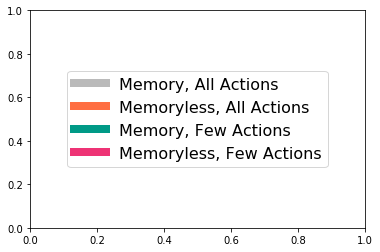

In [75]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='#bababa', lw=8, label='Memory, All Actions'),
                   Line2D([0], [0], color='#ff6e42', lw=8, label='Memoryless, All Actions'),
                   Line2D([0], [0], color='#009a87', lw=8, label='Memory, Few Actions'),
                   Line2D([0], [0], color='#ee3375', lw=8, label='Memoryless, Few Actions'),
]

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center', prop={'size': 16})

plt.show()

In [172]:
m = Chem.MolFromMolFile('./cyclohexane14.mol')
nv.show_rdkit(m)

NGLWidget()

In [173]:
nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
print(nonring)
print(ring)

[([(0, 3, 6, 7), (5, 3, 6, 7)], 180.0), ([(1, 4, 11, 12), (2, 4, 11, 12)], 180.0), ([(3, 6, 7, 8)], 180.0), ([(6, 7, 8, 10)], 180.0), ([(4, 11, 12, 13)], 180.0), ([(11, 12, 13, 14)], 180.0), ([(12, 13, 14, 15)], 180.0), ([(13, 14, 15, 16)], 180.0)]
[([(0, 3, 5, 1), (3, 5, 1, 4), (5, 1, 4, 2), (1, 4, 2, 0), (4, 2, 0, 3), (2, 0, 3, 5)], 36.34137323903797)]


In [178]:
Chem.rdMolTransforms.GetDihedralDeg(m.GetConformer(id=0), 0, 3, 5, 1)

51.03146718662007

In [145]:
cids = AllChem.EmbedMultipleConfs(m, numConfs=10)

In [176]:
rdkit.Chem.rdForceFieldHelpers.MMFFOptimizeMolecule(m)

1

In [179]:
confgen.get_conformer_energies(m)

array([12.55800568])

In [180]:
nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
print(nonring)
print(ring)

[([(0, 3, 6, 7), (5, 3, 6, 7)], 180.0), ([(1, 4, 11, 12), (2, 4, 11, 12)], 180.0), ([(3, 6, 7, 8)], 180.0), ([(6, 7, 8, 10)], 180.0), ([(4, 11, 12, 13)], 180.0), ([(11, 12, 13, 14)], 180.0), ([(12, 13, 14, 15)], 180.0), ([(13, 14, 15, 16)], 180.0)]
[([(0, 3, 5, 1), (3, 5, 1, 4), (5, 1, 4, 2), (1, 4, 2, 0), (4, 2, 0, 3), (2, 0, 3, 5)], 36.34137323903797)]


In [139]:
nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
ring = ring[0][0]

for i in range(1):
    conf = m.GetConformer(id=i)
#     for idx, tors in enumerate(nonring):
#         print('nonring')
#         atoms, ang = tors
#         tup = atoms[0]
#         deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
#         print(tup, deg)

    for tors in ring:
        print('ring')
        deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tors)
        print(tors, deg)

ring
(0, 3, 5, 1) 51.03146718662007
ring
(3, 5, 1, 4) 0.7488128411488192
ring
(5, 1, 4, 2) -51.86399141583419
ring
(1, 4, 2, 0) 51.06674898112858
ring
(4, 2, 0, 3) 0.7294832411201895
ring
(2, 0, 3, 5) -51.85675201911678


In [140]:
rdkit.Chem.rdMolTransforms.SetDihedralDeg(conf, 0, 3, 5, 1, 0)

ValueError: bond (j,k) must not belong to a ring

In [216]:
w = nv.show_rdkit(m)
w.add_label(labelType="atomindex", color='blue')
w

NGLWidget()

In [213]:
rdkit.Chem.TorsionFingerprints.CalculateTorsionWeights(mol)

[0.0027542287033381677,
 0.01096478196143185,
 0.03630780547701015,
 0.10000000000000002,
 0.22908676527677732,
 0.436515832240166,
 0.6918309709189365,
 0.9120108393559098,
 1.0,
 0.9120108393559098,
 0.6918309709189365,
 0.436515832240166,
 0.22908676527677732,
 0.10000000000000002,
 0.03630780547701015,
 0.01096478196143185,
 0.0027542287033381677]

In [169]:
ri = m.GetRingInfo()

In [227]:
ri.BondRings() 

((3, 7, 1, 2, 5, 0),)

In [219]:
ringbond = m.GetBondWithIdx(3)

In [222]:
ringbond.IsInRing()

True

In [239]:
m.GetPropsAsDict(includePrivate=True)

{'_Name': '',
 '_MolFileInfo': ' OpenBabel10291910303D',
 '_MolFileComments': '',
 '_MolFileChiralFlag': 1}

AttributeError: module 'rdkit.Chem.rdchem' has no attribute 'GetPropsAsDict'

In [240]:
ringbond.GetPropsAsDict(includePrivate=True)

{}

In [243]:
q = rdkit.Chem.rdmolops.AdjustQueryParameters(m)

ArgumentError: Python argument types in
    AdjustQueryParameters.__init__(AdjustQueryParameters, Mol)
did not match C++ signature:
    __init__(_object*)